# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


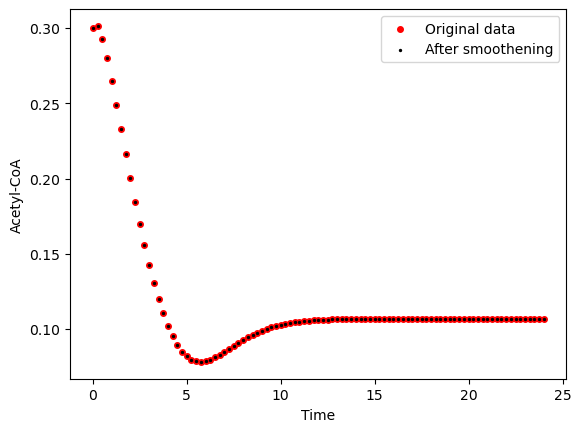

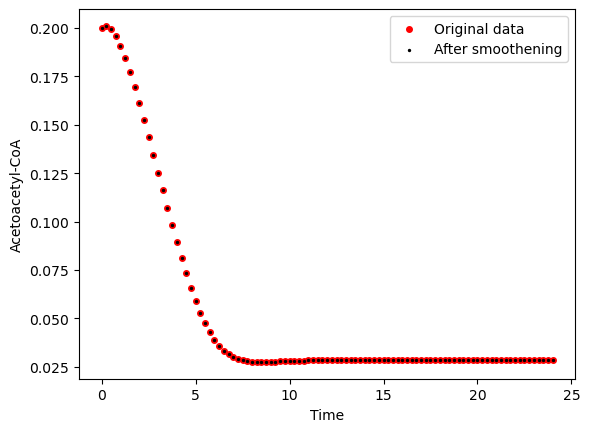

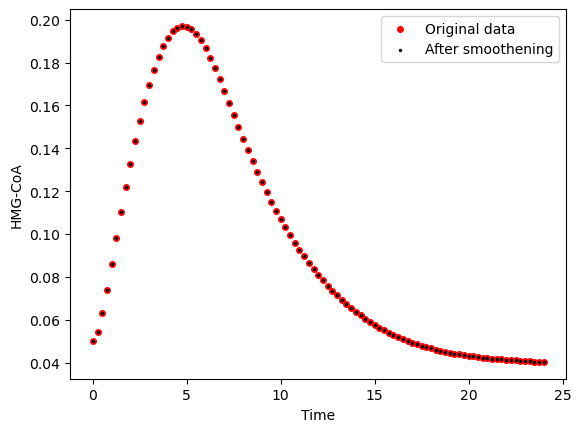

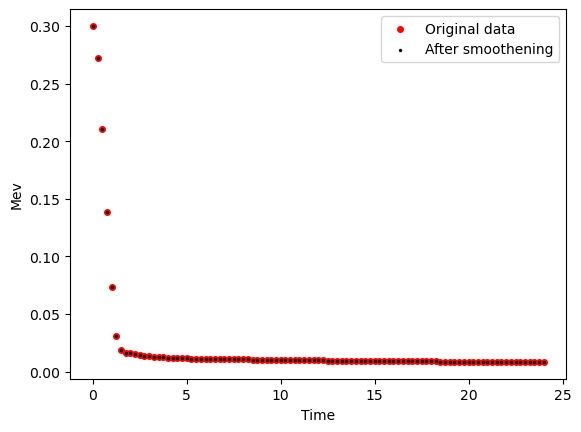

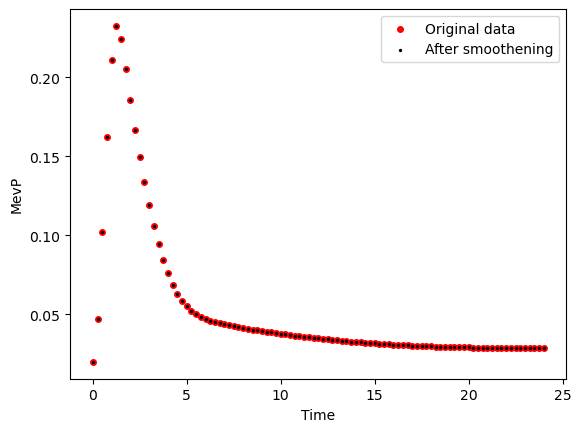

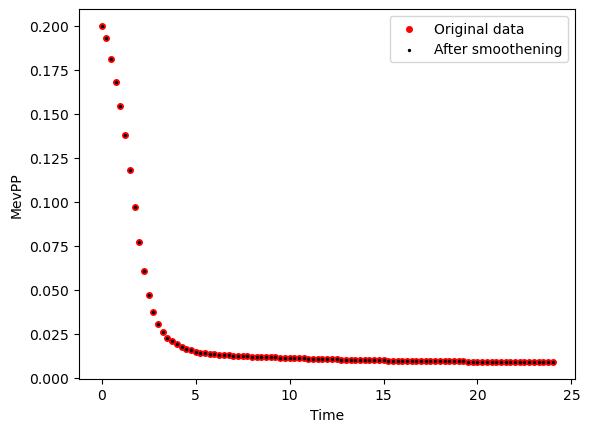

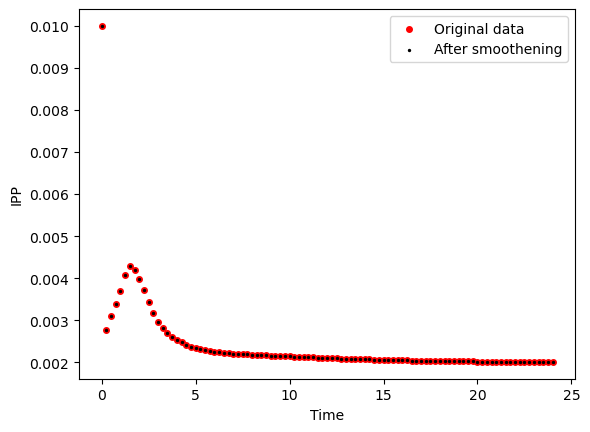

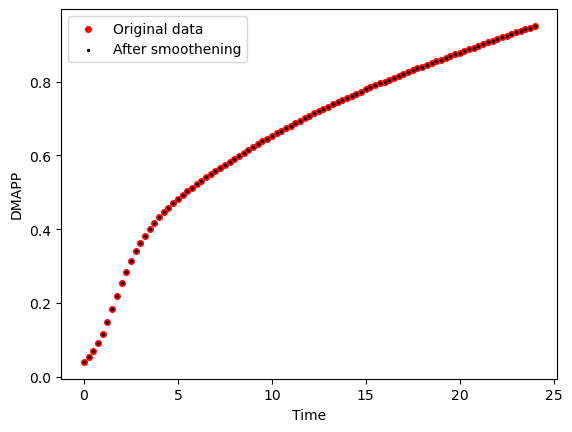

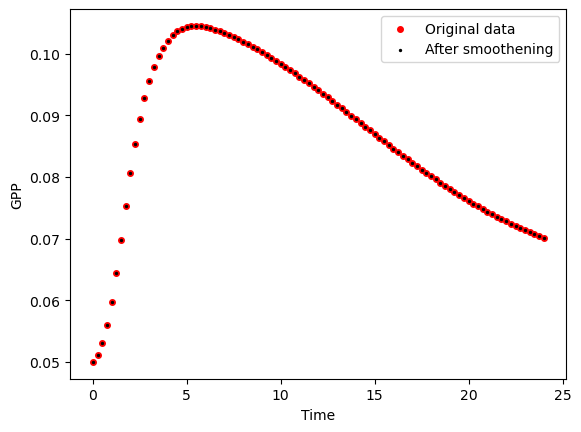

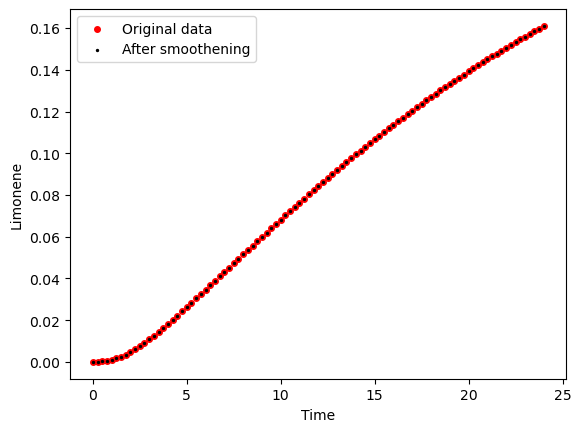

Strain Strain 2


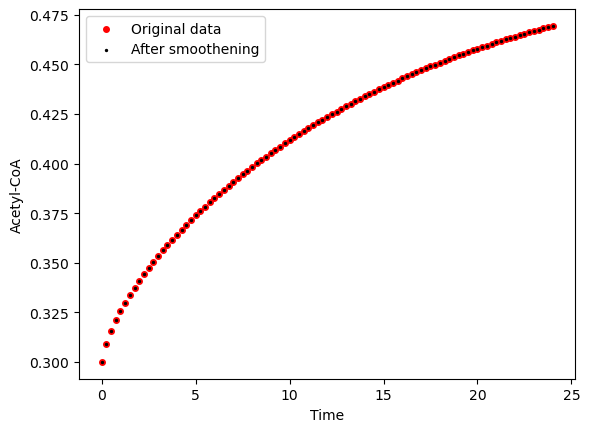

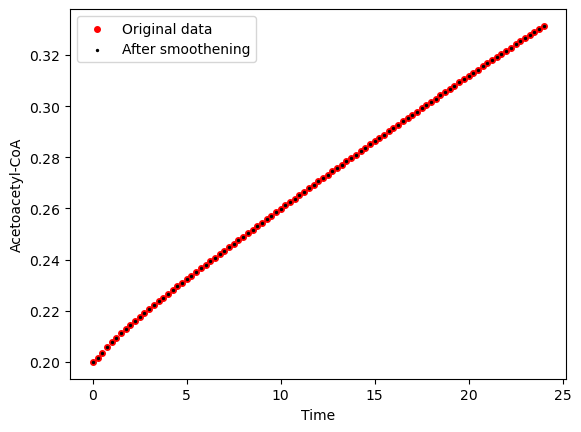

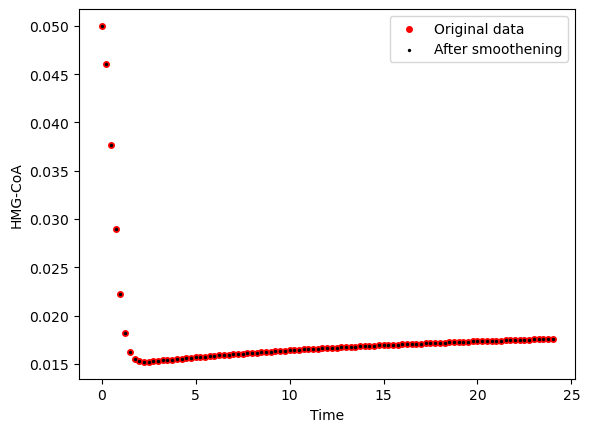

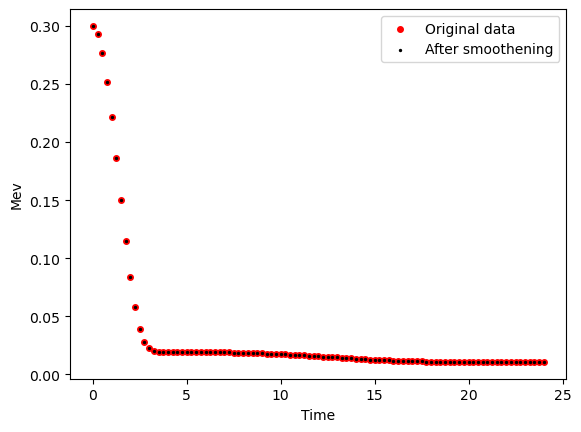

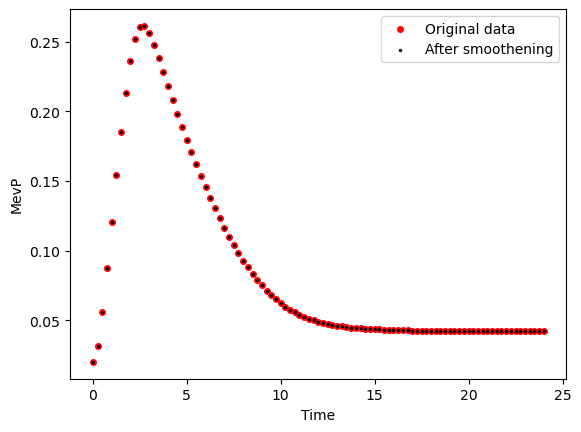

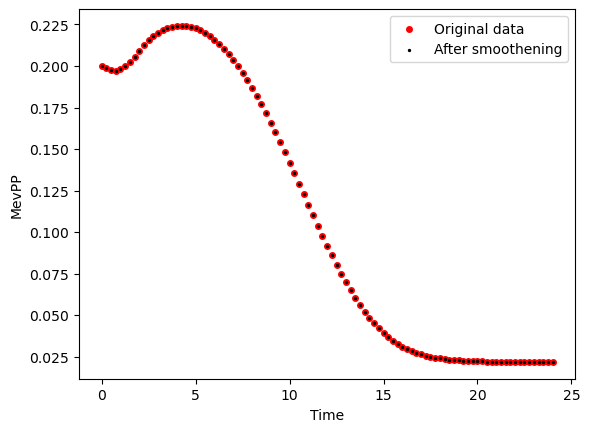

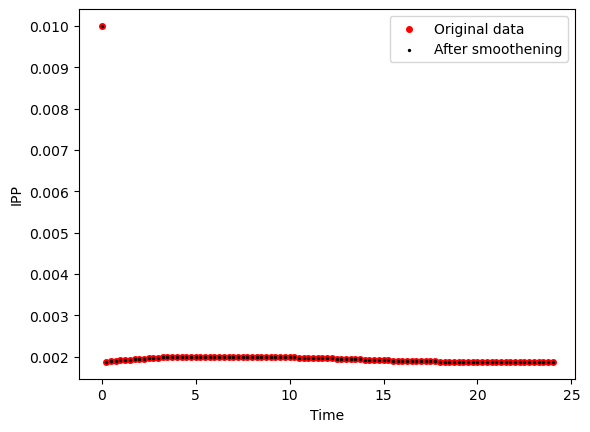

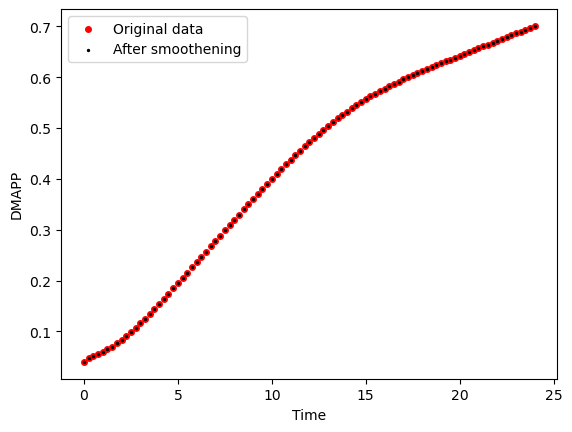

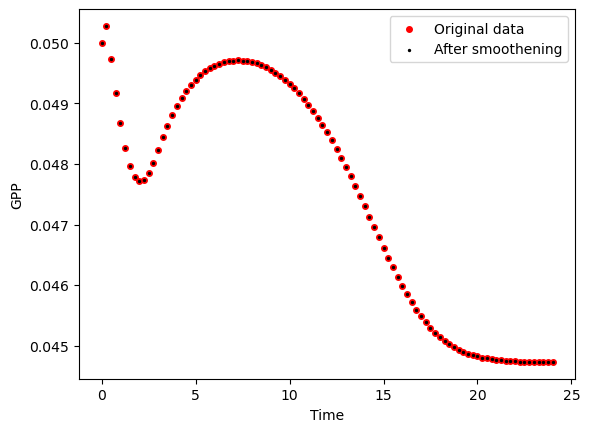

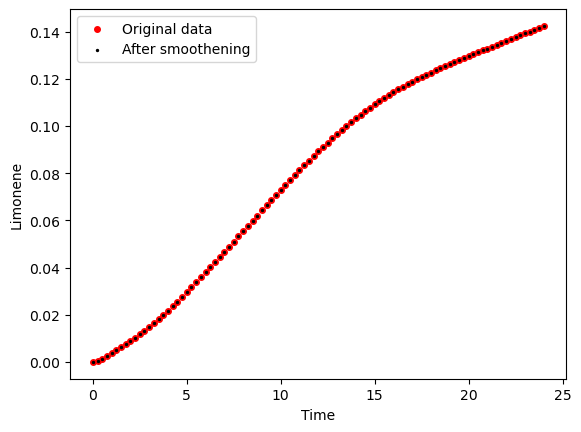

Strain Strain 3


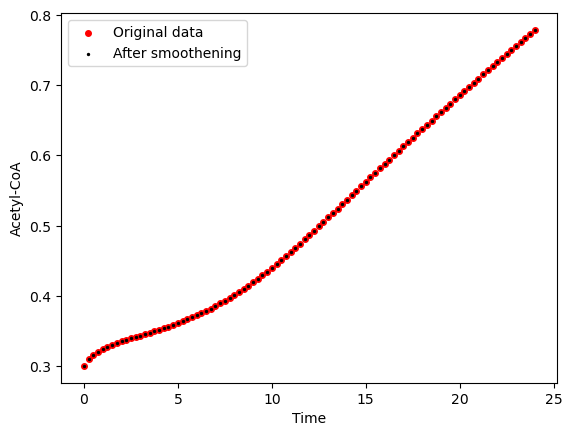

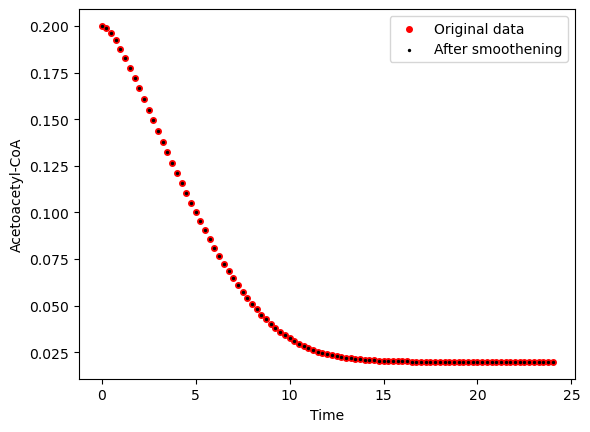

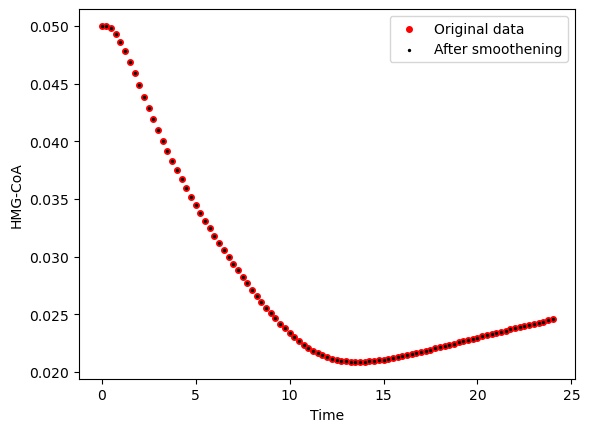

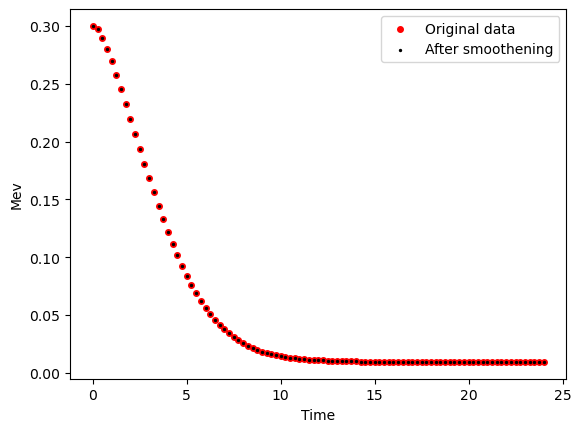

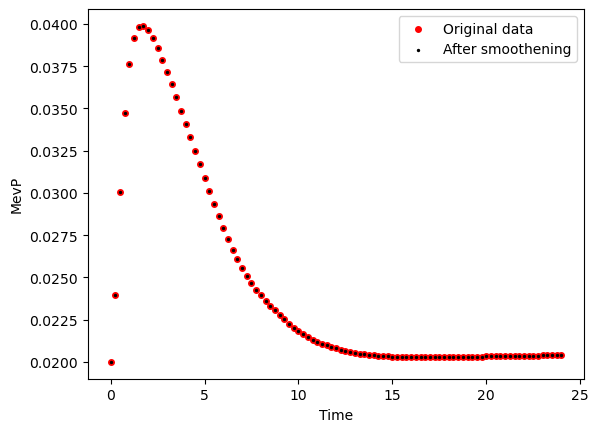

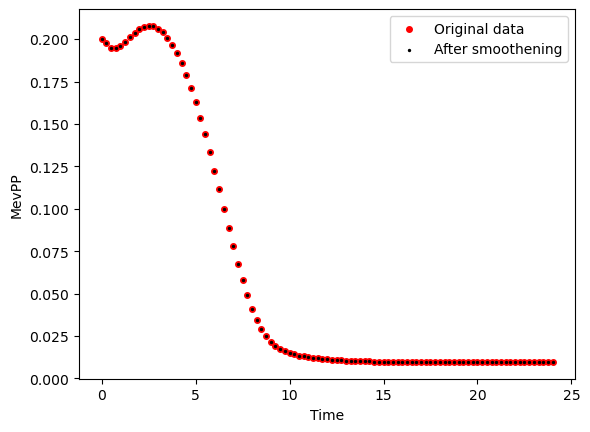

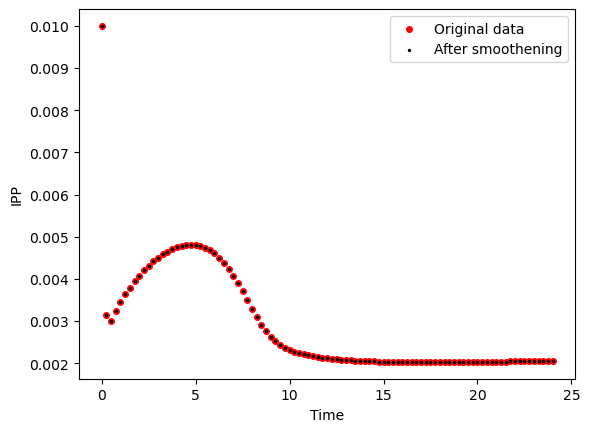

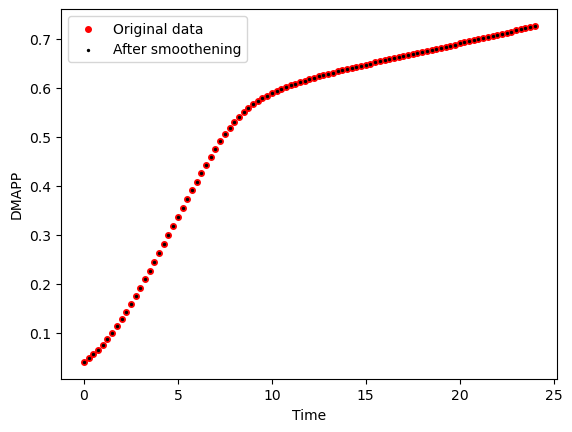

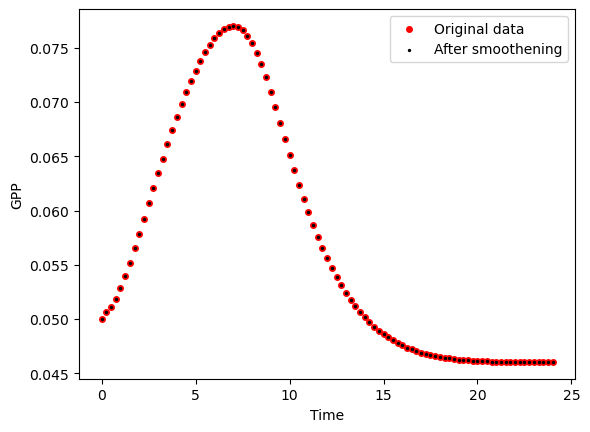

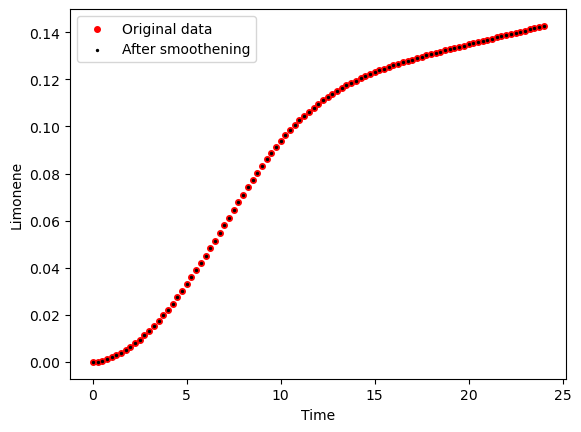

Strain WT


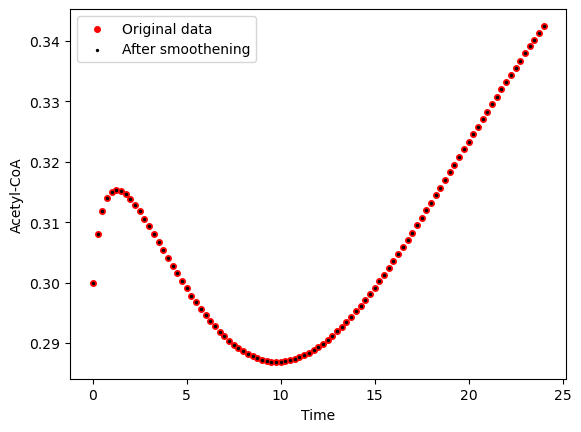

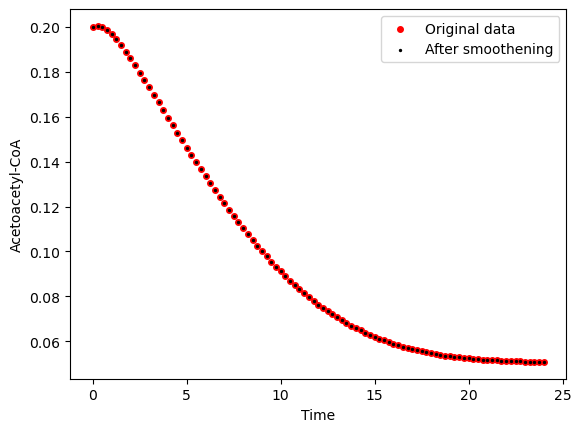

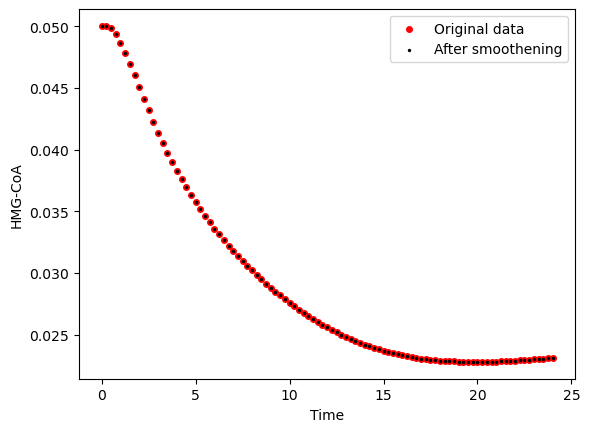

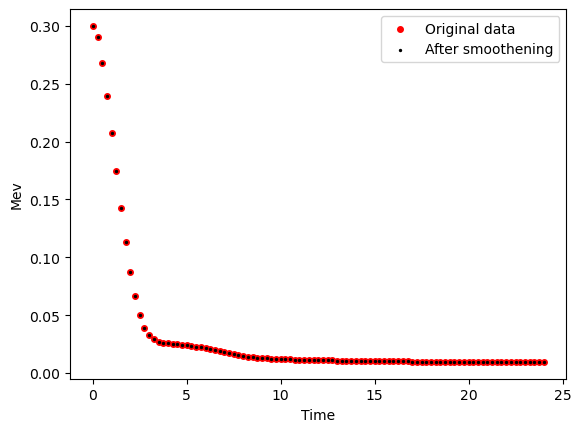

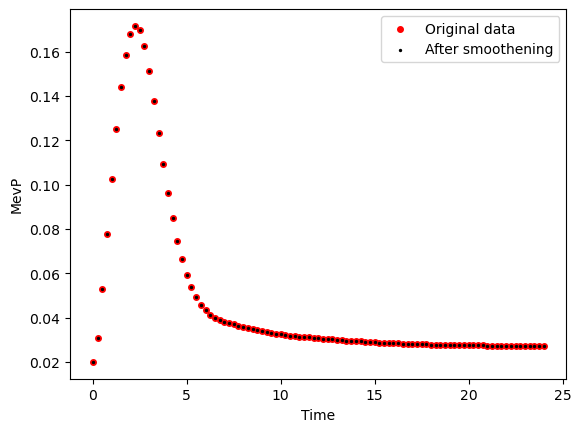

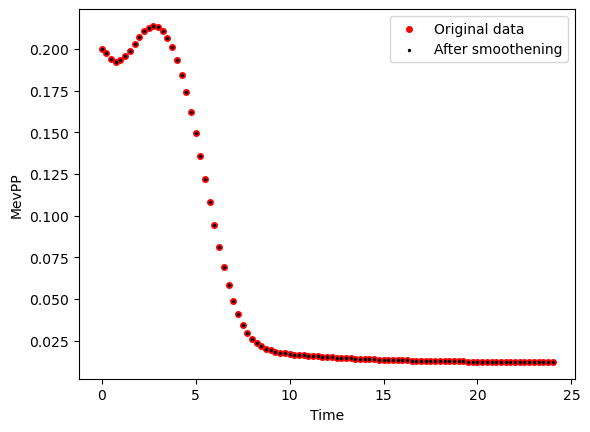

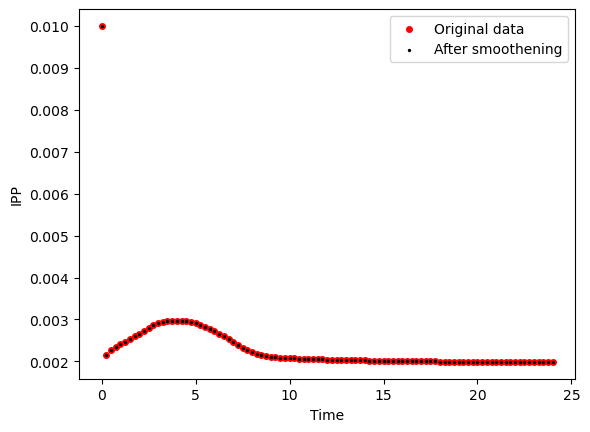

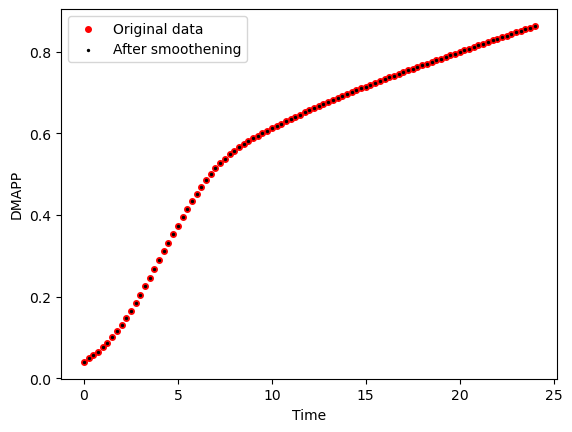

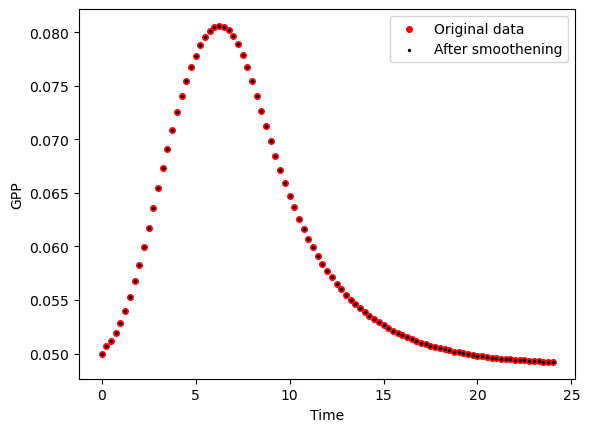

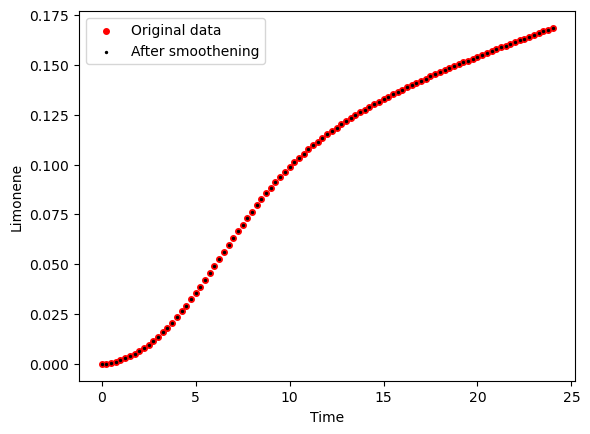

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


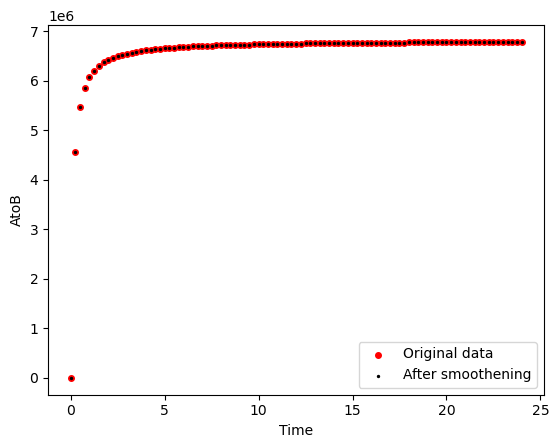

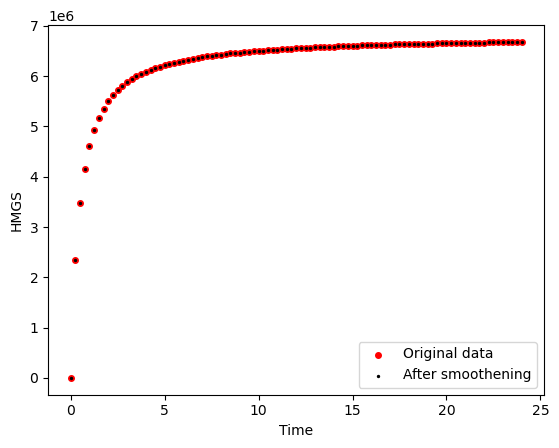

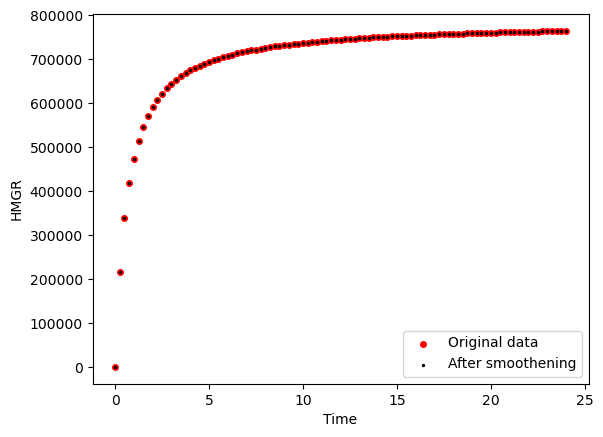

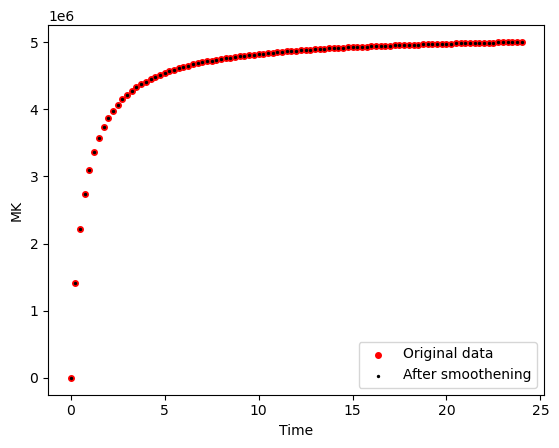

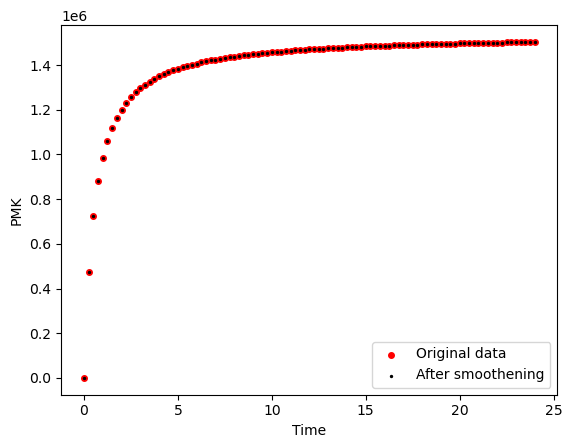

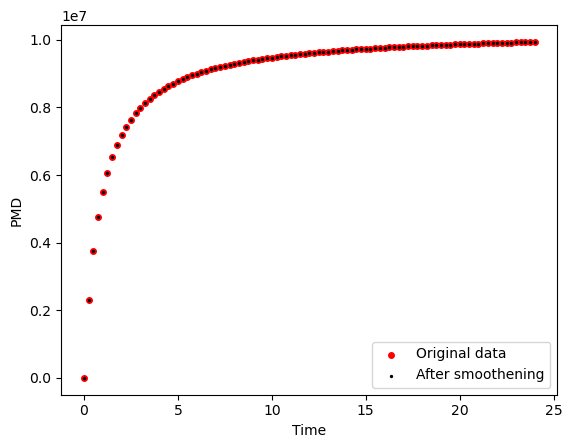

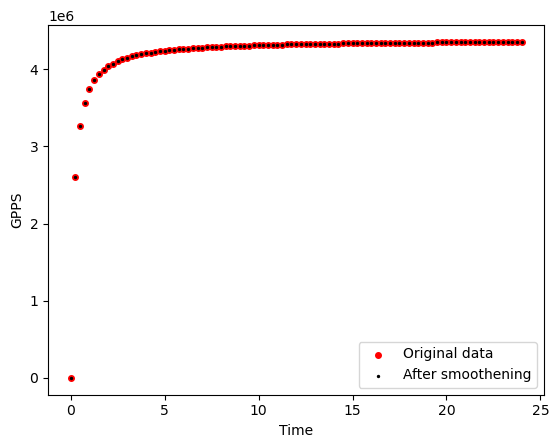

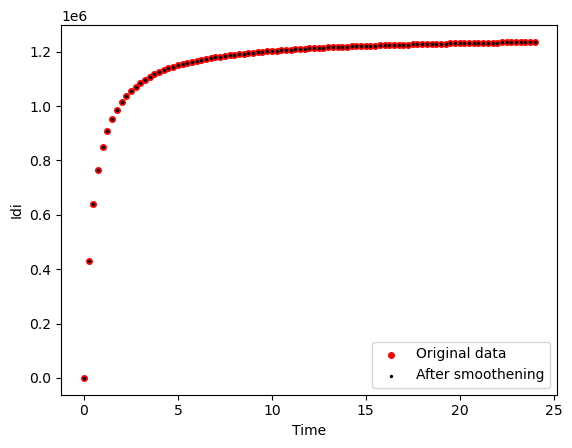

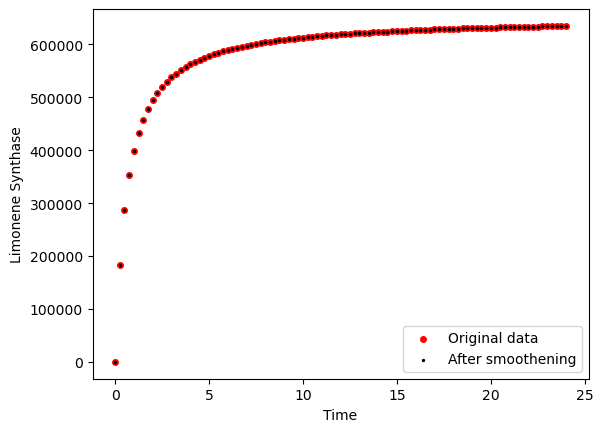

Strain Strain 2


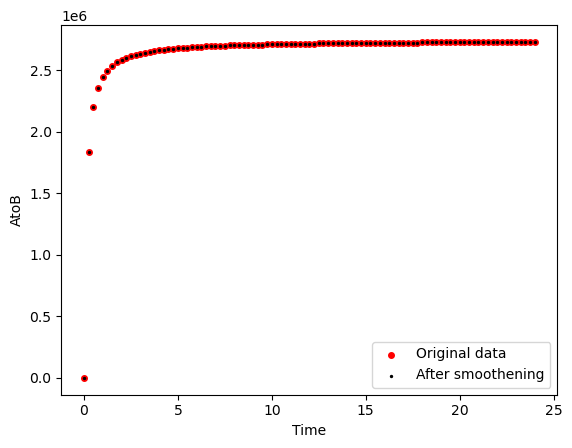

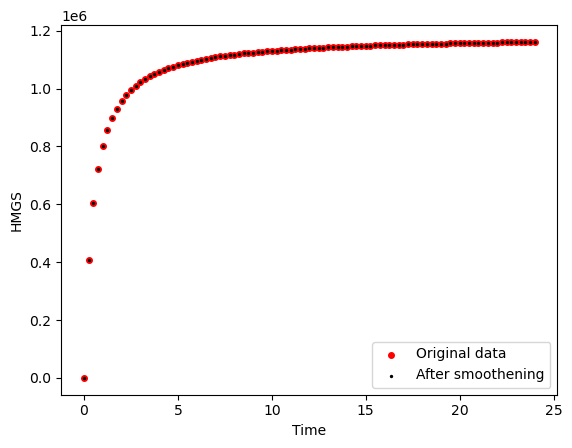

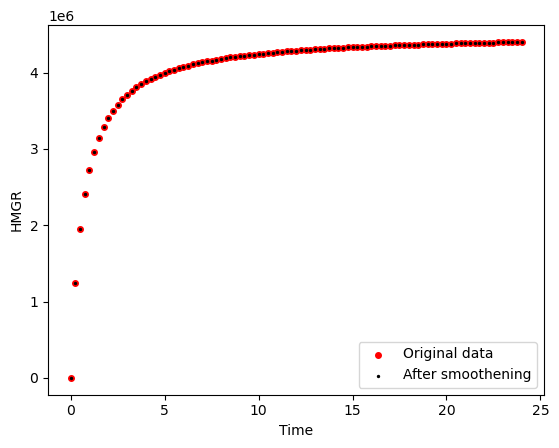

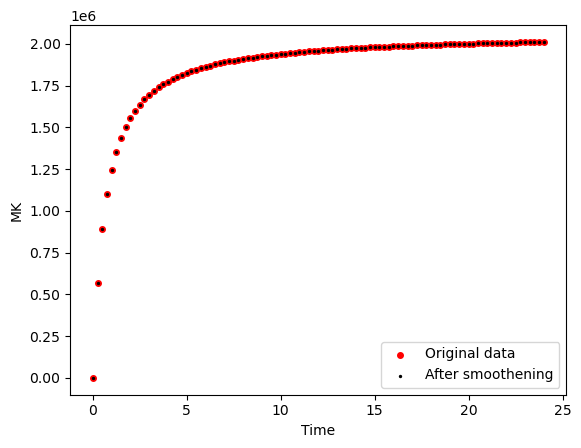

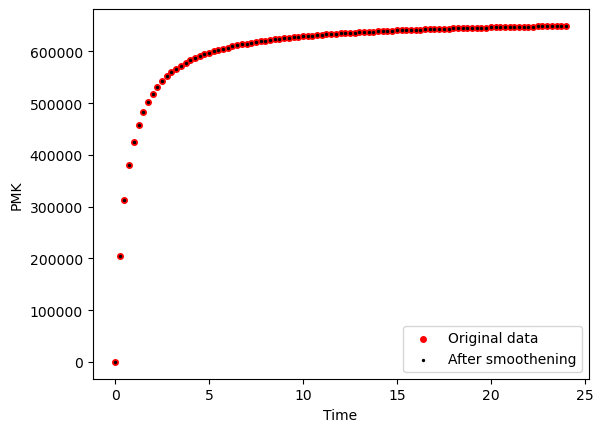

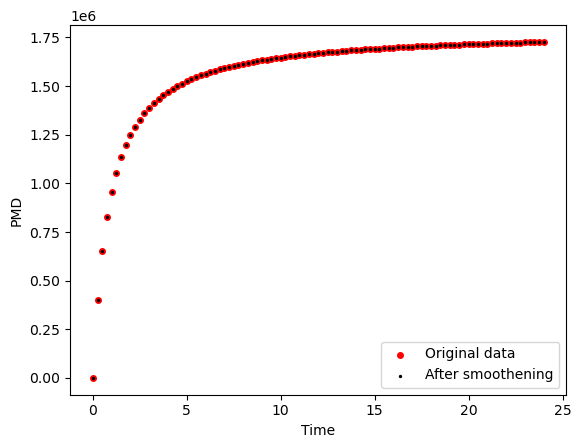

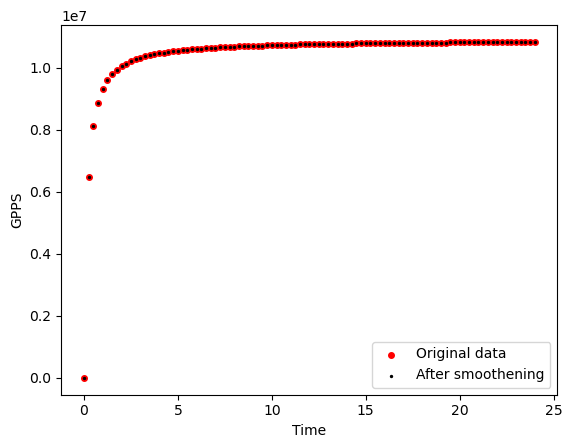

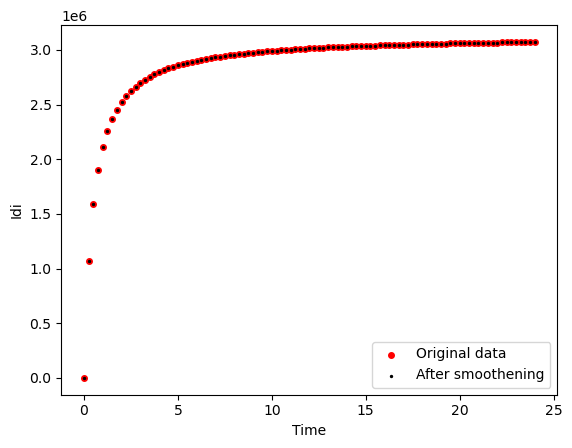

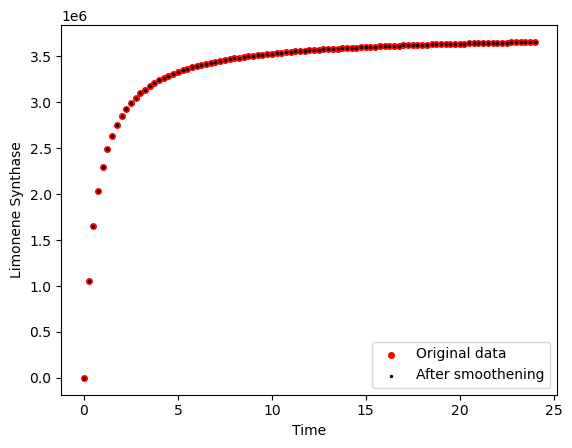

Strain Strain 3


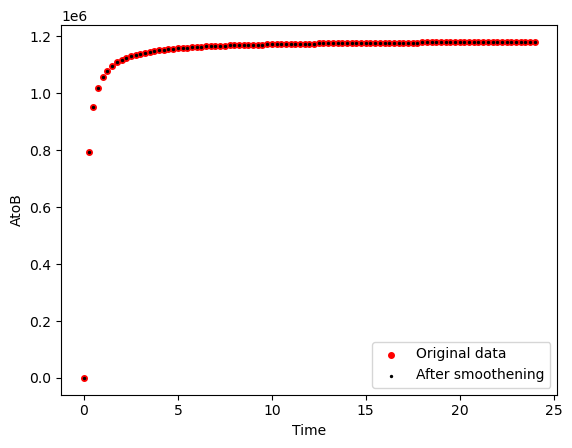

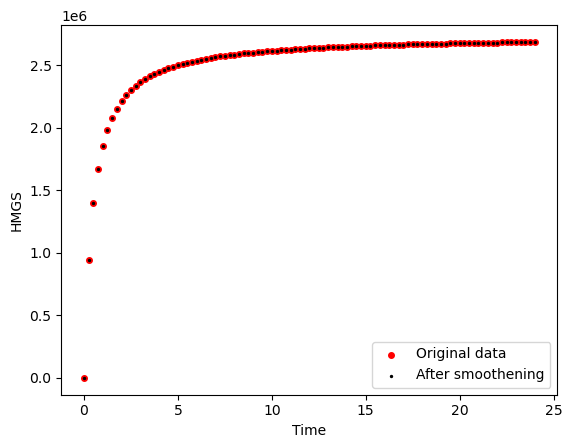

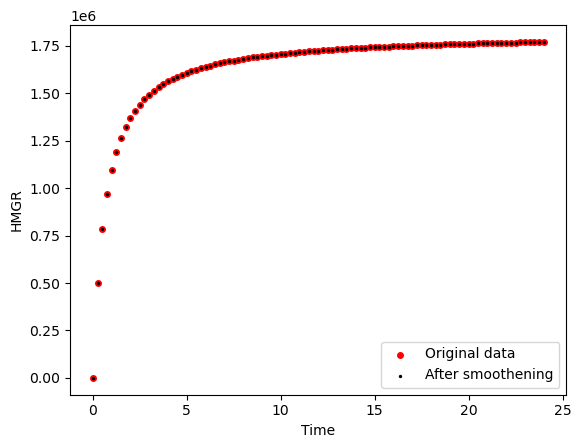

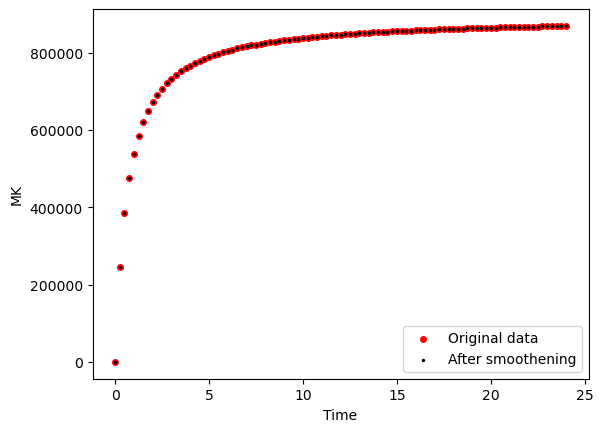

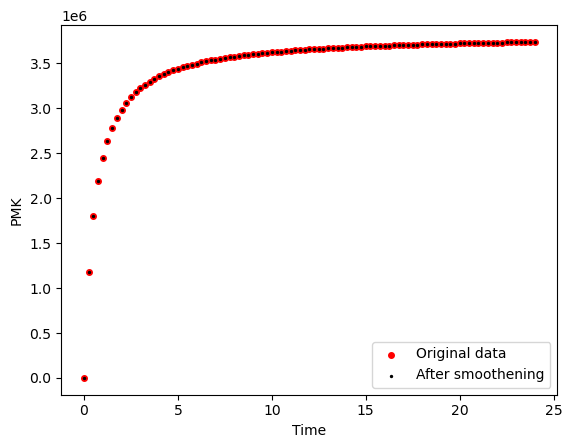

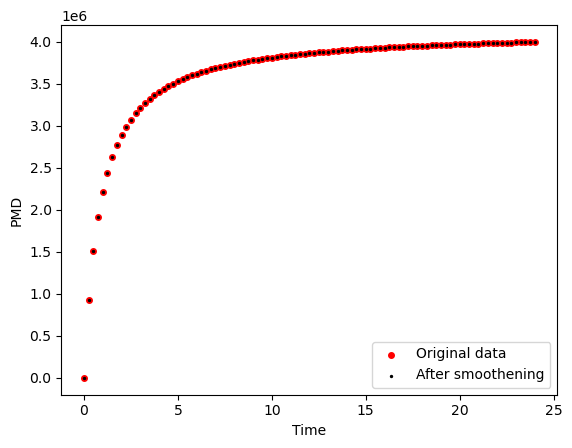

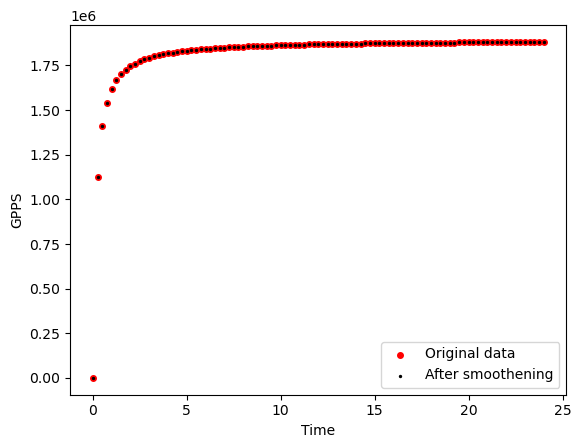

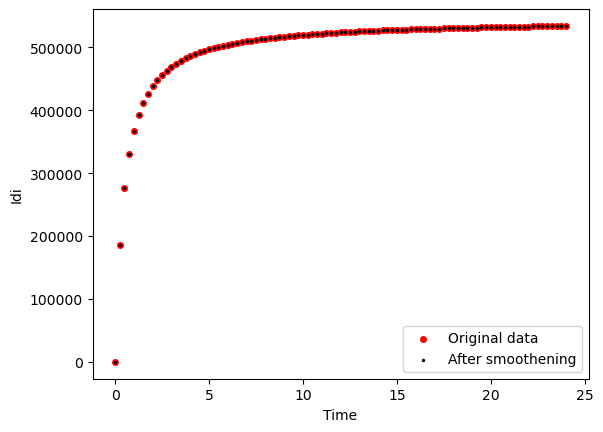

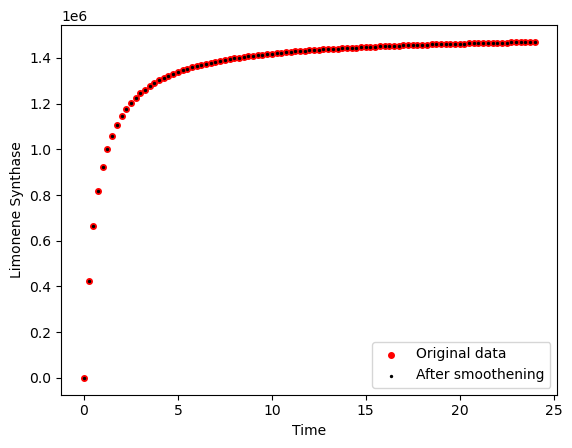

Strain WT


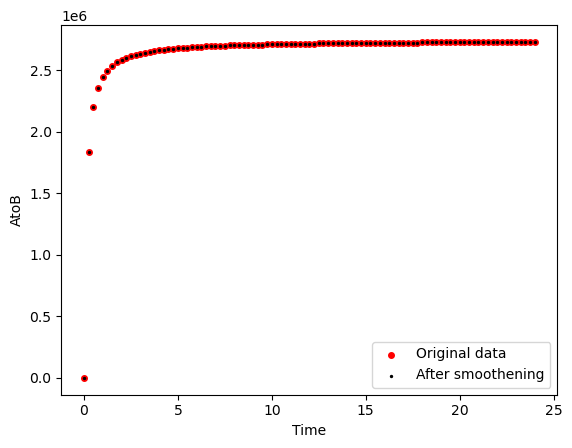

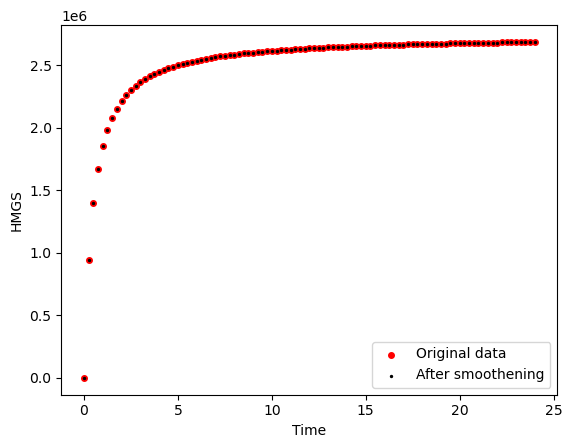

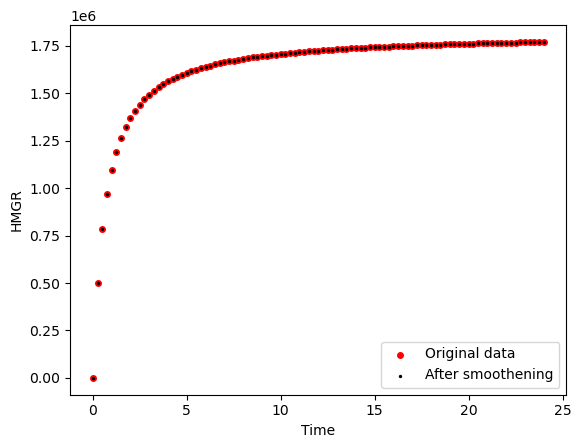

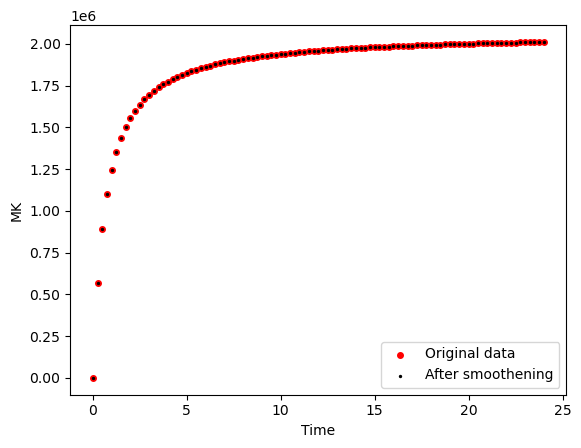

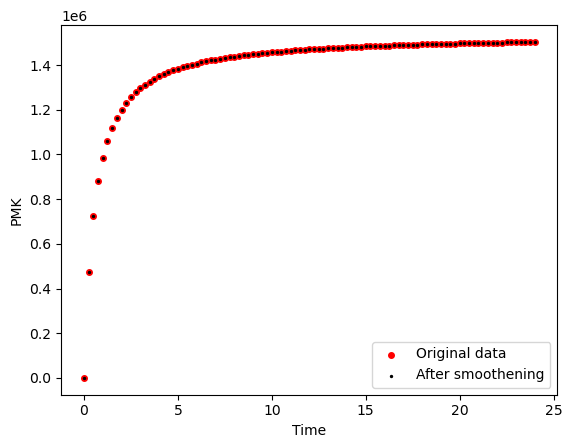

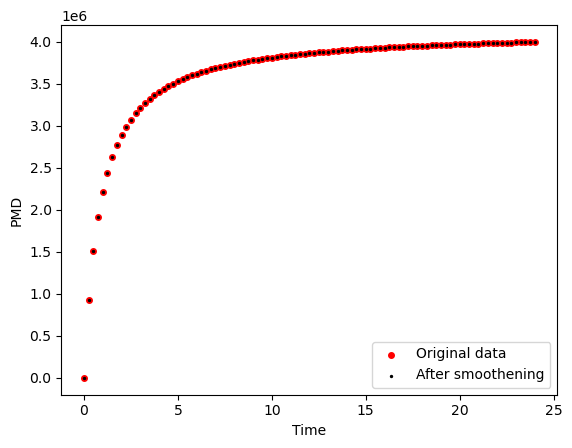

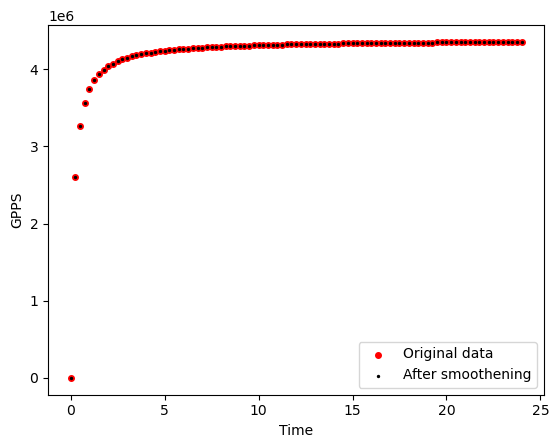

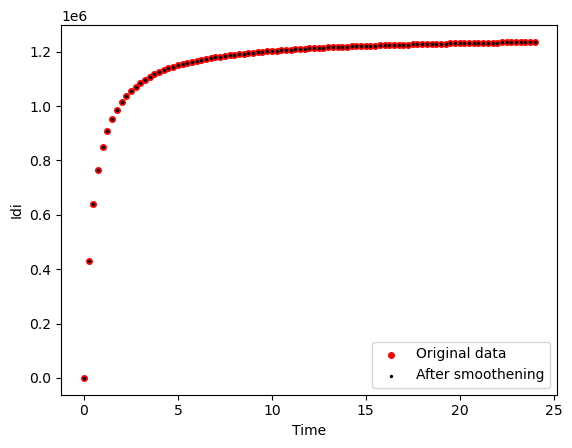

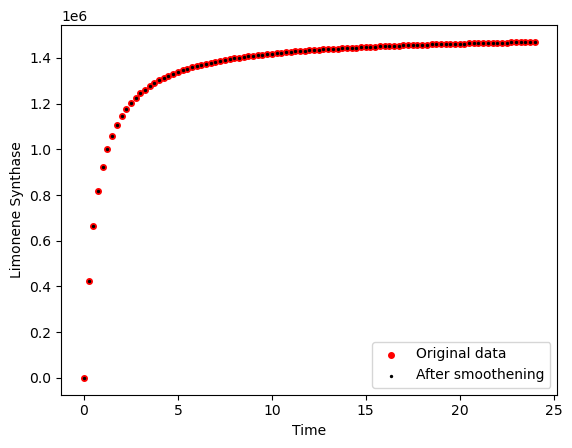

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

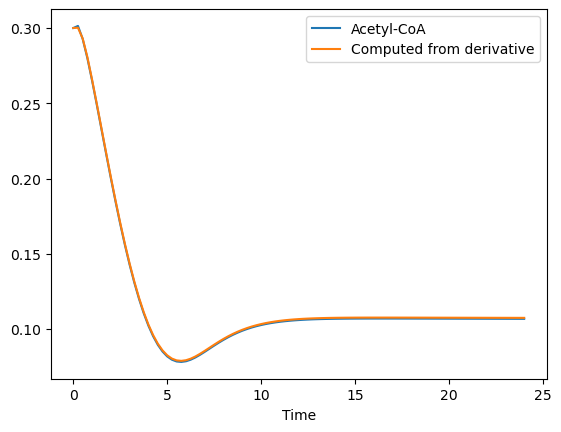

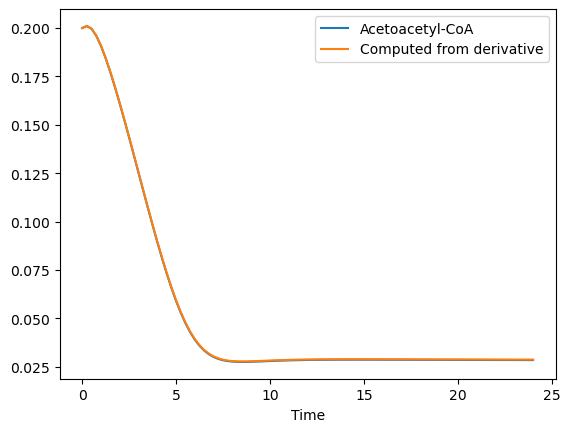

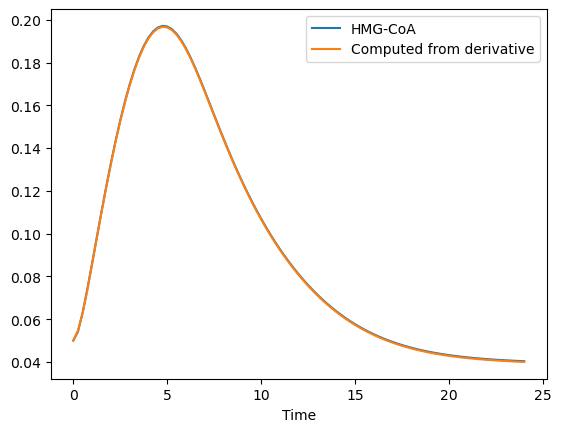

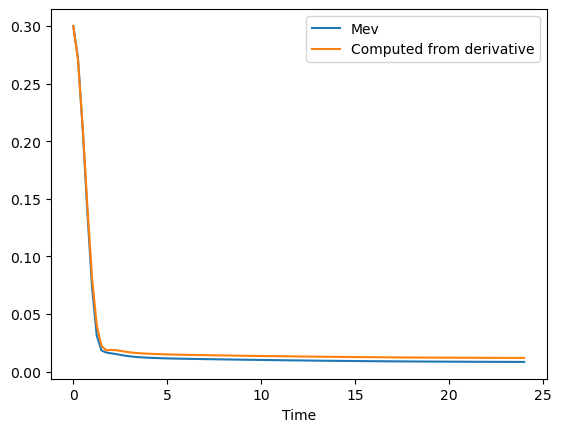

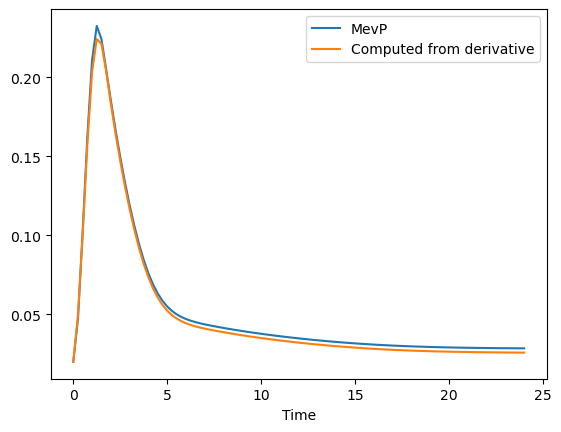

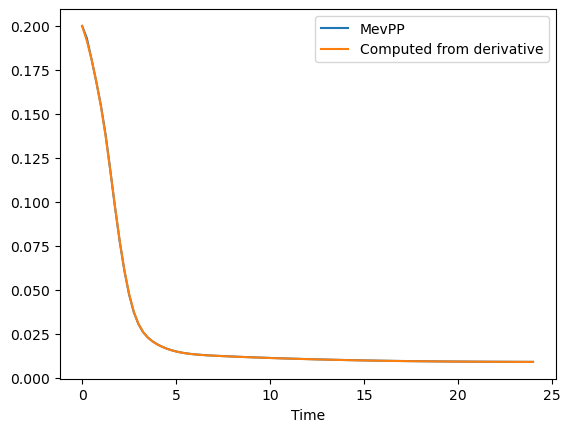

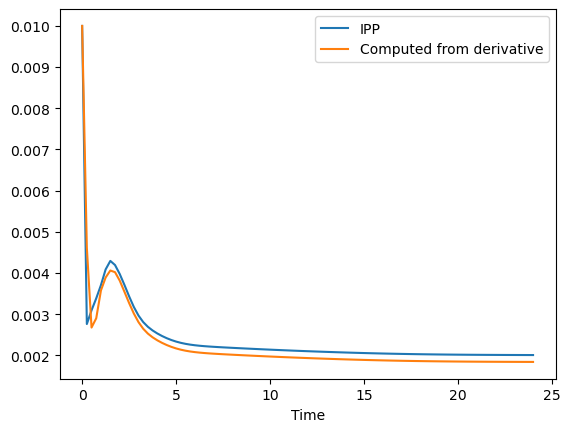

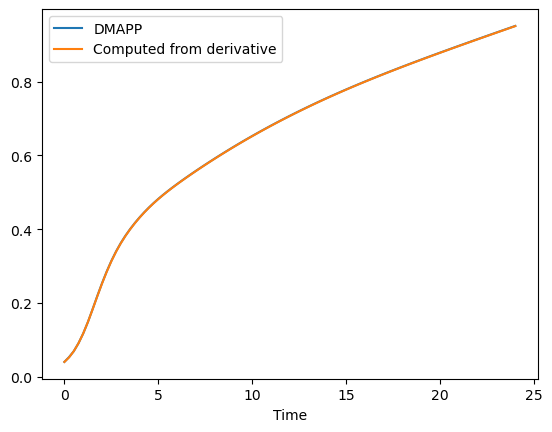

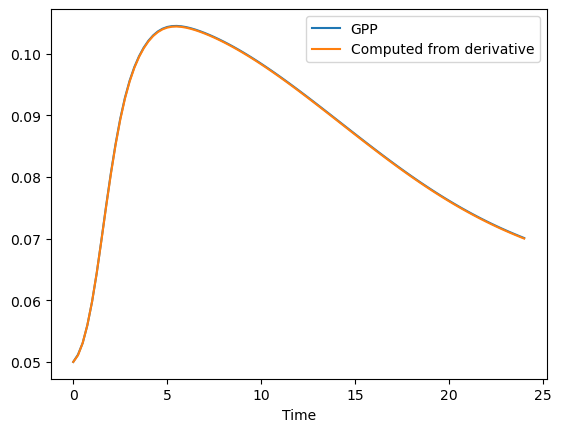

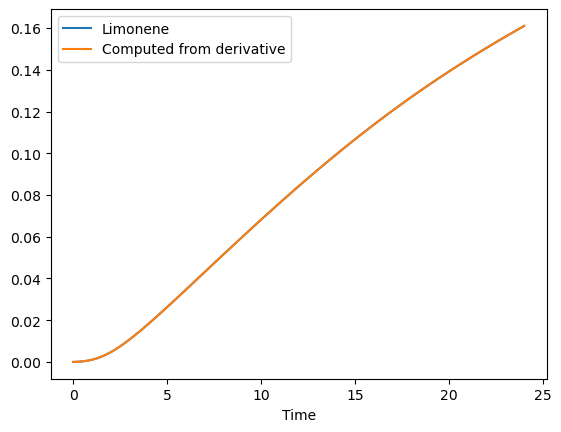

'Time profile from derivative vs. actual profile for Strain 2'

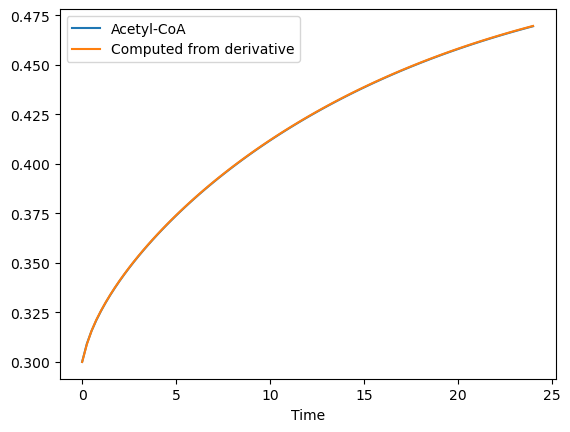

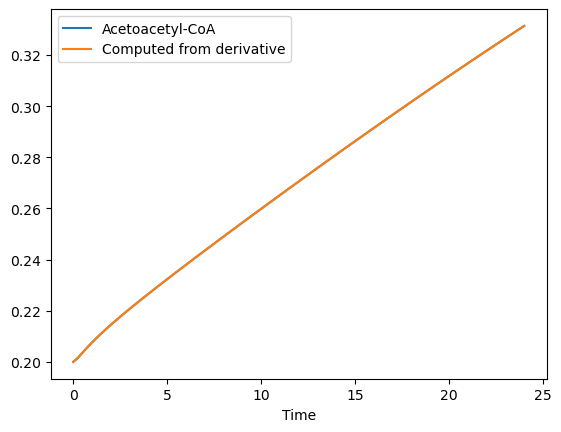

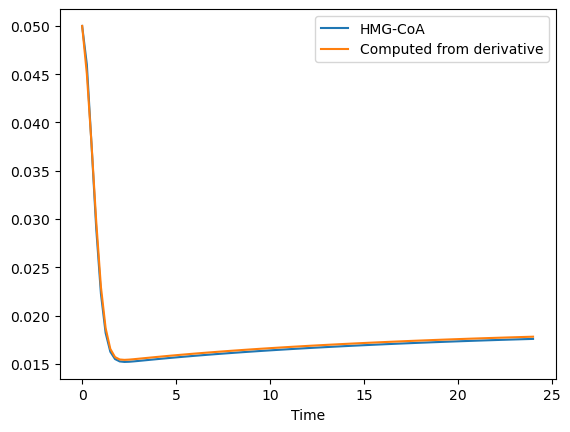

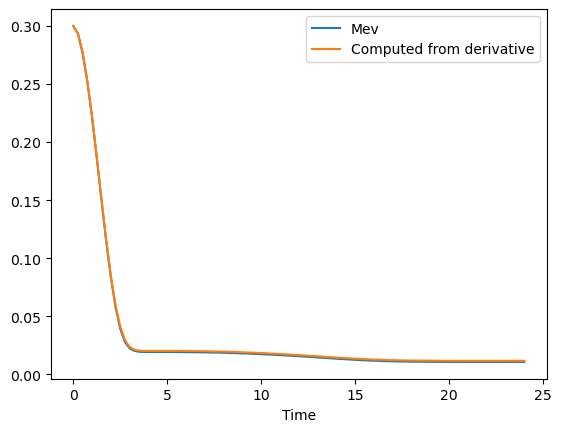

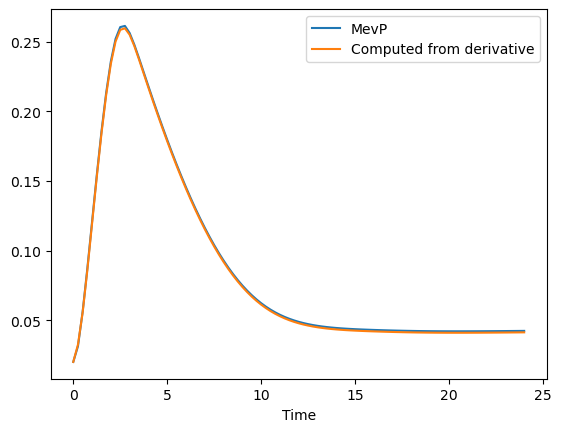

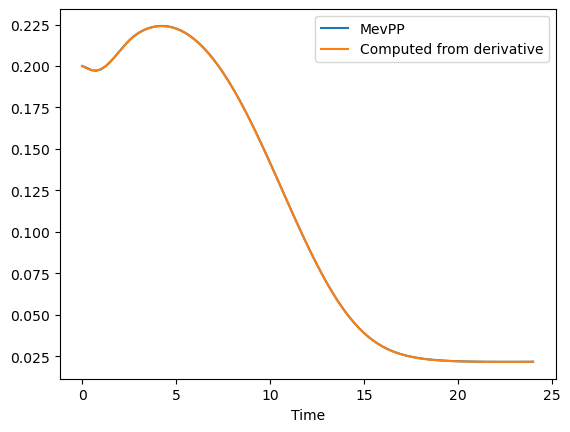

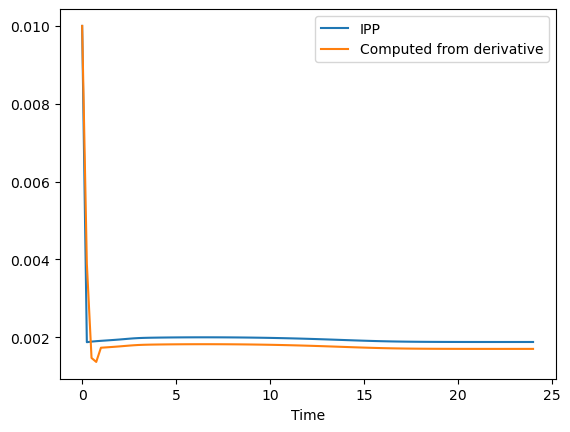

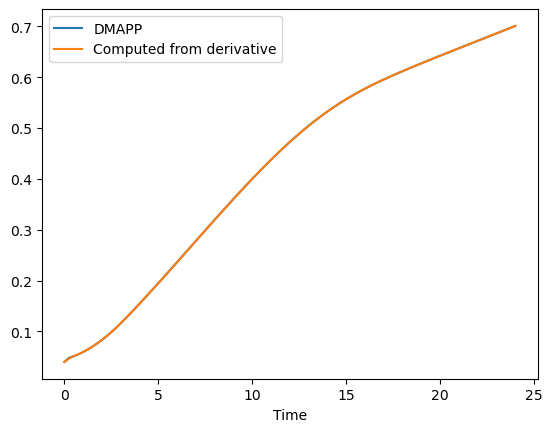

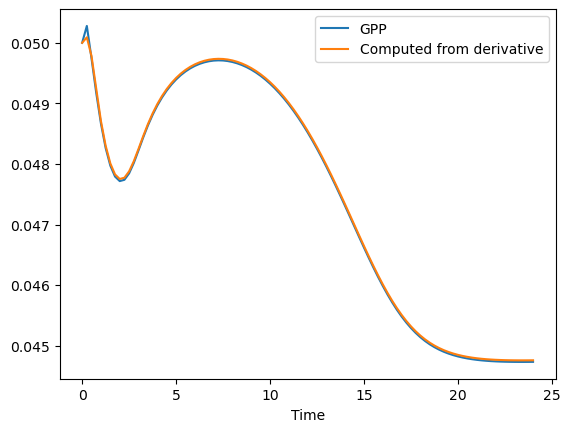

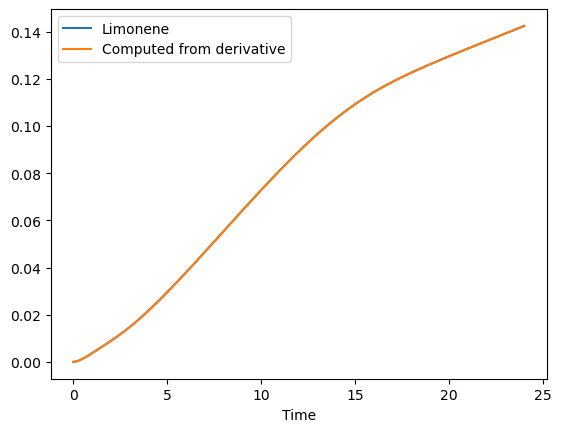

'Time profile from derivative vs. actual profile for Strain 3'

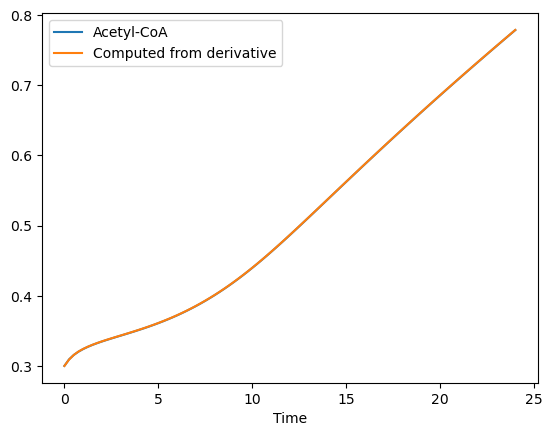

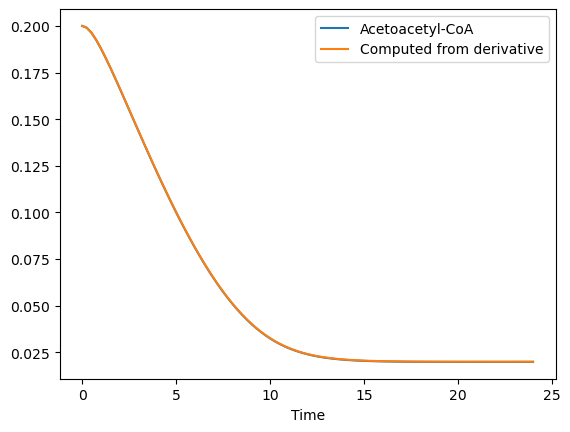

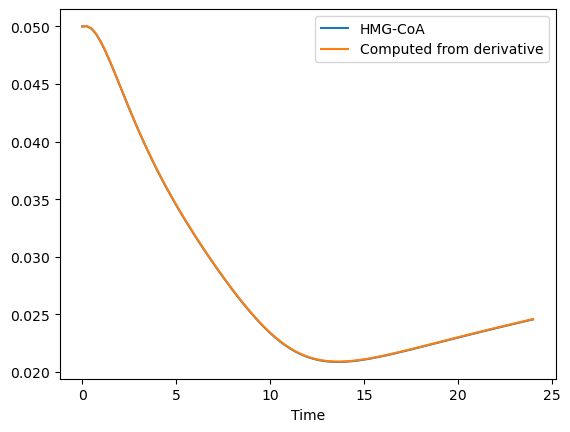

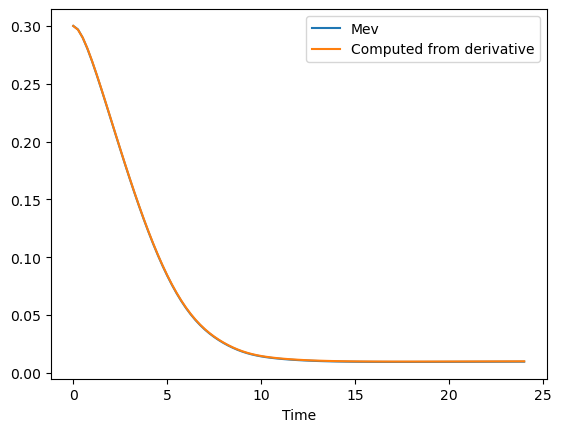

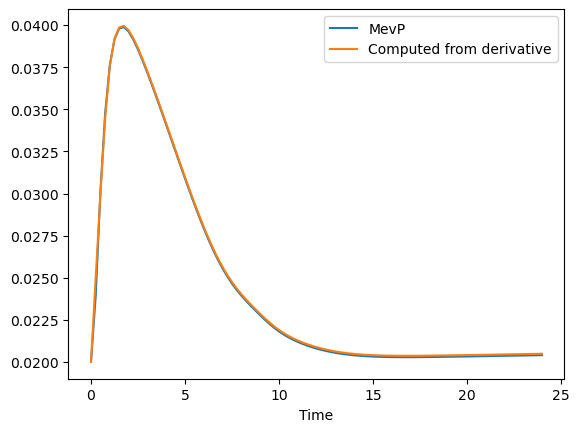

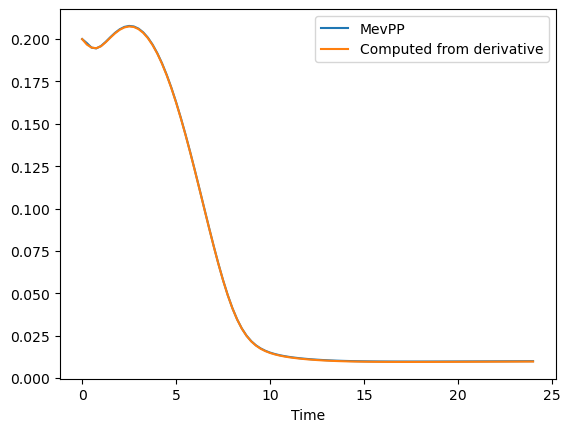

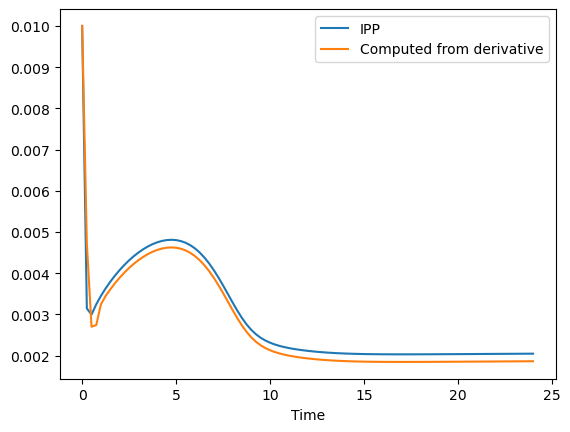

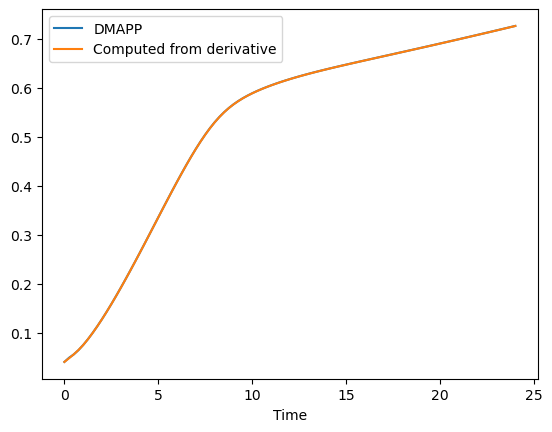

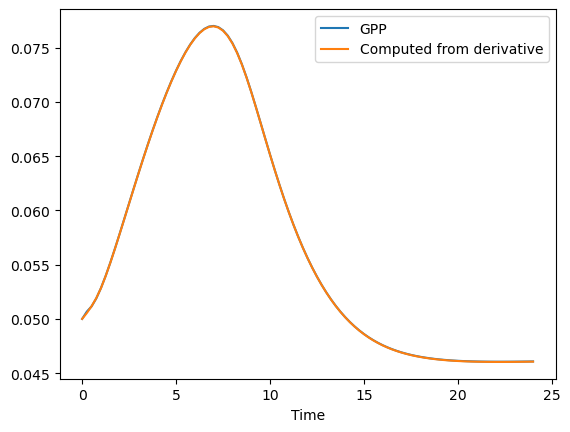

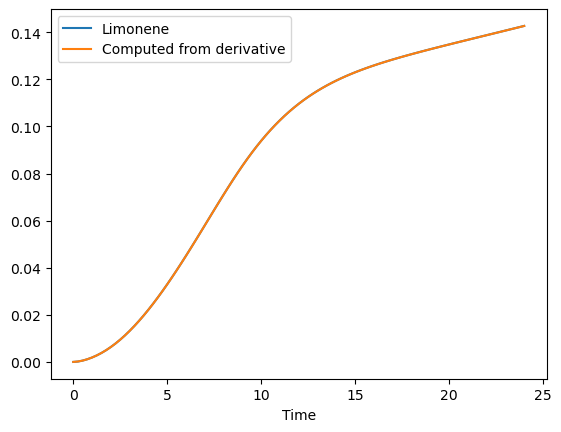

'Time profile from derivative vs. actual profile for WT'

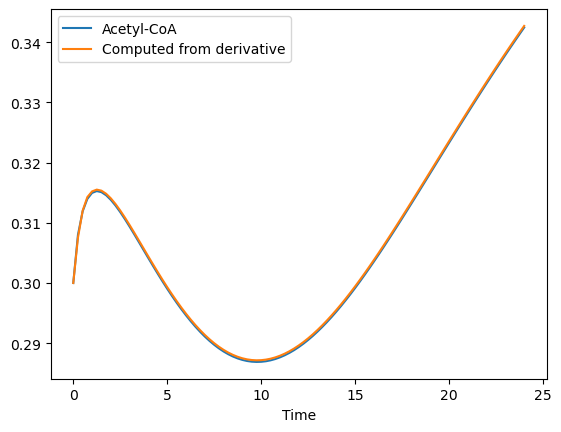

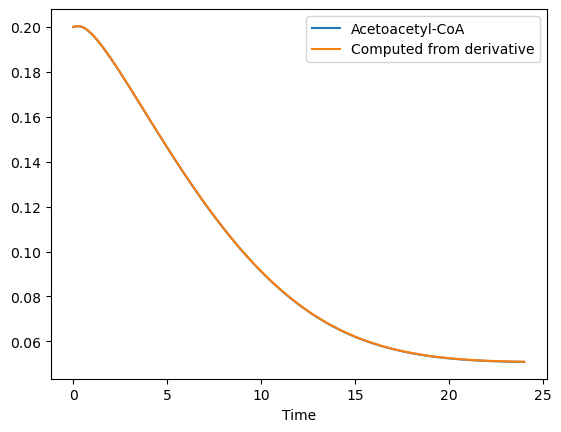

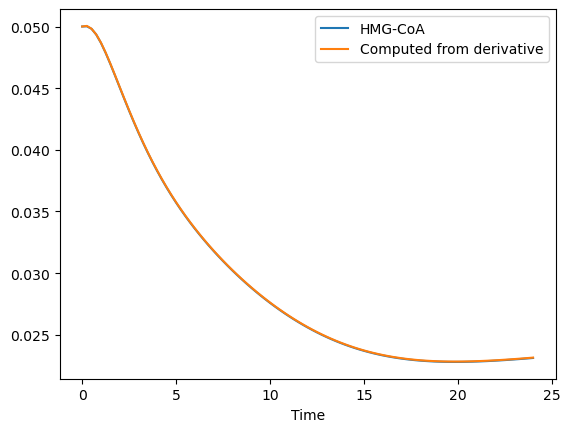

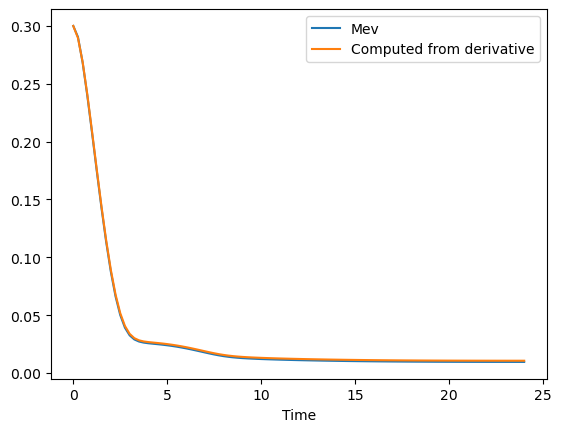

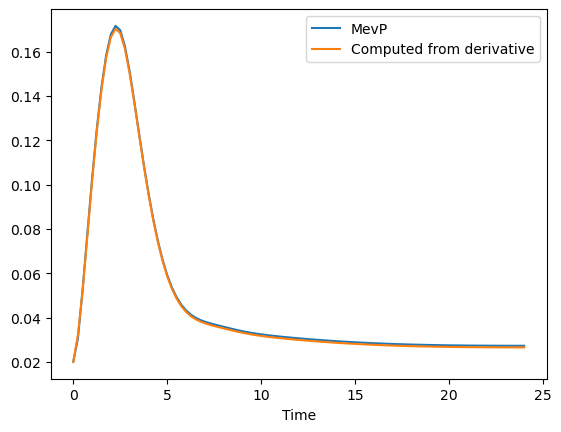

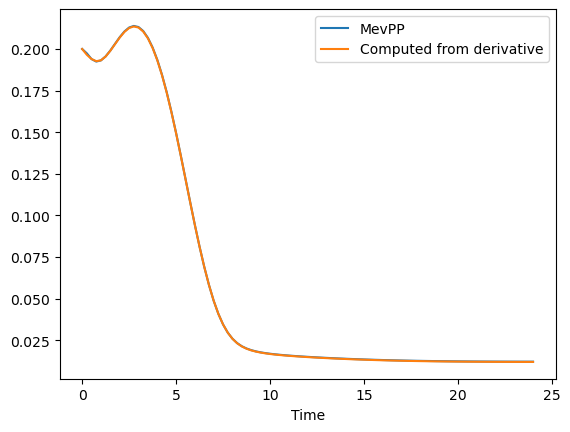

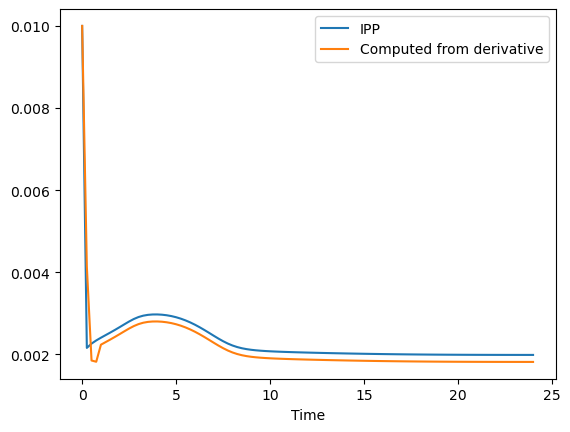

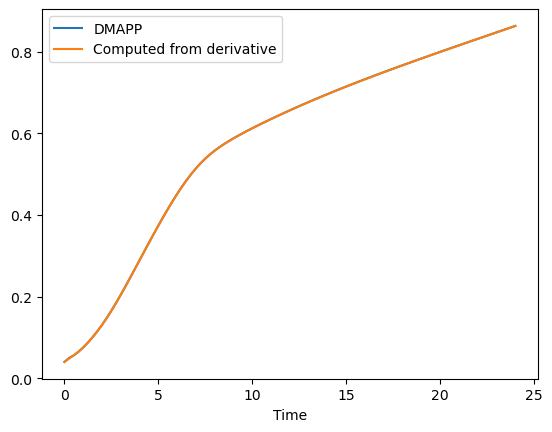

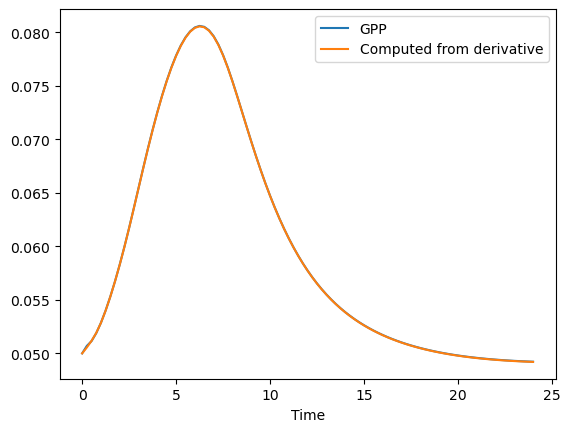

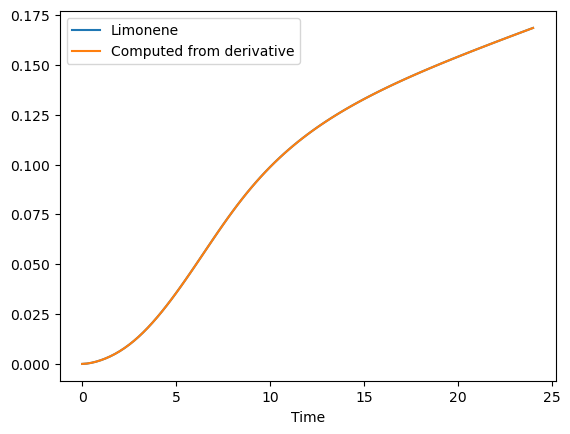

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  1.575579E+18 |  3.223337E+14
     2 |      128 |  8.208775E+17 |  9.627505E+10
     3 |      192 |  1.864535E+17 |  3.578274E+09
     4 |      256 |  8.375538E+16 |  4.871093E+08
     5 |      320 |  6.931476E+16 |  2.997261E+08
     6 |      384 |  6.865116E+16 |  5.890062E+07
     7 |      448 |  3.412723E+08 |  3.140469E+07
     8 |      512 |  2.237942E+08 |  1.953601E+07
     9 |      576 |  6.646025E+07 |  1.132577E+07
    10 |      640 |  1.760663E+07 |  6.701559E+06
    11 |      704 |  8.763712E+06 |  4.966954E+06
    12 |      768 |  6.677725E+06 |  4.430456E+06
    13 |      832 |  5.852792E+06 |  3.875433E+06
    14 |      896 |  4.397931E+06 |  3.239323E+06
    15 |      960 |  3.570852E+06 |  3.094329E+06
    16 |     1024 |  3.157775E+06 |  2.717437E+06
    17 |     1088 |  2.866855E+06 |  2.560955E+06
    18 |     1152 |  2.656649E+06 |  2.486329E+06
    19 |     1216 |  2.50

   162 |    10368 |  1.625850E+04 |  1.591615E+04
   163 |    10432 |  1.604646E+04 |  1.583299E+04
   164 |    10496 |  1.581855E+04 |  1.558442E+04
   165 |    10560 |  1.564220E+04 |  1.538769E+04
   166 |    10624 |  1.548691E+04 |  1.525062E+04
   167 |    10688 |  1.533751E+04 |  1.513574E+04
   168 |    10752 |  1.517650E+04 |  1.506115E+04
   169 |    10816 |  1.507074E+04 |  1.493279E+04
   170 |    10880 |  1.491474E+04 |  1.469883E+04
   171 |    10944 |  1.475938E+04 |  1.457889E+04
   172 |    11008 |  1.461608E+04 |  1.446343E+04
   173 |    11072 |  1.446748E+04 |  1.427176E+04
   174 |    11136 |  1.423976E+04 |  1.395902E+04
   175 |    11200 |  1.401511E+04 |  1.368266E+04
   176 |    11264 |  1.371883E+04 |  1.345845E+04
   177 |    11328 |  1.345606E+04 |  1.315614E+04
   178 |    11392 |  1.321756E+04 |  1.299763E+04
   179 |    11456 |  1.301895E+04 |  1.273243E+04
   180 |    11520 |  1.277014E+04 |  1.251390E+04
   181 |    11584 |  1.259843E+04 |  1.234002E+04


   326 |    20864 |  1.521273E+03 |  1.502520E+03
   327 |    20928 |  1.506902E+03 |  1.492017E+03
   328 |    20992 |  1.496261E+03 |  1.484007E+03
   329 |    21056 |  1.484514E+03 |  1.468226E+03
   330 |    21120 |  1.470237E+03 |  1.452149E+03
   331 |    21184 |  1.452424E+03 |  1.433877E+03
   332 |    21248 |  1.441404E+03 |  1.425704E+03
   333 |    21312 |  1.428388E+03 |  1.411398E+03
   334 |    21376 |  1.414384E+03 |  1.389550E+03
   335 |    21440 |  1.391640E+03 |  1.364185E+03
   336 |    21504 |  1.370995E+03 |  1.351578E+03
   337 |    21568 |  1.354127E+03 |  1.333359E+03
   338 |    21632 |  1.337494E+03 |  1.322931E+03
   339 |    21696 |  1.324258E+03 |  1.310277E+03
   340 |    21760 |  1.312609E+03 |  1.300743E+03
   341 |    21824 |  1.302205E+03 |  1.293704E+03
   342 |    21888 |  1.294025E+03 |  1.277909E+03
   343 |    21952 |  1.278975E+03 |  1.254188E+03
   344 |    22016 |  1.262210E+03 |  1.240755E+03
   345 |    22080 |  1.251509E+03 |  1.233914E+03


   490 |    31360 |  2.465260E+02 |  2.442994E+02
   491 |    31424 |  2.448574E+02 |  2.430467E+02
   492 |    31488 |  2.434912E+02 |  2.417505E+02
   493 |    31552 |  2.422064E+02 |  2.401395E+02
   494 |    31616 |  2.402048E+02 |  2.375230E+02
   495 |    31680 |  2.376334E+02 |  2.347862E+02
   496 |    31744 |  2.333832E+02 |  2.249162E+02
   497 |    31808 |  2.288631E+02 |  2.214424E+02
   498 |    31872 |  2.247300E+02 |  2.176766E+02
   499 |    31936 |  2.193177E+02 |  2.156237E+02
   500 |    32000 |  2.163010E+02 |  2.131643E+02
   501 |    32064 |  2.134583E+02 |  2.106648E+02
   502 |    32128 |  2.102206E+02 |  2.051815E+02
   503 |    32192 |  2.059686E+02 |  1.994646E+02
   504 |    32256 |  2.008900E+02 |  1.963407E+02
   505 |    32320 |  1.976119E+02 |  1.921500E+02
   506 |    32384 |  1.928366E+02 |  1.847431E+02
   507 |    32448 |  1.871208E+02 |  1.808343E+02
   508 |    32512 |  1.820619E+02 |  1.762643E+02
   509 |    32576 |  1.781331E+02 |  1.744478E+02


   654 |    41856 |  5.008602E+01 |  4.969114E+01
   655 |    41920 |  4.972396E+01 |  4.937473E+01
   656 |    41984 |  4.933535E+01 |  4.893681E+01
   657 |    42048 |  4.894724E+01 |  4.840212E+01
   658 |    42112 |  4.854051E+01 |  4.818999E+01
   659 |    42176 |  4.794276E+01 |  4.711414E+01
   660 |    42240 |  4.738504E+01 |  4.694939E+01
   661 |    42304 |  4.694591E+01 |  4.670582E+01
   662 |    42368 |  4.681675E+01 |  4.650521E+01
   663 |    42432 |  4.654961E+01 |  4.624726E+01
   664 |    42496 |  4.629985E+01 |  4.596706E+01
   665 |    42560 |  4.594747E+01 |  4.560256E+01
   666 |    42624 |  4.574177E+01 |  4.533178E+01
   667 |    42688 |  4.540493E+01 |  4.510089E+01
   668 |    42752 |  4.510133E+01 |  4.478142E+01
   669 |    42816 |  4.476687E+01 |  4.429832E+01
   670 |    42880 |  4.440755E+01 |  4.412523E+01
   671 |    42944 |  4.417888E+01 |  4.394719E+01
   672 |    43008 |  4.398410E+01 |  4.375949E+01
   673 |    43072 |  4.386636E+01 |  4.348169E+01


   818 |    52352 |  2.196340E+01 |  2.192833E+01
   819 |    52416 |  2.193369E+01 |  2.190414E+01
   820 |    52480 |  2.190839E+01 |  2.186810E+01
   821 |    52544 |  2.187223E+01 |  2.183274E+01
   822 |    52608 |  2.182539E+01 |  2.177562E+01
   823 |    52672 |  2.177881E+01 |  2.171206E+01
   824 |    52736 |  2.172303E+01 |  2.166329E+01
   825 |    52800 |  2.166912E+01 |  2.157971E+01
   826 |    52864 |  2.162536E+01 |  2.155370E+01
   827 |    52928 |  2.155940E+01 |  2.149324E+01
   828 |    52992 |  2.151087E+01 |  2.146638E+01
   829 |    53056 |  2.147563E+01 |  2.143003E+01
   830 |    53120 |  2.142852E+01 |  2.138833E+01
   831 |    53184 |  2.139474E+01 |  2.134209E+01
   832 |    53248 |  2.134124E+01 |  2.128598E+01
   833 |    53312 |  2.126557E+01 |  2.118386E+01
   834 |    53376 |  2.120286E+01 |  2.111831E+01
   835 |    53440 |  2.114659E+01 |  2.106015E+01
   836 |    53504 |  2.107461E+01 |  2.097891E+01
   837 |    53568 |  2.102532E+01 |  2.096303E+01


   982 |    62848 |  1.537114E+01 |  1.532244E+01
   983 |    62912 |  1.532964E+01 |  1.528461E+01
   984 |    62976 |  1.530153E+01 |  1.525233E+01
   985 |    63040 |  1.525927E+01 |  1.521956E+01
   986 |    63104 |  1.520676E+01 |  1.512762E+01
   987 |    63168 |  1.513141E+01 |  1.503089E+01
   988 |    63232 |  1.508069E+01 |  1.499424E+01
   989 |    63296 |  1.501527E+01 |  1.495305E+01
   990 |    63360 |  1.499110E+01 |  1.493775E+01
   991 |    63424 |  1.496196E+01 |  1.492222E+01
   992 |    63488 |  1.493688E+01 |  1.490905E+01
   993 |    63552 |  1.491449E+01 |  1.489384E+01
   994 |    63616 |  1.489731E+01 |  1.487649E+01
   995 |    63680 |  1.487767E+01 |  1.486042E+01
   996 |    63744 |  1.486286E+01 |  1.484695E+01
   997 |    63808 |  1.485047E+01 |  1.483716E+01
   998 |    63872 |  1.483892E+01 |  1.482711E+01
   999 |    63936 |  1.482246E+01 |  1.480001E+01
  1000 |    64000 |  1.480251E+01 |  1.476402E+01
  1001 |    64064 |  1.476312E+01 |  1.471273E+01


  1146 |    73344 |  9.3017228679 |  9.2786752747
  1147 |    73408 |  9.2761205937 |  9.2381481701
  1148 |    73472 |  9.2459716192 |  9.2094830940
  1149 |    73536 |  9.2115322909 |  9.1744946269
  1150 |    73600 |  9.1891089792 |  9.1574358038
  1151 |    73664 |  9.1657244424 |  9.1388716390
  1152 |    73728 |  9.1443255493 |  9.1193559441
  1153 |    73792 |  9.1250399314 |  9.1064709614
  1154 |    73856 |  9.1097580062 |  9.0927313156
  1155 |    73920 |  9.0913754918 |  9.0697321880
  1156 |    73984 |  9.0745544118 |  9.0507047148
  1157 |    74048 |  9.0553973492 |  9.0340472527
  1158 |    74112 |  9.0405812596 |  9.0144654493
  1159 |    74176 |  9.0208393042 |  8.9983037608
  1160 |    74240 |  8.9954227457 |  8.9752758803
  1161 |    74304 |  8.9738197121 |  8.9525633412
  1162 |    74368 |  8.9512053809 |  8.9175280097
  1163 |    74432 |  8.9207604627 |  8.8910398990
  1164 |    74496 |  8.8966738776 |  8.8729776471
  1165 |    74560 |  8.8755431988 |  8.8565776230


  1310 |    83840 |  4.6622195030 |  4.6475702707
  1311 |    83904 |  4.6502103725 |  4.6393532763
  1312 |    83968 |  4.6421076093 |  4.6328221949
  1313 |    84032 |  4.6351720390 |  4.6272089346
  1314 |    84096 |  4.6280053002 |  4.6218182883
  1315 |    84160 |  4.6208056653 |  4.6119051015
  1316 |    84224 |  4.6122605597 |  4.6052776034
  1317 |    84288 |  4.6047236746 |  4.5929778944
  1318 |    84352 |  4.5961892913 |  4.5856093486
  1319 |    84416 |  4.5885790056 |  4.5797593870
  1320 |    84480 |  4.5823444089 |  4.5758955185
  1321 |    84544 |  4.5780724182 |  4.5744992071
  1322 |    84608 |  4.5759554961 |  4.5729160859
  1323 |    84672 |  4.5728318120 |  4.5669733693
  1324 |    84736 |  4.5677135468 |  4.5596930284
  1325 |    84800 |  4.5591822576 |  4.5436099090
  1326 |    84864 |  4.5480130708 |  4.5343268359
  1327 |    84928 |  4.5371419642 |  4.5275719317
  1328 |    84992 |  4.5298695355 |  4.5248856714
  1329 |    85056 |  4.5243194079 |  4.5175422519


  1474 |    94336 |  3.6140370844 |  3.6056073960
  1475 |    94400 |  3.6063078461 |  3.5964765783
  1476 |    94464 |  3.5941450043 |  3.5826073464
  1477 |    94528 |  3.5849001102 |  3.5766872385
  1478 |    94592 |  3.5778479194 |  3.5704577700
  1479 |    94656 |  3.5707001086 |  3.5651685708
  1480 |    94720 |  3.5664589130 |  3.5606963314
  1481 |    94784 |  3.5615764774 |  3.5555388766
  1482 |    94848 |  3.5551566421 |  3.5474543270
  1483 |    94912 |  3.5460419476 |  3.5322894798
  1484 |    94976 |  3.5315184715 |  3.5099695936
  1485 |    95040 |  3.5048016266 |  3.4877251847
  1486 |    95104 |  3.4909383218 |  3.4741836506
  1487 |    95168 |  3.4779508338 |  3.4556054391
  1488 |    95232 |  3.4569305618 |  3.4284553638
  1489 |    95296 |  3.4381900831 |  3.4119986974
  1490 |    95360 |  3.4224641688 |  3.4078012080
  1491 |    95424 |  3.4128019910 |  3.4033612956
  1492 |    95488 |  3.4051970316 |  3.3984117601
  1493 |    95552 |  3.4006800731 |  3.3936595134


  1638 |   104832 |  2.9795834445 |  2.9785328413
  1639 |   104896 |  2.9786118210 |  2.9777479949
  1640 |   104960 |  2.9780016759 |  2.9771719268
  1641 |   105024 |  2.9771865339 |  2.9762148272
  1642 |   105088 |  2.9763392726 |  2.9752741125
  1643 |   105152 |  2.9755451251 |  2.9744812455
  1644 |   105216 |  2.9746687828 |  2.9735903852
  1645 |   105280 |  2.9735853975 |  2.9724918949
  1646 |   105344 |  2.9723784242 |  2.9711255567
  1647 |   105408 |  2.9714042605 |  2.9702271534
  1648 |   105472 |  2.9704245388 |  2.9694299872
  1649 |   105536 |  2.9694541376 |  2.9684138001
  1650 |   105600 |  2.9685095510 |  2.9673025477
  1651 |   105664 |  2.9671816398 |  2.9657150619
  1652 |   105728 |  2.9657814942 |  2.9640986583
  1653 |   105792 |  2.9644190696 |  2.9632344532
  1654 |   105856 |  2.9632121386 |  2.9622827387
  1655 |   105920 |  2.9624673947 |  2.9611550533
  1656 |   105984 |  2.9609137392 |  2.9591785858
  1657 |   106048 |  2.9593243954 |  2.9578332501


  1802 |   115328 |  2.6765832986 |  2.6761919640
  1803 |   115392 |  2.6761635377 |  2.6756654807
  1804 |   115456 |  2.6756386794 |  2.6748316501
  1805 |   115520 |  2.6749206518 |  2.6742012197
  1806 |   115584 |  2.6742481309 |  2.6735222725
  1807 |   115648 |  2.6736659932 |  2.6731952495
  1808 |   115712 |  2.6731439964 |  2.6724753722
  1809 |   115776 |  2.6725790633 |  2.6719290750
  1810 |   115840 |  2.6720096618 |  2.6714436991
  1811 |   115904 |  2.6715511947 |  2.6711329496
  1812 |   115968 |  2.6711644787 |  2.6707873692
  1813 |   116032 |  2.6707868724 |  2.6704408557
  1814 |   116096 |  2.6704432030 |  2.6701342704
  1815 |   116160 |  2.6702156759 |  2.6698894743
  1816 |   116224 |  2.6698305208 |  2.6692973634
  1817 |   116288 |  2.6692478191 |  2.6683384060
  1818 |   116352 |  2.6683379882 |  2.6679041597
  1819 |   116416 |  2.6680173376 |  2.6677216417
  1820 |   116480 |  2.6678048406 |  2.6675596306
  1821 |   116544 |  2.6675109565 |  2.6671230762


  1966 |   125824 |  2.5115760738 |  2.5110712739
  1967 |   125888 |  2.5110381388 |  2.5106531917
  1968 |   125952 |  2.5106785674 |  2.5101681381
  1969 |   126016 |  2.5100405372 |  2.5090105061
  1970 |   126080 |  2.5091731707 |  2.5081718447
  1971 |   126144 |  2.5083170900 |  2.5071853110
  1972 |   126208 |  2.5075988296 |  2.5069054199
  1973 |   126272 |  2.5070121801 |  2.5063580543
  1974 |   126336 |  2.5065045772 |  2.5059208997
  1975 |   126400 |  2.5059332264 |  2.5051946538
  1976 |   126464 |  2.5053272505 |  2.5047951008
  1977 |   126528 |  2.5048579705 |  2.5044217318
  1978 |   126592 |  2.5045087194 |  2.5040909703
  1979 |   126656 |  2.5040490006 |  2.5035581165
  1980 |   126720 |  2.5035716650 |  2.5030275668
  1981 |   126784 |  2.5028347647 |  2.5021028481
  1982 |   126848 |  2.5020615490 |  2.5011936102
  1983 |   126912 |  2.5013009775 |  2.5005491415
  1984 |   126976 |  2.5005497846 |  2.4996073301
  1985 |   127040 |  2.4997907292 |  2.4990283528


  2130 |   136320 |  2.3308757188 |  2.3299062657
  2131 |   136384 |  2.3302004306 |  2.3296310417
  2132 |   136448 |  2.3297083188 |  2.3293205060
  2133 |   136512 |  2.3294615671 |  2.3290796544
  2134 |   136576 |  2.3290221283 |  2.3284606760
  2135 |   136640 |  2.3284782883 |  2.3278601476
  2136 |   136704 |  2.3279086521 |  2.3273071388
  2137 |   136768 |  2.3273565047 |  2.3268465125
  2138 |   136832 |  2.3269559234 |  2.3263333455
  2139 |   136896 |  2.3263823251 |  2.3257970217
  2140 |   136960 |  2.3257970930 |  2.3251253022
  2141 |   137024 |  2.3251749531 |  2.3243248920
  2142 |   137088 |  2.3245689052 |  2.3239264872
  2143 |   137152 |  2.3238416781 |  2.3233355315
  2144 |   137216 |  2.3234650897 |  2.3230612914
  2145 |   137280 |  2.3231578839 |  2.3227218715
  2146 |   137344 |  2.3228457451 |  2.3224540475
  2147 |   137408 |  2.3225079510 |  2.3222487847
  2148 |   137472 |  2.3222847942 |  2.3220823391
  2149 |   137536 |  2.3220858810 |  2.3218216849


  2294 |   146816 |  2.1493747186 |  2.1487294655
  2295 |   146880 |  2.1490156408 |  2.1483767149
  2296 |   146944 |  2.1484193326 |  2.1476573417
  2297 |   147008 |  2.1477951446 |  2.1470924679
  2298 |   147072 |  2.1472687710 |  2.1468204167
  2299 |   147136 |  2.1468721058 |  2.1464759561
  2300 |   147200 |  2.1464632842 |  2.1460784281
  2301 |   147264 |  2.1461620085 |  2.1459197382
  2302 |   147328 |  2.1458414481 |  2.1454529999
  2303 |   147392 |  2.1454332141 |  2.1448196559
  2304 |   147456 |  2.1448324180 |  2.1441371982
  2305 |   147520 |  2.1441552354 |  2.1429532632
  2306 |   147584 |  2.1431390888 |  2.1419040537
  2307 |   147648 |  2.1419340055 |  2.1411203815
  2308 |   147712 |  2.1411610032 |  2.1399292820
  2309 |   147776 |  2.1401414159 |  2.1390924426
  2310 |   147840 |  2.1392470668 |  2.1383586619
  2311 |   147904 |  2.1384747875 |  2.1376531270
  2312 |   147968 |  2.1379098207 |  2.1374140987
  2313 |   148032 |  2.1375995016 |  2.1371360377


  2458 |   157312 |  1.9931290036 |  1.9923987556
  2459 |   157376 |  1.9926525107 |  1.9921769503
  2460 |   157440 |  1.9922571275 |  1.9918107038
  2461 |   157504 |  1.9918425397 |  1.9914965181
  2462 |   157568 |  1.9914014355 |  1.9907661736
  2463 |   157632 |  1.9908122312 |  1.9900761393
  2464 |   157696 |  1.9902095056 |  1.9894819530
  2465 |   157760 |  1.9896759180 |  1.9890861483
  2466 |   157824 |  1.9891355083 |  1.9885124593
  2467 |   157888 |  1.9887773668 |  1.9883419452
  2468 |   157952 |  1.9883637382 |  1.9880738141
  2469 |   158016 |  1.9880912674 |  1.9876709155
  2470 |   158080 |  1.9876822068 |  1.9873699193
  2471 |   158144 |  1.9874190616 |  1.9871050100
  2472 |   158208 |  1.9871056865 |  1.9866446658
  2473 |   158272 |  1.9866540861 |  1.9862356460
  2474 |   158336 |  1.9862796287 |  1.9859302159
  2475 |   158400 |  1.9860414627 |  1.9858107635
  2476 |   158464 |  1.9858038687 |  1.9856729618
  2477 |   158528 |  1.9856504351 |  1.9852933045


  2622 |   167808 |  1.8071812911 |  1.8056971322
  2623 |   167872 |  1.8057379817 |  1.8040736149
  2624 |   167936 |  1.8041056130 |  1.8024598783
  2625 |   168000 |  1.8025471036 |  1.8008775360
  2626 |   168064 |  1.8008254871 |  1.7993024687
  2627 |   168128 |  1.7994986268 |  1.7982427909
  2628 |   168192 |  1.7985334860 |  1.7977340111
  2629 |   168256 |  1.7975807639 |  1.7952958847
  2630 |   168320 |  1.7961456714 |  1.7945036098
  2631 |   168384 |  1.7949669409 |  1.7934927486
  2632 |   168448 |  1.7940667275 |  1.7924739711
  2633 |   168512 |  1.7927916123 |  1.7913964473
  2634 |   168576 |  1.7918587843 |  1.7910383889
  2635 |   168640 |  1.7914544761 |  1.7904781623
  2636 |   168704 |  1.7906417899 |  1.7898283712
  2637 |   168768 |  1.7900290457 |  1.7890382297
  2638 |   168832 |  1.7892798226 |  1.7885033483
  2639 |   168896 |  1.7886760544 |  1.7880281230
  2640 |   168960 |  1.7880710018 |  1.7874188952
  2641 |   169024 |  1.7874977734 |  1.7869149937


  2786 |   178304 |  1.6678343803 |  1.6674014566
  2787 |   178368 |  1.6674008631 |  1.6670718026
  2788 |   178432 |  1.6671345084 |  1.6668824821
  2789 |   178496 |  1.6668191171 |  1.6664508664
  2790 |   178560 |  1.6664645056 |  1.6659739588
  2791 |   178624 |  1.6659752880 |  1.6654387492
  2792 |   178688 |  1.6653612302 |  1.6645368773
  2793 |   178752 |  1.6648228027 |  1.6641712936
  2794 |   178816 |  1.6642733887 |  1.6638625349
  2795 |   178880 |  1.6638373658 |  1.6634434455
  2796 |   178944 |  1.6634554165 |  1.6628696871
  2797 |   179008 |  1.6629544114 |  1.6623086720
  2798 |   179072 |  1.6623920442 |  1.6618069077
  2799 |   179136 |  1.6617560193 |  1.6611560142
  2800 |   179200 |  1.6612079753 |  1.6607160637
  2801 |   179264 |  1.6607911544 |  1.6602878962
  2802 |   179328 |  1.6603730084 |  1.6600038608
  2803 |   179392 |  1.6601046886 |  1.6599108601
  2804 |   179456 |  1.6598297856 |  1.6595615277
  2805 |   179520 |  1.6595554646 |  1.6592902213


  2950 |   188800 |  1.5499605808 |  1.5496292512
  2951 |   188864 |  1.5495279672 |  1.5488173586
  2952 |   188928 |  1.5489121466 |  1.5481330015
  2953 |   188992 |  1.5482526176 |  1.5477232944
  2954 |   189056 |  1.5478133579 |  1.5473014180
  2955 |   189120 |  1.5473220403 |  1.5468743885
  2956 |   189184 |  1.5470262903 |  1.5466556500
  2957 |   189248 |  1.5465268648 |  1.5459624500
  2958 |   189312 |  1.5460607162 |  1.5456933624
  2959 |   189376 |  1.5457162046 |  1.5449587231
  2960 |   189440 |  1.5450713166 |  1.5444113701
  2961 |   189504 |  1.5446589380 |  1.5442008570
  2962 |   189568 |  1.5443217254 |  1.5439127677
  2963 |   189632 |  1.5440195778 |  1.5436817140
  2964 |   189696 |  1.5437173641 |  1.5433879517
  2965 |   189760 |  1.5434924154 |  1.5433004382
  2966 |   189824 |  1.5433571863 |  1.5432092857
  2967 |   189888 |  1.5432583149 |  1.5431146322
  2968 |   189952 |  1.5431431340 |  1.5429552086
  2969 |   190016 |  1.5429555330 |  1.5427135381


  3114 |   199296 |  1.4571371221 |  1.4567327730
  3115 |   199360 |  1.4570045507 |  1.4565610285
  3116 |   199424 |  1.4568164878 |  1.4564257442
  3117 |   199488 |  1.4564905243 |  1.4559857744
  3118 |   199552 |  1.4560676611 |  1.4555039879
  3119 |   199616 |  1.4556933061 |  1.4551582231
  3120 |   199680 |  1.4551898139 |  1.4548041649
  3121 |   199744 |  1.4548215918 |  1.4543881120
  3122 |   199808 |  1.4545017104 |  1.4542680660
  3123 |   199872 |  1.4543567063 |  1.4542066226
  3124 |   199936 |  1.4542275248 |  1.4541119795
  3125 |   200000 |  1.4541093279 |  1.4539942665
  3126 |   200064 |  1.4539772363 |  1.4538268486
  3127 |   200128 |  1.4538182070 |  1.4535791533
  3128 |   200192 |  1.4535414567 |  1.4531056782
  3129 |   200256 |  1.4531901262 |  1.4524534820
  3130 |   200320 |  1.4526656669 |  1.4522344275
  3131 |   200384 |  1.4522938766 |  1.4520003279
  3132 |   200448 |  1.4520863975 |  1.4517678978
  3133 |   200512 |  1.4518719589 |  1.4515369656


  3278 |   209792 |  1.3727736898 |  1.3724895302
  3279 |   209856 |  1.3725657080 |  1.3722241968
  3280 |   209920 |  1.3721539866 |  1.3718207190
  3281 |   209984 |  1.3719159769 |  1.3716399844
  3282 |   210048 |  1.3716642081 |  1.3714805610
  3283 |   210112 |  1.3715200186 |  1.3713110835
  3284 |   210176 |  1.3713682165 |  1.3711467516
  3285 |   210240 |  1.3711701726 |  1.3709460698
  3286 |   210304 |  1.3709629229 |  1.3707787318
  3287 |   210368 |  1.3708224128 |  1.3705393678
  3288 |   210432 |  1.3705717144 |  1.3703011148
  3289 |   210496 |  1.3702395189 |  1.3698076072
  3290 |   210560 |  1.3699539086 |  1.3697180685
  3291 |   210624 |  1.3697817332 |  1.3695684937
  3292 |   210688 |  1.3696360375 |  1.3694947650
  3293 |   210752 |  1.3695003086 |  1.3693836184
  3294 |   210816 |  1.3694037065 |  1.3692733463
  3295 |   210880 |  1.3693043829 |  1.3691709133
  3296 |   210944 |  1.3691395045 |  1.3689346925
  3297 |   211008 |  1.3689728404 |  1.3688127042


  3442 |   220288 |  1.3188270225 |  1.3184057413
  3443 |   220352 |  1.3184742672 |  1.3180766886
  3444 |   220416 |  1.3181901689 |  1.3177400868
  3445 |   220480 |  1.3177430874 |  1.3172880342
  3446 |   220544 |  1.3173764881 |  1.3169506610
  3447 |   220608 |  1.3169137329 |  1.3163866809
  3448 |   220672 |  1.3164949393 |  1.3159464198
  3449 |   220736 |  1.3160191578 |  1.3155307936
  3450 |   220800 |  1.3156556245 |  1.3151772554
  3451 |   220864 |  1.3151474573 |  1.3144942649
  3452 |   220928 |  1.3146047154 |  1.3139976072
  3453 |   220992 |  1.3138950733 |  1.3128455754
  3454 |   221056 |  1.3128660265 |  1.3119892420
  3455 |   221120 |  1.3122071696 |  1.3115670786
  3456 |   221184 |  1.3116544609 |  1.3111099632
  3457 |   221248 |  1.3112148196 |  1.3108814623
  3458 |   221312 |  1.3109542742 |  1.3104616629
  3459 |   221376 |  1.3105425107 |  1.3101078206
  3460 |   221440 |  1.3102223957 |  1.3096111185
  3461 |   221504 |  1.3097598031 |  1.3086022106


  3606 |   230784 |  1.2618673560 |  1.2617225983
  3607 |   230848 |  1.2617127447 |  1.2615593799
  3608 |   230912 |  1.2615638285 |  1.2613374515
  3609 |   230976 |  1.2613230562 |  1.2610872628
  3610 |   231040 |  1.2611176612 |  1.2607556955
  3611 |   231104 |  1.2608342642 |  1.2605279023
  3612 |   231168 |  1.2605812470 |  1.2602828816
  3613 |   231232 |  1.2603626180 |  1.2602168056
  3614 |   231296 |  1.2602519225 |  1.2601469618
  3615 |   231360 |  1.2600772957 |  1.2598539940
  3616 |   231424 |  1.2599172513 |  1.2597585411
  3617 |   231488 |  1.2598159083 |  1.2596880588
  3618 |   231552 |  1.2596771861 |  1.2595637376
  3619 |   231616 |  1.2595796649 |  1.2594406888
  3620 |   231680 |  1.2594366721 |  1.2593059034
  3621 |   231744 |  1.2593204075 |  1.2591227635
  3622 |   231808 |  1.2590820566 |  1.2588347660
  3623 |   231872 |  1.2588176690 |  1.2584501295
  3624 |   231936 |  1.2584558764 |  1.2579949576
  3625 |   232000 |  1.2580333445 |  1.2577056262


  3770 |   241280 |  1.2077647173 |  1.2074838548
  3771 |   241344 |  1.2075629309 |  1.2072539578
  3772 |   241408 |  1.2072566553 |  1.2069444076
  3773 |   241472 |  1.2069715403 |  1.2064658598
  3774 |   241536 |  1.2065018796 |  1.2057668050
  3775 |   241600 |  1.2058782434 |  1.2050499640
  3776 |   241664 |  1.2050486702 |  1.2043411114
  3777 |   241728 |  1.2044598278 |  1.2040221161
  3778 |   241792 |  1.2040690086 |  1.2037300893
  3779 |   241856 |  1.2038366376 |  1.2035810858
  3780 |   241920 |  1.2036338378 |  1.2034262723
  3781 |   241984 |  1.2033994590 |  1.2030105752
  3782 |   242048 |  1.2029058294 |  1.2023710037
  3783 |   242112 |  1.2024815261 |  1.2020234695
  3784 |   242176 |  1.2020119660 |  1.2015264234
  3785 |   242240 |  1.2015408921 |  1.2012014944
  3786 |   242304 |  1.2012451820 |  1.2008663305
  3787 |   242368 |  1.2008698233 |  1.2003497029
  3788 |   242432 |  1.2003404058 |  1.1997545390
  3789 |   242496 |  1.1998430767 |  1.1993883926


  3934 |   251776 |  1.1764828530 |  1.1762361879
  3935 |   251840 |  1.1762709710 |  1.1760448200
  3936 |   251904 |  1.1761233174 |  1.1760125018
  3937 |   251968 |  1.1760135211 |  1.1759273184
  3938 |   252032 |  1.1759385747 |  1.1758609448
  3939 |   252096 |  1.1758786627 |  1.1757969464
  3940 |   252160 |  1.1758259347 |  1.1757426952
  3941 |   252224 |  1.1757490320 |  1.1756633928
  3942 |   252288 |  1.1756780420 |  1.1755969149
  3943 |   252352 |  1.1756252894 |  1.1755355775
  3944 |   252416 |  1.1755392084 |  1.1753324334
  3945 |   252480 |  1.1753928806 |  1.1752438997
  3946 |   252544 |  1.1752366524 |  1.1751056275
  3947 |   252608 |  1.1751243045 |  1.1750073977
  3948 |   252672 |  1.1750043387 |  1.1748908290
  3949 |   252736 |  1.1749024775 |  1.1747813966
  3950 |   252800 |  1.1747841422 |  1.1746401082
  3951 |   252864 |  1.1746415598 |  1.1744487345
  3952 |   252928 |  1.1744595120 |  1.1742577176
  3953 |   252992 |  1.1742426156 |  1.1739669700


  4098 |   262272 |  1.1486575328 |  1.1484905705
  4099 |   262336 |  1.1485371110 |  1.1483816705
  4100 |   262400 |  1.1484077251 |  1.1482770865
  4101 |   262464 |  1.1483042848 |  1.1481617934
  4102 |   262528 |  1.1481759691 |  1.1480753352
  4103 |   262592 |  1.1481031149 |  1.1479984669
  4104 |   262656 |  1.1480171029 |  1.1479422446
  4105 |   262720 |  1.1479511764 |  1.1478203936
  4106 |   262784 |  1.1478392301 |  1.1476688304
  4107 |   262848 |  1.1477273642 |  1.1476038443
  4108 |   262912 |  1.1475960561 |  1.1474110567
  4109 |   262976 |  1.1473989798 |  1.1471480281
  4110 |   263040 |  1.1471814082 |  1.1469585332
  4111 |   263104 |  1.1469923501 |  1.1468261859
  4112 |   263168 |  1.1468554370 |  1.1466870660
  4113 |   263232 |  1.1467363322 |  1.1465773043
  4114 |   263296 |  1.1466188766 |  1.1465058216
  4115 |   263360 |  1.1464886270 |  1.1463026262
  4116 |   263424 |  1.1463066866 |  1.1461626125
  4117 |   263488 |  1.1461357453 |  1.1459003803


  4262 |   272768 |  1.1299456463 |  1.1291383260
  4263 |   272832 |  1.1293364477 |  1.1289260071
  4264 |   272896 |  1.1290144928 |  1.1285877737
  4265 |   272960 |  1.1283006140 |  1.1269163983
  4266 |   273024 |  1.1268692067 |  1.1253056095
  4267 |   273088 |  1.1257359767 |  1.1244340460
  4268 |   273152 |  1.1248761840 |  1.1241182489
  4269 |   273216 |  1.1241771368 |  1.1236941532
  4270 |   273280 |  1.1238211139 |  1.1234002295
  4271 |   273344 |  1.1233950177 |  1.1228326815
  4272 |   273408 |  1.1228905115 |  1.1223415852
  4273 |   273472 |  1.1224873326 |  1.1221888954
  4274 |   273536 |  1.1222778898 |  1.1220847821
  4275 |   273600 |  1.1221287133 |  1.1219479268
  4276 |   273664 |  1.1219794098 |  1.1217275637
  4277 |   273728 |  1.1217882886 |  1.1215704987
  4278 |   273792 |  1.1216001310 |  1.1214178877
  4279 |   273856 |  1.1214480639 |  1.1213113969
  4280 |   273920 |  1.1212981742 |  1.1211584590
  4281 |   273984 |  1.1211855889 |  1.1210750775


  4426 |   283264 |  1.1004146699 |  1.1002229075
  4427 |   283328 |  1.1002617424 |  1.1001092416
  4428 |   283392 |  1.1001318346 |  1.1000246679
  4429 |   283456 |  1.1000446315 |  1.0999429632
  4430 |   283520 |  1.0999802735 |  1.0999007194
  4431 |   283584 |  1.0998796907 |  1.0997489114
  4432 |   283648 |  1.0997699761 |  1.0996784721
  4433 |   283712 |  1.0996572581 |  1.0994876914
  4434 |   283776 |  1.0995054541 |  1.0992693702
  4435 |   283840 |  1.0992645236 |  1.0990504292
  4436 |   283904 |  1.0990811821 |  1.0988904021
  4437 |   283968 |  1.0989114783 |  1.0986254153
  4438 |   284032 |  1.0987380057 |  1.0984962876
  4439 |   284096 |  1.0985905326 |  1.0982701721
  4440 |   284160 |  1.0983456241 |  1.0979602560
  4441 |   284224 |  1.0981602613 |  1.0979155710
  4442 |   284288 |  1.0979989267 |  1.0976407035
  4443 |   284352 |  1.0977002741 |  1.0972813064
  4444 |   284416 |  1.0974197483 |  1.0971094711
  4445 |   284480 |  1.0972271770 |  1.0970048900


  4590 |   293760 |  1.0771401004 |  1.0764977362
  4591 |   293824 |  1.0764823867 |  1.0757355946
  4592 |   293888 |  1.0757604550 |  1.0749384514
  4593 |   293952 |  1.0750809946 |  1.0743761070
  4594 |   294016 |  1.0744826274 |  1.0738989271
  4595 |   294080 |  1.0738903618 |  1.0732156143
  4596 |   294144 |  1.0733434058 |  1.0727301183
  4597 |   294208 |  1.0727519555 |  1.0723807282
  4598 |   294272 |  1.0724275461 |  1.0721471753
  4599 |   294336 |  1.0721700247 |  1.0719732672
  4600 |   294400 |  1.0719506088 |  1.0716869583
  4601 |   294464 |  1.0717469411 |  1.0714897392
  4602 |   294528 |  1.0715375825 |  1.0712564252
  4603 |   294592 |  1.0713159571 |  1.0711269403
  4604 |   294656 |  1.0711008609 |  1.0707492844
  4605 |   294720 |  1.0707922387 |  1.0705513114
  4606 |   294784 |  1.0706228060 |  1.0703965706
  4607 |   294848 |  1.0704678829 |  1.0703209106
  4608 |   294912 |  1.0703747741 |  1.0702321141
  4609 |   294976 |  1.0702586541 |  1.0701238604


  4754 |   304256 |  1.0530548270 |  1.0530036000
  4755 |   304320 |  1.0530091356 |  1.0529642804
  4756 |   304384 |  1.0529671656 |  1.0529155875
  4757 |   304448 |  1.0529276819 |  1.0528827500
  4758 |   304512 |  1.0528934108 |  1.0528615190
  4759 |   304576 |  1.0528686963 |  1.0528326748
  4760 |   304640 |  1.0528395464 |  1.0528125015
  4761 |   304704 |  1.0528132145 |  1.0527751265
  4762 |   304768 |  1.0527766866 |  1.0527229196
  4763 |   304832 |  1.0527302798 |  1.0526801970
  4764 |   304896 |  1.0526830260 |  1.0526433567
  4765 |   304960 |  1.0526560396 |  1.0526257366
  4766 |   305024 |  1.0526235537 |  1.0526066601
  4767 |   305088 |  1.0526013501 |  1.0525723226
  4768 |   305152 |  1.0525685997 |  1.0525172150
  4769 |   305216 |  1.0525165253 |  1.0524568550
  4770 |   305280 |  1.0524523352 |  1.0523815654
  4771 |   305344 |  1.0523839509 |  1.0523291059
  4772 |   305408 |  1.0523417458 |  1.0523127845
  4773 |   305472 |  1.0523186917 |  1.0523023746


  4918 |   314752 |  1.0248949174 |  1.0247624530
  4919 |   314816 |  1.0247965519 |  1.0246956549
  4920 |   314880 |  1.0247131034 |  1.0246297054
  4921 |   314944 |  1.0246439658 |  1.0245873086
  4922 |   315008 |  1.0245874521 |  1.0245252547
  4923 |   315072 |  1.0245366054 |  1.0244819744
  4924 |   315136 |  1.0244919549 |  1.0244457596
  4925 |   315200 |  1.0244551329 |  1.0244242746
  4926 |   315264 |  1.0244256550 |  1.0243821286
  4927 |   315328 |  1.0243850983 |  1.0243333731
  4928 |   315392 |  1.0243390663 |  1.0242940502
  4929 |   315456 |  1.0243006025 |  1.0242525211
  4930 |   315520 |  1.0242553060 |  1.0241956126
  4931 |   315584 |  1.0241981514 |  1.0241243769
  4932 |   315648 |  1.0241457761 |  1.0240657573
  4933 |   315712 |  1.0240689789 |  1.0239892759
  4934 |   315776 |  1.0239819031 |  1.0238326610
  4935 |   315840 |  1.0238697417 |  1.0237574292
  4936 |   315904 |  1.0237842673 |  1.0236625636
  4937 |   315968 |  1.0236901042 |  1.0235908010


  5082 |   325248 |  1.0116467267 |  1.0115785042
  5083 |   325312 |  1.0115727827 |  1.0114979855
  5084 |   325376 |  1.0114665506 |  1.0113075426
  5085 |   325440 |  1.0113135692 |  1.0111835945
  5086 |   325504 |  1.0112330949 |  1.0110934515
  5087 |   325568 |  1.0111479132 |  1.0110546127
  5088 |   325632 |  1.0110813353 |  1.0109835006
  5089 |   325696 |  1.0109991467 |  1.0109071995
  5090 |   325760 |  1.0109341250 |  1.0108513994
  5091 |   325824 |  1.0108782269 |  1.0108006570
  5092 |   325888 |  1.0108271998 |  1.0107737219
  5093 |   325952 |  1.0107863363 |  1.0107420958
  5094 |   326016 |  1.0107428690 |  1.0107071581
  5095 |   326080 |  1.0107079747 |  1.0106590437
  5096 |   326144 |  1.0106482374 |  1.0105682239
  5097 |   326208 |  1.0105719896 |  1.0104785794
  5098 |   326272 |  1.0105191128 |  1.0104218411
  5099 |   326336 |  1.0104581571 |  1.0103579576
  5100 |   326400 |  1.0103993823 |  1.0103350224
  5101 |   326464 |  1.0103336490 |  1.0102791652


  5246 |   335744 |  0.9852431017 |  0.9852296731
  5247 |   335808 |  0.9852302549 |  0.9852172635
  5248 |   335872 |  0.9852220021 |  0.9852129741
  5249 |   335936 |  0.9852147386 |  0.9852075560
  5250 |   336000 |  0.9852078841 |  0.9852004527
  5251 |   336064 |  0.9852015096 |  0.9851929388
  5252 |   336128 |  0.9851901825 |  0.9851730376
  5253 |   336192 |  0.9851787153 |  0.9851643446
  5254 |   336256 |  0.9851698818 |  0.9851585485
  5255 |   336320 |  0.9851577026 |  0.9851431706
  5256 |   336384 |  0.9851397247 |  0.9851152512
  5257 |   336448 |  0.9851093978 |  0.9850719822
  5258 |   336512 |  0.9850716995 |  0.9850170768
  5259 |   336576 |  0.9850311776 |  0.9849818845
  5260 |   336640 |  0.9849856317 |  0.9849335006
  5261 |   336704 |  0.9849431690 |  0.9848990254
  5262 |   336768 |  0.9849032925 |  0.9848322363
  5263 |   336832 |  0.9848319742 |  0.9847543375
  5264 |   336896 |  0.9847777771 |  0.9847098953
  5265 |   336960 |  0.9846816684 |  0.9845495748


  5410 |   346240 |  0.9755358683 |  0.9754790357
  5411 |   346304 |  0.9754998392 |  0.9754618077
  5412 |   346368 |  0.9754633768 |  0.9754088067
  5413 |   346432 |  0.9754032361 |  0.9753421729
  5414 |   346496 |  0.9753403008 |  0.9752702450
  5415 |   346560 |  0.9752919676 |  0.9752361418
  5416 |   346624 |  0.9752363157 |  0.9751414887
  5417 |   346688 |  0.9751602454 |  0.9750548651
  5418 |   346752 |  0.9750634298 |  0.9749098227
  5419 |   346816 |  0.9749190945 |  0.9747692528
  5420 |   346880 |  0.9747956879 |  0.9746023763
  5421 |   346944 |  0.9746955555 |  0.9745740365
  5422 |   347008 |  0.9746289262 |  0.9745193808
  5423 |   347072 |  0.9745275042 |  0.9744162500
  5424 |   347136 |  0.9744309599 |  0.9743413457
  5425 |   347200 |  0.9743640070 |  0.9743096121
  5426 |   347264 |  0.9743216679 |  0.9742829236
  5427 |   347328 |  0.9742804267 |  0.9742336327
  5428 |   347392 |  0.9742428719 |  0.9742034795
  5429 |   347456 |  0.9742007776 |  0.9741549616


  5574 |   356736 |  0.9619183505 |  0.9618781507
  5575 |   356800 |  0.9618795939 |  0.9618330876
  5576 |   356864 |  0.9618284309 |  0.9617766187
  5577 |   356928 |  0.9617872037 |  0.9617357956
  5578 |   356992 |  0.9617407557 |  0.9616972974
  5579 |   357056 |  0.9617041188 |  0.9616765577
  5580 |   357120 |  0.9616745343 |  0.9616310388
  5581 |   357184 |  0.9616417429 |  0.9616070955
  5582 |   357248 |  0.9616147635 |  0.9615854530
  5583 |   357312 |  0.9616022203 |  0.9615744378
  5584 |   357376 |  0.9615823782 |  0.9615480307
  5585 |   357440 |  0.9615504909 |  0.9615081752
  5586 |   357504 |  0.9615050153 |  0.9614470058
  5587 |   357568 |  0.9614618247 |  0.9614150395
  5588 |   357632 |  0.9614175495 |  0.9613660939
  5589 |   357696 |  0.9613801495 |  0.9613241368
  5590 |   357760 |  0.9613403719 |  0.9612708196
  5591 |   357824 |  0.9612963949 |  0.9612327998
  5592 |   357888 |  0.9612425719 |  0.9611859445
  5593 |   357952 |  0.9612020347 |  0.9611616789


  5738 |   367232 |  0.9517316477 |  0.9516162699
  5739 |   367296 |  0.9516417620 |  0.9515293754
  5740 |   367360 |  0.9515392160 |  0.9513962787
  5741 |   367424 |  0.9514500937 |  0.9513411325
  5742 |   367488 |  0.9513812971 |  0.9513038852
  5743 |   367552 |  0.9513033523 |  0.9512209072
  5744 |   367616 |  0.9512265099 |  0.9511619885
  5745 |   367680 |  0.9511742227 |  0.9511120985
  5746 |   367744 |  0.9511195256 |  0.9510421066
  5747 |   367808 |  0.9510495375 |  0.9509573943
  5748 |   367872 |  0.9509713084 |  0.9508703796
  5749 |   367936 |  0.9508923261 |  0.9508382058
  5750 |   368000 |  0.9508455522 |  0.9508057208
  5751 |   368064 |  0.9508002556 |  0.9507542132
  5752 |   368128 |  0.9507557620 |  0.9506962672
  5753 |   368192 |  0.9506956846 |  0.9506318839
  5754 |   368256 |  0.9506359012 |  0.9505632388
  5755 |   368320 |  0.9505716169 |  0.9504922125
  5756 |   368384 |  0.9504936146 |  0.9504080320
  5757 |   368448 |  0.9504326538 |  0.9503608747


  5902 |   377728 |  0.9408234734 |  0.9408183255
  5903 |   377792 |  0.9408195218 |  0.9408150130
  5904 |   377856 |  0.9408141239 |  0.9408066096
  5905 |   377920 |  0.9408076292 |  0.9408009471
  5906 |   377984 |  0.9408005017 |  0.9407931236
  5907 |   378048 |  0.9407925883 |  0.9407822760
  5908 |   378112 |  0.9407794670 |  0.9407639651
  5909 |   378176 |  0.9407649005 |  0.9407449433
  5910 |   378240 |  0.9407458621 |  0.9407265228
  5911 |   378304 |  0.9407291671 |  0.9407116882
  5912 |   378368 |  0.9407140322 |  0.9406957770
  5913 |   378432 |  0.9406996223 |  0.9406686587
  5914 |   378496 |  0.9406637748 |  0.9406192261
  5915 |   378560 |  0.9406166016 |  0.9405596427
  5916 |   378624 |  0.9405716433 |  0.9405149664
  5917 |   378688 |  0.9405077147 |  0.9404131337
  5918 |   378752 |  0.9404241999 |  0.9403261707
  5919 |   378816 |  0.9403431215 |  0.9402695631
  5920 |   378880 |  0.9402839622 |  0.9402224056
  5921 |   378944 |  0.9402299316 |  0.9401573611


  6066 |   388224 |  0.9263760937 |  0.9263489233
  6067 |   388288 |  0.9263541951 |  0.9263185462
  6068 |   388352 |  0.9263194340 |  0.9262807652
  6069 |   388416 |  0.9262847585 |  0.9262235446
  6070 |   388480 |  0.9262362996 |  0.9261728424
  6071 |   388544 |  0.9261861866 |  0.9261393169
  6072 |   388608 |  0.9261515683 |  0.9261134999
  6073 |   388672 |  0.9261167062 |  0.9260770259
  6074 |   388736 |  0.9260842242 |  0.9260562102
  6075 |   388800 |  0.9260564211 |  0.9260185192
  6076 |   388864 |  0.9260164855 |  0.9259607584
  6077 |   388928 |  0.9259457075 |  0.9258633305
  6078 |   388992 |  0.9258506018 |  0.9257624445
  6079 |   389056 |  0.9257552857 |  0.9256738344
  6080 |   389120 |  0.9256940259 |  0.9256390428
  6081 |   389184 |  0.9256319266 |  0.9255655472
  6082 |   389248 |  0.9255567395 |  0.9254259460
  6083 |   389312 |  0.9254301925 |  0.9253129648
  6084 |   389376 |  0.9253418436 |  0.9252191817
  6085 |   389440 |  0.9252581116 |  0.9251487722


  6230 |   398720 |  0.9161106718 |  0.9160630584
  6231 |   398784 |  0.9160681839 |  0.9160251243
  6232 |   398848 |  0.9160348203 |  0.9159787657
  6233 |   398912 |  0.9159683838 |  0.9158394849
  6234 |   398976 |  0.9158772412 |  0.9157857464
  6235 |   399040 |  0.9158350097 |  0.9157572950
  6236 |   399104 |  0.9158154434 |  0.9157307712
  6237 |   399168 |  0.9157858687 |  0.9157078034
  6238 |   399232 |  0.9157262658 |  0.9156337345
  6239 |   399296 |  0.9156732006 |  0.9155821383
  6240 |   399360 |  0.9156184525 |  0.9155365072
  6241 |   399424 |  0.9155692290 |  0.9155046135
  6242 |   399488 |  0.9155098637 |  0.9154579002
  6243 |   399552 |  0.9154692123 |  0.9154267066
  6244 |   399616 |  0.9154330137 |  0.9153982428
  6245 |   399680 |  0.9153994019 |  0.9153728847
  6246 |   399744 |  0.9153770883 |  0.9153538721
  6247 |   399808 |  0.9153576428 |  0.9153460498
  6248 |   399872 |  0.9153443530 |  0.9153279092
  6249 |   399936 |  0.9153296135 |  0.9153022067


  6394 |   409216 |  0.9077005769 |  0.9076461263
  6395 |   409280 |  0.9076524186 |  0.9075969743
  6396 |   409344 |  0.9075939128 |  0.9075245390
  6397 |   409408 |  0.9075101318 |  0.9074179564
  6398 |   409472 |  0.9074407521 |  0.9073242264
  6399 |   409536 |  0.9073428694 |  0.9072363977
  6400 |   409600 |  0.9072517001 |  0.9071653307
  6401 |   409664 |  0.9071572650 |  0.9070237460
  6402 |   409728 |  0.9070409562 |  0.9068791130
  6403 |   409792 |  0.9069316881 |  0.9068087304
  6404 |   409856 |  0.9068368235 |  0.9067542556
  6405 |   409920 |  0.9067905145 |  0.9067421159
  6406 |   409984 |  0.9067596935 |  0.9067227968
  6407 |   410048 |  0.9067334552 |  0.9067014295
  6408 |   410112 |  0.9067132395 |  0.9066798546
  6409 |   410176 |  0.9066851113 |  0.9066622729
  6410 |   410240 |  0.9066607662 |  0.9066400020
  6411 |   410304 |  0.9066417008 |  0.9066226876
  6412 |   410368 |  0.9066248032 |  0.9066041703
  6413 |   410432 |  0.9066085649 |  0.9065861712


  6558 |   419712 |  0.8865675218 |  0.8865205395
  6559 |   419776 |  0.8865177761 |  0.8864620581
  6560 |   419840 |  0.8864751705 |  0.8864238770
  6561 |   419904 |  0.8864405611 |  0.8863908899
  6562 |   419968 |  0.8864050741 |  0.8863543103
  6563 |   420032 |  0.8863685874 |  0.8863371109
  6564 |   420096 |  0.8863328216 |  0.8863001153
  6565 |   420160 |  0.8863018582 |  0.8862769555
  6566 |   420224 |  0.8862784362 |  0.8862634878
  6567 |   420288 |  0.8862669756 |  0.8862537764
  6568 |   420352 |  0.8862530663 |  0.8862441192
  6569 |   420416 |  0.8862460110 |  0.8862394341
  6570 |   420480 |  0.8862395906 |  0.8862322865
  6571 |   420544 |  0.8862295684 |  0.8862131174
  6572 |   420608 |  0.8862090272 |  0.8861780652
  6573 |   420672 |  0.8861850006 |  0.8861611350
  6574 |   420736 |  0.8861661506 |  0.8861466015
  6575 |   420800 |  0.8861488633 |  0.8861300223
  6576 |   420864 |  0.8861317002 |  0.8861115476
  6577 |   420928 |  0.8861072693 |  0.8860815029


  6722 |   430208 |  0.8780702525 |  0.8778940126
  6723 |   430272 |  0.8779192888 |  0.8777454443
  6724 |   430336 |  0.8777570421 |  0.8776133670
  6725 |   430400 |  0.8776200631 |  0.8775188501
  6726 |   430464 |  0.8775077542 |  0.8773761881
  6727 |   430528 |  0.8773749966 |  0.8772130837
  6728 |   430592 |  0.8771912212 |  0.8769950540
  6729 |   430656 |  0.8770315293 |  0.8768429865
  6730 |   430720 |  0.8767784618 |  0.8764075133
  6731 |   430784 |  0.8764840384 |  0.8761108293
  6732 |   430848 |  0.8762552051 |  0.8759696846
  6733 |   430912 |  0.8759812650 |  0.8757641802
  6734 |   430976 |  0.8757884506 |  0.8756233828
  6735 |   431040 |  0.8756564733 |  0.8754839451
  6736 |   431104 |  0.8754339266 |  0.8751567611
  6737 |   431168 |  0.8751763756 |  0.8748684265
  6738 |   431232 |  0.8748731845 |  0.8746383820
  6739 |   431296 |  0.8746402483 |  0.8744273159
  6740 |   431360 |  0.8744743598 |  0.8742571779
  6741 |   431424 |  0.8742623135 |  0.8740872238


  6886 |   440704 |  0.8662426316 |  0.8662317010
  6887 |   440768 |  0.8662326843 |  0.8662205866
  6888 |   440832 |  0.8662205954 |  0.8662011323
  6889 |   440896 |  0.8661940851 |  0.8661550945
  6890 |   440960 |  0.8661600614 |  0.8661168653
  6891 |   441024 |  0.8661219957 |  0.8660930453
  6892 |   441088 |  0.8660924915 |  0.8660591077
  6893 |   441152 |  0.8660682401 |  0.8660361362
  6894 |   441216 |  0.8660382493 |  0.8659910012
  6895 |   441280 |  0.8659980049 |  0.8659473236
  6896 |   441344 |  0.8659588071 |  0.8659036303
  6897 |   441408 |  0.8659092703 |  0.8658624451
  6898 |   441472 |  0.8658673683 |  0.8658182337
  6899 |   441536 |  0.8658393169 |  0.8658082055
  6900 |   441600 |  0.8658192188 |  0.8658008163
  6901 |   441664 |  0.8658049942 |  0.8657846675
  6902 |   441728 |  0.8657855293 |  0.8657678859
  6903 |   441792 |  0.8657715130 |  0.8657526931
  6904 |   441856 |  0.8657498437 |  0.8657364671
  6905 |   441920 |  0.8657375462 |  0.8657208908


  7050 |   451200 |  0.8612332004 |  0.8611807580
  7051 |   451264 |  0.8611982235 |  0.8611517905
  7052 |   451328 |  0.8611562080 |  0.8611169196
  7053 |   451392 |  0.8611201849 |  0.8610830976
  7054 |   451456 |  0.8610933882 |  0.8610646351
  7055 |   451520 |  0.8610610172 |  0.8610299223
  7056 |   451584 |  0.8610315862 |  0.8610103423
  7057 |   451648 |  0.8610147229 |  0.8609883917
  7058 |   451712 |  0.8609887977 |  0.8609689087
  7059 |   451776 |  0.8609713258 |  0.8609567527
  7060 |   451840 |  0.8609552552 |  0.8609382231
  7061 |   451904 |  0.8609441422 |  0.8609289739
  7062 |   451968 |  0.8609279268 |  0.8609129893
  7063 |   452032 |  0.8609182540 |  0.8609088428
  7064 |   452096 |  0.8609082842 |  0.8608961528
  7065 |   452160 |  0.8608894461 |  0.8608677356
  7066 |   452224 |  0.8608710827 |  0.8608523390
  7067 |   452288 |  0.8608540978 |  0.8608350519
  7068 |   452352 |  0.8608365844 |  0.8608209113
  7069 |   452416 |  0.8608228834 |  0.8607997851


  7214 |   461696 |  0.8557589062 |  0.8557224285
  7215 |   461760 |  0.8557287660 |  0.8556967960
  7216 |   461824 |  0.8557055693 |  0.8556825704
  7217 |   461888 |  0.8556890042 |  0.8556693225
  7218 |   461952 |  0.8556738119 |  0.8556611151
  7219 |   462016 |  0.8556647684 |  0.8556538247
  7220 |   462080 |  0.8556547546 |  0.8556458365
  7221 |   462144 |  0.8556464409 |  0.8556408458
  7222 |   462208 |  0.8556400038 |  0.8556312861
  7223 |   462272 |  0.8556315000 |  0.8556215461
  7224 |   462336 |  0.8556192258 |  0.8555992905
  7225 |   462400 |  0.8555979736 |  0.8555797565
  7226 |   462464 |  0.8555790995 |  0.8555596194
  7227 |   462528 |  0.8555615956 |  0.8555458748
  7228 |   462592 |  0.8555462821 |  0.8555196694
  7229 |   462656 |  0.8555302552 |  0.8555137242
  7230 |   462720 |  0.8555150977 |  0.8554971977
  7231 |   462784 |  0.8555007386 |  0.8554805777
  7232 |   462848 |  0.8554796706 |  0.8554644727
  7233 |   462912 |  0.8554648181 |  0.8554509146


  7378 |   472192 |  0.8450570301 |  0.8449613615
  7379 |   472256 |  0.8449809106 |  0.8448872363
  7380 |   472320 |  0.8449075442 |  0.8448288387
  7381 |   472384 |  0.8448449594 |  0.8447753028
  7382 |   472448 |  0.8447940710 |  0.8447262075
  7383 |   472512 |  0.8447193578 |  0.8446468919
  7384 |   472576 |  0.8446499838 |  0.8445682941
  7385 |   472640 |  0.8445637515 |  0.8444473580
  7386 |   472704 |  0.8444628020 |  0.8443633901
  7387 |   472768 |  0.8443891459 |  0.8443059476
  7388 |   472832 |  0.8443289780 |  0.8442664313
  7389 |   472896 |  0.8442860222 |  0.8442358200
  7390 |   472960 |  0.8442428792 |  0.8442159952
  7391 |   473024 |  0.8442078369 |  0.8441612865
  7392 |   473088 |  0.8441774795 |  0.8441226112
  7393 |   473152 |  0.8441245458 |  0.8440679559
  7394 |   473216 |  0.8440719484 |  0.8440321603
  7395 |   473280 |  0.8440412842 |  0.8440087046
  7396 |   473344 |  0.8440137132 |  0.8439696190
  7397 |   473408 |  0.8439664649 |  0.8439136017


  7542 |   482688 |  0.8407044548 |  0.8406974427
  7543 |   482752 |  0.8406972553 |  0.8406877332
  7544 |   482816 |  0.8406882927 |  0.8406804071
  7545 |   482880 |  0.8406816226 |  0.8406734548
  7546 |   482944 |  0.8406745106 |  0.8406642461
  7547 |   483008 |  0.8406636863 |  0.8406491796
  7548 |   483072 |  0.8406474911 |  0.8406290500
  7549 |   483136 |  0.8406221362 |  0.8405927103
  7550 |   483200 |  0.8405969887 |  0.8405643308
  7551 |   483264 |  0.8405684253 |  0.8405474723
  7552 |   483328 |  0.8405499888 |  0.8405358548
  7553 |   483392 |  0.8405341697 |  0.8405124646
  7554 |   483456 |  0.8405101705 |  0.8404814152
  7555 |   483520 |  0.8404873682 |  0.8404686027
  7556 |   483584 |  0.8404741071 |  0.8404643194
  7557 |   483648 |  0.8404667372 |  0.8404616735
  7558 |   483712 |  0.8404630241 |  0.8404565058
  7559 |   483776 |  0.8404579886 |  0.8404519801
  7560 |   483840 |  0.8404530889 |  0.8404489114
  7561 |   483904 |  0.8404495145 |  0.8404441248


  7706 |   493184 |  0.8334865432 |  0.8333991364
  7707 |   493248 |  0.8334665913 |  0.8333807356
  7708 |   493312 |  0.8334295675 |  0.8333284288
  7709 |   493376 |  0.8333843221 |  0.8332980262
  7710 |   493440 |  0.8333240881 |  0.8332607400
  7711 |   493504 |  0.8332639396 |  0.8331740150
  7712 |   493568 |  0.8332093020 |  0.8331542149
  7713 |   493632 |  0.8331676938 |  0.8331073162
  7714 |   493696 |  0.8331124081 |  0.8330663157
  7715 |   493760 |  0.8330719911 |  0.8330261251
  7716 |   493824 |  0.8330240023 |  0.8329540377
  7717 |   493888 |  0.8329648979 |  0.8329022846
  7718 |   493952 |  0.8329100892 |  0.8328503434
  7719 |   494016 |  0.8328574865 |  0.8327732637
  7720 |   494080 |  0.8327815333 |  0.8326963524
  7721 |   494144 |  0.8327175328 |  0.8326752236
  7722 |   494208 |  0.8326745839 |  0.8326411242
  7723 |   494272 |  0.8326451631 |  0.8326122639
  7724 |   494336 |  0.8326149728 |  0.8325777588
  7725 |   494400 |  0.8325729250 |  0.8325141854


  7870 |   503680 |  0.8244638234 |  0.8244335783
  7871 |   503744 |  0.8244397445 |  0.8244180020
  7872 |   503808 |  0.8244218794 |  0.8244036581
  7873 |   503872 |  0.8244065499 |  0.8243904821
  7874 |   503936 |  0.8243895996 |  0.8243703508
  7875 |   504000 |  0.8243756295 |  0.8243639170
  7876 |   504064 |  0.8243635167 |  0.8243503036
  7877 |   504128 |  0.8243476635 |  0.8243320613
  7878 |   504192 |  0.8243321073 |  0.8243182942
  7879 |   504256 |  0.8243208745 |  0.8243115194
  7880 |   504320 |  0.8243133594 |  0.8243067121
  7881 |   504384 |  0.8243094284 |  0.8243052128
  7882 |   504448 |  0.8243073744 |  0.8243030033
  7883 |   504512 |  0.8243032020 |  0.8242966206
  7884 |   504576 |  0.8242971693 |  0.8242914378
  7885 |   504640 |  0.8242917169 |  0.8242829029
  7886 |   504704 |  0.8242850432 |  0.8242718903
  7887 |   504768 |  0.8242758047 |  0.8242654025
  7888 |   504832 |  0.8242686782 |  0.8242633605
  7889 |   504896 |  0.8242645580 |  0.8242607481


  8034 |   514176 |  0.8224832050 |  0.8224566968
  8035 |   514240 |  0.8224629116 |  0.8224384185
  8036 |   514304 |  0.8224417569 |  0.8224114985
  8037 |   514368 |  0.8224024627 |  0.8223616131
  8038 |   514432 |  0.8223642344 |  0.8223287142
  8039 |   514496 |  0.8223288216 |  0.8222917019
  8040 |   514560 |  0.8222790900 |  0.8221940490
  8041 |   514624 |  0.8221872172 |  0.8220794369
  8042 |   514688 |  0.8220926992 |  0.8219898505
  8043 |   514752 |  0.8220159028 |  0.8219144571
  8044 |   514816 |  0.8219226370 |  0.8217694719
  8045 |   514880 |  0.8217499141 |  0.8215853433
  8046 |   514944 |  0.8215769211 |  0.8213045073
  8047 |   515008 |  0.8213536257 |  0.8210634519
  8048 |   515072 |  0.8211584699 |  0.8209715182
  8049 |   515136 |  0.8210521696 |  0.8209216389
  8050 |   515200 |  0.8209292541 |  0.8207928603
  8051 |   515264 |  0.8208001482 |  0.8206626321
  8052 |   515328 |  0.8206866387 |  0.8205518248
  8053 |   515392 |  0.8205821816 |  0.8204907130


  8198 |   524672 |  0.8137974642 |  0.8137886986
  8199 |   524736 |  0.8137878818 |  0.8137800935
  8200 |   524800 |  0.8137787825 |  0.8137690313
  8201 |   524864 |  0.8137670795 |  0.8137554062
  8202 |   524928 |  0.8137580133 |  0.8137473835
  8203 |   524992 |  0.8137471034 |  0.8137378599
  8204 |   525056 |  0.8137390166 |  0.8137319412
  8205 |   525120 |  0.8137307469 |  0.8137172776
  8206 |   525184 |  0.8137177202 |  0.8137014886
  8207 |   525248 |  0.8137033334 |  0.8136861595
  8208 |   525312 |  0.8136903072 |  0.8136772165
  8209 |   525376 |  0.8136815203 |  0.8136695904
  8210 |   525440 |  0.8136657454 |  0.8136448611
  8211 |   525504 |  0.8136492095 |  0.8136341445
  8212 |   525568 |  0.8136356851 |  0.8136186458
  8213 |   525632 |  0.8136210498 |  0.8136106836
  8214 |   525696 |  0.8136100143 |  0.8135940040
  8215 |   525760 |  0.8135922785 |  0.8135715549
  8216 |   525824 |  0.8135743749 |  0.8135564039
  8217 |   525888 |  0.8135472204 |  0.8135086082


  8362 |   535168 |  0.8096923707 |  0.8096821388
  8363 |   535232 |  0.8096830685 |  0.8096640150
  8364 |   535296 |  0.8096681410 |  0.8096529470
  8365 |   535360 |  0.8096554385 |  0.8096376686
  8366 |   535424 |  0.8096404152 |  0.8096253272
  8367 |   535488 |  0.8096280304 |  0.8096114165
  8368 |   535552 |  0.8096134888 |  0.8095947293
  8369 |   535616 |  0.8095935183 |  0.8095714274
  8370 |   535680 |  0.8095756076 |  0.8095520705
  8371 |   535744 |  0.8095466107 |  0.8095123787
  8372 |   535808 |  0.8095200435 |  0.8094922531
  8373 |   535872 |  0.8094986994 |  0.8094732263
  8374 |   535936 |  0.8094754340 |  0.8094507688
  8375 |   536000 |  0.8094490958 |  0.8094212457
  8376 |   536064 |  0.8094199834 |  0.8093864397
  8377 |   536128 |  0.8093884279 |  0.8093577958
  8378 |   536192 |  0.8093539903 |  0.8093070849
  8379 |   536256 |  0.8093037188 |  0.8092383373
  8380 |   536320 |  0.8092257264 |  0.8091297807
  8381 |   536384 |  0.8091457814 |  0.8090542668


  8526 |   545664 |  0.8045216380 |  0.8045086823
  8527 |   545728 |  0.8045087616 |  0.8044940522
  8528 |   545792 |  0.8044970868 |  0.8044861588
  8529 |   545856 |  0.8044892918 |  0.8044831742
  8530 |   545920 |  0.8044859214 |  0.8044809274
  8531 |   545984 |  0.8044819869 |  0.8044773222
  8532 |   546048 |  0.8044775600 |  0.8044709634
  8533 |   546112 |  0.8044707639 |  0.8044645644
  8534 |   546176 |  0.8044650941 |  0.8044587481
  8535 |   546240 |  0.8044591470 |  0.8044494359
  8536 |   546304 |  0.8044509998 |  0.8044441493
  8537 |   546368 |  0.8044460472 |  0.8044416599
  8538 |   546432 |  0.8044421597 |  0.8044373702
  8539 |   546496 |  0.8044374740 |  0.8044335776
  8540 |   546560 |  0.8044322524 |  0.8044260434
  8541 |   546624 |  0.8044275618 |  0.8044214934
  8542 |   546688 |  0.8044211198 |  0.8044145343
  8543 |   546752 |  0.8044152134 |  0.8044112834
  8544 |   546816 |  0.8044123923 |  0.8044086495
  8545 |   546880 |  0.8044093035 |  0.8044063758


  8690 |   556160 |  0.7993990744 |  0.7993726019
  8691 |   556224 |  0.7993735134 |  0.7993538952
  8692 |   556288 |  0.7993535267 |  0.7993311755
  8693 |   556352 |  0.7993388921 |  0.7993213226
  8694 |   556416 |  0.7993158812 |  0.7992968012
  8695 |   556480 |  0.7992962528 |  0.7992672051
  8696 |   556544 |  0.7992662784 |  0.7992329855
  8697 |   556608 |  0.7992341497 |  0.7991976188
  8698 |   556672 |  0.7991947401 |  0.7991518911
  8699 |   556736 |  0.7991658004 |  0.7991263436
  8700 |   556800 |  0.7991229971 |  0.7990871466
  8701 |   556864 |  0.7990855397 |  0.7990371462
  8702 |   556928 |  0.7990317581 |  0.7989773712
  8703 |   556992 |  0.7989807931 |  0.7989138584
  8704 |   557056 |  0.7989257922 |  0.7988648780
  8705 |   557120 |  0.7988610054 |  0.7988017223
  8706 |   557184 |  0.7987900991 |  0.7987113757
  8707 |   557248 |  0.7987235019 |  0.7986299889
  8708 |   557312 |  0.7986048440 |  0.7984917328
  8709 |   557376 |  0.7985365228 |  0.7984458157


  8854 |   566656 |  0.7953817271 |  0.7953715217
  8855 |   566720 |  0.7953723815 |  0.7953632514
  8856 |   566784 |  0.7953648629 |  0.7953566586
  8857 |   566848 |  0.7953592062 |  0.7953540781
  8858 |   566912 |  0.7953539589 |  0.7953459648
  8859 |   566976 |  0.7953453474 |  0.7953332313
  8860 |   567040 |  0.7953335502 |  0.7953206427
  8861 |   567104 |  0.7953237880 |  0.7953121399
  8862 |   567168 |  0.7953139577 |  0.7952998618
  8863 |   567232 |  0.7953021715 |  0.7952848106
  8864 |   567296 |  0.7952868553 |  0.7952649555
  8865 |   567360 |  0.7952687044 |  0.7952515945
  8866 |   567424 |  0.7952546145 |  0.7952397544
  8867 |   567488 |  0.7952447471 |  0.7952294943
  8868 |   567552 |  0.7952332589 |  0.7952196036
  8869 |   567616 |  0.7952203091 |  0.7952039381
  8870 |   567680 |  0.7952059419 |  0.7951895663
  8871 |   567744 |  0.7951931587 |  0.7951809694
  8872 |   567808 |  0.7951793536 |  0.7951630273
  8873 |   567872 |  0.7951644978 |  0.7951478619


  9018 |   577152 |  0.7928533491 |  0.7928470184
  9019 |   577216 |  0.7928470120 |  0.7928397289
  9020 |   577280 |  0.7928408127 |  0.7928360133
  9021 |   577344 |  0.7928361113 |  0.7928301351
  9022 |   577408 |  0.7928310561 |  0.7928246459
  9023 |   577472 |  0.7928259179 |  0.7928200442
  9024 |   577536 |  0.7928210802 |  0.7928145984
  9025 |   577600 |  0.7928137700 |  0.7928081084
  9026 |   577664 |  0.7928079450 |  0.7928030837
  9027 |   577728 |  0.7928028970 |  0.7927982945
  9028 |   577792 |  0.7927987173 |  0.7927928775
  9029 |   577856 |  0.7927891039 |  0.7927792191
  9030 |   577920 |  0.7927803611 |  0.7927724320
  9031 |   577984 |  0.7927737080 |  0.7927665637
  9032 |   578048 |  0.7927652754 |  0.7927584102
  9033 |   578112 |  0.7927603284 |  0.7927546313
  9034 |   578176 |  0.7927560747 |  0.7927506855
  9035 |   578240 |  0.7927514937 |  0.7927454793
  9036 |   578304 |  0.7927450914 |  0.7927393995
  9037 |   578368 |  0.7927368761 |  0.7927263084


  9182 |   587648 |  0.7881502233 |  0.7881419804
  9183 |   587712 |  0.7881423065 |  0.7881336301
  9184 |   587776 |  0.7881354867 |  0.7881284992
  9185 |   587840 |  0.7881304619 |  0.7881254769
  9186 |   587904 |  0.7881251305 |  0.7881186064
  9187 |   587968 |  0.7881193211 |  0.7881116906
  9188 |   588032 |  0.7881123597 |  0.7881043918
  9189 |   588096 |  0.7881056108 |  0.7880988259
  9190 |   588160 |  0.7881005224 |  0.7880950491
  9191 |   588224 |  0.7880962258 |  0.7880910020
  9192 |   588288 |  0.7880932739 |  0.7880898198
  9193 |   588352 |  0.7880903077 |  0.7880869543
  9194 |   588416 |  0.7880878757 |  0.7880837000
  9195 |   588480 |  0.7880825826 |  0.7880761827
  9196 |   588544 |  0.7880765068 |  0.7880692938
  9197 |   588608 |  0.7880698779 |  0.7880596119
  9198 |   588672 |  0.7880616971 |  0.7880533742
  9199 |   588736 |  0.7880562681 |  0.7880502336
  9200 |   588800 |  0.7880521456 |  0.7880440495
  9201 |   588864 |  0.7880463017 |  0.7880387265


  9346 |   598144 |  0.7856723523 |  0.7856355370
  9347 |   598208 |  0.7856490321 |  0.7856254493
  9348 |   598272 |  0.7856300025 |  0.7856154527
  9349 |   598336 |  0.7856142528 |  0.7855984813
  9350 |   598400 |  0.7855939707 |  0.7855680382
  9351 |   598464 |  0.7855690915 |  0.7855367415
  9352 |   598528 |  0.7855384533 |  0.7855086953
  9353 |   598592 |  0.7855069955 |  0.7854621362
  9354 |   598656 |  0.7854648519 |  0.7853926682
  9355 |   598720 |  0.7853941199 |  0.7853278089
  9356 |   598784 |  0.7853463115 |  0.7853084847
  9357 |   598848 |  0.7853171893 |  0.7852971857
  9358 |   598912 |  0.7852957123 |  0.7852840898
  9359 |   598976 |  0.7852782713 |  0.7852539881
  9360 |   599040 |  0.7852513767 |  0.7852245279
  9361 |   599104 |  0.7852263496 |  0.7852046873
  9362 |   599168 |  0.7851947424 |  0.7851629741
  9363 |   599232 |  0.7851737661 |  0.7851456368
  9364 |   599296 |  0.7851531815 |  0.7851377970
  9365 |   599360 |  0.7851371755 |  0.7851231722


  9510 |   608640 |  0.7817414902 |  0.7817161609
  9511 |   608704 |  0.7817129228 |  0.7816809857
  9512 |   608768 |  0.7816894524 |  0.7816650758
  9513 |   608832 |  0.7816697344 |  0.7816372072
  9514 |   608896 |  0.7816378290 |  0.7816073426
  9515 |   608960 |  0.7816118811 |  0.7815930714
  9516 |   609024 |  0.7815971091 |  0.7815804365
  9517 |   609088 |  0.7815792007 |  0.7815532048
  9518 |   609152 |  0.7815528794 |  0.7815228059
  9519 |   609216 |  0.7815213639 |  0.7814890146
  9520 |   609280 |  0.7814922753 |  0.7814618640
  9521 |   609344 |  0.7814704786 |  0.7814500152
  9522 |   609408 |  0.7814512280 |  0.7814324655
  9523 |   609472 |  0.7814328835 |  0.7814135049
  9524 |   609536 |  0.7814065775 |  0.7813695454
  9525 |   609600 |  0.7813688613 |  0.7813328816
  9526 |   609664 |  0.7813356529 |  0.7812944335
  9527 |   609728 |  0.7813066092 |  0.7812792167
  9528 |   609792 |  0.7812836066 |  0.7812576174
  9529 |   609856 |  0.7812651543 |  0.7812508585


  9674 |   619136 |  0.7791747327 |  0.7791644557
  9675 |   619200 |  0.7791671127 |  0.7791591604
  9676 |   619264 |  0.7791573295 |  0.7791438885
  9677 |   619328 |  0.7791404993 |  0.7791261062
  9678 |   619392 |  0.7791256765 |  0.7791079295
  9679 |   619456 |  0.7791100706 |  0.7790926684
  9680 |   619520 |  0.7790955496 |  0.7790771636
  9681 |   619584 |  0.7790809012 |  0.7790691107
  9682 |   619648 |  0.7790689136 |  0.7790621891
  9683 |   619712 |  0.7790647748 |  0.7790591759
  9684 |   619776 |  0.7790580352 |  0.7790502360
  9685 |   619840 |  0.7790522524 |  0.7790454496
  9686 |   619904 |  0.7790456961 |  0.7790373486
  9687 |   619968 |  0.7790379430 |  0.7790318365
  9688 |   620032 |  0.7790322056 |  0.7790268219
  9689 |   620096 |  0.7790273253 |  0.7790219249
  9690 |   620160 |  0.7790220285 |  0.7790157473
  9691 |   620224 |  0.7790158906 |  0.7790074889
  9692 |   620288 |  0.7790083771 |  0.7790007069
  9693 |   620352 |  0.7790005905 |  0.7789935128


  9838 |   629632 |  0.7749069189 |  0.7748019679
  9839 |   629696 |  0.7747837286 |  0.7746199702
  9840 |   629760 |  0.7746718571 |  0.7745493214
  9841 |   629824 |  0.7745360986 |  0.7744169889
  9842 |   629888 |  0.7744487929 |  0.7743827640
  9843 |   629952 |  0.7743976056 |  0.7743428336
  9844 |   630016 |  0.7743604945 |  0.7743174401
  9845 |   630080 |  0.7743264497 |  0.7742898595
  9846 |   630144 |  0.7742894765 |  0.7742495066
  9847 |   630208 |  0.7742618639 |  0.7742309367
  9848 |   630272 |  0.7742395138 |  0.7742168057
  9849 |   630336 |  0.7742252241 |  0.7741958413
  9850 |   630400 |  0.7741960454 |  0.7741396221
  9851 |   630464 |  0.7741494682 |  0.7740850704
  9852 |   630528 |  0.7740976894 |  0.7740548926
  9853 |   630592 |  0.7740755075 |  0.7740407513
  9854 |   630656 |  0.7740472974 |  0.7740218381
  9855 |   630720 |  0.7740297235 |  0.7740117054
  9856 |   630784 |  0.7740162000 |  0.7740059628
  9857 |   630848 |  0.7739981184 |  0.7739786121


 10002 |   640128 |  0.7682004768 |  0.7681960179
 10003 |   640192 |  0.7681969598 |  0.7681928869
 10004 |   640256 |  0.7681933093 |  0.7681898674
 10005 |   640320 |  0.7681903776 |  0.7681860150
 10006 |   640384 |  0.7681821602 |  0.7681675355
 10007 |   640448 |  0.7681725514 |  0.7681625149
 10008 |   640512 |  0.7681638299 |  0.7681578231
 10009 |   640576 |  0.7681589295 |  0.7681547402
 10010 |   640640 |  0.7681558934 |  0.7681499089
 10011 |   640704 |  0.7681495265 |  0.7681430307
 10012 |   640768 |  0.7681432660 |  0.7681359293
 10013 |   640832 |  0.7681340256 |  0.7681229998
 10014 |   640896 |  0.7681246446 |  0.7681130713
 10015 |   640960 |  0.7681141722 |  0.7681064767
 10016 |   641024 |  0.7681050250 |  0.7680951116
 10017 |   641088 |  0.7680929902 |  0.7680781825
 10018 |   641152 |  0.7680831524 |  0.7680737656
 10019 |   641216 |  0.7680739448 |  0.7680651497
 10020 |   641280 |  0.7680662363 |  0.7680580218
 10021 |   641344 |  0.7680576093 |  0.7680467112


 10166 |   650624 |  0.7649695726 |  0.7649563443
 10167 |   650688 |  0.7649518349 |  0.7649336781
 10168 |   650752 |  0.7649305638 |  0.7648999129
 10169 |   650816 |  0.7648901845 |  0.7648461902
 10170 |   650880 |  0.7648481845 |  0.7648109943
 10171 |   650944 |  0.7648111332 |  0.7647796320
 10172 |   651008 |  0.7647880783 |  0.7647607809
 10173 |   651072 |  0.7647615955 |  0.7647247563
 10174 |   651136 |  0.7647203167 |  0.7646884643
 10175 |   651200 |  0.7646893087 |  0.7646583609
 10176 |   651264 |  0.7646538262 |  0.7646093916
 10177 |   651328 |  0.7646104785 |  0.7645712472
 10178 |   651392 |  0.7645856236 |  0.7645540102
 10179 |   651456 |  0.7645632864 |  0.7645175526
 10180 |   651520 |  0.7645135034 |  0.7644410280
 10181 |   651584 |  0.7644511837 |  0.7643595387
 10182 |   651648 |  0.7643492510 |  0.7642341263
 10183 |   651712 |  0.7642724973 |  0.7641416100
 10184 |   651776 |  0.7641726995 |  0.7640754194
 10185 |   651840 |  0.7641022055 |  0.7640115746


 10330 |   661120 |  0.7603793338 |  0.7603128628
 10331 |   661184 |  0.7603111836 |  0.7602060547
 10332 |   661248 |  0.7602206691 |  0.7601131025
 10333 |   661312 |  0.7601353253 |  0.7600688477
 10334 |   661376 |  0.7600669420 |  0.7600118972
 10335 |   661440 |  0.7600103728 |  0.7599571181
 10336 |   661504 |  0.7599596275 |  0.7598851153
 10337 |   661568 |  0.7598818712 |  0.7597801039
 10338 |   661632 |  0.7597686318 |  0.7595610483
 10339 |   661696 |  0.7595831518 |  0.7594073550
 10340 |   661760 |  0.7593922715 |  0.7591967947
 10341 |   661824 |  0.7592021982 |  0.7589524899
 10342 |   661888 |  0.7590205659 |  0.7587730346
 10343 |   661952 |  0.7587857379 |  0.7585680594
 10344 |   662016 |  0.7585872260 |  0.7583398380
 10345 |   662080 |  0.7584089122 |  0.7581510243
 10346 |   662144 |  0.7582245861 |  0.7580486376
 10347 |   662208 |  0.7580963477 |  0.7579322735
 10348 |   662272 |  0.7579840787 |  0.7578597704
 10349 |   662336 |  0.7578691964 |  0.7577176977


 10494 |   671616 |  0.7548269565 |  0.7548178505
 10495 |   671680 |  0.7548110466 |  0.7547936418
 10496 |   671744 |  0.7547938810 |  0.7547767509
 10497 |   671808 |  0.7547790433 |  0.7547578298
 10498 |   671872 |  0.7547515350 |  0.7547267462
 10499 |   671936 |  0.7547231687 |  0.7546898418
 10500 |   672000 |  0.7546971400 |  0.7546508592
 10501 |   672064 |  0.7546534269 |  0.7546228215
 10502 |   672128 |  0.7546287467 |  0.7546032548
 10503 |   672192 |  0.7546091984 |  0.7545773129
 10504 |   672256 |  0.7545758367 |  0.7545324023
 10505 |   672320 |  0.7545430178 |  0.7545071162
 10506 |   672384 |  0.7545211699 |  0.7544810494
 10507 |   672448 |  0.7544897595 |  0.7544496054
 10508 |   672512 |  0.7544533261 |  0.7544169421
 10509 |   672576 |  0.7544174284 |  0.7543900969
 10510 |   672640 |  0.7543938436 |  0.7543602370
 10511 |   672704 |  0.7543573942 |  0.7543177890
 10512 |   672768 |  0.7543218658 |  0.7542726988
 10513 |   672832 |  0.7542958004 |  0.7542541771


 10658 |   682112 |  0.7498594092 |  0.7498178902
 10659 |   682176 |  0.7498231444 |  0.7497850261
 10660 |   682240 |  0.7497853438 |  0.7497373612
 10661 |   682304 |  0.7497321321 |  0.7496805684
 10662 |   682368 |  0.7496750172 |  0.7496084598
 10663 |   682432 |  0.7496170526 |  0.7495500917
 10664 |   682496 |  0.7495695801 |  0.7495179987
 10665 |   682560 |  0.7495324331 |  0.7494851454
 10666 |   682624 |  0.7494903469 |  0.7494399927
 10667 |   682688 |  0.7494472493 |  0.7494027372
 10668 |   682752 |  0.7494097671 |  0.7493774506
 10669 |   682816 |  0.7493803073 |  0.7493300814
 10670 |   682880 |  0.7493270605 |  0.7492602382
 10671 |   682944 |  0.7492397935 |  0.7491382310
 10672 |   683008 |  0.7491450993 |  0.7490465726
 10673 |   683072 |  0.7490559636 |  0.7489369201
 10674 |   683136 |  0.7489543342 |  0.7488538469
 10675 |   683200 |  0.7488591477 |  0.7487931055
 10676 |   683264 |  0.7487966533 |  0.7487157032
 10677 |   683328 |  0.7487162276 |  0.7486512288


 10822 |   692608 |  0.7451078000 |  0.7450987849
 10823 |   692672 |  0.7451004088 |  0.7450887009
 10824 |   692736 |  0.7450893117 |  0.7450782364
 10825 |   692800 |  0.7450760891 |  0.7450645320
 10826 |   692864 |  0.7450687511 |  0.7450619499
 10827 |   692928 |  0.7450631736 |  0.7450581348
 10828 |   692992 |  0.7450598468 |  0.7450548218
 10829 |   693056 |  0.7450561439 |  0.7450511178
 10830 |   693120 |  0.7450512012 |  0.7450469657
 10831 |   693184 |  0.7450477174 |  0.7450446266
 10832 |   693248 |  0.7450455122 |  0.7450405226
 10833 |   693312 |  0.7450410700 |  0.7450355155
 10834 |   693376 |  0.7450357819 |  0.7450308349
 10835 |   693440 |  0.7450314393 |  0.7450262759
 10836 |   693504 |  0.7450259972 |  0.7450187353
 10837 |   693568 |  0.7450167031 |  0.7450027005
 10838 |   693632 |  0.7450025028 |  0.7449866375
 10839 |   693696 |  0.7449886119 |  0.7449764196
 10840 |   693760 |  0.7449764954 |  0.7449608930
 10841 |   693824 |  0.7449652949 |  0.7449506122


 10986 |   703104 |  0.7402786262 |  0.7402371253
 10987 |   703168 |  0.7402611913 |  0.7402137152
 10988 |   703232 |  0.7402253197 |  0.7401710770
 10989 |   703296 |  0.7401909944 |  0.7401613503
 10990 |   703360 |  0.7401695245 |  0.7401393235
 10991 |   703424 |  0.7401419972 |  0.7401151104
 10992 |   703488 |  0.7401172445 |  0.7400970758
 10993 |   703552 |  0.7400998176 |  0.7400871042
 10994 |   703616 |  0.7400889921 |  0.7400765951
 10995 |   703680 |  0.7400798380 |  0.7400662405
 10996 |   703744 |  0.7400653242 |  0.7400481746
 10997 |   703808 |  0.7400511527 |  0.7400333375
 10998 |   703872 |  0.7400362296 |  0.7400229027
 10999 |   703936 |  0.7400260743 |  0.7400131557
 11000 |   704000 |  0.7400134506 |  0.7399994885
 11001 |   704064 |  0.7399987844 |  0.7399795042
 11002 |   704128 |  0.7399794987 |  0.7399653116
 11003 |   704192 |  0.7399590976 |  0.7399345235
 11004 |   704256 |  0.7399328408 |  0.7399120419
 11005 |   704320 |  0.7399116557 |  0.7398791062


 11150 |   713600 |  0.7365205681 |  0.7364928598
 11151 |   713664 |  0.7364983558 |  0.7364640796
 11152 |   713728 |  0.7364690131 |  0.7364427974
 11153 |   713792 |  0.7364445573 |  0.7364103254
 11154 |   713856 |  0.7364080451 |  0.7363601846
 11155 |   713920 |  0.7363691086 |  0.7363320176
 11156 |   713984 |  0.7363355697 |  0.7363014166
 11157 |   714048 |  0.7363006763 |  0.7362683387
 11158 |   714112 |  0.7362621862 |  0.7362260799
 11159 |   714176 |  0.7362159200 |  0.7361600540
 11160 |   714240 |  0.7361608501 |  0.7361195237
 11161 |   714304 |  0.7361264020 |  0.7361002195
 11162 |   714368 |  0.7361073416 |  0.7360796131
 11163 |   714432 |  0.7360839500 |  0.7360661289
 11164 |   714496 |  0.7360692832 |  0.7360491973
 11165 |   714560 |  0.7360526079 |  0.7360314223
 11166 |   714624 |  0.7360367318 |  0.7360225478
 11167 |   714688 |  0.7360226548 |  0.7360079277
 11168 |   714752 |  0.7360102426 |  0.7359916871
 11169 |   714816 |  0.7359810254 |  0.7359555924


 11314 |   724096 |  0.7335843378 |  0.7335709925
 11315 |   724160 |  0.7335710116 |  0.7335539610
 11316 |   724224 |  0.7335487457 |  0.7335174337
 11317 |   724288 |  0.7335241722 |  0.7334914747
 11318 |   724352 |  0.7334833470 |  0.7334355367
 11319 |   724416 |  0.7334436903 |  0.7334009800
 11320 |   724480 |  0.7334134387 |  0.7333671378
 11321 |   724544 |  0.7333733193 |  0.7333319338
 11322 |   724608 |  0.7333390148 |  0.7333049654
 11323 |   724672 |  0.7333090097 |  0.7332399052
 11324 |   724736 |  0.7332516510 |  0.7331716909
 11325 |   724800 |  0.7331833544 |  0.7330877018
 11326 |   724864 |  0.7331184536 |  0.7330645922
 11327 |   724928 |  0.7330789717 |  0.7330464203
 11328 |   724992 |  0.7330527916 |  0.7330257089
 11329 |   725056 |  0.7330366088 |  0.7330147689
 11330 |   725120 |  0.7330189792 |  0.7330072489
 11331 |   725184 |  0.7330070961 |  0.7329913742
 11332 |   725248 |  0.7329938045 |  0.7329760663
 11333 |   725312 |  0.7329802397 |  0.7329594209


 11478 |   734592 |  0.7301263685 |  0.7300874607
 11479 |   734656 |  0.7300965675 |  0.7300700371
 11480 |   734720 |  0.7300759437 |  0.7300553041
 11481 |   734784 |  0.7300634124 |  0.7300385797
 11482 |   734848 |  0.7300432618 |  0.7300199350
 11483 |   734912 |  0.7300122781 |  0.7299813111
 11484 |   734976 |  0.7299873382 |  0.7299637900
 11485 |   735040 |  0.7299675235 |  0.7299561907
 11486 |   735104 |  0.7299580642 |  0.7299474493
 11487 |   735168 |  0.7299499656 |  0.7299404013
 11488 |   735232 |  0.7299294854 |  0.7299005047
 11489 |   735296 |  0.7299097279 |  0.7298865132
 11490 |   735360 |  0.7298870475 |  0.7298560964
 11491 |   735424 |  0.7298665728 |  0.7298397730
 11492 |   735488 |  0.7298469363 |  0.7298247204
 11493 |   735552 |  0.7298308618 |  0.7298080980
 11494 |   735616 |  0.7298109315 |  0.7297985334
 11495 |   735680 |  0.7298006877 |  0.7297874547
 11496 |   735744 |  0.7297815343 |  0.7297564773
 11497 |   735808 |  0.7297644902 |  0.7297432132


 11642 |   745088 |  0.7267547648 |  0.7267201999
 11643 |   745152 |  0.7267175994 |  0.7266592834
 11644 |   745216 |  0.7266729473 |  0.7266301982
 11645 |   745280 |  0.7266321309 |  0.7265908500
 11646 |   745344 |  0.7266000779 |  0.7265739054
 11647 |   745408 |  0.7265741632 |  0.7265470192
 11648 |   745472 |  0.7265411166 |  0.7264915698
 11649 |   745536 |  0.7264994637 |  0.7264469221
 11650 |   745600 |  0.7264537347 |  0.7264083234
 11651 |   745664 |  0.7264057935 |  0.7263613515
 11652 |   745728 |  0.7263783035 |  0.7263411928
 11653 |   745792 |  0.7263447922 |  0.7263160854
 11654 |   745856 |  0.7263201652 |  0.7262962827
 11655 |   745920 |  0.7262957791 |  0.7262724406
 11656 |   745984 |  0.7262732817 |  0.7262441827
 11657 |   746048 |  0.7262500738 |  0.7262266325
 11658 |   746112 |  0.7262236144 |  0.7261932189
 11659 |   746176 |  0.7261877026 |  0.7261480714
 11660 |   746240 |  0.7261529230 |  0.7261090079
 11661 |   746304 |  0.7261102428 |  0.7260655171


 11806 |   755584 |  0.7231259448 |  0.7231076537
 11807 |   755648 |  0.7231095142 |  0.7230939053
 11808 |   755712 |  0.7230964327 |  0.7230852951
 11809 |   755776 |  0.7230871372 |  0.7230781896
 11810 |   755840 |  0.7230777611 |  0.7230672656
 11811 |   755904 |  0.7230635808 |  0.7230518865
 11812 |   755968 |  0.7230546465 |  0.7230414693
 11813 |   756032 |  0.7230431470 |  0.7230307982
 11814 |   756096 |  0.7230268709 |  0.7230100333
 11815 |   756160 |  0.7230093439 |  0.7229909512
 11816 |   756224 |  0.7229903936 |  0.7229713140
 11817 |   756288 |  0.7229726801 |  0.7229489219
 11818 |   756352 |  0.7229510448 |  0.7229293265
 11819 |   756416 |  0.7229323513 |  0.7229127173
 11820 |   756480 |  0.7229175068 |  0.7229005419
 11821 |   756544 |  0.7229042749 |  0.7228844889
 11822 |   756608 |  0.7228811232 |  0.7228421384
 11823 |   756672 |  0.7228478698 |  0.7227966288
 11824 |   756736 |  0.7227930911 |  0.7227091462
 11825 |   756800 |  0.7227181943 |  0.7226016136


 11970 |   766080 |  0.7196020071 |  0.7195849186
 11971 |   766144 |  0.7195909923 |  0.7195712196
 11972 |   766208 |  0.7195749929 |  0.7195576556
 11973 |   766272 |  0.7195630902 |  0.7195526529
 11974 |   766336 |  0.7195562207 |  0.7195460590
 11975 |   766400 |  0.7195486268 |  0.7195397119
 11976 |   766464 |  0.7195399924 |  0.7195291500
 11977 |   766528 |  0.7195277050 |  0.7195119878
 11978 |   766592 |  0.7195138687 |  0.7195010656
 11979 |   766656 |  0.7195027654 |  0.7194956160
 11980 |   766720 |  0.7194976598 |  0.7194927197
 11981 |   766784 |  0.7194946506 |  0.7194853743
 11982 |   766848 |  0.7194857837 |  0.7194784379
 11983 |   766912 |  0.7194788966 |  0.7194689672
 11984 |   766976 |  0.7194691583 |  0.7194542001
 11985 |   767040 |  0.7194555058 |  0.7194388609
 11986 |   767104 |  0.7194304866 |  0.7193853381
 11987 |   767168 |  0.7193910540 |  0.7193387132
 11988 |   767232 |  0.7193508746 |  0.7193076008
 11989 |   767296 |  0.7193125419 |  0.7192685408


 12134 |   776576 |  0.7146653002 |  0.7145712704
 12135 |   776640 |  0.7145919514 |  0.7145326877
 12136 |   776704 |  0.7145340924 |  0.7144481072
 12137 |   776768 |  0.7144618728 |  0.7143791930
 12138 |   776832 |  0.7144015439 |  0.7143305389
 12139 |   776896 |  0.7143449770 |  0.7142783334
 12140 |   776960 |  0.7142829406 |  0.7141959178
 12141 |   777024 |  0.7142103021 |  0.7141319114
 12142 |   777088 |  0.7141374870 |  0.7140384024
 12143 |   777152 |  0.7140036856 |  0.7138644345
 12144 |   777216 |  0.7138878993 |  0.7137479462
 12145 |   777280 |  0.7137497138 |  0.7136057446
 12146 |   777344 |  0.7136263698 |  0.7134983015
 12147 |   777408 |  0.7135293188 |  0.7134394313
 12148 |   777472 |  0.7134547160 |  0.7133773761
 12149 |   777536 |  0.7133746640 |  0.7133024687
 12150 |   777600 |  0.7133331767 |  0.7132787798
 12151 |   777664 |  0.7133030774 |  0.7132643669
 12152 |   777728 |  0.7132760760 |  0.7132383911
 12153 |   777792 |  0.7132554272 |  0.7132290765


 12298 |   787072 |  0.7100838748 |  0.7100354899
 12299 |   787136 |  0.7100408226 |  0.7099894146
 12300 |   787200 |  0.7099963982 |  0.7099529565
 12301 |   787264 |  0.7099521245 |  0.7099016604
 12302 |   787328 |  0.7098947569 |  0.7098113849
 12303 |   787392 |  0.7098279580 |  0.7097624608
 12304 |   787456 |  0.7097770445 |  0.7097296442
 12305 |   787520 |  0.7097410741 |  0.7097009993
 12306 |   787584 |  0.7097137269 |  0.7096798900
 12307 |   787648 |  0.7096889475 |  0.7096613369
 12308 |   787712 |  0.7096679742 |  0.7096530992
 12309 |   787776 |  0.7096561529 |  0.7096445603
 12310 |   787840 |  0.7096450119 |  0.7096307106
 12311 |   787904 |  0.7096337357 |  0.7096249919
 12312 |   787968 |  0.7096236975 |  0.7096116759
 12313 |   788032 |  0.7096163781 |  0.7096039607
 12314 |   788096 |  0.7096064361 |  0.7095992756
 12315 |   788160 |  0.7096005852 |  0.7095940240
 12316 |   788224 |  0.7095939667 |  0.7095881643
 12317 |   788288 |  0.7095885448 |  0.7095839356


 12462 |   797568 |  0.7061307715 |  0.7061205047
 12463 |   797632 |  0.7061249794 |  0.7061165959
 12464 |   797696 |  0.7061198711 |  0.7061152972
 12465 |   797760 |  0.7061150226 |  0.7061116323
 12466 |   797824 |  0.7061112859 |  0.7061067659
 12467 |   797888 |  0.7061069994 |  0.7061020733
 12468 |   797952 |  0.7061019672 |  0.7060953613
 12469 |   798016 |  0.7060957320 |  0.7060897917
 12470 |   798080 |  0.7060902498 |  0.7060843240
 12471 |   798144 |  0.7060841796 |  0.7060767183
 12472 |   798208 |  0.7060761676 |  0.7060676006
 12473 |   798272 |  0.7060668189 |  0.7060586651
 12474 |   798336 |  0.7060582343 |  0.7060491057
 12475 |   798400 |  0.7060507193 |  0.7060372886
 12476 |   798464 |  0.7060356150 |  0.7060225224
 12477 |   798528 |  0.7060235480 |  0.7060142548
 12478 |   798592 |  0.7060161129 |  0.7060093951
 12479 |   798656 |  0.7060094814 |  0.7059955109
 12480 |   798720 |  0.7059968248 |  0.7059862665
 12481 |   798784 |  0.7059892489 |  0.7059804267


 12626 |   808064 |  0.6891463528 |  0.6891359350
 12627 |   808128 |  0.6891378324 |  0.6891280869
 12628 |   808192 |  0.6891287038 |  0.6891185251
 12629 |   808256 |  0.6891186017 |  0.6891086051
 12630 |   808320 |  0.6891096448 |  0.6890994476
 12631 |   808384 |  0.6890965729 |  0.6890803929
 12632 |   808448 |  0.6890811272 |  0.6890649511
 12633 |   808512 |  0.6890665771 |  0.6890426728
 12634 |   808576 |  0.6890477330 |  0.6890296772
 12635 |   808640 |  0.6890340508 |  0.6890134350
 12636 |   808704 |  0.6890155432 |  0.6889952830
 12637 |   808768 |  0.6889976185 |  0.6889812126
 12638 |   808832 |  0.6889767867 |  0.6889513415
 12639 |   808896 |  0.6889542696 |  0.6889274508
 12640 |   808960 |  0.6889261492 |  0.6889029459
 12641 |   809024 |  0.6889078912 |  0.6888803689
 12642 |   809088 |  0.6888759327 |  0.6888424684
 12643 |   809152 |  0.6888474274 |  0.6888226062
 12644 |   809216 |  0.6888302848 |  0.6888087954
 12645 |   809280 |  0.6888136216 |  0.6887919212


 12790 |   818560 |  0.6863018793 |  0.6862913582
 12791 |   818624 |  0.6862924482 |  0.6862779418
 12792 |   818688 |  0.6862796218 |  0.6862692370
 12793 |   818752 |  0.6862719001 |  0.6862662172
 12794 |   818816 |  0.6862674849 |  0.6862631700
 12795 |   818880 |  0.6862634205 |  0.6862614045
 12796 |   818944 |  0.6862614215 |  0.6862588647
 12797 |   819008 |  0.6862590346 |  0.6862555537
 12798 |   819072 |  0.6862549834 |  0.6862505041
 12799 |   819136 |  0.6862504803 |  0.6862454507
 12800 |   819200 |  0.6862464549 |  0.6862398897
 12801 |   819264 |  0.6862392099 |  0.6862328208
 12802 |   819328 |  0.6862325478 |  0.6862243925
 12803 |   819392 |  0.6862256107 |  0.6862183287
 12804 |   819456 |  0.6862177662 |  0.6862059716
 12805 |   819520 |  0.6862082829 |  0.6861969978
 12806 |   819584 |  0.6861974461 |  0.6861837748
 12807 |   819648 |  0.6861836626 |  0.6861680721
 12808 |   819712 |  0.6861701506 |  0.6861569328
 12809 |   819776 |  0.6861583673 |  0.6861453499


 12954 |   829056 |  0.6816084293 |  0.6816042138
 12955 |   829120 |  0.6816047418 |  0.6816021028
 12956 |   829184 |  0.6816013794 |  0.6815972921
 12957 |   829248 |  0.6815980256 |  0.6815943275
 12958 |   829312 |  0.6815921286 |  0.6815850716
 12959 |   829376 |  0.6815850828 |  0.6815781620
 12960 |   829440 |  0.6815786544 |  0.6815717527
 12961 |   829504 |  0.6815731680 |  0.6815649446
 12962 |   829568 |  0.6815655233 |  0.6815570374
 12963 |   829632 |  0.6815571636 |  0.6815476119
 12964 |   829696 |  0.6815487966 |  0.6815376673
 12965 |   829760 |  0.6815377151 |  0.6815269385
 12966 |   829824 |  0.6815267888 |  0.6815175827
 12967 |   829888 |  0.6815166281 |  0.6815052047
 12968 |   829952 |  0.6815061055 |  0.6814918137
 12969 |   830016 |  0.6814963756 |  0.6814862362
 12970 |   830080 |  0.6814883602 |  0.6814810798
 12971 |   830144 |  0.6814822391 |  0.6814755350
 12972 |   830208 |  0.6814740861 |  0.6814667128
 12973 |   830272 |  0.6814668974 |  0.6814601766


 13118 |   839552 |  0.6803390530 |  0.6803357454
 13119 |   839616 |  0.6803358466 |  0.6803319843
 13120 |   839680 |  0.6803310092 |  0.6803267738
 13121 |   839744 |  0.6803270684 |  0.6803213529
 13122 |   839808 |  0.6803230583 |  0.6803183039
 13123 |   839872 |  0.6803179645 |  0.6803135531
 13124 |   839936 |  0.6803143943 |  0.6803100553
 13125 |   840000 |  0.6803116055 |  0.6803080692
 13126 |   840064 |  0.6803080745 |  0.6803052511
 13127 |   840128 |  0.6803053108 |  0.6803023353
 13128 |   840192 |  0.6803030573 |  0.6802992171
 13129 |   840256 |  0.6803003222 |  0.6802979546
 13130 |   840320 |  0.6802986688 |  0.6802970395
 13131 |   840384 |  0.6802969998 |  0.6802946650
 13132 |   840448 |  0.6802952474 |  0.6802936001
 13133 |   840512 |  0.6802938117 |  0.6802922098
 13134 |   840576 |  0.6802921377 |  0.6802905440
 13135 |   840640 |  0.6802905911 |  0.6802889573
 13136 |   840704 |  0.6802892356 |  0.6802876543
 13137 |   840768 |  0.6802877938 |  0.6802857922


 13282 |   850048 |  0.6781146197 |  0.6780803140
 13283 |   850112 |  0.6780885924 |  0.6780555739
 13284 |   850176 |  0.6780685307 |  0.6780378211
 13285 |   850240 |  0.6780421817 |  0.6780159157
 13286 |   850304 |  0.6780186212 |  0.6779842327
 13287 |   850368 |  0.6779919847 |  0.6779564863
 13288 |   850432 |  0.6779581930 |  0.6779174406
 13289 |   850496 |  0.6779183572 |  0.6778641418
 13290 |   850560 |  0.6778659593 |  0.6778129143
 13291 |   850624 |  0.6778093740 |  0.6777250915
 13292 |   850688 |  0.6777547566 |  0.6776704984
 13293 |   850752 |  0.6776816271 |  0.6775968216
 13294 |   850816 |  0.6776149730 |  0.6775642991
 13295 |   850880 |  0.6775747616 |  0.6775260090
 13296 |   850944 |  0.6775324346 |  0.6774998123
 13297 |   851008 |  0.6775026356 |  0.6774728335
 13298 |   851072 |  0.6774659290 |  0.6774285408
 13299 |   851136 |  0.6774346337 |  0.6774085450
 13300 |   851200 |  0.6774092057 |  0.6773847722
 13301 |   851264 |  0.6773792465 |  0.6773229494


 13446 |   860544 |  0.6727106232 |  0.6727006831
 13447 |   860608 |  0.6727029328 |  0.6726917811
 13448 |   860672 |  0.6726911894 |  0.6726770863
 13449 |   860736 |  0.6726803727 |  0.6726717181
 13450 |   860800 |  0.6726717218 |  0.6726633111
 13451 |   860864 |  0.6726641493 |  0.6726523728
 13452 |   860928 |  0.6726559498 |  0.6726424509
 13453 |   860992 |  0.6726397502 |  0.6726175369
 13454 |   861056 |  0.6726221285 |  0.6726039258
 13455 |   861120 |  0.6726048890 |  0.6725818591
 13456 |   861184 |  0.6725858229 |  0.6725766884
 13457 |   861248 |  0.6725801045 |  0.6725694426
 13458 |   861312 |  0.6725729843 |  0.6725650283
 13459 |   861376 |  0.6725649862 |  0.6725608001
 13460 |   861440 |  0.6725603097 |  0.6725545684
 13461 |   861504 |  0.6725552179 |  0.6725481824
 13462 |   861568 |  0.6725485994 |  0.6725384445
 13463 |   861632 |  0.6725377652 |  0.6725248910
 13464 |   861696 |  0.6725277451 |  0.6725165825
 13465 |   861760 |  0.6725181506 |  0.6725050449


 13610 |   871040 |  0.6703831926 |  0.6703646242
 13611 |   871104 |  0.6703672489 |  0.6703521646
 13612 |   871168 |  0.6703495285 |  0.6703323355
 13613 |   871232 |  0.6703308150 |  0.6703130385
 13614 |   871296 |  0.6703179539 |  0.6702990959
 13615 |   871360 |  0.6703043885 |  0.6702851147
 13616 |   871424 |  0.6702914112 |  0.6702718561
 13617 |   871488 |  0.6702718303 |  0.6702476452
 13618 |   871552 |  0.6702486355 |  0.6702174431
 13619 |   871616 |  0.6702219928 |  0.6702041743
 13620 |   871680 |  0.6702102475 |  0.6701957732
 13621 |   871744 |  0.6702015878 |  0.6701906829
 13622 |   871808 |  0.6701921726 |  0.6701828829
 13623 |   871872 |  0.6701847258 |  0.6701771381
 13624 |   871936 |  0.6701768605 |  0.6701627049
 13625 |   872000 |  0.6701629493 |  0.6701428994
 13626 |   872064 |  0.6701473466 |  0.6701316207
 13627 |   872128 |  0.6701303785 |  0.6701099914
 13628 |   872192 |  0.6701118587 |  0.6700881866
 13629 |   872256 |  0.6700852020 |  0.6700634605


 13774 |   881536 |  0.6656830217 |  0.6656766531
 13775 |   881600 |  0.6656777764 |  0.6656722519
 13776 |   881664 |  0.6656727436 |  0.6656683651
 13777 |   881728 |  0.6656686074 |  0.6656615056
 13778 |   881792 |  0.6656610198 |  0.6656463279
 13779 |   881856 |  0.6656514437 |  0.6656405717
 13780 |   881920 |  0.6656445831 |  0.6656335009
 13781 |   881984 |  0.6656371934 |  0.6656310929
 13782 |   882048 |  0.6656328610 |  0.6656279817
 13783 |   882112 |  0.6656291640 |  0.6656262359
 13784 |   882176 |  0.6656266921 |  0.6656232220
 13785 |   882240 |  0.6656230592 |  0.6656195344
 13786 |   882304 |  0.6656197416 |  0.6656161004
 13787 |   882368 |  0.6656157439 |  0.6656114690
 13788 |   882432 |  0.6656124967 |  0.6656091092
 13789 |   882496 |  0.6656090681 |  0.6656063045
 13790 |   882560 |  0.6656067700 |  0.6656039160
 13791 |   882624 |  0.6656036931 |  0.6655990231
 13792 |   882688 |  0.6655995133 |  0.6655951648
 13793 |   882752 |  0.6655953148 |  0.6655895058


 13938 |   892032 |  0.6641673890 |  0.6641432349
 13939 |   892096 |  0.6641487149 |  0.6641294009
 13940 |   892160 |  0.6641367676 |  0.6641205863
 13941 |   892224 |  0.6641185694 |  0.6640996825
 13942 |   892288 |  0.6641028960 |  0.6640895374
 13943 |   892352 |  0.6640876385 |  0.6640682141
 13944 |   892416 |  0.6640732785 |  0.6640584465
 13945 |   892480 |  0.6640595560 |  0.6640459643
 13946 |   892544 |  0.6640467010 |  0.6640273687
 13947 |   892608 |  0.6640310082 |  0.6640092264
 13948 |   892672 |  0.6640091477 |  0.6639931744
 13949 |   892736 |  0.6639954866 |  0.6639814125
 13950 |   892800 |  0.6639759191 |  0.6639514347
 13951 |   892864 |  0.6639528043 |  0.6639256984
 13952 |   892928 |  0.6639261603 |  0.6639019569
 13953 |   892992 |  0.6639051079 |  0.6638838018
 13954 |   893056 |  0.6638898121 |  0.6638734645
 13955 |   893120 |  0.6638686486 |  0.6638439062
 13956 |   893184 |  0.6638448848 |  0.6638170409
 13957 |   893248 |  0.6638221143 |  0.6638034092


 14102 |   902528 |  0.6626552293 |  0.6626430572
 14103 |   902592 |  0.6626441906 |  0.6626352481
 14104 |   902656 |  0.6626367392 |  0.6626317834
 14105 |   902720 |  0.6626313501 |  0.6626237165
 14106 |   902784 |  0.6626249654 |  0.6626190313
 14107 |   902848 |  0.6626185077 |  0.6626122846
 14108 |   902912 |  0.6626116575 |  0.6626032493
 14109 |   902976 |  0.6626035992 |  0.6625901737
 14110 |   903040 |  0.6625895722 |  0.6625780687
 14111 |   903104 |  0.6625827386 |  0.6625722660
 14112 |   903168 |  0.6625718534 |  0.6625614785
 14113 |   903232 |  0.6625620604 |  0.6625514006
 14114 |   903296 |  0.6625512946 |  0.6625404576
 14115 |   903360 |  0.6625419026 |  0.6625338614
 14116 |   903424 |  0.6625338077 |  0.6625237956
 14117 |   903488 |  0.6625243116 |  0.6625145392
 14118 |   903552 |  0.6625160976 |  0.6625064841
 14119 |   903616 |  0.6625079178 |  0.6624988415
 14120 |   903680 |  0.6625004263 |  0.6624947719
 14121 |   903744 |  0.6624943764 |  0.6624872462


 14266 |   913024 |  0.6605187831 |  0.6604704154
 14267 |   913088 |  0.6604814702 |  0.6604375546
 14268 |   913152 |  0.6604462413 |  0.6604215272
 14269 |   913216 |  0.6604289299 |  0.6604135374
 14270 |   913280 |  0.6604197252 |  0.6604062131
 14271 |   913344 |  0.6604132457 |  0.6603993560
 14272 |   913408 |  0.6604037030 |  0.6603915921
 14273 |   913472 |  0.6603961746 |  0.6603873674
 14274 |   913536 |  0.6603909800 |  0.6603847617
 14275 |   913600 |  0.6603850463 |  0.6603727902
 14276 |   913664 |  0.6603756318 |  0.6603639611
 14277 |   913728 |  0.6603672001 |  0.6603540560
 14278 |   913792 |  0.6603580800 |  0.6603447990
 14279 |   913856 |  0.6603464652 |  0.6603314617
 14280 |   913920 |  0.6603334558 |  0.6603188421
 14281 |   913984 |  0.6603153811 |  0.6602946146
 14282 |   914048 |  0.6602999534 |  0.6602878749
 14283 |   914112 |  0.6602893803 |  0.6602773077
 14284 |   914176 |  0.6602797237 |  0.6602738911
 14285 |   914240 |  0.6602754059 |  0.6602675698


 14430 |   923520 |  0.6578563459 |  0.6578278473
 14431 |   923584 |  0.6578297242 |  0.6577961047
 14432 |   923648 |  0.6578071147 |  0.6577826225
 14433 |   923712 |  0.6577844416 |  0.6577547843
 14434 |   923776 |  0.6577589627 |  0.6577307789
 14435 |   923840 |  0.6577277656 |  0.6576988416
 14436 |   923904 |  0.6577108086 |  0.6576847309
 14437 |   923968 |  0.6576884832 |  0.6576641121
 14438 |   924032 |  0.6576679952 |  0.6576451994
 14439 |   924096 |  0.6576544586 |  0.6576382703
 14440 |   924160 |  0.6576454630 |  0.6576289341
 14441 |   924224 |  0.6576285082 |  0.6576033905
 14442 |   924288 |  0.6576030948 |  0.6575561592
 14443 |   924352 |  0.6575664407 |  0.6575404194
 14444 |   924416 |  0.6575465232 |  0.6575276965
 14445 |   924480 |  0.6575304022 |  0.6575104566
 14446 |   924544 |  0.6575158750 |  0.6574962710
 14447 |   924608 |  0.6575054416 |  0.6574877043
 14448 |   924672 |  0.6574872873 |  0.6574725950
 14449 |   924736 |  0.6574671981 |  0.6574408355


 14594 |   934016 |  0.6548106189 |  0.6547597372
 14595 |   934080 |  0.6547801662 |  0.6547376556
 14596 |   934144 |  0.6547407111 |  0.6546985032
 14597 |   934208 |  0.6547083808 |  0.6546819455
 14598 |   934272 |  0.6546904341 |  0.6546678716
 14599 |   934336 |  0.6546747975 |  0.6546613545
 14600 |   934400 |  0.6546661966 |  0.6546556206
 14601 |   934464 |  0.6546547006 |  0.6546473509
 14602 |   934528 |  0.6546460776 |  0.6546361381
 14603 |   934592 |  0.6546364267 |  0.6546227087
 14604 |   934656 |  0.6546245339 |  0.6546157474
 14605 |   934720 |  0.6546173699 |  0.6546121364
 14606 |   934784 |  0.6546144006 |  0.6546111940
 14607 |   934848 |  0.6546126291 |  0.6546102149
 14608 |   934912 |  0.6546111140 |  0.6546089380
 14609 |   934976 |  0.6546095382 |  0.6546074460
 14610 |   935040 |  0.6546071010 |  0.6546050126
 14611 |   935104 |  0.6546048064 |  0.6546025794
 14612 |   935168 |  0.6546021639 |  0.6545970409
 14613 |   935232 |  0.6545977875 |  0.6545933950


 14758 |   944512 |  0.6528706274 |  0.6528509307
 14759 |   944576 |  0.6528539693 |  0.6528335127
 14760 |   944640 |  0.6528333452 |  0.6528170593
 14761 |   944704 |  0.6528166434 |  0.6528068379
 14762 |   944768 |  0.6528091951 |  0.6527970202
 14763 |   944832 |  0.6527989666 |  0.6527866915
 14764 |   944896 |  0.6527875712 |  0.6527706620
 14765 |   944960 |  0.6527710477 |  0.6527454136
 14766 |   945024 |  0.6527479907 |  0.6527309705
 14767 |   945088 |  0.6527289484 |  0.6527099311
 14768 |   945152 |  0.6527131327 |  0.6526959541
 14769 |   945216 |  0.6526980121 |  0.6526823320
 14770 |   945280 |  0.6526814473 |  0.6526637979
 14771 |   945344 |  0.6526689243 |  0.6526559225
 14772 |   945408 |  0.6526588759 |  0.6526482443
 14773 |   945472 |  0.6526479116 |  0.6526364005
 14774 |   945536 |  0.6526330646 |  0.6526139859
 14775 |   945600 |  0.6526170523 |  0.6525981741
 14776 |   945664 |  0.6526026622 |  0.6525828117
 14777 |   945728 |  0.6525822314 |  0.6525701940


 14922 |   955008 |  0.6500074693 |  0.6499839190
 14923 |   955072 |  0.6499821204 |  0.6499583866
 14924 |   955136 |  0.6499547901 |  0.6499338124
 14925 |   955200 |  0.6499366181 |  0.6499215019
 14926 |   955264 |  0.6499227928 |  0.6499095926
 14927 |   955328 |  0.6499109161 |  0.6499031633
 14928 |   955392 |  0.6499031912 |  0.6498927543
 14929 |   955456 |  0.6498914002 |  0.6498791304
 14930 |   955520 |  0.6498808825 |  0.6498693835
 14931 |   955584 |  0.6498721560 |  0.6498610340
 14932 |   955648 |  0.6498633184 |  0.6498493275
 14933 |   955712 |  0.6498509781 |  0.6498391301
 14934 |   955776 |  0.6498388872 |  0.6498243647
 14935 |   955840 |  0.6498251324 |  0.6498085172
 14936 |   955904 |  0.6498116993 |  0.6497982719
 14937 |   955968 |  0.6498018688 |  0.6497933372
 14938 |   956032 |  0.6497945328 |  0.6497865160
 14939 |   956096 |  0.6497873171 |  0.6497793710
 14940 |   956160 |  0.6497808624 |  0.6497753807
 14941 |   956224 |  0.6497762237 |  0.6497709825


 15086 |   965504 |  0.6489176985 |  0.6489143210
 15087 |   965568 |  0.6489140592 |  0.6489105633
 15088 |   965632 |  0.6489102826 |  0.6489040998
 15089 |   965696 |  0.6489049158 |  0.6488968815
 15090 |   965760 |  0.6488955670 |  0.6488839999
 15091 |   965824 |  0.6488837845 |  0.6488637901
 15092 |   965888 |  0.6488669434 |  0.6488496130
 15093 |   965952 |  0.6488565233 |  0.6488423361
 15094 |   966016 |  0.6488453535 |  0.6488309684
 15095 |   966080 |  0.6488316885 |  0.6488189473
 15096 |   966144 |  0.6488239642 |  0.6488146993
 15097 |   966208 |  0.6488158137 |  0.6488054906
 15098 |   966272 |  0.6488091383 |  0.6487982367
 15099 |   966336 |  0.6488020792 |  0.6487965504
 15100 |   966400 |  0.6487975043 |  0.6487908699
 15101 |   966464 |  0.6487904796 |  0.6487822258
 15102 |   966528 |  0.6487802864 |  0.6487657084
 15103 |   966592 |  0.6487707648 |  0.6487556878
 15104 |   966656 |  0.6487561846 |  0.6487413882
 15105 |   966720 |  0.6487412560 |  0.6487218998


 15250 |   976000 |  0.6457626419 |  0.6457551439
 15251 |   976064 |  0.6457577203 |  0.6457483773
 15252 |   976128 |  0.6457513468 |  0.6457452617
 15253 |   976192 |  0.6457461260 |  0.6457405248
 15254 |   976256 |  0.6457417663 |  0.6457366327
 15255 |   976320 |  0.6457370790 |  0.6457332850
 15256 |   976384 |  0.6457337314 |  0.6457318262
 15257 |   976448 |  0.6457318541 |  0.6457300100
 15258 |   976512 |  0.6457296378 |  0.6457260657
 15259 |   976576 |  0.6457271246 |  0.6457244131
 15260 |   976640 |  0.6457245952 |  0.6457207840
 15261 |   976704 |  0.6457205686 |  0.6457148670
 15262 |   976768 |  0.6457150676 |  0.6457089268
 15263 |   976832 |  0.6457089596 |  0.6456996498
 15264 |   976896 |  0.6457011636 |  0.6456929099
 15265 |   976960 |  0.6456920313 |  0.6456825187
 15266 |   977024 |  0.6456800741 |  0.6456673038
 15267 |   977088 |  0.6456677405 |  0.6456595792
 15268 |   977152 |  0.6456605079 |  0.6456505057
 15269 |   977216 |  0.6456504988 |  0.6456440998


 15414 |   986496 |  0.6441551104 |  0.6441377843
 15415 |   986560 |  0.6441364655 |  0.6441134496
 15416 |   986624 |  0.6441154158 |  0.6440919762
 15417 |   986688 |  0.6440907710 |  0.6440618573
 15418 |   986752 |  0.6440624783 |  0.6440245981
 15419 |   986816 |  0.6440360256 |  0.6440054061
 15420 |   986880 |  0.6440073122 |  0.6439818196
 15421 |   986944 |  0.6439827448 |  0.6439505744
 15422 |   987008 |  0.6439457766 |  0.6438982169
 15423 |   987072 |  0.6439024909 |  0.6438647552
 15424 |   987136 |  0.6438705631 |  0.6438513220
 15425 |   987200 |  0.6438547787 |  0.6438191092
 15426 |   987264 |  0.6438182321 |  0.6437829313
 15427 |   987328 |  0.6437765653 |  0.6437290958
 15428 |   987392 |  0.6437407568 |  0.6436927027
 15429 |   987456 |  0.6436962670 |  0.6436279053
 15430 |   987520 |  0.6436340338 |  0.6435516581
 15431 |   987584 |  0.6435692874 |  0.6435094214
 15432 |   987648 |  0.6435040437 |  0.6434500190
 15433 |   987712 |  0.6434496196 |  0.6434038118


 15578 |   996992 |  0.6416721191 |  0.6416644783
 15579 |   997056 |  0.6416655601 |  0.6416565700
 15580 |   997120 |  0.6416575583 |  0.6416480135
 15581 |   997184 |  0.6416508387 |  0.6416417676
 15582 |   997248 |  0.6416438797 |  0.6416340502
 15583 |   997312 |  0.6416375713 |  0.6416288077
 15584 |   997376 |  0.6416311085 |  0.6416248838
 15585 |   997440 |  0.6416263348 |  0.6416208106
 15586 |   997504 |  0.6416224948 |  0.6416177390
 15587 |   997568 |  0.6416177092 |  0.6416111346
 15588 |   997632 |  0.6416121201 |  0.6416070056
 15589 |   997696 |  0.6416079206 |  0.6416042949
 15590 |   997760 |  0.6416053018 |  0.6416014244
 15591 |   997824 |  0.6416025104 |  0.6415992113
 15592 |   997888 |  0.6415999231 |  0.6415975740
 15593 |   997952 |  0.6415969722 |  0.6415945196
 15594 |   998016 |  0.6415939143 |  0.6415897084
 15595 |   998080 |  0.6415901506 |  0.6415867786
 15596 |   998144 |  0.6415867060 |  0.6415821513
 15597 |   998208 |  0.6415828416 |  0.6415792743


 15742 |  1007488 |  0.6390878897 |  0.6390831252
 15743 |  1007552 |  0.6390834112 |  0.6390775201
 15744 |  1007616 |  0.6390781428 |  0.6390733684
 15745 |  1007680 |  0.6390740327 |  0.6390700969
 15746 |  1007744 |  0.6390704877 |  0.6390682678
 15747 |  1007808 |  0.6390677958 |  0.6390654764
 15748 |  1007872 |  0.6390650151 |  0.6390611306
 15749 |  1007936 |  0.6390613226 |  0.6390570825
 15750 |  1008000 |  0.6390562206 |  0.6390490066
 15751 |  1008064 |  0.6390508210 |  0.6390457740
 15752 |  1008128 |  0.6390463268 |  0.6390403268
 15753 |  1008192 |  0.6390387483 |  0.6390317740
 15754 |  1008256 |  0.6390320198 |  0.6390243550
 15755 |  1008320 |  0.6390259022 |  0.6390200842
 15756 |  1008384 |  0.6390185493 |  0.6390138341
 15757 |  1008448 |  0.6390134703 |  0.6390097850
 15758 |  1008512 |  0.6390108453 |  0.6390087965
 15759 |  1008576 |  0.6390089036 |  0.6390071076
 15760 |  1008640 |  0.6390074435 |  0.6390060193
 15761 |  1008704 |  0.6390059440 |  0.6390039607


 15906 |  1017984 |  0.6381191226 |  0.6380965221
 15907 |  1018048 |  0.6381004884 |  0.6380661327
 15908 |  1018112 |  0.6380773982 |  0.6380391196
 15909 |  1018176 |  0.6380528994 |  0.6380242430
 15910 |  1018240 |  0.6380325582 |  0.6380125989
 15911 |  1018304 |  0.6380196518 |  0.6380025154
 15912 |  1018368 |  0.6380030959 |  0.6379897459
 15913 |  1018432 |  0.6379923866 |  0.6379828876
 15914 |  1018496 |  0.6379845712 |  0.6379784400
 15915 |  1018560 |  0.6379793213 |  0.6379693137
 15916 |  1018624 |  0.6379716427 |  0.6379616649
 15917 |  1018688 |  0.6379633960 |  0.6379548544
 15918 |  1018752 |  0.6379567271 |  0.6379501826
 15919 |  1018816 |  0.6379503560 |  0.6379416483
 15920 |  1018880 |  0.6379447215 |  0.6379367434
 15921 |  1018944 |  0.6379378176 |  0.6379322030
 15922 |  1019008 |  0.6379316230 |  0.6379234159
 15923 |  1019072 |  0.6379205874 |  0.6379078586
 15924 |  1019136 |  0.6379108606 |  0.6378968908
 15925 |  1019200 |  0.6378987969 |  0.6378889447


 16070 |  1028480 |  0.6360696243 |  0.6360580819
 16071 |  1028544 |  0.6360586830 |  0.6360404342
 16072 |  1028608 |  0.6360418598 |  0.6360135167
 16073 |  1028672 |  0.6360173272 |  0.6359900897
 16074 |  1028736 |  0.6359958170 |  0.6359776662
 16075 |  1028800 |  0.6359805629 |  0.6359663683
 16076 |  1028864 |  0.6359679551 |  0.6359529401
 16077 |  1028928 |  0.6359529175 |  0.6359349092
 16078 |  1028992 |  0.6359358986 |  0.6359188635
 16079 |  1029056 |  0.6359229054 |  0.6359049953
 16080 |  1029120 |  0.6359021132 |  0.6358801433
 16081 |  1029184 |  0.6358848432 |  0.6358750715
 16082 |  1029248 |  0.6358771743 |  0.6358687928
 16083 |  1029312 |  0.6358693717 |  0.6358597954
 16084 |  1029376 |  0.6358617078 |  0.6358523884
 16085 |  1029440 |  0.6358556766 |  0.6358473604
 16086 |  1029504 |  0.6358493969 |  0.6358441251
 16087 |  1029568 |  0.6358439288 |  0.6358391574
 16088 |  1029632 |  0.6358404204 |  0.6358371960
 16089 |  1029696 |  0.6358375644 |  0.6358345676


 16234 |  1038976 |  0.6338372648 |  0.6338122331
 16235 |  1039040 |  0.6338153721 |  0.6337875610
 16236 |  1039104 |  0.6337846833 |  0.6337484906
 16237 |  1039168 |  0.6337535672 |  0.6337277652
 16238 |  1039232 |  0.6337310843 |  0.6337027820
 16239 |  1039296 |  0.6337020361 |  0.6336741482
 16240 |  1039360 |  0.6336770154 |  0.6336479946
 16241 |  1039424 |  0.6336537759 |  0.6336192487
 16242 |  1039488 |  0.6336282530 |  0.6336001236
 16243 |  1039552 |  0.6336081863 |  0.6335796478
 16244 |  1039616 |  0.6335842670 |  0.6335588475
 16245 |  1039680 |  0.6335643890 |  0.6335493722
 16246 |  1039744 |  0.6335509839 |  0.6335393219
 16247 |  1039808 |  0.6335409583 |  0.6335276625
 16248 |  1039872 |  0.6335250838 |  0.6335078154
 16249 |  1039936 |  0.6335072187 |  0.6334810119
 16250 |  1040000 |  0.6334884421 |  0.6334695105
 16251 |  1040064 |  0.6334736629 |  0.6334567855
 16252 |  1040128 |  0.6334571166 |  0.6334429834
 16253 |  1040192 |  0.6334427249 |  0.6334285762


 16398 |  1049472 |  0.6322819621 |  0.6321817675
 16399 |  1049536 |  0.6321808631 |  0.6320611894
 16400 |  1049600 |  0.6320871772 |  0.6319823861
 16401 |  1049664 |  0.6320116016 |  0.6319601410
 16402 |  1049728 |  0.6319660722 |  0.6319469685
 16403 |  1049792 |  0.6319476532 |  0.6319258813
 16404 |  1049856 |  0.6319299485 |  0.6319158091
 16405 |  1049920 |  0.6319185082 |  0.6319022546
 16406 |  1049984 |  0.6319017465 |  0.6318673238
 16407 |  1050048 |  0.6318608279 |  0.6318034423
 16408 |  1050112 |  0.6318214305 |  0.6317714813
 16409 |  1050176 |  0.6317784507 |  0.6317193715
 16410 |  1050240 |  0.6317397699 |  0.6316966847
 16411 |  1050304 |  0.6317014343 |  0.6316653431
 16412 |  1050368 |  0.6316733886 |  0.6316412555
 16413 |  1050432 |  0.6316440260 |  0.6316091634
 16414 |  1050496 |  0.6316146408 |  0.6315769881
 16415 |  1050560 |  0.6315690728 |  0.6315228214
 16416 |  1050624 |  0.6315259636 |  0.6314892154
 16417 |  1050688 |  0.6314860251 |  0.6314435790


 16562 |  1059968 |  0.6299183391 |  0.6298515114
 16563 |  1060032 |  0.6298577784 |  0.6298051929
 16564 |  1060096 |  0.6298123062 |  0.6297475760
 16565 |  1060160 |  0.6297577788 |  0.6296846071
 16566 |  1060224 |  0.6297128995 |  0.6296570132
 16567 |  1060288 |  0.6296626884 |  0.6296232181
 16568 |  1060352 |  0.6296296870 |  0.6296034922
 16569 |  1060416 |  0.6296089541 |  0.6295869081
 16570 |  1060480 |  0.6295884070 |  0.6295682346
 16571 |  1060544 |  0.6295686928 |  0.6295413002
 16572 |  1060608 |  0.6295434373 |  0.6295106849
 16573 |  1060672 |  0.6295135039 |  0.6294770777
 16574 |  1060736 |  0.6294752611 |  0.6294362001
 16575 |  1060800 |  0.6294470025 |  0.6294084605
 16576 |  1060864 |  0.6294087864 |  0.6293730594
 16577 |  1060928 |  0.6293673150 |  0.6293362178
 16578 |  1060992 |  0.6293404584 |  0.6293097696
 16579 |  1061056 |  0.6293171137 |  0.6292888298
 16580 |  1061120 |  0.6292930090 |  0.6292706045
 16581 |  1061184 |  0.6292748449 |  0.6292531369


 16726 |  1070464 |  0.6285115177 |  0.6285086421
 16727 |  1070528 |  0.6285094811 |  0.6285055927
 16728 |  1070592 |  0.6285059966 |  0.6285037352
 16729 |  1070656 |  0.6285038652 |  0.6285003133
 16730 |  1070720 |  0.6285001724 |  0.6284981174
 16731 |  1070784 |  0.6284981312 |  0.6284953179
 16732 |  1070848 |  0.6284955059 |  0.6284926382
 16733 |  1070912 |  0.6284926710 |  0.6284893600
 16734 |  1070976 |  0.6284895261 |  0.6284854206
 16735 |  1071040 |  0.6284858681 |  0.6284797753
 16736 |  1071104 |  0.6284796914 |  0.6284710528
 16737 |  1071168 |  0.6284728814 |  0.6284659770
 16738 |  1071232 |  0.6284671454 |  0.6284609111
 16739 |  1071296 |  0.6284609417 |  0.6284532271
 16740 |  1071360 |  0.6284528511 |  0.6284452290
 16741 |  1071424 |  0.6284469308 |  0.6284393146
 16742 |  1071488 |  0.6284408234 |  0.6284327726
 16743 |  1071552 |  0.6284327388 |  0.6284212308
 16744 |  1071616 |  0.6284242099 |  0.6284152904
 16745 |  1071680 |  0.6284176755 |  0.6284102098


 16890 |  1080960 |  0.6274299269 |  0.6274200184
 16891 |  1081024 |  0.6274212424 |  0.6274134340
 16892 |  1081088 |  0.6274140265 |  0.6274068671
 16893 |  1081152 |  0.6274080908 |  0.6274039050
 16894 |  1081216 |  0.6274041024 |  0.6273983176
 16895 |  1081280 |  0.6274002658 |  0.6273956190
 16896 |  1081344 |  0.6273957988 |  0.6273902287
 16897 |  1081408 |  0.6273889636 |  0.6273813443
 16898 |  1081472 |  0.6273825448 |  0.6273755788
 16899 |  1081536 |  0.6273773448 |  0.6273721268
 16900 |  1081600 |  0.6273727931 |  0.6273674711
 16901 |  1081664 |  0.6273682396 |  0.6273616033
 16902 |  1081728 |  0.6273600006 |  0.6273497521
 16903 |  1081792 |  0.6273510662 |  0.6273411702
 16904 |  1081856 |  0.6273390779 |  0.6273266920
 16905 |  1081920 |  0.6273290265 |  0.6273205913
 16906 |  1081984 |  0.6273195763 |  0.6273106098
 16907 |  1082048 |  0.6273091459 |  0.6272923369
 16908 |  1082112 |  0.6272923332 |  0.6272731189
 16909 |  1082176 |  0.6272696847 |  0.6272420548


 17054 |  1091456 |  0.6258904382 |  0.6258850969
 17055 |  1091520 |  0.6258856381 |  0.6258806312
 17056 |  1091584 |  0.6258821040 |  0.6258762899
 17057 |  1091648 |  0.6258775762 |  0.6258707642
 17058 |  1091712 |  0.6258711008 |  0.6258649649
 17059 |  1091776 |  0.6258658779 |  0.6258607393
 17060 |  1091840 |  0.6258624241 |  0.6258584710
 17061 |  1091904 |  0.6258575220 |  0.6258519589
 17062 |  1091968 |  0.6258532362 |  0.6258495358
 17063 |  1092032 |  0.6258503699 |  0.6258453222
 17064 |  1092096 |  0.6258464125 |  0.6258423190
 17065 |  1092160 |  0.6258425269 |  0.6258394824
 17066 |  1092224 |  0.6258389967 |  0.6258338526
 17067 |  1092288 |  0.6258347765 |  0.6258281485
 17068 |  1092352 |  0.6258291201 |  0.6258212001
 17069 |  1092416 |  0.6258220262 |  0.6258151270
 17070 |  1092480 |  0.6258132698 |  0.6258029429
 17071 |  1092544 |  0.6258041371 |  0.6257924122
 17072 |  1092608 |  0.6257924394 |  0.6257752717
 17073 |  1092672 |  0.6257799844 |  0.6257690957


 17218 |  1101952 |  0.6229629821 |  0.6229590358
 17219 |  1102016 |  0.6229596047 |  0.6229568864
 17220 |  1102080 |  0.6229575671 |  0.6229539759
 17221 |  1102144 |  0.6229544862 |  0.6229509148
 17222 |  1102208 |  0.6229506016 |  0.6229460024
 17223 |  1102272 |  0.6229448951 |  0.6229380542
 17224 |  1102336 |  0.6229376911 |  0.6229290758
 17225 |  1102400 |  0.6229288926 |  0.6229227242
 17226 |  1102464 |  0.6229244855 |  0.6229179909
 17227 |  1102528 |  0.6229171811 |  0.6229085129
 17228 |  1102592 |  0.6229087643 |  0.6229019450
 17229 |  1102656 |  0.6229002234 |  0.6228853751
 17230 |  1102720 |  0.6228843419 |  0.6228624710
 17231 |  1102784 |  0.6228714187 |  0.6228600556
 17232 |  1102848 |  0.6228606848 |  0.6228538208
 17233 |  1102912 |  0.6228558184 |  0.6228522705
 17234 |  1102976 |  0.6228522177 |  0.6228464428
 17235 |  1103040 |  0.6228476353 |  0.6228409175
 17236 |  1103104 |  0.6228414112 |  0.6228324756
 17237 |  1103168 |  0.6228364992 |  0.6228277603


 17382 |  1112448 |  0.6217996777 |  0.6217825117
 17383 |  1112512 |  0.6217848653 |  0.6217672724
 17384 |  1112576 |  0.6217726316 |  0.6217626292
 17385 |  1112640 |  0.6217649596 |  0.6217604112
 17386 |  1112704 |  0.6217602415 |  0.6217545278
 17387 |  1112768 |  0.6217540862 |  0.6217448296
 17388 |  1112832 |  0.6217472298 |  0.6217379377
 17389 |  1112896 |  0.6217379912 |  0.6217297857
 17390 |  1112960 |  0.6217294868 |  0.6217161928
 17391 |  1113024 |  0.6217162247 |  0.6217032284
 17392 |  1113088 |  0.6217048357 |  0.6216884403
 17393 |  1113152 |  0.6216934512 |  0.6216819504
 17394 |  1113216 |  0.6216844311 |  0.6216759615
 17395 |  1113280 |  0.6216755254 |  0.6216595607
 17396 |  1113344 |  0.6216624794 |  0.6216509670
 17397 |  1113408 |  0.6216533291 |  0.6216458776
 17398 |  1113472 |  0.6216472256 |  0.6216434542
 17399 |  1113536 |  0.6216439781 |  0.6216409467
 17400 |  1113600 |  0.6216414657 |  0.6216384119
 17401 |  1113664 |  0.6216386053 |  0.6216341618


 17546 |  1122944 |  0.6202012746 |  0.6201787095
 17547 |  1123008 |  0.6201804324 |  0.6201623464
 17548 |  1123072 |  0.6201655196 |  0.6201535876
 17549 |  1123136 |  0.6201575130 |  0.6201488083
 17550 |  1123200 |  0.6201502027 |  0.6201365259
 17551 |  1123264 |  0.6201396127 |  0.6201278475
 17552 |  1123328 |  0.6201310863 |  0.6201208885
 17553 |  1123392 |  0.6201246591 |  0.6201142813
 17554 |  1123456 |  0.6201145246 |  0.6200975832
 17555 |  1123520 |  0.6200989655 |  0.6200866043
 17556 |  1123584 |  0.6200883215 |  0.6200783937
 17557 |  1123648 |  0.6200787442 |  0.6200665307
 17558 |  1123712 |  0.6200712683 |  0.6200604103
 17559 |  1123776 |  0.6200643525 |  0.6200545777
 17560 |  1123840 |  0.6200577399 |  0.6200475414
 17561 |  1123904 |  0.6200497261 |  0.6200429424
 17562 |  1123968 |  0.6200451685 |  0.6200408954
 17563 |  1124032 |  0.6200407864 |  0.6200354613
 17564 |  1124096 |  0.6200354957 |  0.6200290072
 17565 |  1124160 |  0.6200294023 |  0.6200238157


 17710 |  1133440 |  0.6191114774 |  0.6191065785
 17711 |  1133504 |  0.6191073679 |  0.6191024455
 17712 |  1133568 |  0.6191028110 |  0.6190984468
 17713 |  1133632 |  0.6190986865 |  0.6190950918
 17714 |  1133696 |  0.6190959835 |  0.6190930664
 17715 |  1133760 |  0.6190932676 |  0.6190895256
 17716 |  1133824 |  0.6190888215 |  0.6190843294
 17717 |  1133888 |  0.6190836491 |  0.6190786676
 17718 |  1133952 |  0.6190802608 |  0.6190755472
 17719 |  1134016 |  0.6190751198 |  0.6190692739
 17720 |  1134080 |  0.6190697301 |  0.6190641272
 17721 |  1134144 |  0.6190633295 |  0.6190569848
 17722 |  1134208 |  0.6190575455 |  0.6190501592
 17723 |  1134272 |  0.6190518760 |  0.6190455716
 17724 |  1134336 |  0.6190459600 |  0.6190414226
 17725 |  1134400 |  0.6190413970 |  0.6190374531
 17726 |  1134464 |  0.6190374583 |  0.6190341498
 17727 |  1134528 |  0.6190337237 |  0.6190304203
 17728 |  1134592 |  0.6190308743 |  0.6190283390
 17729 |  1134656 |  0.6190287650 |  0.6190267564


 17874 |  1143936 |  0.6174960739 |  0.6174864557
 17875 |  1144000 |  0.6174886183 |  0.6174820538
 17876 |  1144064 |  0.6174825504 |  0.6174742749
 17877 |  1144128 |  0.6174751573 |  0.6174654596
 17878 |  1144192 |  0.6174678039 |  0.6174591987
 17879 |  1144256 |  0.6174604544 |  0.6174486637
 17880 |  1144320 |  0.6174501230 |  0.6174401811
 17881 |  1144384 |  0.6174393273 |  0.6174210890
 17882 |  1144448 |  0.6174246820 |  0.6174105169
 17883 |  1144512 |  0.6174079538 |  0.6173917017
 17884 |  1144576 |  0.6173940543 |  0.6173785680
 17885 |  1144640 |  0.6173820451 |  0.6173706424
 17886 |  1144704 |  0.6173741021 |  0.6173672309
 17887 |  1144768 |  0.6173687340 |  0.6173644059
 17888 |  1144832 |  0.6173652569 |  0.6173599027
 17889 |  1144896 |  0.6173607776 |  0.6173555896
 17890 |  1144960 |  0.6173558491 |  0.6173484290
 17891 |  1145024 |  0.6173501933 |  0.6173428366
 17892 |  1145088 |  0.6173439156 |  0.6173377325
 17893 |  1145152 |  0.6173389200 |  0.6173344318


 18038 |  1154432 |  0.6165184612 |  0.6165173123
 18039 |  1154496 |  0.6165175758 |  0.6165165001
 18040 |  1154560 |  0.6165164845 |  0.6165154653
 18041 |  1154624 |  0.6165155049 |  0.6165145304
 18042 |  1154688 |  0.6165147157 |  0.6165138215
 18043 |  1154752 |  0.6165140570 |  0.6165132687
 18044 |  1154816 |  0.6165134719 |  0.6165130183
 18045 |  1154880 |  0.6165131187 |  0.6165126196
 18046 |  1154944 |  0.6165127311 |  0.6165124133
 18047 |  1155008 |  0.6165124491 |  0.6165121609
 18048 |  1155072 |  0.6165121782 |  0.6165119688
 18049 |  1155136 |  0.6165118931 |  0.6165116182
 18050 |  1155200 |  0.6165116306 |  0.6165113957
 18051 |  1155264 |  0.6165114108 |  0.6165112607
 18052 |  1155328 |  0.6165112920 |  0.6165112062
 18053 |  1155392 |  0.6165112292 |  0.6165111511
 18054 |  1155456 |  0.6165111370 |  0.6165110066
 18055 |  1155520 |  0.6165110497 |  0.6165109585
 18056 |  1155584 |  0.6165109456 |  0.6165108251
 18057 |  1155648 |  0.6165108225 |  0.6165106721


 18202 |  1164928 |  0.6157052917 |  0.6157012124
 18203 |  1164992 |  0.6157019544 |  0.6156961106
 18204 |  1165056 |  0.6156974529 |  0.6156940010
 18205 |  1165120 |  0.6156941562 |  0.6156902056
 18206 |  1165184 |  0.6156914113 |  0.6156882965
 18207 |  1165248 |  0.6156875546 |  0.6156834623
 18208 |  1165312 |  0.6156830955 |  0.6156778869
 18209 |  1165376 |  0.6156773679 |  0.6156720227
 18210 |  1165440 |  0.6156734488 |  0.6156676379
 18211 |  1165504 |  0.6156694036 |  0.6156660200
 18212 |  1165568 |  0.6156656043 |  0.6156627460
 18213 |  1165632 |  0.6156629326 |  0.6156605297
 18214 |  1165696 |  0.6156606190 |  0.6156576025
 18215 |  1165760 |  0.6156579690 |  0.6156550362
 18216 |  1165824 |  0.6156540730 |  0.6156491070
 18217 |  1165888 |  0.6156493841 |  0.6156432992
 18218 |  1165952 |  0.6156449043 |  0.6156398764
 18219 |  1166016 |  0.6156389885 |  0.6156329033
 18220 |  1166080 |  0.6156340548 |  0.6156237934
 18221 |  1166144 |  0.6156262127 |  0.6156173293


 18366 |  1175424 |  0.6140435598 |  0.6140403341
 18367 |  1175488 |  0.6140409159 |  0.6140369085
 18368 |  1175552 |  0.6140356907 |  0.6140287937
 18369 |  1175616 |  0.6140306150 |  0.6140227594
 18370 |  1175680 |  0.6140234861 |  0.6140157057
 18371 |  1175744 |  0.6140141513 |  0.6140043269
 18372 |  1175808 |  0.6140041704 |  0.6139944257
 18373 |  1175872 |  0.6139951366 |  0.6139846323
 18374 |  1175936 |  0.6139874852 |  0.6139805031
 18375 |  1176000 |  0.6139832602 |  0.6139785316
 18376 |  1176064 |  0.6139795788 |  0.6139738879
 18377 |  1176128 |  0.6139731389 |  0.6139641058
 18378 |  1176192 |  0.6139655877 |  0.6139571790
 18379 |  1176256 |  0.6139571014 |  0.6139409616
 18380 |  1176320 |  0.6139423571 |  0.6139248093
 18381 |  1176384 |  0.6139261798 |  0.6139019452
 18382 |  1176448 |  0.6139004885 |  0.6138754263
 18383 |  1176512 |  0.6138769264 |  0.6138363235
 18384 |  1176576 |  0.6138415049 |  0.6138002070
 18385 |  1176640 |  0.6138126724 |  0.6137875272


 18530 |  1185920 |  0.6129512982 |  0.6129500928
 18531 |  1185984 |  0.6129503446 |  0.6129496532
 18532 |  1186048 |  0.6129496500 |  0.6129492114
 18533 |  1186112 |  0.6129492977 |  0.6129488759
 18534 |  1186176 |  0.6129487887 |  0.6129480505
 18535 |  1186240 |  0.6129481947 |  0.6129472522
 18536 |  1186304 |  0.6129466374 |  0.6129448969
 18537 |  1186368 |  0.6129449201 |  0.6129429344
 18538 |  1186432 |  0.6129432716 |  0.6129408606
 18539 |  1186496 |  0.6129411450 |  0.6129384559
 18540 |  1186560 |  0.6129372115 |  0.6129322478
 18541 |  1186624 |  0.6129310743 |  0.6129247862
 18542 |  1186688 |  0.6129241025 |  0.6129148538
 18543 |  1186752 |  0.6129169891 |  0.6129106843
 18544 |  1186816 |  0.6129118258 |  0.6129058796
 18545 |  1186880 |  0.6129069645 |  0.6129024107
 18546 |  1186944 |  0.6129027335 |  0.6128973800
 18547 |  1187008 |  0.6128919213 |  0.6128806139
 18548 |  1187072 |  0.6128838812 |  0.6128750304
 18549 |  1187136 |  0.6128756801 |  0.6128619618


 18694 |  1196416 |  0.6120431557 |  0.6120283737
 18695 |  1196480 |  0.6120322198 |  0.6120193093
 18696 |  1196544 |  0.6120156257 |  0.6119943312
 18697 |  1196608 |  0.6119988580 |  0.6119818565
 18698 |  1196672 |  0.6119825521 |  0.6119668278
 18699 |  1196736 |  0.6119675573 |  0.6119544140
 18700 |  1196800 |  0.6119573918 |  0.6119363360
 18701 |  1196864 |  0.6119435840 |  0.6119303205
 18702 |  1196928 |  0.6119294434 |  0.6119133382
 18703 |  1196992 |  0.6119164872 |  0.6119066692
 18704 |  1197056 |  0.6119080312 |  0.6119008488
 18705 |  1197120 |  0.6119022564 |  0.6118970960
 18706 |  1197184 |  0.6118978627 |  0.6118938251
 18707 |  1197248 |  0.6118948637 |  0.6118912993
 18708 |  1197312 |  0.6118909386 |  0.6118853313
 18709 |  1197376 |  0.6118846824 |  0.6118773624
 18710 |  1197440 |  0.6118774341 |  0.6118662153
 18711 |  1197504 |  0.6118672244 |  0.6118565824
 18712 |  1197568 |  0.6118584950 |  0.6118449987
 18713 |  1197632 |  0.6118457980 |  0.6118315885


 18858 |  1206912 |  0.6114019411 |  0.6114003303
 18859 |  1206976 |  0.6114005311 |  0.6113990983
 18860 |  1207040 |  0.6113994234 |  0.6113982190
 18861 |  1207104 |  0.6113982917 |  0.6113966190
 18862 |  1207168 |  0.6113955779 |  0.6113918855
 18863 |  1207232 |  0.6113913614 |  0.6113869882
 18864 |  1207296 |  0.6113885650 |  0.6113848346
 18865 |  1207360 |  0.6113858128 |  0.6113831170
 18866 |  1207424 |  0.6113840338 |  0.6113825951
 18867 |  1207488 |  0.6113829404 |  0.6113819584
 18868 |  1207552 |  0.6113820264 |  0.6113807569
 18869 |  1207616 |  0.6113809944 |  0.6113798229
 18870 |  1207680 |  0.6113798426 |  0.6113785487
 18871 |  1207744 |  0.6113785797 |  0.6113766638
 18872 |  1207808 |  0.6113773032 |  0.6113763312
 18873 |  1207872 |  0.6113764868 |  0.6113756549
 18874 |  1207936 |  0.6113758393 |  0.6113752444
 18875 |  1208000 |  0.6113752774 |  0.6113748884
 18876 |  1208064 |  0.6113749151 |  0.6113745192
 18877 |  1208128 |  0.6113745892 |  0.6113743361


 19022 |  1217408 |  0.6107348570 |  0.6107338857
 19023 |  1217472 |  0.6107340984 |  0.6107333237
 19024 |  1217536 |  0.6107331315 |  0.6107316575
 19025 |  1217600 |  0.6107319534 |  0.6107303787
 19026 |  1217664 |  0.6107295826 |  0.6107268103
 19027 |  1217728 |  0.6107271985 |  0.6107242603
 19028 |  1217792 |  0.6107245042 |  0.6107207760
 19029 |  1217856 |  0.6107206008 |  0.6107166171
 19030 |  1217920 |  0.6107172243 |  0.6107145907
 19031 |  1217984 |  0.6107148457 |  0.6107117944
 19032 |  1218048 |  0.6107115768 |  0.6107076159
 19033 |  1218112 |  0.6107085945 |  0.6107049859
 19034 |  1218176 |  0.6107049454 |  0.6107000732
 19035 |  1218240 |  0.6107006518 |  0.6106971162
 19036 |  1218304 |  0.6106968089 |  0.6106921288
 19037 |  1218368 |  0.6106928568 |  0.6106888041
 19038 |  1218432 |  0.6106892764 |  0.6106829327
 19039 |  1218496 |  0.6106835663 |  0.6106779218
 19040 |  1218560 |  0.6106799060 |  0.6106746235
 19041 |  1218624 |  0.6106760312 |  0.6106725001


 19186 |  1227904 |  0.6078910286 |  0.6078800728
 19187 |  1227968 |  0.6078802884 |  0.6078676743
 19188 |  1228032 |  0.6078706894 |  0.6078610389
 19189 |  1228096 |  0.6078616460 |  0.6078542713
 19190 |  1228160 |  0.6078500713 |  0.6078350340
 19191 |  1228224 |  0.6078306380 |  0.6078054466
 19192 |  1228288 |  0.6078082747 |  0.6077864653
 19193 |  1228352 |  0.6077905405 |  0.6077736401
 19194 |  1228416 |  0.6077795079 |  0.6077648518
 19195 |  1228480 |  0.6077660561 |  0.6077482486
 19196 |  1228544 |  0.6077450938 |  0.6077119784
 19197 |  1228608 |  0.6077104859 |  0.6076622178
 19198 |  1228672 |  0.6076745527 |  0.6076236411
 19199 |  1228736 |  0.6076332145 |  0.6075904829
 19200 |  1228800 |  0.6076001727 |  0.6075655204
 19201 |  1228864 |  0.6075770770 |  0.6075479109
 19202 |  1228928 |  0.6075541379 |  0.6075323675
 19203 |  1228992 |  0.6075333583 |  0.6075161058
 19204 |  1229056 |  0.6075164508 |  0.6074998955
 19205 |  1229120 |  0.6075078477 |  0.6074942927


 19350 |  1238400 |  0.6070162318 |  0.6070122233
 19351 |  1238464 |  0.6070117058 |  0.6070064040
 19352 |  1238528 |  0.6070063963 |  0.6070004234
 19353 |  1238592 |  0.6069995199 |  0.6069899041
 19354 |  1238656 |  0.6069926345 |  0.6069859783
 19355 |  1238720 |  0.6069874337 |  0.6069822169
 19356 |  1238784 |  0.6069820189 |  0.6069745014
 19357 |  1238848 |  0.6069762058 |  0.6069677138
 19358 |  1238912 |  0.6069689564 |  0.6069587642
 19359 |  1238976 |  0.6069594083 |  0.6069452421
 19360 |  1239040 |  0.6069455031 |  0.6069280383
 19361 |  1239104 |  0.6069278100 |  0.6069123421
 19362 |  1239168 |  0.6069171255 |  0.6069067321
 19363 |  1239232 |  0.6069096014 |  0.6068973385
 19364 |  1239296 |  0.6068998783 |  0.6068876162
 19365 |  1239360 |  0.6068878930 |  0.6068732378
 19366 |  1239424 |  0.6068741825 |  0.6068578152
 19367 |  1239488 |  0.6068567942 |  0.6068434254
 19368 |  1239552 |  0.6068479496 |  0.6068387564
 19369 |  1239616 |  0.6068412025 |  0.6068350621


 19514 |  1248896 |  0.6060603843 |  0.6060538023
 19515 |  1248960 |  0.6060531637 |  0.6060456053
 19516 |  1249024 |  0.6060469153 |  0.6060393356
 19517 |  1249088 |  0.6060417531 |  0.6060359915
 19518 |  1249152 |  0.6060383092 |  0.6060337588
 19519 |  1249216 |  0.6060342825 |  0.6060292945
 19520 |  1249280 |  0.6060278484 |  0.6060204297
 19521 |  1249344 |  0.6060213135 |  0.6060153040
 19522 |  1249408 |  0.6060161007 |  0.6060069516
 19523 |  1249472 |  0.6060074067 |  0.6059987859
 19524 |  1249536 |  0.6059998703 |  0.6059937030
 19525 |  1249600 |  0.6059912765 |  0.6059793571
 19526 |  1249664 |  0.6059802323 |  0.6059655997
 19527 |  1249728 |  0.6059668717 |  0.6059569308
 19528 |  1249792 |  0.6059587003 |  0.6059528209
 19529 |  1249856 |  0.6059539528 |  0.6059451020
 19530 |  1249920 |  0.6059458591 |  0.6059326954
 19531 |  1249984 |  0.6059334521 |  0.6059221866
 19532 |  1250048 |  0.6059234680 |  0.6059114901
 19533 |  1250112 |  0.6059139740 |  0.6058998366


 19678 |  1259392 |  0.6050660314 |  0.6050623992
 19679 |  1259456 |  0.6050635956 |  0.6050604984
 19680 |  1259520 |  0.6050614184 |  0.6050590555
 19681 |  1259584 |  0.6050595798 |  0.6050574093
 19682 |  1259648 |  0.6050580238 |  0.6050564755
 19683 |  1259712 |  0.6050567623 |  0.6050546698
 19684 |  1259776 |  0.6050551020 |  0.6050538852
 19685 |  1259840 |  0.6050540617 |  0.6050527463
 19686 |  1259904 |  0.6050530739 |  0.6050517700
 19687 |  1259968 |  0.6050520760 |  0.6050509516
 19688 |  1260032 |  0.6050513843 |  0.6050504975
 19689 |  1260096 |  0.6050502798 |  0.6050490759
 19690 |  1260160 |  0.6050492071 |  0.6050481441
 19691 |  1260224 |  0.6050484549 |  0.6050473398
 19692 |  1260288 |  0.6050476433 |  0.6050466602
 19693 |  1260352 |  0.6050466929 |  0.6050458157
 19694 |  1260416 |  0.6050458257 |  0.6050446563
 19695 |  1260480 |  0.6050447992 |  0.6050434356
 19696 |  1260544 |  0.6050437599 |  0.6050429943
 19697 |  1260608 |  0.6050429988 |  0.6050418988


 19842 |  1269888 |  0.6047471639 |  0.6047446281
 19843 |  1269952 |  0.6047450413 |  0.6047428641
 19844 |  1270016 |  0.6047429254 |  0.6047400342
 19845 |  1270080 |  0.6047400585 |  0.6047369902
 19846 |  1270144 |  0.6047373509 |  0.6047349045
 19847 |  1270208 |  0.6047349756 |  0.6047318153
 19848 |  1270272 |  0.6047320137 |  0.6047271407
 19849 |  1270336 |  0.6047269127 |  0.6047219979
 19850 |  1270400 |  0.6047228812 |  0.6047186333
 19851 |  1270464 |  0.6047186570 |  0.6047144051
 19852 |  1270528 |  0.6047145957 |  0.6047105850
 19853 |  1270592 |  0.6047111025 |  0.6047075746
 19854 |  1270656 |  0.6047082066 |  0.6047055889
 19855 |  1270720 |  0.6047050505 |  0.6046966845
 19856 |  1270784 |  0.6046972591 |  0.6046887233
 19857 |  1270848 |  0.6046894184 |  0.6046781302
 19858 |  1270912 |  0.6046798503 |  0.6046689323
 19859 |  1270976 |  0.6046701343 |  0.6046594871
 19860 |  1271040 |  0.6046632640 |  0.6046538737
 19861 |  1271104 |  0.6046544534 |  0.6046439561


 20006 |  1280384 |  0.6041933027 |  0.6041901750
 20007 |  1280448 |  0.6041890825 |  0.6041808453
 20008 |  1280512 |  0.6041804170 |  0.6041694879
 20009 |  1280576 |  0.6041700604 |  0.6041601895
 20010 |  1280640 |  0.6041629121 |  0.6041556839
 20011 |  1280704 |  0.6041555801 |  0.6041497322
 20012 |  1280768 |  0.6041500223 |  0.6041446137
 20013 |  1280832 |  0.6041425181 |  0.6041360772
 20014 |  1280896 |  0.6041370301 |  0.6041315775
 20015 |  1280960 |  0.6041318188 |  0.6041280459
 20016 |  1281024 |  0.6041290281 |  0.6041254335
 20017 |  1281088 |  0.6041262310 |  0.6041228905
 20018 |  1281152 |  0.6041241119 |  0.6041209749
 20019 |  1281216 |  0.6041219347 |  0.6041195399
 20020 |  1281280 |  0.6041196293 |  0.6041165804
 20021 |  1281344 |  0.6041163488 |  0.6041107025
 20022 |  1281408 |  0.6041118193 |  0.6041085249
 20023 |  1281472 |  0.6041094407 |  0.6041072677
 20024 |  1281536 |  0.6041080293 |  0.6041062274
 20025 |  1281600 |  0.6041066789 |  0.6041053985


 20170 |  1290880 |  0.6030954160 |  0.6030827638
 20171 |  1290944 |  0.6030823990 |  0.6030722846
 20172 |  1291008 |  0.6030750122 |  0.6030680111
 20173 |  1291072 |  0.6030692151 |  0.6030631461
 20174 |  1291136 |  0.6030632022 |  0.6030529033
 20175 |  1291200 |  0.6030549518 |  0.6030470777
 20176 |  1291264 |  0.6030472408 |  0.6030385088
 20177 |  1291328 |  0.6030405627 |  0.6030309903
 20178 |  1291392 |  0.6030314497 |  0.6030163396
 20179 |  1291456 |  0.6030198191 |  0.6030065137
 20180 |  1291520 |  0.6030099770 |  0.6029979905
 20181 |  1291584 |  0.6029997130 |  0.6029911533
 20182 |  1291648 |  0.6029927737 |  0.6029889371
 20183 |  1291712 |  0.6029901484 |  0.6029874262
 20184 |  1291776 |  0.6029879316 |  0.6029849060
 20185 |  1291840 |  0.6029855623 |  0.6029833186
 20186 |  1291904 |  0.6029830249 |  0.6029804965
 20187 |  1291968 |  0.6029814920 |  0.6029785860
 20188 |  1292032 |  0.6029790339 |  0.6029746111
 20189 |  1292096 |  0.6029756595 |  0.6029694868


 20334 |  1301376 |  0.6024331232 |  0.6024310694
 20335 |  1301440 |  0.6024314519 |  0.6024282479
 20336 |  1301504 |  0.6024286194 |  0.6024256236
 20337 |  1301568 |  0.6024267155 |  0.6024243556
 20338 |  1301632 |  0.6024245665 |  0.6024218157
 20339 |  1301696 |  0.6024217893 |  0.6024180290
 20340 |  1301760 |  0.6024176426 |  0.6024137371
 20341 |  1301824 |  0.6024137549 |  0.6024109649
 20342 |  1301888 |  0.6024114460 |  0.6024081521
 20343 |  1301952 |  0.6024083797 |  0.6024047964
 20344 |  1302016 |  0.6024051606 |  0.6024026368
 20345 |  1302080 |  0.6024031178 |  0.6024006956
 20346 |  1302144 |  0.6024011063 |  0.6023991717
 20347 |  1302208 |  0.6023994561 |  0.6023971532
 20348 |  1302272 |  0.6023975480 |  0.6023951998
 20349 |  1302336 |  0.6023943797 |  0.6023887842
 20350 |  1302400 |  0.6023895309 |  0.6023854735
 20351 |  1302464 |  0.6023862838 |  0.6023833907
 20352 |  1302528 |  0.6023843182 |  0.6023822318
 20353 |  1302592 |  0.6023828719 |  0.6023812858


 20498 |  1311872 |  0.6022077821 |  0.6022074334
 20499 |  1311936 |  0.6022073637 |  0.6022069751
 20500 |  1312000 |  0.6022068768 |  0.6022064376
 20501 |  1312064 |  0.6022063827 |  0.6022057729
 20502 |  1312128 |  0.6022058408 |  0.6022051190
 20503 |  1312192 |  0.6022052334 |  0.6022045557
 20504 |  1312256 |  0.6022046872 |  0.6022041965
 20505 |  1312320 |  0.6022043274 |  0.6022040407
 20506 |  1312384 |  0.6022041415 |  0.6022039155
 20507 |  1312448 |  0.6022039412 |  0.6022037479
 20508 |  1312512 |  0.6022037416 |  0.6022034610
 20509 |  1312576 |  0.6022034400 |  0.6022030290
 20510 |  1312640 |  0.6022031023 |  0.6022027005
 20511 |  1312704 |  0.6022026713 |  0.6022018540
 20512 |  1312768 |  0.6022018975 |  0.6022002637
 20513 |  1312832 |  0.6022001017 |  0.6021975484
 20514 |  1312896 |  0.6021980746 |  0.6021964375
 20515 |  1312960 |  0.6021962104 |  0.6021938024
 20516 |  1313024 |  0.6021941872 |  0.6021923151
 20517 |  1313088 |  0.6021920463 |  0.6021902763


 20662 |  1322368 |  0.6018396052 |  0.6018377145
 20663 |  1322432 |  0.6018381076 |  0.6018364323
 20664 |  1322496 |  0.6018367487 |  0.6018357118
 20665 |  1322560 |  0.6018360421 |  0.6018355538
 20666 |  1322624 |  0.6018356459 |  0.6018351916
 20667 |  1322688 |  0.6018352017 |  0.6018347107
 20668 |  1322752 |  0.6018345517 |  0.6018338915
 20669 |  1322816 |  0.6018336785 |  0.6018328554
 20670 |  1322880 |  0.6018331326 |  0.6018325030
 20671 |  1322944 |  0.6018326843 |  0.6018320904
 20672 |  1323008 |  0.6018320967 |  0.6018316758
 20673 |  1323072 |  0.6018315918 |  0.6018311571
 20674 |  1323136 |  0.6018311229 |  0.6018304907
 20675 |  1323200 |  0.6018306109 |  0.6018300533
 20676 |  1323264 |  0.6018301994 |  0.6018296671
 20677 |  1323328 |  0.6018297643 |  0.6018293195
 20678 |  1323392 |  0.6018293604 |  0.6018287810
 20679 |  1323456 |  0.6018289372 |  0.6018284814
 20680 |  1323520 |  0.6018285535 |  0.6018282774
 20681 |  1323584 |  0.6018282707 |  0.6018277993


 20826 |  1332864 |  0.6015900080 |  0.6015884284
 20827 |  1332928 |  0.6015886948 |  0.6015874134
 20828 |  1332992 |  0.6015879232 |  0.6015870956
 20829 |  1333056 |  0.6015873578 |  0.6015867212
 20830 |  1333120 |  0.6015868855 |  0.6015862002
 20831 |  1333184 |  0.6015864160 |  0.6015857993
 20832 |  1333248 |  0.6015858164 |  0.6015852183
 20833 |  1333312 |  0.6015852619 |  0.6015845973
 20834 |  1333376 |  0.6015848457 |  0.6015844976
 20835 |  1333440 |  0.6015846043 |  0.6015843825
 20836 |  1333504 |  0.6015844402 |  0.6015842869
 20837 |  1333568 |  0.6015842573 |  0.6015841115
 20838 |  1333632 |  0.6015840961 |  0.6015838854
 20839 |  1333696 |  0.6015839075 |  0.6015835072
 20840 |  1333760 |  0.6015835057 |  0.6015830391
 20841 |  1333824 |  0.6015831672 |  0.6015825740
 20842 |  1333888 |  0.6015825026 |  0.6015816498
 20843 |  1333952 |  0.6015813623 |  0.6015800560
 20844 |  1334016 |  0.6015802745 |  0.6015787852
 20845 |  1334080 |  0.6015790911 |  0.6015777168


 20990 |  1343360 |  0.6002620640 |  0.6002205825
 20991 |  1343424 |  0.6002308887 |  0.6001982140
 20992 |  1343488 |  0.6002015064 |  0.6001811768
 20993 |  1343552 |  0.6001904183 |  0.6001735685
 20994 |  1343616 |  0.6001791944 |  0.6001629464
 20995 |  1343680 |  0.6001632620 |  0.6001513741
 20996 |  1343744 |  0.6001531088 |  0.6001413336
 20997 |  1343808 |  0.6001433982 |  0.6001352832
 20998 |  1343872 |  0.6001369357 |  0.6001313950
 20999 |  1343936 |  0.6001299442 |  0.6001222498
 21000 |  1344000 |  0.6001227747 |  0.6001132461
 21001 |  1344064 |  0.6001164726 |  0.6001068564
 21002 |  1344128 |  0.6001086561 |  0.6000967941
 21003 |  1344192 |  0.6001005869 |  0.6000916027
 21004 |  1344256 |  0.6000926326 |  0.6000846136
 21005 |  1344320 |  0.6000833475 |  0.6000768473
 21006 |  1344384 |  0.6000763491 |  0.6000696264
 21007 |  1344448 |  0.6000713659 |  0.6000649035
 21008 |  1344512 |  0.6000665691 |  0.6000619283
 21009 |  1344576 |  0.6000606200 |  0.6000549297


 21154 |  1353856 |  0.5997612594 |  0.5997595674
 21155 |  1353920 |  0.5997598782 |  0.5997581999
 21156 |  1353984 |  0.5997583896 |  0.5997565045
 21157 |  1354048 |  0.5997568901 |  0.5997548461
 21158 |  1354112 |  0.5997548173 |  0.5997529954
 21159 |  1354176 |  0.5997530183 |  0.5997501159
 21160 |  1354240 |  0.5997505820 |  0.5997478870
 21161 |  1354304 |  0.5997489000 |  0.5997469321
 21162 |  1354368 |  0.5997475272 |  0.5997454443
 21163 |  1354432 |  0.5997461043 |  0.5997440082
 21164 |  1354496 |  0.5997445825 |  0.5997418036
 21165 |  1354560 |  0.5997421191 |  0.5997403326
 21166 |  1354624 |  0.5997406199 |  0.5997386523
 21167 |  1354688 |  0.5997390293 |  0.5997380087
 21168 |  1354752 |  0.5997382571 |  0.5997373970
 21169 |  1354816 |  0.5997376924 |  0.5997370159
 21170 |  1354880 |  0.5997371533 |  0.5997364365
 21171 |  1354944 |  0.5997364617 |  0.5997351894
 21172 |  1355008 |  0.5997352519 |  0.5997336750
 21173 |  1355072 |  0.5997340676 |  0.5997319496


 21318 |  1364352 |  0.5990198166 |  0.5990174852
 21319 |  1364416 |  0.5990181833 |  0.5990162810
 21320 |  1364480 |  0.5990162272 |  0.5990133098
 21321 |  1364544 |  0.5990133992 |  0.5990108083
 21322 |  1364608 |  0.5990102989 |  0.5990067435
 21323 |  1364672 |  0.5990071156 |  0.5990049971
 21324 |  1364736 |  0.5990048387 |  0.5990013525
 21325 |  1364800 |  0.5990013505 |  0.5989963643
 21326 |  1364864 |  0.5989970183 |  0.5989933789
 21327 |  1364928 |  0.5989935818 |  0.5989914507
 21328 |  1364992 |  0.5989915599 |  0.5989900750
 21329 |  1365056 |  0.5989902708 |  0.5989887412
 21330 |  1365120 |  0.5989886875 |  0.5989871701
 21331 |  1365184 |  0.5989865948 |  0.5989845988
 21332 |  1365248 |  0.5989847365 |  0.5989834838
 21333 |  1365312 |  0.5989834531 |  0.5989824628
 21334 |  1365376 |  0.5989825591 |  0.5989818552
 21335 |  1365440 |  0.5989820659 |  0.5989813477
 21336 |  1365504 |  0.5989814230 |  0.5989809574
 21337 |  1365568 |  0.5989809815 |  0.5989805198


 21482 |  1374848 |  0.5986742776 |  0.5986728929
 21483 |  1374912 |  0.5986730881 |  0.5986716123
 21484 |  1374976 |  0.5986718771 |  0.5986707194
 21485 |  1375040 |  0.5986706476 |  0.5986690316
 21486 |  1375104 |  0.5986692362 |  0.5986673186
 21487 |  1375168 |  0.5986672747 |  0.5986645996
 21488 |  1375232 |  0.5986648193 |  0.5986624638
 21489 |  1375296 |  0.5986629527 |  0.5986610688
 21490 |  1375360 |  0.5986609783 |  0.5986591136
 21491 |  1375424 |  0.5986584598 |  0.5986544571
 21492 |  1375488 |  0.5986551007 |  0.5986514685
 21493 |  1375552 |  0.5986520001 |  0.5986476524
 21494 |  1375616 |  0.5986488160 |  0.5986452607
 21495 |  1375680 |  0.5986468251 |  0.5986436071
 21496 |  1375744 |  0.5986448198 |  0.5986423562
 21497 |  1375808 |  0.5986431404 |  0.5986408500
 21498 |  1375872 |  0.5986409171 |  0.5986386197
 21499 |  1375936 |  0.5986392847 |  0.5986372903
 21500 |  1376000 |  0.5986375126 |  0.5986363727
 21501 |  1376064 |  0.5986367943 |  0.5986357848


 21646 |  1385344 |  0.5984598323 |  0.5984574827
 21647 |  1385408 |  0.5984581372 |  0.5984565710
 21648 |  1385472 |  0.5984568429 |  0.5984556602
 21649 |  1385536 |  0.5984559497 |  0.5984552230
 21650 |  1385600 |  0.5984551350 |  0.5984545238
 21651 |  1385664 |  0.5984546219 |  0.5984542419
 21652 |  1385728 |  0.5984542925 |  0.5984540147
 21653 |  1385792 |  0.5984540394 |  0.5984537931
 21654 |  1385856 |  0.5984538068 |  0.5984535349
 21655 |  1385920 |  0.5984535530 |  0.5984531776
 21656 |  1385984 |  0.5984532146 |  0.5984528744
 21657 |  1386048 |  0.5984529440 |  0.5984526906
 21658 |  1386112 |  0.5984527202 |  0.5984524025
 21659 |  1386176 |  0.5984524207 |  0.5984521176
 21660 |  1386240 |  0.5984521173 |  0.5984516435
 21661 |  1386304 |  0.5984515791 |  0.5984508948
 21662 |  1386368 |  0.5984509992 |  0.5984505501
 21663 |  1386432 |  0.5984506790 |  0.5984500159
 21664 |  1386496 |  0.5984500697 |  0.5984492881
 21665 |  1386560 |  0.5984494622 |  0.5984485253


 21810 |  1395840 |  0.5983690468 |  0.5983684373
 21811 |  1395904 |  0.5983684936 |  0.5983677883
 21812 |  1395968 |  0.5983677130 |  0.5983667965
 21813 |  1396032 |  0.5983664173 |  0.5983648274
 21814 |  1396096 |  0.5983653521 |  0.5983645324
 21815 |  1396160 |  0.5983648157 |  0.5983641441
 21816 |  1396224 |  0.5983643417 |  0.5983638009
 21817 |  1396288 |  0.5983639361 |  0.5983631987
 21818 |  1396352 |  0.5983628675 |  0.5983611528
 21819 |  1396416 |  0.5983613004 |  0.5983597470
 21820 |  1396480 |  0.5983602354 |  0.5983589646
 21821 |  1396544 |  0.5983592595 |  0.5983581657
 21822 |  1396608 |  0.5983583484 |  0.5983576865
 21823 |  1396672 |  0.5983577368 |  0.5983570476
 21824 |  1396736 |  0.5983570125 |  0.5983560737
 21825 |  1396800 |  0.5983562919 |  0.5983555356
 21826 |  1396864 |  0.5983557759 |  0.5983550346
 21827 |  1396928 |  0.5983551489 |  0.5983542990
 21828 |  1396992 |  0.5983544018 |  0.5983536319
 21829 |  1397056 |  0.5983538461 |  0.5983531835


 21974 |  1406336 |  0.5982412135 |  0.5982405986
 21975 |  1406400 |  0.5982407125 |  0.5982399023
 21976 |  1406464 |  0.5982397336 |  0.5982386838
 21977 |  1406528 |  0.5982385413 |  0.5982364458
 21978 |  1406592 |  0.5982360460 |  0.5982325534
 21979 |  1406656 |  0.5982329652 |  0.5982285022
 21980 |  1406720 |  0.5982285291 |  0.5982242096
 21981 |  1406784 |  0.5982249783 |  0.5982206517
 21982 |  1406848 |  0.5982217593 |  0.5982190191
 21983 |  1406912 |  0.5982195223 |  0.5982170448
 21984 |  1406976 |  0.5982174694 |  0.5982151865
 21985 |  1407040 |  0.5982149672 |  0.5982126510
 21986 |  1407104 |  0.5982126592 |  0.5982106418
 21987 |  1407168 |  0.5982113690 |  0.5982101311
 21988 |  1407232 |  0.5982099259 |  0.5982085399
 21989 |  1407296 |  0.5982080333 |  0.5982060234
 21990 |  1407360 |  0.5982061240 |  0.5982045329
 21991 |  1407424 |  0.5982042076 |  0.5982025564
 21992 |  1407488 |  0.5982025973 |  0.5982012131
 21993 |  1407552 |  0.5982012571 |  0.5982000730


 22138 |  1416832 |  0.5980669362 |  0.5980644033
 22139 |  1416896 |  0.5980645417 |  0.5980618677
 22140 |  1416960 |  0.5980622918 |  0.5980597567
 22141 |  1417024 |  0.5980599147 |  0.5980564747
 22142 |  1417088 |  0.5980575910 |  0.5980550342
 22143 |  1417152 |  0.5980554267 |  0.5980536793
 22144 |  1417216 |  0.5980537415 |  0.5980521255
 22145 |  1417280 |  0.5980518502 |  0.5980493461
 22146 |  1417344 |  0.5980485749 |  0.5980441298
 22147 |  1417408 |  0.5980434678 |  0.5980362196
 22148 |  1417472 |  0.5980383528 |  0.5980332735
 22149 |  1417536 |  0.5980330568 |  0.5980260439
 22150 |  1417600 |  0.5980283531 |  0.5980231135
 22151 |  1417664 |  0.5980238348 |  0.5980194284
 22152 |  1417728 |  0.5980177853 |  0.5980098655
 22153 |  1417792 |  0.5980108946 |  0.5980063926
 22154 |  1417856 |  0.5980072960 |  0.5980037457
 22155 |  1417920 |  0.5980041376 |  0.5980008879
 22156 |  1417984 |  0.5980008608 |  0.5979983593
 22157 |  1418048 |  0.5979986060 |  0.5979963456


 22302 |  1427328 |  0.5973314592 |  0.5973281869
 22303 |  1427392 |  0.5973289448 |  0.5973269563
 22304 |  1427456 |  0.5973270589 |  0.5973260519
 22305 |  1427520 |  0.5973260892 |  0.5973251962
 22306 |  1427584 |  0.5973244226 |  0.5973213626
 22307 |  1427648 |  0.5973215712 |  0.5973176828
 22308 |  1427712 |  0.5973178552 |  0.5973132475
 22309 |  1427776 |  0.5973134796 |  0.5973076169
 22310 |  1427840 |  0.5973074158 |  0.5972991015
 22311 |  1427904 |  0.5973000826 |  0.5972945757
 22312 |  1427968 |  0.5972957593 |  0.5972912681
 22313 |  1428032 |  0.5972929752 |  0.5972896190
 22314 |  1428096 |  0.5972908011 |  0.5972859692
 22315 |  1428160 |  0.5972855298 |  0.5972790698
 22316 |  1428224 |  0.5972786468 |  0.5972709205
 22317 |  1428288 |  0.5972733124 |  0.5972686930
 22318 |  1428352 |  0.5972697290 |  0.5972666784
 22319 |  1428416 |  0.5972674225 |  0.5972655831
 22320 |  1428480 |  0.5972661144 |  0.5972648390
 22321 |  1428544 |  0.5972652128 |  0.5972645612


 22466 |  1437824 |  0.5969264269 |  0.5969245238
 22467 |  1437888 |  0.5969252322 |  0.5969231267
 22468 |  1437952 |  0.5969232228 |  0.5969207961
 22469 |  1438016 |  0.5969207092 |  0.5969177501
 22470 |  1438080 |  0.5969176596 |  0.5969137603
 22471 |  1438144 |  0.5969148471 |  0.5969104268
 22472 |  1438208 |  0.5969099592 |  0.5969009480
 22473 |  1438272 |  0.5969022911 |  0.5968945284
 22474 |  1438336 |  0.5968976349 |  0.5968924231
 22475 |  1438400 |  0.5968935189 |  0.5968899040
 22476 |  1438464 |  0.5968907350 |  0.5968881898
 22477 |  1438528 |  0.5968875157 |  0.5968843951
 22478 |  1438592 |  0.5968842523 |  0.5968801852
 22479 |  1438656 |  0.5968808228 |  0.5968766384
 22480 |  1438720 |  0.5968776863 |  0.5968737295
 22481 |  1438784 |  0.5968752987 |  0.5968720770
 22482 |  1438848 |  0.5968727712 |  0.5968705757
 22483 |  1438912 |  0.5968699092 |  0.5968661319
 22484 |  1438976 |  0.5968668557 |  0.5968633919
 22485 |  1439040 |  0.5968632245 |  0.5968593784


 22630 |  1448320 |  0.5963860769 |  0.5963812368
 22631 |  1448384 |  0.5963817539 |  0.5963775119
 22632 |  1448448 |  0.5963769512 |  0.5963701328
 22633 |  1448512 |  0.5963712299 |  0.5963630254
 22634 |  1448576 |  0.5963645291 |  0.5963589782
 22635 |  1448640 |  0.5963597351 |  0.5963536939
 22636 |  1448704 |  0.5963546842 |  0.5963516435
 22637 |  1448768 |  0.5963525699 |  0.5963493013
 22638 |  1448832 |  0.5963498337 |  0.5963453402
 22639 |  1448896 |  0.5963455557 |  0.5963398723
 22640 |  1448960 |  0.5963391208 |  0.5963319988
 22641 |  1449024 |  0.5963338669 |  0.5963267785
 22642 |  1449088 |  0.5963267546 |  0.5963194220
 22643 |  1449152 |  0.5963210494 |  0.5963136470
 22644 |  1449216 |  0.5963145655 |  0.5963064692
 22645 |  1449280 |  0.5963087140 |  0.5963025656
 22646 |  1449344 |  0.5963043927 |  0.5962976156
 22647 |  1449408 |  0.5962963682 |  0.5962841918
 22648 |  1449472 |  0.5962855035 |  0.5962730865
 22649 |  1449536 |  0.5962751800 |  0.5962668469


 22794 |  1458816 |  0.5960920451 |  0.5960917053
 22795 |  1458880 |  0.5960917783 |  0.5960915160
 22796 |  1458944 |  0.5960915025 |  0.5960910149
 22797 |  1459008 |  0.5960910490 |  0.5960906238
 22798 |  1459072 |  0.5960908055 |  0.5960906003
 22799 |  1459136 |  0.5960906412 |  0.5960904946
 22800 |  1459200 |  0.5960904907 |  0.5960903584
 22801 |  1459264 |  0.5960903702 |  0.5960902097
 22802 |  1459328 |  0.5960901983 |  0.5960899770
 22803 |  1459392 |  0.5960900008 |  0.5960896707
 22804 |  1459456 |  0.5960896984 |  0.5960894282
 22805 |  1459520 |  0.5960894633 |  0.5960892028
 22806 |  1459584 |  0.5960892239 |  0.5960890127
 22807 |  1459648 |  0.5960890773 |  0.5960889236
 22808 |  1459712 |  0.5960889369 |  0.5960887002
 22809 |  1459776 |  0.5960887759 |  0.5960885834
 22810 |  1459840 |  0.5960885387 |  0.5960881724
 22811 |  1459904 |  0.5960881154 |  0.5960875716
 22812 |  1459968 |  0.5960875361 |  0.5960866087
 22813 |  1460032 |  0.5960867893 |  0.5960856963


 22958 |  1469312 |  0.5948328884 |  0.5948254256
 22959 |  1469376 |  0.5948266485 |  0.5948212684
 22960 |  1469440 |  0.5948229457 |  0.5948189572
 22961 |  1469504 |  0.5948175572 |  0.5948104172
 22962 |  1469568 |  0.5948108248 |  0.5948029678
 22963 |  1469632 |  0.5948047838 |  0.5947982896
 22964 |  1469696 |  0.5948007241 |  0.5947961603
 22965 |  1469760 |  0.5947958463 |  0.5947901737
 22966 |  1469824 |  0.5947909794 |  0.5947871998
 22967 |  1469888 |  0.5947879066 |  0.5947834816
 22968 |  1469952 |  0.5947844930 |  0.5947812284
 22969 |  1470016 |  0.5947815557 |  0.5947780673
 22970 |  1470080 |  0.5947783154 |  0.5947762498
 22971 |  1470144 |  0.5947764611 |  0.5947740894
 22972 |  1470208 |  0.5947741965 |  0.5947718402
 22973 |  1470272 |  0.5947723341 |  0.5947708306
 22974 |  1470336 |  0.5947710413 |  0.5947696481
 22975 |  1470400 |  0.5947696438 |  0.5947679065
 22976 |  1470464 |  0.5947675081 |  0.5947643465
 22977 |  1470528 |  0.5947641726 |  0.5947603375


 23122 |  1479808 |  0.5945481966 |  0.5945382467
 23123 |  1479872 |  0.5945388100 |  0.5945269451
 23124 |  1479936 |  0.5945286411 |  0.5945183498
 23125 |  1480000 |  0.5945226715 |  0.5945111994
 23126 |  1480064 |  0.5945110786 |  0.5944977394
 23127 |  1480128 |  0.5945009556 |  0.5944894830
 23128 |  1480192 |  0.5944903673 |  0.5944845109
 23129 |  1480256 |  0.5944866549 |  0.5944825923
 23130 |  1480320 |  0.5944835931 |  0.5944804589
 23131 |  1480384 |  0.5944811550 |  0.5944789145
 23132 |  1480448 |  0.5944789643 |  0.5944778983
 23133 |  1480512 |  0.5944781526 |  0.5944767855
 23134 |  1480576 |  0.5944772189 |  0.5944762179
 23135 |  1480640 |  0.5944763190 |  0.5944751868
 23136 |  1480704 |  0.5944751454 |  0.5944743580
 23137 |  1480768 |  0.5944743867 |  0.5944736173
 23138 |  1480832 |  0.5944737884 |  0.5944729530
 23139 |  1480896 |  0.5944729161 |  0.5944714928
 23140 |  1480960 |  0.5944718253 |  0.5944706504
 23141 |  1481024 |  0.5944707785 |  0.5944700007


 23286 |  1490304 |  0.5942978393 |  0.5942968813
 23287 |  1490368 |  0.5942970164 |  0.5942952043
 23288 |  1490432 |  0.5942953168 |  0.5942932961
 23289 |  1490496 |  0.5942931725 |  0.5942907346
 23290 |  1490560 |  0.5942910669 |  0.5942891415
 23291 |  1490624 |  0.5942891238 |  0.5942871217
 23292 |  1490688 |  0.5942873490 |  0.5942860029
 23293 |  1490752 |  0.5942864628 |  0.5942857172
 23294 |  1490816 |  0.5942859074 |  0.5942853319
 23295 |  1490880 |  0.5942853626 |  0.5942850182
 23296 |  1490944 |  0.5942849155 |  0.5942844915
 23297 |  1491008 |  0.5942844597 |  0.5942841423
 23298 |  1491072 |  0.5942841862 |  0.5942839520
 23299 |  1491136 |  0.5942839992 |  0.5942837611
 23300 |  1491200 |  0.5942837797 |  0.5942836211
 23301 |  1491264 |  0.5942836372 |  0.5942834472
 23302 |  1491328 |  0.5942834096 |  0.5942831737
 23303 |  1491392 |  0.5942831817 |  0.5942829246
 23304 |  1491456 |  0.5942829244 |  0.5942826798
 23305 |  1491520 |  0.5942826935 |  0.5942822885


 23450 |  1500800 |  0.5940619181 |  0.5940571245
 23451 |  1500864 |  0.5940567320 |  0.5940528554
 23452 |  1500928 |  0.5940538543 |  0.5940507498
 23453 |  1500992 |  0.5940514246 |  0.5940490627
 23454 |  1501056 |  0.5940496101 |  0.5940467318
 23455 |  1501120 |  0.5940463294 |  0.5940429360
 23456 |  1501184 |  0.5940435606 |  0.5940398150
 23457 |  1501248 |  0.5940401284 |  0.5940362776
 23458 |  1501312 |  0.5940369829 |  0.5940336478
 23459 |  1501376 |  0.5940331580 |  0.5940290917
 23460 |  1501440 |  0.5940301082 |  0.5940272399
 23461 |  1501504 |  0.5940279920 |  0.5940262741
 23462 |  1501568 |  0.5940269406 |  0.5940258916
 23463 |  1501632 |  0.5940260182 |  0.5940252497
 23464 |  1501696 |  0.5940253629 |  0.5940247672
 23465 |  1501760 |  0.5940245606 |  0.5940235833
 23466 |  1501824 |  0.5940238076 |  0.5940226393
 23467 |  1501888 |  0.5940231386 |  0.5940221718
 23468 |  1501952 |  0.5940222552 |  0.5940204724
 23469 |  1502016 |  0.5940205251 |  0.5940191017


 23614 |  1511296 |  0.5938235259 |  0.5938152630
 23615 |  1511360 |  0.5938153339 |  0.5938069320
 23616 |  1511424 |  0.5938092379 |  0.5938025423
 23617 |  1511488 |  0.5938026808 |  0.5937978758
 23618 |  1511552 |  0.5937977495 |  0.5937912121
 23619 |  1511616 |  0.5937925708 |  0.5937869228
 23620 |  1511680 |  0.5937880579 |  0.5937825757
 23621 |  1511744 |  0.5937828212 |  0.5937784336
 23622 |  1511808 |  0.5937781854 |  0.5937750251
 23623 |  1511872 |  0.5937757945 |  0.5937732552
 23624 |  1511936 |  0.5937737456 |  0.5937713346
 23625 |  1512000 |  0.5937710593 |  0.5937684100
 23626 |  1512064 |  0.5937680944 |  0.5937655239
 23627 |  1512128 |  0.5937657549 |  0.5937632983
 23628 |  1512192 |  0.5937637145 |  0.5937617835
 23629 |  1512256 |  0.5937616934 |  0.5937584538
 23630 |  1512320 |  0.5937581569 |  0.5937540901
 23631 |  1512384 |  0.5937547544 |  0.5937504715
 23632 |  1512448 |  0.5937510598 |  0.5937478306
 23633 |  1512512 |  0.5937475041 |  0.5937419007


 23778 |  1521792 |  0.5935704227 |  0.5935697248
 23779 |  1521856 |  0.5935698470 |  0.5935691670
 23780 |  1521920 |  0.5935692814 |  0.5935685769
 23781 |  1521984 |  0.5935684110 |  0.5935672221
 23782 |  1522048 |  0.5935672978 |  0.5935660487
 23783 |  1522112 |  0.5935664329 |  0.5935655809
 23784 |  1522176 |  0.5935658851 |  0.5935654195
 23785 |  1522240 |  0.5935654758 |  0.5935648774
 23786 |  1522304 |  0.5935648403 |  0.5935638314
 23787 |  1522368 |  0.5935639907 |  0.5935631168
 23788 |  1522432 |  0.5935633399 |  0.5935627467
 23789 |  1522496 |  0.5935628284 |  0.5935622454
 23790 |  1522560 |  0.5935624816 |  0.5935620020
 23791 |  1522624 |  0.5935621133 |  0.5935618698
 23792 |  1522688 |  0.5935618399 |  0.5935612377
 23793 |  1522752 |  0.5935613905 |  0.5935610320
 23794 |  1522816 |  0.5935610588 |  0.5935608346
 23795 |  1522880 |  0.5935608235 |  0.5935605242
 23796 |  1522944 |  0.5935604929 |  0.5935601171
 23797 |  1523008 |  0.5935599659 |  0.5935594283


 23942 |  1532288 |  0.5934072876 |  0.5934071562
 23943 |  1532352 |  0.5934071723 |  0.5934071117
 23944 |  1532416 |  0.5934071184 |  0.5934070902
 23945 |  1532480 |  0.5934070926 |  0.5934070412
 23946 |  1532544 |  0.5934070475 |  0.5934069734
 23947 |  1532608 |  0.5934069994 |  0.5934069298
 23948 |  1532672 |  0.5934069319 |  0.5934068608
 23949 |  1532736 |  0.5934068749 |  0.5934068081
 23950 |  1532800 |  0.5934068234 |  0.5934067677
 23951 |  1532864 |  0.5934067851 |  0.5934067496
 23952 |  1532928 |  0.5934067557 |  0.5934067333
 23953 |  1532992 |  0.5934067228 |  0.5934066905
 23954 |  1533056 |  0.5934066983 |  0.5934066675
 23955 |  1533120 |  0.5934066733 |  0.5934066428
 23956 |  1533184 |  0.5934066408 |  0.5934065861
 23957 |  1533248 |  0.5934065656 |  0.5934064786
 23958 |  1533312 |  0.5934064894 |  0.5934063955
 23959 |  1533376 |  0.5934064066 |  0.5934063457
 23960 |  1533440 |  0.5934063680 |  0.5934063221
 23961 |  1533504 |  0.5934063330 |  0.5934062939


 24106 |  1542784 |  0.5933028795 |  0.5933023930
 24107 |  1542848 |  0.5933025116 |  0.5933021196
 24108 |  1542912 |  0.5933022387 |  0.5933017953
 24109 |  1542976 |  0.5933018332 |  0.5933014643
 24110 |  1543040 |  0.5933014849 |  0.5933009612
 24111 |  1543104 |  0.5933010207 |  0.5933004783
 24112 |  1543168 |  0.5933005455 |  0.5933001870
 24113 |  1543232 |  0.5933001511 |  0.5932999146
 24114 |  1543296 |  0.5932999292 |  0.5932996402
 24115 |  1543360 |  0.5932996647 |  0.5932993788
 24116 |  1543424 |  0.5932994050 |  0.5932989949
 24117 |  1543488 |  0.5932990597 |  0.5932987021
 24118 |  1543552 |  0.5932987777 |  0.5932983985
 24119 |  1543616 |  0.5932984375 |  0.5932980961
 24120 |  1543680 |  0.5932980374 |  0.5932976774
 24121 |  1543744 |  0.5932977263 |  0.5932973989
 24122 |  1543808 |  0.5932974033 |  0.5932970040
 24123 |  1543872 |  0.5932971388 |  0.5932968483
 24124 |  1543936 |  0.5932969351 |  0.5932967753
 24125 |  1544000 |  0.5932968407 |  0.5932967210


 24270 |  1553280 |  0.5932194859 |  0.5932193359
 24271 |  1553344 |  0.5932193797 |  0.5932192798
 24272 |  1553408 |  0.5932192939 |  0.5932192087
 24273 |  1553472 |  0.5932192224 |  0.5932191564
 24274 |  1553536 |  0.5932191581 |  0.5932190912
 24275 |  1553600 |  0.5932191009 |  0.5932190183
 24276 |  1553664 |  0.5932190056 |  0.5932188910
 24277 |  1553728 |  0.5932189052 |  0.5932187961
 24278 |  1553792 |  0.5932187819 |  0.5932186185
 24279 |  1553856 |  0.5932185945 |  0.5932183180
 24280 |  1553920 |  0.5932183084 |  0.5932179546
 24281 |  1553984 |  0.5932179132 |  0.5932174599
 24282 |  1554048 |  0.5932176203 |  0.5932173798
 24283 |  1554112 |  0.5932175029 |  0.5932173272
 24284 |  1554176 |  0.5932173357 |  0.5932172002
 24285 |  1554240 |  0.5932171551 |  0.5932169803
 24286 |  1554304 |  0.5932169617 |  0.5932167365
 24287 |  1554368 |  0.5932167382 |  0.5932163661
 24288 |  1554432 |  0.5932163542 |  0.5932160325
 24289 |  1554496 |  0.5932161156 |  0.5932159696


 24434 |  1563776 |  0.5931813453 |  0.5931810627
 24435 |  1563840 |  0.5931811473 |  0.5931809584
 24436 |  1563904 |  0.5931809836 |  0.5931807898
 24437 |  1563968 |  0.5931808173 |  0.5931805789
 24438 |  1564032 |  0.5931805858 |  0.5931802327
 24439 |  1564096 |  0.5931801186 |  0.5931796511
 24440 |  1564160 |  0.5931796599 |  0.5931792639
 24441 |  1564224 |  0.5931793346 |  0.5931790017
 24442 |  1564288 |  0.5931790453 |  0.5931789215
 24443 |  1564352 |  0.5931789547 |  0.5931788147
 24444 |  1564416 |  0.5931788390 |  0.5931787640
 24445 |  1564480 |  0.5931787780 |  0.5931786795
 24446 |  1564544 |  0.5931787066 |  0.5931786160
 24447 |  1564608 |  0.5931786246 |  0.5931785099
 24448 |  1564672 |  0.5931785288 |  0.5931784365
 24449 |  1564736 |  0.5931784445 |  0.5931782809
 24450 |  1564800 |  0.5931783019 |  0.5931781026
 24451 |  1564864 |  0.5931780461 |  0.5931778381
 24452 |  1564928 |  0.5931778590 |  0.5931776438
 24453 |  1564992 |  0.5931776848 |  0.5931774533


 24598 |  1574272 |  0.5930493402 |  0.5930489907
 24599 |  1574336 |  0.5930490323 |  0.5930486486
 24600 |  1574400 |  0.5930487843 |  0.5930485642
 24601 |  1574464 |  0.5930485318 |  0.5930482538
 24602 |  1574528 |  0.5930481655 |  0.5930474631
 24603 |  1574592 |  0.5930474565 |  0.5930465605
 24604 |  1574656 |  0.5930467823 |  0.5930462962
 24605 |  1574720 |  0.5930464398 |  0.5930460268
 24606 |  1574784 |  0.5930461038 |  0.5930456791
 24607 |  1574848 |  0.5930456150 |  0.5930450368
 24608 |  1574912 |  0.5930451040 |  0.5930445363
 24609 |  1574976 |  0.5930446840 |  0.5930440450
 24610 |  1575040 |  0.5930442771 |  0.5930437983
 24611 |  1575104 |  0.5930439101 |  0.5930436327
 24612 |  1575168 |  0.5930437427 |  0.5930434492
 24613 |  1575232 |  0.5930434917 |  0.5930431993
 24614 |  1575296 |  0.5930429607 |  0.5930423128
 24615 |  1575360 |  0.5930424283 |  0.5930419065
 24616 |  1575424 |  0.5930420704 |  0.5930415507
 24617 |  1575488 |  0.5930414466 |  0.5930405633


 24762 |  1584768 |  0.5928229698 |  0.5928224422
 24763 |  1584832 |  0.5928224780 |  0.5928220643
 24764 |  1584896 |  0.5928220563 |  0.5928214554
 24765 |  1584960 |  0.5928214391 |  0.5928207322
 24766 |  1585024 |  0.5928206533 |  0.5928194604
 24767 |  1585088 |  0.5928196784 |  0.5928188209
 24768 |  1585152 |  0.5928188277 |  0.5928181010
 24769 |  1585216 |  0.5928184168 |  0.5928177487
 24770 |  1585280 |  0.5928178481 |  0.5928174057
 24771 |  1585344 |  0.5928175121 |  0.5928171162
 24772 |  1585408 |  0.5928171847 |  0.5928167814
 24773 |  1585472 |  0.5928167699 |  0.5928163491
 24774 |  1585536 |  0.5928161652 |  0.5928153494
 24775 |  1585600 |  0.5928154856 |  0.5928147644
 24776 |  1585664 |  0.5928148272 |  0.5928135657
 24777 |  1585728 |  0.5928135153 |  0.5928117049
 24778 |  1585792 |  0.5928119918 |  0.5928102913
 24779 |  1585856 |  0.5928109056 |  0.5928099528
 24780 |  1585920 |  0.5928099830 |  0.5928092080
 24781 |  1585984 |  0.5928092781 |  0.5928086665


 24926 |  1595264 |  0.5927316053 |  0.5927310972
 24927 |  1595328 |  0.5927311907 |  0.5927307835
 24928 |  1595392 |  0.5927309171 |  0.5927305188
 24929 |  1595456 |  0.5927305725 |  0.5927298262
 24930 |  1595520 |  0.5927299037 |  0.5927293243
 24931 |  1595584 |  0.5927294659 |  0.5927289213
 24932 |  1595648 |  0.5927289328 |  0.5927278409
 24933 |  1595712 |  0.5927282084 |  0.5927272747
 24934 |  1595776 |  0.5927274053 |  0.5927266225
 24935 |  1595840 |  0.5927266892 |  0.5927259086
 24936 |  1595904 |  0.5927260944 |  0.5927253202
 24937 |  1595968 |  0.5927255231 |  0.5927251755
 24938 |  1596032 |  0.5927252849 |  0.5927248815
 24939 |  1596096 |  0.5927249443 |  0.5927246852
 24940 |  1596160 |  0.5927247652 |  0.5927245392
 24941 |  1596224 |  0.5927246020 |  0.5927241424
 24942 |  1596288 |  0.5927242341 |  0.5927236814
 24943 |  1596352 |  0.5927237379 |  0.5927228523
 24944 |  1596416 |  0.5927230189 |  0.5927223828
 24945 |  1596480 |  0.5927223634 |  0.5927218088


 25090 |  1605760 |  0.5926753793 |  0.5926752468
 25091 |  1605824 |  0.5926751163 |  0.5926748345
 25092 |  1605888 |  0.5926748093 |  0.5926744775
 25093 |  1605952 |  0.5926745165 |  0.5926742893
 25094 |  1606016 |  0.5926743375 |  0.5926741215
 25095 |  1606080 |  0.5926741210 |  0.5926738400
 25096 |  1606144 |  0.5926738981 |  0.5926736622
 25097 |  1606208 |  0.5926737530 |  0.5926735747
 25098 |  1606272 |  0.5926735585 |  0.5926733305
 25099 |  1606336 |  0.5926733915 |  0.5926731894
 25100 |  1606400 |  0.5926731739 |  0.5926729276
 25101 |  1606464 |  0.5926729338 |  0.5926725330
 25102 |  1606528 |  0.5926726604 |  0.5926722995
 25103 |  1606592 |  0.5926723001 |  0.5926717807
 25104 |  1606656 |  0.5926716690 |  0.5926710186
 25105 |  1606720 |  0.5926710479 |  0.5926703867
 25106 |  1606784 |  0.5926703359 |  0.5926692535
 25107 |  1606848 |  0.5926697271 |  0.5926687303
 25108 |  1606912 |  0.5926689918 |  0.5926681638
 25109 |  1606976 |  0.5926682498 |  0.5926678232


 25254 |  1616256 |  0.5925980322 |  0.5925977400
 25255 |  1616320 |  0.5925977797 |  0.5925973535
 25256 |  1616384 |  0.5925974493 |  0.5925971478
 25257 |  1616448 |  0.5925972471 |  0.5925970040
 25258 |  1616512 |  0.5925970626 |  0.5925968229
 25259 |  1616576 |  0.5925968994 |  0.5925967138
 25260 |  1616640 |  0.5925967695 |  0.5925965981
 25261 |  1616704 |  0.5925966556 |  0.5925964893
 25262 |  1616768 |  0.5925965182 |  0.5925963490
 25263 |  1616832 |  0.5925963433 |  0.5925961383
 25264 |  1616896 |  0.5925961721 |  0.5925960067
 25265 |  1616960 |  0.5925960195 |  0.5925958512
 25266 |  1617024 |  0.5925958570 |  0.5925956201
 25267 |  1617088 |  0.5925956238 |  0.5925953678
 25268 |  1617152 |  0.5925954156 |  0.5925951312
 25269 |  1617216 |  0.5925952418 |  0.5925949777
 25270 |  1617280 |  0.5925949163 |  0.5925946183
 25271 |  1617344 |  0.5925946466 |  0.5925944115
 25272 |  1617408 |  0.5925944178 |  0.5925942326
 25273 |  1617472 |  0.5925942590 |  0.5925940983


 25418 |  1626752 |  0.5923767353 |  0.5923749354
 25419 |  1626816 |  0.5923750203 |  0.5923736337
 25420 |  1626880 |  0.5923739743 |  0.5923731951
 25421 |  1626944 |  0.5923732963 |  0.5923724496
 25422 |  1627008 |  0.5923724368 |  0.5923714872
 25423 |  1627072 |  0.5923717344 |  0.5923707117
 25424 |  1627136 |  0.5923706763 |  0.5923696613
 25425 |  1627200 |  0.5923695954 |  0.5923683877
 25426 |  1627264 |  0.5923686705 |  0.5923677459
 25427 |  1627328 |  0.5923679335 |  0.5923666216
 25428 |  1627392 |  0.5923667857 |  0.5923657093
 25429 |  1627456 |  0.5923657524 |  0.5923647313
 25430 |  1627520 |  0.5923650211 |  0.5923643763
 25431 |  1627584 |  0.5923642276 |  0.5923632061
 25432 |  1627648 |  0.5923628061 |  0.5923614073
 25433 |  1627712 |  0.5923616476 |  0.5923605408
 25434 |  1627776 |  0.5923606518 |  0.5923591340
 25435 |  1627840 |  0.5923592091 |  0.5923577473
 25436 |  1627904 |  0.5923578981 |  0.5923568462
 25437 |  1627968 |  0.5923570526 |  0.5923564525


 25582 |  1637248 |  0.5917930851 |  0.5917890903
 25583 |  1637312 |  0.5917886138 |  0.5917839149
 25584 |  1637376 |  0.5917848208 |  0.5917807877
 25585 |  1637440 |  0.5917814037 |  0.5917786239
 25586 |  1637504 |  0.5917787309 |  0.5917724978
 25587 |  1637568 |  0.5917743332 |  0.5917705718
 25588 |  1637632 |  0.5917713185 |  0.5917670837
 25589 |  1637696 |  0.5917690542 |  0.5917650810
 25590 |  1637760 |  0.5917657110 |  0.5917629821
 25591 |  1637824 |  0.5917635887 |  0.5917607357
 25592 |  1637888 |  0.5917620774 |  0.5917596530
 25593 |  1637952 |  0.5917595758 |  0.5917577345
 25594 |  1638016 |  0.5917577615 |  0.5917565361
 25595 |  1638080 |  0.5917567734 |  0.5917552938
 25596 |  1638144 |  0.5917554992 |  0.5917538053
 25597 |  1638208 |  0.5917541314 |  0.5917525013
 25598 |  1638272 |  0.5917527989 |  0.5917511244
 25599 |  1638336 |  0.5917511950 |  0.5917495600
 25600 |  1638400 |  0.5917491139 |  0.5917465425
 25601 |  1638464 |  0.5917459299 |  0.5917425459


 25746 |  1647744 |  0.5915797887 |  0.5915791473
 25747 |  1647808 |  0.5915793726 |  0.5915787355
 25748 |  1647872 |  0.5915785983 |  0.5915777867
 25749 |  1647936 |  0.5915778835 |  0.5915773049
 25750 |  1648000 |  0.5915774311 |  0.5915768160
 25751 |  1648064 |  0.5915769101 |  0.5915763116
 25752 |  1648128 |  0.5915763803 |  0.5915759286
 25753 |  1648192 |  0.5915759993 |  0.5915754575
 25754 |  1648256 |  0.5915756198 |  0.5915751138
 25755 |  1648320 |  0.5915751165 |  0.5915746679
 25756 |  1648384 |  0.5915747495 |  0.5915744055
 25757 |  1648448 |  0.5915744066 |  0.5915739149
 25758 |  1648512 |  0.5915739346 |  0.5915734081
 25759 |  1648576 |  0.5915734314 |  0.5915727362
 25760 |  1648640 |  0.5915726829 |  0.5915717695
 25761 |  1648704 |  0.5915717604 |  0.5915708401
 25762 |  1648768 |  0.5915709402 |  0.5915697405
 25763 |  1648832 |  0.5915698021 |  0.5915687826
 25764 |  1648896 |  0.5915690616 |  0.5915682571
 25765 |  1648960 |  0.5915682564 |  0.5915674632


 25910 |  1658240 |  0.5914705595 |  0.5914701318
 25911 |  1658304 |  0.5914702519 |  0.5914700167
 25912 |  1658368 |  0.5914701084 |  0.5914698958
 25913 |  1658432 |  0.5914699384 |  0.5914697659
 25914 |  1658496 |  0.5914697951 |  0.5914696566
 25915 |  1658560 |  0.5914696416 |  0.5914694195
 25916 |  1658624 |  0.5914694253 |  0.5914691717
 25917 |  1658688 |  0.5914691675 |  0.5914689131
 25918 |  1658752 |  0.5914689356 |  0.5914687253
 25919 |  1658816 |  0.5914687531 |  0.5914685366
 25920 |  1658880 |  0.5914685246 |  0.5914682853
 25921 |  1658944 |  0.5914682880 |  0.5914679896
 25922 |  1659008 |  0.5914680331 |  0.5914677088
 25923 |  1659072 |  0.5914677360 |  0.5914675083
 25924 |  1659136 |  0.5914675228 |  0.5914671981
 25925 |  1659200 |  0.5914671480 |  0.5914664371
 25926 |  1659264 |  0.5914664606 |  0.5914658262
 25927 |  1659328 |  0.5914660311 |  0.5914654581
 25928 |  1659392 |  0.5914655858 |  0.5914649365
 25929 |  1659456 |  0.5914649965 |  0.5914643688


 26074 |  1668736 |  0.5913948225 |  0.5913945852
 26075 |  1668800 |  0.5913945461 |  0.5913941354
 26076 |  1668864 |  0.5913941504 |  0.5913938128
 26077 |  1668928 |  0.5913938621 |  0.5913936127
 26078 |  1668992 |  0.5913936619 |  0.5913934731
 26079 |  1669056 |  0.5913935165 |  0.5913933973
 26080 |  1669120 |  0.5913933855 |  0.5913931816
 26081 |  1669184 |  0.5913931562 |  0.5913929353
 26082 |  1669248 |  0.5913929790 |  0.5913927529
 26083 |  1669312 |  0.5913927418 |  0.5913925421
 26084 |  1669376 |  0.5913925857 |  0.5913924804
 26085 |  1669440 |  0.5913924985 |  0.5913924026
 26086 |  1669504 |  0.5913924011 |  0.5913923137
 26087 |  1669568 |  0.5913923117 |  0.5913922015
 26088 |  1669632 |  0.5913922194 |  0.5913921221
 26089 |  1669696 |  0.5913921403 |  0.5913920652
 26090 |  1669760 |  0.5913920786 |  0.5913920149
 26091 |  1669824 |  0.5913920198 |  0.5913919411
 26092 |  1669888 |  0.5913919461 |  0.5913918755
 26093 |  1669952 |  0.5913918960 |  0.5913918257


 26238 |  1679232 |  0.5912524208 |  0.5912521906
 26239 |  1679296 |  0.5912522480 |  0.5912520889
 26240 |  1679360 |  0.5912521241 |  0.5912519792
 26241 |  1679424 |  0.5912520064 |  0.5912518694
 26242 |  1679488 |  0.5912518693 |  0.5912517548
 26243 |  1679552 |  0.5912517474 |  0.5912516125
 26244 |  1679616 |  0.5912516347 |  0.5912515528
 26245 |  1679680 |  0.5912515270 |  0.5912513846
 26246 |  1679744 |  0.5912513993 |  0.5912512608
 26247 |  1679808 |  0.5912512441 |  0.5912509635
 26248 |  1679872 |  0.5912509463 |  0.5912506163
 26249 |  1679936 |  0.5912506127 |  0.5912503077
 26250 |  1680000 |  0.5912502921 |  0.5912498808
 26251 |  1680064 |  0.5912497431 |  0.5912490068
 26252 |  1680128 |  0.5912491029 |  0.5912485237
 26253 |  1680192 |  0.5912487139 |  0.5912484230
 26254 |  1680256 |  0.5912485129 |  0.5912481507
 26255 |  1680320 |  0.5912480903 |  0.5912477499
 26256 |  1680384 |  0.5912476954 |  0.5912470259
 26257 |  1680448 |  0.5912471223 |  0.5912463470


 26402 |  1689728 |  0.5911510054 |  0.5911502908
 26403 |  1689792 |  0.5911502456 |  0.5911493950
 26404 |  1689856 |  0.5911492123 |  0.5911483799
 26405 |  1689920 |  0.5911480501 |  0.5911463417
 26406 |  1689984 |  0.5911465715 |  0.5911452212
 26407 |  1690048 |  0.5911451758 |  0.5911432530
 26408 |  1690112 |  0.5911429385 |  0.5911410911
 26409 |  1690176 |  0.5911416644 |  0.5911405573
 26410 |  1690240 |  0.5911408984 |  0.5911398374
 26411 |  1690304 |  0.5911400082 |  0.5911384472
 26412 |  1690368 |  0.5911388182 |  0.5911376903
 26413 |  1690432 |  0.5911378799 |  0.5911371846
 26414 |  1690496 |  0.5911373085 |  0.5911368409
 26415 |  1690560 |  0.5911368982 |  0.5911365346
 26416 |  1690624 |  0.5911366032 |  0.5911363054
 26417 |  1690688 |  0.5911364129 |  0.5911361933
 26418 |  1690752 |  0.5911362573 |  0.5911360294
 26419 |  1690816 |  0.5911360736 |  0.5911359012
 26420 |  1690880 |  0.5911358855 |  0.5911356578
 26421 |  1690944 |  0.5911354627 |  0.5911350704


 26566 |  1700224 |  0.5910918758 |  0.5910916417
 26567 |  1700288 |  0.5910915606 |  0.5910910019
 26568 |  1700352 |  0.5910909780 |  0.5910903041
 26569 |  1700416 |  0.5910904452 |  0.5910898454
 26570 |  1700480 |  0.5910897794 |  0.5910890452
 26571 |  1700544 |  0.5910890565 |  0.5910883635
 26572 |  1700608 |  0.5910883744 |  0.5910875298
 26573 |  1700672 |  0.5910876729 |  0.5910870691
 26574 |  1700736 |  0.5910870641 |  0.5910865780
 26575 |  1700800 |  0.5910865774 |  0.5910861283
 26576 |  1700864 |  0.5910860037 |  0.5910853638
 26577 |  1700928 |  0.5910854240 |  0.5910846712
 26578 |  1700992 |  0.5910833967 |  0.5910798440
 26579 |  1701056 |  0.5910807013 |  0.5910781856
 26580 |  1701120 |  0.5910790919 |  0.5910773970
 26581 |  1701184 |  0.5910778580 |  0.5910766284
 26582 |  1701248 |  0.5910770207 |  0.5910759922
 26583 |  1701312 |  0.5910764301 |  0.5910757500
 26584 |  1701376 |  0.5910760966 |  0.5910755577
 26585 |  1701440 |  0.5910756466 |  0.5910751501


 26730 |  1710720 |  0.5908104014 |  0.5908056243
 26731 |  1710784 |  0.5908058980 |  0.5908011120
 26732 |  1710848 |  0.5908021347 |  0.5907976206
 26733 |  1710912 |  0.5907985551 |  0.5907961827
 26734 |  1710976 |  0.5907957986 |  0.5907919283
 26735 |  1711040 |  0.5907928446 |  0.5907897780
 26736 |  1711104 |  0.5907897058 |  0.5907846309
 26737 |  1711168 |  0.5907776402 |  0.5907565145
 26738 |  1711232 |  0.5907631884 |  0.5907518147
 26739 |  1711296 |  0.5907554209 |  0.5907474184
 26740 |  1711360 |  0.5907504337 |  0.5907455969
 26741 |  1711424 |  0.5907471757 |  0.5907439453
 26742 |  1711488 |  0.5907447463 |  0.5907426000
 26743 |  1711552 |  0.5907432159 |  0.5907414476
 26744 |  1711616 |  0.5907416379 |  0.5907401703
 26745 |  1711680 |  0.5907400171 |  0.5907380377
 26746 |  1711744 |  0.5907384846 |  0.5907360562
 26747 |  1711808 |  0.5907368080 |  0.5907345700
 26748 |  1711872 |  0.5907346084 |  0.5907325284
 26749 |  1711936 |  0.5907325505 |  0.5907304168


 26894 |  1721216 |  0.5906738323 |  0.5906727937
 26895 |  1721280 |  0.5906731048 |  0.5906719089
 26896 |  1721344 |  0.5906719919 |  0.5906710566
 26897 |  1721408 |  0.5906710820 |  0.5906702340
 26898 |  1721472 |  0.5906704782 |  0.5906698256
 26899 |  1721536 |  0.5906698346 |  0.5906689132
 26900 |  1721600 |  0.5906689195 |  0.5906680643
 26901 |  1721664 |  0.5906680002 |  0.5906669091
 26902 |  1721728 |  0.5906669714 |  0.5906660098
 26903 |  1721792 |  0.5906661252 |  0.5906653389
 26904 |  1721856 |  0.5906654130 |  0.5906648567
 26905 |  1721920 |  0.5906646223 |  0.5906638176
 26906 |  1721984 |  0.5906639468 |  0.5906631463
 26907 |  1722048 |  0.5906631590 |  0.5906619124
 26908 |  1722112 |  0.5906620786 |  0.5906609607
 26909 |  1722176 |  0.5906614055 |  0.5906605865
 26910 |  1722240 |  0.5906608567 |  0.5906602754
 26911 |  1722304 |  0.5906603847 |  0.5906597313
 26912 |  1722368 |  0.5906597257 |  0.5906590947
 26913 |  1722432 |  0.5906592199 |  0.5906586237


 27058 |  1731712 |  0.5905544376 |  0.5905543291
 27059 |  1731776 |  0.5905543147 |  0.5905541424
 27060 |  1731840 |  0.5905541600 |  0.5905540051
 27061 |  1731904 |  0.5905540462 |  0.5905539019
 27062 |  1731968 |  0.5905539015 |  0.5905537266
 27063 |  1732032 |  0.5905536941 |  0.5905534151
 27064 |  1732096 |  0.5905534080 |  0.5905531120
 27065 |  1732160 |  0.5905531520 |  0.5905529291
 27066 |  1732224 |  0.5905529193 |  0.5905526084
 27067 |  1732288 |  0.5905526780 |  0.5905523976
 27068 |  1732352 |  0.5905524339 |  0.5905522466
 27069 |  1732416 |  0.5905522063 |  0.5905519720
 27070 |  1732480 |  0.5905520029 |  0.5905518396
 27071 |  1732544 |  0.5905518889 |  0.5905517605
 27072 |  1732608 |  0.5905518167 |  0.5905516690
 27073 |  1732672 |  0.5905517022 |  0.5905515788
 27074 |  1732736 |  0.5905515912 |  0.5905514723
 27075 |  1732800 |  0.5905514726 |  0.5905513812
 27076 |  1732864 |  0.5905513893 |  0.5905513135
 27077 |  1732928 |  0.5905513111 |  0.5905512569


 27222 |  1742208 |  0.5904788159 |  0.5904786836
 27223 |  1742272 |  0.5904786612 |  0.5904785147
 27224 |  1742336 |  0.5904785331 |  0.5904783704
 27225 |  1742400 |  0.5904783615 |  0.5904781851
 27226 |  1742464 |  0.5904782013 |  0.5904780433
 27227 |  1742528 |  0.5904780661 |  0.5904778815
 27228 |  1742592 |  0.5904779264 |  0.5904777591
 27229 |  1742656 |  0.5904778010 |  0.5904776641
 27230 |  1742720 |  0.5904777246 |  0.5904776337
 27231 |  1742784 |  0.5904776489 |  0.5904775827
 27232 |  1742848 |  0.5904775771 |  0.5904774794
 27233 |  1742912 |  0.5904775030 |  0.5904774151
 27234 |  1742976 |  0.5904774310 |  0.5904772929
 27235 |  1743040 |  0.5904773302 |  0.5904772175
 27236 |  1743104 |  0.5904772080 |  0.5904771138
 27237 |  1743168 |  0.5904771342 |  0.5904770722
 27238 |  1743232 |  0.5904770610 |  0.5904769564
 27239 |  1743296 |  0.5904769600 |  0.5904768349
 27240 |  1743360 |  0.5904768672 |  0.5904767701
 27241 |  1743424 |  0.5904767840 |  0.5904767158


 27386 |  1752704 |  0.5904360574 |  0.5904354555
 27387 |  1752768 |  0.5904354562 |  0.5904348597
 27388 |  1752832 |  0.5904348571 |  0.5904341248
 27389 |  1752896 |  0.5904341832 |  0.5904336076
 27390 |  1752960 |  0.5904336608 |  0.5904331893
 27391 |  1753024 |  0.5904331750 |  0.5904325447
 27392 |  1753088 |  0.5904320932 |  0.5904309893
 27393 |  1753152 |  0.5904312229 |  0.5904294954
 27394 |  1753216 |  0.5904296526 |  0.5904277037
 27395 |  1753280 |  0.5904285149 |  0.5904272519
 27396 |  1753344 |  0.5904274630 |  0.5904263884
 27397 |  1753408 |  0.5904266431 |  0.5904258314
 27398 |  1753472 |  0.5904259810 |  0.5904251548
 27399 |  1753536 |  0.5904252679 |  0.5904246333
 27400 |  1753600 |  0.5904248281 |  0.5904243718
 27401 |  1753664 |  0.5904244089 |  0.5904239520
 27402 |  1753728 |  0.5904240395 |  0.5904236881
 27403 |  1753792 |  0.5904237040 |  0.5904233937
 27404 |  1753856 |  0.5904234219 |  0.5904231198
 27405 |  1753920 |  0.5904231687 |  0.5904229494


 27550 |  1763200 |  0.5903504780 |  0.5903503697
 27551 |  1763264 |  0.5903504078 |  0.5903502694
 27552 |  1763328 |  0.5903502785 |  0.5903501434
 27553 |  1763392 |  0.5903501772 |  0.5903500794
 27554 |  1763456 |  0.5903500729 |  0.5903499497
 27555 |  1763520 |  0.5903499267 |  0.5903497761
 27556 |  1763584 |  0.5903497651 |  0.5903496335
 27557 |  1763648 |  0.5903496726 |  0.5903494921
 27558 |  1763712 |  0.5903494995 |  0.5903492880
 27559 |  1763776 |  0.5903493215 |  0.5903491620
 27560 |  1763840 |  0.5903491678 |  0.5903490521
 27561 |  1763904 |  0.5903490602 |  0.5903488840
 27562 |  1763968 |  0.5903488943 |  0.5903487007
 27563 |  1764032 |  0.5903487153 |  0.5903485242
 27564 |  1764096 |  0.5903485308 |  0.5903483313
 27565 |  1764160 |  0.5903483246 |  0.5903481351
 27566 |  1764224 |  0.5903481506 |  0.5903479051
 27567 |  1764288 |  0.5903479250 |  0.5903476953
 27568 |  1764352 |  0.5903476826 |  0.5903472538
 27569 |  1764416 |  0.5903470911 |  0.5903462462


 27714 |  1773696 |  0.5898919899 |  0.5898796524
 27715 |  1773760 |  0.5898819613 |  0.5898676930
 27716 |  1773824 |  0.5898719484 |  0.5898583430
 27717 |  1773888 |  0.5898596971 |  0.5898486507
 27718 |  1773952 |  0.5898519443 |  0.5898464044
 27719 |  1774016 |  0.5898482868 |  0.5898423749
 27720 |  1774080 |  0.5898433277 |  0.5898391662
 27721 |  1774144 |  0.5898394279 |  0.5898354274
 27722 |  1774208 |  0.5898358940 |  0.5898331612
 27723 |  1774272 |  0.5898335721 |  0.5898319187
 27724 |  1774336 |  0.5898324097 |  0.5898304767
 27725 |  1774400 |  0.5898307314 |  0.5898286516
 27726 |  1774464 |  0.5898290797 |  0.5898270787
 27727 |  1774528 |  0.5898272968 |  0.5898261273
 27728 |  1774592 |  0.5898265138 |  0.5898254650
 27729 |  1774656 |  0.5898254328 |  0.5898243874
 27730 |  1774720 |  0.5898244207 |  0.5898227796
 27731 |  1774784 |  0.5898229111 |  0.5898211522
 27732 |  1774848 |  0.5898212292 |  0.5898192255
 27733 |  1774912 |  0.5898189919 |  0.5898166754


 27878 |  1784192 |  0.5895433409 |  0.5895433093
 27879 |  1784256 |  0.5895433163 |  0.5895432880
 27880 |  1784320 |  0.5895432853 |  0.5895432567
 27881 |  1784384 |  0.5895432496 |  0.5895432048
 27882 |  1784448 |  0.5895432080 |  0.5895431724
 27883 |  1784512 |  0.5895431863 |  0.5895431443
 27884 |  1784576 |  0.5895431439 |  0.5895430977
 27885 |  1784640 |  0.5895430907 |  0.5895430238
 27886 |  1784704 |  0.5895430226 |  0.5895429004
 27887 |  1784768 |  0.5895428483 |  0.5895426038
 27888 |  1784832 |  0.5895425176 |  0.5895421012
 27889 |  1784896 |  0.5895421476 |  0.5895418333
 27890 |  1784960 |  0.5895418342 |  0.5895416150
 27891 |  1785024 |  0.5895415502 |  0.5895412736
 27892 |  1785088 |  0.5895413675 |  0.5895411660
 27893 |  1785152 |  0.5895411952 |  0.5895409996
 27894 |  1785216 |  0.5895409242 |  0.5895406298
 27895 |  1785280 |  0.5895406838 |  0.5895402836
 27896 |  1785344 |  0.5895403724 |  0.5895400151
 27897 |  1785408 |  0.5895400030 |  0.5895392415


 28042 |  1794688 |  0.5894087733 |  0.5894078737
 28043 |  1794752 |  0.5894077173 |  0.5894064386
 28044 |  1794816 |  0.5894066293 |  0.5894053204
 28045 |  1794880 |  0.5894054479 |  0.5894040389
 28046 |  1794944 |  0.5894044969 |  0.5894033196
 28047 |  1795008 |  0.5894036773 |  0.5894028360
 28048 |  1795072 |  0.5894030597 |  0.5894025803
 28049 |  1795136 |  0.5894026665 |  0.5894021326
 28050 |  1795200 |  0.5894021811 |  0.5894015278
 28051 |  1795264 |  0.5894015059 |  0.5894007370
 28052 |  1795328 |  0.5893998710 |  0.5893982496
 28053 |  1795392 |  0.5893989239 |  0.5893975829
 28054 |  1795456 |  0.5893980428 |  0.5893968682
 28055 |  1795520 |  0.5893971110 |  0.5893959926
 28056 |  1795584 |  0.5893963862 |  0.5893957110
 28057 |  1795648 |  0.5893960162 |  0.5893952322
 28058 |  1795712 |  0.5893954112 |  0.5893942742
 28059 |  1795776 |  0.5893946176 |  0.5893936210
 28060 |  1795840 |  0.5893938911 |  0.5893931497
 28061 |  1795904 |  0.5893933210 |  0.5893928565


 28206 |  1805184 |  0.5893417962 |  0.5893416568
 28207 |  1805248 |  0.5893416581 |  0.5893415003
 28208 |  1805312 |  0.5893414418 |  0.5893410683
 28209 |  1805376 |  0.5893410727 |  0.5893407109
 28210 |  1805440 |  0.5893408211 |  0.5893405411
 28211 |  1805504 |  0.5893405692 |  0.5893402411
 28212 |  1805568 |  0.5893402378 |  0.5893397844
 28213 |  1805632 |  0.5893397984 |  0.5893393371
 28214 |  1805696 |  0.5893394143 |  0.5893390112
 28215 |  1805760 |  0.5893391248 |  0.5893388134
 28216 |  1805824 |  0.5893388595 |  0.5893384822
 28217 |  1805888 |  0.5893385236 |  0.5893381774
 28218 |  1805952 |  0.5893382273 |  0.5893379161
 28219 |  1806016 |  0.5893379779 |  0.5893377695
 28220 |  1806080 |  0.5893378240 |  0.5893375943
 28221 |  1806144 |  0.5893377008 |  0.5893375106
 28222 |  1806208 |  0.5893375737 |  0.5893373795
 28223 |  1806272 |  0.5893374158 |  0.5893372413
 28224 |  1806336 |  0.5893372437 |  0.5893370062
 28225 |  1806400 |  0.5893370453 |  0.5893367809


 28370 |  1815680 |  0.5893130311 |  0.5893126727
 28371 |  1815744 |  0.5893127430 |  0.5893124496
 28372 |  1815808 |  0.5893125017 |  0.5893122190
 28373 |  1815872 |  0.5893122478 |  0.5893120300
 28374 |  1815936 |  0.5893120722 |  0.5893118680
 28375 |  1816000 |  0.5893119022 |  0.5893117476
 28376 |  1816064 |  0.5893117899 |  0.5893116684
 28377 |  1816128 |  0.5893116644 |  0.5893115735
 28378 |  1816192 |  0.5893115903 |  0.5893114897
 28379 |  1816256 |  0.5893115017 |  0.5893114173
 28380 |  1816320 |  0.5893113991 |  0.5893112549
 28381 |  1816384 |  0.5893112625 |  0.5893110449
 28382 |  1816448 |  0.5893110962 |  0.5893108706
 28383 |  1816512 |  0.5893108818 |  0.5893107230
 28384 |  1816576 |  0.5893107734 |  0.5893105190
 28385 |  1816640 |  0.5893105408 |  0.5893102609
 28386 |  1816704 |  0.5893101364 |  0.5893095939
 28387 |  1816768 |  0.5893097561 |  0.5893094236
 28388 |  1816832 |  0.5893095231 |  0.5893091802
 28389 |  1816896 |  0.5893092532 |  0.5893090455


 28534 |  1826176 |  0.5892529078 |  0.5892514141
 28535 |  1826240 |  0.5892514793 |  0.5892494440
 28536 |  1826304 |  0.5892499673 |  0.5892477940
 28537 |  1826368 |  0.5892477790 |  0.5892447078
 28538 |  1826432 |  0.5892452141 |  0.5892435704
 28539 |  1826496 |  0.5892440851 |  0.5892429192
 28540 |  1826560 |  0.5892426863 |  0.5892411276
 28541 |  1826624 |  0.5892410913 |  0.5892394577
 28542 |  1826688 |  0.5892392869 |  0.5892368325
 28543 |  1826752 |  0.5892363004 |  0.5892325751
 28544 |  1826816 |  0.5892323264 |  0.5892272683
 28545 |  1826880 |  0.5892272547 |  0.5892218456
 28546 |  1826944 |  0.5892226180 |  0.5892174792
 28547 |  1827008 |  0.5892183727 |  0.5892148455
 28548 |  1827072 |  0.5892157458 |  0.5892130921
 28549 |  1827136 |  0.5892132520 |  0.5892110321
 28550 |  1827200 |  0.5892117648 |  0.5892105281
 28551 |  1827264 |  0.5892107614 |  0.5892101327
 28552 |  1827328 |  0.5892104433 |  0.5892098656
 28553 |  1827392 |  0.5892099527 |  0.5892094388


 28698 |  1836672 |  0.5891628384 |  0.5891625802
 28699 |  1836736 |  0.5891626110 |  0.5891623414
 28700 |  1836800 |  0.5891623940 |  0.5891621770
 28701 |  1836864 |  0.5891622400 |  0.5891620894
 28702 |  1836928 |  0.5891620819 |  0.5891619506
 28703 |  1836992 |  0.5891619507 |  0.5891617745
 28704 |  1837056 |  0.5891617524 |  0.5891615564
 28705 |  1837120 |  0.5891615691 |  0.5891613994
 28706 |  1837184 |  0.5891614264 |  0.5891612842
 28707 |  1837248 |  0.5891612945 |  0.5891611098
 28708 |  1837312 |  0.5891611336 |  0.5891609869
 28709 |  1837376 |  0.5891610259 |  0.5891608946
 28710 |  1837440 |  0.5891609258 |  0.5891607378
 28711 |  1837504 |  0.5891607706 |  0.5891605954
 28712 |  1837568 |  0.5891605279 |  0.5891602576
 28713 |  1837632 |  0.5891602026 |  0.5891597476
 28714 |  1837696 |  0.5891598190 |  0.5891595243
 28715 |  1837760 |  0.5891595053 |  0.5891591747
 28716 |  1837824 |  0.5891592056 |  0.5891589065
 28717 |  1837888 |  0.5891589901 |  0.5891586650


 28862 |  1847168 |  0.5890753978 |  0.5890750797
 28863 |  1847232 |  0.5890752049 |  0.5890749293
 28864 |  1847296 |  0.5890749706 |  0.5890746534
 28865 |  1847360 |  0.5890746879 |  0.5890743345
 28866 |  1847424 |  0.5890743969 |  0.5890740327
 28867 |  1847488 |  0.5890740770 |  0.5890737122
 28868 |  1847552 |  0.5890737694 |  0.5890733297
 28869 |  1847616 |  0.5890732665 |  0.5890726581
 28870 |  1847680 |  0.5890726303 |  0.5890720711
 28871 |  1847744 |  0.5890721372 |  0.5890714561
 28872 |  1847808 |  0.5890715580 |  0.5890708544
 28873 |  1847872 |  0.5890709800 |  0.5890705387
 28874 |  1847936 |  0.5890704676 |  0.5890698263
 28875 |  1848000 |  0.5890697318 |  0.5890687885
 28876 |  1848064 |  0.5890690229 |  0.5890681052
 28877 |  1848128 |  0.5890681580 |  0.5890676203
 28878 |  1848192 |  0.5890677923 |  0.5890673981
 28879 |  1848256 |  0.5890674334 |  0.5890670088
 28880 |  1848320 |  0.5890671147 |  0.5890666938
 28881 |  1848384 |  0.5890666035 |  0.5890660879


 29026 |  1857664 |  0.5890179103 |  0.5890178617
 29027 |  1857728 |  0.5890178563 |  0.5890177893
 29028 |  1857792 |  0.5890177443 |  0.5890175596
 29029 |  1857856 |  0.5890175634 |  0.5890173827
 29030 |  1857920 |  0.5890173707 |  0.5890171585
 29031 |  1857984 |  0.5890171463 |  0.5890168004
 29032 |  1858048 |  0.5890169061 |  0.5890166334
 29033 |  1858112 |  0.5890166541 |  0.5890164681
 29034 |  1858176 |  0.5890165302 |  0.5890163298
 29035 |  1858240 |  0.5890163608 |  0.5890161612
 29036 |  1858304 |  0.5890161747 |  0.5890159595
 29037 |  1858368 |  0.5890159670 |  0.5890156973
 29038 |  1858432 |  0.5890156218 |  0.5890150746
 29039 |  1858496 |  0.5890150859 |  0.5890145831
 29040 |  1858560 |  0.5890147403 |  0.5890144662
 29041 |  1858624 |  0.5890145558 |  0.5890141930
 29042 |  1858688 |  0.5890141322 |  0.5890136390
 29043 |  1858752 |  0.5890136525 |  0.5890129470
 29044 |  1858816 |  0.5890131574 |  0.5890124874
 29045 |  1858880 |  0.5890124632 |  0.5890114627


 29190 |  1868160 |  0.5889076025 |  0.5889074278
 29191 |  1868224 |  0.5889074759 |  0.5889073330
 29192 |  1868288 |  0.5889073542 |  0.5889072153
 29193 |  1868352 |  0.5889072198 |  0.5889070403
 29194 |  1868416 |  0.5889070804 |  0.5889068454
 29195 |  1868480 |  0.5889069100 |  0.5889066518
 29196 |  1868544 |  0.5889067002 |  0.5889064413
 29197 |  1868608 |  0.5889064051 |  0.5889057679
 29198 |  1868672 |  0.5889058606 |  0.5889053155
 29199 |  1868736 |  0.5889054051 |  0.5889049652
 29200 |  1868800 |  0.5889050774 |  0.5889045564
 29201 |  1868864 |  0.5889047480 |  0.5889042412
 29202 |  1868928 |  0.5889042908 |  0.5889037211
 29203 |  1868992 |  0.5889039683 |  0.5889033406
 29204 |  1869056 |  0.5889033916 |  0.5889028856
 29205 |  1869120 |  0.5889028885 |  0.5889022796
 29206 |  1869184 |  0.5889023256 |  0.5889016255
 29207 |  1869248 |  0.5889017191 |  0.5889011112
 29208 |  1869312 |  0.5889012631 |  0.5889007080
 29209 |  1869376 |  0.5889008230 |  0.5889004273


 29354 |  1878656 |  0.5888471104 |  0.5888450211
 29355 |  1878720 |  0.5888450756 |  0.5888426208
 29356 |  1878784 |  0.5888430153 |  0.5888412055
 29357 |  1878848 |  0.5888412883 |  0.5888397235
 29358 |  1878912 |  0.5888400221 |  0.5888388014
 29359 |  1878976 |  0.5888390284 |  0.5888375918
 29360 |  1879040 |  0.5888378882 |  0.5888363267
 29361 |  1879104 |  0.5888362449 |  0.5888347537
 29362 |  1879168 |  0.5888353809 |  0.5888341804
 29363 |  1879232 |  0.5888341358 |  0.5888334795
 29364 |  1879296 |  0.5888334066 |  0.5888326195
 29365 |  1879360 |  0.5888327258 |  0.5888318400
 29366 |  1879424 |  0.5888321003 |  0.5888315757
 29367 |  1879488 |  0.5888316089 |  0.5888312527
 29368 |  1879552 |  0.5888312712 |  0.5888308578
 29369 |  1879616 |  0.5888308236 |  0.5888301262
 29370 |  1879680 |  0.5888302188 |  0.5888290764
 29371 |  1879744 |  0.5888293344 |  0.5888280559
 29372 |  1879808 |  0.5888283109 |  0.5888269498
 29373 |  1879872 |  0.5888273202 |  0.5888264892


 29518 |  1889152 |  0.5887561742 |  0.5887559153
 29519 |  1889216 |  0.5887559201 |  0.5887556641
 29520 |  1889280 |  0.5887557225 |  0.5887554727
 29521 |  1889344 |  0.5887555413 |  0.5887552342
 29522 |  1889408 |  0.5887552837 |  0.5887550050
 29523 |  1889472 |  0.5887549900 |  0.5887548341
 29524 |  1889536 |  0.5887548284 |  0.5887546029
 29525 |  1889600 |  0.5887546720 |  0.5887545345
 29526 |  1889664 |  0.5887545788 |  0.5887544676
 29527 |  1889728 |  0.5887544514 |  0.5887543378
 29528 |  1889792 |  0.5887543646 |  0.5887542738
 29529 |  1889856 |  0.5887542917 |  0.5887542033
 29530 |  1889920 |  0.5887542030 |  0.5887541576
 29531 |  1889984 |  0.5887541428 |  0.5887540826
 29532 |  1890048 |  0.5887540964 |  0.5887540483
 29533 |  1890112 |  0.5887540393 |  0.5887539801
 29534 |  1890176 |  0.5887539962 |  0.5887539372
 29535 |  1890240 |  0.5887539575 |  0.5887538997
 29536 |  1890304 |  0.5887538927 |  0.5887538362
 29537 |  1890368 |  0.5887538303 |  0.5887537389


 29682 |  1899648 |  0.5887439975 |  0.5887436572
 29683 |  1899712 |  0.5887437190 |  0.5887434400
 29684 |  1899776 |  0.5887435196 |  0.5887433355
 29685 |  1899840 |  0.5887433508 |  0.5887432174
 29686 |  1899904 |  0.5887432430 |  0.5887431518
 29687 |  1899968 |  0.5887431280 |  0.5887429737
 29688 |  1900032 |  0.5887429893 |  0.5887428631
 29689 |  1900096 |  0.5887428628 |  0.5887427397
 29690 |  1900160 |  0.5887427515 |  0.5887426437
 29691 |  1900224 |  0.5887426703 |  0.5887425938
 29692 |  1900288 |  0.5887426204 |  0.5887425458
 29693 |  1900352 |  0.5887425326 |  0.5887424104
 29694 |  1900416 |  0.5887424393 |  0.5887423153
 29695 |  1900480 |  0.5887423431 |  0.5887422308
 29696 |  1900544 |  0.5887422382 |  0.5887421132
 29697 |  1900608 |  0.5887421325 |  0.5887420232
 29698 |  1900672 |  0.5887420387 |  0.5887419029
 29699 |  1900736 |  0.5887419003 |  0.5887417366
 29700 |  1900800 |  0.5887417614 |  0.5887416162
 29701 |  1900864 |  0.5887416395 |  0.5887415009


 29846 |  1910144 |  0.5886362519 |  0.5886297131
 29847 |  1910208 |  0.5886301524 |  0.5886234188
 29848 |  1910272 |  0.5886242903 |  0.5886181936
 29849 |  1910336 |  0.5886188791 |  0.5886138185
 29850 |  1910400 |  0.5886152690 |  0.5886114350
 29851 |  1910464 |  0.5886115688 |  0.5886061362
 29852 |  1910528 |  0.5886067860 |  0.5886006882
 29853 |  1910592 |  0.5886013543 |  0.5885956511
 29854 |  1910656 |  0.5885975296 |  0.5885936314
 29855 |  1910720 |  0.5885941218 |  0.5885896720
 29856 |  1910784 |  0.5885901951 |  0.5885870667
 29857 |  1910848 |  0.5885879643 |  0.5885857974
 29858 |  1910912 |  0.5885856479 |  0.5885828298
 29859 |  1910976 |  0.5885835012 |  0.5885798314
 29860 |  1911040 |  0.5885789739 |  0.5885711619
 29861 |  1911104 |  0.5885731114 |  0.5885678219
 29862 |  1911168 |  0.5885698152 |  0.5885667999
 29863 |  1911232 |  0.5885674715 |  0.5885654835
 29864 |  1911296 |  0.5885662237 |  0.5885647437
 29865 |  1911360 |  0.5885651304 |  0.5885641240


 30010 |  1920640 |  0.5884742266 |  0.5884741061
 30011 |  1920704 |  0.5884740857 |  0.5884738669
 30012 |  1920768 |  0.5884738698 |  0.5884735670
 30013 |  1920832 |  0.5884735316 |  0.5884729011
 30014 |  1920896 |  0.5884729720 |  0.5884723010
 30015 |  1920960 |  0.5884723561 |  0.5884720465
 30016 |  1921024 |  0.5884720922 |  0.5884718187
 30017 |  1921088 |  0.5884717047 |  0.5884712533
 30018 |  1921152 |  0.5884712805 |  0.5884706995
 30019 |  1921216 |  0.5884706950 |  0.5884698332
 30020 |  1921280 |  0.5884699768 |  0.5884693869
 30021 |  1921344 |  0.5884693984 |  0.5884688962
 30022 |  1921408 |  0.5884688665 |  0.5884683053
 30023 |  1921472 |  0.5884683719 |  0.5884678868
 30024 |  1921536 |  0.5884678883 |  0.5884674383
 30025 |  1921600 |  0.5884675102 |  0.5884672413
 30026 |  1921664 |  0.5884673096 |  0.5884671422
 30027 |  1921728 |  0.5884671582 |  0.5884670764
 30028 |  1921792 |  0.5884670862 |  0.5884670291
 30029 |  1921856 |  0.5884670168 |  0.5884669209


 30174 |  1931136 |  0.5884407563 |  0.5884405870
 30175 |  1931200 |  0.5884405927 |  0.5884404710
 30176 |  1931264 |  0.5884404798 |  0.5884403692
 30177 |  1931328 |  0.5884403911 |  0.5884402960
 30178 |  1931392 |  0.5884402734 |  0.5884400724
 30179 |  1931456 |  0.5884400822 |  0.5884399199
 30180 |  1931520 |  0.5884399662 |  0.5884398395
 30181 |  1931584 |  0.5884398647 |  0.5884397621
 30182 |  1931648 |  0.5884397625 |  0.5884396411
 30183 |  1931712 |  0.5884396746 |  0.5884395666
 30184 |  1931776 |  0.5884395916 |  0.5884394645
 30185 |  1931840 |  0.5884394951 |  0.5884393896
 30186 |  1931904 |  0.5884394027 |  0.5884392916
 30187 |  1931968 |  0.5884392970 |  0.5884391811
 30188 |  1932032 |  0.5884392154 |  0.5884390741
 30189 |  1932096 |  0.5884391240 |  0.5884389924
 30190 |  1932160 |  0.5884389968 |  0.5884388440
 30191 |  1932224 |  0.5884388678 |  0.5884387241
 30192 |  1932288 |  0.5884387532 |  0.5884386484
 30193 |  1932352 |  0.5884386425 |  0.5884385494


 30338 |  1941632 |  0.5884227598 |  0.5884226533
 30339 |  1941696 |  0.5884226385 |  0.5884224026
 30340 |  1941760 |  0.5884224666 |  0.5884222598
 30341 |  1941824 |  0.5884222676 |  0.5884220104
 30342 |  1941888 |  0.5884220921 |  0.5884218437
 30343 |  1941952 |  0.5884218980 |  0.5884217307
 30344 |  1942016 |  0.5884217550 |  0.5884215847
 30345 |  1942080 |  0.5884216120 |  0.5884214836
 30346 |  1942144 |  0.5884215302 |  0.5884214189
 30347 |  1942208 |  0.5884214349 |  0.5884213227
 30348 |  1942272 |  0.5884213121 |  0.5884211798
 30349 |  1942336 |  0.5884212156 |  0.5884211016
 30350 |  1942400 |  0.5884211150 |  0.5884210148
 30351 |  1942464 |  0.5884210278 |  0.5884209434
 30352 |  1942528 |  0.5884209689 |  0.5884208974
 30353 |  1942592 |  0.5884209002 |  0.5884208438
 30354 |  1942656 |  0.5884208373 |  0.5884207878
 30355 |  1942720 |  0.5884207949 |  0.5884207334
 30356 |  1942784 |  0.5884207354 |  0.5884206807
 30357 |  1942848 |  0.5884206895 |  0.5884206457


 30502 |  1952128 |  0.5883765821 |  0.5883764878
 30503 |  1952192 |  0.5883765036 |  0.5883764180
 30504 |  1952256 |  0.5883764449 |  0.5883763771
 30505 |  1952320 |  0.5883763814 |  0.5883762944
 30506 |  1952384 |  0.5883762772 |  0.5883760825
 30507 |  1952448 |  0.5883761209 |  0.5883759525
 30508 |  1952512 |  0.5883759660 |  0.5883758161
 30509 |  1952576 |  0.5883758221 |  0.5883756383
 30510 |  1952640 |  0.5883756634 |  0.5883754747
 30511 |  1952704 |  0.5883754005 |  0.5883751569
 30512 |  1952768 |  0.5883751693 |  0.5883749013
 30513 |  1952832 |  0.5883749197 |  0.5883747002
 30514 |  1952896 |  0.5883747574 |  0.5883746084
 30515 |  1952960 |  0.5883746353 |  0.5883744996
 30516 |  1953024 |  0.5883744362 |  0.5883739852
 30517 |  1953088 |  0.5883740737 |  0.5883735923
 30518 |  1953152 |  0.5883737118 |  0.5883731781
 30519 |  1953216 |  0.5883732683 |  0.5883725738
 30520 |  1953280 |  0.5883726555 |  0.5883720504
 30521 |  1953344 |  0.5883721244 |  0.5883715449


 30666 |  1962624 |  0.5882727904 |  0.5882700621
 30667 |  1962688 |  0.5882706283 |  0.5882682235
 30668 |  1962752 |  0.5882684549 |  0.5882661550
 30669 |  1962816 |  0.5882664527 |  0.5882643620
 30670 |  1962880 |  0.5882644212 |  0.5882625999
 30671 |  1962944 |  0.5882626464 |  0.5882608171
 30672 |  1963008 |  0.5882602728 |  0.5882573812
 30673 |  1963072 |  0.5882574903 |  0.5882546220
 30674 |  1963136 |  0.5882552843 |  0.5882530780
 30675 |  1963200 |  0.5882534606 |  0.5882519600
 30676 |  1963264 |  0.5882519205 |  0.5882509791
 30677 |  1963328 |  0.5882509603 |  0.5882501774
 30678 |  1963392 |  0.5882504150 |  0.5882493179
 30679 |  1963456 |  0.5882493011 |  0.5882480948
 30680 |  1963520 |  0.5882479032 |  0.5882461867
 30681 |  1963584 |  0.5882467645 |  0.5882455238
 30682 |  1963648 |  0.5882457598 |  0.5882450292
 30683 |  1963712 |  0.5882450790 |  0.5882441377
 30684 |  1963776 |  0.5882442562 |  0.5882431478
 30685 |  1963840 |  0.5882430409 |  0.5882418044


 30830 |  1973120 |  0.5881423811 |  0.5881418798
 30831 |  1973184 |  0.5881419736 |  0.5881415440
 30832 |  1973248 |  0.5881415966 |  0.5881412265
 30833 |  1973312 |  0.5881412723 |  0.5881408891
 30834 |  1973376 |  0.5881408616 |  0.5881405102
 30835 |  1973440 |  0.5881405982 |  0.5881402035
 30836 |  1973504 |  0.5881402427 |  0.5881398152
 30837 |  1973568 |  0.5881398463 |  0.5881394142
 30838 |  1973632 |  0.5881393873 |  0.5881387448
 30839 |  1973696 |  0.5881388669 |  0.5881382879
 30840 |  1973760 |  0.5881383242 |  0.5881376113
 30841 |  1973824 |  0.5881375897 |  0.5881370374
 30842 |  1973888 |  0.5881371766 |  0.5881369250
 30843 |  1973952 |  0.5881368789 |  0.5881363608
 30844 |  1974016 |  0.5881363864 |  0.5881358666
 30845 |  1974080 |  0.5881360848 |  0.5881356832
 30846 |  1974144 |  0.5881356632 |  0.5881354021
 30847 |  1974208 |  0.5881353377 |  0.5881348698
 30848 |  1974272 |  0.5881349126 |  0.5881343679
 30849 |  1974336 |  0.5881344402 |  0.5881338828


 30994 |  1983616 |  0.5881078554 |  0.5881078016
 30995 |  1983680 |  0.5881078137 |  0.5881077511
 30996 |  1983744 |  0.5881077382 |  0.5881076463
 30997 |  1983808 |  0.5881076670 |  0.5881075845
 30998 |  1983872 |  0.5881075988 |  0.5881075202
 30999 |  1983936 |  0.5881075294 |  0.5881074455
 31000 |  1984000 |  0.5881074689 |  0.5881074021
 31001 |  1984064 |  0.5881074200 |  0.5881073450
 31002 |  1984128 |  0.5881073360 |  0.5881072085
 31003 |  1984192 |  0.5881072233 |  0.5881071153
 31004 |  1984256 |  0.5881071292 |  0.5881070203
 31005 |  1984320 |  0.5881070048 |  0.5881068079
 31006 |  1984384 |  0.5881068456 |  0.5881066808
 31007 |  1984448 |  0.5881067391 |  0.5881066404
 31008 |  1984512 |  0.5881066627 |  0.5881065737
 31009 |  1984576 |  0.5881065887 |  0.5881064906
 31010 |  1984640 |  0.5881065140 |  0.5881064466
 31011 |  1984704 |  0.5881064638 |  0.5881064114
 31012 |  1984768 |  0.5881064068 |  0.5881063467
 31013 |  1984832 |  0.5881063520 |  0.5881063168


 31158 |  1994112 |  0.5880893785 |  0.5880891850
 31159 |  1994176 |  0.5880891575 |  0.5880888806
 31160 |  1994240 |  0.5880888687 |  0.5880884559
 31161 |  1994304 |  0.5880885020 |  0.5880881104
 31162 |  1994368 |  0.5880881679 |  0.5880878410
 31163 |  1994432 |  0.5880879331 |  0.5880877264
 31164 |  1994496 |  0.5880877465 |  0.5880875317
 31165 |  1994560 |  0.5880874077 |  0.5880869822
 31166 |  1994624 |  0.5880870219 |  0.5880864628
 31167 |  1994688 |  0.5880864756 |  0.5880859154
 31168 |  1994752 |  0.5880860244 |  0.5880855493
 31169 |  1994816 |  0.5880856253 |  0.5880851216
 31170 |  1994880 |  0.5880852429 |  0.5880849787
 31171 |  1994944 |  0.5880850482 |  0.5880848512
 31172 |  1995008 |  0.5880849068 |  0.5880847243
 31173 |  1995072 |  0.5880847770 |  0.5880846509
 31174 |  1995136 |  0.5880846947 |  0.5880845965
 31175 |  1995200 |  0.5880845943 |  0.5880845175
 31176 |  1995264 |  0.5880844967 |  0.5880843308
 31177 |  1995328 |  0.5880843331 |  0.5880841438


 31322 |  2004608 |  0.5880553022 |  0.5880551616
 31323 |  2004672 |  0.5880551440 |  0.5880549447
 31324 |  2004736 |  0.5880549874 |  0.5880548019
 31325 |  2004800 |  0.5880547180 |  0.5880543047
 31326 |  2004864 |  0.5880543983 |  0.5880539098
 31327 |  2004928 |  0.5880539985 |  0.5880537177
 31328 |  2004992 |  0.5880537373 |  0.5880534823
 31329 |  2005056 |  0.5880535228 |  0.5880532530
 31330 |  2005120 |  0.5880532611 |  0.5880529371
 31331 |  2005184 |  0.5880529039 |  0.5880525542
 31332 |  2005248 |  0.5880526372 |  0.5880523126
 31333 |  2005312 |  0.5880522364 |  0.5880518598
 31334 |  2005376 |  0.5880519217 |  0.5880514247
 31335 |  2005440 |  0.5880514191 |  0.5880508905
 31336 |  2005504 |  0.5880509406 |  0.5880504880
 31337 |  2005568 |  0.5880506394 |  0.5880502618
 31338 |  2005632 |  0.5880504187 |  0.5880502229
 31339 |  2005696 |  0.5880502251 |  0.5880501554
 31340 |  2005760 |  0.5880501855 |  0.5880501027
 31341 |  2005824 |  0.5880501178 |  0.5880500163


 31486 |  2015104 |  0.5880198160 |  0.5880193751
 31487 |  2015168 |  0.5880195005 |  0.5880189851
 31488 |  2015232 |  0.5880191802 |  0.5880188187
 31489 |  2015296 |  0.5880188697 |  0.5880184989
 31490 |  2015360 |  0.5880186045 |  0.5880183488
 31491 |  2015424 |  0.5880183968 |  0.5880182278
 31492 |  2015488 |  0.5880182526 |  0.5880180689
 31493 |  2015552 |  0.5880181167 |  0.5880179587
 31494 |  2015616 |  0.5880179896 |  0.5880178567
 31495 |  2015680 |  0.5880178815 |  0.5880177785
 31496 |  2015744 |  0.5880177835 |  0.5880176812
 31497 |  2015808 |  0.5880177011 |  0.5880176191
 31498 |  2015872 |  0.5880176228 |  0.5880175453
 31499 |  2015936 |  0.5880175613 |  0.5880174827
 31500 |  2016000 |  0.5880175048 |  0.5880174174
 31501 |  2016064 |  0.5880174100 |  0.5880173061
 31502 |  2016128 |  0.5880173039 |  0.5880170969
 31503 |  2016192 |  0.5880171064 |  0.5880168822
 31504 |  2016256 |  0.5880169552 |  0.5880167494
 31505 |  2016320 |  0.5880167967 |  0.5880167031


 31650 |  2025600 |  0.5879982946 |  0.5879977180
 31651 |  2025664 |  0.5879977235 |  0.5879969414
 31652 |  2025728 |  0.5879971210 |  0.5879966570
 31653 |  2025792 |  0.5879968217 |  0.5879964869
 31654 |  2025856 |  0.5879964917 |  0.5879960153
 31655 |  2025920 |  0.5879959973 |  0.5879954114
 31656 |  2025984 |  0.5879955334 |  0.5879951018
 31657 |  2026048 |  0.5879951639 |  0.5879947566
 31658 |  2026112 |  0.5879946097 |  0.5879937226
 31659 |  2026176 |  0.5879938399 |  0.5879927721
 31660 |  2026240 |  0.5879928172 |  0.5879910617
 31661 |  2026304 |  0.5879911687 |  0.5879895961
 31662 |  2026368 |  0.5879898772 |  0.5879882036
 31663 |  2026432 |  0.5879885418 |  0.5879875574
 31664 |  2026496 |  0.5879874989 |  0.5879855153
 31665 |  2026560 |  0.5879855958 |  0.5879835134
 31666 |  2026624 |  0.5879838808 |  0.5879818885
 31667 |  2026688 |  0.5879821734 |  0.5879804824
 31668 |  2026752 |  0.5879809211 |  0.5879799189
 31669 |  2026816 |  0.5879802931 |  0.5879796879


 31814 |  2036096 |  0.5879451774 |  0.5879451086
 31815 |  2036160 |  0.5879451245 |  0.5879450511
 31816 |  2036224 |  0.5879450610 |  0.5879449906
 31817 |  2036288 |  0.5879450061 |  0.5879449262
 31818 |  2036352 |  0.5879449403 |  0.5879448616
 31819 |  2036416 |  0.5879448310 |  0.5879447054
 31820 |  2036480 |  0.5879447196 |  0.5879446175
 31821 |  2036544 |  0.5879445989 |  0.5879444870
 31822 |  2036608 |  0.5879444165 |  0.5879441325
 31823 |  2036672 |  0.5879441431 |  0.5879439003
 31824 |  2036736 |  0.5879439011 |  0.5879435347
 31825 |  2036800 |  0.5879435298 |  0.5879429082
 31826 |  2036864 |  0.5879429432 |  0.5879421571
 31827 |  2036928 |  0.5879421311 |  0.5879414899
 31828 |  2036992 |  0.5879417664 |  0.5879413103
 31829 |  2037056 |  0.5879412007 |  0.5879407945
 31830 |  2037120 |  0.5879408937 |  0.5879404996
 31831 |  2037184 |  0.5879405361 |  0.5879402018
 31832 |  2037248 |  0.5879402574 |  0.5879399176
 31833 |  2037312 |  0.5879399433 |  0.5879395630


 31978 |  2046592 |  0.5878921067 |  0.5878917107
 31979 |  2046656 |  0.5878918363 |  0.5878914998
 31980 |  2046720 |  0.5878915109 |  0.5878911698
 31981 |  2046784 |  0.5878911228 |  0.5878907188
 31982 |  2046848 |  0.5878906372 |  0.5878901387
 31983 |  2046912 |  0.5878902985 |  0.5878900068
 31984 |  2046976 |  0.5878901138 |  0.5878899275
 31985 |  2047040 |  0.5878899469 |  0.5878898503
 31986 |  2047104 |  0.5878898658 |  0.5878897361
 31987 |  2047168 |  0.5878897306 |  0.5878896244
 31988 |  2047232 |  0.5878896379 |  0.5878894642
 31989 |  2047296 |  0.5878894699 |  0.5878892986
 31990 |  2047360 |  0.5878893187 |  0.5878891151
 31991 |  2047424 |  0.5878890779 |  0.5878886860
 31992 |  2047488 |  0.5878887257 |  0.5878882467
 31993 |  2047552 |  0.5878880696 |  0.5878871898
 31994 |  2047616 |  0.5878870555 |  0.5878851296
 31995 |  2047680 |  0.5878850586 |  0.5878834455
 31996 |  2047744 |  0.5878838256 |  0.5878826081
 31997 |  2047808 |  0.5878829441 |  0.5878821884


 32142 |  2057088 |  0.5878659100 |  0.5878658932
 32143 |  2057152 |  0.5878658992 |  0.5878658868
 32144 |  2057216 |  0.5878658878 |  0.5878658613
 32145 |  2057280 |  0.5878658613 |  0.5878658428
 32146 |  2057344 |  0.5878658438 |  0.5878658193
 32147 |  2057408 |  0.5878658188 |  0.5878657801
 32148 |  2057472 |  0.5878657841 |  0.5878657308
 32149 |  2057536 |  0.5878657312 |  0.5878656754
 32150 |  2057600 |  0.5878656818 |  0.5878656081
 32151 |  2057664 |  0.5878656152 |  0.5878655471
 32152 |  2057728 |  0.5878655606 |  0.5878655093
 32153 |  2057792 |  0.5878655127 |  0.5878654649
 32154 |  2057856 |  0.5878654725 |  0.5878654256
 32155 |  2057920 |  0.5878654315 |  0.5878653792
 32156 |  2057984 |  0.5878653817 |  0.5878653254
 32157 |  2058048 |  0.5878653438 |  0.5878652964
 32158 |  2058112 |  0.5878653082 |  0.5878652797
 32159 |  2058176 |  0.5878652730 |  0.5878652453
 32160 |  2058240 |  0.5878652513 |  0.5878652195
 32161 |  2058304 |  0.5878652157 |  0.5878651621


 32306 |  2067584 |  0.5874069165 |  0.5874068727
 32307 |  2067648 |  0.5874068641 |  0.5874068030
 32308 |  2067712 |  0.5874068051 |  0.5874067285
 32309 |  2067776 |  0.5874067349 |  0.5874066659
 32310 |  2067840 |  0.5874066822 |  0.5874066264
 32311 |  2067904 |  0.5874066361 |  0.5874065617
 32312 |  2067968 |  0.5874065653 |  0.5874064965
 32313 |  2068032 |  0.5874065001 |  0.5874063777
 32314 |  2068096 |  0.5874063797 |  0.5874062130
 32315 |  2068160 |  0.5874062173 |  0.5874061068
 32316 |  2068224 |  0.5874061286 |  0.5874059380
 32317 |  2068288 |  0.5874059070 |  0.5874056475
 32318 |  2068352 |  0.5874056724 |  0.5874053755
 32319 |  2068416 |  0.5874054307 |  0.5874051859
 32320 |  2068480 |  0.5874052242 |  0.5874050122
 32321 |  2068544 |  0.5874049917 |  0.5874047734
 32322 |  2068608 |  0.5874048146 |  0.5874045902
 32323 |  2068672 |  0.5874046462 |  0.5874044304
 32324 |  2068736 |  0.5874044036 |  0.5874041409
 32325 |  2068800 |  0.5874041167 |  0.5874038663


 32470 |  2078080 |  0.5873681407 |  0.5873673305
 32471 |  2078144 |  0.5873675026 |  0.5873666987
 32472 |  2078208 |  0.5873665223 |  0.5873646518
 32473 |  2078272 |  0.5873647888 |  0.5873626460
 32474 |  2078336 |  0.5873630622 |  0.5873606964
 32475 |  2078400 |  0.5873606771 |  0.5873587264
 32476 |  2078464 |  0.5873591201 |  0.5873571410
 32477 |  2078528 |  0.5873576572 |  0.5873543674
 32478 |  2078592 |  0.5873547587 |  0.5873509229
 32479 |  2078656 |  0.5873524590 |  0.5873499276
 32480 |  2078720 |  0.5873505918 |  0.5873496919
 32481 |  2078784 |  0.5873503041 |  0.5873493281
 32482 |  2078848 |  0.5873494911 |  0.5873490243
 32483 |  2078912 |  0.5873491070 |  0.5873488681
 32484 |  2078976 |  0.5873488868 |  0.5873485933
 32485 |  2079040 |  0.5873486538 |  0.5873483776
 32486 |  2079104 |  0.5873483980 |  0.5873480144
 32487 |  2079168 |  0.5873480944 |  0.5873476820
 32488 |  2079232 |  0.5873477062 |  0.5873473304
 32489 |  2079296 |  0.5873472260 |  0.5873468276


 32634 |  2088576 |  0.5873005409 |  0.5873004975
 32635 |  2088640 |  0.5873005035 |  0.5873004472
 32636 |  2088704 |  0.5873004560 |  0.5873004057
 32637 |  2088768 |  0.5873004148 |  0.5873003611
 32638 |  2088832 |  0.5873003657 |  0.5873003164
 32639 |  2088896 |  0.5873003197 |  0.5873002572
 32640 |  2088960 |  0.5873002662 |  0.5873002262
 32641 |  2089024 |  0.5873002097 |  0.5873001443
 32642 |  2089088 |  0.5873001405 |  0.5873000726
 32643 |  2089152 |  0.5873000690 |  0.5872999772
 32644 |  2089216 |  0.5872999798 |  0.5872998973
 32645 |  2089280 |  0.5872999029 |  0.5872998392
 32646 |  2089344 |  0.5872998404 |  0.5872997834
 32647 |  2089408 |  0.5872997948 |  0.5872997393
 32648 |  2089472 |  0.5872997386 |  0.5872996693
 32649 |  2089536 |  0.5872996682 |  0.5872996247
 32650 |  2089600 |  0.5872996324 |  0.5872996117
 32651 |  2089664 |  0.5872996158 |  0.5872995908
 32652 |  2089728 |  0.5872995884 |  0.5872995474
 32653 |  2089792 |  0.5872995528 |  0.5872994940


 32798 |  2099072 |  0.5872562025 |  0.5872541742
 32799 |  2099136 |  0.5872549851 |  0.5872536999
 32800 |  2099200 |  0.5872539522 |  0.5872531492
 32801 |  2099264 |  0.5872531076 |  0.5872525468
 32802 |  2099328 |  0.5872527574 |  0.5872522262
 32803 |  2099392 |  0.5872524115 |  0.5872518405
 32804 |  2099456 |  0.5872520320 |  0.5872515366
 32805 |  2099520 |  0.5872516526 |  0.5872511725
 32806 |  2099584 |  0.5872511462 |  0.5872506653
 32807 |  2099648 |  0.5872507145 |  0.5872503074
 32808 |  2099712 |  0.5872504757 |  0.5872500881
 32809 |  2099776 |  0.5872502097 |  0.5872499518
 32810 |  2099840 |  0.5872499984 |  0.5872497519
 32811 |  2099904 |  0.5872497747 |  0.5872495608
 32812 |  2099968 |  0.5872495165 |  0.5872492743
 32813 |  2100032 |  0.5872493614 |  0.5872491633
 32814 |  2100096 |  0.5872491367 |  0.5872488158
 32815 |  2100160 |  0.5872488926 |  0.5872485900
 32816 |  2100224 |  0.5872486766 |  0.5872483679
 32817 |  2100288 |  0.5872484133 |  0.5872482223


 32962 |  2109568 |  0.5872024648 |  0.5872015948
 32963 |  2109632 |  0.5872017585 |  0.5872010031
 32964 |  2109696 |  0.5872009393 |  0.5871999886
 32965 |  2109760 |  0.5872002389 |  0.5871994665
 32966 |  2109824 |  0.5871996297 |  0.5871988615
 32967 |  2109888 |  0.5871989304 |  0.5871981319
 32968 |  2109952 |  0.5871984065 |  0.5871976228
 32969 |  2110016 |  0.5871976935 |  0.5871967666
 32970 |  2110080 |  0.5871968775 |  0.5871962396
 32971 |  2110144 |  0.5871962278 |  0.5871956006
 32972 |  2110208 |  0.5871957319 |  0.5871952735
 32973 |  2110272 |  0.5871953230 |  0.5871949735
 32974 |  2110336 |  0.5871949900 |  0.5871946529
 32975 |  2110400 |  0.5871946790 |  0.5871941967
 32976 |  2110464 |  0.5871942482 |  0.5871937021
 32977 |  2110528 |  0.5871938699 |  0.5871935398
 32978 |  2110592 |  0.5871935583 |  0.5871931981
 32979 |  2110656 |  0.5871932607 |  0.5871928080
 32980 |  2110720 |  0.5871929066 |  0.5871925057
 32981 |  2110784 |  0.5871923839 |  0.5871919734


 33126 |  2120064 |  0.5871601178 |  0.5871597531
 33127 |  2120128 |  0.5871598005 |  0.5871594278
 33128 |  2120192 |  0.5871594472 |  0.5871590309
 33129 |  2120256 |  0.5871590627 |  0.5871583438
 33130 |  2120320 |  0.5871580657 |  0.5871565102
 33131 |  2120384 |  0.5871564366 |  0.5871544686
 33132 |  2120448 |  0.5871549883 |  0.5871534280
 33133 |  2120512 |  0.5871537667 |  0.5871524356
 33134 |  2120576 |  0.5871530477 |  0.5871516371
 33135 |  2120640 |  0.5871521953 |  0.5871510116
 33136 |  2120704 |  0.5871512264 |  0.5871506194
 33137 |  2120768 |  0.5871507637 |  0.5871504297
 33138 |  2120832 |  0.5871504908 |  0.5871501755
 33139 |  2120896 |  0.5871502322 |  0.5871499171
 33140 |  2120960 |  0.5871500156 |  0.5871497318
 33141 |  2121024 |  0.5871498192 |  0.5871496131
 33142 |  2121088 |  0.5871497098 |  0.5871495511
 33143 |  2121152 |  0.5871496304 |  0.5871494843
 33144 |  2121216 |  0.5871495074 |  0.5871493469
 33145 |  2121280 |  0.5871493859 |  0.5871492658


 33290 |  2130560 |  0.5871188634 |  0.5871187795
 33291 |  2130624 |  0.5871187926 |  0.5871187315
 33292 |  2130688 |  0.5871187411 |  0.5871186904
 33293 |  2130752 |  0.5871186894 |  0.5871186318
 33294 |  2130816 |  0.5871186275 |  0.5871185447
 33295 |  2130880 |  0.5871185535 |  0.5871184638
 33296 |  2130944 |  0.5871184745 |  0.5871184090
 33297 |  2131008 |  0.5871183921 |  0.5871182504
 33298 |  2131072 |  0.5871182700 |  0.5871180659
 33299 |  2131136 |  0.5871180620 |  0.5871177157
 33300 |  2131200 |  0.5871178289 |  0.5871175645
 33301 |  2131264 |  0.5871176201 |  0.5871173773
 33302 |  2131328 |  0.5871173895 |  0.5871171062
 33303 |  2131392 |  0.5871171220 |  0.5871167954
 33304 |  2131456 |  0.5871168708 |  0.5871166660
 33305 |  2131520 |  0.5871166824 |  0.5871164930
 33306 |  2131584 |  0.5871165159 |  0.5871164027
 33307 |  2131648 |  0.5871164299 |  0.5871163480
 33308 |  2131712 |  0.5871163496 |  0.5871162645
 33309 |  2131776 |  0.5871162786 |  0.5871161878


 33454 |  2141056 |  0.5870886934 |  0.5870884209
 33455 |  2141120 |  0.5870884782 |  0.5870883127
 33456 |  2141184 |  0.5870883137 |  0.5870880638
 33457 |  2141248 |  0.5870881195 |  0.5870877708
 33458 |  2141312 |  0.5870878402 |  0.5870875637
 33459 |  2141376 |  0.5870876117 |  0.5870873517
 33460 |  2141440 |  0.5870874034 |  0.5870871971
 33461 |  2141504 |  0.5870872562 |  0.5870871161
 33462 |  2141568 |  0.5870871228 |  0.5870869709
 33463 |  2141632 |  0.5870869451 |  0.5870867609
 33464 |  2141696 |  0.5870867989 |  0.5870865686
 33465 |  2141760 |  0.5870865454 |  0.5870863249
 33466 |  2141824 |  0.5870863562 |  0.5870861565
 33467 |  2141888 |  0.5870861704 |  0.5870859094
 33468 |  2141952 |  0.5870860098 |  0.5870858279
 33469 |  2142016 |  0.5870858646 |  0.5870856516
 33470 |  2142080 |  0.5870855753 |  0.5870851834
 33471 |  2142144 |  0.5870851707 |  0.5870845016
 33472 |  2142208 |  0.5870844516 |  0.5870833328
 33473 |  2142272 |  0.5870835111 |  0.5870825702


 33618 |  2151552 |  0.5868945205 |  0.5868944771
 33619 |  2151616 |  0.5868944745 |  0.5868944397
 33620 |  2151680 |  0.5868944388 |  0.5868943999
 33621 |  2151744 |  0.5868944059 |  0.5868943807
 33622 |  2151808 |  0.5868943864 |  0.5868943688
 33623 |  2151872 |  0.5868943711 |  0.5868943574
 33624 |  2151936 |  0.5868943546 |  0.5868943367
 33625 |  2152000 |  0.5868943400 |  0.5868943235
 33626 |  2152064 |  0.5868943275 |  0.5868943097
 33627 |  2152128 |  0.5868943103 |  0.5868942937
 33628 |  2152192 |  0.5868942941 |  0.5868942760
 33629 |  2152256 |  0.5868942805 |  0.5868942685
 33630 |  2152320 |  0.5868942729 |  0.5868942643
 33631 |  2152384 |  0.5868942663 |  0.5868942597
 33632 |  2152448 |  0.5868942606 |  0.5868942539
 33633 |  2152512 |  0.5868942536 |  0.5868942473
 33634 |  2152576 |  0.5868942486 |  0.5868942428
 33635 |  2152640 |  0.5868942450 |  0.5868942409
 33636 |  2152704 |  0.5868942418 |  0.5868942360
 33637 |  2152768 |  0.5868942351 |  0.5868942263


 33782 |  2162048 |  0.5868357480 |  0.5868342792
 33783 |  2162112 |  0.5868345013 |  0.5868327304
 33784 |  2162176 |  0.5868331281 |  0.5868316046
 33785 |  2162240 |  0.5868320777 |  0.5868311559
 33786 |  2162304 |  0.5868313170 |  0.5868301673
 33787 |  2162368 |  0.5868304543 |  0.5868294594
 33788 |  2162432 |  0.5868294075 |  0.5868285886
 33789 |  2162496 |  0.5868287891 |  0.5868283002
 33790 |  2162560 |  0.5868283155 |  0.5868279309
 33791 |  2162624 |  0.5868280516 |  0.5868275807
 33792 |  2162688 |  0.5868276637 |  0.5868271551
 33793 |  2162752 |  0.5868272163 |  0.5868266676
 33794 |  2162816 |  0.5868267524 |  0.5868262240
 33795 |  2162880 |  0.5868263847 |  0.5868257615
 33796 |  2162944 |  0.5868257251 |  0.5868248169
 33797 |  2163008 |  0.5868250750 |  0.5868246060
 33798 |  2163072 |  0.5868247464 |  0.5868242158
 33799 |  2163136 |  0.5868243363 |  0.5868239149
 33800 |  2163200 |  0.5868240212 |  0.5868236058
 33801 |  2163264 |  0.5868236143 |  0.5868229390


 33946 |  2172544 |  0.5868122568 |  0.5868120459
 33947 |  2172608 |  0.5868120786 |  0.5868119271
 33948 |  2172672 |  0.5868119371 |  0.5868118391
 33949 |  2172736 |  0.5868118001 |  0.5868115799
 33950 |  2172800 |  0.5868115908 |  0.5868112995
 33951 |  2172864 |  0.5868113181 |  0.5868110774
 33952 |  2172928 |  0.5868111090 |  0.5868109283
 33953 |  2172992 |  0.5868109809 |  0.5868108373
 33954 |  2173056 |  0.5868108741 |  0.5868107809
 33955 |  2173120 |  0.5868108171 |  0.5868107388
 33956 |  2173184 |  0.5868107594 |  0.5868107060
 33957 |  2173248 |  0.5868107134 |  0.5868106809
 33958 |  2173312 |  0.5868106858 |  0.5868106595
 33959 |  2173376 |  0.5868106513 |  0.5868106182
 33960 |  2173440 |  0.5868106232 |  0.5868105957
 33961 |  2173504 |  0.5868106053 |  0.5868105865
 33962 |  2173568 |  0.5868105921 |  0.5868105744
 33963 |  2173632 |  0.5868105685 |  0.5868105315
 33964 |  2173696 |  0.5868105422 |  0.5868105104
 33965 |  2173760 |  0.5868105104 |  0.5868104515


 34110 |  2183040 |  0.5867290534 |  0.5867288814
 34111 |  2183104 |  0.5867289301 |  0.5867287551
 34112 |  2183168 |  0.5867287829 |  0.5867286052
 34113 |  2183232 |  0.5867286241 |  0.5867284517
 34114 |  2183296 |  0.5867284346 |  0.5867281861
 34115 |  2183360 |  0.5867282534 |  0.5867280972
 34116 |  2183424 |  0.5867280772 |  0.5867278338
 34117 |  2183488 |  0.5867279026 |  0.5867277104
 34118 |  2183552 |  0.5867277643 |  0.5867276094
 34119 |  2183616 |  0.5867275879 |  0.5867273796
 34120 |  2183680 |  0.5867274281 |  0.5867272103
 34121 |  2183744 |  0.5867271852 |  0.5867269525
 34122 |  2183808 |  0.5867269907 |  0.5867267837
 34123 |  2183872 |  0.5867268633 |  0.5867266962
 34124 |  2183936 |  0.5867267341 |  0.5867265917
 34125 |  2184000 |  0.5867266285 |  0.5867264119
 34126 |  2184064 |  0.5867264200 |  0.5867262060
 34127 |  2184128 |  0.5867262258 |  0.5867260116
 34128 |  2184192 |  0.5867259863 |  0.5867257610
 34129 |  2184256 |  0.5867257458 |  0.5867253911


 34274 |  2193536 |  0.5866737773 |  0.5866735345
 34275 |  2193600 |  0.5866736029 |  0.5866734632
 34276 |  2193664 |  0.5866734866 |  0.5866733646
 34277 |  2193728 |  0.5866733879 |  0.5866732832
 34278 |  2193792 |  0.5866732982 |  0.5866731860
 34279 |  2193856 |  0.5866732036 |  0.5866730867
 34280 |  2193920 |  0.5866731233 |  0.5866730124
 34281 |  2193984 |  0.5866729987 |  0.5866728561
 34282 |  2194048 |  0.5866728925 |  0.5866727782
 34283 |  2194112 |  0.5866728034 |  0.5866727349
 34284 |  2194176 |  0.5866727292 |  0.5866726553
 34285 |  2194240 |  0.5866726685 |  0.5866726043
 34286 |  2194304 |  0.5866725899 |  0.5866724677
 34287 |  2194368 |  0.5866724669 |  0.5866723408
 34288 |  2194432 |  0.5866723449 |  0.5866721647
 34289 |  2194496 |  0.5866721545 |  0.5866719041
 34290 |  2194560 |  0.5866719734 |  0.5866717804
 34291 |  2194624 |  0.5866718287 |  0.5866717401
 34292 |  2194688 |  0.5866717503 |  0.5866716463
 34293 |  2194752 |  0.5866716837 |  0.5866715881


 34438 |  2204032 |  0.5866602621 |  0.5866597529
 34439 |  2204096 |  0.5866598688 |  0.5866593776
 34440 |  2204160 |  0.5866594231 |  0.5866590286
 34441 |  2204224 |  0.5866590995 |  0.5866585424
 34442 |  2204288 |  0.5866586831 |  0.5866583294
 34443 |  2204352 |  0.5866584824 |  0.5866582066
 34444 |  2204416 |  0.5866582495 |  0.5866581167
 34445 |  2204480 |  0.5866581518 |  0.5866580483
 34446 |  2204544 |  0.5866580662 |  0.5866579501
 34447 |  2204608 |  0.5866579780 |  0.5866578743
 34448 |  2204672 |  0.5866578944 |  0.5866578192
 34449 |  2204736 |  0.5866578309 |  0.5866577620
 34450 |  2204800 |  0.5866577586 |  0.5866576668
 34451 |  2204864 |  0.5866576588 |  0.5866575848
 34452 |  2204928 |  0.5866576077 |  0.5866575367
 34453 |  2204992 |  0.5866575369 |  0.5866574532
 34454 |  2205056 |  0.5866574489 |  0.5866572763
 34455 |  2205120 |  0.5866572590 |  0.5866570336
 34456 |  2205184 |  0.5866571125 |  0.5866569803
 34457 |  2205248 |  0.5866570364 |  0.5866569286


 34602 |  2214528 |  0.5866007587 |  0.5866006288
 34603 |  2214592 |  0.5866006517 |  0.5866005599
 34604 |  2214656 |  0.5866005791 |  0.5866005047
 34605 |  2214720 |  0.5866005017 |  0.5866004328
 34606 |  2214784 |  0.5866004282 |  0.5866003426
 34607 |  2214848 |  0.5866003476 |  0.5866002656
 34608 |  2214912 |  0.5866002727 |  0.5866001943
 34609 |  2214976 |  0.5866002105 |  0.5866001330
 34610 |  2215040 |  0.5866001694 |  0.5866000970
 34611 |  2215104 |  0.5866000987 |  0.5866000327
 34612 |  2215168 |  0.5866000349 |  0.5865999706
 34613 |  2215232 |  0.5865999725 |  0.5865999177
 34614 |  2215296 |  0.5865999218 |  0.5865998835
 34615 |  2215360 |  0.5865998878 |  0.5865998550
 34616 |  2215424 |  0.5865998645 |  0.5865998350
 34617 |  2215488 |  0.5865998436 |  0.5865998074
 34618 |  2215552 |  0.5865998171 |  0.5865997817
 34619 |  2215616 |  0.5865997880 |  0.5865997524
 34620 |  2215680 |  0.5865997133 |  0.5865995790
 34621 |  2215744 |  0.5865995985 |  0.5865994963


 34766 |  2225024 |  0.5865702765 |  0.5865699603
 34767 |  2225088 |  0.5865699745 |  0.5865696854
 34768 |  2225152 |  0.5865696905 |  0.5865693771
 34769 |  2225216 |  0.5865694974 |  0.5865692931
 34770 |  2225280 |  0.5865693205 |  0.5865691765
 34771 |  2225344 |  0.5865692319 |  0.5865691211
 34772 |  2225408 |  0.5865691393 |  0.5865690224
 34773 |  2225472 |  0.5865690221 |  0.5865688331
 34774 |  2225536 |  0.5865688299 |  0.5865686403
 34775 |  2225600 |  0.5865686557 |  0.5865684477
 34776 |  2225664 |  0.5865684440 |  0.5865680790
 34777 |  2225728 |  0.5865680877 |  0.5865677102
 34778 |  2225792 |  0.5865678230 |  0.5865674851
 34779 |  2225856 |  0.5865675680 |  0.5865672238
 34780 |  2225920 |  0.5865672864 |  0.5865670080
 34781 |  2225984 |  0.5865670751 |  0.5865668744
 34782 |  2226048 |  0.5865668726 |  0.5865665896
 34783 |  2226112 |  0.5865665288 |  0.5865661812
 34784 |  2226176 |  0.5865662665 |  0.5865657334
 34785 |  2226240 |  0.5865658189 |  0.5865653058


 34930 |  2235520 |  0.5865439817 |  0.5865439588
 34931 |  2235584 |  0.5865439555 |  0.5865439129
 34932 |  2235648 |  0.5865439225 |  0.5865438941
 34933 |  2235712 |  0.5865438979 |  0.5865438855
 34934 |  2235776 |  0.5865438865 |  0.5865438773
 34935 |  2235840 |  0.5865438779 |  0.5865438684
 34936 |  2235904 |  0.5865438696 |  0.5865438609
 34937 |  2235968 |  0.5865438607 |  0.5865438517
 34938 |  2236032 |  0.5865438521 |  0.5865438408
 34939 |  2236096 |  0.5865438409 |  0.5865438249
 34940 |  2236160 |  0.5865438229 |  0.5865438037
 34941 |  2236224 |  0.5865438015 |  0.5865437774
 34942 |  2236288 |  0.5865437798 |  0.5865437603
 34943 |  2236352 |  0.5865437639 |  0.5865437493
 34944 |  2236416 |  0.5865437424 |  0.5865437158
 34945 |  2236480 |  0.5865437180 |  0.5865436790
 34946 |  2236544 |  0.5865436788 |  0.5865436330
 34947 |  2236608 |  0.5865436344 |  0.5865435775
 34948 |  2236672 |  0.5865435867 |  0.5865435497
 34949 |  2236736 |  0.5865435422 |  0.5865434780


 35094 |  2246016 |  0.5865155369 |  0.5865155002
 35095 |  2246080 |  0.5865155103 |  0.5865154864
 35096 |  2246144 |  0.5865154958 |  0.5865154730
 35097 |  2246208 |  0.5865154797 |  0.5865154696
 35098 |  2246272 |  0.5865154716 |  0.5865154623
 35099 |  2246336 |  0.5865154647 |  0.5865154573
 35100 |  2246400 |  0.5865154570 |  0.5865154486
 35101 |  2246464 |  0.5865154488 |  0.5865154434
 35102 |  2246528 |  0.5865154440 |  0.5865154397
 35103 |  2246592 |  0.5865154405 |  0.5865154362
 35104 |  2246656 |  0.5865154363 |  0.5865154329
 35105 |  2246720 |  0.5865154332 |  0.5865154300
 35106 |  2246784 |  0.5865154307 |  0.5865154272
 35107 |  2246848 |  0.5865154266 |  0.5865154215
 35108 |  2246912 |  0.5865154223 |  0.5865154161
 35109 |  2246976 |  0.5865154169 |  0.5865154076
 35110 |  2247040 |  0.5865154077 |  0.5865153937
 35111 |  2247104 |  0.5865153944 |  0.5865153741
 35112 |  2247168 |  0.5865153763 |  0.5865153617
 35113 |  2247232 |  0.5865153607 |  0.5865153418


 35258 |  2256512 |  0.5864967071 |  0.5864966274
 35259 |  2256576 |  0.5864966532 |  0.5864965913
 35260 |  2256640 |  0.5864965983 |  0.5864965531
 35261 |  2256704 |  0.5864965598 |  0.5864965141
 35262 |  2256768 |  0.5864965235 |  0.5864964809
 35263 |  2256832 |  0.5864964690 |  0.5864963485
 35264 |  2256896 |  0.5864963348 |  0.5864961721
 35265 |  2256960 |  0.5864962069 |  0.5864960551
 35266 |  2257024 |  0.5864960531 |  0.5864958871
 35267 |  2257088 |  0.5864958630 |  0.5864955873
 35268 |  2257152 |  0.5864955755 |  0.5864951786
 35269 |  2257216 |  0.5864951729 |  0.5864947529
 35270 |  2257280 |  0.5864947336 |  0.5864943307
 35271 |  2257344 |  0.5864943963 |  0.5864939732
 35272 |  2257408 |  0.5864940258 |  0.5864936368
 35273 |  2257472 |  0.5864937604 |  0.5864935294
 35274 |  2257536 |  0.5864935743 |  0.5864933326
 35275 |  2257600 |  0.5864933480 |  0.5864931919
 35276 |  2257664 |  0.5864931859 |  0.5864929892
 35277 |  2257728 |  0.5864929734 |  0.5864927114


 35422 |  2267008 |  0.5864749706 |  0.5864749228
 35423 |  2267072 |  0.5864749294 |  0.5864748926
 35424 |  2267136 |  0.5864748957 |  0.5864748430
 35425 |  2267200 |  0.5864748504 |  0.5864747923
 35426 |  2267264 |  0.5864747822 |  0.5864746973
 35427 |  2267328 |  0.5864747257 |  0.5864746257
 35428 |  2267392 |  0.5864746335 |  0.5864745027
 35429 |  2267456 |  0.5864745092 |  0.5864743864
 35430 |  2267520 |  0.5864743905 |  0.5864742661
 35431 |  2267584 |  0.5864742312 |  0.5864740877
 35432 |  2267648 |  0.5864741389 |  0.5864740365
 35433 |  2267712 |  0.5864740416 |  0.5864739793
 35434 |  2267776 |  0.5864740069 |  0.5864739700
 35435 |  2267840 |  0.5864739743 |  0.5864739474
 35436 |  2267904 |  0.5864739504 |  0.5864739280
 35437 |  2267968 |  0.5864739279 |  0.5864738966
 35438 |  2268032 |  0.5864739012 |  0.5864738785
 35439 |  2268096 |  0.5864738805 |  0.5864738395
 35440 |  2268160 |  0.5864738416 |  0.5864738000
 35441 |  2268224 |  0.5864738086 |  0.5864737796


 35586 |  2277504 |  0.5864193628 |  0.5864192782
 35587 |  2277568 |  0.5864192820 |  0.5864191865
 35588 |  2277632 |  0.5864192023 |  0.5864190710
 35589 |  2277696 |  0.5864190995 |  0.5864189773
 35590 |  2277760 |  0.5864189941 |  0.5864188519
 35591 |  2277824 |  0.5864187764 |  0.5864184999
 35592 |  2277888 |  0.5864185940 |  0.5864184356
 35593 |  2277952 |  0.5864184750 |  0.5864183323
 35594 |  2278016 |  0.5864183761 |  0.5864182907
 35595 |  2278080 |  0.5864183058 |  0.5864182337
 35596 |  2278144 |  0.5864182563 |  0.5864181802
 35597 |  2278208 |  0.5864182007 |  0.5864181414
 35598 |  2278272 |  0.5864181565 |  0.5864181057
 35599 |  2278336 |  0.5864181036 |  0.5864180405
 35600 |  2278400 |  0.5864180472 |  0.5864179982
 35601 |  2278464 |  0.5864179896 |  0.5864179308
 35602 |  2278528 |  0.5864179495 |  0.5864179098
 35603 |  2278592 |  0.5864179069 |  0.5864178693
 35604 |  2278656 |  0.5864178710 |  0.5864178088
 35605 |  2278720 |  0.5864177961 |  0.5864176900


 35750 |  2288000 |  0.5864021451 |  0.5864020474
 35751 |  2288064 |  0.5864020595 |  0.5864019077
 35752 |  2288128 |  0.5864019550 |  0.5864018463
 35753 |  2288192 |  0.5864018534 |  0.5864016565
 35754 |  2288256 |  0.5864016669 |  0.5864015140
 35755 |  2288320 |  0.5864015571 |  0.5864014630
 35756 |  2288384 |  0.5864014588 |  0.5864013537
 35757 |  2288448 |  0.5864013612 |  0.5864012739
 35758 |  2288512 |  0.5864012665 |  0.5864011640
 35759 |  2288576 |  0.5864011785 |  0.5864010621
 35760 |  2288640 |  0.5864010672 |  0.5864009531
 35761 |  2288704 |  0.5864009836 |  0.5864009015
 35762 |  2288768 |  0.5864009232 |  0.5864008327
 35763 |  2288832 |  0.5864008719 |  0.5864008110
 35764 |  2288896 |  0.5864007907 |  0.5864006917
 35765 |  2288960 |  0.5864006924 |  0.5864005857
 35766 |  2289024 |  0.5864005670 |  0.5864003975
 35767 |  2289088 |  0.5864004120 |  0.5864002437
 35768 |  2289152 |  0.5864002118 |  0.5863999412
 35769 |  2289216 |  0.5864000101 |  0.5863996634


 35914 |  2298496 |  0.5863450887 |  0.5863449573
 35915 |  2298560 |  0.5863449591 |  0.5863448370
 35916 |  2298624 |  0.5863448244 |  0.5863446826
 35917 |  2298688 |  0.5863446543 |  0.5863444722
 35918 |  2298752 |  0.5863445061 |  0.5863443542
 35919 |  2298816 |  0.5863443681 |  0.5863441876
 35920 |  2298880 |  0.5863442075 |  0.5863439530
 35921 |  2298944 |  0.5863439794 |  0.5863437252
 35922 |  2299008 |  0.5863437678 |  0.5863435269
 35923 |  2299072 |  0.5863435383 |  0.5863433898
 35924 |  2299136 |  0.5863434238 |  0.5863432423
 35925 |  2299200 |  0.5863432549 |  0.5863430486
 35926 |  2299264 |  0.5863430687 |  0.5863428655
 35927 |  2299328 |  0.5863428755 |  0.5863426665
 35928 |  2299392 |  0.5863427135 |  0.5863425011
 35929 |  2299456 |  0.5863424877 |  0.5863421077
 35930 |  2299520 |  0.5863422438 |  0.5863418109
 35931 |  2299584 |  0.5863418864 |  0.5863414409
 35932 |  2299648 |  0.5863415356 |  0.5863412337
 35933 |  2299712 |  0.5863413536 |  0.5863410820


 36078 |  2308992 |  0.5863263107 |  0.5863262766
 36079 |  2309056 |  0.5863262778 |  0.5863262298
 36080 |  2309120 |  0.5863262235 |  0.5863261791
 36081 |  2309184 |  0.5863261723 |  0.5863260974
 36082 |  2309248 |  0.5863261212 |  0.5863260533
 36083 |  2309312 |  0.5863260580 |  0.5863259947
 36084 |  2309376 |  0.5863258905 |  0.5863257043
 36085 |  2309440 |  0.5863257480 |  0.5863256566
 36086 |  2309504 |  0.5863256765 |  0.5863256015
 36087 |  2309568 |  0.5863256060 |  0.5863252712
 36088 |  2309632 |  0.5863254471 |  0.5863252012
 36089 |  2309696 |  0.5863252767 |  0.5863250397
 36090 |  2309760 |  0.5863249924 |  0.5863246501
 36091 |  2309824 |  0.5863247328 |  0.5863245016
 36092 |  2309888 |  0.5863245536 |  0.5863243518
 36093 |  2309952 |  0.5863244020 |  0.5863242459
 36094 |  2310016 |  0.5863242578 |  0.5863241440
 36095 |  2310080 |  0.5863241658 |  0.5863240631
 36096 |  2310144 |  0.5863240888 |  0.5863239953
 36097 |  2310208 |  0.5863240107 |  0.5863239204


 36242 |  2319488 |  0.5863174620 |  0.5863173621
 36243 |  2319552 |  0.5863173797 |  0.5863172731
 36244 |  2319616 |  0.5863172820 |  0.5863171967
 36245 |  2319680 |  0.5863172179 |  0.5863171555
 36246 |  2319744 |  0.5863171672 |  0.5863171166
 36247 |  2319808 |  0.5863171255 |  0.5863170765
 36248 |  2319872 |  0.5863170804 |  0.5863170420
 36249 |  2319936 |  0.5863170501 |  0.5863170111
 36250 |  2320000 |  0.5863170179 |  0.5863169917
 36251 |  2320064 |  0.5863170000 |  0.5863169787
 36252 |  2320128 |  0.5863169810 |  0.5863169602
 36253 |  2320192 |  0.5863169688 |  0.5863169478
 36254 |  2320256 |  0.5863169489 |  0.5863169295
 36255 |  2320320 |  0.5863169375 |  0.5863169166
 36256 |  2320384 |  0.5863169210 |  0.5863169091
 36257 |  2320448 |  0.5863169058 |  0.5863168844
 36258 |  2320512 |  0.5863168843 |  0.5863168686
 36259 |  2320576 |  0.5863168718 |  0.5863168605
 36260 |  2320640 |  0.5863168576 |  0.5863168463
 36261 |  2320704 |  0.5863168470 |  0.5863168272


 36406 |  2329984 |  0.5862799504 |  0.5862798980
 36407 |  2330048 |  0.5862798977 |  0.5862798661
 36408 |  2330112 |  0.5862798714 |  0.5862798504
 36409 |  2330176 |  0.5862798575 |  0.5862798464
 36410 |  2330240 |  0.5862798470 |  0.5862798373
 36411 |  2330304 |  0.5862798350 |  0.5862798203
 36412 |  2330368 |  0.5862798241 |  0.5862798122
 36413 |  2330432 |  0.5862798096 |  0.5862797937
 36414 |  2330496 |  0.5862797956 |  0.5862797825
 36415 |  2330560 |  0.5862797829 |  0.5862797721
 36416 |  2330624 |  0.5862797739 |  0.5862797667
 36417 |  2330688 |  0.5862797655 |  0.5862797591
 36418 |  2330752 |  0.5862797596 |  0.5862797536
 36419 |  2330816 |  0.5862797505 |  0.5862797343
 36420 |  2330880 |  0.5862797379 |  0.5862797196
 36421 |  2330944 |  0.5862797237 |  0.5862797078
 36422 |  2331008 |  0.5862796987 |  0.5862796677
 36423 |  2331072 |  0.5862796744 |  0.5862796422
 36424 |  2331136 |  0.5862796364 |  0.5862796012
 36425 |  2331200 |  0.5862796017 |  0.5862795563


 36570 |  2340480 |  0.5862205839 |  0.5862204759
 36571 |  2340544 |  0.5862204750 |  0.5862203753
 36572 |  2340608 |  0.5862203638 |  0.5862202894
 36573 |  2340672 |  0.5862203172 |  0.5862202458
 36574 |  2340736 |  0.5862202520 |  0.5862202080
 36575 |  2340800 |  0.5862201961 |  0.5862201480
 36576 |  2340864 |  0.5862201561 |  0.5862200872
 36577 |  2340928 |  0.5862200779 |  0.5862199963
 36578 |  2340992 |  0.5862199935 |  0.5862198688
 36579 |  2341056 |  0.5862198664 |  0.5862197587
 36580 |  2341120 |  0.5862197898 |  0.5862197290
 36581 |  2341184 |  0.5862197264 |  0.5862196532
 36582 |  2341248 |  0.5862196544 |  0.5862195442
 36583 |  2341312 |  0.5862195308 |  0.5862194097
 36584 |  2341376 |  0.5862194416 |  0.5862193436
 36585 |  2341440 |  0.5862193454 |  0.5862192698
 36586 |  2341504 |  0.5862192762 |  0.5862192233
 36587 |  2341568 |  0.5862192126 |  0.5862191439
 36588 |  2341632 |  0.5862191368 |  0.5862190519
 36589 |  2341696 |  0.5862190632 |  0.5862189923


 36734 |  2350976 |  0.5862132366 |  0.5862131904
 36735 |  2351040 |  0.5862131937 |  0.5862131335
 36736 |  2351104 |  0.5862131388 |  0.5862130672
 36737 |  2351168 |  0.5862130816 |  0.5862130238
 36738 |  2351232 |  0.5862130258 |  0.5862129737
 36739 |  2351296 |  0.5862129898 |  0.5862129562
 36740 |  2351360 |  0.5862129536 |  0.5862129016
 36741 |  2351424 |  0.5862129070 |  0.5862128578
 36742 |  2351488 |  0.5862128629 |  0.5862128105
 36743 |  2351552 |  0.5862128170 |  0.5862127560
 36744 |  2351616 |  0.5862127497 |  0.5862126780
 36745 |  2351680 |  0.5862126741 |  0.5862125951
 36746 |  2351744 |  0.5862125888 |  0.5862124627
 36747 |  2351808 |  0.5862124820 |  0.5862123264
 36748 |  2351872 |  0.5862123785 |  0.5862122318
 36749 |  2351936 |  0.5862122505 |  0.5862120951
 36750 |  2352000 |  0.5862121014 |  0.5862118982
 36751 |  2352064 |  0.5862118756 |  0.5862115221
 36752 |  2352128 |  0.5862115764 |  0.5862112049
 36753 |  2352192 |  0.5862112688 |  0.5862109857


 36898 |  2361472 |  0.5861265163 |  0.5861257685
 36899 |  2361536 |  0.5861259867 |  0.5861254799
 36900 |  2361600 |  0.5861255147 |  0.5861250751
 36901 |  2361664 |  0.5861251374 |  0.5861247854
 36902 |  2361728 |  0.5861248237 |  0.5861243807
 36903 |  2361792 |  0.5861244311 |  0.5861238966
 36904 |  2361856 |  0.5861238316 |  0.5861231035
 36905 |  2361920 |  0.5861230323 |  0.5861220249
 36906 |  2361984 |  0.5861220873 |  0.5861212996
 36907 |  2362048 |  0.5861215934 |  0.5861211606
 36908 |  2362112 |  0.5861213685 |  0.5861205319
 36909 |  2362176 |  0.5861206397 |  0.5861196417
 36910 |  2362240 |  0.5861198591 |  0.5861188092
 36911 |  2362304 |  0.5861190835 |  0.5861180828
 36912 |  2362368 |  0.5861184015 |  0.5861175092
 36913 |  2362432 |  0.5861178488 |  0.5861168659
 36914 |  2362496 |  0.5861173419 |  0.5861165250
 36915 |  2362560 |  0.5861167647 |  0.5861159221
 36916 |  2362624 |  0.5861162325 |  0.5861157863
 36917 |  2362688 |  0.5861159949 |  0.5861156519


 37062 |  2371968 |  0.5860834850 |  0.5860833423
 37063 |  2372032 |  0.5860833685 |  0.5860832528
 37064 |  2372096 |  0.5860832679 |  0.5860831438
 37065 |  2372160 |  0.5860831465 |  0.5860830109
 37066 |  2372224 |  0.5860830297 |  0.5860829246
 37067 |  2372288 |  0.5860829470 |  0.5860828874
 37068 |  2372352 |  0.5860828914 |  0.5860828550
 37069 |  2372416 |  0.5860828571 |  0.5860828228
 37070 |  2372480 |  0.5860828059 |  0.5860827454
 37071 |  2372544 |  0.5860827448 |  0.5860826861
 37072 |  2372608 |  0.5860826850 |  0.5860826250
 37073 |  2372672 |  0.5860826277 |  0.5860825442
 37074 |  2372736 |  0.5860825342 |  0.5860824545
 37075 |  2372800 |  0.5860824648 |  0.5860823902
 37076 |  2372864 |  0.5860824059 |  0.5860823559
 37077 |  2372928 |  0.5860823419 |  0.5860822772
 37078 |  2372992 |  0.5860822862 |  0.5860822419
 37079 |  2373056 |  0.5860822473 |  0.5860821919
 37080 |  2373120 |  0.5860822070 |  0.5860821683
 37081 |  2373184 |  0.5860821748 |  0.5860821331


 37226 |  2382464 |  0.5860654634 |  0.5860654619
 37227 |  2382528 |  0.5860654617 |  0.5860654592
 37228 |  2382592 |  0.5860654589 |  0.5860654555
 37229 |  2382656 |  0.5860654550 |  0.5860654495
 37230 |  2382720 |  0.5860654499 |  0.5860654436
 37231 |  2382784 |  0.5860654440 |  0.5860654350
 37232 |  2382848 |  0.5860654342 |  0.5860654215
 37233 |  2382912 |  0.5860654224 |  0.5860654095
 37234 |  2382976 |  0.5860654128 |  0.5860653995
 37235 |  2383040 |  0.5860653994 |  0.5860653829
 37236 |  2383104 |  0.5860653835 |  0.5860653721
 37237 |  2383168 |  0.5860653717 |  0.5860653444
 37238 |  2383232 |  0.5860653533 |  0.5860653303
 37239 |  2383296 |  0.5860653359 |  0.5860653171
 37240 |  2383360 |  0.5860653174 |  0.5860652935
 37241 |  2383424 |  0.5860652938 |  0.5860652556
 37242 |  2383488 |  0.5860652460 |  0.5860651847
 37243 |  2383552 |  0.5860651896 |  0.5860651130
 37244 |  2383616 |  0.5860651298 |  0.5860650592
 37245 |  2383680 |  0.5860650485 |  0.5860649066


 37390 |  2392960 |  0.5860250870 |  0.5860250389
 37391 |  2393024 |  0.5860250563 |  0.5860250011
 37392 |  2393088 |  0.5860250011 |  0.5860249025
 37393 |  2393152 |  0.5860249132 |  0.5860248306
 37394 |  2393216 |  0.5860248583 |  0.5860247994
 37395 |  2393280 |  0.5860248069 |  0.5860247611
 37396 |  2393344 |  0.5860247731 |  0.5860247384
 37397 |  2393408 |  0.5860247434 |  0.5860247230
 37398 |  2393472 |  0.5860247296 |  0.5860247140
 37399 |  2393536 |  0.5860247171 |  0.5860247023
 37400 |  2393600 |  0.5860247049 |  0.5860246919
 37401 |  2393664 |  0.5860246941 |  0.5860246819
 37402 |  2393728 |  0.5860246787 |  0.5860246596
 37403 |  2393792 |  0.5860246607 |  0.5860246348
 37404 |  2393856 |  0.5860246340 |  0.5860246022
 37405 |  2393920 |  0.5860246090 |  0.5860245637
 37406 |  2393984 |  0.5860245585 |  0.5860244885
 37407 |  2394048 |  0.5860244521 |  0.5860242486
 37408 |  2394112 |  0.5860242431 |  0.5860240308
 37409 |  2394176 |  0.5860240070 |  0.5860237095


 37554 |  2403456 |  0.5860020278 |  0.5860019388
 37555 |  2403520 |  0.5860019572 |  0.5860018562
 37556 |  2403584 |  0.5860018760 |  0.5860018179
 37557 |  2403648 |  0.5860018129 |  0.5860017372
 37558 |  2403712 |  0.5860017507 |  0.5860016743
 37559 |  2403776 |  0.5860016795 |  0.5860016104
 37560 |  2403840 |  0.5860016209 |  0.5860015654
 37561 |  2403904 |  0.5860015610 |  0.5860014362
 37562 |  2403968 |  0.5860014601 |  0.5860013389
 37563 |  2404032 |  0.5860013383 |  0.5860011968
 37564 |  2404096 |  0.5860012066 |  0.5860010532
 37565 |  2404160 |  0.5860010675 |  0.5860009086
 37566 |  2404224 |  0.5860009649 |  0.5860008631
 37567 |  2404288 |  0.5860009095 |  0.5860008587
 37568 |  2404352 |  0.5860008670 |  0.5860008366
 37569 |  2404416 |  0.5860008510 |  0.5860008136
 37570 |  2404480 |  0.5860008194 |  0.5860007535
 37571 |  2404544 |  0.5860007517 |  0.5860006742
 37572 |  2404608 |  0.5860006935 |  0.5860006278
 37573 |  2404672 |  0.5860006306 |  0.5860005767


 37718 |  2413952 |  0.5859920378 |  0.5859917371
 37719 |  2414016 |  0.5859917600 |  0.5859915123
 37720 |  2414080 |  0.5859915202 |  0.5859912552
 37721 |  2414144 |  0.5859913051 |  0.5859910697
 37722 |  2414208 |  0.5859911465 |  0.5859909533
 37723 |  2414272 |  0.5859909628 |  0.5859907261
 37724 |  2414336 |  0.5859907487 |  0.5859905026
 37725 |  2414400 |  0.5859905142 |  0.5859900665
 37726 |  2414464 |  0.5859902062 |  0.5859898773
 37727 |  2414528 |  0.5859900156 |  0.5859897870
 37728 |  2414592 |  0.5859897604 |  0.5859895770
 37729 |  2414656 |  0.5859895687 |  0.5859893625
 37730 |  2414720 |  0.5859893751 |  0.5859891021
 37731 |  2414784 |  0.5859891393 |  0.5859888042
 37732 |  2414848 |  0.5859888649 |  0.5859884754
 37733 |  2414912 |  0.5859884506 |  0.5859878912
 37734 |  2414976 |  0.5859880310 |  0.5859876317
 37735 |  2415040 |  0.5859876813 |  0.5859872881
 37736 |  2415104 |  0.5859873570 |  0.5859868852
 37737 |  2415168 |  0.5859869577 |  0.5859865704


 37882 |  2424448 |  0.5859742060 |  0.5859741615
 37883 |  2424512 |  0.5859741634 |  0.5859741071
 37884 |  2424576 |  0.5859741259 |  0.5859740731
 37885 |  2424640 |  0.5859740894 |  0.5859740632
 37886 |  2424704 |  0.5859740739 |  0.5859740546
 37887 |  2424768 |  0.5859740545 |  0.5859740396
 37888 |  2424832 |  0.5859740373 |  0.5859740172
 37889 |  2424896 |  0.5859740207 |  0.5859739960
 37890 |  2424960 |  0.5859740004 |  0.5859739786
 37891 |  2425024 |  0.5859739847 |  0.5859739697
 37892 |  2425088 |  0.5859739667 |  0.5859739529
 37893 |  2425152 |  0.5859739528 |  0.5859739377
 37894 |  2425216 |  0.5859739373 |  0.5859739188
 37895 |  2425280 |  0.5859739210 |  0.5859739059
 37896 |  2425344 |  0.5859739073 |  0.5859738897
 37897 |  2425408 |  0.5859738913 |  0.5859738751
 37898 |  2425472 |  0.5859738796 |  0.5859738574
 37899 |  2425536 |  0.5859738640 |  0.5859738456
 37900 |  2425600 |  0.5859738481 |  0.5859738307
 37901 |  2425664 |  0.5859738375 |  0.5859738258


 38046 |  2434944 |  0.5859701446 |  0.5859701429
 38047 |  2435008 |  0.5859701431 |  0.5859701414
 38048 |  2435072 |  0.5859701415 |  0.5859701400
 38049 |  2435136 |  0.5859701398 |  0.5859701381
 38050 |  2435200 |  0.5859701373 |  0.5859701339
 38051 |  2435264 |  0.5859701331 |  0.5859701256
 38052 |  2435328 |  0.5859701217 |  0.5859701064
 38053 |  2435392 |  0.5859701090 |  0.5859700961
 38054 |  2435456 |  0.5859700983 |  0.5859700881
 38055 |  2435520 |  0.5859700908 |  0.5859700863
 38056 |  2435584 |  0.5859700878 |  0.5859700827
 38057 |  2435648 |  0.5859700835 |  0.5859700769
 38058 |  2435712 |  0.5859700763 |  0.5859700642
 38059 |  2435776 |  0.5859700604 |  0.5859700437
 38060 |  2435840 |  0.5859700452 |  0.5859700303
 38061 |  2435904 |  0.5859700333 |  0.5859700268
 38062 |  2435968 |  0.5859700275 |  0.5859700238
 38063 |  2436032 |  0.5859700236 |  0.5859700164
 38064 |  2436096 |  0.5859700178 |  0.5859700109
 38065 |  2436160 |  0.5859700088 |  0.5859699967


 38210 |  2445440 |  0.5859284615 |  0.5859281235
 38211 |  2445504 |  0.5859279191 |  0.5859270525
 38212 |  2445568 |  0.5859273498 |  0.5859266771
 38213 |  2445632 |  0.5859268106 |  0.5859261261
 38214 |  2445696 |  0.5859264386 |  0.5859259506
 38215 |  2445760 |  0.5859261301 |  0.5859258103
 38216 |  2445824 |  0.5859258797 |  0.5859255830
 38217 |  2445888 |  0.5859256707 |  0.5859253659
 38218 |  2445952 |  0.5859253750 |  0.5859250233
 38219 |  2446016 |  0.5859251145 |  0.5859248993
 38220 |  2446080 |  0.5859249900 |  0.5859248117
 38221 |  2446144 |  0.5859248186 |  0.5859246981
 38222 |  2446208 |  0.5859247077 |  0.5859245762
 38223 |  2446272 |  0.5859246137 |  0.5859244794
 38224 |  2446336 |  0.5859245069 |  0.5859243995
 38225 |  2446400 |  0.5859244421 |  0.5859243629
 38226 |  2446464 |  0.5859243544 |  0.5859242729
 38227 |  2446528 |  0.5859242764 |  0.5859241689
 38228 |  2446592 |  0.5859241860 |  0.5859240974
 38229 |  2446656 |  0.5859241142 |  0.5859240695


 38374 |  2455936 |  0.5858997464 |  0.5858996221
 38375 |  2456000 |  0.5858996388 |  0.5858995995
 38376 |  2456064 |  0.5858996069 |  0.5858995209
 38377 |  2456128 |  0.5858995104 |  0.5858994036
 38378 |  2456192 |  0.5858994319 |  0.5858993229
 38379 |  2456256 |  0.5858993496 |  0.5858991824
 38380 |  2456320 |  0.5858992276 |  0.5858991067
 38381 |  2456384 |  0.5858991204 |  0.5858990413
 38382 |  2456448 |  0.5858990548 |  0.5858989946
 38383 |  2456512 |  0.5858990056 |  0.5858989617
 38384 |  2456576 |  0.5858989731 |  0.5858989482
 38385 |  2456640 |  0.5858989520 |  0.5858989212
 38386 |  2456704 |  0.5858989223 |  0.5858988972
 38387 |  2456768 |  0.5858989039 |  0.5858988855
 38388 |  2456832 |  0.5858988878 |  0.5858988686
 38389 |  2456896 |  0.5858988749 |  0.5858988510
 38390 |  2456960 |  0.5858988541 |  0.5858988239
 38391 |  2457024 |  0.5858988273 |  0.5858988123
 38392 |  2457088 |  0.5858988100 |  0.5858987854
 38393 |  2457152 |  0.5858987862 |  0.5858987602


 38538 |  2466432 |  0.5858750078 |  0.5858746627
 38539 |  2466496 |  0.5858746886 |  0.5858743631
 38540 |  2466560 |  0.5858743811 |  0.5858741448
 38541 |  2466624 |  0.5858741351 |  0.5858738361
 38542 |  2466688 |  0.5858739127 |  0.5858736485
 38543 |  2466752 |  0.5858736738 |  0.5858734613
 38544 |  2466816 |  0.5858734241 |  0.5858730835
 38545 |  2466880 |  0.5858730696 |  0.5858725852
 38546 |  2466944 |  0.5858725707 |  0.5858719843
 38547 |  2467008 |  0.5858721189 |  0.5858717308
 38548 |  2467072 |  0.5858717351 |  0.5858715072
 38549 |  2467136 |  0.5858715475 |  0.5858713677
 38550 |  2467200 |  0.5858714083 |  0.5858712311
 38551 |  2467264 |  0.5858712266 |  0.5858710409
 38552 |  2467328 |  0.5858710319 |  0.5858708193
 38553 |  2467392 |  0.5858707829 |  0.5858704847
 38554 |  2467456 |  0.5858704206 |  0.5858699855
 38555 |  2467520 |  0.5858700356 |  0.5858695020
 38556 |  2467584 |  0.5858696113 |  0.5858691040
 38557 |  2467648 |  0.5858692801 |  0.5858688154


 38702 |  2476928 |  0.5858577873 |  0.5858577651
 38703 |  2476992 |  0.5858577547 |  0.5858577120
 38704 |  2477056 |  0.5858577140 |  0.5858576698
 38705 |  2477120 |  0.5858576305 |  0.5858575239
 38706 |  2477184 |  0.5858575480 |  0.5858574682
 38707 |  2477248 |  0.5858574869 |  0.5858574103
 38708 |  2477312 |  0.5858574322 |  0.5858573766
 38709 |  2477376 |  0.5858573913 |  0.5858573537
 38710 |  2477440 |  0.5858573608 |  0.5858573236
 38711 |  2477504 |  0.5858573225 |  0.5858572592
 38712 |  2477568 |  0.5858572419 |  0.5858571689
 38713 |  2477632 |  0.5858571637 |  0.5858570830
 38714 |  2477696 |  0.5858570862 |  0.5858569943
 38715 |  2477760 |  0.5858569921 |  0.5858569274
 38716 |  2477824 |  0.5858569370 |  0.5858568671
 38717 |  2477888 |  0.5858568576 |  0.5858567628
 38718 |  2477952 |  0.5858567477 |  0.5858566511
 38719 |  2478016 |  0.5858566847 |  0.5858566370
 38720 |  2478080 |  0.5858566503 |  0.5858566160
 38721 |  2478144 |  0.5858566184 |  0.5858565964


 38866 |  2487424 |  0.5858054397 |  0.5858051450
 38867 |  2487488 |  0.5858051963 |  0.5858048730
 38868 |  2487552 |  0.5858050024 |  0.5858048286
 38869 |  2487616 |  0.5858048811 |  0.5858047587
 38870 |  2487680 |  0.5858047768 |  0.5858047022
 38871 |  2487744 |  0.5858046924 |  0.5858045426
 38872 |  2487808 |  0.5858045564 |  0.5858044517
 38873 |  2487872 |  0.5858044731 |  0.5858043736
 38874 |  2487936 |  0.5858043738 |  0.5858042235
 38875 |  2488000 |  0.5858042523 |  0.5858041014
 38876 |  2488064 |  0.5858041284 |  0.5858040101
 38877 |  2488128 |  0.5858039968 |  0.5858038262
 38878 |  2488192 |  0.5858038441 |  0.5858036781
 38879 |  2488256 |  0.5858037010 |  0.5858035469
 38880 |  2488320 |  0.5858035981 |  0.5858035121
 38881 |  2488384 |  0.5858035229 |  0.5858034690
 38882 |  2488448 |  0.5858034657 |  0.5858034299
 38883 |  2488512 |  0.5858034298 |  0.5858033940
 38884 |  2488576 |  0.5858034018 |  0.5858033727
 38885 |  2488640 |  0.5858033792 |  0.5858033562


 39030 |  2497920 |  0.5857930239 |  0.5857929159
 39031 |  2497984 |  0.5857929501 |  0.5857928751
 39032 |  2498048 |  0.5857929092 |  0.5857928492
 39033 |  2498112 |  0.5857928543 |  0.5857927921
 39034 |  2498176 |  0.5857928009 |  0.5857927602
 39035 |  2498240 |  0.5857927630 |  0.5857927227
 39036 |  2498304 |  0.5857927200 |  0.5857926665
 39037 |  2498368 |  0.5857926745 |  0.5857926444
 39038 |  2498432 |  0.5857926371 |  0.5857925981
 39039 |  2498496 |  0.5857926069 |  0.5857925590
 39040 |  2498560 |  0.5857925543 |  0.5857925094
 39041 |  2498624 |  0.5857925088 |  0.5857924549
 39042 |  2498688 |  0.5857924619 |  0.5857924102
 39043 |  2498752 |  0.5857924163 |  0.5857923618
 39044 |  2498816 |  0.5857923644 |  0.5857923118
 39045 |  2498880 |  0.5857923118 |  0.5857922614
 39046 |  2498944 |  0.5857922573 |  0.5857922039
 39047 |  2499008 |  0.5857922024 |  0.5857921378
 39048 |  2499072 |  0.5857921448 |  0.5857920883
 39049 |  2499136 |  0.5857921031 |  0.5857920706


 39194 |  2508416 |  0.5857770160 |  0.5857769335
 39195 |  2508480 |  0.5857769346 |  0.5857768644
 39196 |  2508544 |  0.5857768733 |  0.5857768092
 39197 |  2508608 |  0.5857767868 |  0.5857766393
 39198 |  2508672 |  0.5857766379 |  0.5857764800
 39199 |  2508736 |  0.5857764761 |  0.5857763320
 39200 |  2508800 |  0.5857763630 |  0.5857762897
 39201 |  2508864 |  0.5857762872 |  0.5857762015
 39202 |  2508928 |  0.5857762202 |  0.5857761407
 39203 |  2508992 |  0.5857761524 |  0.5857760992
 39204 |  2509056 |  0.5857761033 |  0.5857760514
 39205 |  2509120 |  0.5857760630 |  0.5857760229
 39206 |  2509184 |  0.5857760357 |  0.5857760065
 39207 |  2509248 |  0.5857760094 |  0.5857760000
 39208 |  2509312 |  0.5857760010 |  0.5857759909
 39209 |  2509376 |  0.5857759912 |  0.5857759716
 39210 |  2509440 |  0.5857759720 |  0.5857759571
 39211 |  2509504 |  0.5857759602 |  0.5857759495
 39212 |  2509568 |  0.5857759482 |  0.5857759306
 39213 |  2509632 |  0.5857759310 |  0.5857759026


 39358 |  2518912 |  0.5857671918 |  0.5857671759
 39359 |  2518976 |  0.5857671818 |  0.5857671670
 39360 |  2519040 |  0.5857671681 |  0.5857671578
 39361 |  2519104 |  0.5857671589 |  0.5857671410
 39362 |  2519168 |  0.5857671397 |  0.5857671130
 39363 |  2519232 |  0.5857671149 |  0.5857670883
 39364 |  2519296 |  0.5857670919 |  0.5857670597
 39365 |  2519360 |  0.5857670625 |  0.5857670351
 39366 |  2519424 |  0.5857670393 |  0.5857670008
 39367 |  2519488 |  0.5857670014 |  0.5857669607
 39368 |  2519552 |  0.5857669495 |  0.5857668698
 39369 |  2519616 |  0.5857668833 |  0.5857668240
 39370 |  2519680 |  0.5857668294 |  0.5857667521
 39371 |  2519744 |  0.5857667607 |  0.5857667070
 39372 |  2519808 |  0.5857667043 |  0.5857666541
 39373 |  2519872 |  0.5857666574 |  0.5857666197
 39374 |  2519936 |  0.5857666309 |  0.5857666100
 39375 |  2520000 |  0.5857666104 |  0.5857665932
 39376 |  2520064 |  0.5857665977 |  0.5857665790
 39377 |  2520128 |  0.5857665774 |  0.5857665559


 39522 |  2529408 |  0.5857559503 |  0.5857559462
 39523 |  2529472 |  0.5857559471 |  0.5857559441
 39524 |  2529536 |  0.5857559449 |  0.5857559428
 39525 |  2529600 |  0.5857559431 |  0.5857559405
 39526 |  2529664 |  0.5857559407 |  0.5857559375
 39527 |  2529728 |  0.5857559385 |  0.5857559364
 39528 |  2529792 |  0.5857559364 |  0.5857559338
 39529 |  2529856 |  0.5857559341 |  0.5857559319
 39530 |  2529920 |  0.5857559325 |  0.5857559303
 39531 |  2529984 |  0.5857559302 |  0.5857559275
 39532 |  2530048 |  0.5857559282 |  0.5857559251
 39533 |  2530112 |  0.5857559257 |  0.5857559229
 39534 |  2530176 |  0.5857559235 |  0.5857559208
 39535 |  2530240 |  0.5857559205 |  0.5857559169
 39536 |  2530304 |  0.5857559173 |  0.5857559149
 39537 |  2530368 |  0.5857559145 |  0.5857559116
 39538 |  2530432 |  0.5857559116 |  0.5857559070
 39539 |  2530496 |  0.5857559075 |  0.5857559015
 39540 |  2530560 |  0.5857559010 |  0.5857558943
 39541 |  2530624 |  0.5857558953 |  0.5857558901


 39686 |  2539904 |  0.5857500997 |  0.5857500518
 39687 |  2539968 |  0.5857500540 |  0.5857499797
 39688 |  2540032 |  0.5857499988 |  0.5857499610
 39689 |  2540096 |  0.5857499729 |  0.5857499280
 39690 |  2540160 |  0.5857499208 |  0.5857498579
 39691 |  2540224 |  0.5857498677 |  0.5857497944
 39692 |  2540288 |  0.5857498099 |  0.5857497377
 39693 |  2540352 |  0.5857497263 |  0.5857496145
 39694 |  2540416 |  0.5857496304 |  0.5857495777
 39695 |  2540480 |  0.5857495783 |  0.5857495268
 39696 |  2540544 |  0.5857495481 |  0.5857495173
 39697 |  2540608 |  0.5857495093 |  0.5857494507
 39698 |  2540672 |  0.5857494564 |  0.5857493849
 39699 |  2540736 |  0.5857493988 |  0.5857493195
 39700 |  2540800 |  0.5857493420 |  0.5857492643
 39701 |  2540864 |  0.5857492708 |  0.5857491873
 39702 |  2540928 |  0.5857491778 |  0.5857490447
 39703 |  2540992 |  0.5857490547 |  0.5857489421
 39704 |  2541056 |  0.5857489882 |  0.5857489292
 39705 |  2541120 |  0.5857489524 |  0.5857489186


 39850 |  2550400 |  0.5852125422 |  0.5852123624
 39851 |  2550464 |  0.5852123402 |  0.5852120839
 39852 |  2550528 |  0.5852119960 |  0.5852115441
 39853 |  2550592 |  0.5852116178 |  0.5852112578
 39854 |  2550656 |  0.5852113708 |  0.5852112008
 39855 |  2550720 |  0.5852112483 |  0.5852111014
 39856 |  2550784 |  0.5852110801 |  0.5852109374
 39857 |  2550848 |  0.5852109365 |  0.5852107966
 39858 |  2550912 |  0.5852108121 |  0.5852107150
 39859 |  2550976 |  0.5852107467 |  0.5852106715
 39860 |  2551040 |  0.5852106752 |  0.5852106158
 39861 |  2551104 |  0.5852106068 |  0.5852105178
 39862 |  2551168 |  0.5852105207 |  0.5852103880
 39863 |  2551232 |  0.5852104105 |  0.5852102948
 39864 |  2551296 |  0.5852102969 |  0.5852101691
 39865 |  2551360 |  0.5852101891 |  0.5852100892
 39866 |  2551424 |  0.5852100749 |  0.5852099403
 39867 |  2551488 |  0.5852099389 |  0.5852097964
 39868 |  2551552 |  0.5852098316 |  0.5852096700
 39869 |  2551616 |  0.5852097125 |  0.5852096177


 40014 |  2560896 |  0.5851911639 |  0.5851910779
 40015 |  2560960 |  0.5851910449 |  0.5851908421
 40016 |  2561024 |  0.5851908374 |  0.5851906341
 40017 |  2561088 |  0.5851906438 |  0.5851903718
 40018 |  2561152 |  0.5851903602 |  0.5851901240
 40019 |  2561216 |  0.5851901921 |  0.5851900817
 40020 |  2561280 |  0.5851900922 |  0.5851899960
 40021 |  2561344 |  0.5851899829 |  0.5851898286
 40022 |  2561408 |  0.5851898529 |  0.5851896150
 40023 |  2561472 |  0.5851896477 |  0.5851893548
 40024 |  2561536 |  0.5851894034 |  0.5851891035
 40025 |  2561600 |  0.5851891413 |  0.5851889154
 40026 |  2561664 |  0.5851889570 |  0.5851887572
 40027 |  2561728 |  0.5851887870 |  0.5851886445
 40028 |  2561792 |  0.5851886812 |  0.5851885971
 40029 |  2561856 |  0.5851885892 |  0.5851884772
 40030 |  2561920 |  0.5851884930 |  0.5851883298
 40031 |  2561984 |  0.5851883487 |  0.5851881671
 40032 |  2562048 |  0.5851881587 |  0.5851879822
 40033 |  2562112 |  0.5851879277 |  0.5851876427


 40178 |  2571392 |  0.5851627421 |  0.5851626837
 40179 |  2571456 |  0.5851626873 |  0.5851626166
 40180 |  2571520 |  0.5851626299 |  0.5851625807
 40181 |  2571584 |  0.5851625910 |  0.5851625366
 40182 |  2571648 |  0.5851625561 |  0.5851625099
 40183 |  2571712 |  0.5851625197 |  0.5851624834
 40184 |  2571776 |  0.5851624879 |  0.5851624486
 40185 |  2571840 |  0.5851624525 |  0.5851624157
 40186 |  2571904 |  0.5851624225 |  0.5851623946
 40187 |  2571968 |  0.5851624030 |  0.5851623835
 40188 |  2572032 |  0.5851623879 |  0.5851623711
 40189 |  2572096 |  0.5851623722 |  0.5851623556
 40190 |  2572160 |  0.5851623491 |  0.5851623117
 40191 |  2572224 |  0.5851623097 |  0.5851622695
 40192 |  2572288 |  0.5851622737 |  0.5851622248
 40193 |  2572352 |  0.5851622225 |  0.5851621837
 40194 |  2572416 |  0.5851621698 |  0.5851621123
 40195 |  2572480 |  0.5851621088 |  0.5851620082
 40196 |  2572544 |  0.5851620054 |  0.5851619118
 40197 |  2572608 |  0.5851619115 |  0.5851618072


 40342 |  2581888 |  0.5851402168 |  0.5851380249
 40343 |  2581952 |  0.5851381289 |  0.5851359087
 40344 |  2582016 |  0.5851361751 |  0.5851338351
 40345 |  2582080 |  0.5851342040 |  0.5851312959
 40346 |  2582144 |  0.5851320370 |  0.5851300554
 40347 |  2582208 |  0.5851307607 |  0.5851294540
 40348 |  2582272 |  0.5851292408 |  0.5851271837
 40349 |  2582336 |  0.5851272552 |  0.5851251489
 40350 |  2582400 |  0.5851248924 |  0.5851217190
 40351 |  2582464 |  0.5851220391 |  0.5851179638
 40352 |  2582528 |  0.5851186324 |  0.5851154852
 40353 |  2582592 |  0.5851161129 |  0.5851136712
 40354 |  2582656 |  0.5851140846 |  0.5851125104
 40355 |  2582720 |  0.5851127871 |  0.5851109293
 40356 |  2582784 |  0.5851106950 |  0.5851085645
 40357 |  2582848 |  0.5851089957 |  0.5851077232
 40358 |  2582912 |  0.5851076975 |  0.5851065020
 40359 |  2582976 |  0.5851066651 |  0.5851053515
 40360 |  2583040 |  0.5851055110 |  0.5851044915
 40361 |  2583104 |  0.5851045504 |  0.5851038108


 40506 |  2592384 |  0.5850853318 |  0.5850852567
 40507 |  2592448 |  0.5850852667 |  0.5850851820
 40508 |  2592512 |  0.5850852044 |  0.5850851589
 40509 |  2592576 |  0.5850851605 |  0.5850851028
 40510 |  2592640 |  0.5850851180 |  0.5850850511
 40511 |  2592704 |  0.5850850656 |  0.5850849971
 40512 |  2592768 |  0.5850850114 |  0.5850849482
 40513 |  2592832 |  0.5850849645 |  0.5850849084
 40514 |  2592896 |  0.5850849138 |  0.5850848626
 40515 |  2592960 |  0.5850848699 |  0.5850848349
 40516 |  2593024 |  0.5850848280 |  0.5850847863
 40517 |  2593088 |  0.5850847921 |  0.5850847466
 40518 |  2593152 |  0.5850847419 |  0.5850847078
 40519 |  2593216 |  0.5850847096 |  0.5850846677
 40520 |  2593280 |  0.5850846636 |  0.5850845957
 40521 |  2593344 |  0.5850845988 |  0.5850845185
 40522 |  2593408 |  0.5850844924 |  0.5850843839
 40523 |  2593472 |  0.5850843552 |  0.5850842131
 40524 |  2593536 |  0.5850842348 |  0.5850840676
 40525 |  2593600 |  0.5850840692 |  0.5850838431


 40670 |  2602880 |  0.5850451369 |  0.5850450308
 40671 |  2602944 |  0.5850450550 |  0.5850449821
 40672 |  2603008 |  0.5850449948 |  0.5850449283
 40673 |  2603072 |  0.5850449360 |  0.5850448759
 40674 |  2603136 |  0.5850448881 |  0.5850448384
 40675 |  2603200 |  0.5850448601 |  0.5850448139
 40676 |  2603264 |  0.5850448204 |  0.5850447942
 40677 |  2603328 |  0.5850447951 |  0.5850447721
 40678 |  2603392 |  0.5850447752 |  0.5850447572
 40679 |  2603456 |  0.5850447549 |  0.5850447336
 40680 |  2603520 |  0.5850447396 |  0.5850447163
 40681 |  2603584 |  0.5850447169 |  0.5850446940
 40682 |  2603648 |  0.5850446996 |  0.5850446765
 40683 |  2603712 |  0.5850446810 |  0.5850446664
 40684 |  2603776 |  0.5850446673 |  0.5850446538
 40685 |  2603840 |  0.5850446588 |  0.5850446477
 40686 |  2603904 |  0.5850446495 |  0.5850446418
 40687 |  2603968 |  0.5850446429 |  0.5850446309
 40688 |  2604032 |  0.5850446337 |  0.5850446242
 40689 |  2604096 |  0.5850446273 |  0.5850446212


 40834 |  2613376 |  0.5850401886 |  0.5850401116
 40835 |  2613440 |  0.5850401322 |  0.5850400652
 40836 |  2613504 |  0.5850400833 |  0.5850400019
 40837 |  2613568 |  0.5850400087 |  0.5850399070
 40838 |  2613632 |  0.5850399250 |  0.5850398250
 40839 |  2613696 |  0.5850398254 |  0.5850397151
 40840 |  2613760 |  0.5850397494 |  0.5850396899
 40841 |  2613824 |  0.5850397040 |  0.5850396631
 40842 |  2613888 |  0.5850396464 |  0.5850395704
 40843 |  2613952 |  0.5850395739 |  0.5850394853
 40844 |  2614016 |  0.5850395083 |  0.5850394222
 40845 |  2614080 |  0.5850394611 |  0.5850394052
 40846 |  2614144 |  0.5850394120 |  0.5850393456
 40847 |  2614208 |  0.5850393657 |  0.5850393045
 40848 |  2614272 |  0.5850392952 |  0.5850392156
 40849 |  2614336 |  0.5850392235 |  0.5850391000
 40850 |  2614400 |  0.5850391098 |  0.5850389863
 40851 |  2614464 |  0.5850390046 |  0.5850389153
 40852 |  2614528 |  0.5850389086 |  0.5850388295
 40853 |  2614592 |  0.5850388367 |  0.5850387757


 40998 |  2623872 |  0.5850235913 |  0.5850235367
 40999 |  2623936 |  0.5850235299 |  0.5850234584
 41000 |  2624000 |  0.5850234865 |  0.5850234511
 41001 |  2624064 |  0.5850234619 |  0.5850234445
 41002 |  2624128 |  0.5850234469 |  0.5850234320
 41003 |  2624192 |  0.5850234351 |  0.5850234218
 41004 |  2624256 |  0.5850234208 |  0.5850234019
 41005 |  2624320 |  0.5850234030 |  0.5850233725
 41006 |  2624384 |  0.5850233680 |  0.5850233265
 41007 |  2624448 |  0.5850233364 |  0.5850233068
 41008 |  2624512 |  0.5850233136 |  0.5850232780
 41009 |  2624576 |  0.5850232792 |  0.5850232378
 41010 |  2624640 |  0.5850232267 |  0.5850231636
 41011 |  2624704 |  0.5850231655 |  0.5850230598
 41012 |  2624768 |  0.5850230758 |  0.5850230091
 41013 |  2624832 |  0.5850230210 |  0.5850229740
 41014 |  2624896 |  0.5850229831 |  0.5850229552
 41015 |  2624960 |  0.5850229588 |  0.5850229419
 41016 |  2625024 |  0.5850229452 |  0.5850229303
 41017 |  2625088 |  0.5850229259 |  0.5850229026


 41162 |  2634368 |  0.5850180432 |  0.5850180011
 41163 |  2634432 |  0.5850179743 |  0.5850179062
 41164 |  2634496 |  0.5850179100 |  0.5850178387
 41165 |  2634560 |  0.5850178487 |  0.5850178114
 41166 |  2634624 |  0.5850178133 |  0.5850177793
 41167 |  2634688 |  0.5850177827 |  0.5850177534
 41168 |  2634752 |  0.5850177521 |  0.5850177270
 41169 |  2634816 |  0.5850177251 |  0.5850176999
 41170 |  2634880 |  0.5850177077 |  0.5850176898
 41171 |  2634944 |  0.5850176950 |  0.5850176784
 41172 |  2635008 |  0.5850176779 |  0.5850176466
 41173 |  2635072 |  0.5850176508 |  0.5850176236
 41174 |  2635136 |  0.5850176267 |  0.5850176003
 41175 |  2635200 |  0.5850176076 |  0.5850175821
 41176 |  2635264 |  0.5850175872 |  0.5850175739
 41177 |  2635328 |  0.5850175751 |  0.5850175562
 41178 |  2635392 |  0.5850175604 |  0.5850175374
 41179 |  2635456 |  0.5850175390 |  0.5850175126
 41180 |  2635520 |  0.5850175176 |  0.5850174957
 41181 |  2635584 |  0.5850174952 |  0.5850174709


 41326 |  2644864 |  0.5850156259 |  0.5850156103
 41327 |  2644928 |  0.5850156123 |  0.5850156035
 41328 |  2644992 |  0.5850156042 |  0.5850155969
 41329 |  2645056 |  0.5850155968 |  0.5850155921
 41330 |  2645120 |  0.5850155929 |  0.5850155872
 41331 |  2645184 |  0.5850155877 |  0.5850155843
 41332 |  2645248 |  0.5850155849 |  0.5850155822
 41333 |  2645312 |  0.5850155826 |  0.5850155783
 41334 |  2645376 |  0.5850155795 |  0.5850155766
 41335 |  2645440 |  0.5850155767 |  0.5850155742
 41336 |  2645504 |  0.5850155730 |  0.5850155663
 41337 |  2645568 |  0.5850155664 |  0.5850155597
 41338 |  2645632 |  0.5850155604 |  0.5850155516
 41339 |  2645696 |  0.5850155501 |  0.5850155378
 41340 |  2645760 |  0.5850155386 |  0.5850155264
 41341 |  2645824 |  0.5850155258 |  0.5850155100
 41342 |  2645888 |  0.5850155013 |  0.5850154720
 41343 |  2645952 |  0.5850154737 |  0.5850154439
 41344 |  2646016 |  0.5850154363 |  0.5850153898
 41345 |  2646080 |  0.5850153922 |  0.5850153345


 41490 |  2655360 |  0.5850085577 |  0.5850085445
 41491 |  2655424 |  0.5850085452 |  0.5850085354
 41492 |  2655488 |  0.5850085372 |  0.5850085289
 41493 |  2655552 |  0.5850085301 |  0.5850085255
 41494 |  2655616 |  0.5850085270 |  0.5850085226
 41495 |  2655680 |  0.5850085216 |  0.5850085141
 41496 |  2655744 |  0.5850085148 |  0.5850085090
 41497 |  2655808 |  0.5850085106 |  0.5850085054
 41498 |  2655872 |  0.5850085056 |  0.5850085006
 41499 |  2655936 |  0.5850085016 |  0.5850084972
 41500 |  2656000 |  0.5850084967 |  0.5850084903
 41501 |  2656064 |  0.5850084921 |  0.5850084885
 41502 |  2656128 |  0.5850084891 |  0.5850084852
 41503 |  2656192 |  0.5850084843 |  0.5850084781
 41504 |  2656256 |  0.5850084788 |  0.5850084687
 41505 |  2656320 |  0.5850084709 |  0.5850084596
 41506 |  2656384 |  0.5850084609 |  0.5850084497
 41507 |  2656448 |  0.5850084514 |  0.5850084414
 41508 |  2656512 |  0.5850084420 |  0.5850084311
 41509 |  2656576 |  0.5850084297 |  0.5850084104


 41654 |  2665856 |  0.5850002295 |  0.5850000609
 41655 |  2665920 |  0.5850001131 |  0.5849999809
 41656 |  2665984 |  0.5850000073 |  0.5849998988
 41657 |  2666048 |  0.5849998953 |  0.5849997743
 41658 |  2666112 |  0.5849997803 |  0.5849996724
 41659 |  2666176 |  0.5849997144 |  0.5849996147
 41660 |  2666240 |  0.5849996487 |  0.5849995638
 41661 |  2666304 |  0.5849995820 |  0.5849995260
 41662 |  2666368 |  0.5849995382 |  0.5849995048
 41663 |  2666432 |  0.5849995078 |  0.5849994776
 41664 |  2666496 |  0.5849994793 |  0.5849994250
 41665 |  2666560 |  0.5849994409 |  0.5849994085
 41666 |  2666624 |  0.5849994141 |  0.5849993743
 41667 |  2666688 |  0.5849993741 |  0.5849993316
 41668 |  2666752 |  0.5849993322 |  0.5849992695
 41669 |  2666816 |  0.5849992784 |  0.5849992060
 41670 |  2666880 |  0.5849992159 |  0.5849991547
 41671 |  2666944 |  0.5849991431 |  0.5849990450
 41672 |  2667008 |  0.5849990566 |  0.5849989371
 41673 |  2667072 |  0.5849989646 |  0.5849988654


 41818 |  2676352 |  0.5849813625 |  0.5849813069
 41819 |  2676416 |  0.5849813303 |  0.5849812993
 41820 |  2676480 |  0.5849813070 |  0.5849812865
 41821 |  2676544 |  0.5849812858 |  0.5849812660
 41822 |  2676608 |  0.5849812642 |  0.5849812369
 41823 |  2676672 |  0.5849812384 |  0.5849812105
 41824 |  2676736 |  0.5849812005 |  0.5849811563
 41825 |  2676800 |  0.5849811615 |  0.5849811205
 41826 |  2676864 |  0.5849811280 |  0.5849811054
 41827 |  2676928 |  0.5849811118 |  0.5849811003
 41828 |  2676992 |  0.5849811001 |  0.5849810919
 41829 |  2677056 |  0.5849810927 |  0.5849810829
 41830 |  2677120 |  0.5849810862 |  0.5849810744
 41831 |  2677184 |  0.5849810757 |  0.5849810599
 41832 |  2677248 |  0.5849810571 |  0.5849810424
 41833 |  2677312 |  0.5849810472 |  0.5849810370
 41834 |  2677376 |  0.5849810404 |  0.5849810309
 41835 |  2677440 |  0.5849810328 |  0.5849810237
 41836 |  2677504 |  0.5849810266 |  0.5849810146
 41837 |  2677568 |  0.5849810090 |  0.5849809864


 41982 |  2686848 |  0.5849779032 |  0.5849778937
 41983 |  2686912 |  0.5849778932 |  0.5849778822
 41984 |  2686976 |  0.5849778832 |  0.5849778672
 41985 |  2687040 |  0.5849778666 |  0.5849778529
 41986 |  2687104 |  0.5849778540 |  0.5849778393
 41987 |  2687168 |  0.5849778417 |  0.5849778297
 41988 |  2687232 |  0.5849778298 |  0.5849778250
 41989 |  2687296 |  0.5849778256 |  0.5849778205
 41990 |  2687360 |  0.5849778202 |  0.5849778147
 41991 |  2687424 |  0.5849778157 |  0.5849778095
 41992 |  2687488 |  0.5849778100 |  0.5849778015
 41993 |  2687552 |  0.5849778016 |  0.5849777925
 41994 |  2687616 |  0.5849777946 |  0.5849777854
 41995 |  2687680 |  0.5849777869 |  0.5849777752
 41996 |  2687744 |  0.5849777745 |  0.5849777615
 41997 |  2687808 |  0.5849777610 |  0.5849777468
 41998 |  2687872 |  0.5849777490 |  0.5849777406
 41999 |  2687936 |  0.5849777418 |  0.5849777369
 42000 |  2688000 |  0.5849777359 |  0.5849777281
 42001 |  2688064 |  0.5849777266 |  0.5849777174


 42146 |  2697344 |  0.5849697706 |  0.5849697264
 42147 |  2697408 |  0.5849697272 |  0.5849696872
 42148 |  2697472 |  0.5849696891 |  0.5849696600
 42149 |  2697536 |  0.5849696640 |  0.5849696317
 42150 |  2697600 |  0.5849696421 |  0.5849696258
 42151 |  2697664 |  0.5849696277 |  0.5849696122
 42152 |  2697728 |  0.5849696103 |  0.5849695873
 42153 |  2697792 |  0.5849695912 |  0.5849695742
 42154 |  2697856 |  0.5849695735 |  0.5849695553
 42155 |  2697920 |  0.5849695576 |  0.5849695443
 42156 |  2697984 |  0.5849695453 |  0.5849695296
 42157 |  2698048 |  0.5849695356 |  0.5849695254
 42158 |  2698112 |  0.5849695280 |  0.5849695215
 42159 |  2698176 |  0.5849695233 |  0.5849695162
 42160 |  2698240 |  0.5849695163 |  0.5849695097
 42161 |  2698304 |  0.5849695099 |  0.5849695010
 42162 |  2698368 |  0.5849695030 |  0.5849694965
 42163 |  2698432 |  0.5849694966 |  0.5849694893
 42164 |  2698496 |  0.5849694902 |  0.5849694807
 42165 |  2698560 |  0.5849694811 |  0.5849694675


 42310 |  2707840 |  0.5849643218 |  0.5849642712
 42311 |  2707904 |  0.5849642699 |  0.5849642087
 42312 |  2707968 |  0.5849642134 |  0.5849641525
 42313 |  2708032 |  0.5849641654 |  0.5849641343
 42314 |  2708096 |  0.5849641406 |  0.5849641160
 42315 |  2708160 |  0.5849641003 |  0.5849640451
 42316 |  2708224 |  0.5849640576 |  0.5849639953
 42317 |  2708288 |  0.5849640018 |  0.5849639414
 42318 |  2708352 |  0.5849639374 |  0.5849638453
 42319 |  2708416 |  0.5849638682 |  0.5849638133
 42320 |  2708480 |  0.5849638251 |  0.5849637716
 42321 |  2708544 |  0.5849637757 |  0.5849636956
 42322 |  2708608 |  0.5849637057 |  0.5849636291
 42323 |  2708672 |  0.5849636407 |  0.5849635750
 42324 |  2708736 |  0.5849635864 |  0.5849635598
 42325 |  2708800 |  0.5849635651 |  0.5849635451
 42326 |  2708864 |  0.5849635428 |  0.5849635220
 42327 |  2708928 |  0.5849635278 |  0.5849635095
 42328 |  2708992 |  0.5849635129 |  0.5849634973
 42329 |  2709056 |  0.5849634968 |  0.5849634772


 42474 |  2718336 |  0.5849533502 |  0.5849532980
 42475 |  2718400 |  0.5849533099 |  0.5849532564
 42476 |  2718464 |  0.5849532642 |  0.5849532321
 42477 |  2718528 |  0.5849532368 |  0.5849532086
 42478 |  2718592 |  0.5849532131 |  0.5849531905
 42479 |  2718656 |  0.5849531908 |  0.5849531642
 42480 |  2718720 |  0.5849531712 |  0.5849531471
 42481 |  2718784 |  0.5849531530 |  0.5849531369
 42482 |  2718848 |  0.5849531394 |  0.5849531286
 42483 |  2718912 |  0.5849531295 |  0.5849531216
 42484 |  2718976 |  0.5849531205 |  0.5849531118
 42485 |  2719040 |  0.5849531096 |  0.5849530989
 42486 |  2719104 |  0.5849530997 |  0.5849530890
 42487 |  2719168 |  0.5849530893 |  0.5849530776
 42488 |  2719232 |  0.5849530780 |  0.5849530529
 42489 |  2719296 |  0.5849530536 |  0.5849530257
 42490 |  2719360 |  0.5849530289 |  0.5849530057
 42491 |  2719424 |  0.5849529995 |  0.5849529690
 42492 |  2719488 |  0.5849529733 |  0.5849529417
 42493 |  2719552 |  0.5849529484 |  0.5849529100


 42638 |  2728832 |  0.5849485390 |  0.5849485352
 42639 |  2728896 |  0.5849485362 |  0.5849485310
 42640 |  2728960 |  0.5849485308 |  0.5849485223
 42641 |  2729024 |  0.5849485233 |  0.5849485118
 42642 |  2729088 |  0.5849485146 |  0.5849485051
 42643 |  2729152 |  0.5849485060 |  0.5849484904
 42644 |  2729216 |  0.5849484918 |  0.5849484752
 42645 |  2729280 |  0.5849484793 |  0.5849484548
 42646 |  2729344 |  0.5849484592 |  0.5849484386
 42647 |  2729408 |  0.5849484400 |  0.5849484122
 42648 |  2729472 |  0.5849484166 |  0.5849483940
 42649 |  2729536 |  0.5849483997 |  0.5849483790
 42650 |  2729600 |  0.5849483846 |  0.5849483699
 42651 |  2729664 |  0.5849483696 |  0.5849483506
 42652 |  2729728 |  0.5849483534 |  0.5849483311
 42653 |  2729792 |  0.5849483318 |  0.5849483100
 42654 |  2729856 |  0.5849483154 |  0.5849482976
 42655 |  2729920 |  0.5849483045 |  0.5849482894
 42656 |  2729984 |  0.5849482932 |  0.5849482840
 42657 |  2730048 |  0.5849482847 |  0.5849482754


 42802 |  2739328 |  0.5849399772 |  0.5849398191
 42803 |  2739392 |  0.5849398139 |  0.5849395678
 42804 |  2739456 |  0.5849396399 |  0.5849394023
 42805 |  2739520 |  0.5849393491 |  0.5849389608
 42806 |  2739584 |  0.5849390502 |  0.5849387953
 42807 |  2739648 |  0.5849388302 |  0.5849385424
 42808 |  2739712 |  0.5849385734 |  0.5849383569
 42809 |  2739776 |  0.5849383736 |  0.5849380904
 42810 |  2739840 |  0.5849381491 |  0.5849379791
 42811 |  2739904 |  0.5849378927 |  0.5849374335
 42812 |  2739968 |  0.5849374640 |  0.5849370222
 42813 |  2740032 |  0.5849370395 |  0.5849367665
 42814 |  2740096 |  0.5849367775 |  0.5849365009
 42815 |  2740160 |  0.5849365084 |  0.5849361745
 42816 |  2740224 |  0.5849362785 |  0.5849360400
 42817 |  2740288 |  0.5849361271 |  0.5849359288
 42818 |  2740352 |  0.5849359497 |  0.5849358491
 42819 |  2740416 |  0.5849358671 |  0.5849358052
 42820 |  2740480 |  0.5849358254 |  0.5849357828
 42821 |  2740544 |  0.5849357785 |  0.5849357086


 42966 |  2749824 |  0.5849242812 |  0.5849241230
 42967 |  2749888 |  0.5849241238 |  0.5849239159
 42968 |  2749952 |  0.5849238683 |  0.5849234574
 42969 |  2750016 |  0.5849235127 |  0.5849231125
 42970 |  2750080 |  0.5849231183 |  0.5849227204
 42971 |  2750144 |  0.5849227144 |  0.5849224366
 42972 |  2750208 |  0.5849223780 |  0.5849220363
 42973 |  2750272 |  0.5849221061 |  0.5849216428
 42974 |  2750336 |  0.5849217944 |  0.5849213643
 42975 |  2750400 |  0.5849214646 |  0.5849209794
 42976 |  2750464 |  0.5849209841 |  0.5849204296
 42977 |  2750528 |  0.5849205273 |  0.5849201362
 42978 |  2750592 |  0.5849201863 |  0.5849197600
 42979 |  2750656 |  0.5849198553 |  0.5849194465
 42980 |  2750720 |  0.5849196244 |  0.5849192570
 42981 |  2750784 |  0.5849192968 |  0.5849191636
 42982 |  2750848 |  0.5849191971 |  0.5849190920
 42983 |  2750912 |  0.5849191029 |  0.5849190442
 42984 |  2750976 |  0.5849190586 |  0.5849189913
 42985 |  2751040 |  0.5849190020 |  0.5849189311


 43130 |  2760320 |  0.5849038752 |  0.5849037507
 43131 |  2760384 |  0.5849037817 |  0.5849037165
 43132 |  2760448 |  0.5849037352 |  0.5849036611
 43133 |  2760512 |  0.5849036836 |  0.5849036386
 43134 |  2760576 |  0.5849036544 |  0.5849036115
 43135 |  2760640 |  0.5849036176 |  0.5849035871
 43136 |  2760704 |  0.5849035867 |  0.5849035456
 43137 |  2760768 |  0.5849035442 |  0.5849034696
 43138 |  2760832 |  0.5849034463 |  0.5849033591
 43139 |  2760896 |  0.5849033686 |  0.5849032666
 43140 |  2760960 |  0.5849032827 |  0.5849032148
 43141 |  2761024 |  0.5849032303 |  0.5849032012
 43142 |  2761088 |  0.5849032058 |  0.5849031706
 43143 |  2761152 |  0.5849031741 |  0.5849031348
 43144 |  2761216 |  0.5849031389 |  0.5849031244
 43145 |  2761280 |  0.5849031271 |  0.5849031115
 43146 |  2761344 |  0.5849031124 |  0.5849030967
 43147 |  2761408 |  0.5849030961 |  0.5849030770
 43148 |  2761472 |  0.5849030772 |  0.5849030517
 43149 |  2761536 |  0.5849030561 |  0.5849030213


 43294 |  2770816 |  0.5848951044 |  0.5848950496
 43295 |  2770880 |  0.5848950567 |  0.5848950044
 43296 |  2770944 |  0.5848950068 |  0.5848949436
 43297 |  2771008 |  0.5848949623 |  0.5848949257
 43298 |  2771072 |  0.5848949360 |  0.5848949220
 43299 |  2771136 |  0.5848949243 |  0.5848949135
 43300 |  2771200 |  0.5848949128 |  0.5848948966
 43301 |  2771264 |  0.5848948952 |  0.5848948686
 43302 |  2771328 |  0.5848948596 |  0.5848948210
 43303 |  2771392 |  0.5848948283 |  0.5848948042
 43304 |  2771456 |  0.5848948051 |  0.5848947906
 43305 |  2771520 |  0.5848947911 |  0.5848947737
 43306 |  2771584 |  0.5848947756 |  0.5848947661
 43307 |  2771648 |  0.5848947664 |  0.5848947613
 43308 |  2771712 |  0.5848947617 |  0.5848947545
 43309 |  2771776 |  0.5848947555 |  0.5848947490
 43310 |  2771840 |  0.5848947503 |  0.5848947451
 43311 |  2771904 |  0.5848947465 |  0.5848947415
 43312 |  2771968 |  0.5848947421 |  0.5848947384
 43313 |  2772032 |  0.5848947380 |  0.5848947329


 43458 |  2781312 |  0.5848734129 |  0.5848733972
 43459 |  2781376 |  0.5848734010 |  0.5848733865
 43460 |  2781440 |  0.5848733826 |  0.5848733672
 43461 |  2781504 |  0.5848733696 |  0.5848733579
 43462 |  2781568 |  0.5848733603 |  0.5848733527
 43463 |  2781632 |  0.5848733525 |  0.5848733397
 43464 |  2781696 |  0.5848733380 |  0.5848733190
 43465 |  2781760 |  0.5848733191 |  0.5848732963
 43466 |  2781824 |  0.5848732888 |  0.5848732466
 43467 |  2781888 |  0.5848732462 |  0.5848732006
 43468 |  2781952 |  0.5848731863 |  0.5848731256
 43469 |  2782016 |  0.5848731460 |  0.5848731024
 43470 |  2782080 |  0.5848731164 |  0.5848730943
 43471 |  2782144 |  0.5848730983 |  0.5848730798
 43472 |  2782208 |  0.5848730851 |  0.5848730733
 43473 |  2782272 |  0.5848730750 |  0.5848730603
 43474 |  2782336 |  0.5848730632 |  0.5848730421
 43475 |  2782400 |  0.5848730424 |  0.5848730235
 43476 |  2782464 |  0.5848730288 |  0.5848730096
 43477 |  2782528 |  0.5848730089 |  0.5848729866


 43622 |  2791808 |  0.5848586148 |  0.5848584043
 43623 |  2791872 |  0.5848584356 |  0.5848582001
 43624 |  2791936 |  0.5848582459 |  0.5848581176
 43625 |  2792000 |  0.5848581552 |  0.5848580713
 43626 |  2792064 |  0.5848580667 |  0.5848579693
 43627 |  2792128 |  0.5848579398 |  0.5848577453
 43628 |  2792192 |  0.5848577705 |  0.5848575879
 43629 |  2792256 |  0.5848576423 |  0.5848574832
 43630 |  2792320 |  0.5848575057 |  0.5848573219
 43631 |  2792384 |  0.5848573537 |  0.5848572099
 43632 |  2792448 |  0.5848572262 |  0.5848570198
 43633 |  2792512 |  0.5848570706 |  0.5848569083
 43634 |  2792576 |  0.5848569471 |  0.5848568517
 43635 |  2792640 |  0.5848568875 |  0.5848568176
 43636 |  2792704 |  0.5848568317 |  0.5848567904
 43637 |  2792768 |  0.5848568002 |  0.5848567542
 43638 |  2792832 |  0.5848567706 |  0.5848567105
 43639 |  2792896 |  0.5848567230 |  0.5848566785
 43640 |  2792960 |  0.5848566690 |  0.5848566067
 43641 |  2793024 |  0.5848566053 |  0.5848565387


 43786 |  2802304 |  0.5848328286 |  0.5848327524
 43787 |  2802368 |  0.5848327635 |  0.5848326893
 43788 |  2802432 |  0.5848326881 |  0.5848325933
 43789 |  2802496 |  0.5848325996 |  0.5848325139
 43790 |  2802560 |  0.5848325174 |  0.5848324486
 43791 |  2802624 |  0.5848324448 |  0.5848323529
 43792 |  2802688 |  0.5848323842 |  0.5848322946
 43793 |  2802752 |  0.5848322920 |  0.5848322033
 43794 |  2802816 |  0.5848321763 |  0.5848320015
 43795 |  2802880 |  0.5848320281 |  0.5848318963
 43796 |  2802944 |  0.5848319154 |  0.5848318100
 43797 |  2803008 |  0.5848318170 |  0.5848316482
 43798 |  2803072 |  0.5848316248 |  0.5848314217
 43799 |  2803136 |  0.5848314361 |  0.5848312084
 43800 |  2803200 |  0.5848312416 |  0.5848310681
 43801 |  2803264 |  0.5848311285 |  0.5848309807
 43802 |  2803328 |  0.5848310308 |  0.5848308852
 43803 |  2803392 |  0.5848308833 |  0.5848307628
 43804 |  2803456 |  0.5848307648 |  0.5848306587
 43805 |  2803520 |  0.5848306700 |  0.5848305331


 43950 |  2812800 |  0.5848159103 |  0.5848157757
 43951 |  2812864 |  0.5848157958 |  0.5848156496
 43952 |  2812928 |  0.5848156608 |  0.5848155264
 43953 |  2812992 |  0.5848155005 |  0.5848152661
 43954 |  2813056 |  0.5848152812 |  0.5848150423
 43955 |  2813120 |  0.5848150672 |  0.5848148067
 43956 |  2813184 |  0.5848148507 |  0.5848146352
 43957 |  2813248 |  0.5848145973 |  0.5848143695
 43958 |  2813312 |  0.5848144173 |  0.5848142085
 43959 |  2813376 |  0.5848142379 |  0.5848140610
 43960 |  2813440 |  0.5848141049 |  0.5848139560
 43961 |  2813504 |  0.5848139401 |  0.5848137596
 43962 |  2813568 |  0.5848137958 |  0.5848135666
 43963 |  2813632 |  0.5848135788 |  0.5848132891
 43964 |  2813696 |  0.5848133549 |  0.5848131272
 43965 |  2813760 |  0.5848131668 |  0.5848129780
 43966 |  2813824 |  0.5848130386 |  0.5848128980
 43967 |  2813888 |  0.5848129182 |  0.5848127787
 43968 |  2813952 |  0.5848127873 |  0.5848126125
 43969 |  2814016 |  0.5848126660 |  0.5848124987


 44114 |  2823296 |  0.5847729598 |  0.5847728830
 44115 |  2823360 |  0.5847729179 |  0.5847728301
 44116 |  2823424 |  0.5847728592 |  0.5847727914
 44117 |  2823488 |  0.5847728097 |  0.5847727102
 44118 |  2823552 |  0.5847727021 |  0.5847725892
 44119 |  2823616 |  0.5847726022 |  0.5847724800
 44120 |  2823680 |  0.5847724707 |  0.5847723380
 44121 |  2823744 |  0.5847723744 |  0.5847722849
 44122 |  2823808 |  0.5847722900 |  0.5847722141
 44123 |  2823872 |  0.5847722264 |  0.5847721669
 44124 |  2823936 |  0.5847721653 |  0.5847720779
 44125 |  2824000 |  0.5847720886 |  0.5847719949
 44126 |  2824064 |  0.5847720015 |  0.5847719270
 44127 |  2824128 |  0.5847719500 |  0.5847719045
 44128 |  2824192 |  0.5847719224 |  0.5847718847
 44129 |  2824256 |  0.5847718940 |  0.5847718603
 44130 |  2824320 |  0.5847718585 |  0.5847718321
 44131 |  2824384 |  0.5847718359 |  0.5847718105
 44132 |  2824448 |  0.5847718093 |  0.5847717736
 44133 |  2824512 |  0.5847717808 |  0.5847717532


 44278 |  2833792 |  0.5847536120 |  0.5847536083
 44279 |  2833856 |  0.5847536095 |  0.5847536063
 44280 |  2833920 |  0.5847536054 |  0.5847535990
 44281 |  2833984 |  0.5847535975 |  0.5847535897
 44282 |  2834048 |  0.5847535885 |  0.5847535743
 44283 |  2834112 |  0.5847535744 |  0.5847535568
 44284 |  2834176 |  0.5847535603 |  0.5847535491
 44285 |  2834240 |  0.5847535525 |  0.5847535469
 44286 |  2834304 |  0.5847535477 |  0.5847535431
 44287 |  2834368 |  0.5847535440 |  0.5847535389
 44288 |  2834432 |  0.5847535397 |  0.5847535355
 44289 |  2834496 |  0.5847535371 |  0.5847535333
 44290 |  2834560 |  0.5847535337 |  0.5847535300
 44291 |  2834624 |  0.5847535313 |  0.5847535291
 44292 |  2834688 |  0.5847535296 |  0.5847535274
 44293 |  2834752 |  0.5847535279 |  0.5847535265
 44294 |  2834816 |  0.5847535266 |  0.5847535256
 44295 |  2834880 |  0.5847535258 |  0.5847535248
 44296 |  2834944 |  0.5847535250 |  0.5847535242
 44297 |  2835008 |  0.5847535242 |  0.5847535230


 44442 |  2844288 |  0.5847448376 |  0.5847448194
 44443 |  2844352 |  0.5847448204 |  0.5847448005
 44444 |  2844416 |  0.5847447990 |  0.5847447708
 44445 |  2844480 |  0.5847447662 |  0.5847447439
 44446 |  2844544 |  0.5847447477 |  0.5847447265
 44447 |  2844608 |  0.5847447314 |  0.5847447134
 44448 |  2844672 |  0.5847447153 |  0.5847446965
 44449 |  2844736 |  0.5847446987 |  0.5847446773
 44450 |  2844800 |  0.5847446815 |  0.5847446608
 44451 |  2844864 |  0.5847446626 |  0.5847446450
 44452 |  2844928 |  0.5847446486 |  0.5847446389
 44453 |  2844992 |  0.5847446390 |  0.5847446315
 44454 |  2845056 |  0.5847446308 |  0.5847446163
 44455 |  2845120 |  0.5847446215 |  0.5847446122
 44456 |  2845184 |  0.5847446125 |  0.5847445981
 44457 |  2845248 |  0.5847446001 |  0.5847445850
 44458 |  2845312 |  0.5847445895 |  0.5847445775
 44459 |  2845376 |  0.5847445794 |  0.5847445629
 44460 |  2845440 |  0.5847445659 |  0.5847445525
 44461 |  2845504 |  0.5847445459 |  0.5847445236


 44606 |  2854784 |  0.5847413286 |  0.5847413244
 44607 |  2854848 |  0.5847413229 |  0.5847413177
 44608 |  2854912 |  0.5847413192 |  0.5847413143
 44609 |  2854976 |  0.5847413141 |  0.5847413082
 44610 |  2855040 |  0.5847413098 |  0.5847413045
 44611 |  2855104 |  0.5847413060 |  0.5847413030
 44612 |  2855168 |  0.5847413036 |  0.5847413014
 44613 |  2855232 |  0.5847413015 |  0.5847412984
 44614 |  2855296 |  0.5847412992 |  0.5847412957
 44615 |  2855360 |  0.5847412947 |  0.5847412906
 44616 |  2855424 |  0.5847412890 |  0.5847412798
 44617 |  2855488 |  0.5847412793 |  0.5847412673
 44618 |  2855552 |  0.5847412651 |  0.5847412467
 44619 |  2855616 |  0.5847412430 |  0.5847412151
 44620 |  2855680 |  0.5847412176 |  0.5847411863
 44621 |  2855744 |  0.5847411882 |  0.5847411507
 44622 |  2855808 |  0.5847411646 |  0.5847411475
 44623 |  2855872 |  0.5847411524 |  0.5847411450
 44624 |  2855936 |  0.5847411464 |  0.5847411430
 44625 |  2856000 |  0.5847411445 |  0.5847411418


 44770 |  2865280 |  0.5847359841 |  0.5847359161
 44771 |  2865344 |  0.5847359285 |  0.5847358999
 44772 |  2865408 |  0.5847359086 |  0.5847358752
 44773 |  2865472 |  0.5847358316 |  0.5847357173
 44774 |  2865536 |  0.5847357397 |  0.5847356202
 44775 |  2865600 |  0.5847356225 |  0.5847355214
 44776 |  2865664 |  0.5847355361 |  0.5847353985
 44777 |  2865728 |  0.5847354190 |  0.5847353159
 44778 |  2865792 |  0.5847353495 |  0.5847352465
 44779 |  2865856 |  0.5847352750 |  0.5847352002
 44780 |  2865920 |  0.5847352227 |  0.5847351858
 44781 |  2865984 |  0.5847351838 |  0.5847351461
 44782 |  2866048 |  0.5847351435 |  0.5847350958
 44783 |  2866112 |  0.5847351104 |  0.5847350714
 44784 |  2866176 |  0.5847350728 |  0.5847350398
 44785 |  2866240 |  0.5847350367 |  0.5847349899
 44786 |  2866304 |  0.5847349971 |  0.5847349564
 44787 |  2866368 |  0.5847349498 |  0.5847349036
 44788 |  2866432 |  0.5847349099 |  0.5847348528
 44789 |  2866496 |  0.5847348538 |  0.5847347800


 44934 |  2875776 |  0.5846880594 |  0.5846880455
 44935 |  2875840 |  0.5846880393 |  0.5846880118
 44936 |  2875904 |  0.5846880155 |  0.5846879836
 44937 |  2875968 |  0.5846879835 |  0.5846879300
 44938 |  2876032 |  0.5846879252 |  0.5846878412
 44939 |  2876096 |  0.5846878626 |  0.5846877952
 44940 |  2876160 |  0.5846878102 |  0.5846877708
 44941 |  2876224 |  0.5846877825 |  0.5846877599
 44942 |  2876288 |  0.5846877618 |  0.5846877429
 44943 |  2876352 |  0.5846877468 |  0.5846877322
 44944 |  2876416 |  0.5846877348 |  0.5846877257
 44945 |  2876480 |  0.5846877262 |  0.5846877178
 44946 |  2876544 |  0.5846877191 |  0.5846877066
 44947 |  2876608 |  0.5846877090 |  0.5846876967
 44948 |  2876672 |  0.5846876976 |  0.5846876864
 44949 |  2876736 |  0.5846876871 |  0.5846876782
 44950 |  2876800 |  0.5846876784 |  0.5846876667
 44951 |  2876864 |  0.5846876675 |  0.5846876598
 44952 |  2876928 |  0.5846876596 |  0.5846876530
 44953 |  2876992 |  0.5846876524 |  0.5846876392


 45098 |  2886272 |  0.5846815166 |  0.5846815001
 45099 |  2886336 |  0.5846814974 |  0.5846814706
 45100 |  2886400 |  0.5846814621 |  0.5846814322
 45101 |  2886464 |  0.5846814376 |  0.5846814093
 45102 |  2886528 |  0.5846814135 |  0.5846813863
 45103 |  2886592 |  0.5846813861 |  0.5846813454
 45104 |  2886656 |  0.5846813392 |  0.5846812801
 45105 |  2886720 |  0.5846812877 |  0.5846812118
 45106 |  2886784 |  0.5846812130 |  0.5846811525
 45107 |  2886848 |  0.5846811607 |  0.5846810981
 45108 |  2886912 |  0.5846811099 |  0.5846810535
 45109 |  2886976 |  0.5846810399 |  0.5846809722
 45110 |  2887040 |  0.5846809768 |  0.5846809051
 45111 |  2887104 |  0.5846809026 |  0.5846808146
 45112 |  2887168 |  0.5846808352 |  0.5846807606
 45113 |  2887232 |  0.5846807404 |  0.5846805936
 45114 |  2887296 |  0.5846806092 |  0.5846804542
 45115 |  2887360 |  0.5846804773 |  0.5846803021
 45116 |  2887424 |  0.5846803670 |  0.5846801690
 45117 |  2887488 |  0.5846801594 |  0.5846799076


 45262 |  2896768 |  0.5846645367 |  0.5846644604
 45263 |  2896832 |  0.5846644759 |  0.5846644338
 45264 |  2896896 |  0.5846644200 |  0.5846643120
 45265 |  2896960 |  0.5846643015 |  0.5846641435
 45266 |  2897024 |  0.5846641847 |  0.5846640342
 45267 |  2897088 |  0.5846640649 |  0.5846639173
 45268 |  2897152 |  0.5846639026 |  0.5846637104
 45269 |  2897216 |  0.5846636847 |  0.5846634598
 45270 |  2897280 |  0.5846634782 |  0.5846632947
 45271 |  2897344 |  0.5846633461 |  0.5846631641
 45272 |  2897408 |  0.5846632270 |  0.5846630778
 45273 |  2897472 |  0.5846631039 |  0.5846629634
 45274 |  2897536 |  0.5846629713 |  0.5846628271
 45275 |  2897600 |  0.5846628686 |  0.5846627169
 45276 |  2897664 |  0.5846627311 |  0.5846626014
 45277 |  2897728 |  0.5846626275 |  0.5846625265
 45278 |  2897792 |  0.5846625556 |  0.5846624698
 45279 |  2897856 |  0.5846624824 |  0.5846623667
 45280 |  2897920 |  0.5846623731 |  0.5846622692
 45281 |  2897984 |  0.5846622978 |  0.5846622376


 45426 |  2907264 |  0.5846485829 |  0.5846485718
 45427 |  2907328 |  0.5846485769 |  0.5846485715
 45428 |  2907392 |  0.5846485746 |  0.5846485708
 45429 |  2907456 |  0.5846485703 |  0.5846485676
 45430 |  2907520 |  0.5846485683 |  0.5846485647
 45431 |  2907584 |  0.5846485642 |  0.5846485592
 45432 |  2907648 |  0.5846485598 |  0.5846485533
 45433 |  2907712 |  0.5846485547 |  0.5846485489
 45434 |  2907776 |  0.5846485500 |  0.5846485448
 45435 |  2907840 |  0.5846485462 |  0.5846485421
 45436 |  2907904 |  0.5846485434 |  0.5846485396
 45437 |  2907968 |  0.5846485400 |  0.5846485352
 45438 |  2908032 |  0.5846485361 |  0.5846485328
 45439 |  2908096 |  0.5846485329 |  0.5846485296
 45440 |  2908160 |  0.5846485295 |  0.5846485263
 45441 |  2908224 |  0.5846485264 |  0.5846485233
 45442 |  2908288 |  0.5846485228 |  0.5846485193
 45443 |  2908352 |  0.5846485197 |  0.5846485168
 45444 |  2908416 |  0.5846485163 |  0.5846485125
 45445 |  2908480 |  0.5846485124 |  0.5846485064


 45590 |  2917760 |  0.5846433334 |  0.5846433009
 45591 |  2917824 |  0.5846433069 |  0.5846432792
 45592 |  2917888 |  0.5846432894 |  0.5846432667
 45593 |  2917952 |  0.5846432708 |  0.5846432421
 45594 |  2918016 |  0.5846432431 |  0.5846431911
 45595 |  2918080 |  0.5846431957 |  0.5846431464
 45596 |  2918144 |  0.5846431543 |  0.5846430673
 45597 |  2918208 |  0.5846430618 |  0.5846429621
 45598 |  2918272 |  0.5846429246 |  0.5846427178
 45599 |  2918336 |  0.5846426850 |  0.5846424400
 45600 |  2918400 |  0.5846424935 |  0.5846423002
 45601 |  2918464 |  0.5846423466 |  0.5846422555
 45602 |  2918528 |  0.5846422836 |  0.5846422234
 45603 |  2918592 |  0.5846422332 |  0.5846421958
 45604 |  2918656 |  0.5846421982 |  0.5846421595
 45605 |  2918720 |  0.5846421647 |  0.5846421419
 45606 |  2918784 |  0.5846421462 |  0.5846421201
 45607 |  2918848 |  0.5846421121 |  0.5846420753
 45608 |  2918912 |  0.5846420743 |  0.5846420326
 45609 |  2918976 |  0.5846420277 |  0.5846419730


 45754 |  2928256 |  0.5846312746 |  0.5846312234
 45755 |  2928320 |  0.5846312273 |  0.5846311691
 45756 |  2928384 |  0.5846311783 |  0.5846311256
 45757 |  2928448 |  0.5846311202 |  0.5846310714
 45758 |  2928512 |  0.5846310739 |  0.5846310173
 45759 |  2928576 |  0.5846310230 |  0.5846309614
 45760 |  2928640 |  0.5846309746 |  0.5846309379
 45761 |  2928704 |  0.5846309539 |  0.5846309306
 45762 |  2928768 |  0.5846309394 |  0.5846309250
 45763 |  2928832 |  0.5846309311 |  0.5846309186
 45764 |  2928896 |  0.5846309235 |  0.5846309132
 45765 |  2928960 |  0.5846309169 |  0.5846309083
 45766 |  2929024 |  0.5846309066 |  0.5846308907
 45767 |  2929088 |  0.5846308883 |  0.5846308719
 45768 |  2929152 |  0.5846308722 |  0.5846308534
 45769 |  2929216 |  0.5846308558 |  0.5846308384
 45770 |  2929280 |  0.5846308363 |  0.5846308092
 45771 |  2929344 |  0.5846308136 |  0.5846307943
 45772 |  2929408 |  0.5846307995 |  0.5846307905
 45773 |  2929472 |  0.5846307922 |  0.5846307840


 45918 |  2938752 |  0.5846237237 |  0.5846237076
 45919 |  2938816 |  0.5846237054 |  0.5846236845
 45920 |  2938880 |  0.5846236841 |  0.5846236612
 45921 |  2938944 |  0.5846236666 |  0.5846236459
 45922 |  2939008 |  0.5846236469 |  0.5846236220
 45923 |  2939072 |  0.5846236278 |  0.5846236075
 45924 |  2939136 |  0.5846236120 |  0.5846235948
 45925 |  2939200 |  0.5846236008 |  0.5846235838
 45926 |  2939264 |  0.5846235875 |  0.5846235775
 45927 |  2939328 |  0.5846235816 |  0.5846235738
 45928 |  2939392 |  0.5846235748 |  0.5846235684
 45929 |  2939456 |  0.5846235648 |  0.5846235539
 45930 |  2939520 |  0.5846235531 |  0.5846235368
 45931 |  2939584 |  0.5846235363 |  0.5846235039
 45932 |  2939648 |  0.5846234941 |  0.5846234348
 45933 |  2939712 |  0.5846234441 |  0.5846234007
 45934 |  2939776 |  0.5846234059 |  0.5846233797
 45935 |  2939840 |  0.5846233848 |  0.5846233590
 45936 |  2939904 |  0.5846233695 |  0.5846233453
 45937 |  2939968 |  0.5846233449 |  0.5846233134


 46082 |  2949248 |  0.5846207844 |  0.5846207377
 46083 |  2949312 |  0.5846207499 |  0.5846206889
 46084 |  2949376 |  0.5846206908 |  0.5846206407
 46085 |  2949440 |  0.5846206495 |  0.5846206043
 46086 |  2949504 |  0.5846206005 |  0.5846205572
 46087 |  2949568 |  0.5846205585 |  0.5846204884
 46088 |  2949632 |  0.5846205025 |  0.5846204349
 46089 |  2949696 |  0.5846204338 |  0.5846203608
 46090 |  2949760 |  0.5846203653 |  0.5846202696
 46091 |  2949824 |  0.5846202637 |  0.5846201587
 46092 |  2949888 |  0.5846201647 |  0.5846200289
 46093 |  2949952 |  0.5846200383 |  0.5846199055
 46094 |  2950016 |  0.5846199036 |  0.5846197119
 46095 |  2950080 |  0.5846197351 |  0.5846195852
 46096 |  2950144 |  0.5846196175 |  0.5846195274
 46097 |  2950208 |  0.5846195539 |  0.5846194784
 46098 |  2950272 |  0.5846194785 |  0.5846194180
 46099 |  2950336 |  0.5846194185 |  0.5846193643
 46100 |  2950400 |  0.5846193726 |  0.5846193338
 46101 |  2950464 |  0.5846193447 |  0.5846193093


 46246 |  2959744 |  0.5846162498 |  0.5846162449
 46247 |  2959808 |  0.5846162457 |  0.5846162435
 46248 |  2959872 |  0.5846162439 |  0.5846162419
 46249 |  2959936 |  0.5846162421 |  0.5846162399
 46250 |  2960000 |  0.5846162398 |  0.5846162381
 46251 |  2960064 |  0.5846162383 |  0.5846162370
 46252 |  2960128 |  0.5846162366 |  0.5846162347
 46253 |  2960192 |  0.5846162341 |  0.5846162297
 46254 |  2960256 |  0.5846162295 |  0.5846162258
 46255 |  2960320 |  0.5846162250 |  0.5846162216
 46256 |  2960384 |  0.5846162214 |  0.5846162177
 46257 |  2960448 |  0.5846162174 |  0.5846162134
 46258 |  2960512 |  0.5846162117 |  0.5846162041
 46259 |  2960576 |  0.5846162061 |  0.5846161983
 46260 |  2960640 |  0.5846161976 |  0.5846161902
 46261 |  2960704 |  0.5846161884 |  0.5846161782
 46262 |  2960768 |  0.5846161757 |  0.5846161654
 46263 |  2960832 |  0.5846161690 |  0.5846161576
 46264 |  2960896 |  0.5846161560 |  0.5846161444
 46265 |  2960960 |  0.5846161457 |  0.5846161348


 46410 |  2970240 |  0.5845946650 |  0.5845945760
 46411 |  2970304 |  0.5845945902 |  0.5845944997
 46412 |  2970368 |  0.5845945030 |  0.5845944186
 46413 |  2970432 |  0.5845944167 |  0.5845943451
 46414 |  2970496 |  0.5845943658 |  0.5845943111
 46415 |  2970560 |  0.5845943227 |  0.5845942766
 46416 |  2970624 |  0.5845942880 |  0.5845942467
 46417 |  2970688 |  0.5845942566 |  0.5845942251
 46418 |  2970752 |  0.5845942284 |  0.5845941995
 46419 |  2970816 |  0.5845942055 |  0.5845941877
 46420 |  2970880 |  0.5845941838 |  0.5845941546
 46421 |  2970944 |  0.5845941581 |  0.5845941300
 46422 |  2971008 |  0.5845941288 |  0.5845941010
 46423 |  2971072 |  0.5845941082 |  0.5845940789
 46424 |  2971136 |  0.5845940756 |  0.5845940380
 46425 |  2971200 |  0.5845940387 |  0.5845939934
 46426 |  2971264 |  0.5845940055 |  0.5845939741
 46427 |  2971328 |  0.5845939752 |  0.5845939467
 46428 |  2971392 |  0.5845939558 |  0.5845939315
 46429 |  2971456 |  0.5845939344 |  0.5845939062


 46574 |  2980736 |  0.5845612052 |  0.5845611127
 46575 |  2980800 |  0.5845611126 |  0.5845610291
 46576 |  2980864 |  0.5845610373 |  0.5845609507
 46577 |  2980928 |  0.5845609814 |  0.5845608936
 46578 |  2980992 |  0.5845609192 |  0.5845608667
 46579 |  2981056 |  0.5845608771 |  0.5845608479
 46580 |  2981120 |  0.5845608594 |  0.5845608393
 46581 |  2981184 |  0.5845608405 |  0.5845608040
 46582 |  2981248 |  0.5845608077 |  0.5845607674
 46583 |  2981312 |  0.5845607687 |  0.5845607373
 46584 |  2981376 |  0.5845607489 |  0.5845607237
 46585 |  2981440 |  0.5845607337 |  0.5845607100
 46586 |  2981504 |  0.5845606997 |  0.5845606477
 46587 |  2981568 |  0.5845606536 |  0.5845605941
 46588 |  2981632 |  0.5845606133 |  0.5845605589
 46589 |  2981696 |  0.5845605541 |  0.5845605015
 46590 |  2981760 |  0.5845605226 |  0.5845604712
 46591 |  2981824 |  0.5845604739 |  0.5845604208
 46592 |  2981888 |  0.5845604168 |  0.5845603563
 46593 |  2981952 |  0.5845603650 |  0.5845603219


 46738 |  2991232 |  0.5845588776 |  0.5845588749
 46739 |  2991296 |  0.5845588757 |  0.5845588745
 46740 |  2991360 |  0.5845588751 |  0.5845588743
 46741 |  2991424 |  0.5845588747 |  0.5845588738
 46742 |  2991488 |  0.5845588742 |  0.5845588735
 46743 |  2991552 |  0.5845588738 |  0.5845588729
 46744 |  2991616 |  0.5845588732 |  0.5845588723
 46745 |  2991680 |  0.5845588725 |  0.5845588716
 46746 |  2991744 |  0.5845588717 |  0.5845588710
 46747 |  2991808 |  0.5845588711 |  0.5845588701
 46748 |  2991872 |  0.5845588702 |  0.5845588694
 46749 |  2991936 |  0.5845588695 |  0.5845588686
 46750 |  2992000 |  0.5845588689 |  0.5845588685
 46751 |  2992064 |  0.5845588685 |  0.5845588679
 46752 |  2992128 |  0.5845588680 |  0.5845588672
 46753 |  2992192 |  0.5845588672 |  0.5845588663
 46754 |  2992256 |  0.5845588661 |  0.5845588641
 46755 |  2992320 |  0.5845588645 |  0.5845588619
 46756 |  2992384 |  0.5845588616 |  0.5845588586
 46757 |  2992448 |  0.5845588582 |  0.5845588542


 46902 |  3001728 |  0.5845548306 |  0.5845546280
 46903 |  3001792 |  0.5845545912 |  0.5845542339
 46904 |  3001856 |  0.5845543112 |  0.5845540090
 46905 |  3001920 |  0.5845540353 |  0.5845538052
 46906 |  3001984 |  0.5845538159 |  0.5845535449
 46907 |  3002048 |  0.5845535481 |  0.5845531864
 46908 |  3002112 |  0.5845531988 |  0.5845529310
 46909 |  3002176 |  0.5845530119 |  0.5845524638
 46910 |  3002240 |  0.5845526296 |  0.5845522168
 46911 |  3002304 |  0.5845522740 |  0.5845520050
 46912 |  3002368 |  0.5845520165 |  0.5845516820
 46913 |  3002432 |  0.5845517748 |  0.5845514485
 46914 |  3002496 |  0.5845514889 |  0.5845512188
 46915 |  3002560 |  0.5845512156 |  0.5845510067
 46916 |  3002624 |  0.5845510420 |  0.5845507977
 46917 |  3002688 |  0.5845508569 |  0.5845506427
 46918 |  3002752 |  0.5845506162 |  0.5845502112
 46919 |  3002816 |  0.5845501865 |  0.5845497114
 46920 |  3002880 |  0.5845497936 |  0.5845494120
 46921 |  3002944 |  0.5845495157 |  0.5845490950


 47066 |  3012224 |  0.5845338606 |  0.5845337979
 47067 |  3012288 |  0.5845338120 |  0.5845337708
 47068 |  3012352 |  0.5845337850 |  0.5845337507
 47069 |  3012416 |  0.5845337469 |  0.5845336843
 47070 |  3012480 |  0.5845336941 |  0.5845336426
 47071 |  3012544 |  0.5845336484 |  0.5845335942
 47072 |  3012608 |  0.5845335995 |  0.5845335622
 47073 |  3012672 |  0.5845335690 |  0.5845335404
 47074 |  3012736 |  0.5845335506 |  0.5845335244
 47075 |  3012800 |  0.5845335312 |  0.5845335158
 47076 |  3012864 |  0.5845335221 |  0.5845335120
 47077 |  3012928 |  0.5845335143 |  0.5845335077
 47078 |  3012992 |  0.5845335089 |  0.5845335021
 47079 |  3013056 |  0.5845335029 |  0.5845334951
 47080 |  3013120 |  0.5845334974 |  0.5845334897
 47081 |  3013184 |  0.5845334899 |  0.5845334850
 47082 |  3013248 |  0.5845334852 |  0.5845334815
 47083 |  3013312 |  0.5845334814 |  0.5845334776
 47084 |  3013376 |  0.5845334777 |  0.5845334727
 47085 |  3013440 |  0.5845334723 |  0.5845334655


 47230 |  3022720 |  0.5845264043 |  0.5845263613
 47231 |  3022784 |  0.5845263614 |  0.5845263133
 47232 |  3022848 |  0.5845263237 |  0.5845262828
 47233 |  3022912 |  0.5845262881 |  0.5845262524
 47234 |  3022976 |  0.5845262594 |  0.5845262283
 47235 |  3023040 |  0.5845262300 |  0.5845261813
 47236 |  3023104 |  0.5845261839 |  0.5845261107
 47237 |  3023168 |  0.5845260976 |  0.5845259858
 47238 |  3023232 |  0.5845259874 |  0.5845258791
 47239 |  3023296 |  0.5845258840 |  0.5845257768
 47240 |  3023360 |  0.5845257887 |  0.5845256557
 47241 |  3023424 |  0.5845256560 |  0.5845255329
 47242 |  3023488 |  0.5845255659 |  0.5845254913
 47243 |  3023552 |  0.5845255051 |  0.5845254463
 47244 |  3023616 |  0.5845254367 |  0.5845253481
 47245 |  3023680 |  0.5845253630 |  0.5845252629
 47246 |  3023744 |  0.5845251843 |  0.5845249735
 47247 |  3023808 |  0.5845249458 |  0.5845246690
 47248 |  3023872 |  0.5845246609 |  0.5845243855
 47249 |  3023936 |  0.5845244177 |  0.5845241865


 47394 |  3033216 |  0.5845033996 |  0.5845033135
 47395 |  3033280 |  0.5845033166 |  0.5845032520
 47396 |  3033344 |  0.5845032675 |  0.5845032122
 47397 |  3033408 |  0.5845032084 |  0.5845031399
 47398 |  3033472 |  0.5845031533 |  0.5845031065
 47399 |  3033536 |  0.5845031213 |  0.5845030719
 47400 |  3033600 |  0.5845030704 |  0.5845029809
 47401 |  3033664 |  0.5845029910 |  0.5845028886
 47402 |  3033728 |  0.5845028895 |  0.5845027798
 47403 |  3033792 |  0.5845027866 |  0.5845027056
 47404 |  3033856 |  0.5845026880 |  0.5845025722
 47405 |  3033920 |  0.5845025413 |  0.5845024042
 47406 |  3033984 |  0.5845023518 |  0.5845021591
 47407 |  3034048 |  0.5845022094 |  0.5845020865
 47408 |  3034112 |  0.5845021065 |  0.5845020092
 47409 |  3034176 |  0.5845019871 |  0.5845017772
 47410 |  3034240 |  0.5845018277 |  0.5845016302
 47411 |  3034304 |  0.5845016565 |  0.5845014183
 47412 |  3034368 |  0.5845014228 |  0.5845012030
 47413 |  3034432 |  0.5845011848 |  0.5845009543


 47558 |  3043712 |  0.5844854497 |  0.5844854404
 47559 |  3043776 |  0.5844854420 |  0.5844854292
 47560 |  3043840 |  0.5844854308 |  0.5844854109
 47561 |  3043904 |  0.5844854170 |  0.5844853939
 47562 |  3043968 |  0.5844853961 |  0.5844853552
 47563 |  3044032 |  0.5844853635 |  0.5844853273
 47564 |  3044096 |  0.5844853230 |  0.5844852925
 47565 |  3044160 |  0.5844852955 |  0.5844852725
 47566 |  3044224 |  0.5844852747 |  0.5844852469
 47567 |  3044288 |  0.5844852441 |  0.5844852094
 47568 |  3044352 |  0.5844852056 |  0.5844851591
 47569 |  3044416 |  0.5844851559 |  0.5844851065
 47570 |  3044480 |  0.5844851060 |  0.5844850561
 47571 |  3044544 |  0.5844850480 |  0.5844849962
 47572 |  3044608 |  0.5844849988 |  0.5844849385
 47573 |  3044672 |  0.5844849489 |  0.5844849165
 47574 |  3044736 |  0.5844849242 |  0.5844849022
 47575 |  3044800 |  0.5844849081 |  0.5844848867
 47576 |  3044864 |  0.5844848932 |  0.5844848776
 47577 |  3044928 |  0.5844848832 |  0.5844848710


 47722 |  3054208 |  0.5844823253 |  0.5844823117
 47723 |  3054272 |  0.5844823110 |  0.5844822982
 47724 |  3054336 |  0.5844823036 |  0.5844822936
 47725 |  3054400 |  0.5844822960 |  0.5844822893
 47726 |  3054464 |  0.5844822914 |  0.5844822854
 47727 |  3054528 |  0.5844822846 |  0.5844822729
 47728 |  3054592 |  0.5844822726 |  0.5844822603
 47729 |  3054656 |  0.5844822614 |  0.5844822487
 47730 |  3054720 |  0.5844822518 |  0.5844822400
 47731 |  3054784 |  0.5844822379 |  0.5844822218
 47732 |  3054848 |  0.5844822192 |  0.5844821981
 47733 |  3054912 |  0.5844821979 |  0.5844821735
 47734 |  3054976 |  0.5844821793 |  0.5844821524
 47735 |  3055040 |  0.5844821554 |  0.5844821328
 47736 |  3055104 |  0.5844821354 |  0.5844821145
 47737 |  3055168 |  0.5844821193 |  0.5844821032
 47738 |  3055232 |  0.5844821058 |  0.5844820909
 47739 |  3055296 |  0.5844820837 |  0.5844820546
 47740 |  3055360 |  0.5844820605 |  0.5844820394
 47741 |  3055424 |  0.5844820439 |  0.5844820338


 47886 |  3064704 |  0.5844760773 |  0.5844760671
 47887 |  3064768 |  0.5844760677 |  0.5844760615
 47888 |  3064832 |  0.5844760613 |  0.5844760561
 47889 |  3064896 |  0.5844760569 |  0.5844760524
 47890 |  3064960 |  0.5844760532 |  0.5844760485
 47891 |  3065024 |  0.5844760487 |  0.5844760431
 47892 |  3065088 |  0.5844760435 |  0.5844760392
 47893 |  3065152 |  0.5844760394 |  0.5844760348
 47894 |  3065216 |  0.5844760351 |  0.5844760295
 47895 |  3065280 |  0.5844760307 |  0.5844760258
 47896 |  3065344 |  0.5844760265 |  0.5844760219
 47897 |  3065408 |  0.5844760214 |  0.5844760126
 47898 |  3065472 |  0.5844760146 |  0.5844760019
 47899 |  3065536 |  0.5844760012 |  0.5844759815
 47900 |  3065600 |  0.5844759807 |  0.5844759585
 47901 |  3065664 |  0.5844759625 |  0.5844759408
 47902 |  3065728 |  0.5844759461 |  0.5844759351
 47903 |  3065792 |  0.5844759364 |  0.5844759291
 47904 |  3065856 |  0.5844759336 |  0.5844759255
 47905 |  3065920 |  0.5844759235 |  0.5844759096


 48050 |  3075200 |  0.5844716333 |  0.5844715200
 48051 |  3075264 |  0.5844715275 |  0.5844714198
 48052 |  3075328 |  0.5844714358 |  0.5844713519
 48053 |  3075392 |  0.5844713556 |  0.5844712616
 48054 |  3075456 |  0.5844712671 |  0.5844711472
 48055 |  3075520 |  0.5844711496 |  0.5844710355
 48056 |  3075584 |  0.5844710371 |  0.5844708743
 48057 |  3075648 |  0.5844709019 |  0.5844707318
 48058 |  3075712 |  0.5844707414 |  0.5844705573
 48059 |  3075776 |  0.5844705794 |  0.5844704039
 48060 |  3075840 |  0.5844703791 |  0.5844700498
 48061 |  3075904 |  0.5844701523 |  0.5844697887
 48062 |  3075968 |  0.5844698698 |  0.5844695020
 48063 |  3076032 |  0.5844695494 |  0.5844692021
 48064 |  3076096 |  0.5844692646 |  0.5844689358
 48065 |  3076160 |  0.5844688811 |  0.5844684884
 48066 |  3076224 |  0.5844685803 |  0.5844681798
 48067 |  3076288 |  0.5844681693 |  0.5844677801
 48068 |  3076352 |  0.5844676531 |  0.5844670194
 48069 |  3076416 |  0.5844670913 |  0.5844664400


 48214 |  3085696 |  0.5844016192 |  0.5844015923
 48215 |  3085760 |  0.5844015999 |  0.5844015884
 48216 |  3085824 |  0.5844015895 |  0.5844015776
 48217 |  3085888 |  0.5844015760 |  0.5844015584
 48218 |  3085952 |  0.5844015629 |  0.5844015446
 48219 |  3086016 |  0.5844015500 |  0.5844015365
 48220 |  3086080 |  0.5844015398 |  0.5844015228
 48221 |  3086144 |  0.5844015231 |  0.5844014993
 48222 |  3086208 |  0.5844014914 |  0.5844014662
 48223 |  3086272 |  0.5844014654 |  0.5844014225
 48224 |  3086336 |  0.5844014246 |  0.5844013526
 48225 |  3086400 |  0.5844013505 |  0.5844012394
 48226 |  3086464 |  0.5844012449 |  0.5844011147
 48227 |  3086528 |  0.5844011440 |  0.5844010357
 48228 |  3086592 |  0.5844010658 |  0.5844009556
 48229 |  3086656 |  0.5844009539 |  0.5844006871
 48230 |  3086720 |  0.5844006948 |  0.5844004811
 48231 |  3086784 |  0.5844004855 |  0.5844002144
 48232 |  3086848 |  0.5844002291 |  0.5843997332
 48233 |  3086912 |  0.5843998391 |  0.5843994759


 48378 |  3096192 |  0.5843947773 |  0.5843947680
 48379 |  3096256 |  0.5843947692 |  0.5843947619
 48380 |  3096320 |  0.5843947624 |  0.5843947544
 48381 |  3096384 |  0.5843947541 |  0.5843947451
 48382 |  3096448 |  0.5843947455 |  0.5843947366
 48383 |  3096512 |  0.5843947363 |  0.5843947254
 48384 |  3096576 |  0.5843947272 |  0.5843947162
 48385 |  3096640 |  0.5843947154 |  0.5843946980
 48386 |  3096704 |  0.5843946996 |  0.5843946882
 48387 |  3096768 |  0.5843946928 |  0.5843946875
 48388 |  3096832 |  0.5843946892 |  0.5843946864
 48389 |  3096896 |  0.5843946859 |  0.5843946822
 48390 |  3096960 |  0.5843946834 |  0.5843946796
 48391 |  3097024 |  0.5843946798 |  0.5843946748
 48392 |  3097088 |  0.5843946757 |  0.5843946727
 48393 |  3097152 |  0.5843946722 |  0.5843946684
 48394 |  3097216 |  0.5843946696 |  0.5843946668
 48395 |  3097280 |  0.5843946676 |  0.5843946658
 48396 |  3097344 |  0.5843946652 |  0.5843946626
 48397 |  3097408 |  0.5843946621 |  0.5843946580


 48542 |  3106688 |  0.5843916382 |  0.5843916370
 48543 |  3106752 |  0.5843916372 |  0.5843916359
 48544 |  3106816 |  0.5843916358 |  0.5843916343
 48545 |  3106880 |  0.5843916345 |  0.5843916321
 48546 |  3106944 |  0.5843916314 |  0.5843916274
 48547 |  3107008 |  0.5843916248 |  0.5843916176
 48548 |  3107072 |  0.5843916187 |  0.5843916113
 48549 |  3107136 |  0.5843916109 |  0.5843916013
 48550 |  3107200 |  0.5843916020 |  0.5843915956
 48551 |  3107264 |  0.5843915945 |  0.5843915846
 48552 |  3107328 |  0.5843915853 |  0.5843915775
 48553 |  3107392 |  0.5843915780 |  0.5843915718
 48554 |  3107456 |  0.5843915716 |  0.5843915625
 48555 |  3107520 |  0.5843915619 |  0.5843915494
 48556 |  3107584 |  0.5843915509 |  0.5843915444
 48557 |  3107648 |  0.5843915474 |  0.5843915426
 48558 |  3107712 |  0.5843915424 |  0.5843915320
 48559 |  3107776 |  0.5843915263 |  0.5843915019
 48560 |  3107840 |  0.5843914999 |  0.5843914658
 48561 |  3107904 |  0.5843914678 |  0.5843914298


 48706 |  3117184 |  0.5843884949 |  0.5843884504
 48707 |  3117248 |  0.5843884524 |  0.5843884070
 48708 |  3117312 |  0.5843884154 |  0.5843883707
 48709 |  3117376 |  0.5843883848 |  0.5843883214
 48710 |  3117440 |  0.5843883285 |  0.5843882736
 48711 |  3117504 |  0.5843882861 |  0.5843882247
 48712 |  3117568 |  0.5843882261 |  0.5843881591
 48713 |  3117632 |  0.5843881583 |  0.5843880848
 48714 |  3117696 |  0.5843881047 |  0.5843880457
 48715 |  3117760 |  0.5843880383 |  0.5843879704
 48716 |  3117824 |  0.5843879822 |  0.5843879017
 48717 |  3117888 |  0.5843879146 |  0.5843878570
 48718 |  3117952 |  0.5843878582 |  0.5843877957
 48719 |  3118016 |  0.5843878034 |  0.5843877291
 48720 |  3118080 |  0.5843877356 |  0.5843876643
 48721 |  3118144 |  0.5843876686 |  0.5843875719
 48722 |  3118208 |  0.5843875939 |  0.5843875017
 48723 |  3118272 |  0.5843874878 |  0.5843873651
 48724 |  3118336 |  0.5843874076 |  0.5843872864
 48725 |  3118400 |  0.5843873295 |  0.5843872507


 48870 |  3127680 |  0.5843834711 |  0.5843833593
 48871 |  3127744 |  0.5843833835 |  0.5843832609
 48872 |  3127808 |  0.5843833069 |  0.5843831674
 48873 |  3127872 |  0.5843832080 |  0.5843831309
 48874 |  3127936 |  0.5843831547 |  0.5843830656
 48875 |  3128000 |  0.5843830930 |  0.5843830158
 48876 |  3128064 |  0.5843830435 |  0.5843829862
 48877 |  3128128 |  0.5843829962 |  0.5843829132
 48878 |  3128192 |  0.5843829112 |  0.5843827944
 48879 |  3128256 |  0.5843828026 |  0.5843827057
 48880 |  3128320 |  0.5843827023 |  0.5843826082
 48881 |  3128384 |  0.5843826302 |  0.5843825644
 48882 |  3128448 |  0.5843825653 |  0.5843824828
 48883 |  3128512 |  0.5843824843 |  0.5843823258
 48884 |  3128576 |  0.5843823169 |  0.5843821534
 48885 |  3128640 |  0.5843821466 |  0.5843819449
 48886 |  3128704 |  0.5843819611 |  0.5843817413
 48887 |  3128768 |  0.5843817703 |  0.5843816029
 48888 |  3128832 |  0.5843816933 |  0.5843815500
 48889 |  3128896 |  0.5843815723 |  0.5843814675


 49034 |  3138176 |  0.5843716063 |  0.5843715765
 49035 |  3138240 |  0.5843715751 |  0.5843715391
 49036 |  3138304 |  0.5843715413 |  0.5843714994
 49037 |  3138368 |  0.5843715041 |  0.5843714694
 49038 |  3138432 |  0.5843714741 |  0.5843714480
 49039 |  3138496 |  0.5843714570 |  0.5843714355
 49040 |  3138560 |  0.5843714361 |  0.5843714174
 49041 |  3138624 |  0.5843714169 |  0.5843714021
 49042 |  3138688 |  0.5843714048 |  0.5843713925
 49043 |  3138752 |  0.5843713931 |  0.5843713794
 49044 |  3138816 |  0.5843713824 |  0.5843713665
 49045 |  3138880 |  0.5843713693 |  0.5843713588
 49046 |  3138944 |  0.5843713550 |  0.5843713350
 49047 |  3139008 |  0.5843713391 |  0.5843713189
 49048 |  3139072 |  0.5843713232 |  0.5843713072
 49049 |  3139136 |  0.5843713053 |  0.5843712868
 49050 |  3139200 |  0.5843712877 |  0.5843712552
 49051 |  3139264 |  0.5843712598 |  0.5843712294
 49052 |  3139328 |  0.5843712332 |  0.5843712030
 49053 |  3139392 |  0.5843712073 |  0.5843711817


 49198 |  3148672 |  0.5843667703 |  0.5843667568
 49199 |  3148736 |  0.5843667581 |  0.5843667420
 49200 |  3148800 |  0.5843667412 |  0.5843667088
 49201 |  3148864 |  0.5843667131 |  0.5843666837
 49202 |  3148928 |  0.5843666909 |  0.5843666663
 49203 |  3148992 |  0.5843666672 |  0.5843666408
 49204 |  3149056 |  0.5843666473 |  0.5843666289
 49205 |  3149120 |  0.5843666339 |  0.5843666229
 49206 |  3149184 |  0.5843666181 |  0.5843665996
 49207 |  3149248 |  0.5843666019 |  0.5843665812
 49208 |  3149312 |  0.5843665803 |  0.5843665614
 49209 |  3149376 |  0.5843665674 |  0.5843665524
 49210 |  3149440 |  0.5843665532 |  0.5843665426
 49211 |  3149504 |  0.5843665443 |  0.5843665330
 49212 |  3149568 |  0.5843665331 |  0.5843665146
 49213 |  3149632 |  0.5843665161 |  0.5843664919
 49214 |  3149696 |  0.5843664907 |  0.5843664598
 49215 |  3149760 |  0.5843664605 |  0.5843664223
 49216 |  3149824 |  0.5843664271 |  0.5843663975
 49217 |  3149888 |  0.5843664076 |  0.5843663922


 49362 |  3159168 |  0.5843621798 |  0.5843621625
 49363 |  3159232 |  0.5843621545 |  0.5843621207
 49364 |  3159296 |  0.5843621212 |  0.5843620948
 49365 |  3159360 |  0.5843620968 |  0.5843620689
 49366 |  3159424 |  0.5843620748 |  0.5843620585
 49367 |  3159488 |  0.5843620634 |  0.5843620478
 49368 |  3159552 |  0.5843620482 |  0.5843620372
 49369 |  3159616 |  0.5843620368 |  0.5843620225
 49370 |  3159680 |  0.5843620249 |  0.5843620099
 49371 |  3159744 |  0.5843620097 |  0.5843619862
 49372 |  3159808 |  0.5843619901 |  0.5843619733
 49373 |  3159872 |  0.5843619716 |  0.5843619309
 49374 |  3159936 |  0.5843619321 |  0.5843618975
 49375 |  3160000 |  0.5843619009 |  0.5843618637
 49376 |  3160064 |  0.5843618624 |  0.5843618124
 49377 |  3160128 |  0.5843618281 |  0.5843617967
 49378 |  3160192 |  0.5843618070 |  0.5843617889
 49379 |  3160256 |  0.5843617865 |  0.5843617660
 49380 |  3160320 |  0.5843617715 |  0.5843617543
 49381 |  3160384 |  0.5843617576 |  0.5843617372


 49526 |  3169664 |  0.5843557798 |  0.5843555421
 49527 |  3169728 |  0.5843555719 |  0.5843553418
 49528 |  3169792 |  0.5843553872 |  0.5843551661
 49529 |  3169856 |  0.5843552103 |  0.5843550783
 49530 |  3169920 |  0.5843551110 |  0.5843549999
 49531 |  3169984 |  0.5843550293 |  0.5843549606
 49532 |  3170048 |  0.5843549875 |  0.5843549414
 49533 |  3170112 |  0.5843549575 |  0.5843549035
 49534 |  3170176 |  0.5843549071 |  0.5843548653
 49535 |  3170240 |  0.5843548639 |  0.5843548208
 49536 |  3170304 |  0.5843548313 |  0.5843547892
 49537 |  3170368 |  0.5843547943 |  0.5843547640
 49538 |  3170432 |  0.5843547538 |  0.5843547083
 49539 |  3170496 |  0.5843547284 |  0.5843546953
 49540 |  3170560 |  0.5843546859 |  0.5843546314
 49541 |  3170624 |  0.5843546174 |  0.5843545370
 49542 |  3170688 |  0.5843545299 |  0.5843544094
 49543 |  3170752 |  0.5843544237 |  0.5843543323
 49544 |  3170816 |  0.5843543465 |  0.5843543005
 49545 |  3170880 |  0.5843543022 |  0.5843542477


 49690 |  3180160 |  0.5843503025 |  0.5843502981
 49691 |  3180224 |  0.5843502983 |  0.5843502956
 49692 |  3180288 |  0.5843502963 |  0.5843502952
 49693 |  3180352 |  0.5843502957 |  0.5843502951
 49694 |  3180416 |  0.5843502948 |  0.5843502933
 49695 |  3180480 |  0.5843502937 |  0.5843502926
 49696 |  3180544 |  0.5843502929 |  0.5843502917
 49697 |  3180608 |  0.5843502920 |  0.5843502903
 49698 |  3180672 |  0.5843502905 |  0.5843502889
 49699 |  3180736 |  0.5843502895 |  0.5843502886
 49700 |  3180800 |  0.5843502885 |  0.5843502874
 49701 |  3180864 |  0.5843502875 |  0.5843502860
 49702 |  3180928 |  0.5843502855 |  0.5843502832
 49703 |  3180992 |  0.5843502834 |  0.5843502810
 49704 |  3181056 |  0.5843502817 |  0.5843502795
 49705 |  3181120 |  0.5843502802 |  0.5843502786
 49706 |  3181184 |  0.5843502785 |  0.5843502768
 49707 |  3181248 |  0.5843502764 |  0.5843502725
 49708 |  3181312 |  0.5843502721 |  0.5843502669
 49709 |  3181376 |  0.5843502673 |  0.5843502633


 49854 |  3190656 |  0.5843432533 |  0.5843431764
 49855 |  3190720 |  0.5843431724 |  0.5843430484
 49856 |  3190784 |  0.5843430772 |  0.5843429848
 49857 |  3190848 |  0.5843429885 |  0.5843428913
 49858 |  3190912 |  0.5843429061 |  0.5843428336
 49859 |  3190976 |  0.5843428297 |  0.5843427650
 49860 |  3191040 |  0.5843427752 |  0.5843427099
 49861 |  3191104 |  0.5843427201 |  0.5843426616
 49862 |  3191168 |  0.5843426797 |  0.5843426271
 49863 |  3191232 |  0.5843426339 |  0.5843425873
 49864 |  3191296 |  0.5843426006 |  0.5843425613
 49865 |  3191360 |  0.5843425754 |  0.5843425464
 49866 |  3191424 |  0.5843425518 |  0.5843425328
 49867 |  3191488 |  0.5843425279 |  0.5843425015
 49868 |  3191552 |  0.5843425072 |  0.5843424770
 49869 |  3191616 |  0.5843424787 |  0.5843424498
 49870 |  3191680 |  0.5843424562 |  0.5843424273
 49871 |  3191744 |  0.5843424362 |  0.5843424095
 49872 |  3191808 |  0.5843424015 |  0.5843423534
 49873 |  3191872 |  0.5843423530 |  0.5843422951


 50018 |  3201152 |  0.5843380640 |  0.5843380571
 50019 |  3201216 |  0.5843380591 |  0.5843380535
 50020 |  3201280 |  0.5843380535 |  0.5843380436
 50021 |  3201344 |  0.5843380457 |  0.5843380352
 50022 |  3201408 |  0.5843380364 |  0.5843380288
 50023 |  3201472 |  0.5843380319 |  0.5843380263
 50024 |  3201536 |  0.5843380289 |  0.5843380246
 50025 |  3201600 |  0.5843380263 |  0.5843380243
 50026 |  3201664 |  0.5843380246 |  0.5843380232
 50027 |  3201728 |  0.5843380234 |  0.5843380221
 50028 |  3201792 |  0.5843380218 |  0.5843380189
 50029 |  3201856 |  0.5843380189 |  0.5843380149
 50030 |  3201920 |  0.5843380154 |  0.5843380130
 50031 |  3201984 |  0.5843380136 |  0.5843380115
 50032 |  3202048 |  0.5843380117 |  0.5843380093
 50033 |  3202112 |  0.5843380096 |  0.5843380076
 50034 |  3202176 |  0.5843380079 |  0.5843380058
 50035 |  3202240 |  0.5843380060 |  0.5843380033
 50036 |  3202304 |  0.5843380033 |  0.5843379998
 50037 |  3202368 |  0.5843379985 |  0.5843379909


 50182 |  3211648 |  0.5843371468 |  0.5843371120
 50183 |  3211712 |  0.5843371110 |  0.5843370738
 50184 |  3211776 |  0.5843370726 |  0.5843370246
 50185 |  3211840 |  0.5843370372 |  0.5843369992
 50186 |  3211904 |  0.5843370091 |  0.5843369812
 50187 |  3211968 |  0.5843369852 |  0.5843369631
 50188 |  3212032 |  0.5843369694 |  0.5843369557
 50189 |  3212096 |  0.5843369586 |  0.5843369507
 50190 |  3212160 |  0.5843369520 |  0.5843369429
 50191 |  3212224 |  0.5843369455 |  0.5843369404
 50192 |  3212288 |  0.5843369422 |  0.5843369379
 50193 |  3212352 |  0.5843369374 |  0.5843369324
 50194 |  3212416 |  0.5843369340 |  0.5843369298
 50195 |  3212480 |  0.5843369296 |  0.5843369250
 50196 |  3212544 |  0.5843369263 |  0.5843369217
 50197 |  3212608 |  0.5843369212 |  0.5843369140
 50198 |  3212672 |  0.5843369156 |  0.5843369106
 50199 |  3212736 |  0.5843369121 |  0.5843369084
 50200 |  3212800 |  0.5843369089 |  0.5843369046
 50201 |  3212864 |  0.5843369049 |  0.5843369016


 50346 |  3222144 |  0.5843358279 |  0.5843358277
 50347 |  3222208 |  0.5843358277 |  0.5843358275
 50348 |  3222272 |  0.5843358275 |  0.5843358272
 50349 |  3222336 |  0.5843358271 |  0.5843358266
 50350 |  3222400 |  0.5843358266 |  0.5843358260
 50351 |  3222464 |  0.5843358259 |  0.5843358246
 50352 |  3222528 |  0.5843358243 |  0.5843358223
 50353 |  3222592 |  0.5843358215 |  0.5843358176
 50354 |  3222656 |  0.5843358170 |  0.5843358118
 50355 |  3222720 |  0.5843358111 |  0.5843358036
 50356 |  3222784 |  0.5843358044 |  0.5843357948
 50357 |  3222848 |  0.5843357958 |  0.5843357859
 50358 |  3222912 |  0.5843357850 |  0.5843357698
 50359 |  3222976 |  0.5843357722 |  0.5843357597
 50360 |  3223040 |  0.5843357612 |  0.5843357526
 50361 |  3223104 |  0.5843357539 |  0.5843357502
 50362 |  3223168 |  0.5843357524 |  0.5843357501
 50363 |  3223232 |  0.5843357454 |  0.5843357348
 50364 |  3223296 |  0.5843357367 |  0.5843357247
 50365 |  3223360 |  0.5843357268 |  0.5843357166


 50510 |  3232640 |  0.5843325396 |  0.5843325066
 50511 |  3232704 |  0.5843325091 |  0.5843324905
 50512 |  3232768 |  0.5843324943 |  0.5843324785
 50513 |  3232832 |  0.5843324828 |  0.5843324690
 50514 |  3232896 |  0.5843324680 |  0.5843324548
 50515 |  3232960 |  0.5843324564 |  0.5843324458
 50516 |  3233024 |  0.5843324482 |  0.5843324426
 50517 |  3233088 |  0.5843324436 |  0.5843324394
 50518 |  3233152 |  0.5843324394 |  0.5843324328
 50519 |  3233216 |  0.5843324324 |  0.5843324242
 50520 |  3233280 |  0.5843324263 |  0.5843324177
 50521 |  3233344 |  0.5843324199 |  0.5843324132
 50522 |  3233408 |  0.5843324127 |  0.5843324044
 50523 |  3233472 |  0.5843324057 |  0.5843323971
 50524 |  3233536 |  0.5843323940 |  0.5843323756
 50525 |  3233600 |  0.5843323790 |  0.5843323612
 50526 |  3233664 |  0.5843323537 |  0.5843323286
 50527 |  3233728 |  0.5843323343 |  0.5843323109
 50528 |  3233792 |  0.5843323166 |  0.5843322986
 50529 |  3233856 |  0.5843323023 |  0.5843322928


 50674 |  3243136 |  0.5843294444 |  0.5843294170
 50675 |  3243200 |  0.5843294295 |  0.5843294142
 50676 |  3243264 |  0.5843294139 |  0.5843293921
 50677 |  3243328 |  0.5843293950 |  0.5843293705
 50678 |  3243392 |  0.5843293678 |  0.5843293394
 50679 |  3243456 |  0.5843293398 |  0.5843293125
 50680 |  3243520 |  0.5843293190 |  0.5843292984
 50681 |  3243584 |  0.5843293052 |  0.5843292899
 50682 |  3243648 |  0.5843292947 |  0.5843292833
 50683 |  3243712 |  0.5843292878 |  0.5843292793
 50684 |  3243776 |  0.5843292803 |  0.5843292719
 50685 |  3243840 |  0.5843292742 |  0.5843292680
 50686 |  3243904 |  0.5843292686 |  0.5843292639
 50687 |  3243968 |  0.5843292630 |  0.5843292577
 50688 |  3244032 |  0.5843292578 |  0.5843292536
 50689 |  3244096 |  0.5843292532 |  0.5843292483
 50690 |  3244160 |  0.5843292493 |  0.5843292453
 50691 |  3244224 |  0.5843292453 |  0.5843292419
 50692 |  3244288 |  0.5843292422 |  0.5843292390
 50693 |  3244352 |  0.5843292383 |  0.5843292340


 50838 |  3253632 |  0.5843271533 |  0.5843271217
 50839 |  3253696 |  0.5843271190 |  0.5843270698
 50840 |  3253760 |  0.5843270772 |  0.5843270246
 50841 |  3253824 |  0.5843270139 |  0.5843269515
 50842 |  3253888 |  0.5843269733 |  0.5843269314
 50843 |  3253952 |  0.5843269431 |  0.5843269241
 50844 |  3254016 |  0.5843269272 |  0.5843268926
 50845 |  3254080 |  0.5843268919 |  0.5843268538
 50846 |  3254144 |  0.5843268577 |  0.5843267908
 50847 |  3254208 |  0.5843267916 |  0.5843267132
 50848 |  3254272 |  0.5843267041 |  0.5843266093
 50849 |  3254336 |  0.5843265981 |  0.5843264850
 50850 |  3254400 |  0.5843264728 |  0.5843263416
 50851 |  3254464 |  0.5843263468 |  0.5843261548
 50852 |  3254528 |  0.5843261943 |  0.5843260381
 50853 |  3254592 |  0.5843260443 |  0.5843258547
 50854 |  3254656 |  0.5843258470 |  0.5843256518
 50855 |  3254720 |  0.5843256985 |  0.5843255167
 50856 |  3254784 |  0.5843255791 |  0.5843253294
 50857 |  3254848 |  0.5843253840 |  0.5843251187


 51002 |  3264128 |  0.5843072698 |  0.5843072608
 51003 |  3264192 |  0.5843072595 |  0.5843072426
 51004 |  3264256 |  0.5843072394 |  0.5843072161
 51005 |  3264320 |  0.5843072060 |  0.5843071575
 51006 |  3264384 |  0.5843071661 |  0.5843071206
 51007 |  3264448 |  0.5843071364 |  0.5843071194
 51008 |  3264512 |  0.5843071272 |  0.5843071167
 51009 |  3264576 |  0.5843071194 |  0.5843071100
 51010 |  3264640 |  0.5843071085 |  0.5843070880
 51011 |  3264704 |  0.5843070901 |  0.5843070702
 51012 |  3264768 |  0.5843070713 |  0.5843070451
 51013 |  3264832 |  0.5843070405 |  0.5843070057
 51014 |  3264896 |  0.5843069957 |  0.5843069497
 51015 |  3264960 |  0.5843069508 |  0.5843068837
 51016 |  3265024 |  0.5843068991 |  0.5843068494
 51017 |  3265088 |  0.5843068527 |  0.5843067934
 51018 |  3265152 |  0.5843068075 |  0.5843067734
 51019 |  3265216 |  0.5843067793 |  0.5843067601
 51020 |  3265280 |  0.5843067660 |  0.5843067536
 51021 |  3265344 |  0.5843067585 |  0.5843067506


 51166 |  3274624 |  0.5842973720 |  0.5842973471
 51167 |  3274688 |  0.5842973522 |  0.5842973239
 51168 |  3274752 |  0.5842973306 |  0.5842973117
 51169 |  3274816 |  0.5842973098 |  0.5842972626
 51170 |  3274880 |  0.5842972756 |  0.5842972395
 51171 |  3274944 |  0.5842972486 |  0.5842972216
 51172 |  3275008 |  0.5842972233 |  0.5842971919
 51173 |  3275072 |  0.5842971991 |  0.5842971763
 51174 |  3275136 |  0.5842971785 |  0.5842971500
 51175 |  3275200 |  0.5842971534 |  0.5842971193
 51176 |  3275264 |  0.5842971284 |  0.5842971008
 51177 |  3275328 |  0.5842971044 |  0.5842970729
 51178 |  3275392 |  0.5842970779 |  0.5842970508
 51179 |  3275456 |  0.5842970530 |  0.5842970200
 51180 |  3275520 |  0.5842970251 |  0.5842969828
 51181 |  3275584 |  0.5842969929 |  0.5842969676
 51182 |  3275648 |  0.5842969741 |  0.5842969477
 51183 |  3275712 |  0.5842969488 |  0.5842969145
 51184 |  3275776 |  0.5842969219 |  0.5842969029
 51185 |  3275840 |  0.5842969077 |  0.5842968897


 51330 |  3285120 |  0.5842937186 |  0.5842936827
 51331 |  3285184 |  0.5842936861 |  0.5842936525
 51332 |  3285248 |  0.5842936485 |  0.5842936160
 51333 |  3285312 |  0.5842936171 |  0.5842935805
 51334 |  3285376 |  0.5842935802 |  0.5842935433
 51335 |  3285440 |  0.5842935376 |  0.5842934898
 51336 |  3285504 |  0.5842934912 |  0.5842934137
 51337 |  3285568 |  0.5842934086 |  0.5842932763
 51338 |  3285632 |  0.5842933148 |  0.5842931734
 51339 |  3285696 |  0.5842931814 |  0.5842930635
 51340 |  3285760 |  0.5842930906 |  0.5842929824
 51341 |  3285824 |  0.5842929947 |  0.5842928902
 51342 |  3285888 |  0.5842928697 |  0.5842926707
 51343 |  3285952 |  0.5842926961 |  0.5842925347
 51344 |  3286016 |  0.5842925539 |  0.5842924713
 51345 |  3286080 |  0.5842924526 |  0.5842923295
 51346 |  3286144 |  0.5842923176 |  0.5842921926
 51347 |  3286208 |  0.5842922258 |  0.5842920760
 51348 |  3286272 |  0.5842920937 |  0.5842918994
 51349 |  3286336 |  0.5842919087 |  0.5842916545


 51494 |  3295616 |  0.5842209971 |  0.5842207935
 51495 |  3295680 |  0.5842208413 |  0.5842205762
 51496 |  3295744 |  0.5842206630 |  0.5842203805
 51497 |  3295808 |  0.5842204820 |  0.5842203167
 51498 |  3295872 |  0.5842203311 |  0.5842201487
 51499 |  3295936 |  0.5842201407 |  0.5842199061
 51500 |  3296000 |  0.5842199599 |  0.5842197698
 51501 |  3296064 |  0.5842197968 |  0.5842195599
 51502 |  3296128 |  0.5842195921 |  0.5842194079
 51503 |  3296192 |  0.5842194413 |  0.5842192546
 51504 |  3296256 |  0.5842191965 |  0.5842188626
 51505 |  3296320 |  0.5842188952 |  0.5842187309
 51506 |  3296384 |  0.5842187585 |  0.5842185910
 51507 |  3296448 |  0.5842186261 |  0.5842184730
 51508 |  3296512 |  0.5842185290 |  0.5842184206
 51509 |  3296576 |  0.5842184466 |  0.5842183172
 51510 |  3296640 |  0.5842183413 |  0.5842181824
 51511 |  3296704 |  0.5842182386 |  0.5842181370
 51512 |  3296768 |  0.5842181598 |  0.5842181008
 51513 |  3296832 |  0.5842181137 |  0.5842180648


 51658 |  3306112 |  0.5842130755 |  0.5842130636
 51659 |  3306176 |  0.5842130642 |  0.5842130488
 51660 |  3306240 |  0.5842130510 |  0.5842130315
 51661 |  3306304 |  0.5842130342 |  0.5842130170
 51662 |  3306368 |  0.5842130171 |  0.5842129999
 51663 |  3306432 |  0.5842130033 |  0.5842129845
 51664 |  3306496 |  0.5842129866 |  0.5842129734
 51665 |  3306560 |  0.5842129713 |  0.5842129405
 51666 |  3306624 |  0.5842129473 |  0.5842129295
 51667 |  3306688 |  0.5842129244 |  0.5842128828
 51668 |  3306752 |  0.5842128882 |  0.5842128551
 51669 |  3306816 |  0.5842128567 |  0.5842128326
 51670 |  3306880 |  0.5842128356 |  0.5842128069
 51671 |  3306944 |  0.5842128013 |  0.5842127649
 51672 |  3307008 |  0.5842127716 |  0.5842127349
 51673 |  3307072 |  0.5842127374 |  0.5842126942
 51674 |  3307136 |  0.5842127013 |  0.5842126734
 51675 |  3307200 |  0.5842126827 |  0.5842126692
 51676 |  3307264 |  0.5842126729 |  0.5842126606
 51677 |  3307328 |  0.5842126618 |  0.5842126480


 51822 |  3316608 |  0.5842092726 |  0.5842092686
 51823 |  3316672 |  0.5842092682 |  0.5842092621
 51824 |  3316736 |  0.5842092610 |  0.5842092550
 51825 |  3316800 |  0.5842092558 |  0.5842092478
 51826 |  3316864 |  0.5842092494 |  0.5842092403
 51827 |  3316928 |  0.5842092427 |  0.5842092355
 51828 |  3316992 |  0.5842092355 |  0.5842092267
 51829 |  3317056 |  0.5842092260 |  0.5842092168
 51830 |  3317120 |  0.5842092177 |  0.5842092098
 51831 |  3317184 |  0.5842092128 |  0.5842092084
 51832 |  3317248 |  0.5842092091 |  0.5842092078
 51833 |  3317312 |  0.5842092081 |  0.5842092072
 51834 |  3317376 |  0.5842092071 |  0.5842092061
 51835 |  3317440 |  0.5842092062 |  0.5842092054
 51836 |  3317504 |  0.5842092051 |  0.5842092038
 51837 |  3317568 |  0.5842092038 |  0.5842092019
 51838 |  3317632 |  0.5842092015 |  0.5842091988
 51839 |  3317696 |  0.5842091982 |  0.5842091941
 51840 |  3317760 |  0.5842091948 |  0.5842091921
 51841 |  3317824 |  0.5842091930 |  0.5842091919


 51986 |  3327104 |  0.5842072289 |  0.5842072079
 51987 |  3327168 |  0.5842072105 |  0.5842071783
 51988 |  3327232 |  0.5842071816 |  0.5842071423
 51989 |  3327296 |  0.5842071516 |  0.5842071282
 51990 |  3327360 |  0.5842071349 |  0.5842071244
 51991 |  3327424 |  0.5842071271 |  0.5842071151
 51992 |  3327488 |  0.5842071079 |  0.5842070782
 51993 |  3327552 |  0.5842070849 |  0.5842070590
 51994 |  3327616 |  0.5842070622 |  0.5842070380
 51995 |  3327680 |  0.5842070446 |  0.5842070183
 51996 |  3327744 |  0.5842070231 |  0.5842070004
 51997 |  3327808 |  0.5842070086 |  0.5842069971
 51998 |  3327872 |  0.5842070012 |  0.5842069904
 51999 |  3327936 |  0.5842069917 |  0.5842069817
 52000 |  3328000 |  0.5842069786 |  0.5842069608
 52001 |  3328064 |  0.5842069642 |  0.5842069494
 52002 |  3328128 |  0.5842069528 |  0.5842069413
 52003 |  3328192 |  0.5842069437 |  0.5842069338
 52004 |  3328256 |  0.5842069344 |  0.5842069242
 52005 |  3328320 |  0.5842069282 |  0.5842069167


 52150 |  3337600 |  0.5842023765 |  0.5842023756
 52151 |  3337664 |  0.5842023756 |  0.5842023749
 52152 |  3337728 |  0.5842023749 |  0.5842023743
 52153 |  3337792 |  0.5842023743 |  0.5842023738
 52154 |  3337856 |  0.5842023738 |  0.5842023731
 52155 |  3337920 |  0.5842023731 |  0.5842023723
 52156 |  3337984 |  0.5842023720 |  0.5842023703
 52157 |  3338048 |  0.5842023704 |  0.5842023678
 52158 |  3338112 |  0.5842023685 |  0.5842023657
 52159 |  3338176 |  0.5842023659 |  0.5842023623
 52160 |  3338240 |  0.5842023625 |  0.5842023578
 52161 |  3338304 |  0.5842023584 |  0.5842023536
 52162 |  3338368 |  0.5842023519 |  0.5842023431
 52163 |  3338432 |  0.5842023425 |  0.5842023324
 52164 |  3338496 |  0.5842023298 |  0.5842023150
 52165 |  3338560 |  0.5842023177 |  0.5842023056
 52166 |  3338624 |  0.5842023098 |  0.5842022991
 52167 |  3338688 |  0.5842022979 |  0.5842022779
 52168 |  3338752 |  0.5842022841 |  0.5842022696
 52169 |  3338816 |  0.5842022722 |  0.5842022595


 52314 |  3348096 |  0.5841992785 |  0.5841992686
 52315 |  3348160 |  0.5841992694 |  0.5841992562
 52316 |  3348224 |  0.5841992555 |  0.5841992369
 52317 |  3348288 |  0.5841992396 |  0.5841992233
 52318 |  3348352 |  0.5841992272 |  0.5841992206
 52319 |  3348416 |  0.5841992228 |  0.5841992192
 52320 |  3348480 |  0.5841992199 |  0.5841992162
 52321 |  3348544 |  0.5841992170 |  0.5841992141
 52322 |  3348608 |  0.5841992149 |  0.5841992129
 52323 |  3348672 |  0.5841992134 |  0.5841992108
 52324 |  3348736 |  0.5841992108 |  0.5841992084
 52325 |  3348800 |  0.5841992089 |  0.5841992074
 52326 |  3348864 |  0.5841992079 |  0.5841992070
 52327 |  3348928 |  0.5841992070 |  0.5841992059
 52328 |  3348992 |  0.5841992059 |  0.5841992043
 52329 |  3349056 |  0.5841992042 |  0.5841992018
 52330 |  3349120 |  0.5841992019 |  0.5841991995
 52331 |  3349184 |  0.5841991999 |  0.5841991973
 52332 |  3349248 |  0.5841991968 |  0.5841991918
 52333 |  3349312 |  0.5841991907 |  0.5841991824


 52478 |  3358592 |  0.5841958558 |  0.5841958515
 52479 |  3358656 |  0.5841958515 |  0.5841958438
 52480 |  3358720 |  0.5841958421 |  0.5841958295
 52481 |  3358784 |  0.5841958286 |  0.5841958145
 52482 |  3358848 |  0.5841958184 |  0.5841958078
 52483 |  3358912 |  0.5841958100 |  0.5841958034
 52484 |  3358976 |  0.5841958054 |  0.5841958026
 52485 |  3359040 |  0.5841958033 |  0.5841958019
 52486 |  3359104 |  0.5841958018 |  0.5841958002
 52487 |  3359168 |  0.5841958007 |  0.5841957987
 52488 |  3359232 |  0.5841957989 |  0.5841957972
 52489 |  3359296 |  0.5841957967 |  0.5841957941
 52490 |  3359360 |  0.5841957938 |  0.5841957893
 52491 |  3359424 |  0.5841957899 |  0.5841957866
 52492 |  3359488 |  0.5841957877 |  0.5841957858
 52493 |  3359552 |  0.5841957865 |  0.5841957854
 52494 |  3359616 |  0.5841957858 |  0.5841957850
 52495 |  3359680 |  0.5841957851 |  0.5841957846
 52496 |  3359744 |  0.5841957846 |  0.5841957842
 52497 |  3359808 |  0.5841957841 |  0.5841957835


 52642 |  3369088 |  0.5841884532 |  0.5841883785
 52643 |  3369152 |  0.5841883987 |  0.5841883281
 52644 |  3369216 |  0.5841883459 |  0.5841882765
 52645 |  3369280 |  0.5841882947 |  0.5841882360
 52646 |  3369344 |  0.5841882476 |  0.5841881923
 52647 |  3369408 |  0.5841882021 |  0.5841881449
 52648 |  3369472 |  0.5841881605 |  0.5841881134
 52649 |  3369536 |  0.5841881400 |  0.5841881023
 52650 |  3369600 |  0.5841881256 |  0.5841880705
 52651 |  3369664 |  0.5841881035 |  0.5841880016
 52652 |  3369728 |  0.5841880417 |  0.5841879498
 52653 |  3369792 |  0.5841879783 |  0.5841878889
 52654 |  3369856 |  0.5841878945 |  0.5841878323
 52655 |  3369920 |  0.5841878357 |  0.5841877420
 52656 |  3369984 |  0.5841877779 |  0.5841877043
 52657 |  3370048 |  0.5841877177 |  0.5841876805
 52658 |  3370112 |  0.5841876888 |  0.5841876583
 52659 |  3370176 |  0.5841876659 |  0.5841876383
 52660 |  3370240 |  0.5841876448 |  0.5841876255
 52661 |  3370304 |  0.5841876319 |  0.5841876128


 52806 |  3379584 |  0.5841815968 |  0.5841815400
 52807 |  3379648 |  0.5841815417 |  0.5841814757
 52808 |  3379712 |  0.5841814825 |  0.5841814284
 52809 |  3379776 |  0.5841814368 |  0.5841813813
 52810 |  3379840 |  0.5841814011 |  0.5841813622
 52811 |  3379904 |  0.5841813637 |  0.5841813139
 52812 |  3379968 |  0.5841813153 |  0.5841812569
 52813 |  3380032 |  0.5841812443 |  0.5841811616
 52814 |  3380096 |  0.5841811769 |  0.5841810751
 52815 |  3380160 |  0.5841811069 |  0.5841810476
 52816 |  3380224 |  0.5841810586 |  0.5841810397
 52817 |  3380288 |  0.5841810427 |  0.5841810281
 52818 |  3380352 |  0.5841810273 |  0.5841810182
 52819 |  3380416 |  0.5841810170 |  0.5841810016
 52820 |  3380480 |  0.5841810042 |  0.5841809911
 52821 |  3380544 |  0.5841809887 |  0.5841809656
 52822 |  3380608 |  0.5841809687 |  0.5841809502
 52823 |  3380672 |  0.5841809552 |  0.5841809373
 52824 |  3380736 |  0.5841809369 |  0.5841809051
 52825 |  3380800 |  0.5841809063 |  0.5841808708


 52970 |  3390080 |  0.5841732400 |  0.5841732346
 52971 |  3390144 |  0.5841732349 |  0.5841732288
 52972 |  3390208 |  0.5841732283 |  0.5841732226
 52973 |  3390272 |  0.5841732241 |  0.5841732191
 52974 |  3390336 |  0.5841732205 |  0.5841732168
 52975 |  3390400 |  0.5841732169 |  0.5841732133
 52976 |  3390464 |  0.5841732136 |  0.5841732101
 52977 |  3390528 |  0.5841732102 |  0.5841732055
 52978 |  3390592 |  0.5841732053 |  0.5841731976
 52979 |  3390656 |  0.5841731969 |  0.5841731867
 52980 |  3390720 |  0.5841731873 |  0.5841731755
 52981 |  3390784 |  0.5841731765 |  0.5841731638
 52982 |  3390848 |  0.5841731653 |  0.5841731539
 52983 |  3390912 |  0.5841731534 |  0.5841731451
 52984 |  3390976 |  0.5841731453 |  0.5841731350
 52985 |  3391040 |  0.5841731346 |  0.5841731246
 52986 |  3391104 |  0.5841731268 |  0.5841731143
 52987 |  3391168 |  0.5841731174 |  0.5841731086
 52988 |  3391232 |  0.5841731096 |  0.5841730995
 52989 |  3391296 |  0.5841731018 |  0.5841730975


 53134 |  3400576 |  0.5841723798 |  0.5841723750
 53135 |  3400640 |  0.5841723761 |  0.5841723703
 53136 |  3400704 |  0.5841723696 |  0.5841723600
 53137 |  3400768 |  0.5841723602 |  0.5841723507
 53138 |  3400832 |  0.5841723494 |  0.5841723360
 53139 |  3400896 |  0.5841723389 |  0.5841723260
 53140 |  3400960 |  0.5841723306 |  0.5841723239
 53141 |  3401024 |  0.5841723267 |  0.5841723207
 53142 |  3401088 |  0.5841723218 |  0.5841723163
 53143 |  3401152 |  0.5841723173 |  0.5841723127
 53144 |  3401216 |  0.5841723138 |  0.5841723106
 53145 |  3401280 |  0.5841723114 |  0.5841723099
 53146 |  3401344 |  0.5841723102 |  0.5841723088
 53147 |  3401408 |  0.5841723091 |  0.5841723078
 53148 |  3401472 |  0.5841723078 |  0.5841723065
 53149 |  3401536 |  0.5841723067 |  0.5841723054
 53150 |  3401600 |  0.5841723057 |  0.5841723051
 53151 |  3401664 |  0.5841723053 |  0.5841723049
 53152 |  3401728 |  0.5841723050 |  0.5841723045
 53153 |  3401792 |  0.5841723046 |  0.5841723040


 53298 |  3411072 |  0.5841681861 |  0.5841681816
 53299 |  3411136 |  0.5841681809 |  0.5841681752
 53300 |  3411200 |  0.5841681757 |  0.5841681695
 53301 |  3411264 |  0.5841681711 |  0.5841681665
 53302 |  3411328 |  0.5841681674 |  0.5841681620
 53303 |  3411392 |  0.5841681633 |  0.5841681577
 53304 |  3411456 |  0.5841681577 |  0.5841681467
 53305 |  3411520 |  0.5841681446 |  0.5841681274
 53306 |  3411584 |  0.5841681282 |  0.5841681071
 53307 |  3411648 |  0.5841681075 |  0.5841680877
 53308 |  3411712 |  0.5841680849 |  0.5841680607
 53309 |  3411776 |  0.5841680604 |  0.5841680223
 53310 |  3411840 |  0.5841680230 |  0.5841679780
 53311 |  3411904 |  0.5841679810 |  0.5841679114
 53312 |  3411968 |  0.5841678776 |  0.5841677550
 53313 |  3412032 |  0.5841677849 |  0.5841677144
 53314 |  3412096 |  0.5841677335 |  0.5841677018
 53315 |  3412160 |  0.5841676917 |  0.5841676354
 53316 |  3412224 |  0.5841676507 |  0.5841675899
 53317 |  3412288 |  0.5841676090 |  0.5841675481


 53462 |  3421568 |  0.5841663761 |  0.5841663621
 53463 |  3421632 |  0.5841663648 |  0.5841663504
 53464 |  3421696 |  0.5841663497 |  0.5841663383
 53465 |  3421760 |  0.5841663358 |  0.5841663177
 53466 |  3421824 |  0.5841663177 |  0.5841662957
 53467 |  3421888 |  0.5841662965 |  0.5841662821
 53468 |  3421952 |  0.5841662843 |  0.5841662724
 53469 |  3422016 |  0.5841662679 |  0.5841662482
 53470 |  3422080 |  0.5841662536 |  0.5841662283
 53471 |  3422144 |  0.5841662307 |  0.5841661985
 53472 |  3422208 |  0.5841661946 |  0.5841661510
 53473 |  3422272 |  0.5841661611 |  0.5841661249
 53474 |  3422336 |  0.5841661319 |  0.5841661068
 53475 |  3422400 |  0.5841661175 |  0.5841660975
 53476 |  3422464 |  0.5841661022 |  0.5841660769
 53477 |  3422528 |  0.5841660738 |  0.5841660497
 53478 |  3422592 |  0.5841660476 |  0.5841660095
 53479 |  3422656 |  0.5841660179 |  0.5841659893
 53480 |  3422720 |  0.5841659906 |  0.5841659657
 53481 |  3422784 |  0.5841659740 |  0.5841659517


 53626 |  3432064 |  0.5841631021 |  0.5841630962
 53627 |  3432128 |  0.5841630984 |  0.5841630929
 53628 |  3432192 |  0.5841630926 |  0.5841630856
 53629 |  3432256 |  0.5841630874 |  0.5841630812
 53630 |  3432320 |  0.5841630824 |  0.5841630788
 53631 |  3432384 |  0.5841630794 |  0.5841630747
 53632 |  3432448 |  0.5841630745 |  0.5841630670
 53633 |  3432512 |  0.5841630663 |  0.5841630586
 53634 |  3432576 |  0.5841630584 |  0.5841630473
 53635 |  3432640 |  0.5841630505 |  0.5841630408
 53636 |  3432704 |  0.5841630426 |  0.5841630364
 53637 |  3432768 |  0.5841630375 |  0.5841630321
 53638 |  3432832 |  0.5841630327 |  0.5841630269
 53639 |  3432896 |  0.5841630285 |  0.5841630227
 53640 |  3432960 |  0.5841630234 |  0.5841630187
 53641 |  3433024 |  0.5841630199 |  0.5841630160
 53642 |  3433088 |  0.5841630164 |  0.5841630115
 53643 |  3433152 |  0.5841630124 |  0.5841630090
 53644 |  3433216 |  0.5841630089 |  0.5841630053
 53645 |  3433280 |  0.5841630062 |  0.5841630030


 53790 |  3442560 |  0.5841623769 |  0.5841623653
 53791 |  3442624 |  0.5841623659 |  0.5841623524
 53792 |  3442688 |  0.5841623516 |  0.5841623373
 53793 |  3442752 |  0.5841623404 |  0.5841623259
 53794 |  3442816 |  0.5841623276 |  0.5841623147
 53795 |  3442880 |  0.5841623176 |  0.5841623091
 53796 |  3442944 |  0.5841623105 |  0.5841623040
 53797 |  3443008 |  0.5841623049 |  0.5841622993
 53798 |  3443072 |  0.5841622995 |  0.5841622914
 53799 |  3443136 |  0.5841622936 |  0.5841622862
 53800 |  3443200 |  0.5841622847 |  0.5841622755
 53801 |  3443264 |  0.5841622746 |  0.5841622540
 53802 |  3443328 |  0.5841622357 |  0.5841621921
 53803 |  3443392 |  0.5841621949 |  0.5841621494
 53804 |  3443456 |  0.5841621508 |  0.5841621205
 53805 |  3443520 |  0.5841621251 |  0.5841620998
 53806 |  3443584 |  0.5841621017 |  0.5841620699
 53807 |  3443648 |  0.5841620792 |  0.5841620469
 53808 |  3443712 |  0.5841620521 |  0.5841620255
 53809 |  3443776 |  0.5841620282 |  0.5841619972


 53954 |  3453056 |  0.5841603172 |  0.5841603131
 53955 |  3453120 |  0.5841603114 |  0.5841603036
 53956 |  3453184 |  0.5841603046 |  0.5841602972
 53957 |  3453248 |  0.5841602972 |  0.5841602898
 53958 |  3453312 |  0.5841602903 |  0.5841602852
 53959 |  3453376 |  0.5841602863 |  0.5841602824
 53960 |  3453440 |  0.5841602836 |  0.5841602811
 53961 |  3453504 |  0.5841602820 |  0.5841602800
 53962 |  3453568 |  0.5841602801 |  0.5841602777
 53963 |  3453632 |  0.5841602778 |  0.5841602760
 53964 |  3453696 |  0.5841602759 |  0.5841602728
 53965 |  3453760 |  0.5841602734 |  0.5841602697
 53966 |  3453824 |  0.5841602690 |  0.5841602645
 53967 |  3453888 |  0.5841602633 |  0.5841602542
 53968 |  3453952 |  0.5841602556 |  0.5841602463
 53969 |  3454016 |  0.5841602487 |  0.5841602381
 53970 |  3454080 |  0.5841602393 |  0.5841602256
 53971 |  3454144 |  0.5841602298 |  0.5841602193
 53972 |  3454208 |  0.5841602238 |  0.5841602181
 53973 |  3454272 |  0.5841602182 |  0.5841602162


 54118 |  3463552 |  0.5841595292 |  0.5841595258
 54119 |  3463616 |  0.5841595263 |  0.5841595226
 54120 |  3463680 |  0.5841595215 |  0.5841595144
 54121 |  3463744 |  0.5841595177 |  0.5841595102
 54122 |  3463808 |  0.5841595116 |  0.5841595014
 54123 |  3463872 |  0.5841595020 |  0.5841594914
 54124 |  3463936 |  0.5841594924 |  0.5841594794
 54125 |  3464000 |  0.5841594814 |  0.5841594698
 54126 |  3464064 |  0.5841594643 |  0.5841594465
 54127 |  3464128 |  0.5841594451 |  0.5841594131
 54128 |  3464192 |  0.5841594100 |  0.5841593732
 54129 |  3464256 |  0.5841593714 |  0.5841593391
 54130 |  3464320 |  0.5841593532 |  0.5841593384
 54131 |  3464384 |  0.5841593464 |  0.5841593381
 54132 |  3464448 |  0.5841593401 |  0.5841593369
 54133 |  3464512 |  0.5841593387 |  0.5841593357
 54134 |  3464576 |  0.5841593357 |  0.5841593336
 54135 |  3464640 |  0.5841593341 |  0.5841593324
 54136 |  3464704 |  0.5841593330 |  0.5841593316
 54137 |  3464768 |  0.5841593318 |  0.5841593305


 54282 |  3474048 |  0.5841589937 |  0.5841589918
 54283 |  3474112 |  0.5841589920 |  0.5841589907
 54284 |  3474176 |  0.5841589910 |  0.5841589895
 54285 |  3474240 |  0.5841589898 |  0.5841589889
 54286 |  3474304 |  0.5841589890 |  0.5841589882
 54287 |  3474368 |  0.5841589883 |  0.5841589878
 54288 |  3474432 |  0.5841589880 |  0.5841589878
 54289 |  3474496 |  0.5841589878 |  0.5841589877
 54290 |  3474560 |  0.5841589877 |  0.5841589875
 54291 |  3474624 |  0.5841589875 |  0.5841589872
 54292 |  3474688 |  0.5841589872 |  0.5841589870
 54293 |  3474752 |  0.5841589871 |  0.5841589869
 54294 |  3474816 |  0.5841589869 |  0.5841589868
 54295 |  3474880 |  0.5841589868 |  0.5841589867
 54296 |  3474944 |  0.5841589867 |  0.5841589865
 54297 |  3475008 |  0.5841589864 |  0.5841589860
 54298 |  3475072 |  0.5841589860 |  0.5841589854
 54299 |  3475136 |  0.5841589853 |  0.5841589846
 54300 |  3475200 |  0.5841589847 |  0.5841589837
 54301 |  3475264 |  0.5841589839 |  0.5841589831


 54446 |  3484544 |  0.5841558032 |  0.5841557988
 54447 |  3484608 |  0.5841557982 |  0.5841557929
 54448 |  3484672 |  0.5841557942 |  0.5841557888
 54449 |  3484736 |  0.5841557882 |  0.5841557794
 54450 |  3484800 |  0.5841557809 |  0.5841557722
 54451 |  3484864 |  0.5841557723 |  0.5841557611
 54452 |  3484928 |  0.5841557625 |  0.5841557514
 54453 |  3484992 |  0.5841557505 |  0.5841557330
 54454 |  3485056 |  0.5841557324 |  0.5841557139
 54455 |  3485120 |  0.5841557075 |  0.5841556668
 54456 |  3485184 |  0.5841556657 |  0.5841556133
 54457 |  3485248 |  0.5841556167 |  0.5841555742
 54458 |  3485312 |  0.5841555684 |  0.5841555153
 54459 |  3485376 |  0.5841555184 |  0.5841554644
 54460 |  3485440 |  0.5841554693 |  0.5841554235
 54461 |  3485504 |  0.5841554388 |  0.5841554156
 54462 |  3485568 |  0.5841554300 |  0.5841554103
 54463 |  3485632 |  0.5841554140 |  0.5841553989
 54464 |  3485696 |  0.5841554014 |  0.5841553869
 54465 |  3485760 |  0.5841553890 |  0.5841553759


 54610 |  3495040 |  0.5841526245 |  0.5841526231
 54611 |  3495104 |  0.5841526229 |  0.5841526213
 54612 |  3495168 |  0.5841526210 |  0.5841526187
 54613 |  3495232 |  0.5841526185 |  0.5841526151
 54614 |  3495296 |  0.5841526147 |  0.5841526078
 54615 |  3495360 |  0.5841526096 |  0.5841526052
 54616 |  3495424 |  0.5841526048 |  0.5841525960
 54617 |  3495488 |  0.5841525966 |  0.5841525879
 54618 |  3495552 |  0.5841525910 |  0.5841525832
 54619 |  3495616 |  0.5841525822 |  0.5841525703
 54620 |  3495680 |  0.5841525725 |  0.5841525599
 54621 |  3495744 |  0.5841525598 |  0.5841525466
 54622 |  3495808 |  0.5841525477 |  0.5841525324
 54623 |  3495872 |  0.5841525343 |  0.5841525181
 54624 |  3495936 |  0.5841525202 |  0.5841525108
 54625 |  3496000 |  0.5841525114 |  0.5841525008
 54626 |  3496064 |  0.5841525020 |  0.5841524945
 54627 |  3496128 |  0.5841524956 |  0.5841524884
 54628 |  3496192 |  0.5841524900 |  0.5841524829
 54629 |  3496256 |  0.5841524850 |  0.5841524782


 54774 |  3505536 |  0.5841492867 |  0.5841492441
 54775 |  3505600 |  0.5841492473 |  0.5841491975
 54776 |  3505664 |  0.5841492085 |  0.5841491621
 54777 |  3505728 |  0.5841491694 |  0.5841491346
 54778 |  3505792 |  0.5841491443 |  0.5841491134
 54779 |  3505856 |  0.5841491205 |  0.5841491011
 54780 |  3505920 |  0.5841491090 |  0.5841490927
 54781 |  3505984 |  0.5841490897 |  0.5841490764
 54782 |  3506048 |  0.5841490758 |  0.5841490593
 54783 |  3506112 |  0.5841490630 |  0.5841490469
 54784 |  3506176 |  0.5841490488 |  0.5841490243
 54785 |  3506240 |  0.5841490295 |  0.5841490024
 54786 |  3506304 |  0.5841490087 |  0.5841489870
 54787 |  3506368 |  0.5841489877 |  0.5841489702
 54788 |  3506432 |  0.5841489749 |  0.5841489560
 54789 |  3506496 |  0.5841489520 |  0.5841489193
 54790 |  3506560 |  0.5841489136 |  0.5841488567
 54791 |  3506624 |  0.5841488590 |  0.5841487720
 54792 |  3506688 |  0.5841487657 |  0.5841486709
 54793 |  3506752 |  0.5841486930 |  0.5841486337


 54938 |  3516032 |  0.5841429840 |  0.5841429503
 54939 |  3516096 |  0.5841429532 |  0.5841429112
 54940 |  3516160 |  0.5841429223 |  0.5841428994
 54941 |  3516224 |  0.5841429038 |  0.5841428866
 54942 |  3516288 |  0.5841428903 |  0.5841428745
 54943 |  3516352 |  0.5841428777 |  0.5841428640
 54944 |  3516416 |  0.5841428643 |  0.5841428482
 54945 |  3516480 |  0.5841428513 |  0.5841428378
 54946 |  3516544 |  0.5841428390 |  0.5841428244
 54947 |  3516608 |  0.5841428259 |  0.5841428119
 54948 |  3516672 |  0.5841428140 |  0.5841428021
 54949 |  3516736 |  0.5841428035 |  0.5841427955
 54950 |  3516800 |  0.5841427971 |  0.5841427876
 54951 |  3516864 |  0.5841427875 |  0.5841427772
 54952 |  3516928 |  0.5841427784 |  0.5841427683
 54953 |  3516992 |  0.5841427713 |  0.5841427607
 54954 |  3517056 |  0.5841427566 |  0.5841427297
 54955 |  3517120 |  0.5841427271 |  0.5841427003
 54956 |  3517184 |  0.5841426944 |  0.5841426419
 54957 |  3517248 |  0.5841426478 |  0.5841426007


 55102 |  3526528 |  0.5841325492 |  0.5841325423
 55103 |  3526592 |  0.5841325438 |  0.5841325382
 55104 |  3526656 |  0.5841325387 |  0.5841325334
 55105 |  3526720 |  0.5841325331 |  0.5841325226
 55106 |  3526784 |  0.5841325252 |  0.5841325143
 55107 |  3526848 |  0.5841325148 |  0.5841325023
 55108 |  3526912 |  0.5841325070 |  0.5841324872
 55109 |  3526976 |  0.5841324875 |  0.5841324557
 55110 |  3527040 |  0.5841324576 |  0.5841324170
 55111 |  3527104 |  0.5841324235 |  0.5841323936
 55112 |  3527168 |  0.5841323915 |  0.5841323501
 55113 |  3527232 |  0.5841323546 |  0.5841323149
 55114 |  3527296 |  0.5841323190 |  0.5841322807
 55115 |  3527360 |  0.5841322808 |  0.5841322417
 55116 |  3527424 |  0.5841322488 |  0.5841322240
 55117 |  3527488 |  0.5841322284 |  0.5841322188
 55118 |  3527552 |  0.5841322206 |  0.5841322150
 55119 |  3527616 |  0.5841322160 |  0.5841322084
 55120 |  3527680 |  0.5841321986 |  0.5841321703
 55121 |  3527744 |  0.5841321625 |  0.5841321229


 55266 |  3537024 |  0.5841287300 |  0.5841286228
 55267 |  3537088 |  0.5841286506 |  0.5841285729
 55268 |  3537152 |  0.5841285831 |  0.5841285166
 55269 |  3537216 |  0.5841285222 |  0.5841284644
 55270 |  3537280 |  0.5841284675 |  0.5841284121
 55271 |  3537344 |  0.5841284184 |  0.5841283490
 55272 |  3537408 |  0.5841283558 |  0.5841283082
 55273 |  3537472 |  0.5841283164 |  0.5841282797
 55274 |  3537536 |  0.5841282885 |  0.5841282580
 55275 |  3537600 |  0.5841282518 |  0.5841282124
 55276 |  3537664 |  0.5841282188 |  0.5841281753
 55277 |  3537728 |  0.5841281860 |  0.5841281574
 55278 |  3537792 |  0.5841281627 |  0.5841281376
 55279 |  3537856 |  0.5841281297 |  0.5841280914
 55280 |  3537920 |  0.5841280847 |  0.5841280085
 55281 |  3537984 |  0.5841280237 |  0.5841279674
 55282 |  3538048 |  0.5841279837 |  0.5841279306
 55283 |  3538112 |  0.5841279491 |  0.5841279220
 55284 |  3538176 |  0.5841279222 |  0.5841278712
 55285 |  3538240 |  0.5841278698 |  0.5841278195


 55430 |  3547520 |  0.5841241746 |  0.5841241704
 55431 |  3547584 |  0.5841241696 |  0.5841241654
 55432 |  3547648 |  0.5841241666 |  0.5841241625
 55433 |  3547712 |  0.5841241623 |  0.5841241574
 55434 |  3547776 |  0.5841241578 |  0.5841241529
 55435 |  3547840 |  0.5841241520 |  0.5841241430
 55436 |  3547904 |  0.5841241407 |  0.5841241250
 55437 |  3547968 |  0.5841241274 |  0.5841241130
 55438 |  3548032 |  0.5841241143 |  0.5841241056
 55439 |  3548096 |  0.5841241065 |  0.5841241001
 55440 |  3548160 |  0.5841241015 |  0.5841240954
 55441 |  3548224 |  0.5841240963 |  0.5841240916
 55442 |  3548288 |  0.5841240923 |  0.5841240881
 55443 |  3548352 |  0.5841240882 |  0.5841240844
 55444 |  3548416 |  0.5841240842 |  0.5841240805
 55445 |  3548480 |  0.5841240809 |  0.5841240781
 55446 |  3548544 |  0.5841240785 |  0.5841240759
 55447 |  3548608 |  0.5841240757 |  0.5841240700
 55448 |  3548672 |  0.5841240692 |  0.5841240632
 55449 |  3548736 |  0.5841240652 |  0.5841240621


 55594 |  3558016 |  0.5841214851 |  0.5841214370
 55595 |  3558080 |  0.5841214446 |  0.5841213972
 55596 |  3558144 |  0.5841214071 |  0.5841213813
 55597 |  3558208 |  0.5841213902 |  0.5841213758
 55598 |  3558272 |  0.5841213790 |  0.5841213663
 55599 |  3558336 |  0.5841213687 |  0.5841213607
 55600 |  3558400 |  0.5841213616 |  0.5841213551
 55601 |  3558464 |  0.5841213568 |  0.5841213517
 55602 |  3558528 |  0.5841213521 |  0.5841213468
 55603 |  3558592 |  0.5841213481 |  0.5841213434
 55604 |  3558656 |  0.5841213430 |  0.5841213378
 55605 |  3558720 |  0.5841213393 |  0.5841213340
 55606 |  3558784 |  0.5841213357 |  0.5841213312
 55607 |  3558848 |  0.5841213323 |  0.5841213290
 55608 |  3558912 |  0.5841213295 |  0.5841213273
 55609 |  3558976 |  0.5841213270 |  0.5841213250
 55610 |  3559040 |  0.5841213249 |  0.5841213228
 55611 |  3559104 |  0.5841213229 |  0.5841213211
 55612 |  3559168 |  0.5841213213 |  0.5841213194
 55613 |  3559232 |  0.5841213194 |  0.5841213170


 55758 |  3568512 |  0.5841187594 |  0.5841185767
 55759 |  3568576 |  0.5841185538 |  0.5841182763
 55760 |  3568640 |  0.5841183326 |  0.5841180819
 55761 |  3568704 |  0.5841181035 |  0.5841178968
 55762 |  3568768 |  0.5841179527 |  0.5841177672
 55763 |  3568832 |  0.5841177647 |  0.5841174234
 55764 |  3568896 |  0.5841173722 |  0.5841165667
 55765 |  3568960 |  0.5841166575 |  0.5841159684
 55766 |  3569024 |  0.5841160969 |  0.5841150735
 55767 |  3569088 |  0.5841151090 |  0.5841140698
 55768 |  3569152 |  0.5841143644 |  0.5841135754
 55769 |  3569216 |  0.5841136851 |  0.5841130135
 55770 |  3569280 |  0.5841131689 |  0.5841125495
 55771 |  3569344 |  0.5841126493 |  0.5841118055
 55772 |  3569408 |  0.5841117223 |  0.5841106261
 55773 |  3569472 |  0.5841108184 |  0.5841094549
 55774 |  3569536 |  0.5841094863 |  0.5841082935
 55775 |  3569600 |  0.5841082699 |  0.5841073985
 55776 |  3569664 |  0.5841074677 |  0.5841065525
 55777 |  3569728 |  0.5841066442 |  0.5841059385


 55922 |  3579008 |  0.5840969918 |  0.5840969680
 55923 |  3579072 |  0.5840969760 |  0.5840969637
 55924 |  3579136 |  0.5840969703 |  0.5840969609
 55925 |  3579200 |  0.5840969641 |  0.5840969563
 55926 |  3579264 |  0.5840969551 |  0.5840969472
 55927 |  3579328 |  0.5840969478 |  0.5840969434
 55928 |  3579392 |  0.5840969443 |  0.5840969385
 55929 |  3579456 |  0.5840969386 |  0.5840969324
 55930 |  3579520 |  0.5840969302 |  0.5840969220
 55931 |  3579584 |  0.5840969213 |  0.5840969092
 55932 |  3579648 |  0.5840969070 |  0.5840968892
 55933 |  3579712 |  0.5840968911 |  0.5840968674
 55934 |  3579776 |  0.5840968653 |  0.5840968332
 55935 |  3579840 |  0.5840968310 |  0.5840968008
 55936 |  3579904 |  0.5840968086 |  0.5840967749
 55937 |  3579968 |  0.5840967832 |  0.5840967673
 55938 |  3580032 |  0.5840967736 |  0.5840967646
 55939 |  3580096 |  0.5840967672 |  0.5840967540
 55940 |  3580160 |  0.5840967533 |  0.5840967216
 55941 |  3580224 |  0.5840967199 |  0.5840966882


 56086 |  3589504 |  0.5840930606 |  0.5840930601
 56087 |  3589568 |  0.5840930601 |  0.5840930595
 56088 |  3589632 |  0.5840930595 |  0.5840930587
 56089 |  3589696 |  0.5840930588 |  0.5840930575
 56090 |  3589760 |  0.5840930575 |  0.5840930558
 56091 |  3589824 |  0.5840930561 |  0.5840930545
 56092 |  3589888 |  0.5840930539 |  0.5840930499
 56093 |  3589952 |  0.5840930492 |  0.5840930438
 56094 |  3590016 |  0.5840930435 |  0.5840930345
 56095 |  3590080 |  0.5840930361 |  0.5840930252
 56096 |  3590144 |  0.5840930281 |  0.5840930195
 56097 |  3590208 |  0.5840930222 |  0.5840930169
 56098 |  3590272 |  0.5840930136 |  0.5840930009
 56099 |  3590336 |  0.5840930035 |  0.5840929929
 56100 |  3590400 |  0.5840929944 |  0.5840929846
 56101 |  3590464 |  0.5840929861 |  0.5840929754
 56102 |  3590528 |  0.5840929776 |  0.5840929703
 56103 |  3590592 |  0.5840929714 |  0.5840929628
 56104 |  3590656 |  0.5840929641 |  0.5840929559
 56105 |  3590720 |  0.5840929543 |  0.5840929384


 56250 |  3600000 |  0.5840826240 |  0.5840825869
 56251 |  3600064 |  0.5840825932 |  0.5840825621
 56252 |  3600128 |  0.5840825651 |  0.5840825303
 56253 |  3600192 |  0.5840825390 |  0.5840825168
 56254 |  3600256 |  0.5840825240 |  0.5840825111
 56255 |  3600320 |  0.5840825113 |  0.5840824980
 56256 |  3600384 |  0.5840825014 |  0.5840824908
 56257 |  3600448 |  0.5840824951 |  0.5840824861
 56258 |  3600512 |  0.5840824887 |  0.5840824801
 56259 |  3600576 |  0.5840824821 |  0.5840824741
 56260 |  3600640 |  0.5840824735 |  0.5840824594
 56261 |  3600704 |  0.5840824627 |  0.5840824485
 56262 |  3600768 |  0.5840824485 |  0.5840824335
 56263 |  3600832 |  0.5840824358 |  0.5840824212
 56264 |  3600896 |  0.5840824217 |  0.5840824005
 56265 |  3600960 |  0.5840824065 |  0.5840823911
 56266 |  3601024 |  0.5840823966 |  0.5840823850
 56267 |  3601088 |  0.5840823871 |  0.5840823817
 56268 |  3601152 |  0.5840823818 |  0.5840823749
 56269 |  3601216 |  0.5840823759 |  0.5840823712


 56414 |  3610496 |  0.5840681027 |  0.5840680195
 56415 |  3610560 |  0.5840680447 |  0.5840679919
 56416 |  3610624 |  0.5840680050 |  0.5840679806
 56417 |  3610688 |  0.5840679844 |  0.5840679680
 56418 |  3610752 |  0.5840679684 |  0.5840679556
 56419 |  3610816 |  0.5840679574 |  0.5840679437
 56420 |  3610880 |  0.5840679434 |  0.5840679257
 56421 |  3610944 |  0.5840679273 |  0.5840679059
 56422 |  3611008 |  0.5840679085 |  0.5840678829
 56423 |  3611072 |  0.5840678892 |  0.5840678624
 56424 |  3611136 |  0.5840678643 |  0.5840678394
 56425 |  3611200 |  0.5840678391 |  0.5840678054
 56426 |  3611264 |  0.5840678133 |  0.5840677761
 56427 |  3611328 |  0.5840677841 |  0.5840677400
 56428 |  3611392 |  0.5840677359 |  0.5840676688
 56429 |  3611456 |  0.5840676851 |  0.5840676323
 56430 |  3611520 |  0.5840676503 |  0.5840675937
 56431 |  3611584 |  0.5840676130 |  0.5840675784
 56432 |  3611648 |  0.5840675807 |  0.5840675610
 56433 |  3611712 |  0.5840675667 |  0.5840675508


 56578 |  3620992 |  0.5840624313 |  0.5840624045
 56579 |  3621056 |  0.5840624048 |  0.5840623814
 56580 |  3621120 |  0.5840623858 |  0.5840623557
 56581 |  3621184 |  0.5840623484 |  0.5840622999
 56582 |  3621248 |  0.5840623121 |  0.5840622793
 56583 |  3621312 |  0.5840622836 |  0.5840622450
 56584 |  3621376 |  0.5840622570 |  0.5840622191
 56585 |  3621440 |  0.5840622267 |  0.5840622056
 56586 |  3621504 |  0.5840622072 |  0.5840621808
 56587 |  3621568 |  0.5840621822 |  0.5840621609
 56588 |  3621632 |  0.5840621685 |  0.5840621571
 56589 |  3621696 |  0.5840621601 |  0.5840621531
 56590 |  3621760 |  0.5840621545 |  0.5840621480
 56591 |  3621824 |  0.5840621483 |  0.5840621398
 56592 |  3621888 |  0.5840621380 |  0.5840621281
 56593 |  3621952 |  0.5840621233 |  0.5840620958
 56594 |  3622016 |  0.5840621015 |  0.5840620795
 56595 |  3622080 |  0.5840620861 |  0.5840620687
 56596 |  3622144 |  0.5840620710 |  0.5840620539
 56597 |  3622208 |  0.5840620566 |  0.5840620360


 56742 |  3631488 |  0.5840586260 |  0.5840586234
 56743 |  3631552 |  0.5840586240 |  0.5840586212
 56744 |  3631616 |  0.5840586223 |  0.5840586204
 56745 |  3631680 |  0.5840586202 |  0.5840586186
 56746 |  3631744 |  0.5840586188 |  0.5840586170
 56747 |  3631808 |  0.5840586175 |  0.5840586164
 56748 |  3631872 |  0.5840586166 |  0.5840586155
 56749 |  3631936 |  0.5840586161 |  0.5840586154
 56750 |  3632000 |  0.5840586154 |  0.5840586149
 56751 |  3632064 |  0.5840586150 |  0.5840586146
 56752 |  3632128 |  0.5840586147 |  0.5840586144
 56753 |  3632192 |  0.5840586144 |  0.5840586142
 56754 |  3632256 |  0.5840586142 |  0.5840586141
 56755 |  3632320 |  0.5840586141 |  0.5840586139
 56756 |  3632384 |  0.5840586139 |  0.5840586137
 56757 |  3632448 |  0.5840586137 |  0.5840586135
 56758 |  3632512 |  0.5840586135 |  0.5840586133
 56759 |  3632576 |  0.5840586133 |  0.5840586132
 56760 |  3632640 |  0.5840586132 |  0.5840586130
 56761 |  3632704 |  0.5840586130 |  0.5840586128


 56906 |  3641984 |  0.5840563673 |  0.5840563507
 56907 |  3642048 |  0.5840563533 |  0.5840563361
 56908 |  3642112 |  0.5840563432 |  0.5840563272
 56909 |  3642176 |  0.5840563295 |  0.5840563119
 56910 |  3642240 |  0.5840563130 |  0.5840562980
 56911 |  3642304 |  0.5840563034 |  0.5840562934
 56912 |  3642368 |  0.5840562961 |  0.5840562891
 56913 |  3642432 |  0.5840562904 |  0.5840562809
 56914 |  3642496 |  0.5840562833 |  0.5840562773
 56915 |  3642560 |  0.5840562783 |  0.5840562724
 56916 |  3642624 |  0.5840562719 |  0.5840562640
 56917 |  3642688 |  0.5840562643 |  0.5840562528
 56918 |  3642752 |  0.5840562556 |  0.5840562440
 56919 |  3642816 |  0.5840562469 |  0.5840562347
 56920 |  3642880 |  0.5840562281 |  0.5840562062
 56921 |  3642944 |  0.5840562103 |  0.5840561842
 56922 |  3643008 |  0.5840561775 |  0.5840561366
 56923 |  3643072 |  0.5840561291 |  0.5840560789
 56924 |  3643136 |  0.5840560847 |  0.5840560233
 56925 |  3643200 |  0.5840560406 |  0.5840559986


 57070 |  3652480 |  0.5840491281 |  0.5840490909
 57071 |  3652544 |  0.5840491006 |  0.5840490628
 57072 |  3652608 |  0.5840490644 |  0.5840490241
 57073 |  3652672 |  0.5840490138 |  0.5840489695
 57074 |  3652736 |  0.5840489831 |  0.5840489648
 57075 |  3652800 |  0.5840489634 |  0.5840489394
 57076 |  3652864 |  0.5840489416 |  0.5840489135
 57077 |  3652928 |  0.5840489153 |  0.5840488841
 57078 |  3652992 |  0.5840488901 |  0.5840488638
 57079 |  3653056 |  0.5840488683 |  0.5840488515
 57080 |  3653120 |  0.5840488511 |  0.5840488304
 57081 |  3653184 |  0.5840488341 |  0.5840488190
 57082 |  3653248 |  0.5840488221 |  0.5840488118
 57083 |  3653312 |  0.5840488152 |  0.5840488028
 57084 |  3653376 |  0.5840488027 |  0.5840487845
 57085 |  3653440 |  0.5840487913 |  0.5840487796
 57086 |  3653504 |  0.5840487836 |  0.5840487709
 57087 |  3653568 |  0.5840487695 |  0.5840487536
 57088 |  3653632 |  0.5840487538 |  0.5840487402
 57089 |  3653696 |  0.5840487392 |  0.5840487224


 57234 |  3662976 |  0.5840397534 |  0.5840397459
 57235 |  3663040 |  0.5840397462 |  0.5840397382
 57236 |  3663104 |  0.5840397368 |  0.5840397266
 57237 |  3663168 |  0.5840397297 |  0.5840397218
 57238 |  3663232 |  0.5840397238 |  0.5840397190
 57239 |  3663296 |  0.5840397203 |  0.5840397144
 57240 |  3663360 |  0.5840397140 |  0.5840397068
 57241 |  3663424 |  0.5840397075 |  0.5840396947
 57242 |  3663488 |  0.5840396954 |  0.5840396834
 57243 |  3663552 |  0.5840396854 |  0.5840396748
 57244 |  3663616 |  0.5840396778 |  0.5840396696
 57245 |  3663680 |  0.5840396703 |  0.5840396627
 57246 |  3663744 |  0.5840396603 |  0.5840396494
 57247 |  3663808 |  0.5840396525 |  0.5840396431
 57248 |  3663872 |  0.5840396441 |  0.5840396351
 57249 |  3663936 |  0.5840396361 |  0.5840396273
 57250 |  3664000 |  0.5840396263 |  0.5840396169
 57251 |  3664064 |  0.5840396167 |  0.5840396079
 57252 |  3664128 |  0.5840396111 |  0.5840396055
 57253 |  3664192 |  0.5840396061 |  0.5840396030


 57398 |  3673472 |  0.5840186219 |  0.5840185967
 57399 |  3673536 |  0.5840186025 |  0.5840185733
 57400 |  3673600 |  0.5840185785 |  0.5840185337
 57401 |  3673664 |  0.5840185162 |  0.5840184295
 57402 |  3673728 |  0.5840184536 |  0.5840183783
 57403 |  3673792 |  0.5840183762 |  0.5840182607
 57404 |  3673856 |  0.5840182255 |  0.5840180590
 57405 |  3673920 |  0.5840180728 |  0.5840178622
 57406 |  3673984 |  0.5840178502 |  0.5840176130
 57407 |  3674048 |  0.5840176121 |  0.5840173457
 57408 |  3674112 |  0.5840174017 |  0.5840171550
 57409 |  3674176 |  0.5840172034 |  0.5840169628
 57410 |  3674240 |  0.5840169153 |  0.5840166046
 57411 |  3674304 |  0.5840166356 |  0.5840162302
 57412 |  3674368 |  0.5840161971 |  0.5840156504
 57413 |  3674432 |  0.5840158101 |  0.5840155267
 57414 |  3674496 |  0.5840155933 |  0.5840153081
 57415 |  3674560 |  0.5840152956 |  0.5840149644
 57416 |  3674624 |  0.5840149697 |  0.5840147116
 57417 |  3674688 |  0.5840147256 |  0.5840144866


 57562 |  3683968 |  0.5840088562 |  0.5840088144
 57563 |  3684032 |  0.5840088155 |  0.5840087624
 57564 |  3684096 |  0.5840087717 |  0.5840087305
 57565 |  3684160 |  0.5840087281 |  0.5840086917
 57566 |  3684224 |  0.5840086944 |  0.5840086568
 57567 |  3684288 |  0.5840086618 |  0.5840086250
 57568 |  3684352 |  0.5840086375 |  0.5840086002
 57569 |  3684416 |  0.5840086130 |  0.5840085818
 57570 |  3684480 |  0.5840085895 |  0.5840085684
 57571 |  3684544 |  0.5840085755 |  0.5840085618
 57572 |  3684608 |  0.5840085645 |  0.5840085550
 57573 |  3684672 |  0.5840085536 |  0.5840085421
 57574 |  3684736 |  0.5840085445 |  0.5840085324
 57575 |  3684800 |  0.5840085347 |  0.5840085234
 57576 |  3684864 |  0.5840085237 |  0.5840085157
 57577 |  3684928 |  0.5840085158 |  0.5840085077
 57578 |  3684992 |  0.5840085113 |  0.5840085040
 57579 |  3685056 |  0.5840085049 |  0.5840084943
 57580 |  3685120 |  0.5840084939 |  0.5840084792
 57581 |  3685184 |  0.5840084816 |  0.5840084634


 57726 |  3694464 |  0.5840000178 |  0.5840000099
 57727 |  3694528 |  0.5840000088 |  0.5839999947
 57728 |  3694592 |  0.5839999957 |  0.5839999856
 57729 |  3694656 |  0.5839999868 |  0.5839999744
 57730 |  3694720 |  0.5839999733 |  0.5839999572
 57731 |  3694784 |  0.5839999522 |  0.5839999319
 57732 |  3694848 |  0.5839999266 |  0.5839998623
 57733 |  3694912 |  0.5839998698 |  0.5839998070
 57734 |  3694976 |  0.5839998205 |  0.5839997500
 57735 |  3695040 |  0.5839997735 |  0.5839997125
 57736 |  3695104 |  0.5839997300 |  0.5839996841
 57737 |  3695168 |  0.5839996833 |  0.5839996392
 57738 |  3695232 |  0.5839996538 |  0.5839996093
 57739 |  3695296 |  0.5839995971 |  0.5839995318
 57740 |  3695360 |  0.5839995500 |  0.5839995081
 57741 |  3695424 |  0.5839995182 |  0.5839994873
 57742 |  3695488 |  0.5839994887 |  0.5839994527
 57743 |  3695552 |  0.5839994550 |  0.5839994187
 57744 |  3695616 |  0.5839994164 |  0.5839993818
 57745 |  3695680 |  0.5839993821 |  0.5839993420


 57890 |  3704960 |  0.5839974518 |  0.5839974446
 57891 |  3705024 |  0.5839974461 |  0.5839974420
 57892 |  3705088 |  0.5839974421 |  0.5839974389
 57893 |  3705152 |  0.5839974383 |  0.5839974347
 57894 |  3705216 |  0.5839974346 |  0.5839974310
 57895 |  3705280 |  0.5839974304 |  0.5839974247
 57896 |  3705344 |  0.5839974183 |  0.5839974052
 57897 |  3705408 |  0.5839974033 |  0.5839973862
 57898 |  3705472 |  0.5839973880 |  0.5839973685
 57899 |  3705536 |  0.5839973699 |  0.5839973495
 57900 |  3705600 |  0.5839973550 |  0.5839973416
 57901 |  3705664 |  0.5839973456 |  0.5839973345
 57902 |  3705728 |  0.5839973390 |  0.5839973290
 57903 |  3705792 |  0.5839973295 |  0.5839973239
 57904 |  3705856 |  0.5839973249 |  0.5839973187
 57905 |  3705920 |  0.5839973184 |  0.5839973137
 57906 |  3705984 |  0.5839973157 |  0.5839973127
 57907 |  3706048 |  0.5839973134 |  0.5839973105
 57908 |  3706112 |  0.5839973113 |  0.5839973089
 57909 |  3706176 |  0.5839973099 |  0.5839973072


 58054 |  3715456 |  0.5839951011 |  0.5839950992
 58055 |  3715520 |  0.5839950988 |  0.5839950964
 58056 |  3715584 |  0.5839950973 |  0.5839950954
 58057 |  3715648 |  0.5839950953 |  0.5839950925
 58058 |  3715712 |  0.5839950934 |  0.5839950905
 58059 |  3715776 |  0.5839950910 |  0.5839950887
 58060 |  3715840 |  0.5839950889 |  0.5839950856
 58061 |  3715904 |  0.5839950857 |  0.5839950816
 58062 |  3715968 |  0.5839950822 |  0.5839950781
 58063 |  3716032 |  0.5839950790 |  0.5839950738
 58064 |  3716096 |  0.5839950757 |  0.5839950720
 58065 |  3716160 |  0.5839950732 |  0.5839950700
 58066 |  3716224 |  0.5839950708 |  0.5839950688
 58067 |  3716288 |  0.5839950692 |  0.5839950674
 58068 |  3716352 |  0.5839950673 |  0.5839950655
 58069 |  3716416 |  0.5839950659 |  0.5839950646
 58070 |  3716480 |  0.5839950641 |  0.5839950609
 58071 |  3716544 |  0.5839950617 |  0.5839950589
 58072 |  3716608 |  0.5839950595 |  0.5839950558
 58073 |  3716672 |  0.5839950560 |  0.5839950505


 58218 |  3725952 |  0.5839935338 |  0.5839935262
 58219 |  3726016 |  0.5839935259 |  0.5839935153
 58220 |  3726080 |  0.5839935149 |  0.5839935054
 58221 |  3726144 |  0.5839935040 |  0.5839934936
 58222 |  3726208 |  0.5839934968 |  0.5839934871
 58223 |  3726272 |  0.5839934874 |  0.5839934698
 58224 |  3726336 |  0.5839934673 |  0.5839934438
 58225 |  3726400 |  0.5839934516 |  0.5839934304
 58226 |  3726464 |  0.5839934345 |  0.5839934190
 58227 |  3726528 |  0.5839934224 |  0.5839934106
 58228 |  3726592 |  0.5839934140 |  0.5839934018
 58229 |  3726656 |  0.5839934041 |  0.5839933953
 58230 |  3726720 |  0.5839933984 |  0.5839933905
 58231 |  3726784 |  0.5839933873 |  0.5839933750
 58232 |  3726848 |  0.5839933772 |  0.5839933627
 58233 |  3726912 |  0.5839933616 |  0.5839933412
 58234 |  3726976 |  0.5839933460 |  0.5839933225
 58235 |  3727040 |  0.5839933198 |  0.5839932922
 58236 |  3727104 |  0.5839932922 |  0.5839932657
 58237 |  3727168 |  0.5839932703 |  0.5839932520


 58382 |  3736448 |  0.5839898139 |  0.5839897001
 58383 |  3736512 |  0.5839897084 |  0.5839896235
 58384 |  3736576 |  0.5839896405 |  0.5839895648
 58385 |  3736640 |  0.5839895766 |  0.5839895194
 58386 |  3736704 |  0.5839895367 |  0.5839895085
 58387 |  3736768 |  0.5839894848 |  0.5839893921
 58388 |  3736832 |  0.5839894048 |  0.5839893129
 58389 |  3736896 |  0.5839893340 |  0.5839892204
 58390 |  3736960 |  0.5839892245 |  0.5839891297
 58391 |  3737024 |  0.5839891499 |  0.5839890684
 58392 |  3737088 |  0.5839890844 |  0.5839890124
 58393 |  3737152 |  0.5839889946 |  0.5839888850
 58394 |  3737216 |  0.5839888911 |  0.5839887182
 58395 |  3737280 |  0.5839886642 |  0.5839883941
 58396 |  3737344 |  0.5839884449 |  0.5839881897
 58397 |  3737408 |  0.5839882799 |  0.5839881058
 58398 |  3737472 |  0.5839880827 |  0.5839875913
 58399 |  3737536 |  0.5839876343 |  0.5839871762
 58400 |  3737600 |  0.5839869910 |  0.5839856969
 58401 |  3737664 |  0.5839859214 |  0.5839849227


 58546 |  3746944 |  0.5839757076 |  0.5839755917
 58547 |  3747008 |  0.5839755535 |  0.5839753241
 58548 |  3747072 |  0.5839752955 |  0.5839749982
 58549 |  3747136 |  0.5839749906 |  0.5839746561
 58550 |  3747200 |  0.5839747112 |  0.5839744733
 58551 |  3747264 |  0.5839744754 |  0.5839742800
 58552 |  3747328 |  0.5839743467 |  0.5839741835
 58553 |  3747392 |  0.5839741943 |  0.5839740401
 58554 |  3747456 |  0.5839740657 |  0.5839739382
 58555 |  3747520 |  0.5839739152 |  0.5839737686
 58556 |  3747584 |  0.5839737715 |  0.5839736732
 58557 |  3747648 |  0.5839737001 |  0.5839736440
 58558 |  3747712 |  0.5839736582 |  0.5839736243
 58559 |  3747776 |  0.5839736312 |  0.5839736062
 58560 |  3747840 |  0.5839736127 |  0.5839735983
 58561 |  3747904 |  0.5839736026 |  0.5839735917
 58562 |  3747968 |  0.5839735471 |  0.5839734350
 58563 |  3748032 |  0.5839734485 |  0.5839733250
 58564 |  3748096 |  0.5839733541 |  0.5839732254
 58565 |  3748160 |  0.5839732512 |  0.5839731192


 58710 |  3757440 |  0.5839503164 |  0.5839502939
 58711 |  3757504 |  0.5839502874 |  0.5839502515
 58712 |  3757568 |  0.5839502412 |  0.5839500739
 58713 |  3757632 |  0.5839501260 |  0.5839499928
 58714 |  3757696 |  0.5839499905 |  0.5839497929
 58715 |  3757760 |  0.5839497440 |  0.5839493891
 58716 |  3757824 |  0.5839495333 |  0.5839492450
 58717 |  3757888 |  0.5839493066 |  0.5839490940
 58718 |  3757952 |  0.5839491146 |  0.5839488759
 58719 |  3758016 |  0.5839489256 |  0.5839487288
 58720 |  3758080 |  0.5839487600 |  0.5839486434
 58721 |  3758144 |  0.5839486566 |  0.5839485805
 58722 |  3758208 |  0.5839485767 |  0.5839484878
 58723 |  3758272 |  0.5839485031 |  0.5839484161
 58724 |  3758336 |  0.5839484473 |  0.5839483633
 58725 |  3758400 |  0.5839483944 |  0.5839483480
 58726 |  3758464 |  0.5839483559 |  0.5839483102
 58727 |  3758528 |  0.5839483178 |  0.5839482880
 58728 |  3758592 |  0.5839482950 |  0.5839482654
 58729 |  3758656 |  0.5839482755 |  0.5839482436


 58874 |  3767936 |  0.5839439977 |  0.5839439916
 58875 |  3768000 |  0.5839439935 |  0.5839439897
 58876 |  3768064 |  0.5839439894 |  0.5839439809
 58877 |  3768128 |  0.5839439797 |  0.5839439669
 58878 |  3768192 |  0.5839439665 |  0.5839439538
 58879 |  3768256 |  0.5839439555 |  0.5839439471
 58880 |  3768320 |  0.5839439489 |  0.5839439433
 58881 |  3768384 |  0.5839439442 |  0.5839439419
 58882 |  3768448 |  0.5839439423 |  0.5839439392
 58883 |  3768512 |  0.5839439395 |  0.5839439373
 58884 |  3768576 |  0.5839439367 |  0.5839439327
 58885 |  3768640 |  0.5839439328 |  0.5839439280
 58886 |  3768704 |  0.5839439287 |  0.5839439251
 58887 |  3768768 |  0.5839439262 |  0.5839439235
 58888 |  3768832 |  0.5839439234 |  0.5839439194
 58889 |  3768896 |  0.5839439198 |  0.5839439138
 58890 |  3768960 |  0.5839439157 |  0.5839439093
 58891 |  3769024 |  0.5839439105 |  0.5839439073
 58892 |  3769088 |  0.5839439067 |  0.5839439035
 58893 |  3769152 |  0.5839439043 |  0.5839439013


 59038 |  3778432 |  0.5839411394 |  0.5839411233
 59039 |  3778496 |  0.5839411251 |  0.5839411084
 59040 |  3778560 |  0.5839411078 |  0.5839410938
 59041 |  3778624 |  0.5839410944 |  0.5839410761
 59042 |  3778688 |  0.5839410811 |  0.5839410711
 59043 |  3778752 |  0.5839410730 |  0.5839410662
 59044 |  3778816 |  0.5839410676 |  0.5839410643
 59045 |  3778880 |  0.5839410650 |  0.5839410597
 59046 |  3778944 |  0.5839410598 |  0.5839410535
 59047 |  3779008 |  0.5839410547 |  0.5839410498
 59048 |  3779072 |  0.5839410505 |  0.5839410460
 59049 |  3779136 |  0.5839410459 |  0.5839410430
 59050 |  3779200 |  0.5839410432 |  0.5839410406
 59051 |  3779264 |  0.5839410415 |  0.5839410384
 59052 |  3779328 |  0.5839410395 |  0.5839410381
 59053 |  3779392 |  0.5839410380 |  0.5839410360
 59054 |  3779456 |  0.5839410362 |  0.5839410344
 59055 |  3779520 |  0.5839410348 |  0.5839410329
 59056 |  3779584 |  0.5839410331 |  0.5839410304
 59057 |  3779648 |  0.5839410303 |  0.5839410275


 59202 |  3788928 |  0.5839400024 |  0.5839399994
 59203 |  3788992 |  0.5839399987 |  0.5839399943
 59204 |  3789056 |  0.5839399942 |  0.5839399889
 59205 |  3789120 |  0.5839399891 |  0.5839399822
 59206 |  3789184 |  0.5839399833 |  0.5839399775
 59207 |  3789248 |  0.5839399787 |  0.5839399744
 59208 |  3789312 |  0.5839399748 |  0.5839399700
 59209 |  3789376 |  0.5839399713 |  0.5839399660
 59210 |  3789440 |  0.5839399663 |  0.5839399619
 59211 |  3789504 |  0.5839399633 |  0.5839399585
 59212 |  3789568 |  0.5839399585 |  0.5839399518
 59213 |  3789632 |  0.5839399513 |  0.5839399406
 59214 |  3789696 |  0.5839399424 |  0.5839399347
 59215 |  3789760 |  0.5839399354 |  0.5839399260
 59216 |  3789824 |  0.5839399259 |  0.5839399167
 59217 |  3789888 |  0.5839399158 |  0.5839399022
 59218 |  3789952 |  0.5839399047 |  0.5839398956
 59219 |  3790016 |  0.5839398962 |  0.5839398858
 59220 |  3790080 |  0.5839398867 |  0.5839398770
 59221 |  3790144 |  0.5839398791 |  0.5839398732


 59366 |  3799424 |  0.5839384552 |  0.5839384514
 59367 |  3799488 |  0.5839384515 |  0.5839384458
 59368 |  3799552 |  0.5839384456 |  0.5839384381
 59369 |  3799616 |  0.5839384396 |  0.5839384342
 59370 |  3799680 |  0.5839384343 |  0.5839384249
 59371 |  3799744 |  0.5839384250 |  0.5839384143
 59372 |  3799808 |  0.5839384162 |  0.5839384072
 59373 |  3799872 |  0.5839384109 |  0.5839384050
 59374 |  3799936 |  0.5839384066 |  0.5839384039
 59375 |  3800000 |  0.5839384035 |  0.5839384000
 59376 |  3800064 |  0.5839384005 |  0.5839383976
 59377 |  3800128 |  0.5839383976 |  0.5839383935
 59378 |  3800192 |  0.5839383934 |  0.5839383894
 59379 |  3800256 |  0.5839383910 |  0.5839383886
 59380 |  3800320 |  0.5839383895 |  0.5839383880
 59381 |  3800384 |  0.5839383884 |  0.5839383876
 59382 |  3800448 |  0.5839383879 |  0.5839383872
 59383 |  3800512 |  0.5839383872 |  0.5839383866
 59384 |  3800576 |  0.5839383867 |  0.5839383860
 59385 |  3800640 |  0.5839383859 |  0.5839383852


 59530 |  3809920 |  0.5839363784 |  0.5839363671
 59531 |  3809984 |  0.5839363703 |  0.5839363601
 59532 |  3810048 |  0.5839363581 |  0.5839363458
 59533 |  3810112 |  0.5839363486 |  0.5839363366
 59534 |  3810176 |  0.5839363367 |  0.5839363279
 59535 |  3810240 |  0.5839363282 |  0.5839363198
 59536 |  3810304 |  0.5839363182 |  0.5839363059
 59537 |  3810368 |  0.5839363063 |  0.5839362917
 59538 |  3810432 |  0.5839362948 |  0.5839362795
 59539 |  3810496 |  0.5839362817 |  0.5839362701
 59540 |  3810560 |  0.5839362726 |  0.5839362602
 59541 |  3810624 |  0.5839362661 |  0.5839362579
 59542 |  3810688 |  0.5839362594 |  0.5839362499
 59543 |  3810752 |  0.5839362481 |  0.5839362340
 59544 |  3810816 |  0.5839362361 |  0.5839362194
 59545 |  3810880 |  0.5839362205 |  0.5839362029
 59546 |  3810944 |  0.5839362035 |  0.5839361883
 59547 |  3811008 |  0.5839361895 |  0.5839361703
 59548 |  3811072 |  0.5839361773 |  0.5839361661
 59549 |  3811136 |  0.5839361690 |  0.5839361625


 59694 |  3820416 |  0.5839347464 |  0.5839347277
 59695 |  3820480 |  0.5839347347 |  0.5839347232
 59696 |  3820544 |  0.5839347238 |  0.5839347113
 59697 |  3820608 |  0.5839347103 |  0.5839346984
 59698 |  3820672 |  0.5839347008 |  0.5839346875
 59699 |  3820736 |  0.5839346896 |  0.5839346744
 59700 |  3820800 |  0.5839346806 |  0.5839346711
 59701 |  3820864 |  0.5839346680 |  0.5839346557
 59702 |  3820928 |  0.5839346578 |  0.5839346452
 59703 |  3820992 |  0.5839346468 |  0.5839346292
 59704 |  3821056 |  0.5839346291 |  0.5839346111
 59705 |  3821120 |  0.5839346163 |  0.5839346043
 59706 |  3821184 |  0.5839346065 |  0.5839345965
 59707 |  3821248 |  0.5839345967 |  0.5839345868
 59708 |  3821312 |  0.5839345864 |  0.5839345726
 59709 |  3821376 |  0.5839345760 |  0.5839345585
 59710 |  3821440 |  0.5839345589 |  0.5839345343
 59711 |  3821504 |  0.5839345350 |  0.5839345106
 59712 |  3821568 |  0.5839345090 |  0.5839344832
 59713 |  3821632 |  0.5839344834 |  0.5839344567


 59858 |  3830912 |  0.5839316587 |  0.5839316205
 59859 |  3830976 |  0.5839316194 |  0.5839315899
 59860 |  3831040 |  0.5839315817 |  0.5839315279
 59861 |  3831104 |  0.5839315356 |  0.5839314889
 59862 |  3831168 |  0.5839314954 |  0.5839314363
 59863 |  3831232 |  0.5839314528 |  0.5839314155
 59864 |  3831296 |  0.5839314222 |  0.5839313615
 59865 |  3831360 |  0.5839313672 |  0.5839312891
 59866 |  3831424 |  0.5839312956 |  0.5839312421
 59867 |  3831488 |  0.5839312346 |  0.5839311961
 59868 |  3831552 |  0.5839311934 |  0.5839311582
 59869 |  3831616 |  0.5839311605 |  0.5839311254
 59870 |  3831680 |  0.5839311277 |  0.5839310752
 59871 |  3831744 |  0.5839310827 |  0.5839310384
 59872 |  3831808 |  0.5839310301 |  0.5839309670
 59873 |  3831872 |  0.5839309702 |  0.5839308896
 59874 |  3831936 |  0.5839308601 |  0.5839307248
 59875 |  3832000 |  0.5839307508 |  0.5839305956
 59876 |  3832064 |  0.5839306443 |  0.5839305254
 59877 |  3832128 |  0.5839304814 |  0.5839303219


 60022 |  3841408 |  0.5839198432 |  0.5839198325
 60023 |  3841472 |  0.5839198349 |  0.5839198156
 60024 |  3841536 |  0.5839198116 |  0.5839197803
 60025 |  3841600 |  0.5839197827 |  0.5839197556
 60026 |  3841664 |  0.5839197653 |  0.5839197480
 60027 |  3841728 |  0.5839197533 |  0.5839197423
 60028 |  3841792 |  0.5839197424 |  0.5839197309
 60029 |  3841856 |  0.5839197315 |  0.5839197188
 60030 |  3841920 |  0.5839197218 |  0.5839197091
 60031 |  3841984 |  0.5839197139 |  0.5839197017
 60032 |  3842048 |  0.5839197035 |  0.5839196909
 60033 |  3842112 |  0.5839196897 |  0.5839196724
 60034 |  3842176 |  0.5839196712 |  0.5839196418
 60035 |  3842240 |  0.5839196373 |  0.5839196101
 60036 |  3842304 |  0.5839196140 |  0.5839195876
 60037 |  3842368 |  0.5839195958 |  0.5839195767
 60038 |  3842432 |  0.5839195805 |  0.5839195661
 60039 |  3842496 |  0.5839195677 |  0.5839195511
 60040 |  3842560 |  0.5839195469 |  0.5839195214
 60041 |  3842624 |  0.5839195279 |  0.5839195069


 60186 |  3851904 |  0.5839185459 |  0.5839185418
 60187 |  3851968 |  0.5839185418 |  0.5839185371
 60188 |  3852032 |  0.5839185362 |  0.5839185280
 60189 |  3852096 |  0.5839185289 |  0.5839185214
 60190 |  3852160 |  0.5839185232 |  0.5839185191
 60191 |  3852224 |  0.5839185210 |  0.5839185189
 60192 |  3852288 |  0.5839185195 |  0.5839185182
 60193 |  3852352 |  0.5839185168 |  0.5839185140
 60194 |  3852416 |  0.5839185141 |  0.5839185117
 60195 |  3852480 |  0.5839185116 |  0.5839185089
 60196 |  3852544 |  0.5839185086 |  0.5839185042
 60197 |  3852608 |  0.5839185053 |  0.5839185022
 60198 |  3852672 |  0.5839185023 |  0.5839185000
 60199 |  3852736 |  0.5839185001 |  0.5839184980
 60200 |  3852800 |  0.5839184984 |  0.5839184961
 60201 |  3852864 |  0.5839184966 |  0.5839184942
 60202 |  3852928 |  0.5839184947 |  0.5839184930
 60203 |  3852992 |  0.5839184936 |  0.5839184919
 60204 |  3853056 |  0.5839184923 |  0.5839184903
 60205 |  3853120 |  0.5839184908 |  0.5839184881


 60350 |  3862400 |  0.5839035821 |  0.5839033939
 60351 |  3862464 |  0.5839034377 |  0.5839033074
 60352 |  3862528 |  0.5839033162 |  0.5839032055
 60353 |  3862592 |  0.5839032086 |  0.5839031094
 60354 |  3862656 |  0.5839031369 |  0.5839030689
 60355 |  3862720 |  0.5839030846 |  0.5839030419
 60356 |  3862784 |  0.5839030521 |  0.5839029843
 60357 |  3862848 |  0.5839030004 |  0.5839029167
 60358 |  3862912 |  0.5839029214 |  0.5839028258
 60359 |  3862976 |  0.5839028424 |  0.5839027519
 60360 |  3863040 |  0.5839027481 |  0.5839026575
 60361 |  3863104 |  0.5839026723 |  0.5839025638
 60362 |  3863168 |  0.5839025768 |  0.5839025040
 60363 |  3863232 |  0.5839025231 |  0.5839024697
 60364 |  3863296 |  0.5839024801 |  0.5839024461
 60365 |  3863360 |  0.5839024491 |  0.5839024172
 60366 |  3863424 |  0.5839024243 |  0.5839023915
 60367 |  3863488 |  0.5839023999 |  0.5839023774
 60368 |  3863552 |  0.5839023800 |  0.5839023602
 60369 |  3863616 |  0.5839023642 |  0.5839023475


 60514 |  3872896 |  0.5838973209 |  0.5838972825
 60515 |  3872960 |  0.5838972888 |  0.5838972421
 60516 |  3873024 |  0.5838972551 |  0.5838972252
 60517 |  3873088 |  0.5838972333 |  0.5838972169
 60518 |  3873152 |  0.5838972197 |  0.5838972099
 60519 |  3873216 |  0.5838972115 |  0.5838971913
 60520 |  3873280 |  0.5838971730 |  0.5838970847
 60521 |  3873344 |  0.5838970884 |  0.5838969948
 60522 |  3873408 |  0.5838970221 |  0.5838969385
 60523 |  3873472 |  0.5838969303 |  0.5838968157
 60524 |  3873536 |  0.5838968157 |  0.5838967250
 60525 |  3873600 |  0.5838967363 |  0.5838966465
 60526 |  3873664 |  0.5838966670 |  0.5838966178
 60527 |  3873728 |  0.5838966237 |  0.5838965659
 60528 |  3873792 |  0.5838965699 |  0.5838965181
 60529 |  3873856 |  0.5838965387 |  0.5838964880
 60530 |  3873920 |  0.5838964920 |  0.5838964211
 60531 |  3873984 |  0.5838964370 |  0.5838963622
 60532 |  3874048 |  0.5838963727 |  0.5838963304
 60533 |  3874112 |  0.5838963422 |  0.5838963138


 60678 |  3883392 |  0.5838940219 |  0.5838939571
 60679 |  3883456 |  0.5838939730 |  0.5838939072
 60680 |  3883520 |  0.5838939229 |  0.5838938577
 60681 |  3883584 |  0.5838938755 |  0.5838938361
 60682 |  3883648 |  0.5838938471 |  0.5838938057
 60683 |  3883712 |  0.5838938107 |  0.5838937699
 60684 |  3883776 |  0.5838937677 |  0.5838937073
 60685 |  3883840 |  0.5838936965 |  0.5838936079
 60686 |  3883904 |  0.5838936151 |  0.5838935064
 60687 |  3883968 |  0.5838935224 |  0.5838934233
 60688 |  3884032 |  0.5838934432 |  0.5838933673
 60689 |  3884096 |  0.5838933720 |  0.5838933142
 60690 |  3884160 |  0.5838933300 |  0.5838932888
 60691 |  3884224 |  0.5838933065 |  0.5838932760
 60692 |  3884288 |  0.5838932803 |  0.5838932580
 60693 |  3884352 |  0.5838932610 |  0.5838932372
 60694 |  3884416 |  0.5838932446 |  0.5838932206
 60695 |  3884480 |  0.5838932235 |  0.5838931974
 60696 |  3884544 |  0.5838931996 |  0.5838931772
 60697 |  3884608 |  0.5838931812 |  0.5838931646


 60842 |  3893888 |  0.5838916869 |  0.5838916632
 60843 |  3893952 |  0.5838916702 |  0.5838916495
 60844 |  3894016 |  0.5838916553 |  0.5838916448
 60845 |  3894080 |  0.5838916466 |  0.5838916391
 60846 |  3894144 |  0.5838916414 |  0.5838916351
 60847 |  3894208 |  0.5838916358 |  0.5838916302
 60848 |  3894272 |  0.5838916317 |  0.5838916268
 60849 |  3894336 |  0.5838916257 |  0.5838916172
 60850 |  3894400 |  0.5838916170 |  0.5838916079
 60851 |  3894464 |  0.5838916089 |  0.5838916004
 60852 |  3894528 |  0.5838916030 |  0.5838915959
 60853 |  3894592 |  0.5838915948 |  0.5838915866
 60854 |  3894656 |  0.5838915837 |  0.5838915682
 60855 |  3894720 |  0.5838915689 |  0.5838915511
 60856 |  3894784 |  0.5838915541 |  0.5838915346
 60857 |  3894848 |  0.5838915348 |  0.5838915024
 60858 |  3894912 |  0.5838915060 |  0.5838914540
 60859 |  3894976 |  0.5838914586 |  0.5838913992
 60860 |  3895040 |  0.5838913968 |  0.5838913398
 60861 |  3895104 |  0.5838913570 |  0.5838913002


 61006 |  3904384 |  0.5838835349 |  0.5838835289
 61007 |  3904448 |  0.5838835292 |  0.5838835241
 61008 |  3904512 |  0.5838835227 |  0.5838835136
 61009 |  3904576 |  0.5838835142 |  0.5838835000
 61010 |  3904640 |  0.5838835023 |  0.5838834849
 61011 |  3904704 |  0.5838834892 |  0.5838834758
 61012 |  3904768 |  0.5838834745 |  0.5838834620
 61013 |  3904832 |  0.5838834638 |  0.5838834496
 61014 |  3904896 |  0.5838834531 |  0.5838834435
 61015 |  3904960 |  0.5838834455 |  0.5838834393
 61016 |  3905024 |  0.5838834394 |  0.5838834318
 61017 |  3905088 |  0.5838834310 |  0.5838834173
 61018 |  3905152 |  0.5838834202 |  0.5838834066
 61019 |  3905216 |  0.5838834100 |  0.5838834014
 61020 |  3905280 |  0.5838834009 |  0.5838833897
 61021 |  3905344 |  0.5838833911 |  0.5838833807
 61022 |  3905408 |  0.5838833821 |  0.5838833727
 61023 |  3905472 |  0.5838833731 |  0.5838833612
 61024 |  3905536 |  0.5838833632 |  0.5838833528
 61025 |  3905600 |  0.5838833501 |  0.5838833283


 61170 |  3914880 |  0.5838526128 |  0.5838525932
 61171 |  3914944 |  0.5838525977 |  0.5838525878
 61172 |  3915008 |  0.5838525902 |  0.5838525863
 61173 |  3915072 |  0.5838525868 |  0.5838525848
 61174 |  3915136 |  0.5838525857 |  0.5838525839
 61175 |  3915200 |  0.5838525848 |  0.5838525824
 61176 |  3915264 |  0.5838525831 |  0.5838525803
 61177 |  3915328 |  0.5838525809 |  0.5838525789
 61178 |  3915392 |  0.5838525797 |  0.5838525777
 61179 |  3915456 |  0.5838525773 |  0.5838525747
 61180 |  3915520 |  0.5838525754 |  0.5838525736
 61181 |  3915584 |  0.5838525737 |  0.5838525705
 61182 |  3915648 |  0.5838525685 |  0.5838525622
 61183 |  3915712 |  0.5838525612 |  0.5838525478
 61184 |  3915776 |  0.5838525461 |  0.5838525262
 61185 |  3915840 |  0.5838525294 |  0.5838525061
 61186 |  3915904 |  0.5838525049 |  0.5838524805
 61187 |  3915968 |  0.5838524887 |  0.5838524725
 61188 |  3916032 |  0.5838524761 |  0.5838524649
 61189 |  3916096 |  0.5838524673 |  0.5838524606


 61334 |  3925376 |  0.5838488783 |  0.5838488677
 61335 |  3925440 |  0.5838488693 |  0.5838488592
 61336 |  3925504 |  0.5838488594 |  0.5838488491
 61337 |  3925568 |  0.5838488486 |  0.5838488346
 61338 |  3925632 |  0.5838488347 |  0.5838488162
 61339 |  3925696 |  0.5838488204 |  0.5838487955
 61340 |  3925760 |  0.5838487933 |  0.5838487618
 61341 |  3925824 |  0.5838487624 |  0.5838487267
 61342 |  3925888 |  0.5838487367 |  0.5838487140
 61343 |  3925952 |  0.5838487174 |  0.5838487034
 61344 |  3926016 |  0.5838487029 |  0.5838486870
 61345 |  3926080 |  0.5838486913 |  0.5838486770
 61346 |  3926144 |  0.5838486690 |  0.5838486437
 61347 |  3926208 |  0.5838486411 |  0.5838486097
 61348 |  3926272 |  0.5838486101 |  0.5838485752
 61349 |  3926336 |  0.5838485741 |  0.5838485296
 61350 |  3926400 |  0.5838485284 |  0.5838484877
 61351 |  3926464 |  0.5838484981 |  0.5838484738
 61352 |  3926528 |  0.5838484831 |  0.5838484534
 61353 |  3926592 |  0.5838484656 |  0.5838484406


 61498 |  3935872 |  0.5838456148 |  0.5838455925
 61499 |  3935936 |  0.5838455869 |  0.5838455630
 61500 |  3936000 |  0.5838455686 |  0.5838455485
 61501 |  3936064 |  0.5838455542 |  0.5838455387
 61502 |  3936128 |  0.5838455402 |  0.5838455209
 61503 |  3936192 |  0.5838455191 |  0.5838454965
 61504 |  3936256 |  0.5838454969 |  0.5838454636
 61505 |  3936320 |  0.5838454683 |  0.5838454392
 61506 |  3936384 |  0.5838454429 |  0.5838454229
 61507 |  3936448 |  0.5838454315 |  0.5838454201
 61508 |  3936512 |  0.5838454227 |  0.5838454127
 61509 |  3936576 |  0.5838454164 |  0.5838454063
 61510 |  3936640 |  0.5838454069 |  0.5838453941
 61511 |  3936704 |  0.5838453979 |  0.5838453876
 61512 |  3936768 |  0.5838453901 |  0.5838453830
 61513 |  3936832 |  0.5838453834 |  0.5838453777
 61514 |  3936896 |  0.5838453791 |  0.5838453762
 61515 |  3936960 |  0.5838453769 |  0.5838453740
 61516 |  3937024 |  0.5838453741 |  0.5838453700
 61517 |  3937088 |  0.5838453707 |  0.5838453680


 61662 |  3946368 |  0.5838436130 |  0.5838436079
 61663 |  3946432 |  0.5838436073 |  0.5838436025
 61664 |  3946496 |  0.5838436034 |  0.5838436003
 61665 |  3946560 |  0.5838436001 |  0.5838435967
 61666 |  3946624 |  0.5838435970 |  0.5838435929
 61667 |  3946688 |  0.5838435931 |  0.5838435882
 61668 |  3946752 |  0.5838435886 |  0.5838435851
 61669 |  3946816 |  0.5838435848 |  0.5838435811
 61670 |  3946880 |  0.5838435810 |  0.5838435772
 61671 |  3946944 |  0.5838435772 |  0.5838435731
 61672 |  3947008 |  0.5838435710 |  0.5838435654
 61673 |  3947072 |  0.5838435646 |  0.5838435548
 61674 |  3947136 |  0.5838435555 |  0.5838435479
 61675 |  3947200 |  0.5838435491 |  0.5838435413
 61676 |  3947264 |  0.5838435377 |  0.5838435258
 61677 |  3947328 |  0.5838435294 |  0.5838435230
 61678 |  3947392 |  0.5838435248 |  0.5838435215
 61679 |  3947456 |  0.5838435230 |  0.5838435183
 61680 |  3947520 |  0.5838435183 |  0.5838435120
 61681 |  3947584 |  0.5838435129 |  0.5838435071


 61826 |  3956864 |  0.5838420797 |  0.5838420777
 61827 |  3956928 |  0.5838420776 |  0.5838420742
 61828 |  3956992 |  0.5838420746 |  0.5838420708
 61829 |  3957056 |  0.5838420706 |  0.5838420659
 61830 |  3957120 |  0.5838420659 |  0.5838420605
 61831 |  3957184 |  0.5838420594 |  0.5838420514
 61832 |  3957248 |  0.5838420487 |  0.5838420357
 61833 |  3957312 |  0.5838420271 |  0.5838420044
 61834 |  3957376 |  0.5838420028 |  0.5838419728
 61835 |  3957440 |  0.5838419713 |  0.5838419398
 61836 |  3957504 |  0.5838419311 |  0.5838418807
 61837 |  3957568 |  0.5838418857 |  0.5838418433
 61838 |  3957632 |  0.5838418483 |  0.5838418029
 61839 |  3957696 |  0.5838417955 |  0.5838417428
 61840 |  3957760 |  0.5838417495 |  0.5838417067
 61841 |  3957824 |  0.5838417006 |  0.5838416343
 61842 |  3957888 |  0.5838416469 |  0.5838415765
 61843 |  3957952 |  0.5838415813 |  0.5838415134
 61844 |  3958016 |  0.5838415272 |  0.5838414741
 61845 |  3958080 |  0.5838414882 |  0.5838414631


 61990 |  3967360 |  0.5838376838 |  0.5838375761
 61991 |  3967424 |  0.5838376134 |  0.5838375330
 61992 |  3967488 |  0.5838375427 |  0.5838374631
 61993 |  3967552 |  0.5838374864 |  0.5838374292
 61994 |  3967616 |  0.5838374414 |  0.5838373940
 61995 |  3967680 |  0.5838374153 |  0.5838373533
 61996 |  3967744 |  0.5838373669 |  0.5838373280
 61997 |  3967808 |  0.5838373302 |  0.5838372972
 61998 |  3967872 |  0.5838372990 |  0.5838372552
 61999 |  3967936 |  0.5838372508 |  0.5838372059
 62000 |  3968000 |  0.5838372134 |  0.5838371821
 62001 |  3968064 |  0.5838371771 |  0.5838371318
 62002 |  3968128 |  0.5838371412 |  0.5838371156
 62003 |  3968192 |  0.5838371227 |  0.5838371006
 62004 |  3968256 |  0.5838371034 |  0.5838370934
 62005 |  3968320 |  0.5838370967 |  0.5838370854
 62006 |  3968384 |  0.5838370866 |  0.5838370756
 62007 |  3968448 |  0.5838370772 |  0.5838370705
 62008 |  3968512 |  0.5838370715 |  0.5838370656
 62009 |  3968576 |  0.5838370663 |  0.5838370609


 62154 |  3977856 |  0.5838345503 |  0.5838345110
 62155 |  3977920 |  0.5838345129 |  0.5838344799
 62156 |  3977984 |  0.5838344852 |  0.5838344572
 62157 |  3978048 |  0.5838344591 |  0.5838344309
 62158 |  3978112 |  0.5838344385 |  0.5838344185
 62159 |  3978176 |  0.5838344052 |  0.5838342675
 62160 |  3978240 |  0.5838342694 |  0.5838341056
 62161 |  3978304 |  0.5838341116 |  0.5838339580
 62162 |  3978368 |  0.5838339593 |  0.5838338267
 62163 |  3978432 |  0.5838338819 |  0.5838338096
 62164 |  3978496 |  0.5838338292 |  0.5838337852
 62165 |  3978560 |  0.5838338068 |  0.5838337653
 62166 |  3978624 |  0.5838337770 |  0.5838337576
 62167 |  3978688 |  0.5838337640 |  0.5838337460
 62168 |  3978752 |  0.5838337482 |  0.5838337242
 62169 |  3978816 |  0.5838337280 |  0.5838337118
 62170 |  3978880 |  0.5838337157 |  0.5838337080
 62171 |  3978944 |  0.5838337082 |  0.5838337025
 62172 |  3979008 |  0.5838337027 |  0.5838336979
 62173 |  3979072 |  0.5838336966 |  0.5838336901


 62318 |  3988352 |  0.5838309060 |  0.5838308764
 62319 |  3988416 |  0.5838308718 |  0.5838307691
 62320 |  3988480 |  0.5838307724 |  0.5838306591
 62321 |  3988544 |  0.5838306511 |  0.5838305234
 62322 |  3988608 |  0.5838305739 |  0.5838304951
 62323 |  3988672 |  0.5838305221 |  0.5838304404
 62324 |  3988736 |  0.5838304573 |  0.5838304019
 62325 |  3988800 |  0.5838304184 |  0.5838303569
 62326 |  3988864 |  0.5838303726 |  0.5838303156
 62327 |  3988928 |  0.5838303350 |  0.5838302793
 62328 |  3988992 |  0.5838302907 |  0.5838302424
 62329 |  3989056 |  0.5838302562 |  0.5838302229
 62330 |  3989120 |  0.5838302328 |  0.5838301987
 62331 |  3989184 |  0.5838302040 |  0.5838301747
 62332 |  3989248 |  0.5838301769 |  0.5838301563
 62333 |  3989312 |  0.5838301609 |  0.5838301343
 62334 |  3989376 |  0.5838301409 |  0.5838301179
 62335 |  3989440 |  0.5838301235 |  0.5838301014
 62336 |  3989504 |  0.5838301093 |  0.5838300941
 62337 |  3989568 |  0.5838300986 |  0.5838300874


 62482 |  3998848 |  0.5838218211 |  0.5838218113
 62483 |  3998912 |  0.5838218143 |  0.5838218039
 62484 |  3998976 |  0.5838218064 |  0.5838217987
 62485 |  3999040 |  0.5838217992 |  0.5838217885
 62486 |  3999104 |  0.5838217909 |  0.5838217802
 62487 |  3999168 |  0.5838217812 |  0.5838217696
 62488 |  3999232 |  0.5838217663 |  0.5838217478
 62489 |  3999296 |  0.5838217517 |  0.5838217321
 62490 |  3999360 |  0.5838217368 |  0.5838217205
 62491 |  3999424 |  0.5838217237 |  0.5838217106
 62492 |  3999488 |  0.5838217054 |  0.5838216780
 62493 |  3999552 |  0.5838216856 |  0.5838216617
 62494 |  3999616 |  0.5838216637 |  0.5838216312
 62495 |  3999680 |  0.5838216368 |  0.5838216119
 62496 |  3999744 |  0.5838216160 |  0.5838215901
 62497 |  3999808 |  0.5838215894 |  0.5838215554
 62498 |  3999872 |  0.5838215617 |  0.5838215352
 62499 |  3999936 |  0.5838215385 |  0.5838215113
 62500 |  4000000 |  0.5838215074 |  0.5838214619
 62501 |  4000064 |  0.5838214692 |  0.5838214186


 62646 |  4009344 |  0.5838176738 |  0.5838176475
 62647 |  4009408 |  0.5838176571 |  0.5838176366
 62648 |  4009472 |  0.5838176409 |  0.5838176247
 62649 |  4009536 |  0.5838176290 |  0.5838176182
 62650 |  4009600 |  0.5838176189 |  0.5838176084
 62651 |  4009664 |  0.5838176116 |  0.5838176032
 62652 |  4009728 |  0.5838176034 |  0.5838175937
 62653 |  4009792 |  0.5838175946 |  0.5838175841
 62654 |  4009856 |  0.5838175864 |  0.5838175769
 62655 |  4009920 |  0.5838175786 |  0.5838175685
 62656 |  4009984 |  0.5838175723 |  0.5838175628
 62657 |  4010048 |  0.5838175626 |  0.5838175498
 62658 |  4010112 |  0.5838175497 |  0.5838175279
 62659 |  4010176 |  0.5838175297 |  0.5838175076
 62660 |  4010240 |  0.5838175106 |  0.5838174880
 62661 |  4010304 |  0.5838174946 |  0.5838174779
 62662 |  4010368 |  0.5838174811 |  0.5838174564
 62663 |  4010432 |  0.5838174594 |  0.5838174293
 62664 |  4010496 |  0.5838174323 |  0.5838173844
 62665 |  4010560 |  0.5838173885 |  0.5838173137


 62810 |  4019840 |  0.5838092989 |  0.5838092962
 62811 |  4019904 |  0.5838092966 |  0.5838092949
 62812 |  4019968 |  0.5838092947 |  0.5838092926
 62813 |  4020032 |  0.5838092931 |  0.5838092913
 62814 |  4020096 |  0.5838092908 |  0.5838092882
 62815 |  4020160 |  0.5838092883 |  0.5838092852
 62816 |  4020224 |  0.5838092842 |  0.5838092764
 62817 |  4020288 |  0.5838092790 |  0.5838092724
 62818 |  4020352 |  0.5838092738 |  0.5838092692
 62819 |  4020416 |  0.5838092700 |  0.5838092671
 62820 |  4020480 |  0.5838092677 |  0.5838092660
 62821 |  4020544 |  0.5838092658 |  0.5838092646
 62822 |  4020608 |  0.5838092646 |  0.5838092634
 62823 |  4020672 |  0.5838092628 |  0.5838092598
 62824 |  4020736 |  0.5838092603 |  0.5838092558
 62825 |  4020800 |  0.5838092566 |  0.5838092529
 62826 |  4020864 |  0.5838092518 |  0.5838092445
 62827 |  4020928 |  0.5838092431 |  0.5838092309
 62828 |  4020992 |  0.5838092295 |  0.5838092088
 62829 |  4021056 |  0.5838092143 |  0.5838091959


 62974 |  4030336 |  0.5838071548 |  0.5838071547
 62975 |  4030400 |  0.5838071548 |  0.5838071547
 62976 |  4030464 |  0.5838071547 |  0.5838071547
 62977 |  4030528 |  0.5838071547 |  0.5838071545
 62978 |  4030592 |  0.5838071546 |  0.5838071545
 62979 |  4030656 |  0.5838071545 |  0.5838071544
 62980 |  4030720 |  0.5838071544 |  0.5838071543
 62981 |  4030784 |  0.5838071543 |  0.5838071541
 62982 |  4030848 |  0.5838071540 |  0.5838071536
 62983 |  4030912 |  0.5838071537 |  0.5838071534
 62984 |  4030976 |  0.5838071535 |  0.5838071532
 62985 |  4031040 |  0.5838071533 |  0.5838071530
 62986 |  4031104 |  0.5838071531 |  0.5838071529
 62987 |  4031168 |  0.5838071529 |  0.5838071528
 62988 |  4031232 |  0.5838071528 |  0.5838071527
 62989 |  4031296 |  0.5838071527 |  0.5838071525
 62990 |  4031360 |  0.5838071525 |  0.5838071524
 62991 |  4031424 |  0.5838071524 |  0.5838071522
 62992 |  4031488 |  0.5838071522 |  0.5838071521
 62993 |  4031552 |  0.5838071521 |  0.5838071520


 63138 |  4040832 |  0.5838060769 |  0.5838060618
 63139 |  4040896 |  0.5838060654 |  0.5838060547
 63140 |  4040960 |  0.5838060508 |  0.5838060230
 63141 |  4041024 |  0.5838060177 |  0.5838059802
 63142 |  4041088 |  0.5838059943 |  0.5838059656
 63143 |  4041152 |  0.5838059522 |  0.5838059001
 63144 |  4041216 |  0.5838059100 |  0.5838058641
 63145 |  4041280 |  0.5838058764 |  0.5838058492
 63146 |  4041344 |  0.5838058560 |  0.5838058394
 63147 |  4041408 |  0.5838058362 |  0.5838058093
 63148 |  4041472 |  0.5838058086 |  0.5838057785
 63149 |  4041536 |  0.5838057752 |  0.5838057387
 63150 |  4041600 |  0.5838057421 |  0.5838056998
 63151 |  4041664 |  0.5838057015 |  0.5838056528
 63152 |  4041728 |  0.5838056677 |  0.5838056390
 63153 |  4041792 |  0.5838056482 |  0.5838056308
 63154 |  4041856 |  0.5838056384 |  0.5838056194
 63155 |  4041920 |  0.5838056261 |  0.5838056103
 63156 |  4041984 |  0.5838056147 |  0.5838055985
 63157 |  4042048 |  0.5838056024 |  0.5838055885


 63302 |  4051328 |  0.5837924145 |  0.5837923881
 63303 |  4051392 |  0.5837923960 |  0.5837923621
 63304 |  4051456 |  0.5837923528 |  0.5837923121
 63305 |  4051520 |  0.5837923209 |  0.5837922950
 63306 |  4051584 |  0.5837922997 |  0.5837922668
 63307 |  4051648 |  0.5837922705 |  0.5837922307
 63308 |  4051712 |  0.5837922305 |  0.5837921966
 63309 |  4051776 |  0.5837921983 |  0.5837921566
 63310 |  4051840 |  0.5837921656 |  0.5837921195
 63311 |  4051904 |  0.5837921147 |  0.5837920671
 63312 |  4051968 |  0.5837920707 |  0.5837920265
 63313 |  4052032 |  0.5837920456 |  0.5837920076
 63314 |  4052096 |  0.5837920177 |  0.5837919971
 63315 |  4052160 |  0.5837920038 |  0.5837919848
 63316 |  4052224 |  0.5837919883 |  0.5837919649
 63317 |  4052288 |  0.5837919633 |  0.5837919281
 63318 |  4052352 |  0.5837919355 |  0.5837919030
 63319 |  4052416 |  0.5837919096 |  0.5837918644
 63320 |  4052480 |  0.5837918641 |  0.5837917984
 63321 |  4052544 |  0.5837918132 |  0.5837917483


 63466 |  4061824 |  0.5837870895 |  0.5837870141
 63467 |  4061888 |  0.5837870439 |  0.5837869843
 63468 |  4061952 |  0.5837869906 |  0.5837869252
 63469 |  4062016 |  0.5837869327 |  0.5837868686
 63470 |  4062080 |  0.5837868763 |  0.5837868392
 63471 |  4062144 |  0.5837868449 |  0.5837868086
 63472 |  4062208 |  0.5837868008 |  0.5837867538
 63473 |  4062272 |  0.5837867621 |  0.5837867237
 63474 |  4062336 |  0.5837867301 |  0.5837866986
 63475 |  4062400 |  0.5837867041 |  0.5837866808
 63476 |  4062464 |  0.5837866781 |  0.5837866468
 63477 |  4062528 |  0.5837866546 |  0.5837866330
 63478 |  4062592 |  0.5837866328 |  0.5837866106
 63479 |  4062656 |  0.5837866152 |  0.5837866015
 63480 |  4062720 |  0.5837866033 |  0.5837865887
 63481 |  4062784 |  0.5837865912 |  0.5837865802
 63482 |  4062848 |  0.5837865791 |  0.5837865629
 63483 |  4062912 |  0.5837865596 |  0.5837865360
 63484 |  4062976 |  0.5837865379 |  0.5837865140
 63485 |  4063040 |  0.5837865075 |  0.5837864613


 63630 |  4072320 |  0.5837811974 |  0.5837811704
 63631 |  4072384 |  0.5837811809 |  0.5837811582
 63632 |  4072448 |  0.5837811663 |  0.5837811470
 63633 |  4072512 |  0.5837811551 |  0.5837811409
 63634 |  4072576 |  0.5837811393 |  0.5837811229
 63635 |  4072640 |  0.5837811262 |  0.5837811176
 63636 |  4072704 |  0.5837811216 |  0.5837811156
 63637 |  4072768 |  0.5837811171 |  0.5837811127
 63638 |  4072832 |  0.5837811135 |  0.5837811092
 63639 |  4072896 |  0.5837811101 |  0.5837811078
 63640 |  4072960 |  0.5837811076 |  0.5837811045
 63641 |  4073024 |  0.5837811041 |  0.5837811013
 63642 |  4073088 |  0.5837811017 |  0.5837810986
 63643 |  4073152 |  0.5837810979 |  0.5837810945
 63644 |  4073216 |  0.5837810948 |  0.5837810921
 63645 |  4073280 |  0.5837810920 |  0.5837810889
 63646 |  4073344 |  0.5837810887 |  0.5837810843
 63647 |  4073408 |  0.5837810855 |  0.5837810804
 63648 |  4073472 |  0.5837810800 |  0.5837810722
 63649 |  4073536 |  0.5837810728 |  0.5837810632


 63794 |  4082816 |  0.5837797202 |  0.5837797015
 63795 |  4082880 |  0.5837796956 |  0.5837796643
 63796 |  4082944 |  0.5837796717 |  0.5837796440
 63797 |  4083008 |  0.5837796527 |  0.5837796322
 63798 |  4083072 |  0.5837796357 |  0.5837796118
 63799 |  4083136 |  0.5837796171 |  0.5837795965
 63800 |  4083200 |  0.5837795934 |  0.5837795630
 63801 |  4083264 |  0.5837795651 |  0.5837795351
 63802 |  4083328 |  0.5837795362 |  0.5837795013
 63803 |  4083392 |  0.5837795115 |  0.5837794865
 63804 |  4083456 |  0.5837794938 |  0.5837794806
 63805 |  4083520 |  0.5837794813 |  0.5837794685
 63806 |  4083584 |  0.5837794695 |  0.5837794587
 63807 |  4083648 |  0.5837794616 |  0.5837794493
 63808 |  4083712 |  0.5837794494 |  0.5837794327
 63809 |  4083776 |  0.5837794342 |  0.5837794152
 63810 |  4083840 |  0.5837794141 |  0.5837793764
 63811 |  4083904 |  0.5837793707 |  0.5837793173
 63812 |  4083968 |  0.5837793174 |  0.5837792451
 63813 |  4084032 |  0.5837792121 |  0.5837790224


 63958 |  4093312 |  0.5837742007 |  0.5837741427
 63959 |  4093376 |  0.5837741372 |  0.5837740319
 63960 |  4093440 |  0.5837740453 |  0.5837739872
 63961 |  4093504 |  0.5837740109 |  0.5837739479
 63962 |  4093568 |  0.5837739517 |  0.5837738839
 63963 |  4093632 |  0.5837738962 |  0.5837738288
 63964 |  4093696 |  0.5837738378 |  0.5837737686
 63965 |  4093760 |  0.5837737866 |  0.5837737382
 63966 |  4093824 |  0.5837737450 |  0.5837736996
 63967 |  4093888 |  0.5837737110 |  0.5837736719
 63968 |  4093952 |  0.5837736799 |  0.5837736466
 63969 |  4094016 |  0.5837736569 |  0.5837736216
 63970 |  4094080 |  0.5837736268 |  0.5837736007
 63971 |  4094144 |  0.5837736078 |  0.5837735862
 63972 |  4094208 |  0.5837735865 |  0.5837735660
 63973 |  4094272 |  0.5837735695 |  0.5837735521
 63974 |  4094336 |  0.5837735532 |  0.5837735311
 63975 |  4094400 |  0.5837735332 |  0.5837734981
 63976 |  4094464 |  0.5837735037 |  0.5837734646
 63977 |  4094528 |  0.5837734780 |  0.5837734589


 64122 |  4103808 |  0.5837718508 |  0.5837718432
 64123 |  4103872 |  0.5837718452 |  0.5837718370
 64124 |  4103936 |  0.5837718303 |  0.5837718094
 64125 |  4104000 |  0.5837718097 |  0.5837717896
 64126 |  4104064 |  0.5837717933 |  0.5837717723
 64127 |  4104128 |  0.5837717711 |  0.5837717542
 64128 |  4104192 |  0.5837717535 |  0.5837717375
 64129 |  4104256 |  0.5837717396 |  0.5837717253
 64130 |  4104320 |  0.5837717288 |  0.5837717142
 64131 |  4104384 |  0.5837717170 |  0.5837717013
 64132 |  4104448 |  0.5837717067 |  0.5837716944
 64133 |  4104512 |  0.5837716948 |  0.5837716786
 64134 |  4104576 |  0.5837716746 |  0.5837716458
 64135 |  4104640 |  0.5837716542 |  0.5837716362
 64136 |  4104704 |  0.5837716404 |  0.5837716287
 64137 |  4104768 |  0.5837716298 |  0.5837716226
 64138 |  4104832 |  0.5837716250 |  0.5837716202
 64139 |  4104896 |  0.5837716221 |  0.5837716193
 64140 |  4104960 |  0.5837716199 |  0.5837716183
 64141 |  4105024 |  0.5837716184 |  0.5837716163


 64286 |  4114304 |  0.5837670592 |  0.5837665105
 64287 |  4114368 |  0.5837665961 |  0.5837662672
 64288 |  4114432 |  0.5837663239 |  0.5837661696
 64289 |  4114496 |  0.5837662177 |  0.5837661191
 64290 |  4114560 |  0.5837661469 |  0.5837660934
 64291 |  4114624 |  0.5837661025 |  0.5837660322
 64292 |  4114688 |  0.5837660494 |  0.5837660034
 64293 |  4114752 |  0.5837659814 |  0.5837659016
 64294 |  4114816 |  0.5837659126 |  0.5837658432
 64295 |  4114880 |  0.5837658420 |  0.5837657643
 64296 |  4114944 |  0.5837657738 |  0.5837657189
 64297 |  4115008 |  0.5837657090 |  0.5837656198
 64298 |  4115072 |  0.5837656292 |  0.5837655454
 64299 |  4115136 |  0.5837655538 |  0.5837654864
 64300 |  4115200 |  0.5837654766 |  0.5837653826
 64301 |  4115264 |  0.5837654002 |  0.5837653098
 64302 |  4115328 |  0.5837653207 |  0.5837652053
 64303 |  4115392 |  0.5837652407 |  0.5837651630
 64304 |  4115456 |  0.5837651537 |  0.5837650657
 64305 |  4115520 |  0.5837650730 |  0.5837649959


 64450 |  4124800 |  0.5837497623 |  0.5837496915
 64451 |  4124864 |  0.5837497170 |  0.5837496620
 64452 |  4124928 |  0.5837496874 |  0.5837496458
 64453 |  4124992 |  0.5837496526 |  0.5837496174
 64454 |  4125056 |  0.5837496162 |  0.5837495725
 64455 |  4125120 |  0.5837495681 |  0.5837495122
 64456 |  4125184 |  0.5837495073 |  0.5837494542
 64457 |  4125248 |  0.5837494576 |  0.5837493983
 64458 |  4125312 |  0.5837493899 |  0.5837493258
 64459 |  4125376 |  0.5837493394 |  0.5837492911
 64460 |  4125440 |  0.5837492960 |  0.5837492455
 64461 |  4125504 |  0.5837492497 |  0.5837492004
 64462 |  4125568 |  0.5837492053 |  0.5837491626
 64463 |  4125632 |  0.5837491610 |  0.5837491253
 64464 |  4125696 |  0.5837491231 |  0.5837490735
 64465 |  4125760 |  0.5837490889 |  0.5837490454
 64466 |  4125824 |  0.5837490446 |  0.5837490166
 64467 |  4125888 |  0.5837490215 |  0.5837489984
 64468 |  4125952 |  0.5837489985 |  0.5837489799
 64469 |  4126016 |  0.5837489814 |  0.5837489613


 64614 |  4135296 |  0.5837449720 |  0.5837449708
 64615 |  4135360 |  0.5837449709 |  0.5837449694
 64616 |  4135424 |  0.5837449697 |  0.5837449680
 64617 |  4135488 |  0.5837449677 |  0.5837449654
 64618 |  4135552 |  0.5837449657 |  0.5837449633
 64619 |  4135616 |  0.5837449633 |  0.5837449615
 64620 |  4135680 |  0.5837449615 |  0.5837449594
 64621 |  4135744 |  0.5837449593 |  0.5837449575
 64622 |  4135808 |  0.5837449575 |  0.5837449560
 64623 |  4135872 |  0.5837449561 |  0.5837449533
 64624 |  4135936 |  0.5837449539 |  0.5837449505
 64625 |  4136000 |  0.5837449516 |  0.5837449493
 64626 |  4136064 |  0.5837449500 |  0.5837449480
 64627 |  4136128 |  0.5837449478 |  0.5837449455
 64628 |  4136192 |  0.5837449455 |  0.5837449433
 64629 |  4136256 |  0.5837449434 |  0.5837449404
 64630 |  4136320 |  0.5837449404 |  0.5837449370
 64631 |  4136384 |  0.5837449374 |  0.5837449351
 64632 |  4136448 |  0.5837449349 |  0.5837449311
 64633 |  4136512 |  0.5837449306 |  0.5837449250


 64778 |  4145792 |  0.5837431919 |  0.5837431784
 64779 |  4145856 |  0.5837431814 |  0.5837431688
 64780 |  4145920 |  0.5837431681 |  0.5837431571
 64781 |  4145984 |  0.5837431599 |  0.5837431548
 64782 |  4146048 |  0.5837431560 |  0.5837431538
 64783 |  4146112 |  0.5837431543 |  0.5837431530
 64784 |  4146176 |  0.5837431534 |  0.5837431516
 64785 |  4146240 |  0.5837431518 |  0.5837431497
 64786 |  4146304 |  0.5837431504 |  0.5837431480
 64787 |  4146368 |  0.5837431483 |  0.5837431460
 64788 |  4146432 |  0.5837431461 |  0.5837431433
 64789 |  4146496 |  0.5837431443 |  0.5837431420
 64790 |  4146560 |  0.5837431426 |  0.5837431405
 64791 |  4146624 |  0.5837431404 |  0.5837431376
 64792 |  4146688 |  0.5837431382 |  0.5837431364
 64793 |  4146752 |  0.5837431363 |  0.5837431330
 64794 |  4146816 |  0.5837431335 |  0.5837431302
 64795 |  4146880 |  0.5837431291 |  0.5837431224
 64796 |  4146944 |  0.5837431229 |  0.5837431137
 64797 |  4147008 |  0.5837431152 |  0.5837431066


 64942 |  4156288 |  0.5837393815 |  0.5837393762
 64943 |  4156352 |  0.5837393774 |  0.5837393728
 64944 |  4156416 |  0.5837393730 |  0.5837393677
 64945 |  4156480 |  0.5837393685 |  0.5837393619
 64946 |  4156544 |  0.5837393638 |  0.5837393552
 64947 |  4156608 |  0.5837393583 |  0.5837393531
 64948 |  4156672 |  0.5837393546 |  0.5837393512
 64949 |  4156736 |  0.5837393515 |  0.5837393460
 64950 |  4156800 |  0.5837393459 |  0.5837393418
 64951 |  4156864 |  0.5837393419 |  0.5837393361
 64952 |  4156928 |  0.5837393364 |  0.5837393316
 64953 |  4156992 |  0.5837393325 |  0.5837393267
 64954 |  4157056 |  0.5837393277 |  0.5837393229
 64955 |  4157120 |  0.5837393237 |  0.5837393200
 64956 |  4157184 |  0.5837393208 |  0.5837393160
 64957 |  4157248 |  0.5837393156 |  0.5837393109
 64958 |  4157312 |  0.5837393115 |  0.5837393070
 64959 |  4157376 |  0.5837393073 |  0.5837393036
 64960 |  4157440 |  0.5837393025 |  0.5837392977
 64961 |  4157504 |  0.5837392984 |  0.5837392930


 65106 |  4166784 |  0.5837379210 |  0.5837379194
 65107 |  4166848 |  0.5837379200 |  0.5837379191
 65108 |  4166912 |  0.5837379193 |  0.5837379187
 65109 |  4166976 |  0.5837379187 |  0.5837379177
 65110 |  4167040 |  0.5837379177 |  0.5837379167
 65111 |  4167104 |  0.5837379167 |  0.5837379154
 65112 |  4167168 |  0.5837379157 |  0.5837379144
 65113 |  4167232 |  0.5837379144 |  0.5837379133
 65114 |  4167296 |  0.5837379133 |  0.5837379117
 65115 |  4167360 |  0.5837379118 |  0.5837379097
 65116 |  4167424 |  0.5837379096 |  0.5837379061
 65117 |  4167488 |  0.5837379072 |  0.5837379048
 65118 |  4167552 |  0.5837379058 |  0.5837379046
 65119 |  4167616 |  0.5837379047 |  0.5837379041
 65120 |  4167680 |  0.5837379042 |  0.5837379037
 65121 |  4167744 |  0.5837379038 |  0.5837379035
 65122 |  4167808 |  0.5837379033 |  0.5837379027
 65123 |  4167872 |  0.5837379029 |  0.5837379023
 65124 |  4167936 |  0.5837379023 |  0.5837379013
 65125 |  4168000 |  0.5837379013 |  0.5837379005


 65270 |  4177280 |  0.5837339367 |  0.5837339064
 65271 |  4177344 |  0.5837339175 |  0.5837338883
 65272 |  4177408 |  0.5837338037 |  0.5837335225
 65273 |  4177472 |  0.5837334632 |  0.5837327329
 65274 |  4177536 |  0.5837328668 |  0.5837322881
 65275 |  4177600 |  0.5837322646 |  0.5837317482
 65276 |  4177664 |  0.5837317859 |  0.5837312199
 65277 |  4177728 |  0.5837313090 |  0.5837308706
 65278 |  4177792 |  0.5837309799 |  0.5837308037
 65279 |  4177856 |  0.5837308813 |  0.5837307728
 65280 |  4177920 |  0.5837307991 |  0.5837306460
 65281 |  4177984 |  0.5837306576 |  0.5837304955
 65282 |  4178048 |  0.5837305198 |  0.5837303744
 65283 |  4178112 |  0.5837304201 |  0.5837302922
 65284 |  4178176 |  0.5837302919 |  0.5837301740
 65285 |  4178240 |  0.5837301983 |  0.5837301011
 65286 |  4178304 |  0.5837301182 |  0.5837300698
 65287 |  4178368 |  0.5837300794 |  0.5837300558
 65288 |  4178432 |  0.5837300605 |  0.5837300435
 65289 |  4178496 |  0.5837300447 |  0.5837300303


 65434 |  4187776 |  0.5837276179 |  0.5837276037
 65435 |  4187840 |  0.5837276045 |  0.5837275844
 65436 |  4187904 |  0.5837275829 |  0.5837275493
 65437 |  4187968 |  0.5837275554 |  0.5837275143
 65438 |  4188032 |  0.5837275141 |  0.5837274664
 65439 |  4188096 |  0.5837274805 |  0.5837274426
 65440 |  4188160 |  0.5837274460 |  0.5837274224
 65441 |  4188224 |  0.5837274276 |  0.5837274121
 65442 |  4188288 |  0.5837274066 |  0.5837273770
 65443 |  4188352 |  0.5837273753 |  0.5837273328
 65444 |  4188416 |  0.5837273415 |  0.5837272934
 65445 |  4188480 |  0.5837272906 |  0.5837272439
 65446 |  4188544 |  0.5837272564 |  0.5837272281
 65447 |  4188608 |  0.5837272404 |  0.5837272215
 65448 |  4188672 |  0.5837272234 |  0.5837272079
 65449 |  4188736 |  0.5837272102 |  0.5837272006
 65450 |  4188800 |  0.5837272023 |  0.5837271941
 65451 |  4188864 |  0.5837271967 |  0.5837271919
 65452 |  4188928 |  0.5837271935 |  0.5837271898
 65453 |  4188992 |  0.5837271906 |  0.5837271872


 65598 |  4198272 |  0.5836513990 |  0.5836451999
 65599 |  4198336 |  0.5836467648 |  0.5836408391
 65600 |  4198400 |  0.5836412518 |  0.5836358487
 65601 |  4198464 |  0.5836369527 |  0.5836316892
 65602 |  4198528 |  0.5836323165 |  0.5836291574
 65603 |  4198592 |  0.5836298118 |  0.5836277302
 65604 |  4198656 |  0.5836280255 |  0.5836268320
 65605 |  4198720 |  0.5836267598 |  0.5836255328
 65606 |  4198784 |  0.5836253814 |  0.5836242073
 65607 |  4198848 |  0.5836245828 |  0.5836234524
 65608 |  4198912 |  0.5836239208 |  0.5836231826
 65609 |  4198976 |  0.5836234999 |  0.5836228381
 65610 |  4199040 |  0.5836229002 |  0.5836224833
 65611 |  4199104 |  0.5836224878 |  0.5836221392
 65612 |  4199168 |  0.5836220784 |  0.5836215110
 65613 |  4199232 |  0.5836215195 |  0.5836206878
 65614 |  4199296 |  0.5836210273 |  0.5836204387
 65615 |  4199360 |  0.5836204974 |  0.5836199408
 65616 |  4199424 |  0.5836200720 |  0.5836195360
 65617 |  4199488 |  0.5836195455 |  0.5836189316


 65762 |  4208768 |  0.5836126573 |  0.5836126569
 65763 |  4208832 |  0.5836126566 |  0.5836126557
 65764 |  4208896 |  0.5836126552 |  0.5836126533
 65765 |  4208960 |  0.5836126534 |  0.5836126505
 65766 |  4209024 |  0.5836126507 |  0.5836126462
 65767 |  4209088 |  0.5836126467 |  0.5836126401
 65768 |  4209152 |  0.5836126401 |  0.5836126334
 65769 |  4209216 |  0.5836126324 |  0.5836126192
 65770 |  4209280 |  0.5836126193 |  0.5836126042
 65771 |  4209344 |  0.5836126086 |  0.5836126002
 65772 |  4209408 |  0.5836126031 |  0.5836125984
 65773 |  4209472 |  0.5836125987 |  0.5836125925
 65774 |  4209536 |  0.5836125932 |  0.5836125869
 65775 |  4209600 |  0.5836125869 |  0.5836125814
 65776 |  4209664 |  0.5836125824 |  0.5836125775
 65777 |  4209728 |  0.5836125783 |  0.5836125737
 65778 |  4209792 |  0.5836125741 |  0.5836125694
 65779 |  4209856 |  0.5836125699 |  0.5836125655
 65780 |  4209920 |  0.5836125670 |  0.5836125646
 65781 |  4209984 |  0.5836125647 |  0.5836125628


 65926 |  4219264 |  0.5836116699 |  0.5836116647
 65927 |  4219328 |  0.5836116656 |  0.5836116615
 65928 |  4219392 |  0.5836116624 |  0.5836116593
 65929 |  4219456 |  0.5836116599 |  0.5836116565
 65930 |  4219520 |  0.5836116568 |  0.5836116531
 65931 |  4219584 |  0.5836116540 |  0.5836116512
 65932 |  4219648 |  0.5836116517 |  0.5836116491
 65933 |  4219712 |  0.5836116497 |  0.5836116469
 65934 |  4219776 |  0.5836116477 |  0.5836116454
 65935 |  4219840 |  0.5836116457 |  0.5836116441
 65936 |  4219904 |  0.5836116444 |  0.5836116431
 65937 |  4219968 |  0.5836116432 |  0.5836116420
 65938 |  4220032 |  0.5836116425 |  0.5836116414
 65939 |  4220096 |  0.5836116416 |  0.5836116404
 65940 |  4220160 |  0.5836116406 |  0.5836116395
 65941 |  4220224 |  0.5836116394 |  0.5836116380
 65942 |  4220288 |  0.5836116379 |  0.5836116358
 65943 |  4220352 |  0.5836116358 |  0.5836116333
 65944 |  4220416 |  0.5836116330 |  0.5836116292
 65945 |  4220480 |  0.5836116290 |  0.5836116232


 66090 |  4229760 |  0.5836108786 |  0.5836108456
 66091 |  4229824 |  0.5836108528 |  0.5836108210
 66092 |  4229888 |  0.5836108226 |  0.5836107941
 66093 |  4229952 |  0.5836108037 |  0.5836107877
 66094 |  4230016 |  0.5836107878 |  0.5836107696
 66095 |  4230080 |  0.5836107759 |  0.5836107578
 66096 |  4230144 |  0.5836107592 |  0.5836107351
 66097 |  4230208 |  0.5836107397 |  0.5836107258
 66098 |  4230272 |  0.5836107274 |  0.5836107141
 66099 |  4230336 |  0.5836107168 |  0.5836107027
 66100 |  4230400 |  0.5836106998 |  0.5836106715
 66101 |  4230464 |  0.5836106732 |  0.5836106516
 66102 |  4230528 |  0.5836106539 |  0.5836106235
 66103 |  4230592 |  0.5836106208 |  0.5836105804
 66104 |  4230656 |  0.5836105754 |  0.5836105183
 66105 |  4230720 |  0.5836105252 |  0.5836104708
 66106 |  4230784 |  0.5836104861 |  0.5836104463
 66107 |  4230848 |  0.5836104491 |  0.5836104165
 66108 |  4230912 |  0.5836104261 |  0.5836104053
 66109 |  4230976 |  0.5836104127 |  0.5836103960


 66254 |  4240256 |  0.5836094551 |  0.5836094485
 66255 |  4240320 |  0.5836094496 |  0.5836094439
 66256 |  4240384 |  0.5836094448 |  0.5836094401
 66257 |  4240448 |  0.5836094416 |  0.5836094394
 66258 |  4240512 |  0.5836094402 |  0.5836094392
 66259 |  4240576 |  0.5836094395 |  0.5836094390
 66260 |  4240640 |  0.5836094392 |  0.5836094385
 66261 |  4240704 |  0.5836094387 |  0.5836094379
 66262 |  4240768 |  0.5836094382 |  0.5836094374
 66263 |  4240832 |  0.5836094377 |  0.5836094369
 66264 |  4240896 |  0.5836094371 |  0.5836094362
 66265 |  4240960 |  0.5836094365 |  0.5836094351
 66266 |  4241024 |  0.5836094353 |  0.5836094335
 66267 |  4241088 |  0.5836094337 |  0.5836094319
 66268 |  4241152 |  0.5836094321 |  0.5836094300
 66269 |  4241216 |  0.5836094303 |  0.5836094282
 66270 |  4241280 |  0.5836094285 |  0.5836094267
 66271 |  4241344 |  0.5836094273 |  0.5836094258
 66272 |  4241408 |  0.5836094259 |  0.5836094248
 66273 |  4241472 |  0.5836094250 |  0.5836094243


 66418 |  4250752 |  0.5836081966 |  0.5836081748
 66419 |  4250816 |  0.5836081796 |  0.5836081561
 66420 |  4250880 |  0.5836081474 |  0.5836081007
 66421 |  4250944 |  0.5836081061 |  0.5836080763
 66422 |  4251008 |  0.5836080815 |  0.5836080597
 66423 |  4251072 |  0.5836080663 |  0.5836080468
 66424 |  4251136 |  0.5836080445 |  0.5836080159
 66425 |  4251200 |  0.5836080226 |  0.5836079975
 66426 |  4251264 |  0.5836080019 |  0.5836079832
 66427 |  4251328 |  0.5836079781 |  0.5836079288
 66428 |  4251392 |  0.5836079383 |  0.5836078899
 66429 |  4251456 |  0.5836078992 |  0.5836078500
 66430 |  4251520 |  0.5836078555 |  0.5836078177
 66431 |  4251584 |  0.5836078169 |  0.5836077819
 66432 |  4251648 |  0.5836077825 |  0.5836077423
 66433 |  4251712 |  0.5836077383 |  0.5836076966
 66434 |  4251776 |  0.5836077048 |  0.5836076595
 66435 |  4251840 |  0.5836076718 |  0.5836076426
 66436 |  4251904 |  0.5836076122 |  0.5836075203
 66437 |  4251968 |  0.5836075252 |  0.5836074583


 66582 |  4261248 |  0.5836031398 |  0.5836030870
 66583 |  4261312 |  0.5836030942 |  0.5836030358
 66584 |  4261376 |  0.5836030413 |  0.5836029936
 66585 |  4261440 |  0.5836030078 |  0.5836029665
 66586 |  4261504 |  0.5836029731 |  0.5836029370
 66587 |  4261568 |  0.5836029380 |  0.5836028841
 66588 |  4261632 |  0.5836028924 |  0.5836028567
 66589 |  4261696 |  0.5836028572 |  0.5836028129
 66590 |  4261760 |  0.5836028151 |  0.5836027700
 66591 |  4261824 |  0.5836027812 |  0.5836027504
 66592 |  4261888 |  0.5836027625 |  0.5836027370
 66593 |  4261952 |  0.5836027449 |  0.5836027304
 66594 |  4262016 |  0.5836027286 |  0.5836027186
 66595 |  4262080 |  0.5836027210 |  0.5836027141
 66596 |  4262144 |  0.5836027143 |  0.5836027088
 66597 |  4262208 |  0.5836027079 |  0.5836027012
 66598 |  4262272 |  0.5836027016 |  0.5836026934
 66599 |  4262336 |  0.5836026941 |  0.5836026859
 66600 |  4262400 |  0.5836026817 |  0.5836026678
 66601 |  4262464 |  0.5836026689 |  0.5836026553


 66746 |  4271744 |  0.5836004714 |  0.5836004367
 66747 |  4271808 |  0.5836004483 |  0.5836004308
 66748 |  4271872 |  0.5836004332 |  0.5836004182
 66749 |  4271936 |  0.5836004182 |  0.5836004012
 66750 |  4272000 |  0.5836004016 |  0.5836003845
 66751 |  4272064 |  0.5836003890 |  0.5836003762
 66752 |  4272128 |  0.5836003798 |  0.5836003720
 66753 |  4272192 |  0.5836003724 |  0.5836003647
 66754 |  4272256 |  0.5836003671 |  0.5836003581
 66755 |  4272320 |  0.5836003587 |  0.5836003504
 66756 |  4272384 |  0.5836003497 |  0.5836003413
 66757 |  4272448 |  0.5836003435 |  0.5836003369
 66758 |  4272512 |  0.5836003358 |  0.5836003253
 66759 |  4272576 |  0.5836003260 |  0.5836003090
 66760 |  4272640 |  0.5836003057 |  0.5836002842
 66761 |  4272704 |  0.5836002916 |  0.5836002705
 66762 |  4272768 |  0.5836002753 |  0.5836002565
 66763 |  4272832 |  0.5836002583 |  0.5836002323
 66764 |  4272896 |  0.5836002368 |  0.5836002117
 66765 |  4272960 |  0.5836002173 |  0.5836002032


 66910 |  4282240 |  0.5835921193 |  0.5835920528
 66911 |  4282304 |  0.5835920473 |  0.5835919576
 66912 |  4282368 |  0.5835919777 |  0.5835919237
 66913 |  4282432 |  0.5835919301 |  0.5835918347
 66914 |  4282496 |  0.5835918642 |  0.5835917808
 66915 |  4282560 |  0.5835917815 |  0.5835917038
 66916 |  4282624 |  0.5835917322 |  0.5835916668
 66917 |  4282688 |  0.5835916740 |  0.5835916136
 66918 |  4282752 |  0.5835916198 |  0.5835915676
 66919 |  4282816 |  0.5835915723 |  0.5835915381
 66920 |  4282880 |  0.5835915472 |  0.5835915177
 66921 |  4282944 |  0.5835915227 |  0.5835915101
 66922 |  4283008 |  0.5835915111 |  0.5835914999
 66923 |  4283072 |  0.5835915011 |  0.5835914822
 66924 |  4283136 |  0.5835914802 |  0.5835914574
 66925 |  4283200 |  0.5835914589 |  0.5835914316
 66926 |  4283264 |  0.5835914369 |  0.5835914119
 66927 |  4283328 |  0.5835914158 |  0.5835913962
 66928 |  4283392 |  0.5835913973 |  0.5835913765
 66929 |  4283456 |  0.5835913779 |  0.5835913595


 67074 |  4292736 |  0.5835890748 |  0.5835890698
 67075 |  4292800 |  0.5835890710 |  0.5835890685
 67076 |  4292864 |  0.5835890688 |  0.5835890657
 67077 |  4292928 |  0.5835890659 |  0.5835890624
 67078 |  4292992 |  0.5835890622 |  0.5835890569
 67079 |  4293056 |  0.5835890572 |  0.5835890509
 67080 |  4293120 |  0.5835890457 |  0.5835890316
 67081 |  4293184 |  0.5835890327 |  0.5835890207
 67082 |  4293248 |  0.5835890237 |  0.5835890166
 67083 |  4293312 |  0.5835890185 |  0.5835890152
 67084 |  4293376 |  0.5835890150 |  0.5835890115
 67085 |  4293440 |  0.5835890114 |  0.5835890056
 67086 |  4293504 |  0.5835890059 |  0.5835890003
 67087 |  4293568 |  0.5835889988 |  0.5835889891
 67088 |  4293632 |  0.5835889919 |  0.5835889845
 67089 |  4293696 |  0.5835889865 |  0.5835889818
 67090 |  4293760 |  0.5835889827 |  0.5835889765
 67091 |  4293824 |  0.5835889781 |  0.5835889740
 67092 |  4293888 |  0.5835889759 |  0.5835889732
 67093 |  4293952 |  0.5835889745 |  0.5835889726


 67238 |  4303232 |  0.5835883354 |  0.5835883240
 67239 |  4303296 |  0.5835883280 |  0.5835883203
 67240 |  4303360 |  0.5835883191 |  0.5835883106
 67241 |  4303424 |  0.5835883108 |  0.5835883018
 67242 |  4303488 |  0.5835883034 |  0.5835882889
 67243 |  4303552 |  0.5835882890 |  0.5835882692
 67244 |  4303616 |  0.5835882642 |  0.5835882282
 67245 |  4303680 |  0.5835882356 |  0.5835882095
 67246 |  4303744 |  0.5835882133 |  0.5835881832
 67247 |  4303808 |  0.5835881868 |  0.5835881586
 67248 |  4303872 |  0.5835881626 |  0.5835881322
 67249 |  4303936 |  0.5835881325 |  0.5835881101
 67250 |  4304000 |  0.5835881142 |  0.5835880958
 67251 |  4304064 |  0.5835881017 |  0.5835880908
 67252 |  4304128 |  0.5835880886 |  0.5835880717
 67253 |  4304192 |  0.5835880773 |  0.5835880619
 67254 |  4304256 |  0.5835880666 |  0.5835880547
 67255 |  4304320 |  0.5835880490 |  0.5835880258
 67256 |  4304384 |  0.5835880280 |  0.5835880050
 67257 |  4304448 |  0.5835880063 |  0.5835879718


 67402 |  4313728 |  0.5835861365 |  0.5835861325
 67403 |  4313792 |  0.5835861319 |  0.5835861270
 67404 |  4313856 |  0.5835861270 |  0.5835861206
 67405 |  4313920 |  0.5835861231 |  0.5835861192
 67406 |  4313984 |  0.5835861205 |  0.5835861179
 67407 |  4314048 |  0.5835861162 |  0.5835861110
 67408 |  4314112 |  0.5835861113 |  0.5835861064
 67409 |  4314176 |  0.5835861078 |  0.5835861043
 67410 |  4314240 |  0.5835861055 |  0.5835861034
 67411 |  4314304 |  0.5835861040 |  0.5835861029
 67412 |  4314368 |  0.5835861032 |  0.5835861025
 67413 |  4314432 |  0.5835861024 |  0.5835861013
 67414 |  4314496 |  0.5835861012 |  0.5835860997
 67415 |  4314560 |  0.5835861000 |  0.5835860986
 67416 |  4314624 |  0.5835860986 |  0.5835860971
 67417 |  4314688 |  0.5835860974 |  0.5835860956
 67418 |  4314752 |  0.5835860959 |  0.5835860946
 67419 |  4314816 |  0.5835860949 |  0.5835860936
 67420 |  4314880 |  0.5835860936 |  0.5835860924
 67421 |  4314944 |  0.5835860924 |  0.5835860907


 67566 |  4324224 |  0.5835841020 |  0.5835840886
 67567 |  4324288 |  0.5835840915 |  0.5835840804
 67568 |  4324352 |  0.5835840846 |  0.5835840752
 67569 |  4324416 |  0.5835840765 |  0.5835840632
 67570 |  4324480 |  0.5835840588 |  0.5835840283
 67571 |  4324544 |  0.5835840288 |  0.5835839866
 67572 |  4324608 |  0.5835839982 |  0.5835839696
 67573 |  4324672 |  0.5835839790 |  0.5835839489
 67574 |  4324736 |  0.5835839535 |  0.5835839358
 67575 |  4324800 |  0.5835839404 |  0.5835839252
 67576 |  4324864 |  0.5835839249 |  0.5835839022
 67577 |  4324928 |  0.5835839034 |  0.5835838684
 67578 |  4324992 |  0.5835838751 |  0.5835838412
 67579 |  4325056 |  0.5835838363 |  0.5835837863
 67580 |  4325120 |  0.5835837946 |  0.5835837467
 67581 |  4325184 |  0.5835837398 |  0.5835836790
 67582 |  4325248 |  0.5835836878 |  0.5835836250
 67583 |  4325312 |  0.5835836429 |  0.5835835994
 67584 |  4325376 |  0.5835836111 |  0.5835835823
 67585 |  4325440 |  0.5835835860 |  0.5835835359


 67730 |  4334720 |  0.5835811671 |  0.5835811622
 67731 |  4334784 |  0.5835811634 |  0.5835811581
 67732 |  4334848 |  0.5835811597 |  0.5835811550
 67733 |  4334912 |  0.5835811559 |  0.5835811513
 67734 |  4334976 |  0.5835811505 |  0.5835811437
 67735 |  4335040 |  0.5835811459 |  0.5835811407
 67736 |  4335104 |  0.5835811426 |  0.5835811395
 67737 |  4335168 |  0.5835811392 |  0.5835811341
 67738 |  4335232 |  0.5835811333 |  0.5835811263
 67739 |  4335296 |  0.5835811257 |  0.5835811160
 67740 |  4335360 |  0.5835811174 |  0.5835811071
 67741 |  4335424 |  0.5835811091 |  0.5835810979
 67742 |  4335488 |  0.5835810941 |  0.5835810808
 67743 |  4335552 |  0.5835810832 |  0.5835810668
 67744 |  4335616 |  0.5835810722 |  0.5835810572
 67745 |  4335680 |  0.5835810613 |  0.5835810487
 67746 |  4335744 |  0.5835810534 |  0.5835810451
 67747 |  4335808 |  0.5835810482 |  0.5835810438
 67748 |  4335872 |  0.5835810421 |  0.5835810321
 67749 |  4335936 |  0.5835810305 |  0.5835810153


 67894 |  4345216 |  0.5835773137 |  0.5835773008
 67895 |  4345280 |  0.5835772972 |  0.5835772779
 67896 |  4345344 |  0.5835772814 |  0.5835772602
 67897 |  4345408 |  0.5835772594 |  0.5835772365
 67898 |  4345472 |  0.5835772401 |  0.5835772120
 67899 |  4345536 |  0.5835772210 |  0.5835771912
 67900 |  4345600 |  0.5835771971 |  0.5835771731
 67901 |  4345664 |  0.5835771618 |  0.5835771213
 67902 |  4345728 |  0.5835771292 |  0.5835770907
 67903 |  4345792 |  0.5835770915 |  0.5835770570
 67904 |  4345856 |  0.5835770548 |  0.5835770174
 67905 |  4345920 |  0.5835770261 |  0.5835769987
 67906 |  4345984 |  0.5835770082 |  0.5835769893
 67907 |  4346048 |  0.5835769960 |  0.5835769849
 67908 |  4346112 |  0.5835769868 |  0.5835769766
 67909 |  4346176 |  0.5835769768 |  0.5835769655
 67910 |  4346240 |  0.5835769657 |  0.5835769535
 67911 |  4346304 |  0.5835769549 |  0.5835769461
 67912 |  4346368 |  0.5835769479 |  0.5835769435
 67913 |  4346432 |  0.5835769443 |  0.5835769412


 68058 |  4355712 |  0.5835740867 |  0.5835740813
 68059 |  4355776 |  0.5835740820 |  0.5835740771
 68060 |  4355840 |  0.5835740774 |  0.5835740690
 68061 |  4355904 |  0.5835740689 |  0.5835740598
 68062 |  4355968 |  0.5835740592 |  0.5835740447
 68063 |  4356032 |  0.5835740443 |  0.5835740259
 68064 |  4356096 |  0.5835740235 |  0.5835739990
 68065 |  4356160 |  0.5835740019 |  0.5835739813
 68066 |  4356224 |  0.5835739870 |  0.5835739695
 68067 |  4356288 |  0.5835739631 |  0.5835739350
 68068 |  4356352 |  0.5835739402 |  0.5835739043
 68069 |  4356416 |  0.5835739083 |  0.5835738718
 68070 |  4356480 |  0.5835738843 |  0.5835738546
 68071 |  4356544 |  0.5835738692 |  0.5835738476
 68072 |  4356608 |  0.5835738512 |  0.5835738412
 68073 |  4356672 |  0.5835738441 |  0.5835738386
 68074 |  4356736 |  0.5835738394 |  0.5835738367
 68075 |  4356800 |  0.5835738366 |  0.5835738331
 68076 |  4356864 |  0.5835738329 |  0.5835738270
 68077 |  4356928 |  0.5835738272 |  0.5835738176


 68222 |  4366208 |  0.5835715613 |  0.5835715457
 68223 |  4366272 |  0.5835715469 |  0.5835715299
 68224 |  4366336 |  0.5835715317 |  0.5835715123
 68225 |  4366400 |  0.5835715107 |  0.5835714735
 68226 |  4366464 |  0.5835714854 |  0.5835714528
 68227 |  4366528 |  0.5835714547 |  0.5835714221
 68228 |  4366592 |  0.5835714246 |  0.5835713983
 68229 |  4366656 |  0.5835714083 |  0.5835713845
 68230 |  4366720 |  0.5835713892 |  0.5835713752
 68231 |  4366784 |  0.5835713776 |  0.5835713540
 68232 |  4366848 |  0.5835713583 |  0.5835713178
 68233 |  4366912 |  0.5835713157 |  0.5835712751
 68234 |  4366976 |  0.5835712824 |  0.5835712521
 68235 |  4367040 |  0.5835712525 |  0.5835712322
 68236 |  4367104 |  0.5835712348 |  0.5835712130
 68237 |  4367168 |  0.5835712144 |  0.5835711918
 68238 |  4367232 |  0.5835711992 |  0.5835711779
 68239 |  4367296 |  0.5835711836 |  0.5835711550
 68240 |  4367360 |  0.5835711608 |  0.5835711358
 68241 |  4367424 |  0.5835711343 |  0.5835711005


 68386 |  4376704 |  0.5835700840 |  0.5835700834
 68387 |  4376768 |  0.5835700834 |  0.5835700822
 68388 |  4376832 |  0.5835700822 |  0.5835700804
 68389 |  4376896 |  0.5835700807 |  0.5835700793
 68390 |  4376960 |  0.5835700793 |  0.5835700775
 68391 |  4377024 |  0.5835700776 |  0.5835700756
 68392 |  4377088 |  0.5835700760 |  0.5835700739
 68393 |  4377152 |  0.5835700741 |  0.5835700713
 68394 |  4377216 |  0.5835700718 |  0.5835700679
 68395 |  4377280 |  0.5835700686 |  0.5835700648
 68396 |  4377344 |  0.5835700661 |  0.5835700633
 68397 |  4377408 |  0.5835700634 |  0.5835700604
 68398 |  4377472 |  0.5835700614 |  0.5835700593
 68399 |  4377536 |  0.5835700597 |  0.5835700580
 68400 |  4377600 |  0.5835700585 |  0.5835700568
 68401 |  4377664 |  0.5835700569 |  0.5835700553
 68402 |  4377728 |  0.5835700555 |  0.5835700544
 68403 |  4377792 |  0.5835700544 |  0.5835700536
 68404 |  4377856 |  0.5835700537 |  0.5835700531
 68405 |  4377920 |  0.5835700532 |  0.5835700525


 68550 |  4387200 |  0.5835683767 |  0.5835683683
 68551 |  4387264 |  0.5835683702 |  0.5835683587
 68552 |  4387328 |  0.5835683621 |  0.5835683520
 68553 |  4387392 |  0.5835683548 |  0.5835683475
 68554 |  4387456 |  0.5835683473 |  0.5835683389
 68555 |  4387520 |  0.5835683409 |  0.5835683285
 68556 |  4387584 |  0.5835683274 |  0.5835683125
 68557 |  4387648 |  0.5835683150 |  0.5835683017
 68558 |  4387712 |  0.5835683053 |  0.5835682940
 68559 |  4387776 |  0.5835682958 |  0.5835682876
 68560 |  4387840 |  0.5835682893 |  0.5835682849
 68561 |  4387904 |  0.5835682849 |  0.5835682802
 68562 |  4387968 |  0.5835682804 |  0.5835682732
 68563 |  4388032 |  0.5835682749 |  0.5835682698
 68564 |  4388096 |  0.5835682709 |  0.5835682674
 68565 |  4388160 |  0.5835682676 |  0.5835682635
 68566 |  4388224 |  0.5835682630 |  0.5835682583
 68567 |  4388288 |  0.5835682590 |  0.5835682535
 68568 |  4388352 |  0.5835682540 |  0.5835682478
 68569 |  4388416 |  0.5835682493 |  0.5835682456


 68714 |  4397696 |  0.5835665567 |  0.5835665432
 68715 |  4397760 |  0.5835665485 |  0.5835665371
 68716 |  4397824 |  0.5835665357 |  0.5835665237
 68717 |  4397888 |  0.5835665249 |  0.5835665152
 68718 |  4397952 |  0.5835665177 |  0.5835665102
 68719 |  4398016 |  0.5835665108 |  0.5835665015
 68720 |  4398080 |  0.5835665024 |  0.5835664941
 68721 |  4398144 |  0.5835664975 |  0.5835664887
 68722 |  4398208 |  0.5835664890 |  0.5835664793
 68723 |  4398272 |  0.5835664781 |  0.5835664600
 68724 |  4398336 |  0.5835664631 |  0.5835664470
 68725 |  4398400 |  0.5835664506 |  0.5835664319
 68726 |  4398464 |  0.5835664396 |  0.5835664174
 68727 |  4398528 |  0.5835664248 |  0.5835664121
 68728 |  4398592 |  0.5835664141 |  0.5835663984
 68729 |  4398656 |  0.5835663993 |  0.5835663783
 68730 |  4398720 |  0.5835663830 |  0.5835663690
 68731 |  4398784 |  0.5835663733 |  0.5835663593
 68732 |  4398848 |  0.5835663630 |  0.5835663516
 68733 |  4398912 |  0.5835663535 |  0.5835663421


 68878 |  4408192 |  0.5835659608 |  0.5835659515
 68879 |  4408256 |  0.5835659528 |  0.5835659394
 68880 |  4408320 |  0.5835659402 |  0.5835659266
 68881 |  4408384 |  0.5835659276 |  0.5835659150
 68882 |  4408448 |  0.5835659163 |  0.5835659037
 68883 |  4408512 |  0.5835659073 |  0.5835658998
 68884 |  4408576 |  0.5835659026 |  0.5835658971
 68885 |  4408640 |  0.5835658984 |  0.5835658940
 68886 |  4408704 |  0.5835658950 |  0.5835658904
 68887 |  4408768 |  0.5835658913 |  0.5835658854
 68888 |  4408832 |  0.5835658865 |  0.5835658837
 68889 |  4408896 |  0.5835658843 |  0.5835658815
 68890 |  4408960 |  0.5835658821 |  0.5835658801
 68891 |  4409024 |  0.5835658800 |  0.5835658776
 68892 |  4409088 |  0.5835658777 |  0.5835658749
 68893 |  4409152 |  0.5835658752 |  0.5835658735
 68894 |  4409216 |  0.5835658738 |  0.5835658716
 68895 |  4409280 |  0.5835658717 |  0.5835658694
 68896 |  4409344 |  0.5835658701 |  0.5835658683
 68897 |  4409408 |  0.5835658690 |  0.5835658677


 69042 |  4418688 |  0.5835656881 |  0.5835656783
 69043 |  4418752 |  0.5835656786 |  0.5835656627
 69044 |  4418816 |  0.5835656599 |  0.5835656421
 69045 |  4418880 |  0.5835656472 |  0.5835656309
 69046 |  4418944 |  0.5835656338 |  0.5835656197
 69047 |  4419008 |  0.5835656194 |  0.5835656079
 69048 |  4419072 |  0.5835656083 |  0.5835655969
 69049 |  4419136 |  0.5835655992 |  0.5835655873
 69050 |  4419200 |  0.5835655861 |  0.5835655644
 69051 |  4419264 |  0.5835655671 |  0.5835655406
 69052 |  4419328 |  0.5835655404 |  0.5835655000
 69053 |  4419392 |  0.5835654970 |  0.5835654464
 69054 |  4419456 |  0.5835654385 |  0.5835653642
 69055 |  4419520 |  0.5835653749 |  0.5835653195
 69056 |  4419584 |  0.5835653204 |  0.5835652686
 69057 |  4419648 |  0.5835652825 |  0.5835652640
 69058 |  4419712 |  0.5835652733 |  0.5835652608
 69059 |  4419776 |  0.5835652626 |  0.5835652505
 69060 |  4419840 |  0.5835652507 |  0.5835652299
 69061 |  4419904 |  0.5835652341 |  0.5835652060


 69206 |  4429184 |  0.5835640837 |  0.5835640831
 69207 |  4429248 |  0.5835640830 |  0.5835640822
 69208 |  4429312 |  0.5835640822 |  0.5835640813
 69209 |  4429376 |  0.5835640813 |  0.5835640801
 69210 |  4429440 |  0.5835640804 |  0.5835640788
 69211 |  4429504 |  0.5835640789 |  0.5835640776
 69212 |  4429568 |  0.5835640777 |  0.5835640759
 69213 |  4429632 |  0.5835640757 |  0.5835640732
 69214 |  4429696 |  0.5835640734 |  0.5835640707
 69215 |  4429760 |  0.5835640712 |  0.5835640686
 69216 |  4429824 |  0.5835640689 |  0.5835640671
 69217 |  4429888 |  0.5835640670 |  0.5835640657
 69218 |  4429952 |  0.5835640656 |  0.5835640640
 69219 |  4430016 |  0.5835640636 |  0.5835640604
 69220 |  4430080 |  0.5835640602 |  0.5835640549
 69221 |  4430144 |  0.5835640556 |  0.5835640513
 69222 |  4430208 |  0.5835640489 |  0.5835640424
 69223 |  4430272 |  0.5835640430 |  0.5835640375
 69224 |  4430336 |  0.5835640377 |  0.5835640319
 69225 |  4430400 |  0.5835640306 |  0.5835640237


 69370 |  4439680 |  0.5835635477 |  0.5835635446
 69371 |  4439744 |  0.5835635452 |  0.5835635420
 69372 |  4439808 |  0.5835635428 |  0.5835635396
 69373 |  4439872 |  0.5835635405 |  0.5835635377
 69374 |  4439936 |  0.5835635379 |  0.5835635337
 69375 |  4440000 |  0.5835635347 |  0.5835635309
 69376 |  4440064 |  0.5835635309 |  0.5835635255
 69377 |  4440128 |  0.5835635266 |  0.5835635223
 69378 |  4440192 |  0.5835635232 |  0.5835635192
 69379 |  4440256 |  0.5835635188 |  0.5835635146
 69380 |  4440320 |  0.5835635156 |  0.5835635123
 69381 |  4440384 |  0.5835635127 |  0.5835635103
 69382 |  4440448 |  0.5835635094 |  0.5835635052
 69383 |  4440512 |  0.5835635046 |  0.5835634959
 69384 |  4440576 |  0.5835634969 |  0.5835634871
 69385 |  4440640 |  0.5835634879 |  0.5835634732
 69386 |  4440704 |  0.5835634720 |  0.5835634493
 69387 |  4440768 |  0.5835634479 |  0.5835634196
 69388 |  4440832 |  0.5835634205 |  0.5835633832
 69389 |  4440896 |  0.5835633844 |  0.5835633324


 69534 |  4450176 |  0.5835594795 |  0.5835592193
 69535 |  4450240 |  0.5835592427 |  0.5835589766
 69536 |  4450304 |  0.5835590068 |  0.5835588252
 69537 |  4450368 |  0.5835588853 |  0.5835587618
 69538 |  4450432 |  0.5835586487 |  0.5835583030
 69539 |  4450496 |  0.5835583388 |  0.5835579597
 69540 |  4450560 |  0.5835580482 |  0.5835575871
 69541 |  4450624 |  0.5835577063 |  0.5835572776
 69542 |  4450688 |  0.5835573827 |  0.5835570890
 69543 |  4450752 |  0.5835571878 |  0.5835569491
 69544 |  4450816 |  0.5835569853 |  0.5835567788
 69545 |  4450880 |  0.5835567791 |  0.5835565141
 69546 |  4450944 |  0.5835565161 |  0.5835561979
 69547 |  4451008 |  0.5835562043 |  0.5835559599
 69548 |  4451072 |  0.5835560682 |  0.5835558925
 69549 |  4451136 |  0.5835559324 |  0.5835557726
 69550 |  4451200 |  0.5835557935 |  0.5835556523
 69551 |  4451264 |  0.5835556648 |  0.5835555533
 69552 |  4451328 |  0.5835555649 |  0.5835554149
 69553 |  4451392 |  0.5835554534 |  0.5835553085


 69698 |  4460672 |  0.5835520838 |  0.5835520750
 69699 |  4460736 |  0.5835520775 |  0.5835520699
 69700 |  4460800 |  0.5835520703 |  0.5835520624
 69701 |  4460864 |  0.5835520622 |  0.5835520572
 69702 |  4460928 |  0.5835520567 |  0.5835520519
 69703 |  4460992 |  0.5835520523 |  0.5835520486
 69704 |  4461056 |  0.5835520483 |  0.5835520436
 69705 |  4461120 |  0.5835520439 |  0.5835520406
 69706 |  4461184 |  0.5835520412 |  0.5835520396
 69707 |  4461248 |  0.5835520401 |  0.5835520391
 69708 |  4461312 |  0.5835520378 |  0.5835520326
 69709 |  4461376 |  0.5835520313 |  0.5835520207
 69710 |  4461440 |  0.5835520231 |  0.5835520148
 69711 |  4461504 |  0.5835520171 |  0.5835520113
 69712 |  4461568 |  0.5835520125 |  0.5835520057
 69713 |  4461632 |  0.5835520058 |  0.5835519994
 69714 |  4461696 |  0.5835520009 |  0.5835519919
 69715 |  4461760 |  0.5835519931 |  0.5835519861
 69716 |  4461824 |  0.5835519865 |  0.5835519798
 69717 |  4461888 |  0.5835519817 |  0.5835519768


 69862 |  4471168 |  0.5835513372 |  0.5835513346
 69863 |  4471232 |  0.5835513353 |  0.5835513331
 69864 |  4471296 |  0.5835513335 |  0.5835513318
 69865 |  4471360 |  0.5835513321 |  0.5835513310
 69866 |  4471424 |  0.5835513312 |  0.5835513303
 69867 |  4471488 |  0.5835513304 |  0.5835513294
 69868 |  4471552 |  0.5835513297 |  0.5835513289
 69869 |  4471616 |  0.5835513290 |  0.5835513285
 69870 |  4471680 |  0.5835513283 |  0.5835513279
 69871 |  4471744 |  0.5835513279 |  0.5835513272
 69872 |  4471808 |  0.5835513273 |  0.5835513262
 69873 |  4471872 |  0.5835513263 |  0.5835513251
 69874 |  4471936 |  0.5835513252 |  0.5835513233
 69875 |  4472000 |  0.5835513233 |  0.5835513217
 69876 |  4472064 |  0.5835513220 |  0.5835513201
 69877 |  4472128 |  0.5835513202 |  0.5835513186
 69878 |  4472192 |  0.5835513186 |  0.5835513166
 69879 |  4472256 |  0.5835513165 |  0.5835513134
 69880 |  4472320 |  0.5835513133 |  0.5835513105
 69881 |  4472384 |  0.5835513105 |  0.5835513074


 70026 |  4481664 |  0.5835369666 |  0.5835369271
 70027 |  4481728 |  0.5835369273 |  0.5835368855
 70028 |  4481792 |  0.5835368939 |  0.5835368431
 70029 |  4481856 |  0.5835368524 |  0.5835367954
 70030 |  4481920 |  0.5835368065 |  0.5835367781
 70031 |  4481984 |  0.5835367816 |  0.5835367696
 70032 |  4482048 |  0.5835367685 |  0.5835367529
 70033 |  4482112 |  0.5835367504 |  0.5835367258
 70034 |  4482176 |  0.5835367245 |  0.5835367071
 70035 |  4482240 |  0.5835367125 |  0.5835366976
 70036 |  4482304 |  0.5835366944 |  0.5835366727
 70037 |  4482368 |  0.5835366710 |  0.5835366476
 70038 |  4482432 |  0.5835366451 |  0.5835366177
 70039 |  4482496 |  0.5835366252 |  0.5835365917
 70040 |  4482560 |  0.5835365964 |  0.5835365704
 70041 |  4482624 |  0.5835365731 |  0.5835365502
 70042 |  4482688 |  0.5835365527 |  0.5835365357
 70043 |  4482752 |  0.5835365363 |  0.5835365224
 70044 |  4482816 |  0.5835365243 |  0.5835365117
 70045 |  4482880 |  0.5835365129 |  0.5835365037


 70190 |  4492160 |  0.5835348400 |  0.5835348175
 70191 |  4492224 |  0.5835348111 |  0.5835347835
 70192 |  4492288 |  0.5835347877 |  0.5835347655
 70193 |  4492352 |  0.5835347644 |  0.5835347285
 70194 |  4492416 |  0.5835347355 |  0.5835347038
 70195 |  4492480 |  0.5835347025 |  0.5835346662
 70196 |  4492544 |  0.5835346785 |  0.5835346520
 70197 |  4492608 |  0.5835346576 |  0.5835346504
 70198 |  4492672 |  0.5835346501 |  0.5835346315
 70199 |  4492736 |  0.5835346363 |  0.5835346093
 70200 |  4492800 |  0.5835346144 |  0.5835345957
 70201 |  4492864 |  0.5835346027 |  0.5835345809
 70202 |  4492928 |  0.5835345845 |  0.5835345686
 70203 |  4492992 |  0.5835345700 |  0.5835345527
 70204 |  4493056 |  0.5835345592 |  0.5835345447
 70205 |  4493120 |  0.5835345460 |  0.5835345344
 70206 |  4493184 |  0.5835345376 |  0.5835345291
 70207 |  4493248 |  0.5835345291 |  0.5835345171
 70208 |  4493312 |  0.5835345199 |  0.5835345107
 70209 |  4493376 |  0.5835345114 |  0.5835345017


 70354 |  4502656 |  0.5835330215 |  0.5835330117
 70355 |  4502720 |  0.5835330131 |  0.5835330007
 70356 |  4502784 |  0.5835330045 |  0.5835329921
 70357 |  4502848 |  0.5835329920 |  0.5835329792
 70358 |  4502912 |  0.5835329797 |  0.5835329605
 70359 |  4502976 |  0.5835329656 |  0.5835329502
 70360 |  4503040 |  0.5835329519 |  0.5835329407
 70361 |  4503104 |  0.5835329440 |  0.5835329346
 70362 |  4503168 |  0.5835329377 |  0.5835329315
 70363 |  4503232 |  0.5835329330 |  0.5835329297
 70364 |  4503296 |  0.5835329307 |  0.5835329282
 70365 |  4503360 |  0.5835329285 |  0.5835329274
 70366 |  4503424 |  0.5835329273 |  0.5835329258
 70367 |  4503488 |  0.5835329258 |  0.5835329241
 70368 |  4503552 |  0.5835329241 |  0.5835329221
 70369 |  4503616 |  0.5835329221 |  0.5835329189
 70370 |  4503680 |  0.5835329182 |  0.5835329135
 70371 |  4503744 |  0.5835329147 |  0.5835329108
 70372 |  4503808 |  0.5835329110 |  0.5835329082
 70373 |  4503872 |  0.5835329088 |  0.5835329058


 70518 |  4513152 |  0.5835325698 |  0.5835325620
 70519 |  4513216 |  0.5835325606 |  0.5835325506
 70520 |  4513280 |  0.5835325501 |  0.5835325366
 70521 |  4513344 |  0.5835325347 |  0.5835325076
 70522 |  4513408 |  0.5835325129 |  0.5835324816
 70523 |  4513472 |  0.5835324928 |  0.5835324791
 70524 |  4513536 |  0.5835324807 |  0.5835324750
 70525 |  4513600 |  0.5835324761 |  0.5835324708
 70526 |  4513664 |  0.5835324714 |  0.5835324659
 70527 |  4513728 |  0.5835324659 |  0.5835324596
 70528 |  4513792 |  0.5835324602 |  0.5835324520
 70529 |  4513856 |  0.5835324544 |  0.5835324488
 70530 |  4513920 |  0.5835324497 |  0.5835324452
 70531 |  4513984 |  0.5835324452 |  0.5835324383
 70532 |  4514048 |  0.5835324399 |  0.5835324323
 70533 |  4514112 |  0.5835324318 |  0.5835324202
 70534 |  4514176 |  0.5835324193 |  0.5835324051
 70535 |  4514240 |  0.5835324092 |  0.5835323982
 70536 |  4514304 |  0.5835323975 |  0.5835323886
 70537 |  4514368 |  0.5835323912 |  0.5835323796


 70682 |  4523648 |  0.5835272177 |  0.5835272017
 70683 |  4523712 |  0.5835272044 |  0.5835271814
 70684 |  4523776 |  0.5835271882 |  0.5835271723
 70685 |  4523840 |  0.5835271658 |  0.5835271444
 70686 |  4523904 |  0.5835271491 |  0.5835271307
 70687 |  4523968 |  0.5835271335 |  0.5835271161
 70688 |  4524032 |  0.5835271190 |  0.5835271059
 70689 |  4524096 |  0.5835271053 |  0.5835270743
 70690 |  4524160 |  0.5835270647 |  0.5835270153
 70691 |  4524224 |  0.5835270187 |  0.5835269698
 70692 |  4524288 |  0.5835269879 |  0.5835269648
 70693 |  4524352 |  0.5835269683 |  0.5835269614
 70694 |  4524416 |  0.5835269618 |  0.5835269576
 70695 |  4524480 |  0.5835269585 |  0.5835269540
 70696 |  4524544 |  0.5835269544 |  0.5835269489
 70697 |  4524608 |  0.5835269494 |  0.5835269415
 70698 |  4524672 |  0.5835269445 |  0.5835269372
 70699 |  4524736 |  0.5835269387 |  0.5835269332
 70700 |  4524800 |  0.5835269330 |  0.5835269258
 70701 |  4524864 |  0.5835269262 |  0.5835269182


 70846 |  4534144 |  0.5835253291 |  0.5835253247
 70847 |  4534208 |  0.5835253256 |  0.5835253204
 70848 |  4534272 |  0.5835253207 |  0.5835253165
 70849 |  4534336 |  0.5835253167 |  0.5835253117
 70850 |  4534400 |  0.5835253122 |  0.5835253081
 70851 |  4534464 |  0.5835253078 |  0.5835253015
 70852 |  4534528 |  0.5835253030 |  0.5835252957
 70853 |  4534592 |  0.5835252972 |  0.5835252906
 70854 |  4534656 |  0.5835252911 |  0.5835252795
 70855 |  4534720 |  0.5835252780 |  0.5835252677
 70856 |  4534784 |  0.5835252692 |  0.5835252591
 70857 |  4534848 |  0.5835252605 |  0.5835252518
 70858 |  4534912 |  0.5835252536 |  0.5835252467
 70859 |  4534976 |  0.5835252481 |  0.5835252399
 70860 |  4535040 |  0.5835252368 |  0.5835252243
 70861 |  4535104 |  0.5835252249 |  0.5835252007
 70862 |  4535168 |  0.5835252073 |  0.5835251846
 70863 |  4535232 |  0.5835251888 |  0.5835251672
 70864 |  4535296 |  0.5835251730 |  0.5835251528
 70865 |  4535360 |  0.5835251538 |  0.5835251268


 71010 |  4544640 |  0.5835244668 |  0.5835244657
 71011 |  4544704 |  0.5835244661 |  0.5835244643
 71012 |  4544768 |  0.5835244643 |  0.5835244625
 71013 |  4544832 |  0.5835244628 |  0.5835244606
 71014 |  4544896 |  0.5835244609 |  0.5835244580
 71015 |  4544960 |  0.5835244582 |  0.5835244542
 71016 |  4545024 |  0.5835244547 |  0.5835244520
 71017 |  4545088 |  0.5835244527 |  0.5835244516
 71018 |  4545152 |  0.5835244520 |  0.5835244511
 71019 |  4545216 |  0.5835244514 |  0.5835244508
 71020 |  4545280 |  0.5835244508 |  0.5835244503
 71021 |  4545344 |  0.5835244505 |  0.5835244500
 71022 |  4545408 |  0.5835244500 |  0.5835244492
 71023 |  4545472 |  0.5835244492 |  0.5835244485
 71024 |  4545536 |  0.5835244484 |  0.5835244476
 71025 |  4545600 |  0.5835244477 |  0.5835244470
 71026 |  4545664 |  0.5835244469 |  0.5835244462
 71027 |  4545728 |  0.5835244461 |  0.5835244449
 71028 |  4545792 |  0.5835244449 |  0.5835244435
 71029 |  4545856 |  0.5835244433 |  0.5835244408


 71174 |  4555136 |  0.5835174497 |  0.5835172469
 71175 |  4555200 |  0.5835172264 |  0.5835170274
 71176 |  4555264 |  0.5835170546 |  0.5835169135
 71177 |  4555328 |  0.5835169412 |  0.5835168466
 71178 |  4555392 |  0.5835168746 |  0.5835168421
 71179 |  4555456 |  0.5835168557 |  0.5835168359
 71180 |  4555520 |  0.5835168433 |  0.5835168256
 71181 |  4555584 |  0.5835168299 |  0.5835168158
 71182 |  4555648 |  0.5835168177 |  0.5835168078
 71183 |  4555712 |  0.5835168096 |  0.5835168024
 71184 |  4555776 |  0.5835168024 |  0.5835167919
 71185 |  4555840 |  0.5835167937 |  0.5835167842
 71186 |  4555904 |  0.5835167864 |  0.5835167777
 71187 |  4555968 |  0.5835167796 |  0.5835167725
 71188 |  4556032 |  0.5835167732 |  0.5835167632
 71189 |  4556096 |  0.5835167645 |  0.5835167501
 71190 |  4556160 |  0.5835167532 |  0.5835167375
 71191 |  4556224 |  0.5835167306 |  0.5835167044
 71192 |  4556288 |  0.5835167058 |  0.5835166579
 71193 |  4556352 |  0.5835166555 |  0.5835165993


 71338 |  4565632 |  0.5835141904 |  0.5835141819
 71339 |  4565696 |  0.5835141814 |  0.5835141679
 71340 |  4565760 |  0.5835141705 |  0.5835141574
 71341 |  4565824 |  0.5835141570 |  0.5835141443
 71342 |  4565888 |  0.5835141441 |  0.5835141322
 71343 |  4565952 |  0.5835141328 |  0.5835141173
 71344 |  4566016 |  0.5835141134 |  0.5835140942
 71345 |  4566080 |  0.5835140933 |  0.5835140736
 71346 |  4566144 |  0.5835140706 |  0.5835140442
 71347 |  4566208 |  0.5835140497 |  0.5835140215
 71348 |  4566272 |  0.5835140274 |  0.5835139934
 71349 |  4566336 |  0.5835140004 |  0.5835139755
 71350 |  4566400 |  0.5835139796 |  0.5835139594
 71351 |  4566464 |  0.5835139648 |  0.5835139465
 71352 |  4566528 |  0.5835139500 |  0.5835139422
 71353 |  4566592 |  0.5835139447 |  0.5835139359
 71354 |  4566656 |  0.5835139316 |  0.5835139142
 71355 |  4566720 |  0.5835139192 |  0.5835139032
 71356 |  4566784 |  0.5835139063 |  0.5835138738
 71357 |  4566848 |  0.5835138813 |  0.5835138498


 71502 |  4576128 |  0.5835134200 |  0.5835134197
 71503 |  4576192 |  0.5835134197 |  0.5835134194
 71504 |  4576256 |  0.5835134194 |  0.5835134188
 71505 |  4576320 |  0.5835134187 |  0.5835134177
 71506 |  4576384 |  0.5835134177 |  0.5835134165
 71507 |  4576448 |  0.5835134165 |  0.5835134150
 71508 |  4576512 |  0.5835134151 |  0.5835134134
 71509 |  4576576 |  0.5835134133 |  0.5835134108
 71510 |  4576640 |  0.5835134112 |  0.5835134090
 71511 |  4576704 |  0.5835134098 |  0.5835134087
 71512 |  4576768 |  0.5835134092 |  0.5835134085
 71513 |  4576832 |  0.5835134083 |  0.5835134063
 71514 |  4576896 |  0.5835134062 |  0.5835134022
 71515 |  4576960 |  0.5835134021 |  0.5835133968
 71516 |  4577024 |  0.5835133972 |  0.5835133911
 71517 |  4577088 |  0.5835133920 |  0.5835133830
 71518 |  4577152 |  0.5835133810 |  0.5835133714
 71519 |  4577216 |  0.5835133741 |  0.5835133696
 71520 |  4577280 |  0.5835133710 |  0.5835133690
 71521 |  4577344 |  0.5835133697 |  0.5835133681


 71666 |  4586624 |  0.5834945215 |  0.5834944791
 71667 |  4586688 |  0.5834944950 |  0.5834944645
 71668 |  4586752 |  0.5834944710 |  0.5834944463
 71669 |  4586816 |  0.5834944547 |  0.5834944300
 71670 |  4586880 |  0.5834944364 |  0.5834944218
 71671 |  4586944 |  0.5834944209 |  0.5834944000
 71672 |  4587008 |  0.5834944055 |  0.5834943893
 71673 |  4587072 |  0.5834943897 |  0.5834943604
 71674 |  4587136 |  0.5834943690 |  0.5834943484
 71675 |  4587200 |  0.5834943531 |  0.5834943398
 71676 |  4587264 |  0.5834943436 |  0.5834943270
 71677 |  4587328 |  0.5834943289 |  0.5834943166
 71678 |  4587392 |  0.5834943172 |  0.5834943046
 71679 |  4587456 |  0.5834943076 |  0.5834942985
 71680 |  4587520 |  0.5834943003 |  0.5834942910
 71681 |  4587584 |  0.5834942904 |  0.5834942785
 71682 |  4587648 |  0.5834942821 |  0.5834942730
 71683 |  4587712 |  0.5834942754 |  0.5834942690
 71684 |  4587776 |  0.5834942671 |  0.5834942603
 71685 |  4587840 |  0.5834942602 |  0.5834942492


 71830 |  4597120 |  0.5834905043 |  0.5834905004
 71831 |  4597184 |  0.5834905008 |  0.5834904977
 71832 |  4597248 |  0.5834904984 |  0.5834904960
 71833 |  4597312 |  0.5834904961 |  0.5834904941
 71834 |  4597376 |  0.5834904947 |  0.5834904937
 71835 |  4597440 |  0.5834904938 |  0.5834904933
 71836 |  4597504 |  0.5834904933 |  0.5834904928
 71837 |  4597568 |  0.5834904929 |  0.5834904921
 71838 |  4597632 |  0.5834904921 |  0.5834904910
 71839 |  4597696 |  0.5834904912 |  0.5834904901
 71840 |  4597760 |  0.5834904906 |  0.5834904898
 71841 |  4597824 |  0.5834904901 |  0.5834904896
 71842 |  4597888 |  0.5834904897 |  0.5834904891
 71843 |  4597952 |  0.5834904894 |  0.5834904889
 71844 |  4598016 |  0.5834904890 |  0.5834904888
 71845 |  4598080 |  0.5834904888 |  0.5834904886
 71846 |  4598144 |  0.5834904887 |  0.5834904885
 71847 |  4598208 |  0.5834904885 |  0.5834904884
 71848 |  4598272 |  0.5834904884 |  0.5834904882
 71849 |  4598336 |  0.5834904882 |  0.5834904880


 71994 |  4607616 |  0.5834839329 |  0.5834837462
 71995 |  4607680 |  0.5834837451 |  0.5834835523
 71996 |  4607744 |  0.5834835897 |  0.5834835102
 71997 |  4607808 |  0.5834835396 |  0.5834834952
 71998 |  4607872 |  0.5834834989 |  0.5834834580
 71999 |  4607936 |  0.5834834722 |  0.5834834355
 72000 |  4608000 |  0.5834834363 |  0.5834834052
 72001 |  4608064 |  0.5834834152 |  0.5834833825
 72002 |  4608128 |  0.5834833745 |  0.5834833292
 72003 |  4608192 |  0.5834833359 |  0.5834832841
 72004 |  4608256 |  0.5834832827 |  0.5834832054
 72005 |  4608320 |  0.5834832248 |  0.5834831531
 72006 |  4608384 |  0.5834831615 |  0.5834831232
 72007 |  4608448 |  0.5834831307 |  0.5834830967
 72008 |  4608512 |  0.5834831096 |  0.5834830822
 72009 |  4608576 |  0.5834830857 |  0.5834830513
 72010 |  4608640 |  0.5834830499 |  0.5834829830
 72011 |  4608704 |  0.5834829711 |  0.5834828877
 72012 |  4608768 |  0.5834828951 |  0.5834828094
 72013 |  4608832 |  0.5834828179 |  0.5834827231


 72158 |  4618112 |  0.5834786661 |  0.5834786479
 72159 |  4618176 |  0.5834786567 |  0.5834786379
 72160 |  4618240 |  0.5834786437 |  0.5834786313
 72161 |  4618304 |  0.5834786366 |  0.5834786295
 72162 |  4618368 |  0.5834786328 |  0.5834786272
 72163 |  4618432 |  0.5834786267 |  0.5834786211
 72164 |  4618496 |  0.5834786218 |  0.5834786146
 72165 |  4618560 |  0.5834786159 |  0.5834786075
 72166 |  4618624 |  0.5834786090 |  0.5834785978
 72167 |  4618688 |  0.5834785975 |  0.5834785846
 72168 |  4618752 |  0.5834785847 |  0.5834785725
 72169 |  4618816 |  0.5834785676 |  0.5834785522
 72170 |  4618880 |  0.5834785518 |  0.5834785264
 72171 |  4618944 |  0.5834785264 |  0.5834785014
 72172 |  4619008 |  0.5834785032 |  0.5834784828
 72173 |  4619072 |  0.5834784879 |  0.5834784694
 72174 |  4619136 |  0.5834784738 |  0.5834784644
 72175 |  4619200 |  0.5834784677 |  0.5834784595
 72176 |  4619264 |  0.5834784617 |  0.5834784547
 72177 |  4619328 |  0.5834784562 |  0.5834784481


 72322 |  4628608 |  0.5834755254 |  0.5834755232
 72323 |  4628672 |  0.5834755231 |  0.5834755212
 72324 |  4628736 |  0.5834755213 |  0.5834755185
 72325 |  4628800 |  0.5834755173 |  0.5834755095
 72326 |  4628864 |  0.5834755101 |  0.5834755016
 72327 |  4628928 |  0.5834755042 |  0.5834754999
 72328 |  4628992 |  0.5834755013 |  0.5834754995
 72329 |  4629056 |  0.5834754998 |  0.5834754977
 72330 |  4629120 |  0.5834754973 |  0.5834754931
 72331 |  4629184 |  0.5834754927 |  0.5834754870
 72332 |  4629248 |  0.5834754875 |  0.5834754838
 72333 |  4629312 |  0.5834754845 |  0.5834754806
 72334 |  4629376 |  0.5834754793 |  0.5834754734
 72335 |  4629440 |  0.5834754744 |  0.5834754664
 72336 |  4629504 |  0.5834754683 |  0.5834754593
 72337 |  4629568 |  0.5834754595 |  0.5834754473
 72338 |  4629632 |  0.5834754496 |  0.5834754377
 72339 |  4629696 |  0.5834754397 |  0.5834754327
 72340 |  4629760 |  0.5834754301 |  0.5834754200
 72341 |  4629824 |  0.5834754219 |  0.5834754156


 72486 |  4639104 |  0.5834748307 |  0.5834748281
 72487 |  4639168 |  0.5834748285 |  0.5834748269
 72488 |  4639232 |  0.5834748261 |  0.5834748212
 72489 |  4639296 |  0.5834748222 |  0.5834748185
 72490 |  4639360 |  0.5834748187 |  0.5834748153
 72491 |  4639424 |  0.5834748152 |  0.5834748122
 72492 |  4639488 |  0.5834748120 |  0.5834748075
 72493 |  4639552 |  0.5834748079 |  0.5834748039
 72494 |  4639616 |  0.5834748041 |  0.5834748000
 72495 |  4639680 |  0.5834748015 |  0.5834747997
 72496 |  4639744 |  0.5834748000 |  0.5834747992
 72497 |  4639808 |  0.5834747993 |  0.5834747985
 72498 |  4639872 |  0.5834747983 |  0.5834747970
 72499 |  4639936 |  0.5834747972 |  0.5834747962
 72500 |  4640000 |  0.5834747963 |  0.5834747953
 72501 |  4640064 |  0.5834747953 |  0.5834747938
 72502 |  4640128 |  0.5834747940 |  0.5834747931
 72503 |  4640192 |  0.5834747934 |  0.5834747928
 72504 |  4640256 |  0.5834747930 |  0.5834747927
 72505 |  4640320 |  0.5834747926 |  0.5834747924


 72650 |  4649600 |  0.5834740719 |  0.5834740605
 72651 |  4649664 |  0.5834740597 |  0.5834740459
 72652 |  4649728 |  0.5834740452 |  0.5834740326
 72653 |  4649792 |  0.5834740299 |  0.5834740124
 72654 |  4649856 |  0.5834740119 |  0.5834739961
 72655 |  4649920 |  0.5834739974 |  0.5834739876
 72656 |  4649984 |  0.5834739907 |  0.5834739859
 72657 |  4650048 |  0.5834739861 |  0.5834739854
 72658 |  4650112 |  0.5834739852 |  0.5834739837
 72659 |  4650176 |  0.5834739839 |  0.5834739825
 72660 |  4650240 |  0.5834739822 |  0.5834739799
 72661 |  4650304 |  0.5834739804 |  0.5834739785
 72662 |  4650368 |  0.5834739785 |  0.5834739763
 72663 |  4650432 |  0.5834739764 |  0.5834739738
 72664 |  4650496 |  0.5834739744 |  0.5834739725
 72665 |  4650560 |  0.5834739729 |  0.5834739711
 72666 |  4650624 |  0.5834739711 |  0.5834739689
 72667 |  4650688 |  0.5834739680 |  0.5834739637
 72668 |  4650752 |  0.5834739643 |  0.5834739591
 72669 |  4650816 |  0.5834739586 |  0.5834739496


 72814 |  4660096 |  0.5834714179 |  0.5834713481
 72815 |  4660160 |  0.5834713596 |  0.5834712934
 72816 |  4660224 |  0.5834712921 |  0.5834712138
 72817 |  4660288 |  0.5834712215 |  0.5834711413
 72818 |  4660352 |  0.5834711506 |  0.5834710815
 72819 |  4660416 |  0.5834710912 |  0.5834710624
 72820 |  4660480 |  0.5834710712 |  0.5834710505
 72821 |  4660544 |  0.5834710522 |  0.5834710190
 72822 |  4660608 |  0.5834709954 |  0.5834709131
 72823 |  4660672 |  0.5834709301 |  0.5834708338
 72824 |  4660736 |  0.5834708255 |  0.5834707163
 72825 |  4660800 |  0.5834707119 |  0.5834706135
 72826 |  4660864 |  0.5834706421 |  0.5834705854
 72827 |  4660928 |  0.5834705911 |  0.5834705389
 72828 |  4660992 |  0.5834705514 |  0.5834705203
 72829 |  4661056 |  0.5834705191 |  0.5834704441
 72830 |  4661120 |  0.5834704560 |  0.5834703982
 72831 |  4661184 |  0.5834703990 |  0.5834703543
 72832 |  4661248 |  0.5834703737 |  0.5834703467
 72833 |  4661312 |  0.5834703524 |  0.5834703364


 72978 |  4670592 |  0.5834664586 |  0.5834664499
 72979 |  4670656 |  0.5834664510 |  0.5834664454
 72980 |  4670720 |  0.5834664469 |  0.5834664422
 72981 |  4670784 |  0.5834664426 |  0.5834664372
 72982 |  4670848 |  0.5834664374 |  0.5834664309
 72983 |  4670912 |  0.5834664317 |  0.5834664260
 72984 |  4670976 |  0.5834664244 |  0.5834664157
 72985 |  4671040 |  0.5834664170 |  0.5834664079
 72986 |  4671104 |  0.5834664096 |  0.5834664019
 72987 |  4671168 |  0.5834664016 |  0.5834663896
 72988 |  4671232 |  0.5834663906 |  0.5834663711
 72989 |  4671296 |  0.5834663724 |  0.5834663608
 72990 |  4671360 |  0.5834663653 |  0.5834663591
 72991 |  4671424 |  0.5834663607 |  0.5834663577
 72992 |  4671488 |  0.5834663587 |  0.5834663572
 72993 |  4671552 |  0.5834663572 |  0.5834663555
 72994 |  4671616 |  0.5834663555 |  0.5834663532
 72995 |  4671680 |  0.5834663538 |  0.5834663518
 72996 |  4671744 |  0.5834663519 |  0.5834663491
 72997 |  4671808 |  0.5834663488 |  0.5834663448


 73142 |  4681088 |  0.5834651704 |  0.5834651646
 73143 |  4681152 |  0.5834651658 |  0.5834651603
 73144 |  4681216 |  0.5834651616 |  0.5834651563
 73145 |  4681280 |  0.5834651560 |  0.5834651495
 73146 |  4681344 |  0.5834651493 |  0.5834651427
 73147 |  4681408 |  0.5834651408 |  0.5834651234
 73148 |  4681472 |  0.5834651233 |  0.5834651042
 73149 |  4681536 |  0.5834651056 |  0.5834650870
 73150 |  4681600 |  0.5834650858 |  0.5834650633
 73151 |  4681664 |  0.5834650673 |  0.5834650439
 73152 |  4681728 |  0.5834650454 |  0.5834650195
 73153 |  4681792 |  0.5834650227 |  0.5834649914
 73154 |  4681856 |  0.5834649904 |  0.5834649595
 73155 |  4681920 |  0.5834649717 |  0.5834649542
 73156 |  4681984 |  0.5834649608 |  0.5834649530
 73157 |  4682048 |  0.5834649552 |  0.5834649513
 73158 |  4682112 |  0.5834649519 |  0.5834649491
 73159 |  4682176 |  0.5834649501 |  0.5834649474
 73160 |  4682240 |  0.5834649483 |  0.5834649463
 73161 |  4682304 |  0.5834649464 |  0.5834649445


 73306 |  4691584 |  0.5834640455 |  0.5834640430
 73307 |  4691648 |  0.5834640432 |  0.5834640418
 73308 |  4691712 |  0.5834640422 |  0.5834640409
 73309 |  4691776 |  0.5834640412 |  0.5834640399
 73310 |  4691840 |  0.5834640402 |  0.5834640391
 73311 |  4691904 |  0.5834640393 |  0.5834640382
 73312 |  4691968 |  0.5834640383 |  0.5834640373
 73313 |  4692032 |  0.5834640369 |  0.5834640359
 73314 |  4692096 |  0.5834640361 |  0.5834640354
 73315 |  4692160 |  0.5834640356 |  0.5834640350
 73316 |  4692224 |  0.5834640349 |  0.5834640339
 73317 |  4692288 |  0.5834640338 |  0.5834640320
 73318 |  4692352 |  0.5834640313 |  0.5834640275
 73319 |  4692416 |  0.5834640273 |  0.5834640230
 73320 |  4692480 |  0.5834640229 |  0.5834640188
 73321 |  4692544 |  0.5834640189 |  0.5834640127
 73322 |  4692608 |  0.5834640133 |  0.5834640040
 73323 |  4692672 |  0.5834640045 |  0.5834639965
 73324 |  4692736 |  0.5834639972 |  0.5834639879
 73325 |  4692800 |  0.5834639898 |  0.5834639782


 73470 |  4702080 |  0.5834636270 |  0.5834636088
 73471 |  4702144 |  0.5834636081 |  0.5834635844
 73472 |  4702208 |  0.5834635936 |  0.5834635775
 73473 |  4702272 |  0.5834635839 |  0.5834635765
 73474 |  4702336 |  0.5834635766 |  0.5834635732
 73475 |  4702400 |  0.5834635740 |  0.5834635712
 73476 |  4702464 |  0.5834635718 |  0.5834635695
 73477 |  4702528 |  0.5834635696 |  0.5834635662
 73478 |  4702592 |  0.5834635669 |  0.5834635637
 73479 |  4702656 |  0.5834635645 |  0.5834635615
 73480 |  4702720 |  0.5834635607 |  0.5834635542
 73481 |  4702784 |  0.5834635553 |  0.5834635481
 73482 |  4702848 |  0.5834635507 |  0.5834635441
 73483 |  4702912 |  0.5834635415 |  0.5834635327
 73484 |  4702976 |  0.5834635343 |  0.5834635277
 73485 |  4703040 |  0.5834635292 |  0.5834635235
 73486 |  4703104 |  0.5834635233 |  0.5834635122
 73487 |  4703168 |  0.5834635153 |  0.5834635043
 73488 |  4703232 |  0.5834635018 |  0.5834634874
 73489 |  4703296 |  0.5834634870 |  0.5834634711


 73634 |  4712576 |  0.5834591970 |  0.5834591127
 73635 |  4712640 |  0.5834591272 |  0.5834590714
 73636 |  4712704 |  0.5834590823 |  0.5834590459
 73637 |  4712768 |  0.5834590444 |  0.5834590091
 73638 |  4712832 |  0.5834590199 |  0.5834589951
 73639 |  4712896 |  0.5834589992 |  0.5834589812
 73640 |  4712960 |  0.5834589825 |  0.5834589579
 73641 |  4713024 |  0.5834589580 |  0.5834589404
 73642 |  4713088 |  0.5834589438 |  0.5834589315
 73643 |  4713152 |  0.5834589349 |  0.5834589258
 73644 |  4713216 |  0.5834589276 |  0.5834589227
 73645 |  4713280 |  0.5834589236 |  0.5834589184
 73646 |  4713344 |  0.5834589189 |  0.5834589112
 73647 |  4713408 |  0.5834589122 |  0.5834589020
 73648 |  4713472 |  0.5834588995 |  0.5834588811
 73649 |  4713536 |  0.5834588825 |  0.5834588613
 73650 |  4713600 |  0.5834588546 |  0.5834588251
 73651 |  4713664 |  0.5834588339 |  0.5834587987
 73652 |  4713728 |  0.5834588064 |  0.5834587745
 73653 |  4713792 |  0.5834587829 |  0.5834587612


 73798 |  4723072 |  0.5834544737 |  0.5834544668
 73799 |  4723136 |  0.5834544678 |  0.5834544662
 73800 |  4723200 |  0.5834544668 |  0.5834544648
 73801 |  4723264 |  0.5834544652 |  0.5834544623
 73802 |  4723328 |  0.5834544630 |  0.5834544613
 73803 |  4723392 |  0.5834544619 |  0.5834544609
 73804 |  4723456 |  0.5834544606 |  0.5834544590
 73805 |  4723520 |  0.5834544592 |  0.5834544578
 73806 |  4723584 |  0.5834544583 |  0.5834544570
 73807 |  4723648 |  0.5834544570 |  0.5834544557
 73808 |  4723712 |  0.5834544558 |  0.5834544542
 73809 |  4723776 |  0.5834544534 |  0.5834544504
 73810 |  4723840 |  0.5834544498 |  0.5834544468
 73811 |  4723904 |  0.5834544471 |  0.5834544439
 73812 |  4723968 |  0.5834544436 |  0.5834544374
 73813 |  4724032 |  0.5834544365 |  0.5834544268
 73814 |  4724096 |  0.5834544272 |  0.5834544162
 73815 |  4724160 |  0.5834544165 |  0.5834544034
 73816 |  4724224 |  0.5834544040 |  0.5834543923
 73817 |  4724288 |  0.5834543915 |  0.5834543768


 73962 |  4733568 |  0.5834494098 |  0.5834494068
 73963 |  4733632 |  0.5834494067 |  0.5834494025
 73964 |  4733696 |  0.5834494026 |  0.5834493978
 73965 |  4733760 |  0.5834493977 |  0.5834493936
 73966 |  4733824 |  0.5834493930 |  0.5834493880
 73967 |  4733888 |  0.5834493874 |  0.5834493796
 73968 |  4733952 |  0.5834493810 |  0.5834493745
 73969 |  4734016 |  0.5834493776 |  0.5834493731
 73970 |  4734080 |  0.5834493744 |  0.5834493712
 73971 |  4734144 |  0.5834493713 |  0.5834493672
 73972 |  4734208 |  0.5834493677 |  0.5834493638
 73973 |  4734272 |  0.5834493648 |  0.5834493624
 73974 |  4734336 |  0.5834493633 |  0.5834493608
 73975 |  4734400 |  0.5834493618 |  0.5834493600
 73976 |  4734464 |  0.5834493607 |  0.5834493589
 73977 |  4734528 |  0.5834493592 |  0.5834493571
 73978 |  4734592 |  0.5834493570 |  0.5834493554
 73979 |  4734656 |  0.5834493557 |  0.5834493543
 73980 |  4734720 |  0.5834493545 |  0.5834493526
 73981 |  4734784 |  0.5834493533 |  0.5834493514


 74126 |  4744064 |  0.5834484277 |  0.5834484187
 74127 |  4744128 |  0.5834484192 |  0.5834484144
 74128 |  4744192 |  0.5834484149 |  0.5834484078
 74129 |  4744256 |  0.5834484081 |  0.5834484001
 74130 |  4744320 |  0.5834484015 |  0.5834483952
 74131 |  4744384 |  0.5834483967 |  0.5834483902
 74132 |  4744448 |  0.5834483929 |  0.5834483884
 74133 |  4744512 |  0.5834483897 |  0.5834483855
 74134 |  4744576 |  0.5834483864 |  0.5834483787
 74135 |  4744640 |  0.5834483802 |  0.5834483747
 74136 |  4744704 |  0.5834483745 |  0.5834483661
 74137 |  4744768 |  0.5834483661 |  0.5834483575
 74138 |  4744832 |  0.5834483590 |  0.5834483512
 74139 |  4744896 |  0.5834483526 |  0.5834483488
 74140 |  4744960 |  0.5834483499 |  0.5834483473
 74141 |  4745024 |  0.5834483479 |  0.5834483446
 74142 |  4745088 |  0.5834483448 |  0.5834483423
 74143 |  4745152 |  0.5834483432 |  0.5834483414
 74144 |  4745216 |  0.5834483420 |  0.5834483405
 74145 |  4745280 |  0.5834483410 |  0.5834483396


 74290 |  4754560 |  0.5834476025 |  0.5834475998
 74291 |  4754624 |  0.5834476005 |  0.5834475991
 74292 |  4754688 |  0.5834475995 |  0.5834475990
 74293 |  4754752 |  0.5834475993 |  0.5834475989
 74294 |  4754816 |  0.5834475990 |  0.5834475988
 74295 |  4754880 |  0.5834475989 |  0.5834475988
 74296 |  4754944 |  0.5834475988 |  0.5834475987
 74297 |  4755008 |  0.5834475987 |  0.5834475986
 74298 |  4755072 |  0.5834475986 |  0.5834475985
 74299 |  4755136 |  0.5834475985 |  0.5834475985
 74300 |  4755200 |  0.5834475984 |  0.5834475983
 74301 |  4755264 |  0.5834475983 |  0.5834475980
 74302 |  4755328 |  0.5834475981 |  0.5834475978
 74303 |  4755392 |  0.5834475977 |  0.5834475972
 74304 |  4755456 |  0.5834475972 |  0.5834475963
 74305 |  4755520 |  0.5834475963 |  0.5834475952
 74306 |  4755584 |  0.5834475952 |  0.5834475940
 74307 |  4755648 |  0.5834475937 |  0.5834475920
 74308 |  4755712 |  0.5834475921 |  0.5834475906
 74309 |  4755776 |  0.5834475905 |  0.5834475886


 74454 |  4765056 |  0.5834473077 |  0.5834472932
 74455 |  4765120 |  0.5834472953 |  0.5834472805
 74456 |  4765184 |  0.5834472839 |  0.5834472743
 74457 |  4765248 |  0.5834472780 |  0.5834472736
 74458 |  4765312 |  0.5834472753 |  0.5834472716
 74459 |  4765376 |  0.5834472690 |  0.5834472605
 74460 |  4765440 |  0.5834472582 |  0.5834472480
 74461 |  4765504 |  0.5834472479 |  0.5834472294
 74462 |  4765568 |  0.5834472285 |  0.5834472048
 74463 |  4765632 |  0.5834472042 |  0.5834471761
 74464 |  4765696 |  0.5834471788 |  0.5834471527
 74465 |  4765760 |  0.5834471607 |  0.5834471405
 74466 |  4765824 |  0.5834471499 |  0.5834471396
 74467 |  4765888 |  0.5834471436 |  0.5834471379
 74468 |  4765952 |  0.5834471385 |  0.5834471337
 74469 |  4766016 |  0.5834471329 |  0.5834471271
 74470 |  4766080 |  0.5834471291 |  0.5834471249
 74471 |  4766144 |  0.5834471260 |  0.5834471240
 74472 |  4766208 |  0.5834471243 |  0.5834471226
 74473 |  4766272 |  0.5834471231 |  0.5834471220


 74618 |  4775552 |  0.5834467695 |  0.5834467683
 74619 |  4775616 |  0.5834467684 |  0.5834467674
 74620 |  4775680 |  0.5834467675 |  0.5834467659
 74621 |  4775744 |  0.5834467662 |  0.5834467650
 74622 |  4775808 |  0.5834467652 |  0.5834467647
 74623 |  4775872 |  0.5834467648 |  0.5834467643
 74624 |  4775936 |  0.5834467643 |  0.5834467639
 74625 |  4776000 |  0.5834467640 |  0.5834467637
 74626 |  4776064 |  0.5834467637 |  0.5834467634
 74627 |  4776128 |  0.5834467633 |  0.5834467629
 74628 |  4776192 |  0.5834467628 |  0.5834467621
 74629 |  4776256 |  0.5834467621 |  0.5834467611
 74630 |  4776320 |  0.5834467611 |  0.5834467601
 74631 |  4776384 |  0.5834467602 |  0.5834467591
 74632 |  4776448 |  0.5834467595 |  0.5834467589
 74633 |  4776512 |  0.5834467591 |  0.5834467588
 74634 |  4776576 |  0.5834467589 |  0.5834467588
 74635 |  4776640 |  0.5834467588 |  0.5834467586
 74636 |  4776704 |  0.5834467587 |  0.5834467585
 74637 |  4776768 |  0.5834467585 |  0.5834467584


 74782 |  4786048 |  0.5834466028 |  0.5834466007
 74783 |  4786112 |  0.5834466004 |  0.5834465969
 74784 |  4786176 |  0.5834465967 |  0.5834465920
 74785 |  4786240 |  0.5834465907 |  0.5834465800
 74786 |  4786304 |  0.5834465809 |  0.5834465714
 74787 |  4786368 |  0.5834465720 |  0.5834465638
 74788 |  4786432 |  0.5834465655 |  0.5834465626
 74789 |  4786496 |  0.5834465643 |  0.5834465618
 74790 |  4786560 |  0.5834465628 |  0.5834465595
 74791 |  4786624 |  0.5834465602 |  0.5834465568
 74792 |  4786688 |  0.5834465575 |  0.5834465555
 74793 |  4786752 |  0.5834465556 |  0.5834465539
 74794 |  4786816 |  0.5834465541 |  0.5834465526
 74795 |  4786880 |  0.5834465523 |  0.5834465504
 74796 |  4786944 |  0.5834465508 |  0.5834465493
 74797 |  4787008 |  0.5834465494 |  0.5834465475
 74798 |  4787072 |  0.5834465474 |  0.5834465458
 74799 |  4787136 |  0.5834465459 |  0.5834465438
 74800 |  4787200 |  0.5834465425 |  0.5834465386
 74801 |  4787264 |  0.5834465372 |  0.5834465296


 74946 |  4796544 |  0.5834457907 |  0.5834457831
 74947 |  4796608 |  0.5834457833 |  0.5834457768
 74948 |  4796672 |  0.5834457782 |  0.5834457704
 74949 |  4796736 |  0.5834457715 |  0.5834457614
 74950 |  4796800 |  0.5834457588 |  0.5834457462
 74951 |  4796864 |  0.5834457477 |  0.5834457356
 74952 |  4796928 |  0.5834457384 |  0.5834457287
 74953 |  4796992 |  0.5834457259 |  0.5834457031
 74954 |  4797056 |  0.5834457096 |  0.5834456875
 74955 |  4797120 |  0.5834456889 |  0.5834456694
 74956 |  4797184 |  0.5834456726 |  0.5834456603
 74957 |  4797248 |  0.5834456613 |  0.5834456506
 74958 |  4797312 |  0.5834456491 |  0.5834456279
 74959 |  4797376 |  0.5834456326 |  0.5834456082
 74960 |  4797440 |  0.5834456094 |  0.5834455863
 74961 |  4797504 |  0.5834455855 |  0.5834455655
 74962 |  4797568 |  0.5834455677 |  0.5834455506
 74963 |  4797632 |  0.5834455515 |  0.5834455364
 74964 |  4797696 |  0.5834455380 |  0.5834455292
 74965 |  4797760 |  0.5834455333 |  0.5834455254


 75110 |  4807040 |  0.5834449519 |  0.5834449318
 75111 |  4807104 |  0.5834449381 |  0.5834449177
 75112 |  4807168 |  0.5834449142 |  0.5834448914
 75113 |  4807232 |  0.5834448918 |  0.5834448663
 75114 |  4807296 |  0.5834448703 |  0.5834448433
 75115 |  4807360 |  0.5834448448 |  0.5834448175
 75116 |  4807424 |  0.5834448225 |  0.5834448010
 75117 |  4807488 |  0.5834448080 |  0.5834447938
 75118 |  4807552 |  0.5834447971 |  0.5834447850
 75119 |  4807616 |  0.5834447867 |  0.5834447767
 75120 |  4807680 |  0.5834447770 |  0.5834447638
 75121 |  4807744 |  0.5834447637 |  0.5834447491
 75122 |  4807808 |  0.5834447511 |  0.5834447403
 75123 |  4807872 |  0.5834447441 |  0.5834447319
 75124 |  4807936 |  0.5834447315 |  0.5834447196
 75125 |  4808000 |  0.5834447230 |  0.5834447122
 75126 |  4808064 |  0.5834447113 |  0.5834447016
 75127 |  4808128 |  0.5834447042 |  0.5834446972
 75128 |  4808192 |  0.5834446985 |  0.5834446917
 75129 |  4808256 |  0.5834446948 |  0.5834446889


 75274 |  4817536 |  0.5834440080 |  0.5834439886
 75275 |  4817600 |  0.5834439919 |  0.5834439762
 75276 |  4817664 |  0.5834439773 |  0.5834439637
 75277 |  4817728 |  0.5834439658 |  0.5834439591
 75278 |  4817792 |  0.5834439606 |  0.5834439572
 75279 |  4817856 |  0.5834439576 |  0.5834439548
 75280 |  4817920 |  0.5834439551 |  0.5834439516
 75281 |  4817984 |  0.5834439522 |  0.5834439492
 75282 |  4818048 |  0.5834439502 |  0.5834439470
 75283 |  4818112 |  0.5834439470 |  0.5834439428
 75284 |  4818176 |  0.5834439425 |  0.5834439361
 75285 |  4818240 |  0.5834439382 |  0.5834439330
 75286 |  4818304 |  0.5834439343 |  0.5834439301
 75287 |  4818368 |  0.5834439313 |  0.5834439268
 75288 |  4818432 |  0.5834439285 |  0.5834439242
 75289 |  4818496 |  0.5834439250 |  0.5834439227
 75290 |  4818560 |  0.5834439232 |  0.5834439212
 75291 |  4818624 |  0.5834439215 |  0.5834439196
 75292 |  4818688 |  0.5834439196 |  0.5834439174
 75293 |  4818752 |  0.5834439168 |  0.5834439131


 75438 |  4828032 |  0.5834431994 |  0.5834431981
 75439 |  4828096 |  0.5834431984 |  0.5834431975
 75440 |  4828160 |  0.5834431976 |  0.5834431965
 75441 |  4828224 |  0.5834431966 |  0.5834431949
 75442 |  4828288 |  0.5834431953 |  0.5834431936
 75443 |  4828352 |  0.5834431935 |  0.5834431916
 75444 |  4828416 |  0.5834431921 |  0.5834431907
 75445 |  4828480 |  0.5834431910 |  0.5834431898
 75446 |  4828544 |  0.5834431899 |  0.5834431888
 75447 |  4828608 |  0.5834431889 |  0.5834431880
 75448 |  4828672 |  0.5834431881 |  0.5834431870
 75449 |  4828736 |  0.5834431867 |  0.5834431849
 75450 |  4828800 |  0.5834431849 |  0.5834431830
 75451 |  4828864 |  0.5834431833 |  0.5834431811
 75452 |  4828928 |  0.5834431814 |  0.5834431798
 75453 |  4828992 |  0.5834431800 |  0.5834431785
 75454 |  4829056 |  0.5834431783 |  0.5834431764
 75455 |  4829120 |  0.5834431762 |  0.5834431742
 75456 |  4829184 |  0.5834431731 |  0.5834431693
 75457 |  4829248 |  0.5834431688 |  0.5834431612


 75602 |  4838528 |  0.5834427449 |  0.5834427401
 75603 |  4838592 |  0.5834427385 |  0.5834427280
 75604 |  4838656 |  0.5834427289 |  0.5834427190
 75605 |  4838720 |  0.5834427192 |  0.5834427090
 75606 |  4838784 |  0.5834427116 |  0.5834427074
 75607 |  4838848 |  0.5834427093 |  0.5834427062
 75608 |  4838912 |  0.5834427067 |  0.5834427027
 75609 |  4838976 |  0.5834427035 |  0.5834427005
 75610 |  4839040 |  0.5834427013 |  0.5834426982
 75611 |  4839104 |  0.5834426992 |  0.5834426964
 75612 |  4839168 |  0.5834426963 |  0.5834426922
 75613 |  4839232 |  0.5834426916 |  0.5834426857
 75614 |  4839296 |  0.5834426853 |  0.5834426780
 75615 |  4839360 |  0.5834426775 |  0.5834426694
 75616 |  4839424 |  0.5834426691 |  0.5834426557
 75617 |  4839488 |  0.5834426524 |  0.5834426329
 75618 |  4839552 |  0.5834426402 |  0.5834426267
 75619 |  4839616 |  0.5834426317 |  0.5834426232
 75620 |  4839680 |  0.5834426195 |  0.5834425944
 75621 |  4839744 |  0.5834425902 |  0.5834425683


 75766 |  4849024 |  0.5834384419 |  0.5834384390
 75767 |  4849088 |  0.5834384397 |  0.5834384372
 75768 |  4849152 |  0.5834384376 |  0.5834384354
 75769 |  4849216 |  0.5834384350 |  0.5834384319
 75770 |  4849280 |  0.5834384326 |  0.5834384303
 75771 |  4849344 |  0.5834384302 |  0.5834384281
 75772 |  4849408 |  0.5834384284 |  0.5834384255
 75773 |  4849472 |  0.5834384258 |  0.5834384238
 75774 |  4849536 |  0.5834384242 |  0.5834384226
 75775 |  4849600 |  0.5834384229 |  0.5834384211
 75776 |  4849664 |  0.5834384214 |  0.5834384202
 75777 |  4849728 |  0.5834384199 |  0.5834384185
 75778 |  4849792 |  0.5834384184 |  0.5834384168
 75779 |  4849856 |  0.5834384165 |  0.5834384137
 75780 |  4849920 |  0.5834384146 |  0.5834384121
 75781 |  4849984 |  0.5834384119 |  0.5834384077
 75782 |  4850048 |  0.5834384078 |  0.5834384020
 75783 |  4850112 |  0.5834384009 |  0.5834383929
 75784 |  4850176 |  0.5834383933 |  0.5834383864
 75785 |  4850240 |  0.5834383873 |  0.5834383792


 75930 |  4859520 |  0.5834381739 |  0.5834381673
 75931 |  4859584 |  0.5834381682 |  0.5834381599
 75932 |  4859648 |  0.5834381595 |  0.5834381545
 75933 |  4859712 |  0.5834381554 |  0.5834381491
 75934 |  4859776 |  0.5834381501 |  0.5834381457
 75935 |  4859840 |  0.5834381466 |  0.5834381418
 75936 |  4859904 |  0.5834381417 |  0.5834381355
 75937 |  4859968 |  0.5834381340 |  0.5834381240
 75938 |  4860032 |  0.5834381251 |  0.5834381163
 75939 |  4860096 |  0.5834381171 |  0.5834381082
 75940 |  4860160 |  0.5834381097 |  0.5834381023
 75941 |  4860224 |  0.5834381034 |  0.5834380942
 75942 |  4860288 |  0.5834380933 |  0.5834380823
 75943 |  4860352 |  0.5834380843 |  0.5834380761
 75944 |  4860416 |  0.5834380766 |  0.5834380703
 75945 |  4860480 |  0.5834380716 |  0.5834380672
 75946 |  4860544 |  0.5834380695 |  0.5834380657
 75947 |  4860608 |  0.5834380666 |  0.5834380617
 75948 |  4860672 |  0.5834380622 |  0.5834380563
 75949 |  4860736 |  0.5834380564 |  0.5834380505


 76094 |  4870016 |  0.5834362105 |  0.5834362011
 76095 |  4870080 |  0.5834362010 |  0.5834361898
 76096 |  4870144 |  0.5834361901 |  0.5834361725
 76097 |  4870208 |  0.5834361738 |  0.5834361569
 76098 |  4870272 |  0.5834361539 |  0.5834361319
 76099 |  4870336 |  0.5834361403 |  0.5834361180
 76100 |  4870400 |  0.5834361246 |  0.5834361089
 76101 |  4870464 |  0.5834361108 |  0.5834361015
 76102 |  4870528 |  0.5834361052 |  0.5834360988
 76103 |  4870592 |  0.5834360995 |  0.5834360882
 76104 |  4870656 |  0.5834360889 |  0.5834360732
 76105 |  4870720 |  0.5834360746 |  0.5834360541
 76106 |  4870784 |  0.5834360529 |  0.5834360270
 76107 |  4870848 |  0.5834360273 |  0.5834360052
 76108 |  4870912 |  0.5834360042 |  0.5834359831
 76109 |  4870976 |  0.5834359805 |  0.5834359499
 76110 |  4871040 |  0.5834359438 |  0.5834359032
 76111 |  4871104 |  0.5834359112 |  0.5834358815
 76112 |  4871168 |  0.5834358835 |  0.5834358677
 76113 |  4871232 |  0.5834358688 |  0.5834358489


 76258 |  4880512 |  0.5834347457 |  0.5834347422
 76259 |  4880576 |  0.5834347435 |  0.5834347405
 76260 |  4880640 |  0.5834347408 |  0.5834347382
 76261 |  4880704 |  0.5834347386 |  0.5834347354
 76262 |  4880768 |  0.5834347365 |  0.5834347334
 76263 |  4880832 |  0.5834347344 |  0.5834347331
 76264 |  4880896 |  0.5834347332 |  0.5834347322
 76265 |  4880960 |  0.5834347324 |  0.5834347315
 76266 |  4881024 |  0.5834347318 |  0.5834347310
 76267 |  4881088 |  0.5834347313 |  0.5834347304
 76268 |  4881152 |  0.5834347304 |  0.5834347292
 76269 |  4881216 |  0.5834347293 |  0.5834347275
 76270 |  4881280 |  0.5834347275 |  0.5834347251
 76271 |  4881344 |  0.5834347254 |  0.5834347233
 76272 |  4881408 |  0.5834347232 |  0.5834347210
 76273 |  4881472 |  0.5834347206 |  0.5834347181
 76274 |  4881536 |  0.5834347185 |  0.5834347148
 76275 |  4881600 |  0.5834347146 |  0.5834347106
 76276 |  4881664 |  0.5834347104 |  0.5834347071
 76277 |  4881728 |  0.5834347063 |  0.5834347014


 76422 |  4891008 |  0.5834343255 |  0.5834343242
 76423 |  4891072 |  0.5834343244 |  0.5834343229
 76424 |  4891136 |  0.5834343230 |  0.5834343214
 76425 |  4891200 |  0.5834343213 |  0.5834343195
 76426 |  4891264 |  0.5834343195 |  0.5834343180
 76427 |  4891328 |  0.5834343180 |  0.5834343162
 76428 |  4891392 |  0.5834343156 |  0.5834343115
 76429 |  4891456 |  0.5834343122 |  0.5834343090
 76430 |  4891520 |  0.5834343108 |  0.5834343090
 76431 |  4891584 |  0.5834343095 |  0.5834343078
 76432 |  4891648 |  0.5834343083 |  0.5834343072
 76433 |  4891712 |  0.5834343072 |  0.5834343056
 76434 |  4891776 |  0.5834343056 |  0.5834343043
 76435 |  4891840 |  0.5834343039 |  0.5834343018
 76436 |  4891904 |  0.5834343020 |  0.5834342996
 76437 |  4891968 |  0.5834342998 |  0.5834342975
 76438 |  4892032 |  0.5834342975 |  0.5834342955
 76439 |  4892096 |  0.5834342957 |  0.5834342937
 76440 |  4892160 |  0.5834342943 |  0.5834342928
 76441 |  4892224 |  0.5834342933 |  0.5834342927


 76586 |  4901504 |  0.5834340310 |  0.5834340291
 76587 |  4901568 |  0.5834340294 |  0.5834340275
 76588 |  4901632 |  0.5834340277 |  0.5834340256
 76589 |  4901696 |  0.5834340245 |  0.5834340205
 76590 |  4901760 |  0.5834340208 |  0.5834340166
 76591 |  4901824 |  0.5834340179 |  0.5834340149
 76592 |  4901888 |  0.5834340150 |  0.5834340127
 76593 |  4901952 |  0.5834340132 |  0.5834340114
 76594 |  4902016 |  0.5834340118 |  0.5834340102
 76595 |  4902080 |  0.5834340104 |  0.5834340089
 76596 |  4902144 |  0.5834340087 |  0.5834340070
 76597 |  4902208 |  0.5834340071 |  0.5834340055
 76598 |  4902272 |  0.5834340051 |  0.5834340017
 76599 |  4902336 |  0.5834340003 |  0.5834339917
 76600 |  4902400 |  0.5834339944 |  0.5834339900
 76601 |  4902464 |  0.5834339922 |  0.5834339883
 76602 |  4902528 |  0.5834339896 |  0.5834339872
 76603 |  4902592 |  0.5834339879 |  0.5834339866
 76604 |  4902656 |  0.5834339868 |  0.5834339858
 76605 |  4902720 |  0.5834339860 |  0.5834339852


 76750 |  4912000 |  0.5834329837 |  0.5834329819
 76751 |  4912064 |  0.5834329821 |  0.5834329793
 76752 |  4912128 |  0.5834329791 |  0.5834329757
 76753 |  4912192 |  0.5834329764 |  0.5834329732
 76754 |  4912256 |  0.5834329741 |  0.5834329717
 76755 |  4912320 |  0.5834329719 |  0.5834329699
 76756 |  4912384 |  0.5834329707 |  0.5834329690
 76757 |  4912448 |  0.5834329693 |  0.5834329680
 76758 |  4912512 |  0.5834329684 |  0.5834329676
 76759 |  4912576 |  0.5834329677 |  0.5834329674
 76760 |  4912640 |  0.5834329675 |  0.5834329673
 76761 |  4912704 |  0.5834329673 |  0.5834329665
 76762 |  4912768 |  0.5834329660 |  0.5834329635
 76763 |  4912832 |  0.5834329645 |  0.5834329617
 76764 |  4912896 |  0.5834329622 |  0.5834329599
 76765 |  4912960 |  0.5834329604 |  0.5834329586
 76766 |  4913024 |  0.5834329592 |  0.5834329574
 76767 |  4913088 |  0.5834329578 |  0.5834329567
 76768 |  4913152 |  0.5834329570 |  0.5834329562
 76769 |  4913216 |  0.5834329564 |  0.5834329558


 76914 |  4922496 |  0.5834316853 |  0.5834316799
 76915 |  4922560 |  0.5834316784 |  0.5834316690
 76916 |  4922624 |  0.5834316674 |  0.5834316532
 76917 |  4922688 |  0.5834316550 |  0.5834316485
 76918 |  4922752 |  0.5834316516 |  0.5834316475
 76919 |  4922816 |  0.5834316490 |  0.5834316443
 76920 |  4922880 |  0.5834316453 |  0.5834316404
 76921 |  4922944 |  0.5834316421 |  0.5834316370
 76922 |  4923008 |  0.5834316360 |  0.5834316285
 76923 |  4923072 |  0.5834316303 |  0.5834316209
 76924 |  4923136 |  0.5834316231 |  0.5834316157
 76925 |  4923200 |  0.5834316178 |  0.5834316119
 76926 |  4923264 |  0.5834316127 |  0.5834316044
 76927 |  4923328 |  0.5834316024 |  0.5834315839
 76928 |  4923392 |  0.5834315827 |  0.5834315579
 76929 |  4923456 |  0.5834315634 |  0.5834315503
 76930 |  4923520 |  0.5834315530 |  0.5834315487
 76931 |  4923584 |  0.5834315427 |  0.5834315213
 76932 |  4923648 |  0.5834315211 |  0.5834314905
 76933 |  4923712 |  0.5834314986 |  0.5834314639


 77078 |  4932992 |  0.5834299907 |  0.5834299832
 77079 |  4933056 |  0.5834299842 |  0.5834299761
 77080 |  4933120 |  0.5834299769 |  0.5834299693
 77081 |  4933184 |  0.5834299709 |  0.5834299647
 77082 |  4933248 |  0.5834299646 |  0.5834299572
 77083 |  4933312 |  0.5834299573 |  0.5834299477
 77084 |  4933376 |  0.5834299482 |  0.5834299376
 77085 |  4933440 |  0.5834299396 |  0.5834299229
 77086 |  4933504 |  0.5834299213 |  0.5834298945
 77087 |  4933568 |  0.5834298958 |  0.5834298673
 77088 |  4933632 |  0.5834298743 |  0.5834298503
 77089 |  4933696 |  0.5834298549 |  0.5834298419
 77090 |  4933760 |  0.5834298489 |  0.5834298404
 77091 |  4933824 |  0.5834298421 |  0.5834298370
 77092 |  4933888 |  0.5834298357 |  0.5834298260
 77093 |  4933952 |  0.5834298261 |  0.5834298131
 77094 |  4934016 |  0.5834298127 |  0.5834297971
 77095 |  4934080 |  0.5834298000 |  0.5834297865
 77096 |  4934144 |  0.5834297918 |  0.5834297786
 77097 |  4934208 |  0.5834297805 |  0.5834297643


 77242 |  4943488 |  0.5834286860 |  0.5834286577
 77243 |  4943552 |  0.5834286650 |  0.5834286460
 77244 |  4943616 |  0.5834286493 |  0.5834286299
 77245 |  4943680 |  0.5834286347 |  0.5834286189
 77246 |  4943744 |  0.5834286244 |  0.5834286145
 77247 |  4943808 |  0.5834286192 |  0.5834286145
 77248 |  4943872 |  0.5834286167 |  0.5834286143
 77249 |  4943936 |  0.5834286163 |  0.5834286138
 77250 |  4944000 |  0.5834286157 |  0.5834286132
 77251 |  4944064 |  0.5834286141 |  0.5834286123
 77252 |  4944128 |  0.5834286125 |  0.5834286116
 77253 |  4944192 |  0.5834286118 |  0.5834286107
 77254 |  4944256 |  0.5834286106 |  0.5834286090
 77255 |  4944320 |  0.5834286089 |  0.5834286060
 77256 |  4944384 |  0.5834286064 |  0.5834286041
 77257 |  4944448 |  0.5834286040 |  0.5834286007
 77258 |  4944512 |  0.5834286007 |  0.5834285968
 77259 |  4944576 |  0.5834285974 |  0.5834285929
 77260 |  4944640 |  0.5834285937 |  0.5834285879
 77261 |  4944704 |  0.5834285889 |  0.5834285838


 77406 |  4953984 |  0.5834210574 |  0.5834206794
 77407 |  4954048 |  0.5834207430 |  0.5834204956
 77408 |  4954112 |  0.5834205277 |  0.5834203443
 77409 |  4954176 |  0.5834203656 |  0.5834202659
 77410 |  4954240 |  0.5834202764 |  0.5834201977
 77411 |  4954304 |  0.5834202170 |  0.5834201550
 77412 |  4954368 |  0.5834201553 |  0.5834201204
 77413 |  4954432 |  0.5834201188 |  0.5834200817
 77414 |  4954496 |  0.5834200835 |  0.5834200338
 77415 |  4954560 |  0.5834200433 |  0.5834199926
 77416 |  4954624 |  0.5834199800 |  0.5834199084
 77417 |  4954688 |  0.5834199205 |  0.5834198519
 77418 |  4954752 |  0.5834198591 |  0.5834197963
 77419 |  4954816 |  0.5834198027 |  0.5834197393
 77420 |  4954880 |  0.5834197413 |  0.5834196809
 77421 |  4954944 |  0.5834196813 |  0.5834196329
 77422 |  4955008 |  0.5834196370 |  0.5834195973
 77423 |  4955072 |  0.5834196048 |  0.5834195820
 77424 |  4955136 |  0.5834195741 |  0.5834195305
 77425 |  4955200 |  0.5834195334 |  0.5834194733


 77570 |  4964480 |  0.5834150939 |  0.5834150839
 77571 |  4964544 |  0.5834150850 |  0.5834150736
 77572 |  4964608 |  0.5834150739 |  0.5834150596
 77573 |  4964672 |  0.5834150649 |  0.5834150507
 77574 |  4964736 |  0.5834150533 |  0.5834150413
 77575 |  4964800 |  0.5834150418 |  0.5834150335
 77576 |  4964864 |  0.5834147544 |  0.5834138098
 77577 |  4964928 |  0.5834141637 |  0.5834135090
 77578 |  4964992 |  0.5834136532 |  0.5834127735
 77579 |  4965056 |  0.5834129939 |  0.5834123488
 77580 |  4965120 |  0.5834124814 |  0.5834119898
 77581 |  4965184 |  0.5834120599 |  0.5834115376
 77582 |  4965248 |  0.5834116431 |  0.5834112841
 77583 |  4965312 |  0.5834112885 |  0.5834109907
 77584 |  4965376 |  0.5834110305 |  0.5834107369
 77585 |  4965440 |  0.5834108156 |  0.5834105266
 77586 |  4965504 |  0.5834106331 |  0.5834104537
 77587 |  4965568 |  0.5834104947 |  0.5834104035
 77588 |  4965632 |  0.5834104106 |  0.5834103270
 77589 |  4965696 |  0.5834103457 |  0.5834102908


 77734 |  4974976 |  0.5834082838 |  0.5834082757
 77735 |  4975040 |  0.5834082751 |  0.5834082681
 77736 |  4975104 |  0.5834082676 |  0.5834082554
 77737 |  4975168 |  0.5834082559 |  0.5834082445
 77738 |  4975232 |  0.5834082454 |  0.5834082328
 77739 |  4975296 |  0.5834082331 |  0.5834082206
 77740 |  4975360 |  0.5834082228 |  0.5834082144
 77741 |  4975424 |  0.5834082147 |  0.5834082049
 77742 |  4975488 |  0.5834082057 |  0.5834081963
 77743 |  4975552 |  0.5834081989 |  0.5834081862
 77744 |  4975616 |  0.5834081863 |  0.5834081607
 77745 |  4975680 |  0.5834081600 |  0.5834081209
 77746 |  4975744 |  0.5834081209 |  0.5834080841
 77747 |  4975808 |  0.5834080760 |  0.5834080360
 77748 |  4975872 |  0.5834080317 |  0.5834079882
 77749 |  4975936 |  0.5834079650 |  0.5834078387
 77750 |  4976000 |  0.5834078901 |  0.5834078014
 77751 |  4976064 |  0.5834078161 |  0.5834077584
 77752 |  4976128 |  0.5834077851 |  0.5834077441
 77753 |  4976192 |  0.5834077365 |  0.5834076916


 77898 |  4985472 |  0.5834054519 |  0.5834054514
 77899 |  4985536 |  0.5834054514 |  0.5834054510
 77900 |  4985600 |  0.5834054507 |  0.5834054498
 77901 |  4985664 |  0.5834054496 |  0.5834054482
 77902 |  4985728 |  0.5834054484 |  0.5834054468
 77903 |  4985792 |  0.5834054470 |  0.5834054453
 77904 |  4985856 |  0.5834054451 |  0.5834054421
 77905 |  4985920 |  0.5834054398 |  0.5834054333
 77906 |  4985984 |  0.5834054342 |  0.5834054276
 77907 |  4986048 |  0.5834054286 |  0.5834054226
 77908 |  4986112 |  0.5834054239 |  0.5834054174
 77909 |  4986176 |  0.5834054147 |  0.5834054055
 77910 |  4986240 |  0.5834054054 |  0.5834053936
 77911 |  4986304 |  0.5834053940 |  0.5834053729
 77912 |  4986368 |  0.5834053757 |  0.5834053498
 77913 |  4986432 |  0.5834053537 |  0.5834053387
 77914 |  4986496 |  0.5834053429 |  0.5834053243
 77915 |  4986560 |  0.5834053281 |  0.5834053123
 77916 |  4986624 |  0.5834053154 |  0.5834053018
 77917 |  4986688 |  0.5834053035 |  0.5834052949


 78062 |  4995968 |  0.5833733973 |  0.5833733833
 78063 |  4996032 |  0.5833733874 |  0.5833733810
 78064 |  4996096 |  0.5833733821 |  0.5833733759
 78065 |  4996160 |  0.5833733773 |  0.5833733703
 78066 |  4996224 |  0.5833733697 |  0.5833733618
 78067 |  4996288 |  0.5833733645 |  0.5833733591
 78068 |  4996352 |  0.5833733606 |  0.5833733551
 78069 |  4996416 |  0.5833733537 |  0.5833733440
 78070 |  4996480 |  0.5833733430 |  0.5833733323
 78071 |  4996544 |  0.5833733327 |  0.5833733193
 78072 |  4996608 |  0.5833733222 |  0.5833733054
 78073 |  4996672 |  0.5833733086 |  0.5833732904
 78074 |  4996736 |  0.5833732911 |  0.5833732684
 78075 |  4996800 |  0.5833732695 |  0.5833732442
 78076 |  4996864 |  0.5833732385 |  0.5833732044
 78077 |  4996928 |  0.5833732055 |  0.5833731654
 78078 |  4996992 |  0.5833731717 |  0.5833731166
 78079 |  4997056 |  0.5833731176 |  0.5833730134
 78080 |  4997120 |  0.5833730397 |  0.5833729811
 78081 |  4997184 |  0.5833729844 |  0.5833729435


 78226 |  5006464 |  0.5833717957 |  0.5833717803
 78227 |  5006528 |  0.5833717814 |  0.5833717683
 78228 |  5006592 |  0.5833717692 |  0.5833717490
 78229 |  5006656 |  0.5833717561 |  0.5833717403
 78230 |  5006720 |  0.5833717425 |  0.5833717263
 78231 |  5006784 |  0.5833717279 |  0.5833717083
 78232 |  5006848 |  0.5833717093 |  0.5833716757
 78233 |  5006912 |  0.5833716734 |  0.5833716191
 78234 |  5006976 |  0.5833716286 |  0.5833715908
 78235 |  5007040 |  0.5833715972 |  0.5833715678
 78236 |  5007104 |  0.5833715767 |  0.5833715474
 78237 |  5007168 |  0.5833715540 |  0.5833715266
 78238 |  5007232 |  0.5833715356 |  0.5833715098
 78239 |  5007296 |  0.5833715124 |  0.5833714897
 78240 |  5007360 |  0.5833714979 |  0.5833714848
 78241 |  5007424 |  0.5833714872 |  0.5833714710
 78242 |  5007488 |  0.5833714766 |  0.5833714619
 78243 |  5007552 |  0.5833714633 |  0.5833714536
 78244 |  5007616 |  0.5833714551 |  0.5833714444
 78245 |  5007680 |  0.5833714433 |  0.5833714309


 78390 |  5016960 |  0.5833708107 |  0.5833708102
 78391 |  5017024 |  0.5833708102 |  0.5833708095
 78392 |  5017088 |  0.5833708094 |  0.5833708083
 78393 |  5017152 |  0.5833708083 |  0.5833708069
 78394 |  5017216 |  0.5833708072 |  0.5833708062
 78395 |  5017280 |  0.5833708064 |  0.5833708055
 78396 |  5017344 |  0.5833708056 |  0.5833708044
 78397 |  5017408 |  0.5833708040 |  0.5833708014
 78398 |  5017472 |  0.5833708020 |  0.5833708001
 78399 |  5017536 |  0.5833708004 |  0.5833707986
 78400 |  5017600 |  0.5833707988 |  0.5833707968
 78401 |  5017664 |  0.5833707967 |  0.5833707945
 78402 |  5017728 |  0.5833707945 |  0.5833707924
 78403 |  5017792 |  0.5833707929 |  0.5833707923
 78404 |  5017856 |  0.5833707923 |  0.5833707918
 78405 |  5017920 |  0.5833707919 |  0.5833707912
 78406 |  5017984 |  0.5833707912 |  0.5833707908
 78407 |  5018048 |  0.5833707909 |  0.5833707905
 78408 |  5018112 |  0.5833707905 |  0.5833707902
 78409 |  5018176 |  0.5833707902 |  0.5833707898


 78554 |  5027456 |  0.5833705458 |  0.5833705451
 78555 |  5027520 |  0.5833705450 |  0.5833705442
 78556 |  5027584 |  0.5833705444 |  0.5833705436
 78557 |  5027648 |  0.5833705434 |  0.5833705422
 78558 |  5027712 |  0.5833705421 |  0.5833705404
 78559 |  5027776 |  0.5833705403 |  0.5833705391
 78560 |  5027840 |  0.5833705394 |  0.5833705388
 78561 |  5027904 |  0.5833705389 |  0.5833705386
 78562 |  5027968 |  0.5833705385 |  0.5833705372
 78563 |  5028032 |  0.5833705368 |  0.5833705339
 78564 |  5028096 |  0.5833705335 |  0.5833705288
 78565 |  5028160 |  0.5833705291 |  0.5833705226
 78566 |  5028224 |  0.5833705242 |  0.5833705205
 78567 |  5028288 |  0.5833705218 |  0.5833705201
 78568 |  5028352 |  0.5833705204 |  0.5833705195
 78569 |  5028416 |  0.5833705197 |  0.5833705190
 78570 |  5028480 |  0.5833705191 |  0.5833705185
 78571 |  5028544 |  0.5833705187 |  0.5833705182
 78572 |  5028608 |  0.5833705183 |  0.5833705178
 78573 |  5028672 |  0.5833705178 |  0.5833705171


 78718 |  5037952 |  0.5833686686 |  0.5833686536
 78719 |  5038016 |  0.5833686499 |  0.5833686231
 78720 |  5038080 |  0.5833686255 |  0.5833686004
 78721 |  5038144 |  0.5833686052 |  0.5833685889
 78722 |  5038208 |  0.5833685909 |  0.5833685870
 78723 |  5038272 |  0.5833685877 |  0.5833685855
 78724 |  5038336 |  0.5833685857 |  0.5833685817
 78725 |  5038400 |  0.5833685824 |  0.5833685769
 78726 |  5038464 |  0.5833685781 |  0.5833685730
 78727 |  5038528 |  0.5833685738 |  0.5833685688
 78728 |  5038592 |  0.5833685683 |  0.5833685617
 78729 |  5038656 |  0.5833685621 |  0.5833685538
 78730 |  5038720 |  0.5833685534 |  0.5833685457
 78731 |  5038784 |  0.5833685471 |  0.5833685408
 78732 |  5038848 |  0.5833685424 |  0.5833685358
 78733 |  5038912 |  0.5833685363 |  0.5833685297
 78734 |  5038976 |  0.5833685314 |  0.5833685262
 78735 |  5039040 |  0.5833685269 |  0.5833685219
 78736 |  5039104 |  0.5833685221 |  0.5833685164
 78737 |  5039168 |  0.5833685164 |  0.5833685109


 78882 |  5048448 |  0.5833643461 |  0.5833643285
 78883 |  5048512 |  0.5833643286 |  0.5833643161
 78884 |  5048576 |  0.5833643200 |  0.5833643153
 78885 |  5048640 |  0.5833643165 |  0.5833643129
 78886 |  5048704 |  0.5833643135 |  0.5833643099
 78887 |  5048768 |  0.5833643113 |  0.5833643083
 78888 |  5048832 |  0.5833643069 |  0.5833642957
 78889 |  5048896 |  0.5833642971 |  0.5833642846
 78890 |  5048960 |  0.5833642860 |  0.5833642730
 78891 |  5049024 |  0.5833642725 |  0.5833642555
 78892 |  5049088 |  0.5833642579 |  0.5833642463
 78893 |  5049152 |  0.5833642467 |  0.5833642357
 78894 |  5049216 |  0.5833642375 |  0.5833642247
 78895 |  5049280 |  0.5833642276 |  0.5833642186
 78896 |  5049344 |  0.5833642203 |  0.5833642147
 78897 |  5049408 |  0.5833642161 |  0.5833642108
 78898 |  5049472 |  0.5833642119 |  0.5833642089
 78899 |  5049536 |  0.5833642091 |  0.5833642065
 78900 |  5049600 |  0.5833642068 |  0.5833642045
 78901 |  5049664 |  0.5833642047 |  0.5833642016


 79046 |  5058944 |  0.5833613946 |  0.5833613924
 79047 |  5059008 |  0.5833613930 |  0.5833613913
 79048 |  5059072 |  0.5833613917 |  0.5833613904
 79049 |  5059136 |  0.5833613907 |  0.5833613900
 79050 |  5059200 |  0.5833613901 |  0.5833613895
 79051 |  5059264 |  0.5833613896 |  0.5833613891
 79052 |  5059328 |  0.5833613892 |  0.5833613887
 79053 |  5059392 |  0.5833613888 |  0.5833613881
 79054 |  5059456 |  0.5833613882 |  0.5833613875
 79055 |  5059520 |  0.5833613878 |  0.5833613871
 79056 |  5059584 |  0.5833613873 |  0.5833613868
 79057 |  5059648 |  0.5833613869 |  0.5833613865
 79058 |  5059712 |  0.5833613867 |  0.5833613864
 79059 |  5059776 |  0.5833613864 |  0.5833613860
 79060 |  5059840 |  0.5833613858 |  0.5833613848
 79061 |  5059904 |  0.5833613848 |  0.5833613836
 79062 |  5059968 |  0.5833613838 |  0.5833613828
 79063 |  5060032 |  0.5833613829 |  0.5833613822
 79064 |  5060096 |  0.5833613822 |  0.5833613813
 79065 |  5060160 |  0.5833613815 |  0.5833613810


 79210 |  5069440 |  0.5833606320 |  0.5833606310
 79211 |  5069504 |  0.5833606307 |  0.5833606289
 79212 |  5069568 |  0.5833606293 |  0.5833606273
 79213 |  5069632 |  0.5833606276 |  0.5833606253
 79214 |  5069696 |  0.5833606255 |  0.5833606227
 79215 |  5069760 |  0.5833606233 |  0.5833606208
 79216 |  5069824 |  0.5833606213 |  0.5833606191
 79217 |  5069888 |  0.5833606195 |  0.5833606174
 79218 |  5069952 |  0.5833606180 |  0.5833606170
 79219 |  5070016 |  0.5833606173 |  0.5833606168
 79220 |  5070080 |  0.5833606171 |  0.5833606165
 79221 |  5070144 |  0.5833606167 |  0.5833606160
 79222 |  5070208 |  0.5833606160 |  0.5833606152
 79223 |  5070272 |  0.5833606154 |  0.5833606146
 79224 |  5070336 |  0.5833606146 |  0.5833606136
 79225 |  5070400 |  0.5833606135 |  0.5833606121
 79226 |  5070464 |  0.5833606120 |  0.5833606097
 79227 |  5070528 |  0.5833606103 |  0.5833606086
 79228 |  5070592 |  0.5833606086 |  0.5833606063
 79229 |  5070656 |  0.5833606070 |  0.5833606049


 79374 |  5079936 |  0.5833603557 |  0.5833603544
 79375 |  5080000 |  0.5833603549 |  0.5833603541
 79376 |  5080064 |  0.5833603540 |  0.5833603531
 79377 |  5080128 |  0.5833603531 |  0.5833603515
 79378 |  5080192 |  0.5833603503 |  0.5833603474
 79379 |  5080256 |  0.5833603478 |  0.5833603450
 79380 |  5080320 |  0.5833603451 |  0.5833603426
 79381 |  5080384 |  0.5833603422 |  0.5833603391
 79382 |  5080448 |  0.5833603382 |  0.5833603336
 79383 |  5080512 |  0.5833603341 |  0.5833603295
 79384 |  5080576 |  0.5833603301 |  0.5833603293
 79385 |  5080640 |  0.5833603296 |  0.5833603290
 79386 |  5080704 |  0.5833603290 |  0.5833603286
 79387 |  5080768 |  0.5833603286 |  0.5833603281
 79388 |  5080832 |  0.5833603283 |  0.5833603279
 79389 |  5080896 |  0.5833603280 |  0.5833603275
 79390 |  5080960 |  0.5833603275 |  0.5833603270
 79391 |  5081024 |  0.5833603270 |  0.5833603264
 79392 |  5081088 |  0.5833603265 |  0.5833603259
 79393 |  5081152 |  0.5833603260 |  0.5833603255


 79538 |  5090432 |  0.5833600283 |  0.5833600227
 79539 |  5090496 |  0.5833600240 |  0.5833600203
 79540 |  5090560 |  0.5833600214 |  0.5833600192
 79541 |  5090624 |  0.5833600193 |  0.5833600177
 79542 |  5090688 |  0.5833600180 |  0.5833600166
 79543 |  5090752 |  0.5833600166 |  0.5833600152
 79544 |  5090816 |  0.5833600154 |  0.5833600141
 79545 |  5090880 |  0.5833600142 |  0.5833600125
 79546 |  5090944 |  0.5833600121 |  0.5833600071
 79547 |  5091008 |  0.5833600087 |  0.5833600045
 79548 |  5091072 |  0.5833600041 |  0.5833599997
 79549 |  5091136 |  0.5833600006 |  0.5833599979
 79550 |  5091200 |  0.5833599983 |  0.5833599957
 79551 |  5091264 |  0.5833599963 |  0.5833599934
 79552 |  5091328 |  0.5833599935 |  0.5833599898
 79553 |  5091392 |  0.5833599908 |  0.5833599882
 79554 |  5091456 |  0.5833599890 |  0.5833599866
 79555 |  5091520 |  0.5833599870 |  0.5833599850
 79556 |  5091584 |  0.5833599853 |  0.5833599833
 79557 |  5091648 |  0.5833599835 |  0.5833599819


 79702 |  5100928 |  0.5833596791 |  0.5833596765
 79703 |  5100992 |  0.5833596767 |  0.5833596730
 79704 |  5101056 |  0.5833596720 |  0.5833596673
 79705 |  5101120 |  0.5833596684 |  0.5833596645
 79706 |  5101184 |  0.5833596655 |  0.5833596630
 79707 |  5101248 |  0.5833596627 |  0.5833596600
 79708 |  5101312 |  0.5833596608 |  0.5833596588
 79709 |  5101376 |  0.5833596594 |  0.5833596581
 79710 |  5101440 |  0.5833596584 |  0.5833596573
 79711 |  5101504 |  0.5833596576 |  0.5833596566
 79712 |  5101568 |  0.5833596556 |  0.5833596529
 79713 |  5101632 |  0.5833596533 |  0.5833596494
 79714 |  5101696 |  0.5833596504 |  0.5833596459
 79715 |  5101760 |  0.5833596468 |  0.5833596432
 79716 |  5101824 |  0.5833596438 |  0.5833596408
 79717 |  5101888 |  0.5833596405 |  0.5833596358
 79718 |  5101952 |  0.5833596358 |  0.5833596296
 79719 |  5102016 |  0.5833596299 |  0.5833596246
 79720 |  5102080 |  0.5833596251 |  0.5833596208
 79721 |  5102144 |  0.5833596209 |  0.5833596137


 79866 |  5111424 |  0.5833559496 |  0.5833559246
 79867 |  5111488 |  0.5833559249 |  0.5833559028
 79868 |  5111552 |  0.5833559080 |  0.5833558880
 79869 |  5111616 |  0.5833558899 |  0.5833558731
 79870 |  5111680 |  0.5833558716 |  0.5833558490
 79871 |  5111744 |  0.5833558500 |  0.5833558124
 79872 |  5111808 |  0.5833558104 |  0.5833557789
 79873 |  5111872 |  0.5833557810 |  0.5833557585
 79874 |  5111936 |  0.5833557606 |  0.5833557329
 79875 |  5112000 |  0.5833557376 |  0.5833557166
 79876 |  5112064 |  0.5833557238 |  0.5833557067
 79877 |  5112128 |  0.5833557084 |  0.5833556928
 79878 |  5112192 |  0.5833556986 |  0.5833556816
 79879 |  5112256 |  0.5833556844 |  0.5833556725
 79880 |  5112320 |  0.5833556739 |  0.5833556556
 79881 |  5112384 |  0.5833556566 |  0.5833556408
 79882 |  5112448 |  0.5833556470 |  0.5833556300
 79883 |  5112512 |  0.5833556340 |  0.5833556189
 79884 |  5112576 |  0.5833556236 |  0.5833556120
 79885 |  5112640 |  0.5833556138 |  0.5833556050


 80030 |  5121920 |  0.5833432686 |  0.5833419715
 80031 |  5121984 |  0.5833420958 |  0.5833411044
 80032 |  5122048 |  0.5833411537 |  0.5833400428
 80033 |  5122112 |  0.5833403210 |  0.5833394463
 80034 |  5122176 |  0.5833396565 |  0.5833388982
 80035 |  5122240 |  0.5833390396 |  0.5833382255
 80036 |  5122304 |  0.5833384733 |  0.5833378801
 80037 |  5122368 |  0.5833379909 |  0.5833373499
 80038 |  5122432 |  0.5833374959 |  0.5833369855
 80039 |  5122496 |  0.5833370757 |  0.5833367934
 80040 |  5122560 |  0.5833367867 |  0.5833364688
 80041 |  5122624 |  0.5833365232 |  0.5833363322
 80042 |  5122688 |  0.5833363194 |  0.5833361171
 80043 |  5122752 |  0.5833361454 |  0.5833359985
 80044 |  5122816 |  0.5833360325 |  0.5833358915
 80045 |  5122880 |  0.5833358951 |  0.5833357659
 80046 |  5122944 |  0.5833357813 |  0.5833356948
 80047 |  5123008 |  0.5833357142 |  0.5833356472
 80048 |  5123072 |  0.5833356547 |  0.5833356006
 80049 |  5123136 |  0.5833356045 |  0.5833355405


 80194 |  5132416 |  0.5833332425 |  0.5833332375
 80195 |  5132480 |  0.5833332373 |  0.5833332329
 80196 |  5132544 |  0.5833332342 |  0.5833332321
 80197 |  5132608 |  0.5833332313 |  0.5833332268
 80198 |  5132672 |  0.5833332260 |  0.5833332154
 80199 |  5132736 |  0.5833332168 |  0.5833332055
 80200 |  5132800 |  0.5833332087 |  0.5833331978
 80201 |  5132864 |  0.5833331995 |  0.5833331896
 80202 |  5132928 |  0.5833331926 |  0.5833331856
 80203 |  5132992 |  0.5833331873 |  0.5833331834
 80204 |  5133056 |  0.5833331838 |  0.5833331803
 80205 |  5133120 |  0.5833331809 |  0.5833331773
 80206 |  5133184 |  0.5833331772 |  0.5833331731
 80207 |  5133248 |  0.5833331733 |  0.5833331679
 80208 |  5133312 |  0.5833331691 |  0.5833331642
 80209 |  5133376 |  0.5833331642 |  0.5833331585
 80210 |  5133440 |  0.5833331587 |  0.5833331531
 80211 |  5133504 |  0.5833331537 |  0.5833331474
 80212 |  5133568 |  0.5833331471 |  0.5833331398
 80213 |  5133632 |  0.5833331406 |  0.5833331325


 80358 |  5142912 |  0.5833300879 |  0.5833300611
 80359 |  5142976 |  0.5833300655 |  0.5833300342
 80360 |  5143040 |  0.5833300354 |  0.5833300097
 80361 |  5143104 |  0.5833300009 |  0.5833299551
 80362 |  5143168 |  0.5833299538 |  0.5833299134
 80363 |  5143232 |  0.5833299204 |  0.5833298871
 80364 |  5143296 |  0.5833298976 |  0.5833298723
 80365 |  5143360 |  0.5833298766 |  0.5833298518
 80366 |  5143424 |  0.5833298565 |  0.5833298434
 80367 |  5143488 |  0.5833298444 |  0.5833298301
 80368 |  5143552 |  0.5833298362 |  0.5833298228
 80369 |  5143616 |  0.5833298221 |  0.5833298083
 80370 |  5143680 |  0.5833298071 |  0.5833297862
 80371 |  5143744 |  0.5833297883 |  0.5833297675
 80372 |  5143808 |  0.5833297728 |  0.5833297457
 80373 |  5143872 |  0.5833297488 |  0.5833297229
 80374 |  5143936 |  0.5833297308 |  0.5833297132
 80375 |  5144000 |  0.5833297122 |  0.5833296987
 80376 |  5144064 |  0.5833296982 |  0.5833296823
 80377 |  5144128 |  0.5833296817 |  0.5833296629


 80522 |  5153408 |  0.5833293460 |  0.5833293407
 80523 |  5153472 |  0.5833293386 |  0.5833293284
 80524 |  5153536 |  0.5833293297 |  0.5833293192
 80525 |  5153600 |  0.5833293205 |  0.5833293135
 80526 |  5153664 |  0.5833293162 |  0.5833293098
 80527 |  5153728 |  0.5833293096 |  0.5833293020
 80528 |  5153792 |  0.5833293020 |  0.5833292945
 80529 |  5153856 |  0.5833292953 |  0.5833292878
 80530 |  5153920 |  0.5833292885 |  0.5833292820
 80531 |  5153984 |  0.5833292838 |  0.5833292794
 80532 |  5154048 |  0.5833292802 |  0.5833292782
 80533 |  5154112 |  0.5833292789 |  0.5833292769
 80534 |  5154176 |  0.5833292771 |  0.5833292744
 80535 |  5154240 |  0.5833292746 |  0.5833292718
 80536 |  5154304 |  0.5833292722 |  0.5833292694
 80537 |  5154368 |  0.5833292696 |  0.5833292667
 80538 |  5154432 |  0.5833292672 |  0.5833292639
 80539 |  5154496 |  0.5833292635 |  0.5833292596
 80540 |  5154560 |  0.5833292598 |  0.5833292556
 80541 |  5154624 |  0.5833292567 |  0.5833292537


 80686 |  5163904 |  0.5833274652 |  0.5833274628
 80687 |  5163968 |  0.5833274640 |  0.5833274623
 80688 |  5164032 |  0.5833274623 |  0.5833274603
 80689 |  5164096 |  0.5833274605 |  0.5833274588
 80690 |  5164160 |  0.5833274584 |  0.5833274555
 80691 |  5164224 |  0.5833274553 |  0.5833274512
 80692 |  5164288 |  0.5833274503 |  0.5833274442
 80693 |  5164352 |  0.5833274442 |  0.5833274354
 80694 |  5164416 |  0.5833274367 |  0.5833274279
 80695 |  5164480 |  0.5833274301 |  0.5833274221
 80696 |  5164544 |  0.5833274242 |  0.5833274182
 80697 |  5164608 |  0.5833274208 |  0.5833274176
 80698 |  5164672 |  0.5833274182 |  0.5833274167
 80699 |  5164736 |  0.5833274170 |  0.5833274161
 80700 |  5164800 |  0.5833274160 |  0.5833274149
 80701 |  5164864 |  0.5833274151 |  0.5833274143
 80702 |  5164928 |  0.5833274140 |  0.5833274129
 80703 |  5164992 |  0.5833274131 |  0.5833274125
 80704 |  5165056 |  0.5833274127 |  0.5833274118
 80705 |  5165120 |  0.5833274119 |  0.5833274111


 80850 |  5174400 |  0.5833235983 |  0.5833235766
 80851 |  5174464 |  0.5833235818 |  0.5833235653
 80852 |  5174528 |  0.5833235632 |  0.5833235441
 80853 |  5174592 |  0.5833235472 |  0.5833235121
 80854 |  5174656 |  0.5833235070 |  0.5833234494
 80855 |  5174720 |  0.5833234619 |  0.5833233922
 80856 |  5174784 |  0.5833234085 |  0.5833233559
 80857 |  5174848 |  0.5833233415 |  0.5833232698
 80858 |  5174912 |  0.5833232755 |  0.5833232194
 80859 |  5174976 |  0.5833232273 |  0.5833231670
 80860 |  5175040 |  0.5833231764 |  0.5833231174
 80861 |  5175104 |  0.5833231027 |  0.5833230106
 80862 |  5175168 |  0.5833230373 |  0.5833229740
 80863 |  5175232 |  0.5833229891 |  0.5833229335
 80864 |  5175296 |  0.5833229407 |  0.5833228987
 80865 |  5175360 |  0.5833229085 |  0.5833228723
 80866 |  5175424 |  0.5833228723 |  0.5833228319
 80867 |  5175488 |  0.5833228372 |  0.5833228125
 80868 |  5175552 |  0.5833228142 |  0.5833227943
 80869 |  5175616 |  0.5833227939 |  0.5833227638


 81014 |  5184896 |  0.5833208784 |  0.5833208656
 81015 |  5184960 |  0.5833208691 |  0.5833208634
 81016 |  5185024 |  0.5833208632 |  0.5833208563
 81017 |  5185088 |  0.5833208575 |  0.5833208527
 81018 |  5185152 |  0.5833208548 |  0.5833208508
 81019 |  5185216 |  0.5833208503 |  0.5833208439
 81020 |  5185280 |  0.5833208428 |  0.5833208347
 81021 |  5185344 |  0.5833208342 |  0.5833208259
 81022 |  5185408 |  0.5833208246 |  0.5833208104
 81023 |  5185472 |  0.5833208051 |  0.5833207825
 81024 |  5185536 |  0.5833207835 |  0.5833207510
 81025 |  5185600 |  0.5833207434 |  0.5833206989
 81026 |  5185664 |  0.5833207040 |  0.5833206463
 81027 |  5185728 |  0.5833206653 |  0.5833206329
 81028 |  5185792 |  0.5833206423 |  0.5833206198
 81029 |  5185856 |  0.5833206241 |  0.5833205979
 81030 |  5185920 |  0.5833206053 |  0.5833205732
 81031 |  5185984 |  0.5833205693 |  0.5833205178
 81032 |  5186048 |  0.5833205215 |  0.5833204703
 81033 |  5186112 |  0.5833204841 |  0.5833204533


 81178 |  5195392 |  0.5833186555 |  0.5833185982
 81179 |  5195456 |  0.5833186093 |  0.5833185687
 81180 |  5195520 |  0.5833185636 |  0.5833185205
 81181 |  5195584 |  0.5833185258 |  0.5833184787
 81182 |  5195648 |  0.5833184838 |  0.5833184449
 81183 |  5195712 |  0.5833184579 |  0.5833184174
 81184 |  5195776 |  0.5833184308 |  0.5833184019
 81185 |  5195840 |  0.5833184048 |  0.5833183845
 81186 |  5195904 |  0.5833183816 |  0.5833183553
 81187 |  5195968 |  0.5833183578 |  0.5833183349
 81188 |  5196032 |  0.5833183372 |  0.5833183185
 81189 |  5196096 |  0.5833183217 |  0.5833183101
 81190 |  5196160 |  0.5833183104 |  0.5833182948
 81191 |  5196224 |  0.5833183010 |  0.5833182909
 81192 |  5196288 |  0.5833182896 |  0.5833182755
 81193 |  5196352 |  0.5833182753 |  0.5833182586
 81194 |  5196416 |  0.5833182558 |  0.5833182371
 81195 |  5196480 |  0.5833182394 |  0.5833182217
 81196 |  5196544 |  0.5833182275 |  0.5833182139
 81197 |  5196608 |  0.5833182179 |  0.5833182096


 81342 |  5205888 |  0.5833173958 |  0.5833173809
 81343 |  5205952 |  0.5833173814 |  0.5833173663
 81344 |  5206016 |  0.5833173672 |  0.5833173537
 81345 |  5206080 |  0.5833173575 |  0.5833173475
 81346 |  5206144 |  0.5833173503 |  0.5833173417
 81347 |  5206208 |  0.5833173446 |  0.5833173391
 81348 |  5206272 |  0.5833173397 |  0.5833173354
 81349 |  5206336 |  0.5833173359 |  0.5833173328
 81350 |  5206400 |  0.5833173319 |  0.5833173260
 81351 |  5206464 |  0.5833173258 |  0.5833173176
 81352 |  5206528 |  0.5833173180 |  0.5833173100
 81353 |  5206592 |  0.5833173063 |  0.5833172953
 81354 |  5206656 |  0.5833172938 |  0.5833172789
 81355 |  5206720 |  0.5833172831 |  0.5833172715
 81356 |  5206784 |  0.5833172710 |  0.5833172610
 81357 |  5206848 |  0.5833172640 |  0.5833172545
 81358 |  5206912 |  0.5833172572 |  0.5833172514
 81359 |  5206976 |  0.5833172527 |  0.5833172471
 81360 |  5207040 |  0.5833172463 |  0.5833172407
 81361 |  5207104 |  0.5833172395 |  0.5833172312


 81506 |  5216384 |  0.5833149937 |  0.5833149304
 81507 |  5216448 |  0.5833149426 |  0.5833148835
 81508 |  5216512 |  0.5833148806 |  0.5833148387
 81509 |  5216576 |  0.5833148330 |  0.5833147797
 81510 |  5216640 |  0.5833147916 |  0.5833147536
 81511 |  5216704 |  0.5833147645 |  0.5833147301
 81512 |  5216768 |  0.5833147372 |  0.5833147119
 81513 |  5216832 |  0.5833147207 |  0.5833146946
 81514 |  5216896 |  0.5833146999 |  0.5833146651
 81515 |  5216960 |  0.5833146759 |  0.5833146585
 81516 |  5217024 |  0.5833146653 |  0.5833146528
 81517 |  5217088 |  0.5833146562 |  0.5833146483
 81518 |  5217152 |  0.5833146483 |  0.5833146387
 81519 |  5217216 |  0.5833146376 |  0.5833146226
 81520 |  5217280 |  0.5833146250 |  0.5833146097
 81521 |  5217344 |  0.5833146144 |  0.5833146007
 81522 |  5217408 |  0.5833146019 |  0.5833145914
 81523 |  5217472 |  0.5833145918 |  0.5833145803
 81524 |  5217536 |  0.5833145838 |  0.5833145748
 81525 |  5217600 |  0.5833145779 |  0.5833145712


 81670 |  5226880 |  0.5833140391 |  0.5833140370
 81671 |  5226944 |  0.5833140367 |  0.5833140341
 81672 |  5227008 |  0.5833140345 |  0.5833140315
 81673 |  5227072 |  0.5833140313 |  0.5833140288
 81674 |  5227136 |  0.5833140286 |  0.5833140253
 81675 |  5227200 |  0.5833140257 |  0.5833140226
 81676 |  5227264 |  0.5833140233 |  0.5833140212
 81677 |  5227328 |  0.5833140218 |  0.5833140200
 81678 |  5227392 |  0.5833140205 |  0.5833140188
 81679 |  5227456 |  0.5833140187 |  0.5833140147
 81680 |  5227520 |  0.5833140148 |  0.5833140099
 81681 |  5227584 |  0.5833140113 |  0.5833140082
 81682 |  5227648 |  0.5833140088 |  0.5833140045
 81683 |  5227712 |  0.5833140049 |  0.5833139991
 81684 |  5227776 |  0.5833140003 |  0.5833139933
 81685 |  5227840 |  0.5833139954 |  0.5833139880
 81686 |  5227904 |  0.5833139871 |  0.5833139765
 81687 |  5227968 |  0.5833139730 |  0.5833139517
 81688 |  5228032 |  0.5833139549 |  0.5833139356
 81689 |  5228096 |  0.5833139364 |  0.5833139199


 81834 |  5237376 |  0.5833135559 |  0.5833135548
 81835 |  5237440 |  0.5833135549 |  0.5833135542
 81836 |  5237504 |  0.5833135544 |  0.5833135539
 81837 |  5237568 |  0.5833135541 |  0.5833135538
 81838 |  5237632 |  0.5833135539 |  0.5833135538
 81839 |  5237696 |  0.5833135537 |  0.5833135533
 81840 |  5237760 |  0.5833135534 |  0.5833135530
 81841 |  5237824 |  0.5833135531 |  0.5833135528
 81842 |  5237888 |  0.5833135528 |  0.5833135525
 81843 |  5237952 |  0.5833135525 |  0.5833135521
 81844 |  5238016 |  0.5833135521 |  0.5833135516
 81845 |  5238080 |  0.5833135516 |  0.5833135512
 81846 |  5238144 |  0.5833135513 |  0.5833135509
 81847 |  5238208 |  0.5833135508 |  0.5833135503
 81848 |  5238272 |  0.5833135501 |  0.5833135490
 81849 |  5238336 |  0.5833135490 |  0.5833135477
 81850 |  5238400 |  0.5833135477 |  0.5833135464
 81851 |  5238464 |  0.5833135465 |  0.5833135447
 81852 |  5238528 |  0.5833135449 |  0.5833135425
 81853 |  5238592 |  0.5833135428 |  0.5833135403


 81998 |  5247872 |  0.5833129562 |  0.5833129503
 81999 |  5247936 |  0.5833129516 |  0.5833129472
 82000 |  5248000 |  0.5833129489 |  0.5833129433
 82001 |  5248064 |  0.5833129443 |  0.5833129390
 82002 |  5248128 |  0.5833129405 |  0.5833129355
 82003 |  5248192 |  0.5833129353 |  0.5833129285
 82004 |  5248256 |  0.5833129268 |  0.5833129124
 82005 |  5248320 |  0.5833129126 |  0.5833128939
 82006 |  5248384 |  0.5833128986 |  0.5833128825
 82007 |  5248448 |  0.5833128850 |  0.5833128716
 82008 |  5248512 |  0.5833128728 |  0.5833128593
 82009 |  5248576 |  0.5833128594 |  0.5833128431
 82010 |  5248640 |  0.5833128487 |  0.5833128386
 82011 |  5248704 |  0.5833128405 |  0.5833128324
 82012 |  5248768 |  0.5833128341 |  0.5833128283
 82013 |  5248832 |  0.5833128241 |  0.5833128095
 82014 |  5248896 |  0.5833128032 |  0.5833127827
 82015 |  5248960 |  0.5833127779 |  0.5833127411
 82016 |  5249024 |  0.5833127246 |  0.5833126575
 82017 |  5249088 |  0.5833126311 |  0.5833125020


 82162 |  5258368 |  0.5833075308 |  0.5833074641
 82163 |  5258432 |  0.5833074729 |  0.5833073960
 82164 |  5258496 |  0.5833074045 |  0.5833073177
 82165 |  5258560 |  0.5833073254 |  0.5833072554
 82166 |  5258624 |  0.5833072760 |  0.5833072517
 82167 |  5258688 |  0.5833072605 |  0.5833072450
 82168 |  5258752 |  0.5833072508 |  0.5833072377
 82169 |  5258816 |  0.5833072409 |  0.5833072279
 82170 |  5258880 |  0.5833072261 |  0.5833072075
 82171 |  5258944 |  0.5833072136 |  0.5833071982
 82172 |  5259008 |  0.5833071975 |  0.5833071765
 82173 |  5259072 |  0.5833071789 |  0.5833071584
 82174 |  5259136 |  0.5833071630 |  0.5833071481
 82175 |  5259200 |  0.5833071462 |  0.5833071254
 82176 |  5259264 |  0.5833071186 |  0.5833070758
 82177 |  5259328 |  0.5833070694 |  0.5833070196
 82178 |  5259392 |  0.5833070223 |  0.5833069874
 82179 |  5259456 |  0.5833069976 |  0.5833069733
 82180 |  5259520 |  0.5833069842 |  0.5833069657
 82181 |  5259584 |  0.5833069677 |  0.5833069498


 82326 |  5268864 |  0.5833022718 |  0.5833022610
 82327 |  5268928 |  0.5833022611 |  0.5833022539
 82328 |  5268992 |  0.5833022546 |  0.5833022484
 82329 |  5269056 |  0.5833022494 |  0.5833022442
 82330 |  5269120 |  0.5833022438 |  0.5833022373
 82331 |  5269184 |  0.5833022385 |  0.5833022326
 82332 |  5269248 |  0.5833022332 |  0.5833022271
 82333 |  5269312 |  0.5833022262 |  0.5833022194
 82334 |  5269376 |  0.5833022180 |  0.5833022066
 82335 |  5269440 |  0.5833022080 |  0.5833021972
 82336 |  5269504 |  0.5833021879 |  0.5833021621
 82337 |  5269568 |  0.5833021628 |  0.5833021340
 82338 |  5269632 |  0.5833021139 |  0.5833019940
 82339 |  5269696 |  0.5833020211 |  0.5833019378
 82340 |  5269760 |  0.5833019534 |  0.5833018852
 82341 |  5269824 |  0.5833018886 |  0.5833018060
 82342 |  5269888 |  0.5833018230 |  0.5833017257
 82343 |  5269952 |  0.5833017471 |  0.5833016724
 82344 |  5270016 |  0.5833016828 |  0.5833016177
 82345 |  5270080 |  0.5833016252 |  0.5833015706


 82490 |  5279360 |  0.5833003303 |  0.5833003262
 82491 |  5279424 |  0.5833003262 |  0.5833003196
 82492 |  5279488 |  0.5833003190 |  0.5833003099
 82493 |  5279552 |  0.5833003060 |  0.5833002889
 82494 |  5279616 |  0.5833002867 |  0.5833002474
 82495 |  5279680 |  0.5833002490 |  0.5833002063
 82496 |  5279744 |  0.5833002119 |  0.5833001683
 82497 |  5279808 |  0.5833001789 |  0.5833001494
 82498 |  5279872 |  0.5833001564 |  0.5833001311
 82499 |  5279936 |  0.5833001210 |  0.5833000781
 82500 |  5280000 |  0.5833000841 |  0.5833000466
 82501 |  5280064 |  0.5833000559 |  0.5833000288
 82502 |  5280128 |  0.5833000326 |  0.5833000008
 82503 |  5280192 |  0.5833000155 |  0.5832999840
 82504 |  5280256 |  0.5832999864 |  0.5832999627
 82505 |  5280320 |  0.5832999661 |  0.5832999425
 82506 |  5280384 |  0.5832999441 |  0.5832999238
 82507 |  5280448 |  0.5832999211 |  0.5832998987
 82508 |  5280512 |  0.5832999019 |  0.5832998800
 82509 |  5280576 |  0.5832998793 |  0.5832998535


 82654 |  5289856 |  0.5832989515 |  0.5832989287
 82655 |  5289920 |  0.5832989366 |  0.5832989103
 82656 |  5289984 |  0.5832989074 |  0.5832988772
 82657 |  5290048 |  0.5832988848 |  0.5832988607
 82658 |  5290112 |  0.5832988678 |  0.5832988488
 82659 |  5290176 |  0.5832988522 |  0.5832988300
 82660 |  5290240 |  0.5832988294 |  0.5832988083
 82661 |  5290304 |  0.5832988082 |  0.5832987884
 82662 |  5290368 |  0.5832987932 |  0.5832987738
 82663 |  5290432 |  0.5832987690 |  0.5832987468
 82664 |  5290496 |  0.5832987291 |  0.5832986910
 82665 |  5290560 |  0.5832986923 |  0.5832986506
 82666 |  5290624 |  0.5832986548 |  0.5832986212
 82667 |  5290688 |  0.5832986204 |  0.5832985860
 82668 |  5290752 |  0.5832985957 |  0.5832985602
 82669 |  5290816 |  0.5832985713 |  0.5832985523
 82670 |  5290880 |  0.5832985555 |  0.5832985437
 82671 |  5290944 |  0.5832985468 |  0.5832985381
 82672 |  5291008 |  0.5832985358 |  0.5832985161
 82673 |  5291072 |  0.5832985175 |  0.5832985031


 82818 |  5300352 |  0.5832965958 |  0.5832965920
 82819 |  5300416 |  0.5832965928 |  0.5832965887
 82820 |  5300480 |  0.5832965903 |  0.5832965879
 82821 |  5300544 |  0.5832965885 |  0.5832965874
 82822 |  5300608 |  0.5832965879 |  0.5832965872
 82823 |  5300672 |  0.5832965874 |  0.5832965871
 82824 |  5300736 |  0.5832965872 |  0.5832965868
 82825 |  5300800 |  0.5832965868 |  0.5832965865
 82826 |  5300864 |  0.5832965866 |  0.5832965864
 82827 |  5300928 |  0.5832965864 |  0.5832965863
 82828 |  5300992 |  0.5832965864 |  0.5832965863
 82829 |  5301056 |  0.5832965863 |  0.5832965861
 82830 |  5301120 |  0.5832965862 |  0.5832965861
 82831 |  5301184 |  0.5832965861 |  0.5832965860
 82832 |  5301248 |  0.5832965859 |  0.5832965855
 82833 |  5301312 |  0.5832965856 |  0.5832965853
 82834 |  5301376 |  0.5832965852 |  0.5832965844
 82835 |  5301440 |  0.5832965839 |  0.5832965815
 82836 |  5301504 |  0.5832965818 |  0.5832965790
 82837 |  5301568 |  0.5832965786 |  0.5832965746


 82982 |  5310848 |  0.5832894130 |  0.5832893518
 82983 |  5310912 |  0.5832893666 |  0.5832893098
 82984 |  5310976 |  0.5832893248 |  0.5832892921
 82985 |  5311040 |  0.5832893017 |  0.5832892744
 82986 |  5311104 |  0.5832892699 |  0.5832892182
 82987 |  5311168 |  0.5832892208 |  0.5832891548
 82988 |  5311232 |  0.5832891741 |  0.5832891076
 82989 |  5311296 |  0.5832891342 |  0.5832890876
 82990 |  5311360 |  0.5832891061 |  0.5832890825
 82991 |  5311424 |  0.5832890865 |  0.5832890677
 82992 |  5311488 |  0.5832890752 |  0.5832890571
 82993 |  5311552 |  0.5832890611 |  0.5832890538
 82994 |  5311616 |  0.5832890518 |  0.5832890420
 82995 |  5311680 |  0.5832890428 |  0.5832890279
 82996 |  5311744 |  0.5832890312 |  0.5832890199
 82997 |  5311808 |  0.5832890223 |  0.5832890125
 82998 |  5311872 |  0.5832890114 |  0.5832889924
 82999 |  5311936 |  0.5832889984 |  0.5832889769
 83000 |  5312000 |  0.5832889783 |  0.5832889536
 83001 |  5312064 |  0.5832889517 |  0.5832889275


 83146 |  5321344 |  0.5832881065 |  0.5832881010
 83147 |  5321408 |  0.5832880981 |  0.5832880836
 83148 |  5321472 |  0.5832880847 |  0.5832880730
 83149 |  5321536 |  0.5832880744 |  0.5832880607
 83150 |  5321600 |  0.5832880620 |  0.5832880513
 83151 |  5321664 |  0.5832880559 |  0.5832880488
 83152 |  5321728 |  0.5832880496 |  0.5832880439
 83153 |  5321792 |  0.5832880463 |  0.5832880415
 83154 |  5321856 |  0.5832880440 |  0.5832880387
 83155 |  5321920 |  0.5832880388 |  0.5832880324
 83156 |  5321984 |  0.5832880337 |  0.5832880271
 83157 |  5322048 |  0.5832880276 |  0.5832880207
 83158 |  5322112 |  0.5832880228 |  0.5832880170
 83159 |  5322176 |  0.5832880167 |  0.5832880070
 83160 |  5322240 |  0.5832880075 |  0.5832879984
 83161 |  5322304 |  0.5832880012 |  0.5832879946
 83162 |  5322368 |  0.5832879961 |  0.5832879914
 83163 |  5322432 |  0.5832879914 |  0.5832879856
 83164 |  5322496 |  0.5832879862 |  0.5832879782
 83165 |  5322560 |  0.5832879783 |  0.5832879706


 83310 |  5331840 |  0.5832866100 |  0.5832865889
 83311 |  5331904 |  0.5832865894 |  0.5832865700
 83312 |  5331968 |  0.5832865668 |  0.5832865472
 83313 |  5332032 |  0.5832865450 |  0.5832865223
 83314 |  5332096 |  0.5832865247 |  0.5832865006
 83315 |  5332160 |  0.5832865045 |  0.5832864802
 83316 |  5332224 |  0.5832864823 |  0.5832864610
 83317 |  5332288 |  0.5832864643 |  0.5832864499
 83318 |  5332352 |  0.5832864535 |  0.5832864472
 83319 |  5332416 |  0.5832864477 |  0.5832864407
 83320 |  5332480 |  0.5832864410 |  0.5832864329
 83321 |  5332544 |  0.5832864345 |  0.5832864276
 83322 |  5332608 |  0.5832864278 |  0.5832864194
 83323 |  5332672 |  0.5832864209 |  0.5832864164
 83324 |  5332736 |  0.5832864180 |  0.5832864141
 83325 |  5332800 |  0.5832864147 |  0.5832864097
 83326 |  5332864 |  0.5832864096 |  0.5832864050
 83327 |  5332928 |  0.5832864064 |  0.5832864016
 83328 |  5332992 |  0.5832864024 |  0.5832863986
 83329 |  5333056 |  0.5832863992 |  0.5832863950


 83474 |  5342336 |  0.5832840359 |  0.5832840320
 83475 |  5342400 |  0.5832840310 |  0.5832840266
 83476 |  5342464 |  0.5832840274 |  0.5832840227
 83477 |  5342528 |  0.5832840226 |  0.5832840158
 83478 |  5342592 |  0.5832840156 |  0.5832840090
 83479 |  5342656 |  0.5832840094 |  0.5832840011
 83480 |  5342720 |  0.5832840032 |  0.5832839998
 83481 |  5342784 |  0.5832840010 |  0.5832839990
 83482 |  5342848 |  0.5832839995 |  0.5832839978
 83483 |  5342912 |  0.5832839979 |  0.5832839938
 83484 |  5342976 |  0.5832839943 |  0.5832839895
 83485 |  5343040 |  0.5832839891 |  0.5832839803
 83486 |  5343104 |  0.5832839814 |  0.5832839739
 83487 |  5343168 |  0.5832839755 |  0.5832839672
 83488 |  5343232 |  0.5832839687 |  0.5832839645
 83489 |  5343296 |  0.5832839658 |  0.5832839638
 83490 |  5343360 |  0.5832839643 |  0.5832839627
 83491 |  5343424 |  0.5832839634 |  0.5832839618
 83492 |  5343488 |  0.5832839623 |  0.5832839608
 83493 |  5343552 |  0.5832839614 |  0.5832839600


 83638 |  5352832 |  0.5832816403 |  0.5832816313
 83639 |  5352896 |  0.5832816349 |  0.5832816283
 83640 |  5352960 |  0.5832816301 |  0.5832816249
 83641 |  5353024 |  0.5832816272 |  0.5832816219
 83642 |  5353088 |  0.5832816222 |  0.5832816190
 83643 |  5353152 |  0.5832816188 |  0.5832816140
 83644 |  5353216 |  0.5832816157 |  0.5832816120
 83645 |  5353280 |  0.5832816124 |  0.5832816069
 83646 |  5353344 |  0.5832816071 |  0.5832816013
 83647 |  5353408 |  0.5832816018 |  0.5832815923
 83648 |  5353472 |  0.5832815931 |  0.5832815798
 83649 |  5353536 |  0.5832815813 |  0.5832815686
 83650 |  5353600 |  0.5832815700 |  0.5832815570
 83651 |  5353664 |  0.5832815587 |  0.5832815475
 83652 |  5353728 |  0.5832815475 |  0.5832815387
 83653 |  5353792 |  0.5832815417 |  0.5832815379
 83654 |  5353856 |  0.5832815398 |  0.5832815366
 83655 |  5353920 |  0.5832815367 |  0.5832815334
 83656 |  5353984 |  0.5832815316 |  0.5832815235
 83657 |  5354048 |  0.5832815238 |  0.5832815147


 83802 |  5363328 |  0.5832811394 |  0.5832811304
 83803 |  5363392 |  0.5832811275 |  0.5832811011
 83804 |  5363456 |  0.5832811088 |  0.5832810905
 83805 |  5363520 |  0.5832810948 |  0.5832810830
 83806 |  5363584 |  0.5832810864 |  0.5832810752
 83807 |  5363648 |  0.5832810782 |  0.5832810692
 83808 |  5363712 |  0.5832810713 |  0.5832810651
 83809 |  5363776 |  0.5832810659 |  0.5832810606
 83810 |  5363840 |  0.5832810621 |  0.5832810574
 83811 |  5363904 |  0.5832810590 |  0.5832810550
 83812 |  5363968 |  0.5832810554 |  0.5832810522
 83813 |  5364032 |  0.5832810534 |  0.5832810510
 83814 |  5364096 |  0.5832810516 |  0.5832810499
 83815 |  5364160 |  0.5832810498 |  0.5832810481
 83816 |  5364224 |  0.5832810478 |  0.5832810450
 83817 |  5364288 |  0.5832810455 |  0.5832810431
 83818 |  5364352 |  0.5832810439 |  0.5832810420
 83819 |  5364416 |  0.5832810423 |  0.5832810410
 83820 |  5364480 |  0.5832810406 |  0.5832810371
 83821 |  5364544 |  0.5832810357 |  0.5832810294


 83966 |  5373824 |  0.5832806239 |  0.5832806220
 83967 |  5373888 |  0.5832806219 |  0.5832806188
 83968 |  5373952 |  0.5832806194 |  0.5832806166
 83969 |  5374016 |  0.5832806165 |  0.5832806124
 83970 |  5374080 |  0.5832806122 |  0.5832806068
 83971 |  5374144 |  0.5832806053 |  0.5832805990
 83972 |  5374208 |  0.5832805985 |  0.5832805910
 83973 |  5374272 |  0.5832805897 |  0.5832805778
 83974 |  5374336 |  0.5832805780 |  0.5832805676
 83975 |  5374400 |  0.5832805706 |  0.5832805615
 83976 |  5374464 |  0.5832805615 |  0.5832805445
 83977 |  5374528 |  0.5832805468 |  0.5832805288
 83978 |  5374592 |  0.5832805263 |  0.5832804914
 83979 |  5374656 |  0.5832804919 |  0.5832804515
 83980 |  5374720 |  0.5832804515 |  0.5832804041
 83981 |  5374784 |  0.5832804036 |  0.5832803440
 83982 |  5374848 |  0.5832803581 |  0.5832803162
 83983 |  5374912 |  0.5832803328 |  0.5832803074
 83984 |  5374976 |  0.5832803124 |  0.5832803029
 83985 |  5375040 |  0.5832803038 |  0.5832802887


 84130 |  5384320 |  0.5832788273 |  0.5832788235
 84131 |  5384384 |  0.5832788234 |  0.5832788191
 84132 |  5384448 |  0.5832788189 |  0.5832788161
 84133 |  5384512 |  0.5832788169 |  0.5832788150
 84134 |  5384576 |  0.5832788156 |  0.5832788148
 84135 |  5384640 |  0.5832788148 |  0.5832788144
 84136 |  5384704 |  0.5832788145 |  0.5832788139
 84137 |  5384768 |  0.5832788138 |  0.5832788129
 84138 |  5384832 |  0.5832788133 |  0.5832788120
 84139 |  5384896 |  0.5832788121 |  0.5832788108
 84140 |  5384960 |  0.5832788110 |  0.5832788095
 84141 |  5385024 |  0.5832788095 |  0.5832788086
 84142 |  5385088 |  0.5832788088 |  0.5832788078
 84143 |  5385152 |  0.5832788078 |  0.5832788067
 84144 |  5385216 |  0.5832788070 |  0.5832788062
 84145 |  5385280 |  0.5832788065 |  0.5832788059
 84146 |  5385344 |  0.5832788060 |  0.5832788058
 84147 |  5385408 |  0.5832788058 |  0.5832788055
 84148 |  5385472 |  0.5832788055 |  0.5832788052
 84149 |  5385536 |  0.5832788052 |  0.5832788046


 84294 |  5394816 |  0.5832769808 |  0.5832769522
 84295 |  5394880 |  0.5832769563 |  0.5832769208
 84296 |  5394944 |  0.5832769196 |  0.5832768725
 84297 |  5395008 |  0.5832768621 |  0.5832767907
 84298 |  5395072 |  0.5832767954 |  0.5832767130
 84299 |  5395136 |  0.5832767301 |  0.5832766370
 84300 |  5395200 |  0.5832766728 |  0.5832766035
 84301 |  5395264 |  0.5832766043 |  0.5832765749
 84302 |  5395328 |  0.5832765833 |  0.5832765608
 84303 |  5395392 |  0.5832765627 |  0.5832765203
 84304 |  5395456 |  0.5832765355 |  0.5832765034
 84305 |  5395520 |  0.5832765081 |  0.5832764817
 84306 |  5395584 |  0.5832764817 |  0.5832764526
 84307 |  5395648 |  0.5832764558 |  0.5832764348
 84308 |  5395712 |  0.5832764378 |  0.5832764221
 84309 |  5395776 |  0.5832764143 |  0.5832763926
 84310 |  5395840 |  0.5832763949 |  0.5832763762
 84311 |  5395904 |  0.5832763811 |  0.5832763552
 84312 |  5395968 |  0.5832763629 |  0.5832763327
 84313 |  5396032 |  0.5832763334 |  0.5832762850


 84458 |  5405312 |  0.5832730290 |  0.5832730258
 84459 |  5405376 |  0.5832730263 |  0.5832730236
 84460 |  5405440 |  0.5832730240 |  0.5832730218
 84461 |  5405504 |  0.5832730222 |  0.5832730192
 84462 |  5405568 |  0.5832730196 |  0.5832730161
 84463 |  5405632 |  0.5832730161 |  0.5832730126
 84464 |  5405696 |  0.5832730133 |  0.5832730103
 84465 |  5405760 |  0.5832730107 |  0.5832730075
 84466 |  5405824 |  0.5832730083 |  0.5832730058
 84467 |  5405888 |  0.5832730062 |  0.5832730035
 84468 |  5405952 |  0.5832730032 |  0.5832729988
 84469 |  5406016 |  0.5832729992 |  0.5832729950
 84470 |  5406080 |  0.5832729951 |  0.5832729896
 84471 |  5406144 |  0.5832729890 |  0.5832729807
 84472 |  5406208 |  0.5832729797 |  0.5832729706
 84473 |  5406272 |  0.5832729704 |  0.5832729630
 84474 |  5406336 |  0.5832729651 |  0.5832729604
 84475 |  5406400 |  0.5832729614 |  0.5832729592
 84476 |  5406464 |  0.5832729597 |  0.5832729570
 84477 |  5406528 |  0.5832729565 |  0.5832729512


 84622 |  5415808 |  0.5832726793 |  0.5832726793
 84623 |  5415872 |  0.5832726793 |  0.5832726792
 84624 |  5415936 |  0.5832726792 |  0.5832726791
 84625 |  5416000 |  0.5832726791 |  0.5832726789
 84626 |  5416064 |  0.5832726790 |  0.5832726787
 84627 |  5416128 |  0.5832726787 |  0.5832726783
 84628 |  5416192 |  0.5832726783 |  0.5832726778
 84629 |  5416256 |  0.5832726778 |  0.5832726772
 84630 |  5416320 |  0.5832726772 |  0.5832726762
 84631 |  5416384 |  0.5832726762 |  0.5832726750
 84632 |  5416448 |  0.5832726750 |  0.5832726738
 84633 |  5416512 |  0.5832726739 |  0.5832726725
 84634 |  5416576 |  0.5832726724 |  0.5832726707
 84635 |  5416640 |  0.5832726713 |  0.5832726701
 84636 |  5416704 |  0.5832726705 |  0.5832726692
 84637 |  5416768 |  0.5832726697 |  0.5832726685
 84638 |  5416832 |  0.5832726690 |  0.5832726680
 84639 |  5416896 |  0.5832726682 |  0.5832726668
 84640 |  5416960 |  0.5832726672 |  0.5832726661
 84641 |  5417024 |  0.5832726663 |  0.5832726656


 84786 |  5426304 |  0.5832723922 |  0.5832723902
 84787 |  5426368 |  0.5832723899 |  0.5832723874
 84788 |  5426432 |  0.5832723875 |  0.5832723849
 84789 |  5426496 |  0.5832723855 |  0.5832723836
 84790 |  5426560 |  0.5832723842 |  0.5832723834
 84791 |  5426624 |  0.5832723836 |  0.5832723825
 84792 |  5426688 |  0.5832723827 |  0.5832723816
 84793 |  5426752 |  0.5832723817 |  0.5832723806
 84794 |  5426816 |  0.5832723809 |  0.5832723799
 84795 |  5426880 |  0.5832723798 |  0.5832723786
 84796 |  5426944 |  0.5832723785 |  0.5832723771
 84797 |  5427008 |  0.5832723771 |  0.5832723758
 84798 |  5427072 |  0.5832723760 |  0.5832723751
 84799 |  5427136 |  0.5832723753 |  0.5832723746
 84800 |  5427200 |  0.5832723747 |  0.5832723740
 84801 |  5427264 |  0.5832723742 |  0.5832723735
 84802 |  5427328 |  0.5832723735 |  0.5832723726
 84803 |  5427392 |  0.5832723728 |  0.5832723721
 84804 |  5427456 |  0.5832723721 |  0.5832723711
 84805 |  5427520 |  0.5832723713 |  0.5832723704


 84950 |  5436800 |  0.5832721697 |  0.5832721683
 84951 |  5436864 |  0.5832721682 |  0.5832721668
 84952 |  5436928 |  0.5832721668 |  0.5832721655
 84953 |  5436992 |  0.5832721650 |  0.5832721621
 84954 |  5437056 |  0.5832721627 |  0.5832721598
 84955 |  5437120 |  0.5832721599 |  0.5832721569
 84956 |  5437184 |  0.5832721576 |  0.5832721550
 84957 |  5437248 |  0.5832721550 |  0.5832721522
 84958 |  5437312 |  0.5832721521 |  0.5832721493
 84959 |  5437376 |  0.5832721498 |  0.5832721479
 84960 |  5437440 |  0.5832721477 |  0.5832721445
 84961 |  5437504 |  0.5832721450 |  0.5832721420
 84962 |  5437568 |  0.5832721423 |  0.5832721391
 84963 |  5437632 |  0.5832721399 |  0.5832721383
 84964 |  5437696 |  0.5832721391 |  0.5832721382
 84965 |  5437760 |  0.5832721386 |  0.5832721381
 84966 |  5437824 |  0.5832721381 |  0.5832721378
 84967 |  5437888 |  0.5832721377 |  0.5832721368
 84968 |  5437952 |  0.5832721371 |  0.5832721361
 84969 |  5438016 |  0.5832721361 |  0.5832721349


 85114 |  5447296 |  0.5832720371 |  0.5832720364
 85115 |  5447360 |  0.5832720363 |  0.5832720354
 85116 |  5447424 |  0.5832720355 |  0.5832720346
 85117 |  5447488 |  0.5832720344 |  0.5832720327
 85118 |  5447552 |  0.5832720326 |  0.5832720306
 85119 |  5447616 |  0.5832720309 |  0.5832720290
 85120 |  5447680 |  0.5832720284 |  0.5832720258
 85121 |  5447744 |  0.5832720257 |  0.5832720229
 85122 |  5447808 |  0.5832720224 |  0.5832720184
 85123 |  5447872 |  0.5832720183 |  0.5832720134
 85124 |  5447936 |  0.5832720147 |  0.5832720093
 85125 |  5448000 |  0.5832720098 |  0.5832720059
 85126 |  5448064 |  0.5832720065 |  0.5832720032
 85127 |  5448128 |  0.5832720041 |  0.5832720029
 85128 |  5448192 |  0.5832720035 |  0.5832720028
 85129 |  5448256 |  0.5832720029 |  0.5832720023
 85130 |  5448320 |  0.5832720023 |  0.5832720016
 85131 |  5448384 |  0.5832720014 |  0.5832720004
 85132 |  5448448 |  0.5832720000 |  0.5832719981
 85133 |  5448512 |  0.5832719983 |  0.5832719967


 85278 |  5457792 |  0.5832717708 |  0.5832717705
 85279 |  5457856 |  0.5832717705 |  0.5832717699
 85280 |  5457920 |  0.5832717698 |  0.5832717690
 85281 |  5457984 |  0.5832717691 |  0.5832717682
 85282 |  5458048 |  0.5832717682 |  0.5832717674
 85283 |  5458112 |  0.5832717673 |  0.5832717665
 85284 |  5458176 |  0.5832717667 |  0.5832717661
 85285 |  5458240 |  0.5832717662 |  0.5832717655
 85286 |  5458304 |  0.5832717656 |  0.5832717646
 85287 |  5458368 |  0.5832717646 |  0.5832717636
 85288 |  5458432 |  0.5832717631 |  0.5832717616
 85289 |  5458496 |  0.5832717616 |  0.5832717597
 85290 |  5458560 |  0.5832717600 |  0.5832717573
 85291 |  5458624 |  0.5832717571 |  0.5832717516
 85292 |  5458688 |  0.5832717524 |  0.5832717492
 85293 |  5458752 |  0.5832717502 |  0.5832717488
 85294 |  5458816 |  0.5832717495 |  0.5832717486
 85295 |  5458880 |  0.5832717487 |  0.5832717482
 85296 |  5458944 |  0.5832717482 |  0.5832717476
 85297 |  5459008 |  0.5832717478 |  0.5832717473


 85442 |  5468288 |  0.5832715530 |  0.5832715525
 85443 |  5468352 |  0.5832715526 |  0.5832715521
 85444 |  5468416 |  0.5832715523 |  0.5832715519
 85445 |  5468480 |  0.5832715521 |  0.5832715516
 85446 |  5468544 |  0.5832715518 |  0.5832715513
 85447 |  5468608 |  0.5832715513 |  0.5832715508
 85448 |  5468672 |  0.5832715509 |  0.5832715506
 85449 |  5468736 |  0.5832715504 |  0.5832715498
 85450 |  5468800 |  0.5832715499 |  0.5832715491
 85451 |  5468864 |  0.5832715492 |  0.5832715482
 85452 |  5468928 |  0.5832715484 |  0.5832715476
 85453 |  5468992 |  0.5832715478 |  0.5832715472
 85454 |  5469056 |  0.5832715475 |  0.5832715470
 85455 |  5469120 |  0.5832715471 |  0.5832715469
 85456 |  5469184 |  0.5832715469 |  0.5832715468
 85457 |  5469248 |  0.5832715468 |  0.5832715466
 85458 |  5469312 |  0.5832715467 |  0.5832715466
 85459 |  5469376 |  0.5832715466 |  0.5832715464
 85460 |  5469440 |  0.5832715464 |  0.5832715461
 85461 |  5469504 |  0.5832715460 |  0.5832715455


 85606 |  5478784 |  0.5832713609 |  0.5832713566
 85607 |  5478848 |  0.5832713577 |  0.5832713540
 85608 |  5478912 |  0.5832713531 |  0.5832713482
 85609 |  5478976 |  0.5832713496 |  0.5832713463
 85610 |  5479040 |  0.5832713468 |  0.5832713433
 85611 |  5479104 |  0.5832713429 |  0.5832713386
 85612 |  5479168 |  0.5832713392 |  0.5832713335
 85613 |  5479232 |  0.5832713345 |  0.5832713294
 85614 |  5479296 |  0.5832713309 |  0.5832713278
 85615 |  5479360 |  0.5832713279 |  0.5832713265
 85616 |  5479424 |  0.5832713272 |  0.5832713263
 85617 |  5479488 |  0.5832713264 |  0.5832713258
 85618 |  5479552 |  0.5832713255 |  0.5832713239
 85619 |  5479616 |  0.5832713242 |  0.5832713224
 85620 |  5479680 |  0.5832713226 |  0.5832713208
 85621 |  5479744 |  0.5832713215 |  0.5832713202
 85622 |  5479808 |  0.5832713200 |  0.5832713183
 85623 |  5479872 |  0.5832713182 |  0.5832713150
 85624 |  5479936 |  0.5832713157 |  0.5832713127
 85625 |  5480000 |  0.5832713118 |  0.5832713066


 85770 |  5489280 |  0.5832709372 |  0.5832709359
 85771 |  5489344 |  0.5832709359 |  0.5832709345
 85772 |  5489408 |  0.5832709345 |  0.5832709325
 85773 |  5489472 |  0.5832709327 |  0.5832709293
 85774 |  5489536 |  0.5832709295 |  0.5832709252
 85775 |  5489600 |  0.5832709244 |  0.5832709176
 85776 |  5489664 |  0.5832709151 |  0.5832709025
 85777 |  5489728 |  0.5832709008 |  0.5832708853
 85778 |  5489792 |  0.5832708861 |  0.5832708664
 85779 |  5489856 |  0.5832708681 |  0.5832708518
 85780 |  5489920 |  0.5832708573 |  0.5832708463
 85781 |  5489984 |  0.5832708497 |  0.5832708425
 85782 |  5490048 |  0.5832708445 |  0.5832708363
 85783 |  5490112 |  0.5832708402 |  0.5832708336
 85784 |  5490176 |  0.5832708358 |  0.5832708288
 85785 |  5490240 |  0.5832708300 |  0.5832708259
 85786 |  5490304 |  0.5832708264 |  0.5832708238
 85787 |  5490368 |  0.5832708239 |  0.5832708220
 85788 |  5490432 |  0.5832708220 |  0.5832708203
 85789 |  5490496 |  0.5832708210 |  0.5832708195


 85934 |  5499776 |  0.5832699030 |  0.5832698981
 85935 |  5499840 |  0.5832698975 |  0.5832698901
 85936 |  5499904 |  0.5832698927 |  0.5832698875
 85937 |  5499968 |  0.5832698890 |  0.5832698864
 85938 |  5500032 |  0.5832698864 |  0.5832698845
 85939 |  5500096 |  0.5832698842 |  0.5832698811
 85940 |  5500160 |  0.5832698812 |  0.5832698775
 85941 |  5500224 |  0.5832698766 |  0.5832698710
 85942 |  5500288 |  0.5832698685 |  0.5832698539
 85943 |  5500352 |  0.5832698541 |  0.5832698430
 85944 |  5500416 |  0.5832698457 |  0.5832698389
 85945 |  5500480 |  0.5832698412 |  0.5832698380
 85946 |  5500544 |  0.5832698393 |  0.5832698363
 85947 |  5500608 |  0.5832698368 |  0.5832698354
 85948 |  5500672 |  0.5832698356 |  0.5832698345
 85949 |  5500736 |  0.5832698346 |  0.5832698334
 85950 |  5500800 |  0.5832698335 |  0.5832698324
 85951 |  5500864 |  0.5832698326 |  0.5832698313
 85952 |  5500928 |  0.5832698317 |  0.5832698307
 85953 |  5500992 |  0.5832698306 |  0.5832698294


 86098 |  5510272 |  0.5832643579 |  0.5832643504
 86099 |  5510336 |  0.5832643528 |  0.5832643466
 86100 |  5510400 |  0.5832643455 |  0.5832643345
 86101 |  5510464 |  0.5832643347 |  0.5832643202
 86102 |  5510528 |  0.5832643194 |  0.5832643025
 86103 |  5510592 |  0.5832643053 |  0.5832642847
 86104 |  5510656 |  0.5832642849 |  0.5832642690
 86105 |  5510720 |  0.5832642701 |  0.5832642560
 86106 |  5510784 |  0.5832642593 |  0.5832642380
 86107 |  5510848 |  0.5832642420 |  0.5832642267
 86108 |  5510912 |  0.5832642328 |  0.5832642229
 86109 |  5510976 |  0.5832642238 |  0.5832642168
 86110 |  5511040 |  0.5832642171 |  0.5832642023
 86111 |  5511104 |  0.5832642020 |  0.5832641862
 86112 |  5511168 |  0.5832641901 |  0.5832641712
 86113 |  5511232 |  0.5832641728 |  0.5832641496
 86114 |  5511296 |  0.5832641536 |  0.5832641371
 86115 |  5511360 |  0.5832641414 |  0.5832641268
 86116 |  5511424 |  0.5832641312 |  0.5832641181
 86117 |  5511488 |  0.5832641183 |  0.5832641044


 86262 |  5520768 |  0.5832628074 |  0.5832627963
 86263 |  5520832 |  0.5832627955 |  0.5832627821
 86264 |  5520896 |  0.5832627831 |  0.5832627653
 86265 |  5520960 |  0.5832627598 |  0.5832627397
 86266 |  5521024 |  0.5832627453 |  0.5832627355
 86267 |  5521088 |  0.5832627386 |  0.5832627332
 86268 |  5521152 |  0.5832627338 |  0.5832627257
 86269 |  5521216 |  0.5832627253 |  0.5832627155
 86270 |  5521280 |  0.5832627182 |  0.5832627122
 86271 |  5521344 |  0.5832627153 |  0.5832627092
 86272 |  5521408 |  0.5832627109 |  0.5832627064
 86273 |  5521472 |  0.5832627078 |  0.5832627044
 86274 |  5521536 |  0.5832627048 |  0.5832627012
 86275 |  5521600 |  0.5832627021 |  0.5832626992
 86276 |  5521664 |  0.5832627004 |  0.5832626985
 86277 |  5521728 |  0.5832626986 |  0.5832626971
 86278 |  5521792 |  0.5832626972 |  0.5832626957
 86279 |  5521856 |  0.5832626961 |  0.5832626946
 86280 |  5521920 |  0.5832626950 |  0.5832626933
 86281 |  5521984 |  0.5832626935 |  0.5832626922


 86426 |  5531264 |  0.5832624810 |  0.5832624801
 86427 |  5531328 |  0.5832624801 |  0.5832624790
 86428 |  5531392 |  0.5832624786 |  0.5832624772
 86429 |  5531456 |  0.5832624767 |  0.5832624747
 86430 |  5531520 |  0.5832624741 |  0.5832624716
 86431 |  5531584 |  0.5832624716 |  0.5832624689
 86432 |  5531648 |  0.5832624687 |  0.5832624661
 86433 |  5531712 |  0.5832624662 |  0.5832624636
 86434 |  5531776 |  0.5832624636 |  0.5832624597
 86435 |  5531840 |  0.5832624588 |  0.5832624530
 86436 |  5531904 |  0.5832624523 |  0.5832624443
 86437 |  5531968 |  0.5832624447 |  0.5832624344
 86438 |  5532032 |  0.5832624313 |  0.5832624170
 86439 |  5532096 |  0.5832624184 |  0.5832624011
 86440 |  5532160 |  0.5832624005 |  0.5832623834
 86441 |  5532224 |  0.5832623831 |  0.5832623685
 86442 |  5532288 |  0.5832623710 |  0.5832623559
 86443 |  5532352 |  0.5832623559 |  0.5832623440
 86444 |  5532416 |  0.5832623467 |  0.5832623423
 86445 |  5532480 |  0.5832623442 |  0.5832623396


 86590 |  5541760 |  0.5832608019 |  0.5832607999
 86591 |  5541824 |  0.5832608004 |  0.5832607986
 86592 |  5541888 |  0.5832607988 |  0.5832607969
 86593 |  5541952 |  0.5832607967 |  0.5832607937
 86594 |  5542016 |  0.5832607946 |  0.5832607909
 86595 |  5542080 |  0.5832607916 |  0.5832607878
 86596 |  5542144 |  0.5832607888 |  0.5832607860
 86597 |  5542208 |  0.5832607864 |  0.5832607833
 86598 |  5542272 |  0.5832607823 |  0.5832607767
 86599 |  5542336 |  0.5832607783 |  0.5832607739
 86600 |  5542400 |  0.5832607730 |  0.5832607685
 86601 |  5542464 |  0.5832607672 |  0.5832607594
 86602 |  5542528 |  0.5832607561 |  0.5832607392
 86603 |  5542592 |  0.5832607372 |  0.5832607179
 86604 |  5542656 |  0.5832607198 |  0.5832606980
 86605 |  5542720 |  0.5832606935 |  0.5832606506
 86606 |  5542784 |  0.5832606577 |  0.5832606214
 86607 |  5542848 |  0.5832606342 |  0.5832606117
 86608 |  5542912 |  0.5832606155 |  0.5832606084
 86609 |  5542976 |  0.5832606089 |  0.5832606004


 86754 |  5552256 |  0.5832592402 |  0.5832592224
 86755 |  5552320 |  0.5832592229 |  0.5832592050
 86756 |  5552384 |  0.5832592063 |  0.5832591862
 86757 |  5552448 |  0.5832591872 |  0.5832591562
 86758 |  5552512 |  0.5832591544 |  0.5832591116
 86759 |  5552576 |  0.5832591178 |  0.5832590905
 86760 |  5552640 |  0.5832590936 |  0.5832590809
 86761 |  5552704 |  0.5832590837 |  0.5832590752
 86762 |  5552768 |  0.5832590766 |  0.5832590695
 86763 |  5552832 |  0.5832590708 |  0.5832590630
 86764 |  5552896 |  0.5832590633 |  0.5832590570
 86765 |  5552960 |  0.5832590572 |  0.5832590482
 86766 |  5553024 |  0.5832590505 |  0.5832590448
 86767 |  5553088 |  0.5832590449 |  0.5832590374
 86768 |  5553152 |  0.5832590389 |  0.5832590311
 86769 |  5553216 |  0.5832590328 |  0.5832590268
 86770 |  5553280 |  0.5832590291 |  0.5832590237
 86771 |  5553344 |  0.5832590237 |  0.5832590196
 86772 |  5553408 |  0.5832590183 |  0.5832590091
 86773 |  5553472 |  0.5832590088 |  0.5832589955


 86918 |  5562752 |  0.5832576179 |  0.5832576124
 86919 |  5562816 |  0.5832576093 |  0.5832575975
 86920 |  5562880 |  0.5832576002 |  0.5832575892
 86921 |  5562944 |  0.5832575903 |  0.5832575799
 86922 |  5563008 |  0.5832575780 |  0.5832575645
 86923 |  5563072 |  0.5832575672 |  0.5832575522
 86924 |  5563136 |  0.5832575554 |  0.5832575465
 86925 |  5563200 |  0.5832575465 |  0.5832575364
 86926 |  5563264 |  0.5832575404 |  0.5832575322
 86927 |  5563328 |  0.5832575343 |  0.5832575271
 86928 |  5563392 |  0.5832575294 |  0.5832575228
 86929 |  5563456 |  0.5832575246 |  0.5832575191
 86930 |  5563520 |  0.5832575196 |  0.5832575156
 86931 |  5563584 |  0.5832575159 |  0.5832575104
 86932 |  5563648 |  0.5832575116 |  0.5832575084
 86933 |  5563712 |  0.5832575097 |  0.5832575074
 86934 |  5563776 |  0.5832575082 |  0.5832575066
 86935 |  5563840 |  0.5832575069 |  0.5832575054
 86936 |  5563904 |  0.5832575060 |  0.5832575043
 86937 |  5563968 |  0.5832575046 |  0.5832575029


 87082 |  5573248 |  0.5832565474 |  0.5832565393
 87083 |  5573312 |  0.5832565426 |  0.5832565386
 87084 |  5573376 |  0.5832565396 |  0.5832565379
 87085 |  5573440 |  0.5832565380 |  0.5832565369
 87086 |  5573504 |  0.5832565371 |  0.5832565359
 87087 |  5573568 |  0.5832565356 |  0.5832565340
 87088 |  5573632 |  0.5832565341 |  0.5832565324
 87089 |  5573696 |  0.5832565323 |  0.5832565301
 87090 |  5573760 |  0.5832565307 |  0.5832565294
 87091 |  5573824 |  0.5832565296 |  0.5832565284
 87092 |  5573888 |  0.5832565283 |  0.5832565269
 87093 |  5573952 |  0.5832565272 |  0.5832565254
 87094 |  5574016 |  0.5832565256 |  0.5832565239
 87095 |  5574080 |  0.5832565245 |  0.5832565233
 87096 |  5574144 |  0.5832565236 |  0.5832565225
 87097 |  5574208 |  0.5832565222 |  0.5832565206
 87098 |  5574272 |  0.5832565205 |  0.5832565188
 87099 |  5574336 |  0.5832565191 |  0.5832565175
 87100 |  5574400 |  0.5832565179 |  0.5832565164
 87101 |  5574464 |  0.5832565166 |  0.5832565150


 87246 |  5583744 |  0.5832560841 |  0.5832560625
 87247 |  5583808 |  0.5832560600 |  0.5832560245
 87248 |  5583872 |  0.5832560345 |  0.5832560036
 87249 |  5583936 |  0.5832560114 |  0.5832559888
 87250 |  5584000 |  0.5832559998 |  0.5832559818
 87251 |  5584064 |  0.5832559863 |  0.5832559607
 87252 |  5584128 |  0.5832559645 |  0.5832559409
 87253 |  5584192 |  0.5832559453 |  0.5832559192
 87254 |  5584256 |  0.5832559246 |  0.5832559056
 87255 |  5584320 |  0.5832559054 |  0.5832558760
 87256 |  5584384 |  0.5832558804 |  0.5832558575
 87257 |  5584448 |  0.5832558603 |  0.5832558364
 87258 |  5584512 |  0.5832558427 |  0.5832558292
 87259 |  5584576 |  0.5832558312 |  0.5832558241
 87260 |  5584640 |  0.5832558258 |  0.5832558204
 87261 |  5584704 |  0.5832558213 |  0.5832558159
 87262 |  5584768 |  0.5832558175 |  0.5832558120
 87263 |  5584832 |  0.5832558130 |  0.5832558089
 87264 |  5584896 |  0.5832558102 |  0.5832558082
 87265 |  5584960 |  0.5832558085 |  0.5832558076


 87410 |  5594240 |  0.5832553379 |  0.5832553377
 87411 |  5594304 |  0.5832553378 |  0.5832553377
 87412 |  5594368 |  0.5832553377 |  0.5832553376
 87413 |  5594432 |  0.5832553376 |  0.5832553375
 87414 |  5594496 |  0.5832553375 |  0.5832553372
 87415 |  5594560 |  0.5832553373 |  0.5832553370
 87416 |  5594624 |  0.5832553370 |  0.5832553365
 87417 |  5594688 |  0.5832553363 |  0.5832553357
 87418 |  5594752 |  0.5832553357 |  0.5832553348
 87419 |  5594816 |  0.5832553348 |  0.5832553340
 87420 |  5594880 |  0.5832553339 |  0.5832553322
 87421 |  5594944 |  0.5832553325 |  0.5832553317
 87422 |  5595008 |  0.5832553318 |  0.5832553313
 87423 |  5595072 |  0.5832553314 |  0.5832553311
 87424 |  5595136 |  0.5832553312 |  0.5832553309
 87425 |  5595200 |  0.5832553309 |  0.5832553305
 87426 |  5595264 |  0.5832553306 |  0.5832553301
 87427 |  5595328 |  0.5832553301 |  0.5832553296
 87428 |  5595392 |  0.5832553297 |  0.5832553294
 87429 |  5595456 |  0.5832553293 |  0.5832553290


 87574 |  5604736 |  0.5832548259 |  0.5832548193
 87575 |  5604800 |  0.5832548194 |  0.5832548114
 87576 |  5604864 |  0.5832548139 |  0.5832548082
 87577 |  5604928 |  0.5832548097 |  0.5832548071
 87578 |  5604992 |  0.5832548076 |  0.5832548070
 87579 |  5605056 |  0.5832548071 |  0.5832548068
 87580 |  5605120 |  0.5832548068 |  0.5832548062
 87581 |  5605184 |  0.5832548064 |  0.5832548057
 87582 |  5605248 |  0.5832548060 |  0.5832548054
 87583 |  5605312 |  0.5832548054 |  0.5832548046
 87584 |  5605376 |  0.5832548047 |  0.5832548036
 87585 |  5605440 |  0.5832548039 |  0.5832548026
 87586 |  5605504 |  0.5832548023 |  0.5832547997
 87587 |  5605568 |  0.5832548006 |  0.5832547991
 87588 |  5605632 |  0.5832547991 |  0.5832547980
 87589 |  5605696 |  0.5832547983 |  0.5832547973
 87590 |  5605760 |  0.5832547975 |  0.5832547968
 87591 |  5605824 |  0.5832547969 |  0.5832547958
 87592 |  5605888 |  0.5832547960 |  0.5832547947
 87593 |  5605952 |  0.5832547944 |  0.5832547927


 87738 |  5615232 |  0.5832544323 |  0.5832544247
 87739 |  5615296 |  0.5832544260 |  0.5832544177
 87740 |  5615360 |  0.5832544202 |  0.5832544159
 87741 |  5615424 |  0.5832544157 |  0.5832544111
 87742 |  5615488 |  0.5832544122 |  0.5832544082
 87743 |  5615552 |  0.5832544087 |  0.5832544047
 87744 |  5615616 |  0.5832544049 |  0.5832544010
 87745 |  5615680 |  0.5832544016 |  0.5832543988
 87746 |  5615744 |  0.5832543994 |  0.5832543974
 87747 |  5615808 |  0.5832543977 |  0.5832543950
 87748 |  5615872 |  0.5832543957 |  0.5832543928
 87749 |  5615936 |  0.5832543929 |  0.5832543901
 87750 |  5616000 |  0.5832543902 |  0.5832543867
 87751 |  5616064 |  0.5832543875 |  0.5832543853
 87752 |  5616128 |  0.5832543858 |  0.5832543839
 87753 |  5616192 |  0.5832543841 |  0.5832543821
 87754 |  5616256 |  0.5832543825 |  0.5832543811
 87755 |  5616320 |  0.5832543810 |  0.5832543783
 87756 |  5616384 |  0.5832543788 |  0.5832543758
 87757 |  5616448 |  0.5832543760 |  0.5832543733


 87902 |  5625728 |  0.5832529687 |  0.5832529649
 87903 |  5625792 |  0.5832529659 |  0.5832529612
 87904 |  5625856 |  0.5832529615 |  0.5832529564
 87905 |  5625920 |  0.5832529573 |  0.5832529512
 87906 |  5625984 |  0.5832529501 |  0.5832529401
 87907 |  5626048 |  0.5832529422 |  0.5832529306
 87908 |  5626112 |  0.5832529317 |  0.5832529159
 87909 |  5626176 |  0.5832529190 |  0.5832529022
 87910 |  5626240 |  0.5832529052 |  0.5832528870
 87911 |  5626304 |  0.5832528909 |  0.5832528824
 87912 |  5626368 |  0.5832528858 |  0.5832528808
 87913 |  5626432 |  0.5832528817 |  0.5832528801
 87914 |  5626496 |  0.5832528804 |  0.5832528792
 87915 |  5626560 |  0.5832528796 |  0.5832528784
 87916 |  5626624 |  0.5832528790 |  0.5832528783
 87917 |  5626688 |  0.5832528785 |  0.5832528782
 87918 |  5626752 |  0.5832528783 |  0.5832528778
 87919 |  5626816 |  0.5832528778 |  0.5832528776
 87920 |  5626880 |  0.5832528776 |  0.5832528773
 87921 |  5626944 |  0.5832528773 |  0.5832528770


 88066 |  5636224 |  0.5832524524 |  0.5832524503
 88067 |  5636288 |  0.5832524509 |  0.5832524488
 88068 |  5636352 |  0.5832524489 |  0.5832524474
 88069 |  5636416 |  0.5832524477 |  0.5832524463
 88070 |  5636480 |  0.5832524463 |  0.5832524446
 88071 |  5636544 |  0.5832524449 |  0.5832524431
 88072 |  5636608 |  0.5832524435 |  0.5832524421
 88073 |  5636672 |  0.5832524424 |  0.5832524417
 88074 |  5636736 |  0.5832524417 |  0.5832524408
 88075 |  5636800 |  0.5832524407 |  0.5832524393
 88076 |  5636864 |  0.5832524394 |  0.5832524376
 88077 |  5636928 |  0.5832524377 |  0.5832524362
 88078 |  5636992 |  0.5832524363 |  0.5832524351
 88079 |  5637056 |  0.5832524354 |  0.5832524342
 88080 |  5637120 |  0.5832524342 |  0.5832524334
 88081 |  5637184 |  0.5832524335 |  0.5832524331
 88082 |  5637248 |  0.5832524332 |  0.5832524330
 88083 |  5637312 |  0.5832524331 |  0.5832524329
 88084 |  5637376 |  0.5832524329 |  0.5832524327
 88085 |  5637440 |  0.5832524327 |  0.5832524325


 88230 |  5646720 |  0.5832520250 |  0.5832520140
 88231 |  5646784 |  0.5832520167 |  0.5832520118
 88232 |  5646848 |  0.5832520128 |  0.5832520085
 88233 |  5646912 |  0.5832520093 |  0.5832520029
 88234 |  5646976 |  0.5832520050 |  0.5832519979
 88235 |  5647040 |  0.5832519996 |  0.5832519922
 88236 |  5647104 |  0.5832519944 |  0.5832519861
 88237 |  5647168 |  0.5832519874 |  0.5832519773
 88238 |  5647232 |  0.5832519780 |  0.5832519689
 88239 |  5647296 |  0.5832519699 |  0.5832519636
 88240 |  5647360 |  0.5832519644 |  0.5832519576
 88241 |  5647424 |  0.5832519573 |  0.5832519491
 88242 |  5647488 |  0.5832519505 |  0.5832519419
 88243 |  5647552 |  0.5832519421 |  0.5832519296
 88244 |  5647616 |  0.5832519284 |  0.5832519181
 88245 |  5647680 |  0.5832519184 |  0.5832519066
 88246 |  5647744 |  0.5832519083 |  0.5832518946
 88247 |  5647808 |  0.5832518943 |  0.5832518807
 88248 |  5647872 |  0.5832518818 |  0.5832518607
 88249 |  5647936 |  0.5832518588 |  0.5832518287


 88394 |  5657216 |  0.5832514939 |  0.5832514930
 88395 |  5657280 |  0.5832514931 |  0.5832514917
 88396 |  5657344 |  0.5832514920 |  0.5832514904
 88397 |  5657408 |  0.5832514904 |  0.5832514888
 88398 |  5657472 |  0.5832514879 |  0.5832514846
 88399 |  5657536 |  0.5832514848 |  0.5832514797
 88400 |  5657600 |  0.5832514803 |  0.5832514734
 88401 |  5657664 |  0.5832514729 |  0.5832514671
 88402 |  5657728 |  0.5832514682 |  0.5832514638
 88403 |  5657792 |  0.5832514643 |  0.5832514615
 88404 |  5657856 |  0.5832514626 |  0.5832514611
 88405 |  5657920 |  0.5832514611 |  0.5832514597
 88406 |  5657984 |  0.5832514598 |  0.5832514572
 88407 |  5658048 |  0.5832514580 |  0.5832514558
 88408 |  5658112 |  0.5832514557 |  0.5832514531
 88409 |  5658176 |  0.5832514537 |  0.5832514511
 88410 |  5658240 |  0.5832514506 |  0.5832514475
 88411 |  5658304 |  0.5832514474 |  0.5832514440
 88412 |  5658368 |  0.5832514437 |  0.5832514399
 88413 |  5658432 |  0.5832514411 |  0.5832514382


 88558 |  5667712 |  0.5832507087 |  0.5832507075
 88559 |  5667776 |  0.5832507077 |  0.5832507067
 88560 |  5667840 |  0.5832507068 |  0.5832507059
 88561 |  5667904 |  0.5832507061 |  0.5832507052
 88562 |  5667968 |  0.5832507054 |  0.5832507048
 88563 |  5668032 |  0.5832507049 |  0.5832507042
 88564 |  5668096 |  0.5832507044 |  0.5832507038
 88565 |  5668160 |  0.5832507039 |  0.5832507033
 88566 |  5668224 |  0.5832507035 |  0.5832507029
 88567 |  5668288 |  0.5832507031 |  0.5832507025
 88568 |  5668352 |  0.5832507024 |  0.5832507011
 88569 |  5668416 |  0.5832507014 |  0.5832506997
 88570 |  5668480 |  0.5832506997 |  0.5832506980
 88571 |  5668544 |  0.5832506983 |  0.5832506965
 88572 |  5668608 |  0.5832506961 |  0.5832506932
 88573 |  5668672 |  0.5832506939 |  0.5832506898
 88574 |  5668736 |  0.5832506901 |  0.5832506862
 88575 |  5668800 |  0.5832506862 |  0.5832506839
 88576 |  5668864 |  0.5832506849 |  0.5832506829
 88577 |  5668928 |  0.5832506833 |  0.5832506804


 88722 |  5678208 |  0.5832496596 |  0.5832496527
 88723 |  5678272 |  0.5832496541 |  0.5832496493
 88724 |  5678336 |  0.5832496500 |  0.5832496439
 88725 |  5678400 |  0.5832496443 |  0.5832496389
 88726 |  5678464 |  0.5832496391 |  0.5832496337
 88727 |  5678528 |  0.5832496342 |  0.5832496275
 88728 |  5678592 |  0.5832496261 |  0.5832496180
 88729 |  5678656 |  0.5832496182 |  0.5832496089
 88730 |  5678720 |  0.5832496108 |  0.5832496017
 88731 |  5678784 |  0.5832496024 |  0.5832495911
 88732 |  5678848 |  0.5832495945 |  0.5832495838
 88733 |  5678912 |  0.5832495854 |  0.5832495743
 88734 |  5678976 |  0.5832495756 |  0.5832495697
 88735 |  5679040 |  0.5832495698 |  0.5832495642
 88736 |  5679104 |  0.5832495662 |  0.5832495610
 88737 |  5679168 |  0.5832495634 |  0.5832495596
 88738 |  5679232 |  0.5832495614 |  0.5832495578
 88739 |  5679296 |  0.5832495593 |  0.5832495560
 88740 |  5679360 |  0.5832495572 |  0.5832495524
 88741 |  5679424 |  0.5832495527 |  0.5832495480


 88886 |  5688704 |  0.5832472358 |  0.5832471425
 88887 |  5688768 |  0.5832471787 |  0.5832471072
 88888 |  5688832 |  0.5832471308 |  0.5832470808
 88889 |  5688896 |  0.5832470963 |  0.5832470678
 88890 |  5688960 |  0.5832470711 |  0.5832470440
 88891 |  5689024 |  0.5832470461 |  0.5832470236
 88892 |  5689088 |  0.5832470293 |  0.5832469997
 88893 |  5689152 |  0.5832469945 |  0.5832469581
 88894 |  5689216 |  0.5832469646 |  0.5832469351
 88895 |  5689280 |  0.5832469405 |  0.5832469166
 88896 |  5689344 |  0.5832469182 |  0.5832469019
 88897 |  5689408 |  0.5832469032 |  0.5832468905
 88898 |  5689472 |  0.5832468927 |  0.5832468766
 88899 |  5689536 |  0.5832468766 |  0.5832468567
 88900 |  5689600 |  0.5832468612 |  0.5832468445
 88901 |  5689664 |  0.5832468452 |  0.5832468320
 88902 |  5689728 |  0.5832468357 |  0.5832468195
 88903 |  5689792 |  0.5832468224 |  0.5832468119
 88904 |  5689856 |  0.5832468134 |  0.5832468038
 88905 |  5689920 |  0.5832468041 |  0.5832467925


 89050 |  5699200 |  0.5832460222 |  0.5832460221
 89051 |  5699264 |  0.5832460221 |  0.5832460219
 89052 |  5699328 |  0.5832460219 |  0.5832460217
 89053 |  5699392 |  0.5832460218 |  0.5832460215
 89054 |  5699456 |  0.5832460215 |  0.5832460213
 89055 |  5699520 |  0.5832460213 |  0.5832460210
 89056 |  5699584 |  0.5832460210 |  0.5832460205
 89057 |  5699648 |  0.5832460206 |  0.5832460200
 89058 |  5699712 |  0.5832460198 |  0.5832460187
 89059 |  5699776 |  0.5832460187 |  0.5832460173
 89060 |  5699840 |  0.5832460172 |  0.5832460150
 89061 |  5699904 |  0.5832460152 |  0.5832460129
 89062 |  5699968 |  0.5832460133 |  0.5832460105
 89063 |  5700032 |  0.5832460109 |  0.5832460087
 89064 |  5700096 |  0.5832460093 |  0.5832460077
 89065 |  5700160 |  0.5832460080 |  0.5832460067
 89066 |  5700224 |  0.5832460071 |  0.5832460058
 89067 |  5700288 |  0.5832460059 |  0.5832460048
 89068 |  5700352 |  0.5832460048 |  0.5832460035
 89069 |  5700416 |  0.5832460038 |  0.5832460020


 89214 |  5709696 |  0.5832454640 |  0.5832454636
 89215 |  5709760 |  0.5832454637 |  0.5832454635
 89216 |  5709824 |  0.5832454635 |  0.5832454633
 89217 |  5709888 |  0.5832454633 |  0.5832454632
 89218 |  5709952 |  0.5832454632 |  0.5832454631
 89219 |  5710016 |  0.5832454631 |  0.5832454630
 89220 |  5710080 |  0.5832454630 |  0.5832454628
 89221 |  5710144 |  0.5832454628 |  0.5832454625
 89222 |  5710208 |  0.5832454626 |  0.5832454624
 89223 |  5710272 |  0.5832454624 |  0.5832454621
 89224 |  5710336 |  0.5832454620 |  0.5832454617
 89225 |  5710400 |  0.5832454618 |  0.5832454615
 89226 |  5710464 |  0.5832454615 |  0.5832454612
 89227 |  5710528 |  0.5832454613 |  0.5832454611
 89228 |  5710592 |  0.5832454612 |  0.5832454610
 89229 |  5710656 |  0.5832454611 |  0.5832454608
 89230 |  5710720 |  0.5832454609 |  0.5832454607
 89231 |  5710784 |  0.5832454607 |  0.5832454606
 89232 |  5710848 |  0.5832454606 |  0.5832454605
 89233 |  5710912 |  0.5832454605 |  0.5832454603


 89378 |  5720192 |  0.5832448475 |  0.5832448426
 89379 |  5720256 |  0.5832448438 |  0.5832448412
 89380 |  5720320 |  0.5832448413 |  0.5832448377
 89381 |  5720384 |  0.5832448383 |  0.5832448352
 89382 |  5720448 |  0.5832448360 |  0.5832448340
 89383 |  5720512 |  0.5832448342 |  0.5832448326
 89384 |  5720576 |  0.5832448329 |  0.5832448316
 89385 |  5720640 |  0.5832448319 |  0.5832448309
 89386 |  5720704 |  0.5832448307 |  0.5832448293
 89387 |  5720768 |  0.5832448297 |  0.5832448287
 89388 |  5720832 |  0.5832448286 |  0.5832448272
 89389 |  5720896 |  0.5832448274 |  0.5832448263
 89390 |  5720960 |  0.5832448264 |  0.5832448243
 89391 |  5721024 |  0.5832448244 |  0.5832448226
 89392 |  5721088 |  0.5832448224 |  0.5832448201
 89393 |  5721152 |  0.5832448202 |  0.5832448179
 89394 |  5721216 |  0.5832448182 |  0.5832448163
 89395 |  5721280 |  0.5832448167 |  0.5832448145
 89396 |  5721344 |  0.5832448154 |  0.5832448130
 89397 |  5721408 |  0.5832448134 |  0.5832448109


 89542 |  5730688 |  0.5832446856 |  0.5832446843
 89543 |  5730752 |  0.5832446847 |  0.5832446840
 89544 |  5730816 |  0.5832446842 |  0.5832446833
 89545 |  5730880 |  0.5832446834 |  0.5832446825
 89546 |  5730944 |  0.5832446826 |  0.5832446815
 89547 |  5731008 |  0.5832446819 |  0.5832446808
 89548 |  5731072 |  0.5832446809 |  0.5832446800
 89549 |  5731136 |  0.5832446798 |  0.5832446784
 89550 |  5731200 |  0.5832446784 |  0.5832446767
 89551 |  5731264 |  0.5832446768 |  0.5832446752
 89552 |  5731328 |  0.5832446756 |  0.5832446745
 89553 |  5731392 |  0.5832446749 |  0.5832446745
 89554 |  5731456 |  0.5832446745 |  0.5832446743
 89555 |  5731520 |  0.5832446744 |  0.5832446743
 89556 |  5731584 |  0.5832446743 |  0.5832446742
 89557 |  5731648 |  0.5832446742 |  0.5832446740
 89558 |  5731712 |  0.5832446740 |  0.5832446737
 89559 |  5731776 |  0.5832446738 |  0.5832446736
 89560 |  5731840 |  0.5832446736 |  0.5832446734
 89561 |  5731904 |  0.5832446735 |  0.5832446733


 89706 |  5741184 |  0.5832432987 |  0.5832432802
 89707 |  5741248 |  0.5832432815 |  0.5832432614
 89708 |  5741312 |  0.5832432677 |  0.5832432500
 89709 |  5741376 |  0.5832432496 |  0.5832432308
 89710 |  5741440 |  0.5832432274 |  0.5832432018
 89711 |  5741504 |  0.5832431956 |  0.5832431486
 89712 |  5741568 |  0.5832431353 |  0.5832430673
 89713 |  5741632 |  0.5832430730 |  0.5832429900
 89714 |  5741696 |  0.5832430065 |  0.5832429451
 89715 |  5741760 |  0.5832429472 |  0.5832429090
 89716 |  5741824 |  0.5832429200 |  0.5832428930
 89717 |  5741888 |  0.5832429017 |  0.5832428873
 89718 |  5741952 |  0.5832428895 |  0.5832428743
 89719 |  5742016 |  0.5832428776 |  0.5832428673
 89720 |  5742080 |  0.5832428675 |  0.5832428583
 89721 |  5742144 |  0.5832428605 |  0.5832428505
 89722 |  5742208 |  0.5832428499 |  0.5832428377
 89723 |  5742272 |  0.5832428373 |  0.5832428186
 89724 |  5742336 |  0.5832428231 |  0.5832428053
 89725 |  5742400 |  0.5832428070 |  0.5832427924


 89870 |  5751680 |  0.5832409629 |  0.5832409536
 89871 |  5751744 |  0.5832409476 |  0.5832409135
 89872 |  5751808 |  0.5832408992 |  0.5832408006
 89873 |  5751872 |  0.5832408274 |  0.5832407760
 89874 |  5751936 |  0.5832407900 |  0.5832407617
 89875 |  5752000 |  0.5832407711 |  0.5832407397
 89876 |  5752064 |  0.5832407470 |  0.5832407176
 89877 |  5752128 |  0.5832407247 |  0.5832406951
 89878 |  5752192 |  0.5832407054 |  0.5832406763
 89879 |  5752256 |  0.5832406849 |  0.5832406651
 89880 |  5752320 |  0.5832406648 |  0.5832406464
 89881 |  5752384 |  0.5832406522 |  0.5832406310
 89882 |  5752448 |  0.5832406353 |  0.5832406092
 89883 |  5752512 |  0.5832406132 |  0.5832405853
 89884 |  5752576 |  0.5832405867 |  0.5832405506
 89885 |  5752640 |  0.5832405549 |  0.5832405211
 89886 |  5752704 |  0.5832405237 |  0.5832405007
 89887 |  5752768 |  0.5832405029 |  0.5832404846
 89888 |  5752832 |  0.5832404896 |  0.5832404715
 89889 |  5752896 |  0.5832404778 |  0.5832404665


 90034 |  5762176 |  0.5832395664 |  0.5832394721
 90035 |  5762240 |  0.5832394956 |  0.5832394232
 90036 |  5762304 |  0.5832394346 |  0.5832393882
 90037 |  5762368 |  0.5832393988 |  0.5832393563
 90038 |  5762432 |  0.5832393572 |  0.5832393219
 90039 |  5762496 |  0.5832393285 |  0.5832392878
 90040 |  5762560 |  0.5832393029 |  0.5832392717
 90041 |  5762624 |  0.5832392776 |  0.5832392476
 90042 |  5762688 |  0.5832392504 |  0.5832392290
 90043 |  5762752 |  0.5832392357 |  0.5832392208
 90044 |  5762816 |  0.5832392190 |  0.5832391962
 90045 |  5762880 |  0.5832391990 |  0.5832391659
 90046 |  5762944 |  0.5832391711 |  0.5832391301
 90047 |  5763008 |  0.5832391225 |  0.5832390724
 90048 |  5763072 |  0.5832390713 |  0.5832390173
 90049 |  5763136 |  0.5832390237 |  0.5832389775
 90050 |  5763200 |  0.5832389879 |  0.5832389554
 90051 |  5763264 |  0.5832389633 |  0.5832389481
 90052 |  5763328 |  0.5832389498 |  0.5832389398
 90053 |  5763392 |  0.5832389413 |  0.5832389278


 90198 |  5772672 |  0.5832364475 |  0.5832364431
 90199 |  5772736 |  0.5832364439 |  0.5832364402
 90200 |  5772800 |  0.5832364397 |  0.5832364349
 90201 |  5772864 |  0.5832364354 |  0.5832364307
 90202 |  5772928 |  0.5832364315 |  0.5832364272
 90203 |  5772992 |  0.5832364279 |  0.5832364234
 90204 |  5773056 |  0.5832364235 |  0.5832364186
 90205 |  5773120 |  0.5832364191 |  0.5832364126
 90206 |  5773184 |  0.5832364139 |  0.5832364080
 90207 |  5773248 |  0.5832364082 |  0.5832364038
 90208 |  5773312 |  0.5832364043 |  0.5832363998
 90209 |  5773376 |  0.5832364005 |  0.5832363972
 90210 |  5773440 |  0.5832363976 |  0.5832363949
 90211 |  5773504 |  0.5832363951 |  0.5832363917
 90212 |  5773568 |  0.5832363929 |  0.5832363905
 90213 |  5773632 |  0.5832363899 |  0.5832363844
 90214 |  5773696 |  0.5832363849 |  0.5832363793
 90215 |  5773760 |  0.5832363779 |  0.5832363687
 90216 |  5773824 |  0.5832363669 |  0.5832363565
 90217 |  5773888 |  0.5832363595 |  0.5832363551


 90362 |  5783168 |  0.5832352439 |  0.5832352421
 90363 |  5783232 |  0.5832352425 |  0.5832352409
 90364 |  5783296 |  0.5832352414 |  0.5832352401
 90365 |  5783360 |  0.5832352399 |  0.5832352380
 90366 |  5783424 |  0.5832352381 |  0.5832352359
 90367 |  5783488 |  0.5832352363 |  0.5832352348
 90368 |  5783552 |  0.5832352352 |  0.5832352340
 90369 |  5783616 |  0.5832352341 |  0.5832352321
 90370 |  5783680 |  0.5832352321 |  0.5832352290
 90371 |  5783744 |  0.5832352298 |  0.5832352269
 90372 |  5783808 |  0.5832352276 |  0.5832352240
 90373 |  5783872 |  0.5832352241 |  0.5832352202
 90374 |  5783936 |  0.5832352215 |  0.5832352193
 90375 |  5784000 |  0.5832352198 |  0.5832352179
 90376 |  5784064 |  0.5832352183 |  0.5832352171
 90377 |  5784128 |  0.5832352175 |  0.5832352167
 90378 |  5784192 |  0.5832352170 |  0.5832352165
 90379 |  5784256 |  0.5832352165 |  0.5832352157
 90380 |  5784320 |  0.5832352158 |  0.5832352154
 90381 |  5784384 |  0.5832352155 |  0.5832352152


 90526 |  5793664 |  0.5832350709 |  0.5832350685
 90527 |  5793728 |  0.5832350688 |  0.5832350669
 90528 |  5793792 |  0.5832350669 |  0.5832350639
 90529 |  5793856 |  0.5832350626 |  0.5832350561
 90530 |  5793920 |  0.5832350570 |  0.5832350500
 90531 |  5793984 |  0.5832350517 |  0.5832350448
 90532 |  5794048 |  0.5832350434 |  0.5832350363
 90533 |  5794112 |  0.5832350346 |  0.5832350241
 90534 |  5794176 |  0.5832350243 |  0.5832350175
 90535 |  5794240 |  0.5832350206 |  0.5832350174
 90536 |  5794304 |  0.5832350179 |  0.5832350110
 90537 |  5794368 |  0.5832350134 |  0.5832350099
 90538 |  5794432 |  0.5832350102 |  0.5832350079
 90539 |  5794496 |  0.5832350079 |  0.5832350046
 90540 |  5794560 |  0.5832350058 |  0.5832350029
 90541 |  5794624 |  0.5832350034 |  0.5832350006
 90542 |  5794688 |  0.5832350008 |  0.5832349986
 90543 |  5794752 |  0.5832349994 |  0.5832349980
 90544 |  5794816 |  0.5832349983 |  0.5832349976
 90545 |  5794880 |  0.5832349978 |  0.5832349973


 90690 |  5804160 |  0.5832346725 |  0.5832346717
 90691 |  5804224 |  0.5832346718 |  0.5832346707
 90692 |  5804288 |  0.5832346709 |  0.5832346697
 90693 |  5804352 |  0.5832346700 |  0.5832346690
 90694 |  5804416 |  0.5832346692 |  0.5832346682
 90695 |  5804480 |  0.5832346684 |  0.5832346678
 90696 |  5804544 |  0.5832346677 |  0.5832346667
 90697 |  5804608 |  0.5832346669 |  0.5832346661
 90698 |  5804672 |  0.5832346663 |  0.5832346655
 90699 |  5804736 |  0.5832346655 |  0.5832346645
 90700 |  5804800 |  0.5832346646 |  0.5832346636
 90701 |  5804864 |  0.5832346634 |  0.5832346616
 90702 |  5804928 |  0.5832346616 |  0.5832346588
 90703 |  5804992 |  0.5832346594 |  0.5832346565
 90704 |  5805056 |  0.5832346568 |  0.5832346552
 90705 |  5805120 |  0.5832346555 |  0.5832346545
 90706 |  5805184 |  0.5832346547 |  0.5832346539
 90707 |  5805248 |  0.5832346541 |  0.5832346533
 90708 |  5805312 |  0.5832346533 |  0.5832346526
 90709 |  5805376 |  0.5832346526 |  0.5832346520


 90854 |  5814656 |  0.5832344720 |  0.5832344718
 90855 |  5814720 |  0.5832344718 |  0.5832344714
 90856 |  5814784 |  0.5832344713 |  0.5832344707
 90857 |  5814848 |  0.5832344708 |  0.5832344699
 90858 |  5814912 |  0.5832344698 |  0.5832344687
 90859 |  5814976 |  0.5832344687 |  0.5832344672
 90860 |  5815040 |  0.5832344676 |  0.5832344669
 90861 |  5815104 |  0.5832344668 |  0.5832344660
 90862 |  5815168 |  0.5832344661 |  0.5832344653
 90863 |  5815232 |  0.5832344655 |  0.5832344647
 90864 |  5815296 |  0.5832344645 |  0.5832344630
 90865 |  5815360 |  0.5832344627 |  0.5832344609
 90866 |  5815424 |  0.5832344612 |  0.5832344590
 90867 |  5815488 |  0.5832344593 |  0.5832344564
 90868 |  5815552 |  0.5832344561 |  0.5832344518
 90869 |  5815616 |  0.5832344524 |  0.5832344483
 90870 |  5815680 |  0.5832344481 |  0.5832344432
 90871 |  5815744 |  0.5832344443 |  0.5832344419
 90872 |  5815808 |  0.5832344427 |  0.5832344408
 90873 |  5815872 |  0.5832344399 |  0.5832344374


 91018 |  5825152 |  0.5832343236 |  0.5832343221
 91019 |  5825216 |  0.5832343222 |  0.5832343198
 91020 |  5825280 |  0.5832343192 |  0.5832343160
 91021 |  5825344 |  0.5832343161 |  0.5832343115
 91022 |  5825408 |  0.5832343116 |  0.5832343053
 91023 |  5825472 |  0.5832343057 |  0.5832342996
 91024 |  5825536 |  0.5832343009 |  0.5832342972
 91025 |  5825600 |  0.5832342981 |  0.5832342961
 91026 |  5825664 |  0.5832342969 |  0.5832342960
 91027 |  5825728 |  0.5832342962 |  0.5832342959
 91028 |  5825792 |  0.5832342960 |  0.5832342956
 91029 |  5825856 |  0.5832342955 |  0.5832342945
 91030 |  5825920 |  0.5832342944 |  0.5832342925
 91031 |  5825984 |  0.5832342924 |  0.5832342894
 91032 |  5826048 |  0.5832342900 |  0.5832342870
 91033 |  5826112 |  0.5832342873 |  0.5832342841
 91034 |  5826176 |  0.5832342838 |  0.5832342798
 91035 |  5826240 |  0.5832342794 |  0.5832342753
 91036 |  5826304 |  0.5832342762 |  0.5832342735
 91037 |  5826368 |  0.5832342743 |  0.5832342721


 91182 |  5835648 |  0.5832339974 |  0.5832339969
 91183 |  5835712 |  0.5832339969 |  0.5832339963
 91184 |  5835776 |  0.5832339963 |  0.5832339955
 91185 |  5835840 |  0.5832339955 |  0.5832339945
 91186 |  5835904 |  0.5832339944 |  0.5832339932
 91187 |  5835968 |  0.5832339932 |  0.5832339917
 91188 |  5836032 |  0.5832339920 |  0.5832339909
 91189 |  5836096 |  0.5832339912 |  0.5832339906
 91190 |  5836160 |  0.5832339908 |  0.5832339906
 91191 |  5836224 |  0.5832339907 |  0.5832339905
 91192 |  5836288 |  0.5832339906 |  0.5832339904
 91193 |  5836352 |  0.5832339904 |  0.5832339900
 91194 |  5836416 |  0.5832339901 |  0.5832339897
 91195 |  5836480 |  0.5832339898 |  0.5832339895
 91196 |  5836544 |  0.5832339895 |  0.5832339889
 91197 |  5836608 |  0.5832339890 |  0.5832339885
 91198 |  5836672 |  0.5832339886 |  0.5832339879
 91199 |  5836736 |  0.5832339880 |  0.5832339872
 91200 |  5836800 |  0.5832339874 |  0.5832339867
 91201 |  5836864 |  0.5832339868 |  0.5832339860


 91346 |  5846144 |  0.5832330290 |  0.5832330260
 91347 |  5846208 |  0.5832330254 |  0.5832330220
 91348 |  5846272 |  0.5832330218 |  0.5832330180
 91349 |  5846336 |  0.5832330192 |  0.5832330151
 91350 |  5846400 |  0.5832330164 |  0.5832330142
 91351 |  5846464 |  0.5832330139 |  0.5832330082
 91352 |  5846528 |  0.5832330079 |  0.5832329963
 91353 |  5846592 |  0.5832329995 |  0.5832329882
 91354 |  5846656 |  0.5832329899 |  0.5832329786
 91355 |  5846720 |  0.5832329834 |  0.5832329747
 91356 |  5846784 |  0.5832329790 |  0.5832329723
 91357 |  5846848 |  0.5832329759 |  0.5832329685
 91358 |  5846912 |  0.5832329718 |  0.5832329628
 91359 |  5846976 |  0.5832329661 |  0.5832329583
 91360 |  5847040 |  0.5832329606 |  0.5832329519
 91361 |  5847104 |  0.5832329554 |  0.5832329493
 91362 |  5847168 |  0.5832329507 |  0.5832329467
 91363 |  5847232 |  0.5832329475 |  0.5832329446
 91364 |  5847296 |  0.5832329446 |  0.5832329409
 91365 |  5847360 |  0.5832329414 |  0.5832329371


 91510 |  5856640 |  0.5832308734 |  0.5832308723
 91511 |  5856704 |  0.5832308726 |  0.5832308713
 91512 |  5856768 |  0.5832308717 |  0.5832308708
 91513 |  5856832 |  0.5832308710 |  0.5832308701
 91514 |  5856896 |  0.5832308705 |  0.5832308699
 91515 |  5856960 |  0.5832308698 |  0.5832308692
 91516 |  5857024 |  0.5832308691 |  0.5832308680
 91517 |  5857088 |  0.5832308680 |  0.5832308665
 91518 |  5857152 |  0.5832308660 |  0.5832308631
 91519 |  5857216 |  0.5832308628 |  0.5832308587
 91520 |  5857280 |  0.5832308588 |  0.5832308544
 91521 |  5857344 |  0.5832308549 |  0.5832308504
 91522 |  5857408 |  0.5832308507 |  0.5832308473
 91523 |  5857472 |  0.5832308477 |  0.5832308449
 91524 |  5857536 |  0.5832308453 |  0.5832308431
 91525 |  5857600 |  0.5832308435 |  0.5832308420
 91526 |  5857664 |  0.5832308423 |  0.5832308414
 91527 |  5857728 |  0.5832308416 |  0.5832308409
 91528 |  5857792 |  0.5832308409 |  0.5832308401
 91529 |  5857856 |  0.5832308400 |  0.5832308390


 91674 |  5867136 |  0.5832302959 |  0.5832302959
 91675 |  5867200 |  0.5832302959 |  0.5832302959
 91676 |  5867264 |  0.5832302959 |  0.5832302959
 91677 |  5867328 |  0.5832302959 |  0.5832302959
 91678 |  5867392 |  0.5832302959 |  0.5832302959
 91679 |  5867456 |  0.5832302959 |  0.5832302958
 91680 |  5867520 |  0.5832302959 |  0.5832302958
 91681 |  5867584 |  0.5832302958 |  0.5832302958
 91682 |  5867648 |  0.5832302958 |  0.5832302958
 91683 |  5867712 |  0.5832302958 |  0.5832302957
 91684 |  5867776 |  0.5832302957 |  0.5832302956
 91685 |  5867840 |  0.5832302956 |  0.5832302956
 91686 |  5867904 |  0.5832302956 |  0.5832302955
 91687 |  5867968 |  0.5832302955 |  0.5832302954
 91688 |  5868032 |  0.5832302954 |  0.5832302953
 91689 |  5868096 |  0.5832302953 |  0.5832302952
 91690 |  5868160 |  0.5832302952 |  0.5832302951
 91691 |  5868224 |  0.5832302951 |  0.5832302949
 91692 |  5868288 |  0.5832302949 |  0.5832302947
 91693 |  5868352 |  0.5832302947 |  0.5832302944


 91838 |  5877632 |  0.5832281917 |  0.5832281893
 91839 |  5877696 |  0.5832281898 |  0.5832281868
 91840 |  5877760 |  0.5832281842 |  0.5832281780
 91841 |  5877824 |  0.5832281793 |  0.5832281742
 91842 |  5877888 |  0.5832281748 |  0.5832281682
 91843 |  5877952 |  0.5832281691 |  0.5832281626
 91844 |  5878016 |  0.5832281646 |  0.5832281594
 91845 |  5878080 |  0.5832281590 |  0.5832281537
 91846 |  5878144 |  0.5832281558 |  0.5832281508
 91847 |  5878208 |  0.5832281518 |  0.5832281456
 91848 |  5878272 |  0.5832281456 |  0.5832281396
 91849 |  5878336 |  0.5832281358 |  0.5832281242
 91850 |  5878400 |  0.5832281246 |  0.5832281069
 91851 |  5878464 |  0.5832281076 |  0.5832280927
 91852 |  5878528 |  0.5832280835 |  0.5832280488
 91853 |  5878592 |  0.5832280513 |  0.5832280122
 91854 |  5878656 |  0.5832280071 |  0.5832279451
 91855 |  5878720 |  0.5832279511 |  0.5832279010
 91856 |  5878784 |  0.5832279047 |  0.5832278383
 91857 |  5878848 |  0.5832278532 |  0.5832277843


 92002 |  5888128 |  0.5832268719 |  0.5832268717
 92003 |  5888192 |  0.5832268717 |  0.5832268716
 92004 |  5888256 |  0.5832268716 |  0.5832268715
 92005 |  5888320 |  0.5832268715 |  0.5832268714
 92006 |  5888384 |  0.5832268714 |  0.5832268713
 92007 |  5888448 |  0.5832268713 |  0.5832268712
 92008 |  5888512 |  0.5832268712 |  0.5832268712
 92009 |  5888576 |  0.5832268712 |  0.5832268711
 92010 |  5888640 |  0.5832268711 |  0.5832268711
 92011 |  5888704 |  0.5832268711 |  0.5832268711
 92012 |  5888768 |  0.5832268711 |  0.5832268711
 92013 |  5888832 |  0.5832268711 |  0.5832268711
 92014 |  5888896 |  0.5832268711 |  0.5832268711
 92015 |  5888960 |  0.5832268711 |  0.5832268710
 92016 |  5889024 |  0.5832268710 |  0.5832268710
 92017 |  5889088 |  0.5832268710 |  0.5832268710
 92018 |  5889152 |  0.5832268710 |  0.5832268710
 92019 |  5889216 |  0.5832268710 |  0.5832268709
 92020 |  5889280 |  0.5832268709 |  0.5832268709
 92021 |  5889344 |  0.5832268709 |  0.5832268708


 92166 |  5898624 |  0.5832263838 |  0.5832263823
 92167 |  5898688 |  0.5832263821 |  0.5832263804
 92168 |  5898752 |  0.5832263804 |  0.5832263781
 92169 |  5898816 |  0.5832263784 |  0.5832263761
 92170 |  5898880 |  0.5832263767 |  0.5832263748
 92171 |  5898944 |  0.5832263748 |  0.5832263723
 92172 |  5899008 |  0.5832263721 |  0.5832263697
 92173 |  5899072 |  0.5832263693 |  0.5832263662
 92174 |  5899136 |  0.5832263670 |  0.5832263641
 92175 |  5899200 |  0.5832263646 |  0.5832263625
 92176 |  5899264 |  0.5832263628 |  0.5832263618
 92177 |  5899328 |  0.5832263615 |  0.5832263599
 92178 |  5899392 |  0.5832263602 |  0.5832263587
 92179 |  5899456 |  0.5832263586 |  0.5832263560
 92180 |  5899520 |  0.5832263558 |  0.5832263519
 92181 |  5899584 |  0.5832263525 |  0.5832263492
 92182 |  5899648 |  0.5832263490 |  0.5832263430
 92183 |  5899712 |  0.5832263447 |  0.5832263399
 92184 |  5899776 |  0.5832263400 |  0.5832263368
 92185 |  5899840 |  0.5832263363 |  0.5832263327


 92330 |  5909120 |  0.5832260793 |  0.5832260748
 92331 |  5909184 |  0.5832260750 |  0.5832260706
 92332 |  5909248 |  0.5832260717 |  0.5832260671
 92333 |  5909312 |  0.5832260681 |  0.5832260650
 92334 |  5909376 |  0.5832260655 |  0.5832260629
 92335 |  5909440 |  0.5832260629 |  0.5832260583
 92336 |  5909504 |  0.5832260594 |  0.5832260541
 92337 |  5909568 |  0.5832260550 |  0.5832260491
 92338 |  5909632 |  0.5832260503 |  0.5832260444
 92339 |  5909696 |  0.5832260454 |  0.5832260404
 92340 |  5909760 |  0.5832260415 |  0.5832260383
 92341 |  5909824 |  0.5832260395 |  0.5832260372
 92342 |  5909888 |  0.5832260378 |  0.5832260340
 92343 |  5909952 |  0.5832260345 |  0.5832260322
 92344 |  5910016 |  0.5832260313 |  0.5832260283
 92345 |  5910080 |  0.5832260291 |  0.5832260265
 92346 |  5910144 |  0.5832260262 |  0.5832260223
 92347 |  5910208 |  0.5832260234 |  0.5832260178
 92348 |  5910272 |  0.5832260167 |  0.5832260091
 92349 |  5910336 |  0.5832260090 |  0.5832260042


 92494 |  5919616 |  0.5832253950 |  0.5832253939
 92495 |  5919680 |  0.5832253941 |  0.5832253931
 92496 |  5919744 |  0.5832253933 |  0.5832253922
 92497 |  5919808 |  0.5832253925 |  0.5832253918
 92498 |  5919872 |  0.5832253918 |  0.5832253911
 92499 |  5919936 |  0.5832253913 |  0.5832253908
 92500 |  5920000 |  0.5832253909 |  0.5832253905
 92501 |  5920064 |  0.5832253906 |  0.5832253903
 92502 |  5920128 |  0.5832253902 |  0.5832253898
 92503 |  5920192 |  0.5832253899 |  0.5832253893
 92504 |  5920256 |  0.5832253888 |  0.5832253872
 92505 |  5920320 |  0.5832253874 |  0.5832253855
 92506 |  5920384 |  0.5832253846 |  0.5832253818
 92507 |  5920448 |  0.5832253824 |  0.5832253802
 92508 |  5920512 |  0.5832253798 |  0.5832253755
 92509 |  5920576 |  0.5832253741 |  0.5832253667
 92510 |  5920640 |  0.5832253664 |  0.5832253548
 92511 |  5920704 |  0.5832253539 |  0.5832253346
 92512 |  5920768 |  0.5832253339 |  0.5832253185
 92513 |  5920832 |  0.5832253234 |  0.5832253163


 92658 |  5930112 |  0.5832240286 |  0.5832240263
 92659 |  5930176 |  0.5832240272 |  0.5832240254
 92660 |  5930240 |  0.5832240257 |  0.5832240240
 92661 |  5930304 |  0.5832240234 |  0.5832240202
 92662 |  5930368 |  0.5832240204 |  0.5832240170
 92663 |  5930432 |  0.5832240175 |  0.5832240152
 92664 |  5930496 |  0.5832240153 |  0.5832240128
 92665 |  5930560 |  0.5832240127 |  0.5832240097
 92666 |  5930624 |  0.5832240091 |  0.5832240043
 92667 |  5930688 |  0.5832240045 |  0.5832240000
 92668 |  5930752 |  0.5832240006 |  0.5832239940
 92669 |  5930816 |  0.5832239936 |  0.5832239867
 92670 |  5930880 |  0.5832239883 |  0.5832239851
 92671 |  5930944 |  0.5832239860 |  0.5832239831
 92672 |  5931008 |  0.5832239832 |  0.5832239799
 92673 |  5931072 |  0.5832239788 |  0.5832239736
 92674 |  5931136 |  0.5832239738 |  0.5832239680
 92675 |  5931200 |  0.5832239685 |  0.5832239605
 92676 |  5931264 |  0.5832239616 |  0.5832239533
 92677 |  5931328 |  0.5832239538 |  0.5832239484


 92822 |  5940608 |  0.5832232062 |  0.5832231931
 92823 |  5940672 |  0.5832231897 |  0.5832231649
 92824 |  5940736 |  0.5832231638 |  0.5832231327
 92825 |  5940800 |  0.5832231400 |  0.5832231115
 92826 |  5940864 |  0.5832231172 |  0.5832230920
 92827 |  5940928 |  0.5832230951 |  0.5832230661
 92828 |  5940992 |  0.5832230686 |  0.5832230516
 92829 |  5941056 |  0.5832230571 |  0.5832230505
 92830 |  5941120 |  0.5832230507 |  0.5832230385
 92831 |  5941184 |  0.5832230350 |  0.5832230147
 92832 |  5941248 |  0.5832230137 |  0.5832229927
 92833 |  5941312 |  0.5832229970 |  0.5832229810
 92834 |  5941376 |  0.5832229831 |  0.5832229665
 92835 |  5941440 |  0.5832229722 |  0.5832229594
 92836 |  5941504 |  0.5832229619 |  0.5832229509
 92837 |  5941568 |  0.5832229531 |  0.5832229396
 92838 |  5941632 |  0.5832229410 |  0.5832229276
 92839 |  5941696 |  0.5832229282 |  0.5832229097
 92840 |  5941760 |  0.5832229170 |  0.5832229020
 92841 |  5941824 |  0.5832229005 |  0.5832228847


 92986 |  5951104 |  0.5832217046 |  0.5832217007
 92987 |  5951168 |  0.5832217010 |  0.5832216950
 92988 |  5951232 |  0.5832216951 |  0.5832216879
 92989 |  5951296 |  0.5832216881 |  0.5832216793
 92990 |  5951360 |  0.5832216803 |  0.5832216732
 92991 |  5951424 |  0.5832216748 |  0.5832216683
 92992 |  5951488 |  0.5832216692 |  0.5832216633
 92993 |  5951552 |  0.5832216625 |  0.5832216557
 92994 |  5951616 |  0.5832216563 |  0.5832216491
 92995 |  5951680 |  0.5832216507 |  0.5832216458
 92996 |  5951744 |  0.5832216469 |  0.5832216418
 92997 |  5951808 |  0.5832216430 |  0.5832216398
 92998 |  5951872 |  0.5832216406 |  0.5832216353
 92999 |  5951936 |  0.5832216333 |  0.5832216189
 93000 |  5952000 |  0.5832216177 |  0.5832215997
 93001 |  5952064 |  0.5832216029 |  0.5832215828
 93002 |  5952128 |  0.5832215867 |  0.5832215722
 93003 |  5952192 |  0.5832215691 |  0.5832215432
 93004 |  5952256 |  0.5832215470 |  0.5832215260
 93005 |  5952320 |  0.5832215350 |  0.5832215174


 93150 |  5961600 |  0.5832204961 |  0.5832204919
 93151 |  5961664 |  0.5832204934 |  0.5832204901
 93152 |  5961728 |  0.5832204913 |  0.5832204888
 93153 |  5961792 |  0.5832204890 |  0.5832204861
 93154 |  5961856 |  0.5832204860 |  0.5832204826
 93155 |  5961920 |  0.5832204831 |  0.5832204793
 93156 |  5961984 |  0.5832204789 |  0.5832204735
 93157 |  5962048 |  0.5832204743 |  0.5832204690
 93158 |  5962112 |  0.5832204697 |  0.5832204648
 93159 |  5962176 |  0.5832204615 |  0.5832204529
 93160 |  5962240 |  0.5832204541 |  0.5832204457
 93161 |  5962304 |  0.5832204449 |  0.5832204327
 93162 |  5962368 |  0.5832204318 |  0.5832204109
 93163 |  5962432 |  0.5832204128 |  0.5832203945
 93164 |  5962496 |  0.5832203956 |  0.5832203797
 93165 |  5962560 |  0.5832203860 |  0.5832203755
 93166 |  5962624 |  0.5832203770 |  0.5832203732
 93167 |  5962688 |  0.5832203740 |  0.5832203690
 93168 |  5962752 |  0.5832203553 |  0.5832203270
 93169 |  5962816 |  0.5832203249 |  0.5832202939


 93314 |  5972096 |  0.5832191680 |  0.5832191674
 93315 |  5972160 |  0.5832191676 |  0.5832191669
 93316 |  5972224 |  0.5832191670 |  0.5832191664
 93317 |  5972288 |  0.5832191664 |  0.5832191657
 93318 |  5972352 |  0.5832191659 |  0.5832191654
 93319 |  5972416 |  0.5832191654 |  0.5832191647
 93320 |  5972480 |  0.5832191647 |  0.5832191640
 93321 |  5972544 |  0.5832191640 |  0.5832191631
 93322 |  5972608 |  0.5832191632 |  0.5832191620
 93323 |  5972672 |  0.5832191619 |  0.5832191604
 93324 |  5972736 |  0.5832191606 |  0.5832191587
 93325 |  5972800 |  0.5832191586 |  0.5832191561
 93326 |  5972864 |  0.5832191563 |  0.5832191532
 93327 |  5972928 |  0.5832191543 |  0.5832191515
 93328 |  5972992 |  0.5832191516 |  0.5832191500
 93329 |  5973056 |  0.5832191503 |  0.5832191493
 93330 |  5973120 |  0.5832191494 |  0.5832191482
 93331 |  5973184 |  0.5832191484 |  0.5832191471
 93332 |  5973248 |  0.5832191469 |  0.5832191443
 93333 |  5973312 |  0.5832191450 |  0.5832191427


 93478 |  5982592 |  0.5832187632 |  0.5832187543
 93479 |  5982656 |  0.5832187560 |  0.5832187442
 93480 |  5982720 |  0.5832187445 |  0.5832187304
 93481 |  5982784 |  0.5832187346 |  0.5832187214
 93482 |  5982848 |  0.5832187233 |  0.5832187137
 93483 |  5982912 |  0.5832187159 |  0.5832187083
 93484 |  5982976 |  0.5832187005 |  0.5832186700
 93485 |  5983040 |  0.5832186723 |  0.5832186443
 93486 |  5983104 |  0.5832186461 |  0.5832186052
 93487 |  5983168 |  0.5832186115 |  0.5832185782
 93488 |  5983232 |  0.5832185866 |  0.5832185608
 93489 |  5983296 |  0.5832185613 |  0.5832185331
 93490 |  5983360 |  0.5832185387 |  0.5832185152
 93491 |  5983424 |  0.5832185259 |  0.5832185103
 93492 |  5983488 |  0.5832185178 |  0.5832185068
 93493 |  5983552 |  0.5832185119 |  0.5832185007
 93494 |  5983616 |  0.5832185038 |  0.5832184943
 93495 |  5983680 |  0.5832184966 |  0.5832184892
 93496 |  5983744 |  0.5832184879 |  0.5832184788
 93497 |  5983808 |  0.5832184817 |  0.5832184740


 93642 |  5993088 |  0.5832182912 |  0.5832182883
 93643 |  5993152 |  0.5832182889 |  0.5832182867
 93644 |  5993216 |  0.5832182862 |  0.5832182830
 93645 |  5993280 |  0.5832182819 |  0.5832182763
 93646 |  5993344 |  0.5832182782 |  0.5832182714
 93647 |  5993408 |  0.5832182697 |  0.5832182605
 93648 |  5993472 |  0.5832182603 |  0.5832182507
 93649 |  5993536 |  0.5832182519 |  0.5832182389
 93650 |  5993600 |  0.5832182388 |  0.5832182239
 93651 |  5993664 |  0.5832182273 |  0.5832182207
 93652 |  5993728 |  0.5832182234 |  0.5832182199
 93653 |  5993792 |  0.5832182198 |  0.5832182122
 93654 |  5993856 |  0.5832182111 |  0.5832181958
 93655 |  5993920 |  0.5832182019 |  0.5832181923
 93656 |  5993984 |  0.5832181963 |  0.5832181885
 93657 |  5994048 |  0.5832181899 |  0.5832181853
 93658 |  5994112 |  0.5832181859 |  0.5832181824
 93659 |  5994176 |  0.5832181827 |  0.5832181789
 93660 |  5994240 |  0.5832181797 |  0.5832181771
 93661 |  5994304 |  0.5832181777 |  0.5832181748


 93806 |  6003584 |  0.5832179189 |  0.5832179176
 93807 |  6003648 |  0.5832179176 |  0.5832179158
 93808 |  6003712 |  0.5832179162 |  0.5832179140
 93809 |  6003776 |  0.5832179149 |  0.5832179129
 93810 |  6003840 |  0.5832179130 |  0.5832179116
 93811 |  6003904 |  0.5832179117 |  0.5832179102
 93812 |  6003968 |  0.5832179102 |  0.5832179091
 93813 |  6004032 |  0.5832179089 |  0.5832179063
 93814 |  6004096 |  0.5832179065 |  0.5832179026
 93815 |  6004160 |  0.5832179028 |  0.5832178974
 93816 |  6004224 |  0.5832178973 |  0.5832178919
 93817 |  6004288 |  0.5832178929 |  0.5832178854
 93818 |  6004352 |  0.5832178876 |  0.5832178798
 93819 |  6004416 |  0.5832178819 |  0.5832178770
 93820 |  6004480 |  0.5832178783 |  0.5832178741
 93821 |  6004544 |  0.5832178761 |  0.5832178733
 93822 |  6004608 |  0.5832178742 |  0.5832178727
 93823 |  6004672 |  0.5832178727 |  0.5832178713
 93824 |  6004736 |  0.5832178718 |  0.5832178705
 93825 |  6004800 |  0.5832178703 |  0.5832178686


 93970 |  6014080 |  0.5832175654 |  0.5832175650
 93971 |  6014144 |  0.5832175650 |  0.5832175643
 93972 |  6014208 |  0.5832175644 |  0.5832175634
 93973 |  6014272 |  0.5832175634 |  0.5832175622
 93974 |  6014336 |  0.5832175619 |  0.5832175604
 93975 |  6014400 |  0.5832175606 |  0.5832175587
 93976 |  6014464 |  0.5832175591 |  0.5832175575
 93977 |  6014528 |  0.5832175581 |  0.5832175573
 93978 |  6014592 |  0.5832175576 |  0.5832175572
 93979 |  6014656 |  0.5832175573 |  0.5832175570
 93980 |  6014720 |  0.5832175570 |  0.5832175566
 93981 |  6014784 |  0.5832175568 |  0.5832175565
 93982 |  6014848 |  0.5832175565 |  0.5832175562
 93983 |  6014912 |  0.5832175562 |  0.5832175559
 93984 |  6014976 |  0.5832175559 |  0.5832175557
 93985 |  6015040 |  0.5832175557 |  0.5832175554
 93986 |  6015104 |  0.5832175555 |  0.5832175551
 93987 |  6015168 |  0.5832175551 |  0.5832175544
 93988 |  6015232 |  0.5832175543 |  0.5832175534
 93989 |  6015296 |  0.5832175535 |  0.5832175525


 94134 |  6024576 |  0.5832171191 |  0.5832171169
 94135 |  6024640 |  0.5832171172 |  0.5832171149
 94136 |  6024704 |  0.5832171150 |  0.5832171129
 94137 |  6024768 |  0.5832171132 |  0.5832171112
 94138 |  6024832 |  0.5832171114 |  0.5832171094
 94139 |  6024896 |  0.5832171095 |  0.5832171075
 94140 |  6024960 |  0.5832171078 |  0.5832171056
 94141 |  6025024 |  0.5832171059 |  0.5832171034
 94142 |  6025088 |  0.5832171038 |  0.5832171017
 94143 |  6025152 |  0.5832171021 |  0.5832171010
 94144 |  6025216 |  0.5832171012 |  0.5832171001
 94145 |  6025280 |  0.5832171003 |  0.5832170988
 94146 |  6025344 |  0.5832170980 |  0.5832170938
 94147 |  6025408 |  0.5832170931 |  0.5832170862
 94148 |  6025472 |  0.5832170876 |  0.5832170791
 94149 |  6025536 |  0.5832170802 |  0.5832170737
 94150 |  6025600 |  0.5832170751 |  0.5832170694
 94151 |  6025664 |  0.5832170688 |  0.5832170657
 94152 |  6025728 |  0.5832170664 |  0.5832170649
 94153 |  6025792 |  0.5832170651 |  0.5832170635


 94298 |  6035072 |  0.5832163531 |  0.5832163503
 94299 |  6035136 |  0.5832163500 |  0.5832163470
 94300 |  6035200 |  0.5832163476 |  0.5832163451
 94301 |  6035264 |  0.5832163453 |  0.5832163420
 94302 |  6035328 |  0.5832163430 |  0.5832163405
 94303 |  6035392 |  0.5832163408 |  0.5832163391
 94304 |  6035456 |  0.5832163391 |  0.5832163367
 94305 |  6035520 |  0.5832163359 |  0.5832163320
 94306 |  6035584 |  0.5832163316 |  0.5832163274
 94307 |  6035648 |  0.5832163272 |  0.5832163223
 94308 |  6035712 |  0.5832163233 |  0.5832163190
 94309 |  6035776 |  0.5832163193 |  0.5832163151
 94310 |  6035840 |  0.5832163155 |  0.5832163117
 94311 |  6035904 |  0.5832163128 |  0.5832163102
 94312 |  6035968 |  0.5832163107 |  0.5832163089
 94313 |  6036032 |  0.5832163087 |  0.5832163060
 94314 |  6036096 |  0.5832163058 |  0.5832163020
 94315 |  6036160 |  0.5832163032 |  0.5832163006
 94316 |  6036224 |  0.5832163013 |  0.5832162994
 94317 |  6036288 |  0.5832162997 |  0.5832162979


 94462 |  6045568 |  0.5832151379 |  0.5832151359
 94463 |  6045632 |  0.5832151362 |  0.5832151346
 94464 |  6045696 |  0.5832151344 |  0.5832151327
 94465 |  6045760 |  0.5832151333 |  0.5832151320
 94466 |  6045824 |  0.5832151323 |  0.5832151311
 94467 |  6045888 |  0.5832151313 |  0.5832151304
 94468 |  6045952 |  0.5832151304 |  0.5832151297
 94469 |  6046016 |  0.5832151294 |  0.5832151283
 94470 |  6046080 |  0.5832151283 |  0.5832151264
 94471 |  6046144 |  0.5832151258 |  0.5832151221
 94472 |  6046208 |  0.5832151216 |  0.5832151148
 94473 |  6046272 |  0.5832151158 |  0.5832151054
 94474 |  6046336 |  0.5832151031 |  0.5832150887
 94475 |  6046400 |  0.5832150944 |  0.5832150881
 94476 |  6046464 |  0.5832150909 |  0.5832150872
 94477 |  6046528 |  0.5832150885 |  0.5832150845
 94478 |  6046592 |  0.5832150853 |  0.5832150819
 94479 |  6046656 |  0.5832150826 |  0.5832150802
 94480 |  6046720 |  0.5832150814 |  0.5832150799
 94481 |  6046784 |  0.5832150806 |  0.5832150795


 94626 |  6056064 |  0.5832146699 |  0.5832146691
 94627 |  6056128 |  0.5832146693 |  0.5832146687
 94628 |  6056192 |  0.5832146688 |  0.5832146678
 94629 |  6056256 |  0.5832146679 |  0.5832146670
 94630 |  6056320 |  0.5832146672 |  0.5832146663
 94631 |  6056384 |  0.5832146664 |  0.5832146657
 94632 |  6056448 |  0.5832146659 |  0.5832146652
 94633 |  6056512 |  0.5832146652 |  0.5832146646
 94634 |  6056576 |  0.5832146645 |  0.5832146636
 94635 |  6056640 |  0.5832146639 |  0.5832146630
 94636 |  6056704 |  0.5832146633 |  0.5832146626
 94637 |  6056768 |  0.5832146629 |  0.5832146623
 94638 |  6056832 |  0.5832146625 |  0.5832146620
 94639 |  6056896 |  0.5832146620 |  0.5832146616
 94640 |  6056960 |  0.5832146617 |  0.5832146613
 94641 |  6057024 |  0.5832146614 |  0.5832146611
 94642 |  6057088 |  0.5832146611 |  0.5832146608
 94643 |  6057152 |  0.5832146607 |  0.5832146602
 94644 |  6057216 |  0.5832146603 |  0.5832146598
 94645 |  6057280 |  0.5832146597 |  0.5832146593


 94790 |  6066560 |  0.5832145729 |  0.5832145713
 94791 |  6066624 |  0.5832145710 |  0.5832145695
 94792 |  6066688 |  0.5832145690 |  0.5832145674
 94793 |  6066752 |  0.5832145676 |  0.5832145658
 94794 |  6066816 |  0.5832145658 |  0.5832145637
 94795 |  6066880 |  0.5832145637 |  0.5832145617
 94796 |  6066944 |  0.5832145621 |  0.5832145597
 94797 |  6067008 |  0.5832145598 |  0.5832145578
 94798 |  6067072 |  0.5832145584 |  0.5832145562
 94799 |  6067136 |  0.5832145569 |  0.5832145552
 94800 |  6067200 |  0.5832145556 |  0.5832145544
 94801 |  6067264 |  0.5832145548 |  0.5832145534
 94802 |  6067328 |  0.5832145535 |  0.5832145516
 94803 |  6067392 |  0.5832145523 |  0.5832145502
 94804 |  6067456 |  0.5832145506 |  0.5832145493
 94805 |  6067520 |  0.5832145498 |  0.5832145488
 94806 |  6067584 |  0.5832145490 |  0.5832145482
 94807 |  6067648 |  0.5832145483 |  0.5832145471
 94808 |  6067712 |  0.5832145474 |  0.5832145460
 94809 |  6067776 |  0.5832145460 |  0.5832145443


 94954 |  6077056 |  0.5832143976 |  0.5832143972
 94955 |  6077120 |  0.5832143973 |  0.5832143969
 94956 |  6077184 |  0.5832143968 |  0.5832143962
 94957 |  6077248 |  0.5832143962 |  0.5832143954
 94958 |  6077312 |  0.5832143953 |  0.5832143942
 94959 |  6077376 |  0.5832143946 |  0.5832143934
 94960 |  6077440 |  0.5832143935 |  0.5832143920
 94961 |  6077504 |  0.5832143921 |  0.5832143899
 94962 |  6077568 |  0.5832143904 |  0.5832143886
 94963 |  6077632 |  0.5832143886 |  0.5832143872
 94964 |  6077696 |  0.5832143874 |  0.5832143858
 94965 |  6077760 |  0.5832143858 |  0.5832143845
 94966 |  6077824 |  0.5832143850 |  0.5832143838
 94967 |  6077888 |  0.5832143842 |  0.5832143831
 94968 |  6077952 |  0.5832143833 |  0.5832143815
 94969 |  6078016 |  0.5832143817 |  0.5832143802
 94970 |  6078080 |  0.5832143803 |  0.5832143785
 94971 |  6078144 |  0.5832143782 |  0.5832143754
 94972 |  6078208 |  0.5832143748 |  0.5832143709
 94973 |  6078272 |  0.5832143706 |  0.5832143632


 95118 |  6087552 |  0.5832138034 |  0.5832137949
 95119 |  6087616 |  0.5832137972 |  0.5832137864
 95120 |  6087680 |  0.5832137863 |  0.5832137742
 95121 |  6087744 |  0.5832137694 |  0.5832137453
 95122 |  6087808 |  0.5832137431 |  0.5832137146
 95123 |  6087872 |  0.5832137247 |  0.5832137069
 95124 |  6087936 |  0.5832137084 |  0.5832136890
 95125 |  6088000 |  0.5832136926 |  0.5832136768
 95126 |  6088064 |  0.5832136753 |  0.5832136629
 95127 |  6088128 |  0.5832136624 |  0.5832136531
 95128 |  6088192 |  0.5832136569 |  0.5832136513
 95129 |  6088256 |  0.5832136514 |  0.5832136429
 95130 |  6088320 |  0.5832136436 |  0.5832136356
 95131 |  6088384 |  0.5832136342 |  0.5832136249
 95132 |  6088448 |  0.5832136259 |  0.5832136160
 95133 |  6088512 |  0.5832136115 |  0.5832135912
 95134 |  6088576 |  0.5832135914 |  0.5832135663
 95135 |  6088640 |  0.5832135655 |  0.5832135346
 95136 |  6088704 |  0.5832135358 |  0.5832135146
 95137 |  6088768 |  0.5832135148 |  0.5832134896


 95282 |  6098048 |  0.5832107003 |  0.5832106963
 95283 |  6098112 |  0.5832106952 |  0.5832106867
 95284 |  6098176 |  0.5832106873 |  0.5832106778
 95285 |  6098240 |  0.5832106777 |  0.5832106685
 95286 |  6098304 |  0.5832106678 |  0.5832106592
 95287 |  6098368 |  0.5832106605 |  0.5832106537
 95288 |  6098432 |  0.5832106525 |  0.5832106464
 95289 |  6098496 |  0.5832106479 |  0.5832106440
 95290 |  6098560 |  0.5832106452 |  0.5832106416
 95291 |  6098624 |  0.5832106424 |  0.5832106381
 95292 |  6098688 |  0.5832106397 |  0.5832106364
 95293 |  6098752 |  0.5832106373 |  0.5832106350
 95294 |  6098816 |  0.5832106358 |  0.5832106328
 95295 |  6098880 |  0.5832106333 |  0.5832106312
 95296 |  6098944 |  0.5832106315 |  0.5832106292
 95297 |  6099008 |  0.5832106295 |  0.5832106282
 95298 |  6099072 |  0.5832106282 |  0.5832106263
 95299 |  6099136 |  0.5832106264 |  0.5832106248
 95300 |  6099200 |  0.5832106251 |  0.5832106230
 95301 |  6099264 |  0.5832106232 |  0.5832106213


 95446 |  6108544 |  0.5832101420 |  0.5832101419
 95447 |  6108608 |  0.5832101419 |  0.5832101418
 95448 |  6108672 |  0.5832101418 |  0.5832101417
 95449 |  6108736 |  0.5832101417 |  0.5832101416
 95450 |  6108800 |  0.5832101417 |  0.5832101416
 95451 |  6108864 |  0.5832101416 |  0.5832101415
 95452 |  6108928 |  0.5832101415 |  0.5832101414
 95453 |  6108992 |  0.5832101414 |  0.5832101413
 95454 |  6109056 |  0.5832101413 |  0.5832101412
 95455 |  6109120 |  0.5832101412 |  0.5832101410
 95456 |  6109184 |  0.5832101410 |  0.5832101409
 95457 |  6109248 |  0.5832101409 |  0.5832101408
 95458 |  6109312 |  0.5832101408 |  0.5832101406
 95459 |  6109376 |  0.5832101406 |  0.5832101405
 95460 |  6109440 |  0.5832101405 |  0.5832101403
 95461 |  6109504 |  0.5832101402 |  0.5832101397
 95462 |  6109568 |  0.5832101395 |  0.5832101386
 95463 |  6109632 |  0.5832101388 |  0.5832101376
 95464 |  6109696 |  0.5832101372 |  0.5832101350
 95465 |  6109760 |  0.5832101345 |  0.5832101319


 95610 |  6119040 |  0.5832094861 |  0.5832094682
 95611 |  6119104 |  0.5832094686 |  0.5832094482
 95612 |  6119168 |  0.5832094465 |  0.5832094197
 95613 |  6119232 |  0.5832094232 |  0.5832094018
 95614 |  6119296 |  0.5832094075 |  0.5832093940
 95615 |  6119360 |  0.5832093936 |  0.5832093794
 95616 |  6119424 |  0.5832093772 |  0.5832093562
 95617 |  6119488 |  0.5832093571 |  0.5832093348
 95618 |  6119552 |  0.5832093380 |  0.5832093175
 95619 |  6119616 |  0.5832093232 |  0.5832093001
 95620 |  6119680 |  0.5832093035 |  0.5832092800
 95621 |  6119744 |  0.5832092810 |  0.5832092548
 95622 |  6119808 |  0.5832092506 |  0.5832092079
 95623 |  6119872 |  0.5832092215 |  0.5832091951
 95624 |  6119936 |  0.5832091992 |  0.5832091690
 95625 |  6120000 |  0.5832091734 |  0.5832091455
 95626 |  6120064 |  0.5832091510 |  0.5832091309
 95627 |  6120128 |  0.5832091343 |  0.5832091110
 95628 |  6120192 |  0.5832091139 |  0.5832090913
 95629 |  6120256 |  0.5832090909 |  0.5832090537


 95774 |  6129536 |  0.5832061557 |  0.5832061495
 95775 |  6129600 |  0.5832061501 |  0.5832061424
 95776 |  6129664 |  0.5832061419 |  0.5832061350
 95777 |  6129728 |  0.5832061352 |  0.5832061215
 95778 |  6129792 |  0.5832061217 |  0.5832061028
 95779 |  6129856 |  0.5832061000 |  0.5832060786
 95780 |  6129920 |  0.5832060816 |  0.5832060598
 95781 |  6129984 |  0.5832060595 |  0.5832060323
 95782 |  6130048 |  0.5832060336 |  0.5832060074
 95783 |  6130112 |  0.5832060098 |  0.5832059805
 95784 |  6130176 |  0.5832059846 |  0.5832059529
 95785 |  6130240 |  0.5832059618 |  0.5832059405
 95786 |  6130304 |  0.5832059484 |  0.5832059378
 95787 |  6130368 |  0.5832059404 |  0.5832059322
 95788 |  6130432 |  0.5832059323 |  0.5832059228
 95789 |  6130496 |  0.5832059264 |  0.5832059183
 95790 |  6130560 |  0.5832059197 |  0.5832059138
 95791 |  6130624 |  0.5832059143 |  0.5832059069
 95792 |  6130688 |  0.5832059070 |  0.5832058940
 95793 |  6130752 |  0.5832058938 |  0.5832058833


 95938 |  6140032 |  0.5832053299 |  0.5832053038
 95939 |  6140096 |  0.5832053081 |  0.5832052773
 95940 |  6140160 |  0.5832052858 |  0.5832052433
 95941 |  6140224 |  0.5832052551 |  0.5832052181
 95942 |  6140288 |  0.5832052321 |  0.5832052044
 95943 |  6140352 |  0.5832052140 |  0.5832051909
 95944 |  6140416 |  0.5832051990 |  0.5832051804
 95945 |  6140480 |  0.5832051736 |  0.5832051380
 95946 |  6140544 |  0.5832051372 |  0.5832050872
 95947 |  6140608 |  0.5832050987 |  0.5832050538
 95948 |  6140672 |  0.5832050663 |  0.5832050284
 95949 |  6140736 |  0.5832050306 |  0.5832049875
 95950 |  6140800 |  0.5832050031 |  0.5832049649
 95951 |  6140864 |  0.5832049740 |  0.5832049461
 95952 |  6140928 |  0.5832049552 |  0.5832049332
 95953 |  6140992 |  0.5832049313 |  0.5832049166
 95954 |  6141056 |  0.5832049203 |  0.5832049032
 95955 |  6141120 |  0.5832049046 |  0.5832048905
 95956 |  6141184 |  0.5832048939 |  0.5832048852
 95957 |  6141248 |  0.5832048869 |  0.5832048814


 96102 |  6150528 |  0.5832032799 |  0.5832032726
 96103 |  6150592 |  0.5832032697 |  0.5832032578
 96104 |  6150656 |  0.5832032584 |  0.5832032489
 96105 |  6150720 |  0.5832032489 |  0.5832032363
 96106 |  6150784 |  0.5832032374 |  0.5832032253
 96107 |  6150848 |  0.5832032279 |  0.5832032164
 96108 |  6150912 |  0.5832032189 |  0.5832032064
 96109 |  6150976 |  0.5832032091 |  0.5832031999
 96110 |  6151040 |  0.5832032023 |  0.5832031969
 96111 |  6151104 |  0.5832031968 |  0.5832031920
 96112 |  6151168 |  0.5832031935 |  0.5832031903
 96113 |  6151232 |  0.5832031913 |  0.5832031882
 96114 |  6151296 |  0.5832031867 |  0.5832031804
 96115 |  6151360 |  0.5832031797 |  0.5832031720
 96116 |  6151424 |  0.5832031716 |  0.5832031624
 96117 |  6151488 |  0.5832031610 |  0.5832031510
 96118 |  6151552 |  0.5832031526 |  0.5832031405
 96119 |  6151616 |  0.5832031403 |  0.5832031321
 96120 |  6151680 |  0.5832031302 |  0.5832031195
 96121 |  6151744 |  0.5832031201 |  0.5832031012


 96266 |  6161024 |  0.5832015803 |  0.5832015772
 96267 |  6161088 |  0.5832015784 |  0.5832015755
 96268 |  6161152 |  0.5832015758 |  0.5832015739
 96269 |  6161216 |  0.5832015746 |  0.5832015729
 96270 |  6161280 |  0.5832015732 |  0.5832015719
 96271 |  6161344 |  0.5832015717 |  0.5832015697
 96272 |  6161408 |  0.5832015703 |  0.5832015688
 96273 |  6161472 |  0.5832015690 |  0.5832015674
 96274 |  6161536 |  0.5832015672 |  0.5832015657
 96275 |  6161600 |  0.5832015659 |  0.5832015643
 96276 |  6161664 |  0.5832015649 |  0.5832015639
 96277 |  6161728 |  0.5832015642 |  0.5832015637
 96278 |  6161792 |  0.5832015634 |  0.5832015613
 96279 |  6161856 |  0.5832015603 |  0.5832015552
 96280 |  6161920 |  0.5832015567 |  0.5832015519
 96281 |  6161984 |  0.5832015515 |  0.5832015472
 96282 |  6162048 |  0.5832015480 |  0.5832015447
 96283 |  6162112 |  0.5832015455 |  0.5832015435
 96284 |  6162176 |  0.5832015433 |  0.5832015410
 96285 |  6162240 |  0.5832015414 |  0.5832015389


 96430 |  6171520 |  0.5832014179 |  0.5832014167
 96431 |  6171584 |  0.5832014166 |  0.5832014153
 96432 |  6171648 |  0.5832014145 |  0.5832014120
 96433 |  6171712 |  0.5832014118 |  0.5832014092
 96434 |  6171776 |  0.5832014091 |  0.5832014053
 96435 |  6171840 |  0.5832014046 |  0.5832013986
 96436 |  6171904 |  0.5832013984 |  0.5832013914
 96437 |  6171968 |  0.5832013920 |  0.5832013854
 96438 |  6172032 |  0.5832013857 |  0.5832013806
 96439 |  6172096 |  0.5832013811 |  0.5832013783
 96440 |  6172160 |  0.5832013783 |  0.5832013763
 96441 |  6172224 |  0.5832013771 |  0.5832013763
 96442 |  6172288 |  0.5832013764 |  0.5832013751
 96443 |  6172352 |  0.5832013754 |  0.5832013748
 96444 |  6172416 |  0.5832013749 |  0.5832013744
 96445 |  6172480 |  0.5832013744 |  0.5832013736
 96446 |  6172544 |  0.5832013735 |  0.5832013726
 96447 |  6172608 |  0.5832013725 |  0.5832013713
 96448 |  6172672 |  0.5832013711 |  0.5832013694
 96449 |  6172736 |  0.5832013689 |  0.5832013662


 96594 |  6182016 |  0.5832006872 |  0.5832006847
 96595 |  6182080 |  0.5832006857 |  0.5832006844
 96596 |  6182144 |  0.5832006850 |  0.5832006836
 96597 |  6182208 |  0.5832006838 |  0.5832006829
 96598 |  6182272 |  0.5832006830 |  0.5832006821
 96599 |  6182336 |  0.5832006825 |  0.5832006818
 96600 |  6182400 |  0.5832006819 |  0.5832006808
 96601 |  6182464 |  0.5832006812 |  0.5832006805
 96602 |  6182528 |  0.5832006803 |  0.5832006794
 96603 |  6182592 |  0.5832006796 |  0.5832006788
 96604 |  6182656 |  0.5832006789 |  0.5832006782
 96605 |  6182720 |  0.5832006784 |  0.5832006777
 96606 |  6182784 |  0.5832006778 |  0.5832006770
 96607 |  6182848 |  0.5832006767 |  0.5832006743
 96608 |  6182912 |  0.5832006742 |  0.5832006712
 96609 |  6182976 |  0.5832006713 |  0.5832006667
 96610 |  6183040 |  0.5832006665 |  0.5832006624
 96611 |  6183104 |  0.5832006637 |  0.5832006605
 96612 |  6183168 |  0.5832006609 |  0.5832006581
 96613 |  6183232 |  0.5832006586 |  0.5832006559


 96758 |  6192512 |  0.5832004288 |  0.5832004215
 96759 |  6192576 |  0.5832004211 |  0.5832004121
 96760 |  6192640 |  0.5832004135 |  0.5832004012
 96761 |  6192704 |  0.5832004000 |  0.5832003878
 96762 |  6192768 |  0.5832003884 |  0.5832003818
 96763 |  6192832 |  0.5832003812 |  0.5832003750
 96764 |  6192896 |  0.5832003752 |  0.5832003560
 96765 |  6192960 |  0.5832003604 |  0.5832003430
 96766 |  6193024 |  0.5832003488 |  0.5832003376
 96767 |  6193088 |  0.5832003412 |  0.5832003327
 96768 |  6193152 |  0.5832003331 |  0.5832003256
 96769 |  6193216 |  0.5832003265 |  0.5832003225
 96770 |  6193280 |  0.5832003235 |  0.5832003202
 96771 |  6193344 |  0.5832003210 |  0.5832003190
 96772 |  6193408 |  0.5832003190 |  0.5832003164
 96773 |  6193472 |  0.5832003169 |  0.5832003146
 96774 |  6193536 |  0.5832003146 |  0.5832003116
 96775 |  6193600 |  0.5832003121 |  0.5832003097
 96776 |  6193664 |  0.5832003102 |  0.5832003082
 96777 |  6193728 |  0.5832003082 |  0.5832003053


 96922 |  6203008 |  0.5831999954 |  0.5831999943
 96923 |  6203072 |  0.5831999933 |  0.5831999909
 96924 |  6203136 |  0.5831999914 |  0.5831999895
 96925 |  6203200 |  0.5831999898 |  0.5831999878
 96926 |  6203264 |  0.5831999881 |  0.5831999854
 96927 |  6203328 |  0.5831999860 |  0.5831999838
 96928 |  6203392 |  0.5831999843 |  0.5831999818
 96929 |  6203456 |  0.5831999821 |  0.5831999802
 96930 |  6203520 |  0.5831999800 |  0.5831999780
 96931 |  6203584 |  0.5831999779 |  0.5831999757
 96932 |  6203648 |  0.5831999762 |  0.5831999750
 96933 |  6203712 |  0.5831999754 |  0.5831999745
 96934 |  6203776 |  0.5831999748 |  0.5831999743
 96935 |  6203840 |  0.5831999744 |  0.5831999742
 96936 |  6203904 |  0.5831999742 |  0.5831999740
 96937 |  6203968 |  0.5831999740 |  0.5831999738
 96938 |  6204032 |  0.5831999738 |  0.5831999736
 96939 |  6204096 |  0.5831999737 |  0.5831999735
 96940 |  6204160 |  0.5831999736 |  0.5831999733
 96941 |  6204224 |  0.5831999734 |  0.5831999732


 97086 |  6213504 |  0.5831999576 |  0.5831999576
 97087 |  6213568 |  0.5831999576 |  0.5831999576
 97088 |  6213632 |  0.5831999576 |  0.5831999576
 97089 |  6213696 |  0.5831999576 |  0.5831999576
 97090 |  6213760 |  0.5831999576 |  0.5831999576
 97091 |  6213824 |  0.5831999576 |  0.5831999576
 97092 |  6213888 |  0.5831999576 |  0.5831999575
 97093 |  6213952 |  0.5831999576 |  0.5831999575
 97094 |  6214016 |  0.5831999575 |  0.5831999575
 97095 |  6214080 |  0.5831999575 |  0.5831999575
 97096 |  6214144 |  0.5831999575 |  0.5831999575
 97097 |  6214208 |  0.5831999575 |  0.5831999575
 97098 |  6214272 |  0.5831999575 |  0.5831999575
 97099 |  6214336 |  0.5831999575 |  0.5831999575
 97100 |  6214400 |  0.5831999575 |  0.5831999574
 97101 |  6214464 |  0.5831999574 |  0.5831999574
 97102 |  6214528 |  0.5831999574 |  0.5831999574
 97103 |  6214592 |  0.5831999574 |  0.5831999574
 97104 |  6214656 |  0.5831999574 |  0.5831999573
 97105 |  6214720 |  0.5831999573 |  0.5831999573


 97250 |  6224000 |  0.5831998130 |  0.5831998030
 97251 |  6224064 |  0.5831998040 |  0.5831997936
 97252 |  6224128 |  0.5831997945 |  0.5831997843
 97253 |  6224192 |  0.5831997759 |  0.5831997524
 97254 |  6224256 |  0.5831997514 |  0.5831997071
 97255 |  6224320 |  0.5831997139 |  0.5831996534
 97256 |  6224384 |  0.5831996534 |  0.5831995803
 97257 |  6224448 |  0.5831996031 |  0.5831995211
 97258 |  6224512 |  0.5831995335 |  0.5831994455
 97259 |  6224576 |  0.5831994904 |  0.5831994340
 97260 |  6224640 |  0.5831994606 |  0.5831994294
 97261 |  6224704 |  0.5831994370 |  0.5831993968
 97262 |  6224768 |  0.5831993991 |  0.5831993530
 97263 |  6224832 |  0.5831993598 |  0.5831993264
 97264 |  6224896 |  0.5831993260 |  0.5831992832
 97265 |  6224960 |  0.5831992864 |  0.5831992334
 97266 |  6225024 |  0.5831992466 |  0.5831992218
 97267 |  6225088 |  0.5831992253 |  0.5831992142
 97268 |  6225152 |  0.5831992182 |  0.5831992078
 97269 |  6225216 |  0.5831992052 |  0.5831991916


 97414 |  6234496 |  0.5831974570 |  0.5831974569
 97415 |  6234560 |  0.5831974569 |  0.5831974567
 97416 |  6234624 |  0.5831974567 |  0.5831974565
 97417 |  6234688 |  0.5831974565 |  0.5831974562
 97418 |  6234752 |  0.5831974562 |  0.5831974558
 97419 |  6234816 |  0.5831974557 |  0.5831974552
 97420 |  6234880 |  0.5831974551 |  0.5831974544
 97421 |  6234944 |  0.5831974542 |  0.5831974533
 97422 |  6235008 |  0.5831974533 |  0.5831974522
 97423 |  6235072 |  0.5831974521 |  0.5831974503
 97424 |  6235136 |  0.5831974504 |  0.5831974495
 97425 |  6235200 |  0.5831974494 |  0.5831974484
 97426 |  6235264 |  0.5831974483 |  0.5831974472
 97427 |  6235328 |  0.5831974475 |  0.5831974455
 97428 |  6235392 |  0.5831974460 |  0.5831974441
 97429 |  6235456 |  0.5831974441 |  0.5831974421
 97430 |  6235520 |  0.5831974424 |  0.5831974403
 97431 |  6235584 |  0.5831974408 |  0.5831974390
 97432 |  6235648 |  0.5831974391 |  0.5831974373
 97433 |  6235712 |  0.5831974371 |  0.5831974344


 97578 |  6244992 |  0.5831963970 |  0.5831963935
 97579 |  6245056 |  0.5831963943 |  0.5831963909
 97580 |  6245120 |  0.5831963925 |  0.5831963892
 97581 |  6245184 |  0.5831963900 |  0.5831963872
 97582 |  6245248 |  0.5831963876 |  0.5831963854
 97583 |  6245312 |  0.5831963857 |  0.5831963839
 97584 |  6245376 |  0.5831963845 |  0.5831963837
 97585 |  6245440 |  0.5831963838 |  0.5831963826
 97586 |  6245504 |  0.5831963828 |  0.5831963817
 97587 |  6245568 |  0.5831963815 |  0.5831963796
 97588 |  6245632 |  0.5831963797 |  0.5831963765
 97589 |  6245696 |  0.5831963759 |  0.5831963707
 97590 |  6245760 |  0.5831963690 |  0.5831963608
 97591 |  6245824 |  0.5831963602 |  0.5831963484
 97592 |  6245888 |  0.5831963490 |  0.5831963396
 97593 |  6245952 |  0.5831963405 |  0.5831963378
 97594 |  6246016 |  0.5831963355 |  0.5831963275
 97595 |  6246080 |  0.5831963258 |  0.5831963170
 97596 |  6246144 |  0.5831963188 |  0.5831963132
 97597 |  6246208 |  0.5831963135 |  0.5831963093


 97742 |  6255488 |  0.5831956270 |  0.5831956234
 97743 |  6255552 |  0.5831956232 |  0.5831956191
 97744 |  6255616 |  0.5831956205 |  0.5831956187
 97745 |  6255680 |  0.5831956192 |  0.5831956179
 97746 |  6255744 |  0.5831956180 |  0.5831956162
 97747 |  6255808 |  0.5831956158 |  0.5831956133
 97748 |  6255872 |  0.5831956125 |  0.5831956079
 97749 |  6255936 |  0.5831956091 |  0.5831956044
 97750 |  6256000 |  0.5831956045 |  0.5831955986
 97751 |  6256064 |  0.5831955989 |  0.5831955903
 97752 |  6256128 |  0.5831955893 |  0.5831955783
 97753 |  6256192 |  0.5831955803 |  0.5831955702
 97754 |  6256256 |  0.5831955710 |  0.5831955574
 97755 |  6256320 |  0.5831955536 |  0.5831955258
 97756 |  6256384 |  0.5831955344 |  0.5831955164
 97757 |  6256448 |  0.5831955187 |  0.5831955055
 97758 |  6256512 |  0.5831955124 |  0.5831955038
 97759 |  6256576 |  0.5831955073 |  0.5831955022
 97760 |  6256640 |  0.5831955046 |  0.5831955010
 97761 |  6256704 |  0.5831955009 |  0.5831954968


 97906 |  6265984 |  0.5831953622 |  0.5831953619
 97907 |  6266048 |  0.5831953619 |  0.5831953616
 97908 |  6266112 |  0.5831953617 |  0.5831953613
 97909 |  6266176 |  0.5831953612 |  0.5831953606
 97910 |  6266240 |  0.5831953606 |  0.5831953600
 97911 |  6266304 |  0.5831953601 |  0.5831953595
 97912 |  6266368 |  0.5831953595 |  0.5831953589
 97913 |  6266432 |  0.5831953589 |  0.5831953575
 97914 |  6266496 |  0.5831953577 |  0.5831953569
 97915 |  6266560 |  0.5831953569 |  0.5831953561
 97916 |  6266624 |  0.5831953561 |  0.5831953553
 97917 |  6266688 |  0.5831953555 |  0.5831953549
 97918 |  6266752 |  0.5831953550 |  0.5831953546
 97919 |  6266816 |  0.5831953547 |  0.5831953546
 97920 |  6266880 |  0.5831953546 |  0.5831953546
 97921 |  6266944 |  0.5831953546 |  0.5831953545
 97922 |  6267008 |  0.5831953545 |  0.5831953545
 97923 |  6267072 |  0.5831953545 |  0.5831953545
 97924 |  6267136 |  0.5831953545 |  0.5831953545
 97925 |  6267200 |  0.5831953545 |  0.5831953545


 98070 |  6276480 |  0.5831952934 |  0.5831952933
 98071 |  6276544 |  0.5831952933 |  0.5831952932
 98072 |  6276608 |  0.5831952932 |  0.5831952931
 98073 |  6276672 |  0.5831952931 |  0.5831952931
 98074 |  6276736 |  0.5831952931 |  0.5831952930
 98075 |  6276800 |  0.5831952930 |  0.5831952930
 98076 |  6276864 |  0.5831952930 |  0.5831952929
 98077 |  6276928 |  0.5831952929 |  0.5831952928
 98078 |  6276992 |  0.5831952928 |  0.5831952926
 98079 |  6277056 |  0.5831952927 |  0.5831952925
 98080 |  6277120 |  0.5831952925 |  0.5831952925
 98081 |  6277184 |  0.5831952925 |  0.5831952923
 98082 |  6277248 |  0.5831952923 |  0.5831952921
 98083 |  6277312 |  0.5831952921 |  0.5831952919
 98084 |  6277376 |  0.5831952918 |  0.5831952914
 98085 |  6277440 |  0.5831952914 |  0.5831952908
 98086 |  6277504 |  0.5831952908 |  0.5831952901
 98087 |  6277568 |  0.5831952901 |  0.5831952894
 98088 |  6277632 |  0.5831952894 |  0.5831952885
 98089 |  6277696 |  0.5831952886 |  0.5831952877


 98234 |  6286976 |  0.5831950929 |  0.5831950916
 98235 |  6287040 |  0.5831950918 |  0.5831950901
 98236 |  6287104 |  0.5831950904 |  0.5831950889
 98237 |  6287168 |  0.5831950893 |  0.5831950874
 98238 |  6287232 |  0.5831950868 |  0.5831950824
 98239 |  6287296 |  0.5831950830 |  0.5831950778
 98240 |  6287360 |  0.5831950778 |  0.5831950714
 98241 |  6287424 |  0.5831950714 |  0.5831950624
 98242 |  6287488 |  0.5831950625 |  0.5831950539
 98243 |  6287552 |  0.5831950561 |  0.5831950511
 98244 |  6287616 |  0.5831950516 |  0.5831950473
 98245 |  6287680 |  0.5831950468 |  0.5831950399
 98246 |  6287744 |  0.5831950384 |  0.5831950265
 98247 |  6287808 |  0.5831950272 |  0.5831950113
 98248 |  6287872 |  0.5831950135 |  0.5831950023
 98249 |  6287936 |  0.5831950041 |  0.5831949953
 98250 |  6288000 |  0.5831949964 |  0.5831949884
 98251 |  6288064 |  0.5831949890 |  0.5831949826
 98252 |  6288128 |  0.5831949834 |  0.5831949788
 98253 |  6288192 |  0.5831949781 |  0.5831949721


 98398 |  6297472 |  0.5831943792 |  0.5831943757
 98399 |  6297536 |  0.5831943767 |  0.5831943738
 98400 |  6297600 |  0.5831943738 |  0.5831943712
 98401 |  6297664 |  0.5831943719 |  0.5831943710
 98402 |  6297728 |  0.5831943713 |  0.5831943701
 98403 |  6297792 |  0.5831943700 |  0.5831943681
 98404 |  6297856 |  0.5831943681 |  0.5831943649
 98405 |  6297920 |  0.5831943651 |  0.5831943617
 98406 |  6297984 |  0.5831943628 |  0.5831943587
 98407 |  6298048 |  0.5831943587 |  0.5831943526
 98408 |  6298112 |  0.5831943545 |  0.5831943505
 98409 |  6298176 |  0.5831943517 |  0.5831943470
 98410 |  6298240 |  0.5831943476 |  0.5831943433
 98411 |  6298304 |  0.5831943422 |  0.5831943346
 98412 |  6298368 |  0.5831943359 |  0.5831943304
 98413 |  6298432 |  0.5831943309 |  0.5831943234
 98414 |  6298496 |  0.5831943226 |  0.5831943102
 98415 |  6298560 |  0.5831943136 |  0.5831943003
 98416 |  6298624 |  0.5831943000 |  0.5831942849
 98417 |  6298688 |  0.5831942860 |  0.5831942743


 98562 |  6307968 |  0.5831935414 |  0.5831935404
 98563 |  6308032 |  0.5831935407 |  0.5831935396
 98564 |  6308096 |  0.5831935394 |  0.5831935380
 98565 |  6308160 |  0.5831935384 |  0.5831935368
 98566 |  6308224 |  0.5831935371 |  0.5831935355
 98567 |  6308288 |  0.5831935360 |  0.5831935344
 98568 |  6308352 |  0.5831935342 |  0.5831935325
 98569 |  6308416 |  0.5831935325 |  0.5831935309
 98570 |  6308480 |  0.5831935309 |  0.5831935294
 98571 |  6308544 |  0.5831935293 |  0.5831935280
 98572 |  6308608 |  0.5831935281 |  0.5831935268
 98573 |  6308672 |  0.5831935271 |  0.5831935262
 98574 |  6308736 |  0.5831935265 |  0.5831935261
 98575 |  6308800 |  0.5831935263 |  0.5831935259
 98576 |  6308864 |  0.5831935258 |  0.5831935255
 98577 |  6308928 |  0.5831935256 |  0.5831935253
 98578 |  6308992 |  0.5831935253 |  0.5831935251
 98579 |  6309056 |  0.5831935251 |  0.5831935248
 98580 |  6309120 |  0.5831935249 |  0.5831935247
 98581 |  6309184 |  0.5831935246 |  0.5831935243


 98726 |  6318464 |  0.5831933064 |  0.5831933049
 98727 |  6318528 |  0.5831933052 |  0.5831933038
 98728 |  6318592 |  0.5831933039 |  0.5831933030
 98729 |  6318656 |  0.5831933033 |  0.5831933025
 98730 |  6318720 |  0.5831933025 |  0.5831933017
 98731 |  6318784 |  0.5831933019 |  0.5831933012
 98732 |  6318848 |  0.5831933014 |  0.5831933009
 98733 |  6318912 |  0.5831933011 |  0.5831933003
 98734 |  6318976 |  0.5831933001 |  0.5831932991
 98735 |  6319040 |  0.5831932990 |  0.5831932975
 98736 |  6319104 |  0.5831932976 |  0.5831932958
 98737 |  6319168 |  0.5831932956 |  0.5831932927
 98738 |  6319232 |  0.5831932917 |  0.5831932869
 98739 |  6319296 |  0.5831932866 |  0.5831932810
 98740 |  6319360 |  0.5831932790 |  0.5831932681
 98741 |  6319424 |  0.5831932661 |  0.5831932574
 98742 |  6319488 |  0.5831932605 |  0.5831932518
 98743 |  6319552 |  0.5831932541 |  0.5831932486
 98744 |  6319616 |  0.5831932504 |  0.5831932444
 98745 |  6319680 |  0.5831932447 |  0.5831932385


 98890 |  6328960 |  0.5831921685 |  0.5831921654
 98891 |  6329024 |  0.5831921653 |  0.5831921591
 98892 |  6329088 |  0.5831921599 |  0.5831921531
 98893 |  6329152 |  0.5831921532 |  0.5831921454
 98894 |  6329216 |  0.5831921478 |  0.5831921429
 98895 |  6329280 |  0.5831921435 |  0.5831921383
 98896 |  6329344 |  0.5831921372 |  0.5831921320
 98897 |  6329408 |  0.5831921321 |  0.5831921247
 98898 |  6329472 |  0.5831921260 |  0.5831921180
 98899 |  6329536 |  0.5831921148 |  0.5831920956
 98900 |  6329600 |  0.5831920961 |  0.5831920661
 98901 |  6329664 |  0.5831920717 |  0.5831920518
 98902 |  6329728 |  0.5831920587 |  0.5831920502
 98903 |  6329792 |  0.5831920540 |  0.5831920482
 98904 |  6329856 |  0.5831920498 |  0.5831920433
 98905 |  6329920 |  0.5831920444 |  0.5831920386
 98906 |  6329984 |  0.5831920383 |  0.5831920324
 98907 |  6330048 |  0.5831920313 |  0.5831920243
 98908 |  6330112 |  0.5831920247 |  0.5831920173
 98909 |  6330176 |  0.5831920182 |  0.5831920095


 99054 |  6339456 |  0.5831906525 |  0.5831906514
 99055 |  6339520 |  0.5831906513 |  0.5831906500
 99056 |  6339584 |  0.5831906498 |  0.5831906476
 99057 |  6339648 |  0.5831906471 |  0.5831906443
 99058 |  6339712 |  0.5831906448 |  0.5831906421
 99059 |  6339776 |  0.5831906426 |  0.5831906394
 99060 |  6339840 |  0.5831906393 |  0.5831906362
 99061 |  6339904 |  0.5831906367 |  0.5831906351
 99062 |  6339968 |  0.5831906356 |  0.5831906348
 99063 |  6340032 |  0.5831906350 |  0.5831906345
 99064 |  6340096 |  0.5831906345 |  0.5831906337
 99065 |  6340160 |  0.5831906337 |  0.5831906326
 99066 |  6340224 |  0.5831906323 |  0.5831906299
 99067 |  6340288 |  0.5831906293 |  0.5831906260
 99068 |  6340352 |  0.5831906268 |  0.5831906239
 99069 |  6340416 |  0.5831906245 |  0.5831906216
 99070 |  6340480 |  0.5831906223 |  0.5831906204
 99071 |  6340544 |  0.5831906210 |  0.5831906194
 99072 |  6340608 |  0.5831906199 |  0.5831906190
 99073 |  6340672 |  0.5831906191 |  0.5831906184


 99218 |  6349952 |  0.5831902222 |  0.5831902171
 99219 |  6350016 |  0.5831902182 |  0.5831902123
 99220 |  6350080 |  0.5831902124 |  0.5831902092
 99221 |  6350144 |  0.5831902100 |  0.5831902069
 99222 |  6350208 |  0.5831902063 |  0.5831902017
 99223 |  6350272 |  0.5831902026 |  0.5831901983
 99224 |  6350336 |  0.5831901984 |  0.5831901947
 99225 |  6350400 |  0.5831901944 |  0.5831901893
 99226 |  6350464 |  0.5831901900 |  0.5831901826
 99227 |  6350528 |  0.5831901845 |  0.5831901752
 99228 |  6350592 |  0.5831901765 |  0.5831901659
 99229 |  6350656 |  0.5831901639 |  0.5831901496
 99230 |  6350720 |  0.5831901528 |  0.5831901424
 99231 |  6350784 |  0.5831901442 |  0.5831901353
 99232 |  6350848 |  0.5831901333 |  0.5831901226
 99233 |  6350912 |  0.5831901202 |  0.5831901012
 99234 |  6350976 |  0.5831900924 |  0.5831900546
 99235 |  6351040 |  0.5831900649 |  0.5831900419
 99236 |  6351104 |  0.5831900526 |  0.5831900407
 99237 |  6351168 |  0.5831900412 |  0.5831900366


 99382 |  6360448 |  0.5831893355 |  0.5831893355
 99383 |  6360512 |  0.5831893355 |  0.5831893355
 99384 |  6360576 |  0.5831893355 |  0.5831893353
 99385 |  6360640 |  0.5831893348 |  0.5831893336
 99386 |  6360704 |  0.5831893336 |  0.5831893322
 99387 |  6360768 |  0.5831893323 |  0.5831893306
 99388 |  6360832 |  0.5831893305 |  0.5831893275
 99389 |  6360896 |  0.5831893281 |  0.5831893250
 99390 |  6360960 |  0.5831893256 |  0.5831893232
 99391 |  6361024 |  0.5831893239 |  0.5831893213
 99392 |  6361088 |  0.5831893214 |  0.5831893195
 99393 |  6361152 |  0.5831893199 |  0.5831893175
 99394 |  6361216 |  0.5831893171 |  0.5831893135
 99395 |  6361280 |  0.5831893135 |  0.5831893078
 99396 |  6361344 |  0.5831893075 |  0.5831892995
 99397 |  6361408 |  0.5831893005 |  0.5831892901
 99398 |  6361472 |  0.5831892903 |  0.5831892788
 99399 |  6361536 |  0.5831892765 |  0.5831892573
 99400 |  6361600 |  0.5831892569 |  0.5831892399
 99401 |  6361664 |  0.5831892328 |  0.5831891984


 99546 |  6370944 |  0.5831880998 |  0.5831880913
 99547 |  6371008 |  0.5831880938 |  0.5831880880
 99548 |  6371072 |  0.5831880885 |  0.5831880857
 99549 |  6371136 |  0.5831880863 |  0.5831880838
 99550 |  6371200 |  0.5831880847 |  0.5831880816
 99551 |  6371264 |  0.5831880818 |  0.5831880790
 99552 |  6371328 |  0.5831880794 |  0.5831880768
 99553 |  6371392 |  0.5831880767 |  0.5831880727
 99554 |  6371456 |  0.5831880736 |  0.5831880694
 99555 |  6371520 |  0.5831880698 |  0.5831880653
 99556 |  6371584 |  0.5831880649 |  0.5831880602
 99557 |  6371648 |  0.5831880606 |  0.5831880561
 99558 |  6371712 |  0.5831880562 |  0.5831880488
 99559 |  6371776 |  0.5831880487 |  0.5831880382
 99560 |  6371840 |  0.5831880408 |  0.5831880332
 99561 |  6371904 |  0.5831880333 |  0.5831880194
 99562 |  6371968 |  0.5831880222 |  0.5831880118
 99563 |  6372032 |  0.5831880128 |  0.5831880046
 99564 |  6372096 |  0.5831880067 |  0.5831880032
 99565 |  6372160 |  0.5831880041 |  0.5831880018


 99710 |  6381440 |  0.5831876772 |  0.5831876770
 99711 |  6381504 |  0.5831876770 |  0.5831876769
 99712 |  6381568 |  0.5831876769 |  0.5831876767
 99713 |  6381632 |  0.5831876767 |  0.5831876765
 99714 |  6381696 |  0.5831876766 |  0.5831876764
 99715 |  6381760 |  0.5831876763 |  0.5831876760
 99716 |  6381824 |  0.5831876761 |  0.5831876758
 99717 |  6381888 |  0.5831876758 |  0.5831876755
 99718 |  6381952 |  0.5831876756 |  0.5831876754
 99719 |  6382016 |  0.5831876754 |  0.5831876753
 99720 |  6382080 |  0.5831876753 |  0.5831876749
 99721 |  6382144 |  0.5831876749 |  0.5831876744
 99722 |  6382208 |  0.5831876742 |  0.5831876732
 99723 |  6382272 |  0.5831876734 |  0.5831876724
 99724 |  6382336 |  0.5831876721 |  0.5831876704
 99725 |  6382400 |  0.5831876706 |  0.5831876693
 99726 |  6382464 |  0.5831876693 |  0.5831876683
 99727 |  6382528 |  0.5831876686 |  0.5831876678
 99728 |  6382592 |  0.5831876674 |  0.5831876642
 99729 |  6382656 |  0.5831876644 |  0.5831876603


 99874 |  6391936 |  0.5831874544 |  0.5831874505
 99875 |  6392000 |  0.5831874505 |  0.5831874460
 99876 |  6392064 |  0.5831874463 |  0.5831874426
 99877 |  6392128 |  0.5831874428 |  0.5831874389
 99878 |  6392192 |  0.5831874384 |  0.5831874317
 99879 |  6392256 |  0.5831874324 |  0.5831874265
 99880 |  6392320 |  0.5831874270 |  0.5831874216
 99881 |  6392384 |  0.5831874221 |  0.5831874168
 99882 |  6392448 |  0.5831874161 |  0.5831874096
 99883 |  6392512 |  0.5831874103 |  0.5831874027
 99884 |  6392576 |  0.5831874045 |  0.5831873966
 99885 |  6392640 |  0.5831873976 |  0.5831873913
 99886 |  6392704 |  0.5831873942 |  0.5831873885
 99887 |  6392768 |  0.5831873898 |  0.5831873828
 99888 |  6392832 |  0.5831873837 |  0.5831873785
 99889 |  6392896 |  0.5831873794 |  0.5831873754
 99890 |  6392960 |  0.5831873743 |  0.5831873687
 99891 |  6393024 |  0.5831873694 |  0.5831873635
 99892 |  6393088 |  0.5831873648 |  0.5831873592
 99893 |  6393152 |  0.5831873575 |  0.5831873506


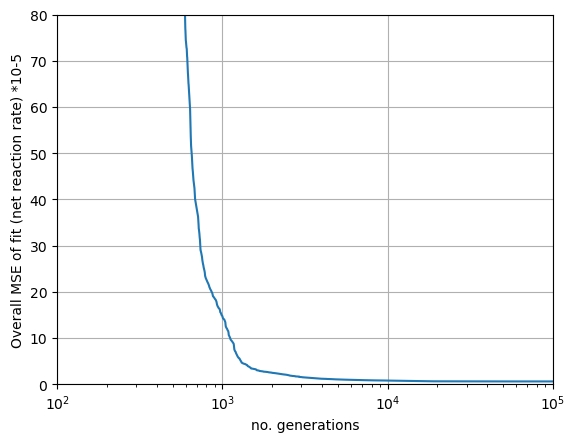

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.900768418090939
-8.401028266973798
-7.601402666811659
-8.799518608644489
-8.301726405704258
-7.107473459141616
-8.100030168543073
-10.381357925587634
-7.7069379256832065
-6.80632850666616
-7.306653205274831
-8.004212808647482
-7.908346132401099
-6.804470734442278
-7.4045028451992865
-7.409686536361712
-7.899190327342692
-9.066943783396843
-8.38296619963021
-6.502215543520542
-7.302241289554852
-6.717175498828616
-7.517327843935054
-11.99999992158511
-7.320257118153525
-7.8211734609813135
-1.3010299998774524


In [37]:
res.X

array([ -7.90076842,  -8.40102827,  -7.60140267,  -8.79951861,
        -8.30172641,  -7.10747346,  -8.10003017, -10.38135793,
        -7.70693793,  -6.80632851,  -7.30665321,  -8.00421281,
        -7.90834613,  -6.80447073,  -7.40450285,  -7.40968654,
        -7.89919033,  -9.06694378,  -8.3829662 ,  -6.50221554,
        -7.30224129,  -6.7171755 ,  -7.51732784, -11.99999992,
        -7.32025712,  -7.82117346,  -1.30103   ])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.900768418090939
-8.4: -8.401028266973798
-7.6: -7.601402666811659
-8.8: -8.799518608644489
-8.3: -8.301726405704258
-7.1: -7.107473459141616
-8.1: -8.100030168543073
-10.9: -10.381357925587634
-7.7: -7.7069379256832065
-6.8: -6.80632850666616
-7.3: -7.306653205274831
-8.0: -8.004212808647482
-7.9: -7.908346132401099
-6.8: -6.804470734442278
-7.4: -7.4045028451992865
-7.4: -7.409686536361712
-7.9: -7.899190327342692
-9.1: -9.066943783396843
-8.4: -8.38296619963021
-6.5: -6.502215543520542
-7.3: -7.302241289554852
-6.7: -6.717175498828616
-7.5: -7.517327843935054
-11.8: -11.99999992158511
-7.3: -7.320257118153525
-7.8: -7.8211734609813135
R-value: 0.9955854942088342
R2: 0.9911904762790488
